#### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Classification on imbalanced data

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/imbalanced_data"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to classify a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another. You will work with the [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset hosted on Kaggle. The aim is to detect a mere 492 fraudulent transactions from 284,807 transactions in total. You will use [Keras](../../guide/keras/overview.ipynb) to define the model and [class weights](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model) to help the model learn from the imbalanced data. .

This tutorial contains complete code to:

* Load a CSV file using Pandas.
* Create train, validation, and test sets.
* Define and train a model using Keras (including setting class weights).
* Evaluate the model using various metrics (including precision and recall).
* Try common techniques for dealing with imbalanced data like:
    * Class weighting 
    * Oversampling


## Setup

In [2]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Data processing and exploration

### Download the Kaggle Credit Card Fraud data set

Pandas is a Python library with many helpful utilities for loading and working with structured data and can be used to download CSVs into a dataframe.

Note: This dataset has been collected and analysed during a research collaboration of Worldline and the [Machine Learning Group](http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available [here](https://www.researchgate.net/project/Fraud-detection-5) and the page of the [DefeatFraud](https://mlg.ulb.ac.be/wordpress/portfolio_page/defeatfraud-assessment-and-validation-of-deep-feature-engineering-and-learning-solutions-for-fraud-detection/) project

In [4]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Examine the class label imbalance

Let's look at the dataset imbalance:

In [6]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



This shows the small fraction of positive samples.

### Clean, split and normalize the data

The raw data has a few issues. First the `Time` and `Amount` columns are too variable to use directly. Drop the `Time` column (since it's not clear what it means) and take the log of the `Amount` column to reduce its range.

In [7]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps=0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where [overfitting](https://developers.google.com/machine-learning/crash-course/generalization/peril-of-overfitting) is a significant concern from the lack of training data.

In [8]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

Normalize the input features using the sklearn StandardScaler.
This will set the mean to 0 and standard deviation to 1.

Note: The `StandardScaler` is only fit using the `train_features` to be sure the model is not peeking at the validation or test sets. 

In [9]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


Caution: If you want to deploy a model, it's critical that you preserve the preprocessing calculations. The easiest way to implement them as layers, and attach them to your model before export.


### Look at the data distribution

Next compare the distributions of the positive and negative examples over a few features. Good questions to ask yourself at this point are:

* Do these distributions make sense? 
    * Yes. You've normalized the input and these are mostly concentrated in the `+/- 2` range.
* Can you see the difference between the distributions?
    * Yes the positive examples contain a much higher rate of extreme values.

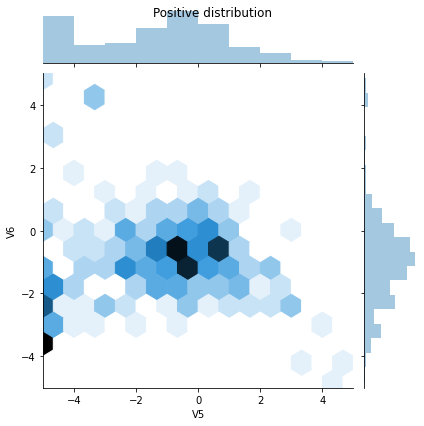

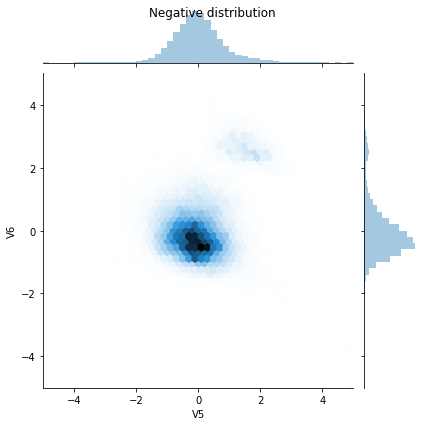

In [10]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns = train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns = train_df.columns)

sns.jointplot(pos_df['V5'], pos_df['V6'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
_ = plt.suptitle("Negative distribution")

## Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent: 

In [11]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

### Understanding useful metrics

Notice that there are a few metrics defined above that can be computed by the model that will be helpful when evaluating the performance.



*   **False** negatives and **false** positives are samples that were **incorrectly** classified
*   **True** negatives and **true** positives are samples that were **correctly** classified
*   **Accuracy** is the percentage of examples correctly classified
>   $\frac{\text{true samples}}{\text{total samples}}$
*   **Precision** is the percentage of **predicted** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false positives}}$
*   **Recall** is the percentage of **actual** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false negatives}}$
*   **AUC** refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample.

Note: Accuracy is not a helpful metric for this task. You can 99.8%+ accuracy on this task by predicting False all the time.  

Read more:
*  [True vs. False and Positive vs. Negative](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative)
*  [Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy)
*   [Precision and Recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
*   [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)

## Baseline model

### Build the model

Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.


Note: this model will not handle the class imbalance well. You will improve it later in this tutorial.

In [12]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [13]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


Test run the model:

In [14]:
model.predict(train_features[:10])

array([[0.5788107 ],
       [0.44979692],
       [0.5427961 ],
       [0.5985188 ],
       [0.7758075 ],
       [0.3417888 ],
       [0.39359283],
       [0.5399953 ],
       [0.3551327 ],
       [0.47230086]], dtype=float32)

### Optional: Set the correct initial bias.

These initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that (See: [A Recipe for Training Neural Networks: "init well"](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines)). This can help with initial convergence.

With the default bias initialization the loss should be about `math.log(2) = 0.69314` 

In [15]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.7817


The correct bias to set can be derived from:

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$
$$ b_0 = -log_e(1/p_0 - 1) $$
$$ b_0 = log_e(pos/neg)$$

In [16]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

Set that as the initial bias, and the model will give much more reasonable initial guesses. 

It should be near: `pos/total = 0.0018`

In [17]:
model = make_model(output_bias = initial_bias)
model.predict(train_features[:10])

array([[0.00093563],
       [0.00187903],
       [0.00109238],
       [0.00117128],
       [0.00134988],
       [0.00090826],
       [0.00099455],
       [0.00154405],
       [0.00100204],
       [0.0004291 ]], dtype=float32)

With this initialization the initial loss should be approximately:

$$-p_0log(p_0)-(1-p_0)log(1-p_0) = 0.01317$$

In [18]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0146


This initial loss is about 50 times less than if would have been with naive initialization.

This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. This also makes it easier to read plots of the loss during training.

### Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training.

In [19]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

### Confirm that the bias fix helps

Before moving on, confirm quick that the careful bias initialization actually helped.

Train the model for 20 epochs, with and without this careful initialization, and compare the losses: 

In [20]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [21]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [22]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

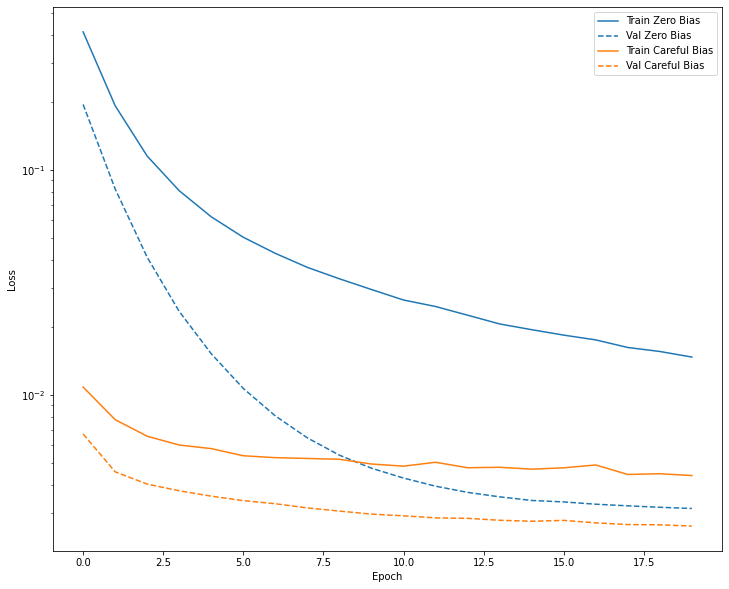

In [23]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

The above figure makes it clear: In terms of validation loss, on this problem, this careful initialization gives a clear advantage. 

### Train the model

In [24]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100


 1/90 [..............................] - ETA: 0s - loss: 0.0235 - tp: 69.0000 - fp: 8.0000 - tn: 47517.0000 - fn: 23.0000 - accuracy: 0.9993 - precision: 0.8961 - recall: 0.7500 - auc: 0.9287

12/90 [===>..........................] - ETA: 0s - loss: 0.0176 - tp: 69.0000 - fp: 8.0000 - tn: 70002.0000 - fn: 66.0000 - accuracy: 0.9989 - precision: 0.8961 - recall: 0.5111 - auc: 0.8133

24/90 [=======>......................] - ETA: 0s - loss: 0.0143 - tp: 70.0000 - fp: 12.0000 - tn: 94537.0000 - fn: 102.0000 - accuracy: 0.9988 - precision: 0.8537 - recall: 0.4070 - auc: 0.7796

35/90 [==========>...................] - ETA: 0s - loss: 0.0138 - tp: 74.0000 - fp: 17.0000 - tn: 117017.0000 - fn: 141.0000 - accuracy: 0.9987 - precision: 0.8132 - recall: 0.3442 - auc: 0.7647

47/90 [==============>...............] - ETA: 0s - loss: 0.0130 - tp: 76.0000 - fp: 17.0000 - tn: 141552.0000 - fn: 180.0000 - accuracy: 0.9986 - precision: 0.8172 - recall: 0.2969 - auc: 0.7607

59/90 [==================>...........] - ETA: 0s - loss: 0.0118 - tp: 81.0000 - fp: 18.0000 - tn: 166097.0000 - fn: 205.0000 - accuracy: 0.9987 - precision: 0.8182 - recall: 0.2832 - auc: 0.7598

71/90 [======================>.......] - ETA: 0s - loss: 0.0117 - tp: 86.0000 - fp: 20.0000 - tn: 190625.0000 - fn: 246.0000 - accuracy: 0.9986 - precision: 0.8113 - recall: 0.2590 - auc: 0.7565

83/90 [==========================>...] - ETA: 0s - loss: 0.0114 - tp: 94.0000 - fp: 25.0000 - tn: 215149.0000 - fn: 285.0000 - accuracy: 0.9986 - precision: 0.7899 - recall: 0.2480 - auc: 0.7602

90/90 [==============================] - 1s 13ms/step - loss: 0.0112 - tp: 100.0000 - fp: 25.0000 - tn: 227419.0000 - fn: 301.0000 - accuracy: 0.9986 - precision: 0.8000 - recall: 0.2494 - auc: 0.7615 - val_loss: 0.0067 - val_tp: 15.0000 - val_fp: 2.0000 - val_tn: 45480.0000 - val_fn: 72.0000 - val_accuracy: 0.9984 - val_precision: 0.8824 - val_recall: 0.1724 - val_auc: 0.9077


Epoch 2/100
 1/90 [..............................] - ETA: 0s - loss: 0.0022 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0095 - tp: 17.0000 - fp: 2.0000 - tn: 26564.0000 - fn: 41.0000 - accuracy: 0.9984 - precision: 0.8947 - recall: 0.2931 - auc: 0.8372 

25/90 [=======>......................] - ETA: 0s - loss: 0.0098 - tp: 25.0000 - fp: 3.0000 - tn: 51091.0000 - fn: 81.0000 - accuracy: 0.9984 - precision: 0.8929 - recall: 0.2358 - auc: 0.8122

37/90 [===========>..................] - ETA: 0s - loss: 0.0088 - tp: 36.0000 - fp: 7.0000 - tn: 75628.0000 - fn: 105.0000 - accuracy: 0.9985 - precision: 0.8372 - recall: 0.2553 - auc: 0.8220

49/90 [===============>..............] - ETA: 0s - loss: 0.0081 - tp: 49.0000 - fp: 10.0000 - tn: 100162.0000 - fn: 131.0000 - accuracy: 0.9986 - precision: 0.8305 - recall: 0.2722 - auc: 0.8402

61/90 [===================>..........] - ETA: 0s - loss: 0.0081 - tp: 56.0000 - fp: 13.0000 - tn: 124704.0000 - fn: 155.0000 - accuracy: 0.9987 - precision: 0.8116 - recall: 0.2654 - auc: 0.8243

73/90 [=======================>......] - ETA: 0s - loss: 0.0078 - tp: 76.0000 - fp: 21.0000 - tn: 149235.0000 - fn: 172.0000 - accuracy: 0.9987 - precision: 0.7835 - recall: 0.3065 - auc: 0.8358

85/90 [===========================>..] - ETA: 0s - loss: 0.0076 - tp: 102.0000 - fp: 24.0000 - tn: 173756.0000 - fn: 198.0000 - accuracy: 0.9987 - precision: 0.8095 - recall: 0.3400 - auc: 0.8489

90/90 [==============================] - 1s 6ms/step - loss: 0.0075 - tp: 108.0000 - fp: 24.0000 - tn: 181938.0000 - fn: 206.0000 - accuracy: 0.9987 - precision: 0.8182 - recall: 0.3439 - auc: 0.8491 - val_loss: 0.0046 - val_tp: 45.0000 - val_fp: 6.0000 - val_tn: 45476.0000 - val_fn: 42.0000 - val_accuracy: 0.9989 - val_precision: 0.8824 - val_recall: 0.5172 - val_auc: 0.9308


Epoch 3/100
 1/90 [..............................] - ETA: 0s - loss: 0.0033 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.6667 - auc: 0.9994

12/90 [===>..........................] - ETA: 0s - loss: 0.0060 - tp: 14.0000 - fp: 4.0000 - tn: 24537.0000 - fn: 21.0000 - accuracy: 0.9990 - precision: 0.7778 - recall: 0.4000 - auc: 0.8536 

23/90 [======>.......................] - ETA: 0s - loss: 0.0066 - tp: 24.0000 - fp: 6.0000 - tn: 47031.0000 - fn: 43.0000 - accuracy: 0.9990 - precision: 0.8000 - recall: 0.3582 - auc: 0.8087

35/90 [==========>...................] - ETA: 0s - loss: 0.0069 - tp: 44.0000 - fp: 12.0000 - tn: 71556.0000 - fn: 68.0000 - accuracy: 0.9989 - precision: 0.7857 - recall: 0.3929 - auc: 0.8172

46/90 [==============>...............] - ETA: 0s - loss: 0.0067 - tp: 63.0000 - fp: 14.0000 - tn: 94043.0000 - fn: 88.0000 - accuracy: 0.9989 - precision: 0.8182 - recall: 0.4172 - auc: 0.8206

58/90 [==================>...........] - ETA: 0s - loss: 0.0069 - tp: 86.0000 - fp: 16.0000 - tn: 118563.0000 - fn: 119.0000 - accuracy: 0.9989 - precision: 0.8431 - recall: 0.4195 - auc: 0.8354

70/90 [======================>.......] - ETA: 0s - loss: 0.0069 - tp: 106.0000 - fp: 22.0000 - tn: 143089.0000 - fn: 143.0000 - accuracy: 0.9988 - precision: 0.8281 - recall: 0.4257 - auc: 0.8460

82/90 [==========================>...] - ETA: 0s - loss: 0.0066 - tp: 128.0000 - fp: 26.0000 - tn: 167617.0000 - fn: 165.0000 - accuracy: 0.9989 - precision: 0.8312 - recall: 0.4369 - auc: 0.8569

90/90 [==============================] - 1s 6ms/step - loss: 0.0065 - tp: 138.0000 - fp: 27.0000 - tn: 181935.0000 - fn: 176.0000 - accuracy: 0.9989 - precision: 0.8364 - recall: 0.4395 - auc: 0.8567 - val_loss: 0.0040 - val_tp: 54.0000 - val_fp: 7.0000 - val_tn: 45475.0000 - val_fn: 33.0000 - val_accuracy: 0.9991 - val_precision: 0.8852 - val_recall: 0.6207 - val_auc: 0.9365


Epoch 4/100
 1/90 [..............................] - ETA: 0s - loss: 0.0054 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.3333 - auc: 0.9968

12/90 [===>..........................] - ETA: 0s - loss: 0.0082 - tp: 19.0000 - fp: 5.0000 - tn: 24521.0000 - fn: 31.0000 - accuracy: 0.9985 - precision: 0.7917 - recall: 0.3800 - auc: 0.8774 

24/90 [=======>......................] - ETA: 0s - loss: 0.0079 - tp: 40.0000 - fp: 10.0000 - tn: 49048.0000 - fn: 54.0000 - accuracy: 0.9987 - precision: 0.8000 - recall: 0.4255 - auc: 0.8588

35/90 [==========>...................] - ETA: 0s - loss: 0.0076 - tp: 60.0000 - fp: 16.0000 - tn: 71527.0000 - fn: 77.0000 - accuracy: 0.9987 - precision: 0.7895 - recall: 0.4380 - auc: 0.8585

47/90 [==============>...............] - ETA: 0s - loss: 0.0073 - tp: 85.0000 - fp: 21.0000 - tn: 96049.0000 - fn: 101.0000 - accuracy: 0.9987 - precision: 0.8019 - recall: 0.4570 - auc: 0.8683

59/90 [==================>...........] - ETA: 0s - loss: 0.0068 - tp: 111.0000 - fp: 26.0000 - tn: 120578.0000 - fn: 117.0000 - accuracy: 0.9988 - precision: 0.8102 - recall: 0.4868 - auc: 0.8792

70/90 [======================>.......] - ETA: 0s - loss: 0.0065 - tp: 128.0000 - fp: 29.0000 - tn: 143068.0000 - fn: 135.0000 - accuracy: 0.9989 - precision: 0.8153 - recall: 0.4867 - auc: 0.8856

82/90 [==========================>...] - ETA: 0s - loss: 0.0062 - tp: 147.0000 - fp: 33.0000 - tn: 167602.0000 - fn: 154.0000 - accuracy: 0.9989 - precision: 0.8167 - recall: 0.4884 - auc: 0.8832

90/90 [==============================] - 1s 6ms/step - loss: 0.0060 - tp: 154.0000 - fp: 33.0000 - tn: 181929.0000 - fn: 160.0000 - accuracy: 0.9989 - precision: 0.8235 - recall: 0.4904 - auc: 0.8848 - val_loss: 0.0037 - val_tp: 61.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 26.0000 - val_accuracy: 0.9993 - val_precision: 0.8841 - val_recall: 0.7011 - val_auc: 0.9422


Epoch 5/100
 1/90 [..............................] - ETA: 0s - loss: 0.0019 - tp: 4.0000 - fp: 1.0000 - tn: 2043.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.8000 - recall: 1.0000 - auc: 0.9999

12/90 [===>..........................] - ETA: 0s - loss: 0.0073 - tp: 21.0000 - fp: 7.0000 - tn: 24527.0000 - fn: 21.0000 - accuracy: 0.9989 - precision: 0.7500 - recall: 0.5000 - auc: 0.8433 

24/90 [=======>......................] - ETA: 0s - loss: 0.0061 - tp: 42.0000 - fp: 13.0000 - tn: 49057.0000 - fn: 40.0000 - accuracy: 0.9989 - precision: 0.7636 - recall: 0.5122 - auc: 0.8826

35/90 [==========>...................] - ETA: 0s - loss: 0.0060 - tp: 55.0000 - fp: 14.0000 - tn: 71547.0000 - fn: 64.0000 - accuracy: 0.9989 - precision: 0.7971 - recall: 0.4622 - auc: 0.8808

46/90 [==============>...............] - ETA: 0s - loss: 0.0056 - tp: 80.0000 - fp: 16.0000 - tn: 94032.0000 - fn: 80.0000 - accuracy: 0.9990 - precision: 0.8333 - recall: 0.5000 - auc: 0.8923

57/90 [==================>...........] - ETA: 0s - loss: 0.0054 - tp: 103.0000 - fp: 20.0000 - tn: 116518.0000 - fn: 95.0000 - accuracy: 0.9990 - precision: 0.8374 - recall: 0.5202 - auc: 0.8976

69/90 [======================>.......] - ETA: 0s - loss: 0.0057 - tp: 124.0000 - fp: 26.0000 - tn: 141043.0000 - fn: 119.0000 - accuracy: 0.9990 - precision: 0.8267 - recall: 0.5103 - auc: 0.8936

81/90 [==========================>...] - ETA: 0s - loss: 0.0057 - tp: 146.0000 - fp: 31.0000 - tn: 165568.0000 - fn: 143.0000 - accuracy: 0.9990 - precision: 0.8249 - recall: 0.5052 - auc: 0.8965

90/90 [==============================] - 1s 6ms/step - loss: 0.0057 - tp: 157.0000 - fp: 36.0000 - tn: 181926.0000 - fn: 157.0000 - accuracy: 0.9989 - precision: 0.8135 - recall: 0.5000 - auc: 0.8982 - val_loss: 0.0035 - val_tp: 62.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 25.0000 - val_accuracy: 0.9993 - val_precision: 0.8857 - val_recall: 0.7126 - val_auc: 0.9422


Epoch 6/100
 1/90 [..............................] - ETA: 0s - loss: 0.0029 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 0.9998

12/90 [===>..........................] - ETA: 0s - loss: 0.0052 - tp: 20.0000 - fp: 5.0000 - tn: 24534.0000 - fn: 17.0000 - accuracy: 0.9991 - precision: 0.8000 - recall: 0.5405 - auc: 0.9040 

23/90 [======>.......................] - ETA: 0s - loss: 0.0055 - tp: 38.0000 - fp: 8.0000 - tn: 47017.0000 - fn: 41.0000 - accuracy: 0.9990 - precision: 0.8261 - recall: 0.4810 - auc: 0.9098

34/90 [==========>...................] - ETA: 0s - loss: 0.0046 - tp: 59.0000 - fp: 11.0000 - tn: 69512.0000 - fn: 50.0000 - accuracy: 0.9991 - precision: 0.8429 - recall: 0.5413 - auc: 0.9253

45/90 [==============>...............] - ETA: 0s - loss: 0.0050 - tp: 75.0000 - fp: 14.0000 - tn: 91997.0000 - fn: 74.0000 - accuracy: 0.9990 - precision: 0.8427 - recall: 0.5034 - auc: 0.9181

56/90 [=================>............] - ETA: 0s - loss: 0.0051 - tp: 90.0000 - fp: 18.0000 - tn: 114486.0000 - fn: 94.0000 - accuracy: 0.9990 - precision: 0.8333 - recall: 0.4891 - auc: 0.9062

67/90 [=====================>........] - ETA: 0s - loss: 0.0051 - tp: 115.0000 - fp: 25.0000 - tn: 136965.0000 - fn: 111.0000 - accuracy: 0.9990 - precision: 0.8214 - recall: 0.5088 - auc: 0.9124

79/90 [=========================>....] - ETA: 0s - loss: 0.0056 - tp: 133.0000 - fp: 31.0000 - tn: 161487.0000 - fn: 141.0000 - accuracy: 0.9989 - precision: 0.8110 - recall: 0.4854 - auc: 0.8981

90/90 [==============================] - 1s 6ms/step - loss: 0.0057 - tp: 152.0000 - fp: 32.0000 - tn: 181930.0000 - fn: 162.0000 - accuracy: 0.9989 - precision: 0.8261 - recall: 0.4841 - auc: 0.8934 - val_loss: 0.0033 - val_tp: 65.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 22.0000 - val_accuracy: 0.9993 - val_precision: 0.8904 - val_recall: 0.7471 - val_auc: 0.9479


Epoch 7/100
 1/90 [..............................] - ETA: 0s - loss: 0.0111 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.5000 - auc: 0.7468

12/90 [===>..........................] - ETA: 0s - loss: 0.0060 - tp: 30.0000 - fp: 3.0000 - tn: 24518.0000 - fn: 25.0000 - accuracy: 0.9989 - precision: 0.9091 - recall: 0.5455 - auc: 0.8894 

23/90 [======>.......................] - ETA: 0s - loss: 0.0054 - tp: 49.0000 - fp: 4.0000 - tn: 47009.0000 - fn: 42.0000 - accuracy: 0.9990 - precision: 0.9245 - recall: 0.5385 - auc: 0.8831

34/90 [==========>...................] - ETA: 0s - loss: 0.0053 - tp: 74.0000 - fp: 8.0000 - tn: 69488.0000 - fn: 62.0000 - accuracy: 0.9990 - precision: 0.9024 - recall: 0.5441 - auc: 0.8919

45/90 [==============>...............] - ETA: 0s - loss: 0.0057 - tp: 92.0000 - fp: 12.0000 - tn: 91972.0000 - fn: 84.0000 - accuracy: 0.9990 - precision: 0.8846 - recall: 0.5227 - auc: 0.8847

56/90 [=================>............] - ETA: 0s - loss: 0.0054 - tp: 111.0000 - fp: 15.0000 - tn: 114468.0000 - fn: 94.0000 - accuracy: 0.9990 - precision: 0.8810 - recall: 0.5415 - auc: 0.8887

67/90 [=====================>........] - ETA: 0s - loss: 0.0053 - tp: 129.0000 - fp: 20.0000 - tn: 136960.0000 - fn: 107.0000 - accuracy: 0.9991 - precision: 0.8658 - recall: 0.5466 - auc: 0.8904

79/90 [=========================>....] - ETA: 0s - loss: 0.0053 - tp: 158.0000 - fp: 24.0000 - tn: 161483.0000 - fn: 127.0000 - accuracy: 0.9991 - precision: 0.8681 - recall: 0.5544 - auc: 0.8932

90/90 [==============================] - ETA: 0s - loss: 0.0052 - tp: 174.0000 - fp: 30.0000 - tn: 181932.0000 - fn: 140.0000 - accuracy: 0.9991 - precision: 0.8529 - recall: 0.5541 - auc: 0.8983

90/90 [==============================] - 1s 6ms/step - loss: 0.0052 - tp: 174.0000 - fp: 30.0000 - tn: 181932.0000 - fn: 140.0000 - accuracy: 0.9991 - precision: 0.8529 - recall: 0.5541 - auc: 0.8983 - val_loss: 0.0032 - val_tp: 66.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 21.0000 - val_accuracy: 0.9994 - val_precision: 0.8919 - val_recall: 0.7586 - val_auc: 0.9479


Epoch 8/100
 1/90 [..............................] - ETA: 0s - loss: 0.0031 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 0.9972

12/90 [===>..........................] - ETA: 0s - loss: 0.0044 - tp: 20.0000 - fp: 4.0000 - tn: 24536.0000 - fn: 16.0000 - accuracy: 0.9992 - precision: 0.8333 - recall: 0.5556 - auc: 0.8874 

24/90 [=======>......................] - ETA: 0s - loss: 0.0051 - tp: 41.0000 - fp: 9.0000 - tn: 49063.0000 - fn: 39.0000 - accuracy: 0.9990 - precision: 0.8200 - recall: 0.5125 - auc: 0.8923

36/90 [===========>..................] - ETA: 0s - loss: 0.0057 - tp: 63.0000 - fp: 13.0000 - tn: 73584.0000 - fn: 68.0000 - accuracy: 0.9989 - precision: 0.8289 - recall: 0.4809 - auc: 0.8916

47/90 [==============>...............] - ETA: 0s - loss: 0.0056 - tp: 81.0000 - fp: 18.0000 - tn: 96073.0000 - fn: 84.0000 - accuracy: 0.9989 - precision: 0.8182 - recall: 0.4909 - auc: 0.8985

59/90 [==================>...........] - ETA: 0s - loss: 0.0055 - tp: 103.0000 - fp: 23.0000 - tn: 120606.0000 - fn: 100.0000 - accuracy: 0.9990 - precision: 0.8175 - recall: 0.5074 - auc: 0.9000

71/90 [======================>.......] - ETA: 0s - loss: 0.0055 - tp: 123.0000 - fp: 27.0000 - tn: 145134.0000 - fn: 124.0000 - accuracy: 0.9990 - precision: 0.8200 - recall: 0.4980 - auc: 0.8973

83/90 [==========================>...] - ETA: 0s - loss: 0.0055 - tp: 151.0000 - fp: 29.0000 - tn: 169657.0000 - fn: 147.0000 - accuracy: 0.9990 - precision: 0.8389 - recall: 0.5067 - auc: 0.8962

90/90 [==============================] - 1s 6ms/step - loss: 0.0054 - tp: 161.0000 - fp: 32.0000 - tn: 181930.0000 - fn: 153.0000 - accuracy: 0.9990 - precision: 0.8342 - recall: 0.5127 - auc: 0.8983 - val_loss: 0.0031 - val_tp: 66.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 21.0000 - val_accuracy: 0.9994 - val_precision: 0.8919 - val_recall: 0.7586 - val_auc: 0.9479


Epoch 9/100
 1/90 [..............................] - ETA: 0s - loss: 0.0084 - tp: 1.0000 - fp: 1.0000 - tn: 2043.0000 - fn: 3.0000 - accuracy: 0.9980 - precision: 0.5000 - recall: 0.2500 - auc: 0.8734

13/90 [===>..........................] - ETA: 0s - loss: 0.0050 - tp: 24.0000 - fp: 6.0000 - tn: 26570.0000 - fn: 24.0000 - accuracy: 0.9989 - precision: 0.8000 - recall: 0.5000 - auc: 0.9052

25/90 [=======>......................] - ETA: 0s - loss: 0.0047 - tp: 46.0000 - fp: 12.0000 - tn: 51102.0000 - fn: 40.0000 - accuracy: 0.9990 - precision: 0.7931 - recall: 0.5349 - auc: 0.9059

36/90 [===========>..................] - ETA: 0s - loss: 0.0047 - tp: 68.0000 - fp: 16.0000 - tn: 73587.0000 - fn: 57.0000 - accuracy: 0.9990 - precision: 0.8095 - recall: 0.5440 - auc: 0.9028

47/90 [==============>...............] - ETA: 0s - loss: 0.0050 - tp: 90.0000 - fp: 24.0000 - tn: 96063.0000 - fn: 79.0000 - accuracy: 0.9989 - precision: 0.7895 - recall: 0.5325 - auc: 0.9071

59/90 [==================>...........] - ETA: 0s - loss: 0.0050 - tp: 110.0000 - fp: 28.0000 - tn: 120596.0000 - fn: 98.0000 - accuracy: 0.9990 - precision: 0.7971 - recall: 0.5288 - auc: 0.9074

71/90 [======================>.......] - ETA: 0s - loss: 0.0050 - tp: 131.0000 - fp: 32.0000 - tn: 145129.0000 - fn: 116.0000 - accuracy: 0.9990 - precision: 0.8037 - recall: 0.5304 - auc: 0.9036

83/90 [==========================>...] - ETA: 0s - loss: 0.0049 - tp: 158.0000 - fp: 37.0000 - tn: 169657.0000 - fn: 132.0000 - accuracy: 0.9990 - precision: 0.8103 - recall: 0.5448 - auc: 0.9074

90/90 [==============================] - 1s 6ms/step - loss: 0.0050 - tp: 167.0000 - fp: 37.0000 - tn: 181925.0000 - fn: 147.0000 - accuracy: 0.9990 - precision: 0.8186 - recall: 0.5318 - auc: 0.9064 - val_loss: 0.0030 - val_tp: 65.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 22.0000 - val_accuracy: 0.9993 - val_precision: 0.8904 - val_recall: 0.7471 - val_auc: 0.9479


Epoch 10/100
 1/90 [..............................] - ETA: 0s - loss: 0.0208 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 5.0000 - accuracy: 0.9976 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5952

13/90 [===>..........................] - ETA: 0s - loss: 0.0062 - tp: 26.0000 - fp: 4.0000 - tn: 26570.0000 - fn: 24.0000 - accuracy: 0.9989 - precision: 0.8667 - recall: 0.5200 - auc: 0.9185             

24/90 [=======>......................] - ETA: 0s - loss: 0.0059 - tp: 53.0000 - fp: 10.0000 - tn: 49047.0000 - fn: 42.0000 - accuracy: 0.9989 - precision: 0.8413 - recall: 0.5579 - auc: 0.9197

35/90 [==========>...................] - ETA: 0s - loss: 0.0056 - tp: 73.0000 - fp: 13.0000 - tn: 71529.0000 - fn: 65.0000 - accuracy: 0.9989 - precision: 0.8488 - recall: 0.5290 - auc: 0.9190

46/90 [==============>...............] - ETA: 0s - loss: 0.0058 - tp: 90.0000 - fp: 19.0000 - tn: 94012.0000 - fn: 87.0000 - accuracy: 0.9989 - precision: 0.8257 - recall: 0.5085 - auc: 0.9054

58/90 [==================>...........] - ETA: 0s - loss: 0.0056 - tp: 108.0000 - fp: 23.0000 - tn: 118548.0000 - fn: 105.0000 - accuracy: 0.9989 - precision: 0.8244 - recall: 0.5070 - auc: 0.8976

70/90 [======================>.......] - ETA: 0s - loss: 0.0055 - tp: 126.0000 - fp: 27.0000 - tn: 143081.0000 - fn: 126.0000 - accuracy: 0.9989 - precision: 0.8235 - recall: 0.5000 - auc: 0.8974

82/90 [==========================>...] - ETA: 0s - loss: 0.0053 - tp: 143.0000 - fp: 30.0000 - tn: 167617.0000 - fn: 146.0000 - accuracy: 0.9990 - precision: 0.8266 - recall: 0.4948 - auc: 0.9017

90/90 [==============================] - 1s 6ms/step - loss: 0.0053 - tp: 156.0000 - fp: 34.0000 - tn: 181928.0000 - fn: 158.0000 - accuracy: 0.9989 - precision: 0.8211 - recall: 0.4968 - auc: 0.9046 - val_loss: 0.0029 - val_tp: 67.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 20.0000 - val_accuracy: 0.9994 - val_precision: 0.8933 - val_recall: 0.7701 - val_auc: 0.9479


Epoch 11/100
 1/90 [..............................] - ETA: 0s - loss: 0.0022 - tp: 0.0000e+00 - fp: 2.0000 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 0.9990 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00

12/90 [===>..........................] - ETA: 0s - loss: 0.0044 - tp: 26.0000 - fp: 4.0000 - tn: 24525.0000 - fn: 21.0000 - accuracy: 0.9990 - precision: 0.8667 - recall: 0.5532 - auc: 0.9351                 

24/90 [=======>......................] - ETA: 0s - loss: 0.0047 - tp: 52.0000 - fp: 9.0000 - tn: 49050.0000 - fn: 41.0000 - accuracy: 0.9990 - precision: 0.8525 - recall: 0.5591 - auc: 0.9398

35/90 [==========>...................] - ETA: 0s - loss: 0.0048 - tp: 76.0000 - fp: 11.0000 - tn: 71533.0000 - fn: 60.0000 - accuracy: 0.9990 - precision: 0.8736 - recall: 0.5588 - auc: 0.9290

47/90 [==============>...............] - ETA: 0s - loss: 0.0047 - tp: 98.0000 - fp: 15.0000 - tn: 96061.0000 - fn: 82.0000 - accuracy: 0.9990 - precision: 0.8673 - recall: 0.5444 - auc: 0.9267

59/90 [==================>...........] - ETA: 0s - loss: 0.0051 - tp: 121.0000 - fp: 20.0000 - tn: 120583.0000 - fn: 108.0000 - accuracy: 0.9989 - precision: 0.8582 - recall: 0.5284 - auc: 0.9136

70/90 [======================>.......] - ETA: 0s - loss: 0.0050 - tp: 135.0000 - fp: 26.0000 - tn: 143075.0000 - fn: 124.0000 - accuracy: 0.9990 - precision: 0.8385 - recall: 0.5212 - auc: 0.9118

82/90 [==========================>...] - ETA: 0s - loss: 0.0049 - tp: 150.0000 - fp: 29.0000 - tn: 167616.0000 - fn: 141.0000 - accuracy: 0.9990 - precision: 0.8380 - recall: 0.5155 - auc: 0.9041

90/90 [==============================] - 1s 6ms/step - loss: 0.0048 - tp: 165.0000 - fp: 32.0000 - tn: 181930.0000 - fn: 149.0000 - accuracy: 0.9990 - precision: 0.8376 - recall: 0.5255 - auc: 0.9063 - val_loss: 0.0029 - val_tp: 68.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 19.0000 - val_accuracy: 0.9994 - val_precision: 0.8947 - val_recall: 0.7816 - val_auc: 0.9479


Epoch 12/100
 1/90 [..............................] - ETA: 0s - loss: 0.0035 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.6667 - auc: 0.8321

13/90 [===>..........................] - ETA: 0s - loss: 0.0056 - tp: 26.0000 - fp: 3.0000 - tn: 26571.0000 - fn: 24.0000 - accuracy: 0.9990 - precision: 0.8966 - recall: 0.5200 - auc: 0.8984 

25/90 [=======>......................] - ETA: 0s - loss: 0.0053 - tp: 47.0000 - fp: 9.0000 - tn: 51104.0000 - fn: 40.0000 - accuracy: 0.9990 - precision: 0.8393 - recall: 0.5402 - auc: 0.9006

37/90 [===========>..................] - ETA: 0s - loss: 0.0050 - tp: 75.0000 - fp: 13.0000 - tn: 75628.0000 - fn: 60.0000 - accuracy: 0.9990 - precision: 0.8523 - recall: 0.5556 - auc: 0.9059

49/90 [===============>..............] - ETA: 0s - loss: 0.0049 - tp: 95.0000 - fp: 17.0000 - tn: 100158.0000 - fn: 82.0000 - accuracy: 0.9990 - precision: 0.8482 - recall: 0.5367 - auc: 0.9138

61/90 [===================>..........] - ETA: 0s - loss: 0.0051 - tp: 118.0000 - fp: 21.0000 - tn: 124688.0000 - fn: 101.0000 - accuracy: 0.9990 - precision: 0.8489 - recall: 0.5388 - auc: 0.9118

73/90 [=======================>......] - ETA: 0s - loss: 0.0051 - tp: 140.0000 - fp: 25.0000 - tn: 149214.0000 - fn: 125.0000 - accuracy: 0.9990 - precision: 0.8485 - recall: 0.5283 - auc: 0.9080

85/90 [===========================>..] - ETA: 0s - loss: 0.0051 - tp: 160.0000 - fp: 34.0000 - tn: 173744.0000 - fn: 142.0000 - accuracy: 0.9990 - precision: 0.8247 - recall: 0.5298 - auc: 0.9109

90/90 [==============================] - 1s 6ms/step - loss: 0.0051 - tp: 165.0000 - fp: 35.0000 - tn: 181927.0000 - fn: 149.0000 - accuracy: 0.9990 - precision: 0.8250 - recall: 0.5255 - auc: 0.9110 - val_loss: 0.0028 - val_tp: 67.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 20.0000 - val_accuracy: 0.9994 - val_precision: 0.8933 - val_recall: 0.7701 - val_auc: 0.9480


Epoch 13/100


 1/90 [..............................] - ETA: 0s - loss: 0.0101 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 5.0000 - accuracy: 0.9976 - precision: 1.0000 - recall: 0.1667 - auc: 0.9159

13/90 [===>..........................] - ETA: 0s - loss: 0.0049 - tp: 17.0000 - fp: 3.0000 - tn: 26579.0000 - fn: 25.0000 - accuracy: 0.9989 - precision: 0.8500 - recall: 0.4048 - auc: 0.8915 

25/90 [=======>......................] - ETA: 0s - loss: 0.0052 - tp: 36.0000 - fp: 7.0000 - tn: 51108.0000 - fn: 49.0000 - accuracy: 0.9989 - precision: 0.8372 - recall: 0.4235 - auc: 0.8868

37/90 [===========>..................] - ETA: 0s - loss: 0.0048 - tp: 59.0000 - fp: 14.0000 - tn: 75640.0000 - fn: 63.0000 - accuracy: 0.9990 - precision: 0.8082 - recall: 0.4836 - auc: 0.8921

49/90 [===============>..............] - ETA: 0s - loss: 0.0050 - tp: 86.0000 - fp: 18.0000 - tn: 100163.0000 - fn: 85.0000 - accuracy: 0.9990 - precision: 0.8269 - recall: 0.5029 - auc: 0.8993

61/90 [===================>..........] - ETA: 0s - loss: 0.0048 - tp: 110.0000 - fp: 23.0000 - tn: 124691.0000 - fn: 104.0000 - accuracy: 0.9990 - precision: 0.8271 - recall: 0.5140 - auc: 0.9076

73/90 [=======================>......] - ETA: 0s - loss: 0.0050 - tp: 130.0000 - fp: 24.0000 - tn: 149223.0000 - fn: 127.0000 - accuracy: 0.9990 - precision: 0.8442 - recall: 0.5058 - auc: 0.9014

85/90 [===========================>..] - ETA: 0s - loss: 0.0049 - tp: 150.0000 - fp: 28.0000 - tn: 173753.0000 - fn: 149.0000 - accuracy: 0.9990 - precision: 0.8427 - recall: 0.5017 - auc: 0.9050

90/90 [==============================] - 1s 6ms/step - loss: 0.0050 - tp: 157.0000 - fp: 29.0000 - tn: 181933.0000 - fn: 157.0000 - accuracy: 0.9990 - precision: 0.8441 - recall: 0.5000 - auc: 0.9031 - val_loss: 0.0028 - val_tp: 69.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 18.0000 - val_accuracy: 0.9994 - val_precision: 0.8961 - val_recall: 0.7931 - val_auc: 0.9479


Epoch 14/100


 1/90 [..............................] - ETA: 0s - loss: 0.0064 - tp: 0.0000e+00 - fp: 1.0000 - tn: 2044.0000 - fn: 3.0000 - accuracy: 0.9980 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9960

13/90 [===>..........................] - ETA: 0s - loss: 0.0055 - tp: 20.0000 - fp: 4.0000 - tn: 26574.0000 - fn: 26.0000 - accuracy: 0.9989 - precision: 0.8333 - recall: 0.4348 - auc: 0.8897         

25/90 [=======>......................] - ETA: 0s - loss: 0.0056 - tp: 37.0000 - fp: 7.0000 - tn: 51112.0000 - fn: 44.0000 - accuracy: 0.9990 - precision: 0.8409 - recall: 0.4568 - auc: 0.8686

37/90 [===========>..................] - ETA: 0s - loss: 0.0054 - tp: 59.0000 - fp: 14.0000 - tn: 75639.0000 - fn: 64.0000 - accuracy: 0.9990 - precision: 0.8082 - recall: 0.4797 - auc: 0.8764

49/90 [===============>..............] - ETA: 0s - loss: 0.0054 - tp: 83.0000 - fp: 20.0000 - tn: 100165.0000 - fn: 84.0000 - accuracy: 0.9990 - precision: 0.8058 - recall: 0.4970 - auc: 0.8817

61/90 [===================>..........] - ETA: 0s - loss: 0.0055 - tp: 104.0000 - fp: 28.0000 - tn: 124688.0000 - fn: 108.0000 - accuracy: 0.9989 - precision: 0.7879 - recall: 0.4906 - auc: 0.8781

73/90 [=======================>......] - ETA: 0s - loss: 0.0054 - tp: 128.0000 - fp: 31.0000 - tn: 149214.0000 - fn: 131.0000 - accuracy: 0.9989 - precision: 0.8050 - recall: 0.4942 - auc: 0.8865

85/90 [===========================>..] - ETA: 0s - loss: 0.0054 - tp: 154.0000 - fp: 34.0000 - tn: 173740.0000 - fn: 152.0000 - accuracy: 0.9989 - precision: 0.8191 - recall: 0.5033 - auc: 0.8923

90/90 [==============================] - 1s 6ms/step - loss: 0.0053 - tp: 160.0000 - fp: 35.0000 - tn: 181927.0000 - fn: 154.0000 - accuracy: 0.9990 - precision: 0.8205 - recall: 0.5096 - auc: 0.8934 - val_loss: 0.0027 - val_tp: 69.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 18.0000 - val_accuracy: 0.9994 - val_precision: 0.8961 - val_recall: 0.7931 - val_auc: 0.9479


Epoch 15/100
 1/90 [..............................] - ETA: 0s - loss: 0.0115 - tp: 3.0000 - fp: 1.0000 - tn: 2042.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.7500 - recall: 0.6000 - auc: 0.8976

12/90 [===>..........................] - ETA: 0s - loss: 0.0056 - tp: 24.0000 - fp: 8.0000 - tn: 24524.0000 - fn: 20.0000 - accuracy: 0.9989 - precision: 0.7500 - recall: 0.5455 - auc: 0.9074

24/90 [=======>......................] - ETA: 0s - loss: 0.0050 - tp: 46.0000 - fp: 13.0000 - tn: 49054.0000 - fn: 39.0000 - accuracy: 0.9989 - precision: 0.7797 - recall: 0.5412 - auc: 0.9044

36/90 [===========>..................] - ETA: 0s - loss: 0.0052 - tp: 73.0000 - fp: 17.0000 - tn: 73580.0000 - fn: 58.0000 - accuracy: 0.9990 - precision: 0.8111 - recall: 0.5573 - auc: 0.8955

48/90 [===============>..............] - ETA: 0s - loss: 0.0052 - tp: 98.0000 - fp: 19.0000 - tn: 98106.0000 - fn: 81.0000 - accuracy: 0.9990 - precision: 0.8376 - recall: 0.5475 - auc: 0.8869

60/90 [===================>..........] - ETA: 0s - loss: 0.0054 - tp: 119.0000 - fp: 22.0000 - tn: 122631.0000 - fn: 108.0000 - accuracy: 0.9989 - precision: 0.8440 - recall: 0.5242 - auc: 0.8885

71/90 [======================>.......] - ETA: 0s - loss: 0.0051 - tp: 135.0000 - fp: 28.0000 - tn: 145125.0000 - fn: 120.0000 - accuracy: 0.9990 - precision: 0.8282 - recall: 0.5294 - auc: 0.8967

82/90 [==========================>...] - ETA: 0s - loss: 0.0050 - tp: 157.0000 - fp: 34.0000 - tn: 167607.0000 - fn: 138.0000 - accuracy: 0.9990 - precision: 0.8220 - recall: 0.5322 - auc: 0.9004

90/90 [==============================] - 1s 6ms/step - loss: 0.0049 - tp: 168.0000 - fp: 36.0000 - tn: 181926.0000 - fn: 146.0000 - accuracy: 0.9990 - precision: 0.8235 - recall: 0.5350 - auc: 0.9031 - val_loss: 0.0027 - val_tp: 68.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 19.0000 - val_accuracy: 0.9994 - val_precision: 0.8947 - val_recall: 0.7816 - val_auc: 0.9479


Epoch 16/100
 1/90 [..............................] - ETA: 0s - loss: 0.0078 - tp: 3.0000 - fp: 1.0000 - tn: 2042.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.7500 - recall: 0.6000 - auc: 0.7987

12/90 [===>..........................] - ETA: 0s - loss: 0.0055 - tp: 19.0000 - fp: 4.0000 - tn: 24530.0000 - fn: 23.0000 - accuracy: 0.9989 - precision: 0.8261 - recall: 0.4524 - auc: 0.8675

22/90 [======>.......................] - ETA: 0s - loss: 0.0049 - tp: 43.0000 - fp: 7.0000 - tn: 44967.0000 - fn: 39.0000 - accuracy: 0.9990 - precision: 0.8600 - recall: 0.5244 - auc: 0.9012

32/90 [=========>....................] - ETA: 0s - loss: 0.0047 - tp: 62.0000 - fp: 11.0000 - tn: 65407.0000 - fn: 56.0000 - accuracy: 0.9990 - precision: 0.8493 - recall: 0.5254 - auc: 0.9055

42/90 [=============>................] - ETA: 0s - loss: 0.0045 - tp: 85.0000 - fp: 15.0000 - tn: 85847.0000 - fn: 69.0000 - accuracy: 0.9990 - precision: 0.8500 - recall: 0.5519 - auc: 0.9208

52/90 [================>.............] - ETA: 0s - loss: 0.0048 - tp: 104.0000 - fp: 20.0000 - tn: 106281.0000 - fn: 91.0000 - accuracy: 0.9990 - precision: 0.8387 - recall: 0.5333 - auc: 0.9166

63/90 [====================>.........] - ETA: 0s - loss: 0.0047 - tp: 119.0000 - fp: 25.0000 - tn: 128778.0000 - fn: 102.0000 - accuracy: 0.9990 - precision: 0.8264 - recall: 0.5385 - auc: 0.9127

74/90 [=======================>......] - ETA: 0s - loss: 0.0045 - tp: 133.0000 - fp: 27.0000 - tn: 151272.0000 - fn: 120.0000 - accuracy: 0.9990 - precision: 0.8313 - recall: 0.5257 - auc: 0.9117

84/90 [===========================>..] - ETA: 0s - loss: 0.0045 - tp: 157.0000 - fp: 29.0000 - tn: 171708.0000 - fn: 138.0000 - accuracy: 0.9990 - precision: 0.8441 - recall: 0.5322 - auc: 0.9174

90/90 [==============================] - 1s 7ms/step - loss: 0.0046 - tp: 169.0000 - fp: 30.0000 - tn: 181932.0000 - fn: 145.0000 - accuracy: 0.9990 - precision: 0.8492 - recall: 0.5382 - auc: 0.9143 - val_loss: 0.0027 - val_tp: 68.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 19.0000 - val_accuracy: 0.9994 - val_precision: 0.8947 - val_recall: 0.7816 - val_auc: 0.9537


Epoch 17/100
 1/90 [..............................] - ETA: 0s - loss: 0.0015 - tp: 2.0000 - fp: 1.0000 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.6667 - recall: 1.0000 - auc: 0.9998

11/90 [==>...........................] - ETA: 0s - loss: 0.0037 - tp: 21.0000 - fp: 3.0000 - tn: 22492.0000 - fn: 12.0000 - accuracy: 0.9993 - precision: 0.8750 - recall: 0.6364 - auc: 0.9080 

22/90 [======>.......................] - ETA: 0s - loss: 0.0044 - tp: 57.0000 - fp: 8.0000 - tn: 44959.0000 - fn: 32.0000 - accuracy: 0.9991 - precision: 0.8769 - recall: 0.6404 - auc: 0.9147

33/90 [==========>...................] - ETA: 0s - loss: 0.0042 - tp: 81.0000 - fp: 12.0000 - tn: 67445.0000 - fn: 46.0000 - accuracy: 0.9991 - precision: 0.8710 - recall: 0.6378 - auc: 0.9242

44/90 [=============>................] - ETA: 0s - loss: 0.0042 - tp: 102.0000 - fp: 17.0000 - tn: 89932.0000 - fn: 61.0000 - accuracy: 0.9991 - precision: 0.8571 - recall: 0.6258 - auc: 0.9192

55/90 [=================>............] - ETA: 0s - loss: 0.0044 - tp: 121.0000 - fp: 20.0000 - tn: 112420.0000 - fn: 79.0000 - accuracy: 0.9991 - precision: 0.8582 - recall: 0.6050 - auc: 0.9139

66/90 [=====================>........] - ETA: 0s - loss: 0.0042 - tp: 137.0000 - fp: 22.0000 - tn: 134917.0000 - fn: 92.0000 - accuracy: 0.9992 - precision: 0.8616 - recall: 0.5983 - auc: 0.9159

77/90 [========================>.....] - ETA: 0s - loss: 0.0044 - tp: 159.0000 - fp: 28.0000 - tn: 157395.0000 - fn: 114.0000 - accuracy: 0.9991 - precision: 0.8503 - recall: 0.5824 - auc: 0.9146

88/90 [============================>.] - ETA: 0s - loss: 0.0046 - tp: 180.0000 - fp: 32.0000 - tn: 179880.0000 - fn: 132.0000 - accuracy: 0.9991 - precision: 0.8491 - recall: 0.5769 - auc: 0.9139

90/90 [==============================] - 1s 6ms/step - loss: 0.0045 - tp: 181.0000 - fp: 32.0000 - tn: 181930.0000 - fn: 133.0000 - accuracy: 0.9991 - precision: 0.8498 - recall: 0.5764 - auc: 0.9144 - val_loss: 0.0027 - val_tp: 70.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 17.0000 - val_accuracy: 0.9995 - val_precision: 0.8974 - val_recall: 0.8046 - val_auc: 0.9537


Epoch 18/100
 1/90 [..............................] - ETA: 0s - loss: 5.4953e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0032 - tp: 34.0000 - fp: 4.0000 - tn: 26573.0000 - fn: 13.0000 - accuracy: 0.9994 - precision: 0.8947 - recall: 0.7234 - auc: 0.9462         

25/90 [=======>......................] - ETA: 0s - loss: 0.0038 - tp: 58.0000 - fp: 9.0000 - tn: 51104.0000 - fn: 29.0000 - accuracy: 0.9993 - precision: 0.8657 - recall: 0.6667 - auc: 0.9302

36/90 [===========>..................] - ETA: 0s - loss: 0.0036 - tp: 70.0000 - fp: 11.0000 - tn: 73604.0000 - fn: 43.0000 - accuracy: 0.9993 - precision: 0.8642 - recall: 0.6195 - auc: 0.9282

46/90 [==============>...............] - ETA: 0s - loss: 0.0041 - tp: 93.0000 - fp: 12.0000 - tn: 94038.0000 - fn: 65.0000 - accuracy: 0.9992 - precision: 0.8857 - recall: 0.5886 - auc: 0.9197

57/90 [==================>...........] - ETA: 0s - loss: 0.0039 - tp: 114.0000 - fp: 15.0000 - tn: 116532.0000 - fn: 75.0000 - accuracy: 0.9992 - precision: 0.8837 - recall: 0.6032 - auc: 0.9221

68/90 [=====================>........] - ETA: 0s - loss: 0.0041 - tp: 136.0000 - fp: 23.0000 - tn: 139012.0000 - fn: 93.0000 - accuracy: 0.9992 - precision: 0.8553 - recall: 0.5939 - auc: 0.9202

79/90 [=========================>....] - ETA: 0s - loss: 0.0044 - tp: 163.0000 - fp: 27.0000 - tn: 161484.0000 - fn: 118.0000 - accuracy: 0.9991 - precision: 0.8579 - recall: 0.5801 - auc: 0.9152

90/90 [==============================] - ETA: 0s - loss: 0.0045 - tp: 181.0000 - fp: 29.0000 - tn: 181933.0000 - fn: 133.0000 - accuracy: 0.9991 - precision: 0.8619 - recall: 0.5764 - auc: 0.9112

90/90 [==============================] - 1s 6ms/step - loss: 0.0045 - tp: 181.0000 - fp: 29.0000 - tn: 181933.0000 - fn: 133.0000 - accuracy: 0.9991 - precision: 0.8619 - recall: 0.5764 - auc: 0.9112 - val_loss: 0.0026 - val_tp: 69.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 18.0000 - val_accuracy: 0.9994 - val_precision: 0.8961 - val_recall: 0.7931 - val_auc: 0.9537


Epoch 19/100
 1/90 [..............................] - ETA: 0s - loss: 0.0093 - tp: 1.0000 - fp: 2.0000 - tn: 2043.0000 - fn: 2.0000 - accuracy: 0.9980 - precision: 0.3333 - recall: 0.3333 - auc: 0.6644

12/90 [===>..........................] - ETA: 0s - loss: 0.0051 - tp: 21.0000 - fp: 5.0000 - tn: 24532.0000 - fn: 18.0000 - accuracy: 0.9991 - precision: 0.8077 - recall: 0.5385 - auc: 0.8829

23/90 [======>.......................] - ETA: 0s - loss: 0.0045 - tp: 52.0000 - fp: 9.0000 - tn: 47011.0000 - fn: 32.0000 - accuracy: 0.9991 - precision: 0.8525 - recall: 0.6190 - auc: 0.9095

33/90 [==========>...................] - ETA: 0s - loss: 0.0048 - tp: 72.0000 - fp: 11.0000 - tn: 67449.0000 - fn: 52.0000 - accuracy: 0.9991 - precision: 0.8675 - recall: 0.5806 - auc: 0.9060

44/90 [=============>................] - ETA: 0s - loss: 0.0047 - tp: 91.0000 - fp: 15.0000 - tn: 89937.0000 - fn: 69.0000 - accuracy: 0.9991 - precision: 0.8585 - recall: 0.5688 - auc: 0.9019

54/90 [=================>............] - ETA: 0s - loss: 0.0048 - tp: 103.0000 - fp: 19.0000 - tn: 110380.0000 - fn: 90.0000 - accuracy: 0.9990 - precision: 0.8443 - recall: 0.5337 - auc: 0.9002

65/90 [====================>.........] - ETA: 0s - loss: 0.0047 - tp: 120.0000 - fp: 23.0000 - tn: 132872.0000 - fn: 105.0000 - accuracy: 0.9990 - precision: 0.8392 - recall: 0.5333 - auc: 0.8964

76/90 [========================>.....] - ETA: 0s - loss: 0.0046 - tp: 139.0000 - fp: 28.0000 - tn: 155361.0000 - fn: 120.0000 - accuracy: 0.9990 - precision: 0.8323 - recall: 0.5367 - auc: 0.8983

87/90 [============================>.] - ETA: 0s - loss: 0.0047 - tp: 168.0000 - fp: 32.0000 - tn: 177836.0000 - fn: 140.0000 - accuracy: 0.9990 - precision: 0.8400 - recall: 0.5455 - auc: 0.9078

90/90 [==============================] - 1s 6ms/step - loss: 0.0046 - tp: 172.0000 - fp: 32.0000 - tn: 181930.0000 - fn: 142.0000 - accuracy: 0.9990 - precision: 0.8431 - recall: 0.5478 - auc: 0.9096 - val_loss: 0.0026 - val_tp: 68.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 19.0000 - val_accuracy: 0.9994 - val_precision: 0.8947 - val_recall: 0.7816 - val_auc: 0.9537


Epoch 20/100
 1/90 [..............................] - ETA: 0s - loss: 0.0092 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.2500 - auc: 0.7484

13/90 [===>..........................] - ETA: 0s - loss: 0.0046 - tp: 25.0000 - fp: 6.0000 - tn: 26571.0000 - fn: 22.0000 - accuracy: 0.9989 - precision: 0.8065 - recall: 0.5319 - auc: 0.9137 

24/90 [=======>......................] - ETA: 0s - loss: 0.0036 - tp: 45.0000 - fp: 10.0000 - tn: 49064.0000 - fn: 33.0000 - accuracy: 0.9991 - precision: 0.8182 - recall: 0.5769 - auc: 0.9348

34/90 [==========>...................] - ETA: 0s - loss: 0.0039 - tp: 62.0000 - fp: 13.0000 - tn: 69505.0000 - fn: 52.0000 - accuracy: 0.9991 - precision: 0.8267 - recall: 0.5439 - auc: 0.9243

45/90 [==============>...............] - ETA: 0s - loss: 0.0042 - tp: 88.0000 - fp: 18.0000 - tn: 91985.0000 - fn: 69.0000 - accuracy: 0.9991 - precision: 0.8302 - recall: 0.5605 - auc: 0.9160

56/90 [=================>............] - ETA: 0s - loss: 0.0041 - tp: 113.0000 - fp: 20.0000 - tn: 114473.0000 - fn: 82.0000 - accuracy: 0.9991 - precision: 0.8496 - recall: 0.5795 - auc: 0.9194

67/90 [=====================>........] - ETA: 0s - loss: 0.0043 - tp: 129.0000 - fp: 27.0000 - tn: 136959.0000 - fn: 101.0000 - accuracy: 0.9991 - precision: 0.8269 - recall: 0.5609 - auc: 0.9140

77/90 [========================>.....] - ETA: 0s - loss: 0.0046 - tp: 148.0000 - fp: 31.0000 - tn: 157393.0000 - fn: 124.0000 - accuracy: 0.9990 - precision: 0.8268 - recall: 0.5441 - auc: 0.9105

88/90 [============================>.] - ETA: 0s - loss: 0.0044 - tp: 177.0000 - fp: 34.0000 - tn: 179878.0000 - fn: 135.0000 - accuracy: 0.9991 - precision: 0.8389 - recall: 0.5673 - auc: 0.9139

90/90 [==============================] - 1s 6ms/step - loss: 0.0045 - tp: 177.0000 - fp: 35.0000 - tn: 181927.0000 - fn: 137.0000 - accuracy: 0.9991 - precision: 0.8349 - recall: 0.5637 - auc: 0.9128 - val_loss: 0.0026 - val_tp: 71.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.8987 - val_recall: 0.8161 - val_auc: 0.9537


Epoch 21/100


 1/90 [..............................] - ETA: 0s - loss: 0.0074 - tp: 1.0000 - fp: 1.0000 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9990 - precision: 0.5000 - recall: 0.5000 - auc: 0.7462

12/90 [===>..........................] - ETA: 0s - loss: 0.0054 - tp: 35.0000 - fp: 8.0000 - tn: 24516.0000 - fn: 17.0000 - accuracy: 0.9990 - precision: 0.8140 - recall: 0.6731 - auc: 0.9121

22/90 [======>.......................] - ETA: 0s - loss: 0.0047 - tp: 50.0000 - fp: 8.0000 - tn: 44966.0000 - fn: 32.0000 - accuracy: 0.9991 - precision: 0.8621 - recall: 0.6098 - auc: 0.9134

32/90 [=========>....................] - ETA: 0s - loss: 0.0042 - tp: 71.0000 - fp: 10.0000 - tn: 65410.0000 - fn: 45.0000 - accuracy: 0.9992 - precision: 0.8765 - recall: 0.6121 - auc: 0.9256

42/90 [=============>................] - ETA: 0s - loss: 0.0038 - tp: 91.0000 - fp: 11.0000 - tn: 85860.0000 - fn: 54.0000 - accuracy: 0.9992 - precision: 0.8922 - recall: 0.6276 - auc: 0.9265

52/90 [================>.............] - ETA: 0s - loss: 0.0042 - tp: 106.0000 - fp: 16.0000 - tn: 106300.0000 - fn: 74.0000 - accuracy: 0.9992 - precision: 0.8689 - recall: 0.5889 - auc: 0.9099

61/90 [===================>..........] - ETA: 0s - loss: 0.0044 - tp: 120.0000 - fp: 19.0000 - tn: 124698.0000 - fn: 91.0000 - accuracy: 0.9991 - precision: 0.8633 - recall: 0.5687 - auc: 0.9063

71/90 [======================>.......] - ETA: 0s - loss: 0.0046 - tp: 145.0000 - fp: 23.0000 - tn: 145127.0000 - fn: 113.0000 - accuracy: 0.9991 - precision: 0.8631 - recall: 0.5620 - auc: 0.9077

81/90 [==========================>...] - ETA: 0s - loss: 0.0047 - tp: 171.0000 - fp: 31.0000 - tn: 165559.0000 - fn: 127.0000 - accuracy: 0.9990 - precision: 0.8465 - recall: 0.5738 - auc: 0.9099

90/90 [==============================] - 1s 7ms/step - loss: 0.0045 - tp: 176.0000 - fp: 32.0000 - tn: 181930.0000 - fn: 138.0000 - accuracy: 0.9991 - precision: 0.8462 - recall: 0.5605 - auc: 0.9096 - val_loss: 0.0026 - val_tp: 66.0000 - val_fp: 6.0000 - val_tn: 45476.0000 - val_fn: 21.0000 - val_accuracy: 0.9994 - val_precision: 0.9167 - val_recall: 0.7586 - val_auc: 0.9537


Epoch 22/100
 1/90 [..............................] - ETA: 0s - loss: 5.2241e-04 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000

11/90 [==>...........................] - ETA: 0s - loss: 0.0047 - tp: 16.0000 - fp: 4.0000 - tn: 22491.0000 - fn: 17.0000 - accuracy: 0.9991 - precision: 0.8000 - recall: 0.4848 - auc: 0.9075         

22/90 [======>.......................] - ETA: 0s - loss: 0.0040 - tp: 37.0000 - fp: 7.0000 - tn: 44984.0000 - fn: 28.0000 - accuracy: 0.9992 - precision: 0.8409 - recall: 0.5692 - auc: 0.9140

33/90 [==========>...................] - ETA: 0s - loss: 0.0044 - tp: 57.0000 - fp: 11.0000 - tn: 67471.0000 - fn: 45.0000 - accuracy: 0.9992 - precision: 0.8382 - recall: 0.5588 - auc: 0.9104

43/90 [=============>................] - ETA: 0s - loss: 0.0044 - tp: 76.0000 - fp: 16.0000 - tn: 87907.0000 - fn: 65.0000 - accuracy: 0.9991 - precision: 0.8261 - recall: 0.5390 - auc: 0.9208

53/90 [================>.............] - ETA: 0s - loss: 0.0050 - tp: 91.0000 - fp: 22.0000 - tn: 108338.0000 - fn: 93.0000 - accuracy: 0.9989 - precision: 0.8053 - recall: 0.4946 - auc: 0.9089

63/90 [====================>.........] - ETA: 0s - loss: 0.0048 - tp: 109.0000 - fp: 24.0000 - tn: 128786.0000 - fn: 105.0000 - accuracy: 0.9990 - precision: 0.8195 - recall: 0.5093 - auc: 0.9028

74/90 [=======================>......] - ETA: 0s - loss: 0.0047 - tp: 131.0000 - fp: 28.0000 - tn: 151268.0000 - fn: 125.0000 - accuracy: 0.9990 - precision: 0.8239 - recall: 0.5117 - auc: 0.9049

85/90 [===========================>..] - ETA: 0s - loss: 0.0048 - tp: 152.0000 - fp: 32.0000 - tn: 173750.0000 - fn: 146.0000 - accuracy: 0.9990 - precision: 0.8261 - recall: 0.5101 - auc: 0.9081

90/90 [==============================] - 1s 6ms/step - loss: 0.0047 - tp: 163.0000 - fp: 33.0000 - tn: 181929.0000 - fn: 151.0000 - accuracy: 0.9990 - precision: 0.8316 - recall: 0.5191 - auc: 0.9096 - val_loss: 0.0026 - val_tp: 71.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.8987 - val_recall: 0.8161 - val_auc: 0.9537


Epoch 23/100
 1/90 [..............................] - ETA: 0s - loss: 0.0088 - tp: 1.0000 - fp: 2.0000 - tn: 2042.0000 - fn: 3.0000 - accuracy: 0.9976 - precision: 0.3333 - recall: 0.2500 - auc: 0.8713

11/90 [==>...........................] - ETA: 0s - loss: 0.0039 - tp: 22.0000 - fp: 7.0000 - tn: 22486.0000 - fn: 13.0000 - accuracy: 0.9991 - precision: 0.7586 - recall: 0.6286 - auc: 0.9131

21/90 [======>.......................] - ETA: 0s - loss: 0.0045 - tp: 49.0000 - fp: 13.0000 - tn: 42917.0000 - fn: 29.0000 - accuracy: 0.9990 - precision: 0.7903 - recall: 0.6282 - auc: 0.9219

32/90 [=========>....................] - ETA: 0s - loss: 0.0054 - tp: 69.0000 - fp: 17.0000 - tn: 65391.0000 - fn: 59.0000 - accuracy: 0.9988 - precision: 0.8023 - recall: 0.5391 - auc: 0.8932

43/90 [=============>................] - ETA: 0s - loss: 0.0051 - tp: 94.0000 - fp: 19.0000 - tn: 87875.0000 - fn: 76.0000 - accuracy: 0.9989 - precision: 0.8319 - recall: 0.5529 - auc: 0.9047

54/90 [=================>............] - ETA: 0s - loss: 0.0049 - tp: 115.0000 - fp: 21.0000 - tn: 110365.0000 - fn: 91.0000 - accuracy: 0.9990 - precision: 0.8456 - recall: 0.5583 - auc: 0.9067

65/90 [====================>.........] - ETA: 0s - loss: 0.0048 - tp: 136.0000 - fp: 29.0000 - tn: 132851.0000 - fn: 104.0000 - accuracy: 0.9990 - precision: 0.8242 - recall: 0.5667 - auc: 0.9072

76/90 [========================>.....] - ETA: 0s - loss: 0.0047 - tp: 155.0000 - fp: 33.0000 - tn: 155345.0000 - fn: 115.0000 - accuracy: 0.9990 - precision: 0.8245 - recall: 0.5741 - auc: 0.9081

87/90 [============================>.] - ETA: 0s - loss: 0.0045 - tp: 180.0000 - fp: 36.0000 - tn: 177834.0000 - fn: 126.0000 - accuracy: 0.9991 - precision: 0.8333 - recall: 0.5882 - auc: 0.9123

90/90 [==============================] - 1s 6ms/step - loss: 0.0046 - tp: 183.0000 - fp: 38.0000 - tn: 181924.0000 - fn: 131.0000 - accuracy: 0.9991 - precision: 0.8281 - recall: 0.5828 - auc: 0.9113 - val_loss: 0.0026 - val_tp: 66.0000 - val_fp: 7.0000 - val_tn: 45475.0000 - val_fn: 21.0000 - val_accuracy: 0.9994 - val_precision: 0.9041 - val_recall: 0.7586 - val_auc: 0.9537


Epoch 24/100
 1/90 [..............................] - ETA: 0s - loss: 0.0044 - tp: 2.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9990 - precision: 0.6667 - recall: 0.6667 - auc: 0.8317

11/90 [==>...........................] - ETA: 0s - loss: 0.0052 - tp: 20.0000 - fp: 5.0000 - tn: 22482.0000 - fn: 21.0000 - accuracy: 0.9988 - precision: 0.8000 - recall: 0.4878 - auc: 0.9011

22/90 [======>.......................] - ETA: 0s - loss: 0.0051 - tp: 42.0000 - fp: 9.0000 - tn: 44966.0000 - fn: 39.0000 - accuracy: 0.9989 - precision: 0.8235 - recall: 0.5185 - auc: 0.9123

33/90 [==========>...................] - ETA: 0s - loss: 0.0043 - tp: 70.0000 - fp: 12.0000 - tn: 67451.0000 - fn: 51.0000 - accuracy: 0.9991 - precision: 0.8537 - recall: 0.5785 - auc: 0.9329

44/90 [=============>................] - ETA: 0s - loss: 0.0043 - tp: 87.0000 - fp: 16.0000 - tn: 89940.0000 - fn: 69.0000 - accuracy: 0.9991 - precision: 0.8447 - recall: 0.5577 - auc: 0.9252

55/90 [=================>............] - ETA: 0s - loss: 0.0045 - tp: 104.0000 - fp: 22.0000 - tn: 112427.0000 - fn: 87.0000 - accuracy: 0.9990 - precision: 0.8254 - recall: 0.5445 - auc: 0.9150

67/90 [=====================>........] - ETA: 0s - loss: 0.0046 - tp: 128.0000 - fp: 27.0000 - tn: 136952.0000 - fn: 109.0000 - accuracy: 0.9990 - precision: 0.8258 - recall: 0.5401 - auc: 0.9123

79/90 [=========================>....] - ETA: 0s - loss: 0.0044 - tp: 149.0000 - fp: 31.0000 - tn: 161485.0000 - fn: 127.0000 - accuracy: 0.9990 - precision: 0.8278 - recall: 0.5399 - auc: 0.9155

90/90 [==============================] - 1s 6ms/step - loss: 0.0045 - tp: 168.0000 - fp: 32.0000 - tn: 181930.0000 - fn: 146.0000 - accuracy: 0.9990 - precision: 0.8400 - recall: 0.5350 - auc: 0.9128 - val_loss: 0.0026 - val_tp: 71.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.8987 - val_recall: 0.8161 - val_auc: 0.9537


Epoch 25/100
 1/90 [..............................] - ETA: 0s - loss: 0.0015 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0044 - tp: 26.0000 - fp: 6.0000 - tn: 26574.0000 - fn: 18.0000 - accuracy: 0.9991 - precision: 0.8125 - recall: 0.5909 - auc: 0.9192             

24/90 [=======>......................] - ETA: 0s - loss: 0.0044 - tp: 49.0000 - fp: 14.0000 - tn: 49056.0000 - fn: 33.0000 - accuracy: 0.9990 - precision: 0.7778 - recall: 0.5976 - auc: 0.9195

35/90 [==========>...................] - ETA: 0s - loss: 0.0041 - tp: 77.0000 - fp: 17.0000 - tn: 71540.0000 - fn: 46.0000 - accuracy: 0.9991 - precision: 0.8191 - recall: 0.6260 - auc: 0.9217

47/90 [==============>...............] - ETA: 0s - loss: 0.0042 - tp: 99.0000 - fp: 18.0000 - tn: 96070.0000 - fn: 69.0000 - accuracy: 0.9991 - precision: 0.8462 - recall: 0.5893 - auc: 0.9155

59/90 [==================>...........] - ETA: 0s - loss: 0.0043 - tp: 120.0000 - fp: 23.0000 - tn: 120603.0000 - fn: 86.0000 - accuracy: 0.9991 - precision: 0.8392 - recall: 0.5825 - auc: 0.9090

71/90 [======================>.......] - ETA: 0s - loss: 0.0044 - tp: 145.0000 - fp: 26.0000 - tn: 145129.0000 - fn: 108.0000 - accuracy: 0.9991 - precision: 0.8480 - recall: 0.5731 - auc: 0.9099

83/90 [==========================>...] - ETA: 0s - loss: 0.0043 - tp: 168.0000 - fp: 30.0000 - tn: 169661.0000 - fn: 125.0000 - accuracy: 0.9991 - precision: 0.8485 - recall: 0.5734 - auc: 0.9118

90/90 [==============================] - 1s 6ms/step - loss: 0.0042 - tp: 179.0000 - fp: 32.0000 - tn: 181930.0000 - fn: 135.0000 - accuracy: 0.9991 - precision: 0.8483 - recall: 0.5701 - auc: 0.9161 - val_loss: 0.0026 - val_tp: 71.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.8987 - val_recall: 0.8161 - val_auc: 0.9537


Epoch 26/100
 1/90 [..............................] - ETA: 0s - loss: 0.0125 - tp: 3.0000 - fp: 3.0000 - tn: 2040.0000 - fn: 2.0000 - accuracy: 0.9976 - precision: 0.5000 - recall: 0.6000 - auc: 0.7974

12/90 [===>..........................] - ETA: 0s - loss: 0.0053 - tp: 24.0000 - fp: 9.0000 - tn: 24525.0000 - fn: 18.0000 - accuracy: 0.9989 - precision: 0.7273 - recall: 0.5714 - auc: 0.8916

24/90 [=======>......................] - ETA: 0s - loss: 0.0053 - tp: 49.0000 - fp: 14.0000 - tn: 49048.0000 - fn: 41.0000 - accuracy: 0.9989 - precision: 0.7778 - recall: 0.5444 - auc: 0.9043

35/90 [==========>...................] - ETA: 0s - loss: 0.0053 - tp: 69.0000 - fp: 21.0000 - tn: 71527.0000 - fn: 63.0000 - accuracy: 0.9988 - precision: 0.7667 - recall: 0.5227 - auc: 0.9079

47/90 [==============>...............] - ETA: 0s - loss: 0.0049 - tp: 89.0000 - fp: 26.0000 - tn: 96065.0000 - fn: 76.0000 - accuracy: 0.9989 - precision: 0.7739 - recall: 0.5394 - auc: 0.9139

58/90 [==================>...........] - ETA: 0s - loss: 0.0047 - tp: 117.0000 - fp: 31.0000 - tn: 118544.0000 - fn: 92.0000 - accuracy: 0.9990 - precision: 0.7905 - recall: 0.5598 - auc: 0.9199

70/90 [======================>.......] - ETA: 0s - loss: 0.0046 - tp: 138.0000 - fp: 32.0000 - tn: 143080.0000 - fn: 110.0000 - accuracy: 0.9990 - precision: 0.8118 - recall: 0.5565 - auc: 0.9222

82/90 [==========================>...] - ETA: 0s - loss: 0.0045 - tp: 158.0000 - fp: 38.0000 - tn: 167614.0000 - fn: 126.0000 - accuracy: 0.9990 - precision: 0.8061 - recall: 0.5563 - auc: 0.9178

90/90 [==============================] - 1s 6ms/step - loss: 0.0045 - tp: 173.0000 - fp: 38.0000 - tn: 181924.0000 - fn: 141.0000 - accuracy: 0.9990 - precision: 0.8199 - recall: 0.5510 - auc: 0.9208 - val_loss: 0.0026 - val_tp: 71.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.8987 - val_recall: 0.8161 - val_auc: 0.9537


Epoch 27/100
 1/90 [..............................] - ETA: 0s - loss: 0.0105 - tp: 1.0000 - fp: 1.0000 - tn: 2042.0000 - fn: 4.0000 - accuracy: 0.9976 - precision: 0.5000 - recall: 0.2000 - auc: 0.7982

13/90 [===>..........................] - ETA: 0s - loss: 0.0055 - tp: 26.0000 - fp: 8.0000 - tn: 26569.0000 - fn: 21.0000 - accuracy: 0.9989 - precision: 0.7647 - recall: 0.5532 - auc: 0.8815

24/90 [=======>......................] - ETA: 0s - loss: 0.0054 - tp: 50.0000 - fp: 10.0000 - tn: 49047.0000 - fn: 45.0000 - accuracy: 0.9989 - precision: 0.8333 - recall: 0.5263 - auc: 0.9041

35/90 [==========>...................] - ETA: 0s - loss: 0.0049 - tp: 74.0000 - fp: 15.0000 - tn: 71533.0000 - fn: 58.0000 - accuracy: 0.9990 - precision: 0.8315 - recall: 0.5606 - auc: 0.9079

47/90 [==============>...............] - ETA: 0s - loss: 0.0049 - tp: 92.0000 - fp: 19.0000 - tn: 96061.0000 - fn: 84.0000 - accuracy: 0.9989 - precision: 0.8288 - recall: 0.5227 - auc: 0.9136

58/90 [==================>...........] - ETA: 0s - loss: 0.0046 - tp: 113.0000 - fp: 20.0000 - tn: 118553.0000 - fn: 98.0000 - accuracy: 0.9990 - precision: 0.8496 - recall: 0.5355 - auc: 0.9183

69/90 [======================>.......] - ETA: 0s - loss: 0.0045 - tp: 133.0000 - fp: 22.0000 - tn: 141044.0000 - fn: 113.0000 - accuracy: 0.9990 - precision: 0.8581 - recall: 0.5407 - auc: 0.9135

81/90 [==========================>...] - ETA: 0s - loss: 0.0045 - tp: 154.0000 - fp: 28.0000 - tn: 165576.0000 - fn: 130.0000 - accuracy: 0.9990 - precision: 0.8462 - recall: 0.5423 - auc: 0.9091

90/90 [==============================] - 1s 6ms/step - loss: 0.0045 - tp: 172.0000 - fp: 32.0000 - tn: 181930.0000 - fn: 142.0000 - accuracy: 0.9990 - precision: 0.8431 - recall: 0.5478 - auc: 0.9081 - val_loss: 0.0026 - val_tp: 71.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.8987 - val_recall: 0.8161 - val_auc: 0.9537


Epoch 28/100
 1/90 [..............................] - ETA: 0s - loss: 8.6889e-04 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.8000 - auc: 1.0000

12/90 [===>..........................] - ETA: 0s - loss: 0.0049 - tp: 30.0000 - fp: 8.0000 - tn: 24518.0000 - fn: 20.0000 - accuracy: 0.9989 - precision: 0.7895 - recall: 0.6000 - auc: 0.9491     

23/90 [======>.......................] - ETA: 0s - loss: 0.0048 - tp: 58.0000 - fp: 14.0000 - tn: 46993.0000 - fn: 39.0000 - accuracy: 0.9989 - precision: 0.8056 - recall: 0.5979 - auc: 0.9423

35/90 [==========>...................] - ETA: 0s - loss: 0.0048 - tp: 77.0000 - fp: 16.0000 - tn: 71529.0000 - fn: 58.0000 - accuracy: 0.9990 - precision: 0.8280 - recall: 0.5704 - auc: 0.9175

47/90 [==============>...............] - ETA: 0s - loss: 0.0047 - tp: 103.0000 - fp: 23.0000 - tn: 96054.0000 - fn: 76.0000 - accuracy: 0.9990 - precision: 0.8175 - recall: 0.5754 - auc: 0.9179

58/90 [==================>...........] - ETA: 0s - loss: 0.0048 - tp: 124.0000 - fp: 27.0000 - tn: 118541.0000 - fn: 92.0000 - accuracy: 0.9990 - precision: 0.8212 - recall: 0.5741 - auc: 0.9132

69/90 [======================>.......] - ETA: 0s - loss: 0.0046 - tp: 140.0000 - fp: 30.0000 - tn: 141036.0000 - fn: 106.0000 - accuracy: 0.9990 - precision: 0.8235 - recall: 0.5691 - auc: 0.9176

81/90 [==========================>...] - ETA: 0s - loss: 0.0045 - tp: 169.0000 - fp: 37.0000 - tn: 165560.0000 - fn: 122.0000 - accuracy: 0.9990 - precision: 0.8204 - recall: 0.5808 - auc: 0.9216

90/90 [==============================] - 1s 6ms/step - loss: 0.0044 - tp: 181.0000 - fp: 39.0000 - tn: 181923.0000 - fn: 133.0000 - accuracy: 0.9991 - precision: 0.8227 - recall: 0.5764 - auc: 0.9193 - val_loss: 0.0025 - val_tp: 68.0000 - val_fp: 6.0000 - val_tn: 45476.0000 - val_fn: 19.0000 - val_accuracy: 0.9995 - val_precision: 0.9189 - val_recall: 0.7816 - val_auc: 0.9537


Epoch 29/100
 1/90 [..............................] - ETA: 0s - loss: 0.0085 - tp: 1.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.5000 - recall: 0.3333 - auc: 0.6641

14/90 [===>..........................] - ETA: 0s - loss: 0.0049 - tp: 29.0000 - fp: 7.0000 - tn: 28612.0000 - fn: 24.0000 - accuracy: 0.9989 - precision: 0.8056 - recall: 0.5472 - auc: 0.9046

26/90 [=======>......................] - ETA: 0s - loss: 0.0042 - tp: 59.0000 - fp: 12.0000 - tn: 53136.0000 - fn: 41.0000 - accuracy: 0.9990 - precision: 0.8310 - recall: 0.5900 - auc: 0.9241

38/90 [===========>..................] - ETA: 0s - loss: 0.0044 - tp: 88.0000 - fp: 19.0000 - tn: 77654.0000 - fn: 63.0000 - accuracy: 0.9989 - precision: 0.8224 - recall: 0.5828 - auc: 0.9296

50/90 [===============>..............] - ETA: 0s - loss: 0.0043 - tp: 115.0000 - fp: 23.0000 - tn: 102181.0000 - fn: 81.0000 - accuracy: 0.9990 - precision: 0.8333 - recall: 0.5867 - auc: 0.9327

62/90 [===================>..........] - ETA: 0s - loss: 0.0043 - tp: 131.0000 - fp: 25.0000 - tn: 126719.0000 - fn: 101.0000 - accuracy: 0.9990 - precision: 0.8397 - recall: 0.5647 - auc: 0.9279

74/90 [=======================>......] - ETA: 0s - loss: 0.0042 - tp: 150.0000 - fp: 33.0000 - tn: 151255.0000 - fn: 114.0000 - accuracy: 0.9990 - precision: 0.8197 - recall: 0.5682 - auc: 0.9289

86/90 [===========================>..] - ETA: 0s - loss: 0.0042 - tp: 171.0000 - fp: 37.0000 - tn: 175785.0000 - fn: 135.0000 - accuracy: 0.9990 - precision: 0.8221 - recall: 0.5588 - auc: 0.9304

90/90 [==============================] - 1s 6ms/step - loss: 0.0042 - tp: 177.0000 - fp: 38.0000 - tn: 181924.0000 - fn: 137.0000 - accuracy: 0.9990 - precision: 0.8233 - recall: 0.5637 - auc: 0.9305 - val_loss: 0.0025 - val_tp: 67.0000 - val_fp: 7.0000 - val_tn: 45475.0000 - val_fn: 20.0000 - val_accuracy: 0.9994 - val_precision: 0.9054 - val_recall: 0.7701 - val_auc: 0.9538


Epoch 30/100
 1/90 [..............................] - ETA: 0s - loss: 0.0027 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.3333 - auc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0038 - tp: 25.0000 - fp: 4.0000 - tn: 26574.0000 - fn: 21.0000 - accuracy: 0.9991 - precision: 0.8621 - recall: 0.5435 - auc: 0.9558 

25/90 [=======>......................] - ETA: 0s - loss: 0.0038 - tp: 48.0000 - fp: 7.0000 - tn: 51107.0000 - fn: 38.0000 - accuracy: 0.9991 - precision: 0.8727 - recall: 0.5581 - auc: 0.9468

37/90 [===========>..................] - ETA: 0s - loss: 0.0039 - tp: 80.0000 - fp: 12.0000 - tn: 75634.0000 - fn: 50.0000 - accuracy: 0.9992 - precision: 0.8696 - recall: 0.6154 - auc: 0.9376

49/90 [===============>..............] - ETA: 0s - loss: 0.0041 - tp: 102.0000 - fp: 16.0000 - tn: 100164.0000 - fn: 70.0000 - accuracy: 0.9991 - precision: 0.8644 - recall: 0.5930 - auc: 0.9409

61/90 [===================>..........] - ETA: 0s - loss: 0.0042 - tp: 124.0000 - fp: 22.0000 - tn: 124690.0000 - fn: 92.0000 - accuracy: 0.9991 - precision: 0.8493 - recall: 0.5741 - auc: 0.9319

72/90 [=======================>......] - ETA: 0s - loss: 0.0045 - tp: 143.0000 - fp: 26.0000 - tn: 147174.0000 - fn: 113.0000 - accuracy: 0.9991 - precision: 0.8462 - recall: 0.5586 - auc: 0.9169

83/90 [==========================>...] - ETA: 0s - loss: 0.0045 - tp: 158.0000 - fp: 27.0000 - tn: 169666.0000 - fn: 133.0000 - accuracy: 0.9991 - precision: 0.8541 - recall: 0.5430 - auc: 0.9147

90/90 [==============================] - 1s 6ms/step - loss: 0.0045 - tp: 168.0000 - fp: 31.0000 - tn: 181931.0000 - fn: 146.0000 - accuracy: 0.9990 - precision: 0.8442 - recall: 0.5350 - auc: 0.9161 - val_loss: 0.0025 - val_tp: 69.0000 - val_fp: 6.0000 - val_tn: 45476.0000 - val_fn: 18.0000 - val_accuracy: 0.9995 - val_precision: 0.9200 - val_recall: 0.7931 - val_auc: 0.9537


Epoch 31/100
 1/90 [..............................] - ETA: 0s - loss: 0.0072 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.2500 - auc: 0.8727

13/90 [===>..........................] - ETA: 0s - loss: 0.0041 - tp: 17.0000 - fp: 2.0000 - tn: 26588.0000 - fn: 17.0000 - accuracy: 0.9993 - precision: 0.8947 - recall: 0.5000 - auc: 0.8809 

25/90 [=======>......................] - ETA: 0s - loss: 0.0046 - tp: 36.0000 - fp: 7.0000 - tn: 51117.0000 - fn: 40.0000 - accuracy: 0.9991 - precision: 0.8372 - recall: 0.4737 - auc: 0.9000

37/90 [===========>..................] - ETA: 0s - loss: 0.0046 - tp: 60.0000 - fp: 12.0000 - tn: 75647.0000 - fn: 57.0000 - accuracy: 0.9991 - precision: 0.8333 - recall: 0.5128 - auc: 0.9046

48/90 [===============>..............] - ETA: 0s - loss: 0.0045 - tp: 82.0000 - fp: 16.0000 - tn: 98128.0000 - fn: 78.0000 - accuracy: 0.9990 - precision: 0.8367 - recall: 0.5125 - auc: 0.9144

59/90 [==================>...........] - ETA: 0s - loss: 0.0046 - tp: 99.0000 - fp: 22.0000 - tn: 120613.0000 - fn: 98.0000 - accuracy: 0.9990 - precision: 0.8182 - recall: 0.5025 - auc: 0.9124

70/90 [======================>.......] - ETA: 0s - loss: 0.0046 - tp: 122.0000 - fp: 28.0000 - tn: 143095.0000 - fn: 115.0000 - accuracy: 0.9990 - precision: 0.8133 - recall: 0.5148 - auc: 0.9144

82/90 [==========================>...] - ETA: 0s - loss: 0.0045 - tp: 155.0000 - fp: 35.0000 - tn: 167614.0000 - fn: 132.0000 - accuracy: 0.9990 - precision: 0.8158 - recall: 0.5401 - auc: 0.9204

90/90 [==============================] - 1s 6ms/step - loss: 0.0045 - tp: 172.0000 - fp: 35.0000 - tn: 181927.0000 - fn: 142.0000 - accuracy: 0.9990 - precision: 0.8309 - recall: 0.5478 - auc: 0.9176 - val_loss: 0.0025 - val_tp: 71.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.8987 - val_recall: 0.8161 - val_auc: 0.9538


Epoch 32/100
 1/90 [..............................] - ETA: 0s - loss: 0.0060 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.4000 - auc: 0.8991

12/90 [===>..........................] - ETA: 0s - loss: 0.0043 - tp: 17.0000 - fp: 4.0000 - tn: 24539.0000 - fn: 16.0000 - accuracy: 0.9992 - precision: 0.8095 - recall: 0.5152 - auc: 0.8320 

24/90 [=======>......................] - ETA: 0s - loss: 0.0039 - tp: 45.0000 - fp: 8.0000 - tn: 49068.0000 - fn: 31.0000 - accuracy: 0.9992 - precision: 0.8491 - recall: 0.5921 - auc: 0.8937

35/90 [==========>...................] - ETA: 0s - loss: 0.0043 - tp: 67.0000 - fp: 12.0000 - tn: 71548.0000 - fn: 53.0000 - accuracy: 0.9991 - precision: 0.8481 - recall: 0.5583 - auc: 0.8906

47/90 [==============>...............] - ETA: 0s - loss: 0.0043 - tp: 89.0000 - fp: 18.0000 - tn: 96077.0000 - fn: 72.0000 - accuracy: 0.9991 - precision: 0.8318 - recall: 0.5528 - auc: 0.8995

58/90 [==================>...........] - ETA: 0s - loss: 0.0043 - tp: 127.0000 - fp: 24.0000 - tn: 118546.0000 - fn: 87.0000 - accuracy: 0.9991 - precision: 0.8411 - recall: 0.5935 - auc: 0.9102

69/90 [======================>.......] - ETA: 0s - loss: 0.0041 - tp: 152.0000 - fp: 27.0000 - tn: 141034.0000 - fn: 99.0000 - accuracy: 0.9991 - precision: 0.8492 - recall: 0.6056 - auc: 0.9154

81/90 [==========================>...] - ETA: 0s - loss: 0.0041 - tp: 178.0000 - fp: 31.0000 - tn: 165563.0000 - fn: 116.0000 - accuracy: 0.9991 - precision: 0.8517 - recall: 0.6054 - auc: 0.9191

90/90 [==============================] - 1s 6ms/step - loss: 0.0040 - tp: 188.0000 - fp: 33.0000 - tn: 181929.0000 - fn: 126.0000 - accuracy: 0.9991 - precision: 0.8507 - recall: 0.5987 - auc: 0.9162 - val_loss: 0.0025 - val_tp: 70.0000 - val_fp: 7.0000 - val_tn: 45475.0000 - val_fn: 17.0000 - val_accuracy: 0.9995 - val_precision: 0.9091 - val_recall: 0.8046 - val_auc: 0.9538


Epoch 33/100
 1/90 [..............................] - ETA: 0s - loss: 0.0063 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.6667 - auc: 0.8317

13/90 [===>..........................] - ETA: 0s - loss: 0.0053 - tp: 18.0000 - fp: 5.0000 - tn: 26577.0000 - fn: 24.0000 - accuracy: 0.9989 - precision: 0.7826 - recall: 0.4286 - auc: 0.8793 

25/90 [=======>......................] - ETA: 0s - loss: 0.0052 - tp: 37.0000 - fp: 11.0000 - tn: 51109.0000 - fn: 43.0000 - accuracy: 0.9989 - precision: 0.7708 - recall: 0.4625 - auc: 0.8734

37/90 [===========>..................] - ETA: 0s - loss: 0.0044 - tp: 57.0000 - fp: 14.0000 - tn: 75650.0000 - fn: 55.0000 - accuracy: 0.9991 - precision: 0.8028 - recall: 0.5089 - auc: 0.8959

48/90 [===============>..............] - ETA: 0s - loss: 0.0043 - tp: 78.0000 - fp: 15.0000 - tn: 98143.0000 - fn: 68.0000 - accuracy: 0.9992 - precision: 0.8387 - recall: 0.5342 - auc: 0.8993

60/90 [===================>..........] - ETA: 0s - loss: 0.0043 - tp: 110.0000 - fp: 17.0000 - tn: 122667.0000 - fn: 86.0000 - accuracy: 0.9992 - precision: 0.8661 - recall: 0.5612 - auc: 0.8992

72/90 [=======================>......] - ETA: 0s - loss: 0.0042 - tp: 140.0000 - fp: 20.0000 - tn: 147190.0000 - fn: 106.0000 - accuracy: 0.9991 - precision: 0.8750 - recall: 0.5691 - auc: 0.9135

84/90 [===========================>..] - ETA: 0s - loss: 0.0041 - tp: 178.0000 - fp: 25.0000 - tn: 171709.0000 - fn: 120.0000 - accuracy: 0.9992 - precision: 0.8768 - recall: 0.5973 - auc: 0.9218

90/90 [==============================] - 1s 6ms/step - loss: 0.0041 - tp: 184.0000 - fp: 27.0000 - tn: 181935.0000 - fn: 130.0000 - accuracy: 0.9991 - precision: 0.8720 - recall: 0.5860 - auc: 0.9225 - val_loss: 0.0025 - val_tp: 72.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.9000 - val_recall: 0.8276 - val_auc: 0.9537


Epoch 34/100
 1/90 [..............................] - ETA: 0s - loss: 4.8423e-04 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000

12/90 [===>..........................] - ETA: 0s - loss: 0.0044 - tp: 27.0000 - fp: 2.0000 - tn: 24529.0000 - fn: 18.0000 - accuracy: 0.9992 - precision: 0.9310 - recall: 0.6000 - auc: 0.9432         

23/90 [======>.......................] - ETA: 0s - loss: 0.0049 - tp: 49.0000 - fp: 8.0000 - tn: 47006.0000 - fn: 41.0000 - accuracy: 0.9990 - precision: 0.8596 - recall: 0.5444 - auc: 0.9209

34/90 [==========>...................] - ETA: 0s - loss: 0.0047 - tp: 72.0000 - fp: 14.0000 - tn: 69492.0000 - fn: 54.0000 - accuracy: 0.9990 - precision: 0.8372 - recall: 0.5714 - auc: 0.9194

45/90 [==============>...............] - ETA: 0s - loss: 0.0046 - tp: 89.0000 - fp: 21.0000 - tn: 91982.0000 - fn: 68.0000 - accuracy: 0.9990 - precision: 0.8091 - recall: 0.5669 - auc: 0.9160

56/90 [=================>............] - ETA: 0s - loss: 0.0044 - tp: 109.0000 - fp: 22.0000 - tn: 114477.0000 - fn: 80.0000 - accuracy: 0.9991 - precision: 0.8321 - recall: 0.5767 - auc: 0.9168

68/90 [=====================>........] - ETA: 0s - loss: 0.0042 - tp: 143.0000 - fp: 25.0000 - tn: 139000.0000 - fn: 96.0000 - accuracy: 0.9991 - precision: 0.8512 - recall: 0.5983 - auc: 0.9257

79/90 [=========================>....] - ETA: 0s - loss: 0.0043 - tp: 169.0000 - fp: 30.0000 - tn: 161475.0000 - fn: 118.0000 - accuracy: 0.9991 - precision: 0.8492 - recall: 0.5889 - auc: 0.9258

90/90 [==============================] - ETA: 0s - loss: 0.0041 - tp: 185.0000 - fp: 33.0000 - tn: 181929.0000 - fn: 129.0000 - accuracy: 0.9991 - precision: 0.8486 - recall: 0.5892 - auc: 0.9273

90/90 [==============================] - 1s 6ms/step - loss: 0.0041 - tp: 185.0000 - fp: 33.0000 - tn: 181929.0000 - fn: 129.0000 - accuracy: 0.9991 - precision: 0.8486 - recall: 0.5892 - auc: 0.9273 - val_loss: 0.0025 - val_tp: 71.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.8987 - val_recall: 0.8161 - val_auc: 0.9537


Epoch 35/100
 1/90 [..............................] - ETA: 0s - loss: 0.0024 - tp: 5.0000 - fp: 0.0000e+00 - tn: 2041.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.7143 - auc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0053 - tp: 28.0000 - fp: 10.0000 - tn: 26567.0000 - fn: 19.0000 - accuracy: 0.9989 - precision: 0.7368 - recall: 0.5957 - auc: 0.9244

25/90 [=======>......................] - ETA: 0s - loss: 0.0050 - tp: 44.0000 - fp: 14.0000 - tn: 51103.0000 - fn: 39.0000 - accuracy: 0.9990 - precision: 0.7586 - recall: 0.5301 - auc: 0.9144

37/90 [===========>..................] - ETA: 0s - loss: 0.0045 - tp: 71.0000 - fp: 19.0000 - tn: 75634.0000 - fn: 52.0000 - accuracy: 0.9991 - precision: 0.7889 - recall: 0.5772 - auc: 0.9298

48/90 [===============>..............] - ETA: 0s - loss: 0.0045 - tp: 87.0000 - fp: 22.0000 - tn: 98121.0000 - fn: 74.0000 - accuracy: 0.9990 - precision: 0.7982 - recall: 0.5404 - auc: 0.9306

59/90 [==================>...........] - ETA: 0s - loss: 0.0047 - tp: 105.0000 - fp: 23.0000 - tn: 120607.0000 - fn: 97.0000 - accuracy: 0.9990 - precision: 0.8203 - recall: 0.5198 - auc: 0.9122

71/90 [======================>.......] - ETA: 0s - loss: 0.0046 - tp: 126.0000 - fp: 26.0000 - tn: 145141.0000 - fn: 115.0000 - accuracy: 0.9990 - precision: 0.8289 - recall: 0.5228 - auc: 0.9075

83/90 [==========================>...] - ETA: 0s - loss: 0.0044 - tp: 160.0000 - fp: 32.0000 - tn: 169664.0000 - fn: 128.0000 - accuracy: 0.9991 - precision: 0.8333 - recall: 0.5556 - auc: 0.9155

90/90 [==============================] - 1s 6ms/step - loss: 0.0044 - tp: 178.0000 - fp: 36.0000 - tn: 181926.0000 - fn: 136.0000 - accuracy: 0.9991 - precision: 0.8318 - recall: 0.5669 - auc: 0.9160 - val_loss: 0.0025 - val_tp: 71.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.8987 - val_recall: 0.8161 - val_auc: 0.9537


Epoch 36/100
 1/90 [..............................] - ETA: 0s - loss: 3.5550e-04 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2048.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00

12/90 [===>..........................] - ETA: 0s - loss: 0.0052 - tp: 20.0000 - fp: 6.0000 - tn: 24530.0000 - fn: 20.0000 - accuracy: 0.9989 - precision: 0.7692 - recall: 0.5000 - auc: 0.8985                         

23/90 [======>.......................] - ETA: 0s - loss: 0.0054 - tp: 38.0000 - fp: 12.0000 - tn: 47014.0000 - fn: 40.0000 - accuracy: 0.9989 - precision: 0.7600 - recall: 0.4872 - auc: 0.8894

35/90 [==========>...................] - ETA: 0s - loss: 0.0050 - tp: 57.0000 - fp: 17.0000 - tn: 71547.0000 - fn: 59.0000 - accuracy: 0.9989 - precision: 0.7703 - recall: 0.4914 - auc: 0.9079

46/90 [==============>...............] - ETA: 0s - loss: 0.0048 - tp: 82.0000 - fp: 20.0000 - tn: 94029.0000 - fn: 77.0000 - accuracy: 0.9990 - precision: 0.8039 - recall: 0.5157 - auc: 0.9105

57/90 [==================>...........] - ETA: 0s - loss: 0.0045 - tp: 96.0000 - fp: 25.0000 - tn: 116521.0000 - fn: 94.0000 - accuracy: 0.9990 - precision: 0.7934 - recall: 0.5053 - auc: 0.9144

68/90 [=====================>........] - ETA: 0s - loss: 0.0045 - tp: 119.0000 - fp: 29.0000 - tn: 139002.0000 - fn: 114.0000 - accuracy: 0.9990 - precision: 0.8041 - recall: 0.5107 - auc: 0.9215

79/90 [=========================>....] - ETA: 0s - loss: 0.0044 - tp: 147.0000 - fp: 32.0000 - tn: 161485.0000 - fn: 128.0000 - accuracy: 0.9990 - precision: 0.8212 - recall: 0.5345 - auc: 0.9225

90/90 [==============================] - ETA: 0s - loss: 0.0045 - tp: 171.0000 - fp: 33.0000 - tn: 181929.0000 - fn: 143.0000 - accuracy: 0.9990 - precision: 0.8382 - recall: 0.5446 - auc: 0.9192

90/90 [==============================] - 1s 6ms/step - loss: 0.0045 - tp: 171.0000 - fp: 33.0000 - tn: 181929.0000 - fn: 143.0000 - accuracy: 0.9990 - precision: 0.8382 - recall: 0.5446 - auc: 0.9192 - val_loss: 0.0025 - val_tp: 71.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.8987 - val_recall: 0.8161 - val_auc: 0.9538


Epoch 37/100
 1/90 [..............................] - ETA: 0s - loss: 0.0013 - tp: 2.0000 - fp: 1.0000 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.6667 - recall: 1.0000 - auc: 1.0000

12/90 [===>..........................] - ETA: 0s - loss: 0.0044 - tp: 16.0000 - fp: 4.0000 - tn: 24539.0000 - fn: 17.0000 - accuracy: 0.9991 - precision: 0.8000 - recall: 0.4848 - auc: 0.8775 

23/90 [======>.......................] - ETA: 0s - loss: 0.0042 - tp: 36.0000 - fp: 9.0000 - tn: 47026.0000 - fn: 33.0000 - accuracy: 0.9991 - precision: 0.8000 - recall: 0.5217 - auc: 0.8975

34/90 [==========>...................] - ETA: 0s - loss: 0.0041 - tp: 68.0000 - fp: 13.0000 - tn: 69506.0000 - fn: 45.0000 - accuracy: 0.9992 - precision: 0.8395 - recall: 0.6018 - auc: 0.9194

46/90 [==============>...............] - ETA: 0s - loss: 0.0042 - tp: 105.0000 - fp: 18.0000 - tn: 94022.0000 - fn: 63.0000 - accuracy: 0.9991 - precision: 0.8537 - recall: 0.6250 - auc: 0.9217

58/90 [==================>...........] - ETA: 0s - loss: 0.0046 - tp: 132.0000 - fp: 23.0000 - tn: 118542.0000 - fn: 87.0000 - accuracy: 0.9991 - precision: 0.8516 - recall: 0.6027 - auc: 0.9145

69/90 [======================>.......] - ETA: 0s - loss: 0.0044 - tp: 154.0000 - fp: 27.0000 - tn: 141028.0000 - fn: 103.0000 - accuracy: 0.9991 - precision: 0.8508 - recall: 0.5992 - auc: 0.9232

81/90 [==========================>...] - ETA: 0s - loss: 0.0042 - tp: 176.0000 - fp: 31.0000 - tn: 165568.0000 - fn: 113.0000 - accuracy: 0.9991 - precision: 0.8502 - recall: 0.6090 - auc: 0.9246

90/90 [==============================] - 1s 6ms/step - loss: 0.0042 - tp: 189.0000 - fp: 35.0000 - tn: 181927.0000 - fn: 125.0000 - accuracy: 0.9991 - precision: 0.8438 - recall: 0.6019 - auc: 0.9242 - val_loss: 0.0025 - val_tp: 69.0000 - val_fp: 6.0000 - val_tn: 45476.0000 - val_fn: 18.0000 - val_accuracy: 0.9995 - val_precision: 0.9200 - val_recall: 0.7931 - val_auc: 0.9538


Epoch 38/100
 1/90 [..............................] - ETA: 0s - loss: 0.0138 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 6.0000 - accuracy: 0.9971 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8305

13/90 [===>..........................] - ETA: 0s - loss: 0.0049 - tp: 23.0000 - fp: 3.0000 - tn: 26573.0000 - fn: 25.0000 - accuracy: 0.9989 - precision: 0.8846 - recall: 0.4792 - auc: 0.9259             

25/90 [=======>......................] - ETA: 0s - loss: 0.0046 - tp: 56.0000 - fp: 8.0000 - tn: 51098.0000 - fn: 38.0000 - accuracy: 0.9991 - precision: 0.8750 - recall: 0.5957 - auc: 0.9245

37/90 [===========>..................] - ETA: 0s - loss: 0.0047 - tp: 83.0000 - fp: 12.0000 - tn: 75623.0000 - fn: 58.0000 - accuracy: 0.9991 - precision: 0.8737 - recall: 0.5887 - auc: 0.9138

48/90 [===============>..............] - ETA: 0s - loss: 0.0041 - tp: 108.0000 - fp: 15.0000 - tn: 98116.0000 - fn: 65.0000 - accuracy: 0.9992 - precision: 0.8780 - recall: 0.6243 - auc: 0.9209

59/90 [==================>...........] - ETA: 0s - loss: 0.0040 - tp: 131.0000 - fp: 17.0000 - tn: 120606.0000 - fn: 78.0000 - accuracy: 0.9992 - precision: 0.8851 - recall: 0.6268 - auc: 0.9224

71/90 [======================>.......] - ETA: 0s - loss: 0.0042 - tp: 154.0000 - fp: 20.0000 - tn: 145135.0000 - fn: 99.0000 - accuracy: 0.9992 - precision: 0.8851 - recall: 0.6087 - auc: 0.9139

82/90 [==========================>...] - ETA: 0s - loss: 0.0042 - tp: 169.0000 - fp: 23.0000 - tn: 167627.0000 - fn: 117.0000 - accuracy: 0.9992 - precision: 0.8802 - recall: 0.5909 - auc: 0.9166

90/90 [==============================] - 1s 6ms/step - loss: 0.0041 - tp: 185.0000 - fp: 25.0000 - tn: 181937.0000 - fn: 129.0000 - accuracy: 0.9992 - precision: 0.8810 - recall: 0.5892 - auc: 0.9176 - val_loss: 0.0025 - val_tp: 71.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.8987 - val_recall: 0.8161 - val_auc: 0.9537


Epoch 39/100
 1/90 [..............................] - ETA: 0s - loss: 0.0014 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0048 - tp: 27.0000 - fp: 9.0000 - tn: 26565.0000 - fn: 23.0000 - accuracy: 0.9988 - precision: 0.7500 - recall: 0.5400 - auc: 0.9891 

25/90 [=======>......................] - ETA: 0s - loss: 0.0040 - tp: 53.0000 - fp: 12.0000 - tn: 51097.0000 - fn: 38.0000 - accuracy: 0.9990 - precision: 0.8154 - recall: 0.5824 - auc: 0.9662

36/90 [===========>..................] - ETA: 0s - loss: 0.0038 - tp: 80.0000 - fp: 17.0000 - tn: 73582.0000 - fn: 49.0000 - accuracy: 0.9991 - precision: 0.8247 - recall: 0.6202 - auc: 0.9565

47/90 [==============>...............] - ETA: 0s - loss: 0.0042 - tp: 97.0000 - fp: 21.0000 - tn: 96072.0000 - fn: 66.0000 - accuracy: 0.9991 - precision: 0.8220 - recall: 0.5951 - auc: 0.9346

59/90 [==================>...........] - ETA: 0s - loss: 0.0040 - tp: 117.0000 - fp: 23.0000 - tn: 120611.0000 - fn: 81.0000 - accuracy: 0.9991 - precision: 0.8357 - recall: 0.5909 - auc: 0.9308

71/90 [======================>.......] - ETA: 0s - loss: 0.0041 - tp: 140.0000 - fp: 27.0000 - tn: 145138.0000 - fn: 103.0000 - accuracy: 0.9991 - precision: 0.8383 - recall: 0.5761 - auc: 0.9228

83/90 [==========================>...] - ETA: 0s - loss: 0.0042 - tp: 165.0000 - fp: 34.0000 - tn: 169667.0000 - fn: 118.0000 - accuracy: 0.9991 - precision: 0.8291 - recall: 0.5830 - auc: 0.9229

90/90 [==============================] - 1s 6ms/step - loss: 0.0043 - tp: 181.0000 - fp: 35.0000 - tn: 181927.0000 - fn: 133.0000 - accuracy: 0.9991 - precision: 0.8380 - recall: 0.5764 - auc: 0.9225 - val_loss: 0.0025 - val_tp: 68.0000 - val_fp: 6.0000 - val_tn: 45476.0000 - val_fn: 19.0000 - val_accuracy: 0.9995 - val_precision: 0.9189 - val_recall: 0.7816 - val_auc: 0.9538


Epoch 40/100
 1/90 [..............................] - ETA: 0s - loss: 0.0020 - tp: 6.0000 - fp: 1.0000 - tn: 2041.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.8571 - recall: 1.0000 - auc: 0.9997

12/90 [===>..........................] - ETA: 0s - loss: 0.0037 - tp: 19.0000 - fp: 3.0000 - tn: 24534.0000 - fn: 20.0000 - accuracy: 0.9991 - precision: 0.8636 - recall: 0.4872 - auc: 0.9093 

24/90 [=======>......................] - ETA: 0s - loss: 0.0032 - tp: 47.0000 - fp: 6.0000 - tn: 49068.0000 - fn: 31.0000 - accuracy: 0.9992 - precision: 0.8868 - recall: 0.6026 - auc: 0.9286

36/90 [===========>..................] - ETA: 0s - loss: 0.0039 - tp: 74.0000 - fp: 16.0000 - tn: 73590.0000 - fn: 48.0000 - accuracy: 0.9991 - precision: 0.8222 - recall: 0.6066 - auc: 0.9252

48/90 [===============>..............] - ETA: 0s - loss: 0.0040 - tp: 103.0000 - fp: 18.0000 - tn: 98117.0000 - fn: 66.0000 - accuracy: 0.9991 - precision: 0.8512 - recall: 0.6095 - auc: 0.9280

60/90 [===================>..........] - ETA: 0s - loss: 0.0038 - tp: 122.0000 - fp: 22.0000 - tn: 122658.0000 - fn: 78.0000 - accuracy: 0.9992 - precision: 0.8472 - recall: 0.6100 - auc: 0.9265

72/90 [=======================>......] - ETA: 0s - loss: 0.0040 - tp: 148.0000 - fp: 28.0000 - tn: 147181.0000 - fn: 99.0000 - accuracy: 0.9991 - precision: 0.8409 - recall: 0.5992 - auc: 0.9241

84/90 [===========================>..] - ETA: 0s - loss: 0.0042 - tp: 166.0000 - fp: 30.0000 - tn: 171708.0000 - fn: 128.0000 - accuracy: 0.9991 - precision: 0.8469 - recall: 0.5646 - auc: 0.9189

90/90 [==============================] - 1s 6ms/step - loss: 0.0043 - tp: 175.0000 - fp: 30.0000 - tn: 181932.0000 - fn: 139.0000 - accuracy: 0.9991 - precision: 0.8537 - recall: 0.5573 - auc: 0.9209 - val_loss: 0.0025 - val_tp: 69.0000 - val_fp: 6.0000 - val_tn: 45476.0000 - val_fn: 18.0000 - val_accuracy: 0.9995 - val_precision: 0.9200 - val_recall: 0.7931 - val_auc: 0.9538


Epoch 41/100
 1/90 [..............................] - ETA: 0s - loss: 0.0070 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.4000 - auc: 0.8986

13/90 [===>..........................] - ETA: 0s - loss: 0.0033 - tp: 27.0000 - fp: 5.0000 - tn: 26574.0000 - fn: 18.0000 - accuracy: 0.9991 - precision: 0.8438 - recall: 0.6000 - auc: 0.9548 

25/90 [=======>......................] - ETA: 0s - loss: 0.0033 - tp: 56.0000 - fp: 9.0000 - tn: 51105.0000 - fn: 30.0000 - accuracy: 0.9992 - precision: 0.8615 - recall: 0.6512 - auc: 0.9586

37/90 [===========>..................] - ETA: 0s - loss: 0.0037 - tp: 72.0000 - fp: 15.0000 - tn: 75638.0000 - fn: 51.0000 - accuracy: 0.9991 - precision: 0.8276 - recall: 0.5854 - auc: 0.9502

49/90 [===============>..............] - ETA: 0s - loss: 0.0034 - tp: 102.0000 - fp: 17.0000 - tn: 100171.0000 - fn: 62.0000 - accuracy: 0.9992 - precision: 0.8571 - recall: 0.6220 - auc: 0.9534

61/90 [===================>..........] - ETA: 0s - loss: 0.0040 - tp: 130.0000 - fp: 21.0000 - tn: 124688.0000 - fn: 89.0000 - accuracy: 0.9991 - precision: 0.8609 - recall: 0.5936 - auc: 0.9373

72/90 [=======================>......] - ETA: 0s - loss: 0.0040 - tp: 150.0000 - fp: 26.0000 - tn: 147177.0000 - fn: 103.0000 - accuracy: 0.9991 - precision: 0.8523 - recall: 0.5929 - auc: 0.9337

83/90 [==========================>...] - ETA: 0s - loss: 0.0042 - tp: 167.0000 - fp: 30.0000 - tn: 169658.0000 - fn: 129.0000 - accuracy: 0.9991 - precision: 0.8477 - recall: 0.5642 - auc: 0.9313

90/90 [==============================] - 1s 6ms/step - loss: 0.0041 - tp: 180.0000 - fp: 32.0000 - tn: 181930.0000 - fn: 134.0000 - accuracy: 0.9991 - precision: 0.8491 - recall: 0.5732 - auc: 0.9320 - val_loss: 0.0025 - val_tp: 71.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.8987 - val_recall: 0.8161 - val_auc: 0.9537


Epoch 42/100
 1/90 [..............................] - ETA: 0s - loss: 0.0029 - tp: 1.0000 - fp: 1.0000 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.5000 - recall: 1.0000 - auc: 0.9995

13/90 [===>..........................] - ETA: 0s - loss: 0.0045 - tp: 27.0000 - fp: 6.0000 - tn: 26572.0000 - fn: 19.0000 - accuracy: 0.9991 - precision: 0.8182 - recall: 0.5870 - auc: 0.8792 

24/90 [=======>......................] - ETA: 0s - loss: 0.0049 - tp: 49.0000 - fp: 12.0000 - tn: 49053.0000 - fn: 38.0000 - accuracy: 0.9990 - precision: 0.8033 - recall: 0.5632 - auc: 0.8895

35/90 [==========>...................] - ETA: 0s - loss: 0.0045 - tp: 75.0000 - fp: 14.0000 - tn: 71535.0000 - fn: 56.0000 - accuracy: 0.9990 - precision: 0.8427 - recall: 0.5725 - auc: 0.9073

46/90 [==============>...............] - ETA: 0s - loss: 0.0045 - tp: 100.0000 - fp: 18.0000 - tn: 94016.0000 - fn: 74.0000 - accuracy: 0.9990 - precision: 0.8475 - recall: 0.5747 - auc: 0.9184

57/90 [==================>...........] - ETA: 0s - loss: 0.0045 - tp: 128.0000 - fp: 23.0000 - tn: 116492.0000 - fn: 93.0000 - accuracy: 0.9990 - precision: 0.8477 - recall: 0.5792 - auc: 0.9151

69/90 [======================>.......] - ETA: 0s - loss: 0.0044 - tp: 151.0000 - fp: 28.0000 - tn: 141023.0000 - fn: 110.0000 - accuracy: 0.9990 - precision: 0.8436 - recall: 0.5785 - auc: 0.9165

81/90 [==========================>...] - ETA: 0s - loss: 0.0041 - tp: 170.0000 - fp: 32.0000 - tn: 165568.0000 - fn: 118.0000 - accuracy: 0.9991 - precision: 0.8416 - recall: 0.5903 - auc: 0.9208

90/90 [==============================] - 1s 6ms/step - loss: 0.0040 - tp: 188.0000 - fp: 34.0000 - tn: 181928.0000 - fn: 126.0000 - accuracy: 0.9991 - precision: 0.8468 - recall: 0.5987 - auc: 0.9209 - val_loss: 0.0025 - val_tp: 71.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.8987 - val_recall: 0.8161 - val_auc: 0.9538


Epoch 43/100
 1/90 [..............................] - ETA: 0s - loss: 0.0010 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 1.0000

12/90 [===>..........................] - ETA: 0s - loss: 0.0027 - tp: 18.0000 - fp: 4.0000 - tn: 24538.0000 - fn: 16.0000 - accuracy: 0.9992 - precision: 0.8182 - recall: 0.5294 - auc: 0.9700 

23/90 [======>.......................] - ETA: 0s - loss: 0.0032 - tp: 46.0000 - fp: 4.0000 - tn: 47023.0000 - fn: 31.0000 - accuracy: 0.9993 - precision: 0.9200 - recall: 0.5974 - auc: 0.9538

35/90 [==========>...................] - ETA: 0s - loss: 0.0038 - tp: 69.0000 - fp: 6.0000 - tn: 71549.0000 - fn: 56.0000 - accuracy: 0.9991 - precision: 0.9200 - recall: 0.5520 - auc: 0.9311

47/90 [==============>...............] - ETA: 0s - loss: 0.0040 - tp: 97.0000 - fp: 11.0000 - tn: 96072.0000 - fn: 76.0000 - accuracy: 0.9991 - precision: 0.8981 - recall: 0.5607 - auc: 0.9297

59/90 [==================>...........] - ETA: 0s - loss: 0.0041 - tp: 125.0000 - fp: 18.0000 - tn: 120598.0000 - fn: 91.0000 - accuracy: 0.9991 - precision: 0.8741 - recall: 0.5787 - auc: 0.9272

70/90 [======================>.......] - ETA: 0s - loss: 0.0041 - tp: 142.0000 - fp: 22.0000 - tn: 143088.0000 - fn: 108.0000 - accuracy: 0.9991 - precision: 0.8659 - recall: 0.5680 - auc: 0.9290

81/90 [==========================>...] - ETA: 0s - loss: 0.0044 - tp: 162.0000 - fp: 27.0000 - tn: 165569.0000 - fn: 130.0000 - accuracy: 0.9991 - precision: 0.8571 - recall: 0.5548 - auc: 0.9184

90/90 [==============================] - 1s 6ms/step - loss: 0.0043 - tp: 176.0000 - fp: 33.0000 - tn: 181929.0000 - fn: 138.0000 - accuracy: 0.9991 - precision: 0.8421 - recall: 0.5605 - auc: 0.9225 - val_loss: 0.0025 - val_tp: 69.0000 - val_fp: 6.0000 - val_tn: 45476.0000 - val_fn: 18.0000 - val_accuracy: 0.9995 - val_precision: 0.9200 - val_recall: 0.7931 - val_auc: 0.9538


Epoch 44/100
 1/90 [..............................] - ETA: 0s - loss: 0.0049 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 0.8738

12/90 [===>..........................] - ETA: 0s - loss: 0.0051 - tp: 16.0000 - fp: 2.0000 - tn: 24535.0000 - fn: 23.0000 - accuracy: 0.9990 - precision: 0.8889 - recall: 0.4103 - auc: 0.8832 

24/90 [=======>......................] - ETA: 0s - loss: 0.0039 - tp: 43.0000 - fp: 6.0000 - tn: 49065.0000 - fn: 38.0000 - accuracy: 0.9991 - precision: 0.8776 - recall: 0.5309 - auc: 0.9187

37/90 [===========>..................] - ETA: 0s - loss: 0.0041 - tp: 66.0000 - fp: 10.0000 - tn: 75640.0000 - fn: 60.0000 - accuracy: 0.9991 - precision: 0.8684 - recall: 0.5238 - auc: 0.9075

49/90 [===============>..............] - ETA: 0s - loss: 0.0042 - tp: 86.0000 - fp: 17.0000 - tn: 100170.0000 - fn: 79.0000 - accuracy: 0.9990 - precision: 0.8350 - recall: 0.5212 - auc: 0.9140

60/90 [===================>..........] - ETA: 0s - loss: 0.0044 - tp: 110.0000 - fp: 22.0000 - tn: 122642.0000 - fn: 106.0000 - accuracy: 0.9990 - precision: 0.8333 - recall: 0.5093 - auc: 0.9085

71/90 [======================>.......] - ETA: 0s - loss: 0.0043 - tp: 142.0000 - fp: 30.0000 - tn: 145116.0000 - fn: 120.0000 - accuracy: 0.9990 - precision: 0.8256 - recall: 0.5420 - auc: 0.9187

83/90 [==========================>...] - ETA: 0s - loss: 0.0042 - tp: 158.0000 - fp: 35.0000 - tn: 169655.0000 - fn: 136.0000 - accuracy: 0.9990 - precision: 0.8187 - recall: 0.5374 - auc: 0.9138

90/90 [==============================] - 1s 6ms/step - loss: 0.0042 - tp: 172.0000 - fp: 37.0000 - tn: 181925.0000 - fn: 142.0000 - accuracy: 0.9990 - precision: 0.8230 - recall: 0.5478 - auc: 0.9129 - val_loss: 0.0025 - val_tp: 69.0000 - val_fp: 7.0000 - val_tn: 45475.0000 - val_fn: 18.0000 - val_accuracy: 0.9995 - val_precision: 0.9079 - val_recall: 0.7931 - val_auc: 0.9537


Epoch 45/100
 1/90 [..............................] - ETA: 0s - loss: 0.0017 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 1.0000

12/90 [===>..........................] - ETA: 0s - loss: 0.0070 - tp: 19.0000 - fp: 6.0000 - tn: 24521.0000 - fn: 30.0000 - accuracy: 0.9985 - precision: 0.7600 - recall: 0.3878 - auc: 0.8860             

23/90 [======>.......................] - ETA: 0s - loss: 0.0060 - tp: 41.0000 - fp: 12.0000 - tn: 46997.0000 - fn: 54.0000 - accuracy: 0.9986 - precision: 0.7736 - recall: 0.4316 - auc: 0.9195

34/90 [==========>...................] - ETA: 0s - loss: 0.0055 - tp: 67.0000 - fp: 20.0000 - tn: 69479.0000 - fn: 66.0000 - accuracy: 0.9988 - precision: 0.7701 - recall: 0.5038 - auc: 0.9310

45/90 [==============>...............] - ETA: 0s - loss: 0.0047 - tp: 88.0000 - fp: 21.0000 - tn: 91976.0000 - fn: 75.0000 - accuracy: 0.9990 - precision: 0.8073 - recall: 0.5399 - auc: 0.9375

57/90 [==================>...........] - ETA: 0s - loss: 0.0042 - tp: 109.0000 - fp: 25.0000 - tn: 116515.0000 - fn: 87.0000 - accuracy: 0.9990 - precision: 0.8134 - recall: 0.5561 - auc: 0.9428

68/90 [=====================>........] - ETA: 0s - loss: 0.0046 - tp: 133.0000 - fp: 29.0000 - tn: 138992.0000 - fn: 110.0000 - accuracy: 0.9990 - precision: 0.8210 - recall: 0.5473 - auc: 0.9351

80/90 [=========================>....] - ETA: 0s - loss: 0.0043 - tp: 155.0000 - fp: 33.0000 - tn: 163526.0000 - fn: 126.0000 - accuracy: 0.9990 - precision: 0.8245 - recall: 0.5516 - auc: 0.9384

90/90 [==============================] - 1s 6ms/step - loss: 0.0043 - tp: 175.0000 - fp: 36.0000 - tn: 181926.0000 - fn: 139.0000 - accuracy: 0.9990 - precision: 0.8294 - recall: 0.5573 - auc: 0.9368 - val_loss: 0.0025 - val_tp: 69.0000 - val_fp: 7.0000 - val_tn: 45475.0000 - val_fn: 18.0000 - val_accuracy: 0.9995 - val_precision: 0.9079 - val_recall: 0.7931 - val_auc: 0.9537


Epoch 46/100
 1/90 [..............................] - ETA: 0s - loss: 0.0054 - tp: 1.0000 - fp: 2.0000 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 0.9990 - precision: 0.3333 - recall: 1.0000 - auc: 0.9998

13/90 [===>..........................] - ETA: 0s - loss: 0.0039 - tp: 24.0000 - fp: 5.0000 - tn: 26575.0000 - fn: 20.0000 - accuracy: 0.9991 - precision: 0.8276 - recall: 0.5455 - auc: 0.9534 

24/90 [=======>......................] - ETA: 0s - loss: 0.0044 - tp: 47.0000 - fp: 9.0000 - tn: 49055.0000 - fn: 41.0000 - accuracy: 0.9990 - precision: 0.8393 - recall: 0.5341 - auc: 0.9305

35/90 [==========>...................] - ETA: 0s - loss: 0.0044 - tp: 78.0000 - fp: 12.0000 - tn: 71529.0000 - fn: 61.0000 - accuracy: 0.9990 - precision: 0.8667 - recall: 0.5612 - auc: 0.9269

47/90 [==============>...............] - ETA: 0s - loss: 0.0043 - tp: 92.0000 - fp: 17.0000 - tn: 96072.0000 - fn: 75.0000 - accuracy: 0.9990 - precision: 0.8440 - recall: 0.5509 - auc: 0.9179

58/90 [==================>...........] - ETA: 0s - loss: 0.0042 - tp: 113.0000 - fp: 22.0000 - tn: 118559.0000 - fn: 90.0000 - accuracy: 0.9991 - precision: 0.8370 - recall: 0.5567 - auc: 0.9200

70/90 [======================>.......] - ETA: 0s - loss: 0.0042 - tp: 138.0000 - fp: 26.0000 - tn: 143086.0000 - fn: 110.0000 - accuracy: 0.9991 - precision: 0.8415 - recall: 0.5565 - auc: 0.9202

82/90 [==========================>...] - ETA: 0s - loss: 0.0041 - tp: 158.0000 - fp: 32.0000 - tn: 167622.0000 - fn: 124.0000 - accuracy: 0.9991 - precision: 0.8316 - recall: 0.5603 - auc: 0.9226

90/90 [==============================] - 1s 6ms/step - loss: 0.0043 - tp: 176.0000 - fp: 33.0000 - tn: 181929.0000 - fn: 138.0000 - accuracy: 0.9991 - precision: 0.8421 - recall: 0.5605 - auc: 0.9240 - val_loss: 0.0025 - val_tp: 69.0000 - val_fp: 7.0000 - val_tn: 45475.0000 - val_fn: 18.0000 - val_accuracy: 0.9995 - val_precision: 0.9079 - val_recall: 0.7931 - val_auc: 0.9538


Epoch 47/100
 1/90 [..............................] - ETA: 0s - loss: 0.0027 - tp: 3.0000 - fp: 1.0000 - tn: 2042.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.7500 - recall: 0.6000 - auc: 0.9998

13/90 [===>..........................] - ETA: 0s - loss: 0.0043 - tp: 28.0000 - fp: 5.0000 - tn: 26571.0000 - fn: 20.0000 - accuracy: 0.9991 - precision: 0.8485 - recall: 0.5833 - auc: 0.8947

25/90 [=======>......................] - ETA: 0s - loss: 0.0039 - tp: 46.0000 - fp: 11.0000 - tn: 51110.0000 - fn: 33.0000 - accuracy: 0.9991 - precision: 0.8070 - recall: 0.5823 - auc: 0.9166

36/90 [===========>..................] - ETA: 0s - loss: 0.0036 - tp: 68.0000 - fp: 12.0000 - tn: 73603.0000 - fn: 45.0000 - accuracy: 0.9992 - precision: 0.8500 - recall: 0.6018 - auc: 0.9194

47/90 [==============>...............] - ETA: 0s - loss: 0.0041 - tp: 86.0000 - fp: 16.0000 - tn: 96086.0000 - fn: 68.0000 - accuracy: 0.9991 - precision: 0.8431 - recall: 0.5584 - auc: 0.9079

59/90 [==================>...........] - ETA: 0s - loss: 0.0041 - tp: 110.0000 - fp: 20.0000 - tn: 120616.0000 - fn: 86.0000 - accuracy: 0.9991 - precision: 0.8462 - recall: 0.5612 - auc: 0.9044

71/90 [======================>.......] - ETA: 0s - loss: 0.0040 - tp: 136.0000 - fp: 23.0000 - tn: 145140.0000 - fn: 109.0000 - accuracy: 0.9991 - precision: 0.8553 - recall: 0.5551 - auc: 0.9153

83/90 [==========================>...] - ETA: 0s - loss: 0.0039 - tp: 168.0000 - fp: 25.0000 - tn: 169663.0000 - fn: 128.0000 - accuracy: 0.9991 - precision: 0.8705 - recall: 0.5676 - auc: 0.9264

90/90 [==============================] - 1s 6ms/step - loss: 0.0039 - tp: 178.0000 - fp: 27.0000 - tn: 181935.0000 - fn: 136.0000 - accuracy: 0.9991 - precision: 0.8683 - recall: 0.5669 - auc: 0.9273 - val_loss: 0.0025 - val_tp: 72.0000 - val_fp: 8.0000 - val_tn: 45474.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.9000 - val_recall: 0.8276 - val_auc: 0.9537


Epoch 48/100
 1/90 [..............................] - ETA: 0s - loss: 0.0088 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.5000 - auc: 0.8304

13/90 [===>..........................] - ETA: 0s - loss: 0.0033 - tp: 25.0000 - fp: 4.0000 - tn: 26580.0000 - fn: 15.0000 - accuracy: 0.9993 - precision: 0.8621 - recall: 0.6250 - auc: 0.9363 

24/90 [=======>......................] - ETA: 0s - loss: 0.0041 - tp: 58.0000 - fp: 9.0000 - tn: 49051.0000 - fn: 34.0000 - accuracy: 0.9991 - precision: 0.8657 - recall: 0.6304 - auc: 0.9336

35/90 [==========>...................] - ETA: 0s - loss: 0.0043 - tp: 87.0000 - fp: 14.0000 - tn: 71528.0000 - fn: 51.0000 - accuracy: 0.9991 - precision: 0.8614 - recall: 0.6304 - auc: 0.9264

46/90 [==============>...............] - ETA: 0s - loss: 0.0042 - tp: 114.0000 - fp: 19.0000 - tn: 94009.0000 - fn: 66.0000 - accuracy: 0.9991 - precision: 0.8571 - recall: 0.6333 - auc: 0.9267

57/90 [==================>...........] - ETA: 0s - loss: 0.0041 - tp: 141.0000 - fp: 22.0000 - tn: 116494.0000 - fn: 79.0000 - accuracy: 0.9991 - precision: 0.8650 - recall: 0.6409 - auc: 0.9308

69/90 [======================>.......] - ETA: 0s - loss: 0.0040 - tp: 164.0000 - fp: 28.0000 - tn: 141029.0000 - fn: 91.0000 - accuracy: 0.9992 - precision: 0.8542 - recall: 0.6431 - auc: 0.9284

80/90 [=========================>....] - ETA: 0s - loss: 0.0040 - tp: 186.0000 - fp: 31.0000 - tn: 163515.0000 - fn: 108.0000 - accuracy: 0.9992 - precision: 0.8571 - recall: 0.6327 - auc: 0.9292

90/90 [==============================] - 1s 6ms/step - loss: 0.0039 - tp: 198.0000 - fp: 34.0000 - tn: 181928.0000 - fn: 116.0000 - accuracy: 0.9992 - precision: 0.8534 - recall: 0.6306 - auc: 0.9256 - val_loss: 0.0025 - val_tp: 68.0000 - val_fp: 5.0000 - val_tn: 45477.0000 - val_fn: 19.0000 - val_accuracy: 0.9995 - val_precision: 0.9315 - val_recall: 0.7816 - val_auc: 0.9538


Epoch 49/100
 1/90 [..............................] - ETA: 0s - loss: 8.3072e-04 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0042 - tp: 28.0000 - fp: 3.0000 - tn: 26572.0000 - fn: 21.0000 - accuracy: 0.9991 - precision: 0.9032 - recall: 0.5714 - auc: 0.9582         

25/90 [=======>......................] - ETA: 0s - loss: 0.0039 - tp: 48.0000 - fp: 3.0000 - tn: 51110.0000 - fn: 39.0000 - accuracy: 0.9992 - precision: 0.9412 - recall: 0.5517 - auc: 0.9415

37/90 [===========>..................] - ETA: 0s - loss: 0.0046 - tp: 68.0000 - fp: 4.0000 - tn: 75636.0000 - fn: 68.0000 - accuracy: 0.9990 - precision: 0.9444 - recall: 0.5000 - auc: 0.9178

49/90 [===============>..............] - ETA: 0s - loss: 0.0046 - tp: 88.0000 - fp: 12.0000 - tn: 100162.0000 - fn: 90.0000 - accuracy: 0.9990 - precision: 0.8800 - recall: 0.4944 - auc: 0.9172

61/90 [===================>..........] - ETA: 0s - loss: 0.0047 - tp: 111.0000 - fp: 17.0000 - tn: 124684.0000 - fn: 116.0000 - accuracy: 0.9989 - precision: 0.8672 - recall: 0.4890 - auc: 0.9084

73/90 [=======================>......] - ETA: 0s - loss: 0.0045 - tp: 128.0000 - fp: 24.0000 - tn: 149224.0000 - fn: 128.0000 - accuracy: 0.9990 - precision: 0.8421 - recall: 0.5000 - auc: 0.9049

85/90 [===========================>..] - ETA: 0s - loss: 0.0043 - tp: 162.0000 - fp: 29.0000 - tn: 173750.0000 - fn: 139.0000 - accuracy: 0.9990 - precision: 0.8482 - recall: 0.5382 - auc: 0.9157

Restoring model weights from the end of the best epoch.
90/90 [==============================] - 1s 6ms/step - loss: 0.0042 - tp: 171.0000 - fp: 30.0000 - tn: 181932.0000 - fn: 143.0000 - accuracy: 0.9991 - precision: 0.8507 - recall: 0.5446 - auc: 0.9191 - val_loss: 0.0024 - val_tp: 69.0000 - val_fp: 6.0000 - val_tn: 45476.0000 - val_fn: 18.0000 - val_accuracy: 0.9995 - val_precision: 0.9200 - val_recall: 0.7931 - val_auc: 0.9537


Epoch 00049: early stopping


### Check training history
In this section, you will produce plots of your model's accuracy and loss on the training and validation set. These are useful to check for overfitting, which you can learn more about in this [tutorial](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

Additionally, you can produce these plots for any of the metrics you created above. False negatives are included as an example.

In [25]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()


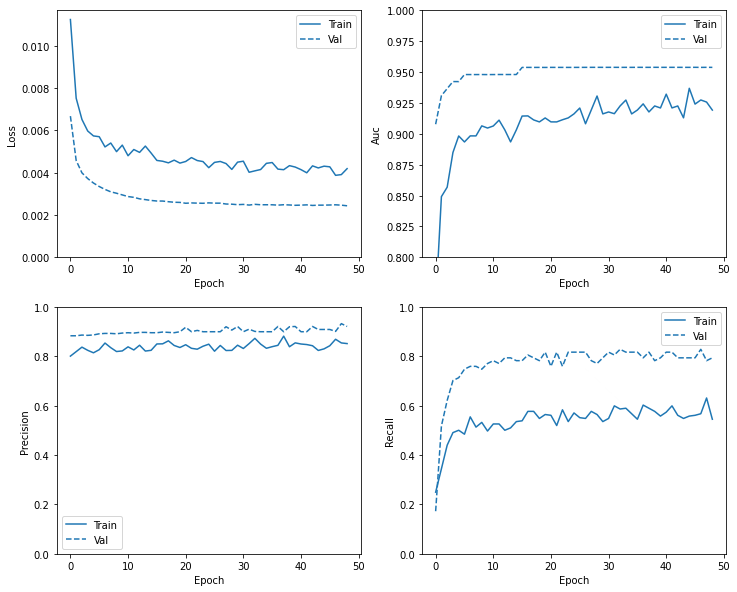

In [26]:
plot_metrics(baseline_history)

Note: That the validation curve generally performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model.

### Evaluate metrics

You can use a [confusion matrix](https://developers.google.com/machine-learning/glossary/#confusion_matrix) to summarize the actual vs. predicted labels where the X axis is the predicted label and the Y axis is the actual label.

In [27]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [28]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Evaluate your model on the test dataset and display the results for the metrics you created above.

loss :  0.002310588490217924
tp :  69.0
fp :  5.0
tn :  56866.0
fn :  22.0
accuracy :  0.9995260238647461
precision :  0.9324324131011963
recall :  0.7582417726516724
auc :  0.9557874202728271

Legitimate Transactions Detected (True Negatives):  56866
Legitimate Transactions Incorrectly Detected (False Positives):  5
Fraudulent Transactions Missed (False Negatives):  22
Fraudulent Transactions Detected (True Positives):  69
Total Fraudulent Transactions:  91


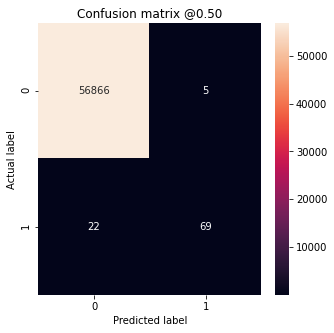

In [29]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

If the model had predicted everything perfectly, this would be a [diagonal matrix](https://en.wikipedia.org/wiki/Diagonal_matrix) where values off the main diagonal, indicating incorrect predictions, would be zero. In this case the matrix shows that you have relatively few false positives, meaning that there were relatively few legitimate transactions that were incorrectly flagged. However, you would likely want to have even fewer false negatives despite the cost of increasing the number of false positives. This trade off may be preferable because false negatives would allow fraudulent transactions to go through, whereas false positives may cause an email to be sent to a customer to ask them to verify their card activity.

### Plot the ROC

Now plot the [ROC](https://developers.google.com/machine-learning/glossary#ROC). This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.

In [30]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

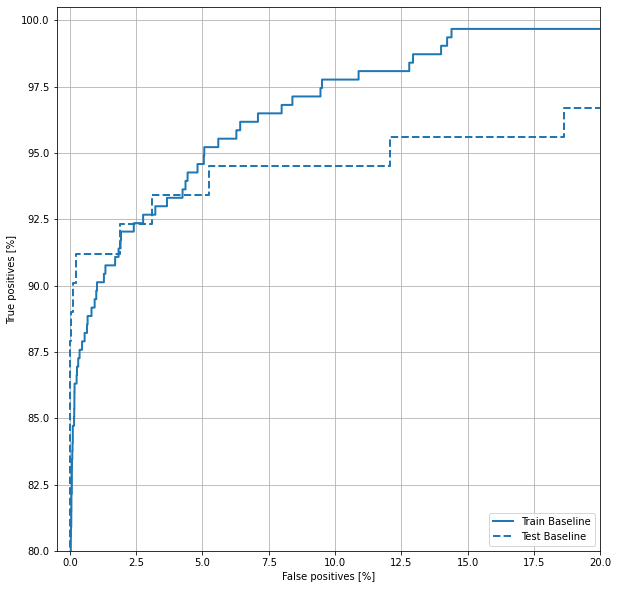

In [31]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

It looks like the precision is relatively high, but the recall and the area under the ROC curve (AUC) aren't as high as you might like. Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. It is important to consider the costs of different types of errors in the context of the problem you care about. In this example, a false negative (a fraudulent transaction is missed) may have a financial cost, while a false positive (a transaction is incorrectly flagged as fraudulent) may decrease user happiness.

## Class weights

### Calculate class weights

The goal is to identify fraudulent transactions, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [32]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


### Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Note: Using `class_weights` changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like `optimizers.SGD`, may fail. The optimizer used here, `optimizers.Adam`, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [33]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/100


 1/90 [..............................] - ETA: 0s - loss: 5.9788 - tp: 69.0000 - fp: 5.0000 - tn: 58908.0000 - fn: 28.0000 - accuracy: 0.9994 - precision: 0.9324 - recall: 0.7113 - auc: 0.9325

12/90 [===>..........................] - ETA: 0s - loss: 3.6648 - tp: 70.0000 - fp: 8.0000 - tn: 81397.0000 - fn: 63.0000 - accuracy: 0.9991 - precision: 0.8974 - recall: 0.5263 - auc: 0.8379

23/90 [======>.......................] - ETA: 0s - loss: 3.2285 - tp: 71.0000 - fp: 16.0000 - tn: 103882.0000 - fn: 97.0000 - accuracy: 0.9989 - precision: 0.8161 - recall: 0.4226 - auc: 0.7897

34/90 [==========>...................] - ETA: 0s - loss: 3.2314 - tp: 77.0000 - fp: 25.0000 - tn: 126356.0000 - fn: 136.0000 - accuracy: 0.9987 - precision: 0.7549 - recall: 0.3615 - auc: 0.7706

45/90 [==============>...............] - ETA: 0s - loss: 2.9110 - tp: 78.0000 - fp: 31.0000 - tn: 148848.0000 - fn: 165.0000 - accuracy: 0.9987 - precision: 0.7156 - recall: 0.3210 - auc: 0.7708

56/90 [=================>............] - ETA: 0s - loss: 2.9061 - tp: 84.0000 - fp: 38.0000 - tn: 171321.0000 - fn: 207.0000 - accuracy: 0.9986 - precision: 0.6885 - recall: 0.2887 - auc: 0.7725

67/90 [=====================>........] - ETA: 0s - loss: 2.7745 - tp: 88.0000 - fp: 45.0000 - tn: 193801.0000 - fn: 244.0000 - accuracy: 0.9985 - precision: 0.6617 - recall: 0.2651 - auc: 0.7774

79/90 [=========================>....] - ETA: 0s - loss: 2.6626 - tp: 98.0000 - fp: 56.0000 - tn: 218324.0000 - fn: 276.0000 - accuracy: 0.9985 - precision: 0.6364 - recall: 0.2620 - auc: 0.7782

90/90 [==============================] - ETA: 0s - loss: 2.5149 - tp: 105.0000 - fp: 66.0000 - tn: 238767.0000 - fn: 300.0000 - accuracy: 0.9985 - precision: 0.6140 - recall: 0.2593 - auc: 0.7803

90/90 [==============================] - 1s 15ms/step - loss: 2.5149 - tp: 105.0000 - fp: 66.0000 - tn: 238767.0000 - fn: 300.0000 - accuracy: 0.9985 - precision: 0.6140 - recall: 0.2593 - auc: 0.7803 - val_loss: 0.0067 - val_tp: 25.0000 - val_fp: 6.0000 - val_tn: 45476.0000 - val_fn: 62.0000 - val_accuracy: 0.9985 - val_precision: 0.8065 - val_recall: 0.2874 - val_auc: 0.9211


Epoch 2/100
 1/90 [..............................] - ETA: 0s - loss: 4.1209 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2041.0000 - fn: 5.0000 - accuracy: 0.9976 - precision: 1.0000 - recall: 0.2857 - auc: 0.6718

12/90 [===>..........................] - ETA: 0s - loss: 1.4426 - tp: 13.0000 - fp: 6.0000 - tn: 24532.0000 - fn: 25.0000 - accuracy: 0.9987 - precision: 0.6842 - recall: 0.3421 - auc: 0.7691 

23/90 [======>.......................] - ETA: 0s - loss: 1.3868 - tp: 33.0000 - fp: 16.0000 - tn: 47010.0000 - fn: 45.0000 - accuracy: 0.9987 - precision: 0.6735 - recall: 0.4231 - auc: 0.8078

34/90 [==========>...................] - ETA: 0s - loss: 1.4568 - tp: 54.0000 - fp: 33.0000 - tn: 69473.0000 - fn: 72.0000 - accuracy: 0.9985 - precision: 0.6207 - recall: 0.4286 - auc: 0.8352

45/90 [==============>...............] - ETA: 0s - loss: 1.4375 - tp: 69.0000 - fp: 49.0000 - tn: 91944.0000 - fn: 98.0000 - accuracy: 0.9984 - precision: 0.5847 - recall: 0.4132 - auc: 0.8505

56/90 [=================>............] - ETA: 0s - loss: 1.3715 - tp: 87.0000 - fp: 60.0000 - tn: 114425.0000 - fn: 116.0000 - accuracy: 0.9985 - precision: 0.5918 - recall: 0.4286 - auc: 0.8489

67/90 [=====================>........] - ETA: 0s - loss: 1.3145 - tp: 102.0000 - fp: 75.0000 - tn: 136904.0000 - fn: 135.0000 - accuracy: 0.9985 - precision: 0.5763 - recall: 0.4304 - auc: 0.8524

78/90 [=========================>....] - ETA: 0s - loss: 1.2958 - tp: 128.0000 - fp: 103.0000 - tn: 159359.0000 - fn: 154.0000 - accuracy: 0.9984 - precision: 0.5541 - recall: 0.4539 - auc: 0.8576

89/90 [============================>.] - ETA: 0s - loss: 1.2482 - tp: 145.0000 - fp: 124.0000 - tn: 181834.0000 - fn: 169.0000 - accuracy: 0.9984 - precision: 0.5390 - recall: 0.4618 - auc: 0.8560

90/90 [==============================] - 1s 6ms/step - loss: 1.2482 - tp: 145.0000 - fp: 124.0000 - tn: 181838.0000 - fn: 169.0000 - accuracy: 0.9984 - precision: 0.5390 - recall: 0.4618 - auc: 0.8560 - val_loss: 0.0062 - val_tp: 68.0000 - val_fp: 12.0000 - val_tn: 45470.0000 - val_fn: 19.0000 - val_accuracy: 0.9993 - val_precision: 0.8500 - val_recall: 0.7816 - val_auc: 0.9408


Epoch 3/100


 1/90 [..............................] - ETA: 0s - loss: 1.2601 - tp: 2.0000 - fp: 2.0000 - tn: 2042.0000 - fn: 2.0000 - accuracy: 0.9980 - precision: 0.5000 - recall: 0.5000 - auc: 0.8479

12/90 [===>..........................] - ETA: 0s - loss: 1.1489 - tp: 27.0000 - fp: 25.0000 - tn: 24500.0000 - fn: 24.0000 - accuracy: 0.9980 - precision: 0.5192 - recall: 0.5294 - auc: 0.9009

23/90 [======>.......................] - ETA: 0s - loss: 0.8124 - tp: 49.0000 - fp: 53.0000 - tn: 46966.0000 - fn: 36.0000 - accuracy: 0.9981 - precision: 0.4804 - recall: 0.5765 - auc: 0.9248

34/90 [==========>...................] - ETA: 0s - loss: 0.9567 - tp: 69.0000 - fp: 73.0000 - tn: 69430.0000 - fn: 60.0000 - accuracy: 0.9981 - precision: 0.4859 - recall: 0.5349 - auc: 0.9019

45/90 [==============>...............] - ETA: 0s - loss: 0.9375 - tp: 89.0000 - fp: 102.0000 - tn: 91891.0000 - fn: 78.0000 - accuracy: 0.9980 - precision: 0.4660 - recall: 0.5329 - auc: 0.9050

56/90 [=================>............] - ETA: 0s - loss: 0.9648 - tp: 106.0000 - fp: 125.0000 - tn: 114362.0000 - fn: 95.0000 - accuracy: 0.9981 - precision: 0.4589 - recall: 0.5274 - auc: 0.8873

67/90 [=====================>........] - ETA: 0s - loss: 0.9465 - tp: 132.0000 - fp: 165.0000 - tn: 136809.0000 - fn: 110.0000 - accuracy: 0.9980 - precision: 0.4444 - recall: 0.5455 - auc: 0.8865

78/90 [=========================>....] - ETA: 0s - loss: 0.9335 - tp: 158.0000 - fp: 199.0000 - tn: 159262.0000 - fn: 125.0000 - accuracy: 0.9980 - precision: 0.4426 - recall: 0.5583 - auc: 0.8868

89/90 [============================>.] - ETA: 0s - loss: 0.8972 - tp: 177.0000 - fp: 237.0000 - tn: 181721.0000 - fn: 137.0000 - accuracy: 0.9979 - precision: 0.4275 - recall: 0.5637 - auc: 0.8876

90/90 [==============================] - 1s 6ms/step - loss: 0.8972 - tp: 177.0000 - fp: 237.0000 - tn: 181725.0000 - fn: 137.0000 - accuracy: 0.9979 - precision: 0.4275 - recall: 0.5637 - auc: 0.8876 - val_loss: 0.0079 - val_tp: 73.0000 - val_fp: 16.0000 - val_tn: 45466.0000 - val_fn: 14.0000 - val_accuracy: 0.9993 - val_precision: 0.8202 - val_recall: 0.8391 - val_auc: 0.9518


Epoch 4/100
 1/90 [..............................] - ETA: 0s - loss: 2.0494 - tp: 5.0000 - fp: 2.0000 - tn: 2038.0000 - fn: 3.0000 - accuracy: 0.9976 - precision: 0.7143 - recall: 0.6250 - auc: 0.8892

12/90 [===>..........................] - ETA: 0s - loss: 0.9620 - tp: 34.0000 - fp: 39.0000 - tn: 24484.0000 - fn: 19.0000 - accuracy: 0.9976 - precision: 0.4658 - recall: 0.6415 - auc: 0.8846

23/90 [======>.......................] - ETA: 0s - loss: 0.8758 - tp: 52.0000 - fp: 74.0000 - tn: 46946.0000 - fn: 32.0000 - accuracy: 0.9977 - precision: 0.4127 - recall: 0.6190 - auc: 0.8689

33/90 [==========>...................] - ETA: 0s - loss: 0.8912 - tp: 74.0000 - fp: 122.0000 - tn: 67339.0000 - fn: 49.0000 - accuracy: 0.9975 - precision: 0.3776 - recall: 0.6016 - auc: 0.8786

44/90 [=============>................] - ETA: 0s - loss: 0.8553 - tp: 105.0000 - fp: 171.0000 - tn: 89776.0000 - fn: 60.0000 - accuracy: 0.9974 - precision: 0.3804 - recall: 0.6364 - auc: 0.8805

55/90 [=================>............] - ETA: 0s - loss: 0.8321 - tp: 134.0000 - fp: 226.0000 - tn: 112208.0000 - fn: 72.0000 - accuracy: 0.9974 - precision: 0.3722 - recall: 0.6505 - auc: 0.8868

66/90 [=====================>........] - ETA: 0s - loss: 0.7696 - tp: 156.0000 - fp: 275.0000 - tn: 134657.0000 - fn: 80.0000 - accuracy: 0.9974 - precision: 0.3619 - recall: 0.6610 - auc: 0.8894

77/90 [========================>.....] - ETA: 0s - loss: 0.7118 - tp: 177.0000 - fp: 323.0000 - tn: 157107.0000 - fn: 89.0000 - accuracy: 0.9974 - precision: 0.3540 - recall: 0.6654 - auc: 0.8937

88/90 [============================>.] - ETA: 0s - loss: 0.7026 - tp: 207.0000 - fp: 383.0000 - tn: 179531.0000 - fn: 103.0000 - accuracy: 0.9973 - precision: 0.3508 - recall: 0.6677 - auc: 0.9016

90/90 [==============================] - 1s 6ms/step - loss: 0.6983 - tp: 210.0000 - fp: 387.0000 - tn: 181575.0000 - fn: 104.0000 - accuracy: 0.9973 - precision: 0.3518 - recall: 0.6688 - auc: 0.9028 - val_loss: 0.0098 - val_tp: 74.0000 - val_fp: 19.0000 - val_tn: 45463.0000 - val_fn: 13.0000 - val_accuracy: 0.9993 - val_precision: 0.7957 - val_recall: 0.8506 - val_auc: 0.9600


Epoch 5/100


 1/90 [..............................] - ETA: 0s - loss: 0.0134 - tp: 1.0000 - fp: 12.0000 - tn: 2035.0000 - fn: 0.0000e+00 - accuracy: 0.9941 - precision: 0.0769 - recall: 1.0000 - auc: 0.9995

12/90 [===>..........................] - ETA: 0s - loss: 0.5050 - tp: 23.0000 - fp: 74.0000 - tn: 24468.0000 - fn: 11.0000 - accuracy: 0.9965 - precision: 0.2371 - recall: 0.6765 - auc: 0.9209 

23/90 [======>.......................] - ETA: 0s - loss: 0.5718 - tp: 54.0000 - fp: 130.0000 - tn: 46899.0000 - fn: 21.0000 - accuracy: 0.9968 - precision: 0.2935 - recall: 0.7200 - auc: 0.9058

34/90 [==========>...................] - ETA: 0s - loss: 0.5436 - tp: 81.0000 - fp: 193.0000 - tn: 69329.0000 - fn: 29.0000 - accuracy: 0.9968 - precision: 0.2956 - recall: 0.7364 - auc: 0.9137

45/90 [==============>...............] - ETA: 0s - loss: 0.4881 - tp: 111.0000 - fp: 264.0000 - tn: 91748.0000 - fn: 37.0000 - accuracy: 0.9967 - precision: 0.2960 - recall: 0.7500 - auc: 0.9314

56/90 [=================>............] - ETA: 0s - loss: 0.6064 - tp: 142.0000 - fp: 324.0000 - tn: 114167.0000 - fn: 55.0000 - accuracy: 0.9967 - precision: 0.3047 - recall: 0.7208 - auc: 0.9148

67/90 [=====================>........] - ETA: 0s - loss: 0.6167 - tp: 168.0000 - fp: 404.0000 - tn: 136576.0000 - fn: 68.0000 - accuracy: 0.9966 - precision: 0.2937 - recall: 0.7119 - auc: 0.9138

78/90 [=========================>....] - ETA: 0s - loss: 0.5955 - tp: 201.0000 - fp: 488.0000 - tn: 158978.0000 - fn: 77.0000 - accuracy: 0.9965 - precision: 0.2917 - recall: 0.7230 - auc: 0.9167

89/90 [============================>.] - ETA: 0s - loss: 0.6418 - tp: 220.0000 - fp: 583.0000 - tn: 181375.0000 - fn: 94.0000 - accuracy: 0.9963 - precision: 0.2740 - recall: 0.7006 - auc: 0.9084

90/90 [==============================] - 1s 6ms/step - loss: 0.6417 - tp: 220.0000 - fp: 583.0000 - tn: 181379.0000 - fn: 94.0000 - accuracy: 0.9963 - precision: 0.2740 - recall: 0.7006 - auc: 0.9084 - val_loss: 0.0119 - val_tp: 74.0000 - val_fp: 25.0000 - val_tn: 45457.0000 - val_fn: 13.0000 - val_accuracy: 0.9992 - val_precision: 0.7475 - val_recall: 0.8506 - val_auc: 0.9777


Epoch 6/100
 1/90 [..............................] - ETA: 0s - loss: 1.0759 - tp: 1.0000 - fp: 7.0000 - tn: 2039.0000 - fn: 1.0000 - accuracy: 0.9961 - precision: 0.1250 - recall: 0.5000 - auc: 0.6518

12/90 [===>..........................] - ETA: 0s - loss: 0.3746 - tp: 29.0000 - fp: 117.0000 - tn: 24423.0000 - fn: 7.0000 - accuracy: 0.9950 - precision: 0.1986 - recall: 0.8056 - auc: 0.9468

23/90 [======>.......................] - ETA: 0s - loss: 0.5521 - tp: 61.0000 - fp: 211.0000 - tn: 46813.0000 - fn: 19.0000 - accuracy: 0.9951 - precision: 0.2243 - recall: 0.7625 - auc: 0.9086

34/90 [==========>...................] - ETA: 0s - loss: 0.6051 - tp: 98.0000 - fp: 302.0000 - tn: 69200.0000 - fn: 32.0000 - accuracy: 0.9952 - precision: 0.2450 - recall: 0.7538 - auc: 0.9067

45/90 [==============>...............] - ETA: 0s - loss: 0.6747 - tp: 126.0000 - fp: 427.0000 - tn: 91560.0000 - fn: 47.0000 - accuracy: 0.9949 - precision: 0.2278 - recall: 0.7283 - auc: 0.8952

57/90 [==================>...........] - ETA: 0s - loss: 0.6120 - tp: 157.0000 - fp: 570.0000 - tn: 115954.0000 - fn: 55.0000 - accuracy: 0.9946 - precision: 0.2160 - recall: 0.7406 - auc: 0.9053

68/90 [=====================>........] - ETA: 0s - loss: 0.5893 - tp: 180.0000 - fp: 694.0000 - tn: 138327.0000 - fn: 63.0000 - accuracy: 0.9946 - precision: 0.2059 - recall: 0.7407 - auc: 0.9062

79/90 [=========================>....] - ETA: 0s - loss: 0.5990 - tp: 207.0000 - fp: 842.0000 - tn: 160669.0000 - fn: 74.0000 - accuracy: 0.9943 - precision: 0.1973 - recall: 0.7367 - auc: 0.9020

90/90 [==============================] - ETA: 0s - loss: 0.5846 - tp: 232.0000 - fp: 977.0000 - tn: 180985.0000 - fn: 82.0000 - accuracy: 0.9942 - precision: 0.1919 - recall: 0.7389 - auc: 0.9048

90/90 [==============================] - 1s 6ms/step - loss: 0.5846 - tp: 232.0000 - fp: 977.0000 - tn: 180985.0000 - fn: 82.0000 - accuracy: 0.9942 - precision: 0.1919 - recall: 0.7389 - auc: 0.9048 - val_loss: 0.0148 - val_tp: 74.0000 - val_fp: 34.0000 - val_tn: 45448.0000 - val_fn: 13.0000 - val_accuracy: 0.9990 - val_precision: 0.6852 - val_recall: 0.8506 - val_auc: 0.9802


Epoch 7/100
 1/90 [..............................] - ETA: 0s - loss: 0.0812 - tp: 5.0000 - fp: 7.0000 - tn: 2036.0000 - fn: 0.0000e+00 - accuracy: 0.9966 - precision: 0.4167 - recall: 1.0000 - auc: 0.9997

12/90 [===>..........................] - ETA: 0s - loss: 0.6184 - tp: 47.0000 - fp: 162.0000 - tn: 24354.0000 - fn: 13.0000 - accuracy: 0.9929 - precision: 0.2249 - recall: 0.7833 - auc: 0.9355

24/90 [=======>......................] - ETA: 0s - loss: 0.6227 - tp: 83.0000 - fp: 358.0000 - tn: 48688.0000 - fn: 23.0000 - accuracy: 0.9922 - precision: 0.1882 - recall: 0.7830 - auc: 0.9200

35/90 [==========>...................] - ETA: 0s - loss: 0.5931 - tp: 118.0000 - fp: 512.0000 - tn: 71017.0000 - fn: 33.0000 - accuracy: 0.9924 - precision: 0.1873 - recall: 0.7815 - auc: 0.9269

46/90 [==============>...............] - ETA: 0s - loss: 0.5726 - tp: 149.0000 - fp: 680.0000 - tn: 93337.0000 - fn: 42.0000 - accuracy: 0.9923 - precision: 0.1797 - recall: 0.7801 - auc: 0.9256

57/90 [==================>...........] - ETA: 0s - loss: 0.5567 - tp: 163.0000 - fp: 875.0000 - tn: 115647.0000 - fn: 51.0000 - accuracy: 0.9921 - precision: 0.1570 - recall: 0.7617 - auc: 0.9204

69/90 [======================>.......] - ETA: 0s - loss: 0.5090 - tp: 191.0000 - fp: 1103.0000 - tn: 139960.0000 - fn: 58.0000 - accuracy: 0.9918 - precision: 0.1476 - recall: 0.7671 - auc: 0.9258

81/90 [==========================>...] - ETA: 0s - loss: 0.5419 - tp: 213.0000 - fp: 1330.0000 - tn: 164273.0000 - fn: 72.0000 - accuracy: 0.9915 - precision: 0.1380 - recall: 0.7474 - auc: 0.9176

90/90 [==============================] - 1s 6ms/step - loss: 0.5404 - tp: 234.0000 - fp: 1464.0000 - tn: 180498.0000 - fn: 80.0000 - accuracy: 0.9915 - precision: 0.1378 - recall: 0.7452 - auc: 0.9190 - val_loss: 0.0183 - val_tp: 74.0000 - val_fp: 50.0000 - val_tn: 45432.0000 - val_fn: 13.0000 - val_accuracy: 0.9986 - val_precision: 0.5968 - val_recall: 0.8506 - val_auc: 0.9823


Epoch 8/100
 1/90 [..............................] - ETA: 0s - loss: 0.0186 - tp: 3.0000 - fp: 22.0000 - tn: 2023.0000 - fn: 0.0000e+00 - accuracy: 0.9893 - precision: 0.1200 - recall: 1.0000 - auc: 0.9998

13/90 [===>..........................] - ETA: 0s - loss: 0.2663 - tp: 42.0000 - fp: 244.0000 - tn: 26332.0000 - fn: 6.0000 - accuracy: 0.9906 - precision: 0.1469 - recall: 0.8750 - auc: 0.9637 

25/90 [=======>......................] - ETA: 0s - loss: 0.3181 - tp: 72.0000 - fp: 485.0000 - tn: 50627.0000 - fn: 16.0000 - accuracy: 0.9902 - precision: 0.1293 - recall: 0.8182 - auc: 0.9556

37/90 [===========>..................] - ETA: 0s - loss: 0.3202 - tp: 105.0000 - fp: 716.0000 - tn: 74933.0000 - fn: 22.0000 - accuracy: 0.9903 - precision: 0.1279 - recall: 0.8268 - auc: 0.9541

49/90 [===============>..............] - ETA: 0s - loss: 0.3742 - tp: 138.0000 - fp: 957.0000 - tn: 99224.0000 - fn: 33.0000 - accuracy: 0.9901 - precision: 0.1260 - recall: 0.8070 - auc: 0.9443

61/90 [===================>..........] - ETA: 0s - loss: 0.3903 - tp: 164.0000 - fp: 1217.0000 - tn: 123502.0000 - fn: 45.0000 - accuracy: 0.9899 - precision: 0.1188 - recall: 0.7847 - auc: 0.9408

73/90 [=======================>......] - ETA: 0s - loss: 0.4014 - tp: 193.0000 - fp: 1484.0000 - tn: 147771.0000 - fn: 56.0000 - accuracy: 0.9897 - precision: 0.1151 - recall: 0.7751 - auc: 0.9412

85/90 [===========================>..] - ETA: 0s - loss: 0.4496 - tp: 226.0000 - fp: 1769.0000 - tn: 172017.0000 - fn: 68.0000 - accuracy: 0.9894 - precision: 0.1133 - recall: 0.7687 - auc: 0.9280

90/90 [==============================] - 1s 6ms/step - loss: 0.4714 - tp: 241.0000 - fp: 1862.0000 - tn: 180100.0000 - fn: 73.0000 - accuracy: 0.9894 - precision: 0.1146 - recall: 0.7675 - auc: 0.9252 - val_loss: 0.0225 - val_tp: 76.0000 - val_fp: 84.0000 - val_tn: 45398.0000 - val_fn: 11.0000 - val_accuracy: 0.9979 - val_precision: 0.4750 - val_recall: 0.8736 - val_auc: 0.9851


Epoch 9/100
 1/90 [..............................] - ETA: 0s - loss: 0.7176 - tp: 3.0000 - fp: 22.0000 - tn: 2022.0000 - fn: 1.0000 - accuracy: 0.9888 - precision: 0.1200 - recall: 0.7500 - auc: 0.8881

12/90 [===>..........................] - ETA: 0s - loss: 0.4688 - tp: 40.0000 - fp: 315.0000 - tn: 24212.0000 - fn: 9.0000 - accuracy: 0.9868 - precision: 0.1127 - recall: 0.8163 - auc: 0.9347

24/90 [=======>......................] - ETA: 0s - loss: 0.5193 - tp: 69.0000 - fp: 628.0000 - tn: 48435.0000 - fn: 20.0000 - accuracy: 0.9868 - precision: 0.0990 - recall: 0.7753 - auc: 0.9169

36/90 [===========>..................] - ETA: 0s - loss: 0.5129 - tp: 102.0000 - fp: 961.0000 - tn: 72634.0000 - fn: 31.0000 - accuracy: 0.9865 - precision: 0.0960 - recall: 0.7669 - auc: 0.9212

47/90 [==============>...............] - ETA: 0s - loss: 0.4754 - tp: 139.0000 - fp: 1266.0000 - tn: 94812.0000 - fn: 39.0000 - accuracy: 0.9864 - precision: 0.0989 - recall: 0.7809 - auc: 0.9333

58/90 [==================>...........] - ETA: 0s - loss: 0.4498 - tp: 173.0000 - fp: 1592.0000 - tn: 116972.0000 - fn: 47.0000 - accuracy: 0.9862 - precision: 0.0980 - recall: 0.7864 - auc: 0.9388

69/90 [======================>.......] - ETA: 0s - loss: 0.4399 - tp: 198.0000 - fp: 1884.0000 - tn: 139176.0000 - fn: 54.0000 - accuracy: 0.9863 - precision: 0.0951 - recall: 0.7857 - auc: 0.9356

80/90 [=========================>....] - ETA: 0s - loss: 0.4548 - tp: 230.0000 - fp: 2245.0000 - tn: 161301.0000 - fn: 64.0000 - accuracy: 0.9859 - precision: 0.0929 - recall: 0.7823 - auc: 0.9336

90/90 [==============================] - 1s 6ms/step - loss: 0.4329 - tp: 247.0000 - fp: 2508.0000 - tn: 179454.0000 - fn: 67.0000 - accuracy: 0.9859 - precision: 0.0897 - recall: 0.7866 - auc: 0.9345 - val_loss: 0.0282 - val_tp: 76.0000 - val_fp: 170.0000 - val_tn: 45312.0000 - val_fn: 11.0000 - val_accuracy: 0.9960 - val_precision: 0.3089 - val_recall: 0.8736 - val_auc: 0.9873


Epoch 10/100
 1/90 [..............................] - ETA: 0s - loss: 0.0445 - tp: 3.0000 - fp: 30.0000 - tn: 2015.0000 - fn: 0.0000e+00 - accuracy: 0.9854 - precision: 0.0909 - recall: 1.0000 - auc: 0.9979

12/90 [===>..........................] - ETA: 0s - loss: 0.3676 - tp: 34.0000 - fp: 386.0000 - tn: 24148.0000 - fn: 8.0000 - accuracy: 0.9840 - precision: 0.0810 - recall: 0.8095 - auc: 0.9495 

22/90 [======>.......................] - ETA: 0s - loss: 0.4221 - tp: 62.0000 - fp: 723.0000 - tn: 44255.0000 - fn: 16.0000 - accuracy: 0.9836 - precision: 0.0790 - recall: 0.7949 - auc: 0.9347

34/90 [==========>...................] - ETA: 0s - loss: 0.5035 - tp: 93.0000 - fp: 1147.0000 - tn: 68363.0000 - fn: 29.0000 - accuracy: 0.9831 - precision: 0.0750 - recall: 0.7623 - auc: 0.9142

46/90 [==============>...............] - ETA: 0s - loss: 0.4747 - tp: 136.0000 - fp: 1588.0000 - tn: 92447.0000 - fn: 37.0000 - accuracy: 0.9828 - precision: 0.0789 - recall: 0.7861 - auc: 0.9228

57/90 [==================>...........] - ETA: 0s - loss: 0.4748 - tp: 167.0000 - fp: 1960.0000 - tn: 114562.0000 - fn: 47.0000 - accuracy: 0.9828 - precision: 0.0785 - recall: 0.7804 - auc: 0.9219

69/90 [======================>.......] - ETA: 0s - loss: 0.4587 - tp: 196.0000 - fp: 2399.0000 - tn: 138664.0000 - fn: 53.0000 - accuracy: 0.9826 - precision: 0.0755 - recall: 0.7871 - auc: 0.9198

80/90 [=========================>....] - ETA: 0s - loss: 0.4530 - tp: 220.0000 - fp: 2812.0000 - tn: 160748.0000 - fn: 60.0000 - accuracy: 0.9825 - precision: 0.0726 - recall: 0.7857 - auc: 0.9188

90/90 [==============================] - 1s 6ms/step - loss: 0.4467 - tp: 249.0000 - fp: 3175.0000 - tn: 178787.0000 - fn: 65.0000 - accuracy: 0.9822 - precision: 0.0727 - recall: 0.7930 - auc: 0.9210 - val_loss: 0.0341 - val_tp: 78.0000 - val_fp: 282.0000 - val_tn: 45200.0000 - val_fn: 9.0000 - val_accuracy: 0.9936 - val_precision: 0.2167 - val_recall: 0.8966 - val_auc: 0.9881


Epoch 11/100
 1/90 [..............................] - ETA: 0s - loss: 0.0339 - tp: 1.0000 - fp: 36.0000 - tn: 2011.0000 - fn: 0.0000e+00 - accuracy: 0.9824 - precision: 0.0270 - recall: 1.0000 - auc: 0.9988

13/90 [===>..........................] - ETA: 0s - loss: 0.2903 - tp: 30.0000 - fp: 494.0000 - tn: 26092.0000 - fn: 8.0000 - accuracy: 0.9811 - precision: 0.0573 - recall: 0.7895 - auc: 0.9611 

24/90 [=======>......................] - ETA: 0s - loss: 0.4495 - tp: 55.0000 - fp: 880.0000 - tn: 48199.0000 - fn: 18.0000 - accuracy: 0.9817 - precision: 0.0588 - recall: 0.7534 - auc: 0.9155

35/90 [==========>...................] - ETA: 0s - loss: 0.4971 - tp: 88.0000 - fp: 1350.0000 - tn: 70215.0000 - fn: 27.0000 - accuracy: 0.9808 - precision: 0.0612 - recall: 0.7652 - auc: 0.8987

46/90 [==============>...............] - ETA: 0s - loss: 0.4941 - tp: 128.0000 - fp: 1789.0000 - tn: 92256.0000 - fn: 35.0000 - accuracy: 0.9806 - precision: 0.0668 - recall: 0.7853 - auc: 0.9081

57/90 [==================>...........] - ETA: 0s - loss: 0.4164 - tp: 163.0000 - fp: 2229.0000 - tn: 114307.0000 - fn: 37.0000 - accuracy: 0.9806 - precision: 0.0681 - recall: 0.8150 - auc: 0.9241

67/90 [=====================>........] - ETA: 0s - loss: 0.4071 - tp: 205.0000 - fp: 2643.0000 - tn: 134325.0000 - fn: 43.0000 - accuracy: 0.9804 - precision: 0.0720 - recall: 0.8266 - auc: 0.9301

78/90 [=========================>....] - ETA: 0s - loss: 0.4012 - tp: 233.0000 - fp: 3107.0000 - tn: 156355.0000 - fn: 49.0000 - accuracy: 0.9802 - precision: 0.0698 - recall: 0.8262 - auc: 0.9285

89/90 [============================>.] - ETA: 0s - loss: 0.3947 - tp: 260.0000 - fp: 3569.0000 - tn: 178389.0000 - fn: 54.0000 - accuracy: 0.9801 - precision: 0.0679 - recall: 0.8280 - auc: 0.9290

90/90 [==============================] - 1s 6ms/step - loss: 0.3947 - tp: 260.0000 - fp: 3569.0000 - tn: 178393.0000 - fn: 54.0000 - accuracy: 0.9801 - precision: 0.0679 - recall: 0.8280 - auc: 0.9290 - val_loss: 0.0394 - val_tp: 78.0000 - val_fp: 346.0000 - val_tn: 45136.0000 - val_fn: 9.0000 - val_accuracy: 0.9922 - val_precision: 0.1840 - val_recall: 0.8966 - val_auc: 0.9877


Epoch 12/100
 1/90 [..............................] - ETA: 0s - loss: 0.0557 - tp: 5.0000 - fp: 42.0000 - tn: 2001.0000 - fn: 0.0000e+00 - accuracy: 0.9795 - precision: 0.1064 - recall: 1.0000 - auc: 0.9989

12/90 [===>..........................] - ETA: 0s - loss: 0.4685 - tp: 30.0000 - fp: 552.0000 - tn: 23984.0000 - fn: 10.0000 - accuracy: 0.9771 - precision: 0.0515 - recall: 0.7500 - auc: 0.9212

23/90 [======>.......................] - ETA: 0s - loss: 0.3875 - tp: 62.0000 - fp: 1062.0000 - tn: 45965.0000 - fn: 15.0000 - accuracy: 0.9771 - precision: 0.0552 - recall: 0.8052 - auc: 0.9368

34/90 [==========>...................] - ETA: 0s - loss: 0.3528 - tp: 94.0000 - fp: 1574.0000 - tn: 67944.0000 - fn: 20.0000 - accuracy: 0.9771 - precision: 0.0564 - recall: 0.8246 - auc: 0.9397

45/90 [==============>...............] - ETA: 0s - loss: 0.3435 - tp: 130.0000 - fp: 2082.0000 - tn: 89921.0000 - fn: 27.0000 - accuracy: 0.9771 - precision: 0.0588 - recall: 0.8280 - auc: 0.9472

56/90 [=================>............] - ETA: 0s - loss: 0.3691 - tp: 155.0000 - fp: 2625.0000 - tn: 111872.0000 - fn: 36.0000 - accuracy: 0.9768 - precision: 0.0558 - recall: 0.8115 - auc: 0.9411

67/90 [=====================>........] - ETA: 0s - loss: 0.4001 - tp: 188.0000 - fp: 3184.0000 - tn: 133798.0000 - fn: 46.0000 - accuracy: 0.9765 - precision: 0.0558 - recall: 0.8034 - auc: 0.9352

78/90 [=========================>....] - ETA: 0s - loss: 0.3772 - tp: 226.0000 - fp: 3705.0000 - tn: 155763.0000 - fn: 50.0000 - accuracy: 0.9765 - precision: 0.0575 - recall: 0.8188 - auc: 0.9399

89/90 [============================>.] - ETA: 0s - loss: 0.3694 - tp: 257.0000 - fp: 4294.0000 - tn: 177664.0000 - fn: 57.0000 - accuracy: 0.9761 - precision: 0.0565 - recall: 0.8185 - auc: 0.9418

90/90 [==============================] - 1s 6ms/step - loss: 0.3694 - tp: 257.0000 - fp: 4294.0000 - tn: 177668.0000 - fn: 57.0000 - accuracy: 0.9761 - precision: 0.0565 - recall: 0.8185 - auc: 0.9418 - val_loss: 0.0473 - val_tp: 78.0000 - val_fp: 504.0000 - val_tn: 44978.0000 - val_fn: 9.0000 - val_accuracy: 0.9887 - val_precision: 0.1340 - val_recall: 0.8966 - val_auc: 0.9879


Epoch 13/100
 1/90 [..............................] - ETA: 0s - loss: 0.0463 - tp: 1.0000 - fp: 55.0000 - tn: 1992.0000 - fn: 0.0000e+00 - accuracy: 0.9731 - precision: 0.0179 - recall: 1.0000 - auc: 0.9988

12/90 [===>..........................] - ETA: 0s - loss: 0.4188 - tp: 36.0000 - fp: 636.0000 - tn: 23894.0000 - fn: 10.0000 - accuracy: 0.9737 - precision: 0.0536 - recall: 0.7826 - auc: 0.9385

23/90 [======>.......................] - ETA: 0s - loss: 0.3232 - tp: 64.0000 - fp: 1234.0000 - tn: 45792.0000 - fn: 14.0000 - accuracy: 0.9735 - precision: 0.0493 - recall: 0.8205 - auc: 0.9505

34/90 [==========>...................] - ETA: 0s - loss: 0.2742 - tp: 94.0000 - fp: 1791.0000 - tn: 67729.0000 - fn: 18.0000 - accuracy: 0.9740 - precision: 0.0499 - recall: 0.8393 - auc: 0.9593

45/90 [==============>...............] - ETA: 0s - loss: 0.3223 - tp: 138.0000 - fp: 2406.0000 - tn: 89589.0000 - fn: 27.0000 - accuracy: 0.9736 - precision: 0.0542 - recall: 0.8364 - auc: 0.9516

56/90 [=================>............] - ETA: 0s - loss: 0.3324 - tp: 167.0000 - fp: 3007.0000 - tn: 111480.0000 - fn: 34.0000 - accuracy: 0.9735 - precision: 0.0526 - recall: 0.8308 - auc: 0.9478

68/90 [=====================>........] - ETA: 0s - loss: 0.3579 - tp: 204.0000 - fp: 3700.0000 - tn: 135317.0000 - fn: 43.0000 - accuracy: 0.9731 - precision: 0.0523 - recall: 0.8259 - auc: 0.9421

79/90 [=========================>....] - ETA: 0s - loss: 0.3502 - tp: 227.0000 - fp: 4356.0000 - tn: 157161.0000 - fn: 48.0000 - accuracy: 0.9728 - precision: 0.0495 - recall: 0.8255 - auc: 0.9391

90/90 [==============================] - ETA: 0s - loss: 0.3479 - tp: 262.0000 - fp: 4886.0000 - tn: 177076.0000 - fn: 52.0000 - accuracy: 0.9729 - precision: 0.0509 - recall: 0.8344 - auc: 0.9403

90/90 [==============================] - 1s 6ms/step - loss: 0.3479 - tp: 262.0000 - fp: 4886.0000 - tn: 177076.0000 - fn: 52.0000 - accuracy: 0.9729 - precision: 0.0509 - recall: 0.8344 - auc: 0.9403 - val_loss: 0.0539 - val_tp: 78.0000 - val_fp: 586.0000 - val_tn: 44896.0000 - val_fn: 9.0000 - val_accuracy: 0.9869 - val_precision: 0.1175 - val_recall: 0.8966 - val_auc: 0.9881


Epoch 14/100
 1/90 [..............................] - ETA: 0s - loss: 0.0546 - tp: 4.0000 - fp: 62.0000 - tn: 1982.0000 - fn: 0.0000e+00 - accuracy: 0.9697 - precision: 0.0606 - recall: 1.0000 - auc: 0.9983

12/90 [===>..........................] - ETA: 0s - loss: 0.4711 - tp: 33.0000 - fp: 694.0000 - tn: 23840.0000 - fn: 9.0000 - accuracy: 0.9714 - precision: 0.0454 - recall: 0.7857 - auc: 0.9110 

23/90 [======>.......................] - ETA: 0s - loss: 0.3769 - tp: 68.0000 - fp: 1329.0000 - tn: 45694.0000 - fn: 13.0000 - accuracy: 0.9715 - precision: 0.0487 - recall: 0.8395 - auc: 0.9339

34/90 [==========>...................] - ETA: 0s - loss: 0.3818 - tp: 92.0000 - fp: 2033.0000 - tn: 67489.0000 - fn: 18.0000 - accuracy: 0.9705 - precision: 0.0433 - recall: 0.8364 - auc: 0.9244

45/90 [==============>...............] - ETA: 0s - loss: 0.3980 - tp: 129.0000 - fp: 2688.0000 - tn: 89316.0000 - fn: 27.0000 - accuracy: 0.9705 - precision: 0.0458 - recall: 0.8269 - auc: 0.9276

57/90 [==================>...........] - ETA: 0s - loss: 0.4088 - tp: 163.0000 - fp: 3371.0000 - tn: 113167.0000 - fn: 35.0000 - accuracy: 0.9708 - precision: 0.0461 - recall: 0.8232 - auc: 0.9242

68/90 [=====================>........] - ETA: 0s - loss: 0.3851 - tp: 202.0000 - fp: 4021.0000 - tn: 135001.0000 - fn: 40.0000 - accuracy: 0.9708 - precision: 0.0478 - recall: 0.8347 - auc: 0.9322

80/90 [=========================>....] - ETA: 0s - loss: 0.3715 - tp: 230.0000 - fp: 4774.0000 - tn: 158790.0000 - fn: 46.0000 - accuracy: 0.9706 - precision: 0.0460 - recall: 0.8333 - auc: 0.9338

90/90 [==============================] - 1s 6ms/step - loss: 0.3653 - tp: 263.0000 - fp: 5360.0000 - tn: 176602.0000 - fn: 51.0000 - accuracy: 0.9703 - precision: 0.0468 - recall: 0.8376 - auc: 0.9370 - val_loss: 0.0610 - val_tp: 78.0000 - val_fp: 664.0000 - val_tn: 44818.0000 - val_fn: 9.0000 - val_accuracy: 0.9852 - val_precision: 0.1051 - val_recall: 0.8966 - val_auc: 0.9876


Epoch 15/100
 1/90 [..............................] - ETA: 0s - loss: 0.0754 - tp: 2.0000 - fp: 71.0000 - tn: 1975.0000 - fn: 0.0000e+00 - accuracy: 0.9653 - precision: 0.0274 - recall: 1.0000 - auc: 0.9976

12/90 [===>..........................] - ETA: 0s - loss: 0.5042 - tp: 31.0000 - fp: 758.0000 - tn: 23776.0000 - fn: 11.0000 - accuracy: 0.9687 - precision: 0.0393 - recall: 0.7381 - auc: 0.9032

23/90 [======>.......................] - ETA: 0s - loss: 0.3937 - tp: 61.0000 - fp: 1469.0000 - tn: 45559.0000 - fn: 15.0000 - accuracy: 0.9685 - precision: 0.0399 - recall: 0.8026 - auc: 0.9201

34/90 [==========>...................] - ETA: 0s - loss: 0.3896 - tp: 94.0000 - fp: 2188.0000 - tn: 67328.0000 - fn: 22.0000 - accuracy: 0.9683 - precision: 0.0412 - recall: 0.8103 - auc: 0.9235

45/90 [==============>...............] - ETA: 0s - loss: 0.3629 - tp: 122.0000 - fp: 2919.0000 - tn: 89093.0000 - fn: 26.0000 - accuracy: 0.9680 - precision: 0.0401 - recall: 0.8243 - auc: 0.9264

56/90 [=================>............] - ETA: 0s - loss: 0.4046 - tp: 161.0000 - fp: 3658.0000 - tn: 110833.0000 - fn: 36.0000 - accuracy: 0.9678 - precision: 0.0422 - recall: 0.8173 - auc: 0.9199

67/90 [=====================>........] - ETA: 0s - loss: 0.3713 - tp: 202.0000 - fp: 4338.0000 - tn: 132637.0000 - fn: 39.0000 - accuracy: 0.9681 - precision: 0.0445 - recall: 0.8382 - auc: 0.9292

79/90 [=========================>....] - ETA: 0s - loss: 0.3954 - tp: 234.0000 - fp: 5152.0000 - tn: 156356.0000 - fn: 50.0000 - accuracy: 0.9678 - precision: 0.0434 - recall: 0.8239 - auc: 0.9258

90/90 [==============================] - ETA: 0s - loss: 0.3673 - tp: 262.0000 - fp: 5820.0000 - tn: 176142.0000 - fn: 52.0000 - accuracy: 0.9678 - precision: 0.0431 - recall: 0.8344 - auc: 0.9316

90/90 [==============================] - 1s 6ms/step - loss: 0.3673 - tp: 262.0000 - fp: 5820.0000 - tn: 176142.0000 - fn: 52.0000 - accuracy: 0.9678 - precision: 0.0431 - recall: 0.8344 - auc: 0.9316 - val_loss: 0.0658 - val_tp: 78.0000 - val_fp: 715.0000 - val_tn: 44767.0000 - val_fn: 9.0000 - val_accuracy: 0.9841 - val_precision: 0.0984 - val_recall: 0.8966 - val_auc: 0.9877


Epoch 16/100
 1/90 [..............................] - ETA: 0s - loss: 0.1985 - tp: 2.0000 - fp: 57.0000 - tn: 1988.0000 - fn: 1.0000 - accuracy: 0.9717 - precision: 0.0339 - recall: 0.6667 - auc: 0.9854

13/90 [===>..........................] - ETA: 0s - loss: 0.3569 - tp: 43.0000 - fp: 912.0000 - tn: 25660.0000 - fn: 9.0000 - accuracy: 0.9654 - precision: 0.0450 - recall: 0.8269 - auc: 0.9481

24/90 [=======>......................] - ETA: 0s - loss: 0.3743 - tp: 68.0000 - fp: 1683.0000 - tn: 47386.0000 - fn: 15.0000 - accuracy: 0.9655 - precision: 0.0388 - recall: 0.8193 - auc: 0.9315

35/90 [==========>...................] - ETA: 0s - loss: 0.3732 - tp: 97.0000 - fp: 2476.0000 - tn: 69086.0000 - fn: 21.0000 - accuracy: 0.9652 - precision: 0.0377 - recall: 0.8220 - auc: 0.9249

46/90 [==============>...............] - ETA: 0s - loss: 0.3286 - tp: 129.0000 - fp: 3212.0000 - tn: 90843.0000 - fn: 24.0000 - accuracy: 0.9657 - precision: 0.0386 - recall: 0.8431 - auc: 0.9368

56/90 [=================>............] - ETA: 0s - loss: 0.3223 - tp: 165.0000 - fp: 3942.0000 - tn: 110550.0000 - fn: 31.0000 - accuracy: 0.9654 - precision: 0.0402 - recall: 0.8418 - auc: 0.9443

67/90 [=====================>........] - ETA: 0s - loss: 0.3144 - tp: 194.0000 - fp: 4689.0000 - tn: 132295.0000 - fn: 38.0000 - accuracy: 0.9656 - precision: 0.0397 - recall: 0.8362 - auc: 0.9466

78/90 [=========================>....] - ETA: 0s - loss: 0.3011 - tp: 232.0000 - fp: 5469.0000 - tn: 154001.0000 - fn: 42.0000 - accuracy: 0.9655 - precision: 0.0407 - recall: 0.8467 - auc: 0.9499

89/90 [============================>.] - ETA: 0s - loss: 0.3228 - tp: 262.0000 - fp: 6230.0000 - tn: 175728.0000 - fn: 52.0000 - accuracy: 0.9655 - precision: 0.0404 - recall: 0.8344 - auc: 0.9445

90/90 [==============================] - 1s 6ms/step - loss: 0.3228 - tp: 262.0000 - fp: 6230.0000 - tn: 175732.0000 - fn: 52.0000 - accuracy: 0.9655 - precision: 0.0404 - recall: 0.8344 - auc: 0.9445 - val_loss: 0.0716 - val_tp: 79.0000 - val_fp: 805.0000 - val_tn: 44677.0000 - val_fn: 8.0000 - val_accuracy: 0.9822 - val_precision: 0.0894 - val_recall: 0.9080 - val_auc: 0.9877


Epoch 17/100
 1/90 [..............................] - ETA: 0s - loss: 0.7045 - tp: 5.0000 - fp: 71.0000 - tn: 1971.0000 - fn: 1.0000 - accuracy: 0.9648 - precision: 0.0658 - recall: 0.8333 - auc: 0.9145

12/90 [===>..........................] - ETA: 0s - loss: 0.3677 - tp: 29.0000 - fp: 876.0000 - tn: 23665.0000 - fn: 6.0000 - accuracy: 0.9641 - precision: 0.0320 - recall: 0.8286 - auc: 0.9193

23/90 [======>.......................] - ETA: 0s - loss: 0.4045 - tp: 60.0000 - fp: 1688.0000 - tn: 45341.0000 - fn: 15.0000 - accuracy: 0.9638 - precision: 0.0343 - recall: 0.8000 - auc: 0.9210

34/90 [==========>...................] - ETA: 0s - loss: 0.4795 - tp: 96.0000 - fp: 2540.0000 - tn: 66970.0000 - fn: 26.0000 - accuracy: 0.9631 - precision: 0.0364 - recall: 0.7869 - auc: 0.9077

46/90 [==============>...............] - ETA: 0s - loss: 0.4202 - tp: 130.0000 - fp: 3442.0000 - tn: 90605.0000 - fn: 31.0000 - accuracy: 0.9631 - precision: 0.0364 - recall: 0.8075 - auc: 0.9209

58/90 [==================>...........] - ETA: 0s - loss: 0.3712 - tp: 170.0000 - fp: 4268.0000 - tn: 114313.0000 - fn: 33.0000 - accuracy: 0.9638 - precision: 0.0383 - recall: 0.8374 - auc: 0.9308

70/90 [======================>.......] - ETA: 0s - loss: 0.3566 - tp: 206.0000 - fp: 5174.0000 - tn: 137942.0000 - fn: 38.0000 - accuracy: 0.9636 - precision: 0.0383 - recall: 0.8443 - auc: 0.9347

82/90 [==========================>...] - ETA: 0s - loss: 0.3302 - tp: 248.0000 - fp: 6054.0000 - tn: 161593.0000 - fn: 41.0000 - accuracy: 0.9637 - precision: 0.0394 - recall: 0.8581 - auc: 0.9413

90/90 [==============================] - 1s 6ms/step - loss: 0.3299 - tp: 268.0000 - fp: 6572.0000 - tn: 175390.0000 - fn: 46.0000 - accuracy: 0.9637 - precision: 0.0392 - recall: 0.8535 - auc: 0.9423 - val_loss: 0.0757 - val_tp: 81.0000 - val_fp: 846.0000 - val_tn: 44636.0000 - val_fn: 6.0000 - val_accuracy: 0.9813 - val_precision: 0.0874 - val_recall: 0.9310 - val_auc: 0.9878


Epoch 18/100
 1/90 [..............................] - ETA: 0s - loss: 0.0791 - tp: 4.0000 - fp: 77.0000 - tn: 1967.0000 - fn: 0.0000e+00 - accuracy: 0.9624 - precision: 0.0494 - recall: 1.0000 - auc: 0.9976

12/90 [===>..........................] - ETA: 0s - loss: 0.2221 - tp: 33.0000 - fp: 932.0000 - tn: 23606.0000 - fn: 5.0000 - accuracy: 0.9619 - precision: 0.0342 - recall: 0.8684 - auc: 0.9711 

23/90 [======>.......................] - ETA: 0s - loss: 0.2722 - tp: 70.0000 - fp: 1763.0000 - tn: 45259.0000 - fn: 12.0000 - accuracy: 0.9623 - precision: 0.0382 - recall: 0.8537 - auc: 0.9596

34/90 [==========>...................] - ETA: 0s - loss: 0.2900 - tp: 105.0000 - fp: 2629.0000 - tn: 66879.0000 - fn: 19.0000 - accuracy: 0.9620 - precision: 0.0384 - recall: 0.8468 - auc: 0.9574

46/90 [==============>...............] - ETA: 0s - loss: 0.2789 - tp: 140.0000 - fp: 3568.0000 - tn: 90475.0000 - fn: 25.0000 - accuracy: 0.9619 - precision: 0.0378 - recall: 0.8485 - auc: 0.9604

57/90 [==================>...........] - ETA: 0s - loss: 0.2810 - tp: 177.0000 - fp: 4417.0000 - tn: 112112.0000 - fn: 30.0000 - accuracy: 0.9619 - precision: 0.0385 - recall: 0.8551 - auc: 0.9589

68/90 [=====================>........] - ETA: 0s - loss: 0.2637 - tp: 208.0000 - fp: 5291.0000 - tn: 133733.0000 - fn: 32.0000 - accuracy: 0.9618 - precision: 0.0378 - recall: 0.8667 - auc: 0.9601

79/90 [=========================>....] - ETA: 0s - loss: 0.2625 - tp: 241.0000 - fp: 6169.0000 - tn: 155346.0000 - fn: 36.0000 - accuracy: 0.9616 - precision: 0.0376 - recall: 0.8700 - auc: 0.9594

90/90 [==============================] - ETA: 0s - loss: 0.2522 - tp: 276.0000 - fp: 6934.0000 - tn: 175028.0000 - fn: 38.0000 - accuracy: 0.9618 - precision: 0.0383 - recall: 0.8790 - auc: 0.9610

90/90 [==============================] - 1s 6ms/step - loss: 0.2522 - tp: 276.0000 - fp: 6934.0000 - tn: 175028.0000 - fn: 38.0000 - accuracy: 0.9618 - precision: 0.0383 - recall: 0.8790 - auc: 0.9610 - val_loss: 0.0779 - val_tp: 81.0000 - val_fp: 874.0000 - val_tn: 44608.0000 - val_fn: 6.0000 - val_accuracy: 0.9807 - val_precision: 0.0848 - val_recall: 0.9310 - val_auc: 0.9877


Epoch 19/100
 1/90 [..............................] - ETA: 0s - loss: 0.3973 - tp: 4.0000 - fp: 76.0000 - tn: 1967.0000 - fn: 1.0000 - accuracy: 0.9624 - precision: 0.0500 - recall: 0.8000 - auc: 0.9700

12/90 [===>..........................] - ETA: 0s - loss: 0.2700 - tp: 35.0000 - fp: 975.0000 - tn: 23559.0000 - fn: 7.0000 - accuracy: 0.9600 - precision: 0.0347 - recall: 0.8333 - auc: 0.9680

23/90 [======>.......................] - ETA: 0s - loss: 0.2722 - tp: 63.0000 - fp: 1802.0000 - tn: 45228.0000 - fn: 11.0000 - accuracy: 0.9615 - precision: 0.0338 - recall: 0.8514 - auc: 0.9550

34/90 [==========>...................] - ETA: 0s - loss: 0.3497 - tp: 96.0000 - fp: 2650.0000 - tn: 66867.0000 - fn: 19.0000 - accuracy: 0.9617 - precision: 0.0350 - recall: 0.8348 - auc: 0.9326

45/90 [==============>...............] - ETA: 0s - loss: 0.3734 - tp: 133.0000 - fp: 3522.0000 - tn: 88478.0000 - fn: 27.0000 - accuracy: 0.9615 - precision: 0.0364 - recall: 0.8313 - auc: 0.9285

56/90 [=================>............] - ETA: 0s - loss: 0.3586 - tp: 169.0000 - fp: 4367.0000 - tn: 110121.0000 - fn: 31.0000 - accuracy: 0.9617 - precision: 0.0373 - recall: 0.8450 - auc: 0.9313

67/90 [=====================>........] - ETA: 0s - loss: 0.3590 - tp: 199.0000 - fp: 5176.0000 - tn: 131804.0000 - fn: 37.0000 - accuracy: 0.9620 - precision: 0.0370 - recall: 0.8432 - auc: 0.9304

77/90 [========================>.....] - ETA: 0s - loss: 0.3638 - tp: 226.0000 - fp: 5879.0000 - tn: 151547.0000 - fn: 44.0000 - accuracy: 0.9624 - precision: 0.0370 - recall: 0.8370 - auc: 0.9293

88/90 [============================>.] - ETA: 0s - loss: 0.3641 - tp: 260.0000 - fp: 6715.0000 - tn: 173199.0000 - fn: 50.0000 - accuracy: 0.9625 - precision: 0.0373 - recall: 0.8387 - auc: 0.9294

90/90 [==============================] - 1s 6ms/step - loss: 0.3607 - tp: 264.0000 - fp: 6790.0000 - tn: 175172.0000 - fn: 50.0000 - accuracy: 0.9625 - precision: 0.0374 - recall: 0.8408 - auc: 0.9303 - val_loss: 0.0781 - val_tp: 81.0000 - val_fp: 865.0000 - val_tn: 44617.0000 - val_fn: 6.0000 - val_accuracy: 0.9809 - val_precision: 0.0856 - val_recall: 0.9310 - val_auc: 0.9879


Epoch 20/100
 1/90 [..............................] - ETA: 0s - loss: 0.0875 - tp: 3.0000 - fp: 89.0000 - tn: 1956.0000 - fn: 0.0000e+00 - accuracy: 0.9565 - precision: 0.0326 - recall: 1.0000 - auc: 0.9971

12/90 [===>..........................] - ETA: 0s - loss: 0.2150 - tp: 34.0000 - fp: 946.0000 - tn: 23591.0000 - fn: 5.0000 - accuracy: 0.9613 - precision: 0.0347 - recall: 0.8718 - auc: 0.9755 

23/90 [======>.......................] - ETA: 0s - loss: 0.2845 - tp: 62.0000 - fp: 1769.0000 - tn: 45260.0000 - fn: 13.0000 - accuracy: 0.9622 - precision: 0.0339 - recall: 0.8267 - auc: 0.9594

34/90 [==========>...................] - ETA: 0s - loss: 0.2593 - tp: 92.0000 - fp: 2614.0000 - tn: 66909.0000 - fn: 17.0000 - accuracy: 0.9622 - precision: 0.0340 - recall: 0.8440 - auc: 0.9634

45/90 [==============>...............] - ETA: 0s - loss: 0.2917 - tp: 127.0000 - fp: 3427.0000 - tn: 88583.0000 - fn: 23.0000 - accuracy: 0.9626 - precision: 0.0357 - recall: 0.8467 - auc: 0.9529

56/90 [=================>............] - ETA: 0s - loss: 0.2915 - tp: 162.0000 - fp: 4257.0000 - tn: 110240.0000 - fn: 29.0000 - accuracy: 0.9626 - precision: 0.0367 - recall: 0.8482 - auc: 0.9514

67/90 [=====================>........] - ETA: 0s - loss: 0.3197 - tp: 198.0000 - fp: 5111.0000 - tn: 131870.0000 - fn: 37.0000 - accuracy: 0.9625 - precision: 0.0373 - recall: 0.8426 - auc: 0.9449

78/90 [=========================>....] - ETA: 0s - loss: 0.3181 - tp: 230.0000 - fp: 5935.0000 - tn: 153538.0000 - fn: 41.0000 - accuracy: 0.9626 - precision: 0.0373 - recall: 0.8487 - auc: 0.9424

89/90 [============================>.] - ETA: 0s - loss: 0.2977 - tp: 269.0000 - fp: 6769.0000 - tn: 175189.0000 - fn: 45.0000 - accuracy: 0.9626 - precision: 0.0382 - recall: 0.8567 - auc: 0.9488

Restoring model weights from the end of the best epoch.
90/90 [==============================] - 1s 6ms/step - loss: 0.2977 - tp: 269.0000 - fp: 6769.0000 - tn: 175193.0000 - fn: 45.0000 - accuracy: 0.9626 - precision: 0.0382 - recall: 0.8567 - auc: 0.9488 - val_loss: 0.0780 - val_tp: 81.0000 - val_fp: 853.0000 - val_tn: 44629.0000 - val_fn: 6.0000 - val_accuracy: 0.9811 - val_precision: 0.0867 - val_recall: 0.9310 - val_auc: 0.9879


Epoch 00020: early stopping


### Check training history

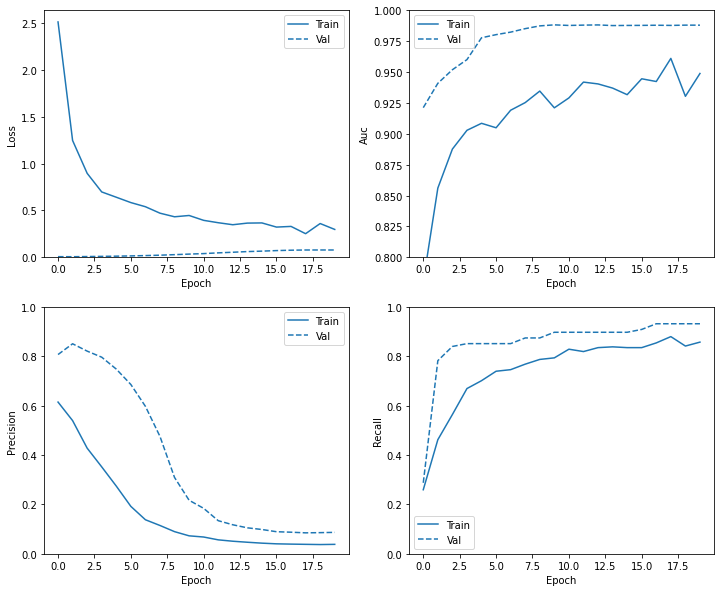

In [34]:
plot_metrics(weighted_history)

### Evaluate metrics

In [35]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.03226418048143387
tp :  82.0
fp :  352.0
tn :  56519.0
fn :  9.0
accuracy :  0.993662416934967
precision :  0.18894009292125702
recall :  0.901098906993866
auc :  0.9671803712844849

Legitimate Transactions Detected (True Negatives):  56519
Legitimate Transactions Incorrectly Detected (False Positives):  352
Fraudulent Transactions Missed (False Negatives):  9
Fraudulent Transactions Detected (True Positives):  82
Total Fraudulent Transactions:  91


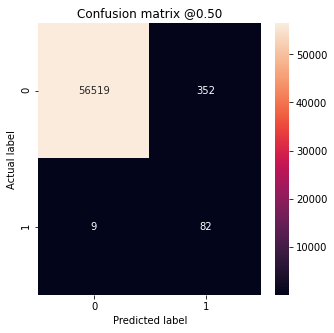

In [36]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower accuracy, this model has higher recall (and identifies more fraudulent transactions). Of course, there is a cost to both types of error (you wouldn't want to bug users by flagging too many legitimate transactions as fraudulent, either). Carefully consider the trade-offs between these different types of errors for your application.

### Plot the ROC

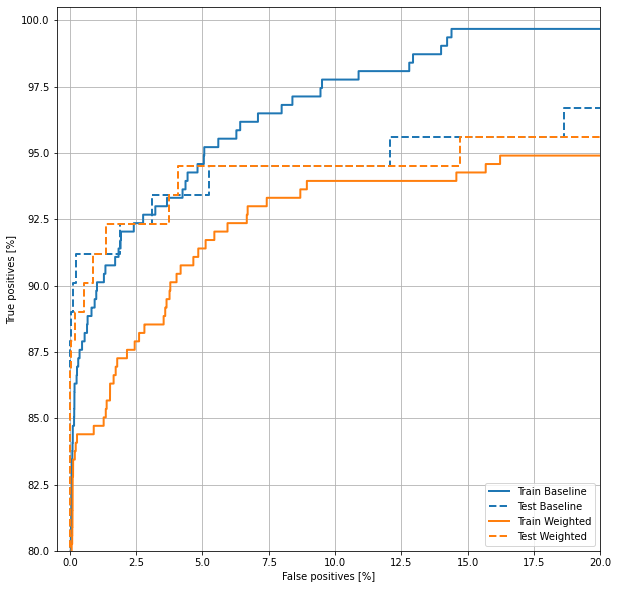

In [37]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

## Oversampling

### Oversample the minority class

A related approach would be to resample the dataset by oversampling the minority class.

In [38]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

#### Using NumPy

You can balance the dataset manually by choosing the right number of random 
indices from the positive examples:

In [39]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181962, 29)

In [40]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363924, 29)

#### Using `tf.data`

If you're using `tf.data` the easiest way to produce balanced examples is to start with a `positive` and a `negative` dataset, and merge them. See [the tf.data guide](../../guide/data.ipynb) for more examples.

In [41]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

Each dataset provides `(feature, label)` pairs:

In [42]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [ 0.23104754  0.83661044 -0.31875356  1.9796369   1.28403692  0.07389102
  1.03350673 -0.11568355 -1.54396817  0.88004244 -1.66944551 -0.24324391
  0.45900013  0.14583622 -2.06637388  0.42470592 -0.94489216 -0.83112221
 -1.83416278 -0.34138858  0.14130878  0.51019975  0.08224586  0.6642136
 -1.39031637 -0.42194185  0.22525572  0.28277796 -4.86369823]

Label:  1


Merge the two together using `experimental.sample_from_datasets`:

In [43]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [44]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.49609375


To use this dataset, you'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [45]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

### Train on the oversampled data

Now try training the model with the resampled data set instead of using class weights to see how these methods compare.

Note: Because the data was balanced by replicating the positive examples, the total dataset size is larger, and each epoch runs for more training steps. 

In [46]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=val_ds)

Epoch 1/100


  1/278 [..............................] - ETA: 0s - loss: 1.3909 - tp: 407.0000 - fp: 644.0000 - tn: 57259.0000 - fn: 700.0000 - accuracy: 0.9772 - precision: 0.3873 - recall: 0.3677 - auc: 0.8528

  4/278 [..............................] - ETA: 3s - loss: 1.3284 - tp: 1489.0000 - fp: 1670.0000 - tn: 59360.0000 - fn: 2635.0000 - accuracy: 0.9339 - precision: 0.4714 - recall: 0.3611 - auc: 0.8354

  7/278 [..............................] - ETA: 4s - loss: 1.2697 - tp: 2731.0000 - fp: 2711.0000 - tn: 61409.0000 - fn: 4447.0000 - accuracy: 0.8996 - precision: 0.5018 - recall: 0.3805 - auc: 0.8262

 10/278 [>.............................] - ETA: 4s - loss: 1.2218 - tp: 4101.0000 - fp: 3719.0000 - tn: 63465.0000 - fn: 6157.0000 - accuracy: 0.8725 - precision: 0.5244 - recall: 0.3998 - auc: 0.8196

 13/278 [>.............................] - ETA: 4s - loss: 1.1675 - tp: 5635.0000 - fp: 4745.0000 - tn: 65510.0000 - fn: 7696.0000 - accuracy: 0.8512 - precision: 0.5429 - recall: 0.4227 - auc: 0.8169

 16/278 [>.............................] - ETA: 4s - loss: 1.1220 - tp: 7240.0000 - fp: 5746.0000 - tn: 67594.0000 - fn: 9150.0000 - accuracy: 0.8340 - precision: 0.5575 - recall: 0.4417 - auc: 0.8140

 19/278 [=>............................] - ETA: 5s - loss: 1.0837 - tp: 8925.0000 - fp: 6806.0000 - tn: 69601.0000 - fn: 10542.0000 - accuracy: 0.8191 - precision: 0.5674 - recall: 0.4585 - auc: 0.8111

 22/278 [=>............................] - ETA: 5s - loss: 1.0462 - tp: 10769.0000 - fp: 7873.0000 - tn: 71586.0000 - fn: 11790.0000 - accuracy: 0.8073 - precision: 0.5777 - recall: 0.4774 - auc: 0.8096

 25/278 [=>............................] - ETA: 5s - loss: 1.0135 - tp: 12623.0000 - fp: 8952.0000 - tn: 73602.0000 - fn: 12985.0000 - accuracy: 0.7972 - precision: 0.5851 - recall: 0.4929 - auc: 0.8079

 28/278 [==>...........................] - ETA: 5s - loss: 0.9843 - tp: 14475.0000 - fp: 10073.0000 - tn: 75624.0000 - fn: 14134.0000 - accuracy: 0.7882 - precision: 0.5897 - recall: 0.5060 - auc: 0.8060

 31/278 [==>...........................] - ETA: 5s - loss: 0.9571 - tp: 16503.0000 - fp: 11144.0000 - tn: 77593.0000 - fn: 15210.0000 - accuracy: 0.7812 - precision: 0.5969 - recall: 0.5204 - auc: 0.8055

 34/278 [==>...........................] - ETA: 5s - loss: 0.9322 - tp: 18592.0000 - fp: 12256.0000 - tn: 79537.0000 - fn: 16209.0000 - accuracy: 0.7751 - precision: 0.6027 - recall: 0.5342 - auc: 0.8053

 37/278 [==>...........................] - ETA: 5s - loss: 0.9098 - tp: 20686.0000 - fp: 13321.0000 - tn: 81571.0000 - fn: 17160.0000 - accuracy: 0.7704 - precision: 0.6083 - recall: 0.5466 - auc: 0.8049

 40/278 [===>..........................] - ETA: 4s - loss: 0.8891 - tp: 22791.0000 - fp: 14417.0000 - tn: 83614.0000 - fn: 18060.0000 - accuracy: 0.7662 - precision: 0.6125 - recall: 0.5579 - auc: 0.8046

 43/278 [===>..........................] - ETA: 4s - loss: 0.8691 - tp: 25019.0000 - fp: 15462.0000 - tn: 85639.0000 - fn: 18906.0000 - accuracy: 0.7630 - precision: 0.6180 - recall: 0.5696 - auc: 0.8052

 46/278 [===>..........................] - ETA: 4s - loss: 0.8506 - tp: 27231.0000 - fp: 16512.0000 - tn: 87712.0000 - fn: 19715.0000 - accuracy: 0.7604 - precision: 0.6225 - recall: 0.5800 - auc: 0.8056

 49/278 [====>.........................] - ETA: 4s - loss: 0.8323 - tp: 29441.0000 - fp: 17560.0000 - tn: 89830.0000 - fn: 20483.0000 - accuracy: 0.7582 - precision: 0.6264 - recall: 0.5897 - auc: 0.8064

 52/278 [====>.........................] - ETA: 4s - loss: 0.8161 - tp: 31733.0000 - fp: 18545.0000 - tn: 91927.0000 - fn: 21253.0000 - accuracy: 0.7565 - precision: 0.6312 - recall: 0.5989 - auc: 0.8073

 55/278 [====>.........................] - ETA: 4s - loss: 0.8005 - tp: 34046.0000 - fp: 19471.0000 - tn: 94085.0000 - fn: 22000.0000 - accuracy: 0.7555 - precision: 0.6362 - recall: 0.6075 - auc: 0.8086

 58/278 [=====>........................] - ETA: 4s - loss: 0.7860 - tp: 36338.0000 - fp: 20401.0000 - tn: 96289.0000 - fn: 22718.0000 - accuracy: 0.7547 - precision: 0.6404 - recall: 0.6153 - auc: 0.8097

 61/278 [=====>........................] - ETA: 4s - loss: 0.7730 - tp: 38642.0000 - fp: 21289.0000 - tn: 98459.0000 - fn: 23500.0000 - accuracy: 0.7538 - precision: 0.6448 - recall: 0.6218 - auc: 0.8107

 64/278 [=====>........................] - ETA: 4s - loss: 0.7600 - tp: 41044.0000 - fp: 22222.0000 - tn: 100616.0000 - fn: 24152.0000 - accuracy: 0.7534 - precision: 0.6488 - recall: 0.6295 - auc: 0.8121

 66/278 [======>.......................] - ETA: 4s - loss: 0.7517 - tp: 42617.0000 - fp: 22760.0000 - tn: 102134.0000 - fn: 24619.0000 - accuracy: 0.7534 - precision: 0.6519 - recall: 0.6338 - auc: 0.8132

 68/278 [======>.......................] - ETA: 4s - loss: 0.7438 - tp: 44197.0000 - fp: 23319.0000 - tn: 103639.0000 - fn: 25071.0000 - accuracy: 0.7534 - precision: 0.6546 - recall: 0.6381 - auc: 0.8140

 71/278 [======>.......................] - ETA: 4s - loss: 0.7325 - tp: 46562.0000 - fp: 24242.0000 - tn: 105848.0000 - fn: 25718.0000 - accuracy: 0.7531 - precision: 0.6576 - recall: 0.6442 - auc: 0.8154

 74/278 [======>.......................] - ETA: 4s - loss: 0.7216 - tp: 48983.0000 - fp: 25063.0000 - tn: 108114.0000 - fn: 26354.0000 - accuracy: 0.7534 - precision: 0.6615 - recall: 0.6502 - auc: 0.8170

 77/278 [=======>......................] - ETA: 4s - loss: 0.7112 - tp: 51447.0000 - fp: 25863.0000 - tn: 110353.0000 - fn: 26995.0000 - accuracy: 0.7538 - precision: 0.6655 - recall: 0.6559 - auc: 0.8186

 80/278 [=======>......................] - ETA: 4s - loss: 0.7016 - tp: 53878.0000 - fp: 26677.0000 - tn: 112633.0000 - fn: 27614.0000 - accuracy: 0.7541 - precision: 0.6688 - recall: 0.6611 - auc: 0.8201

 83/278 [=======>......................] - ETA: 4s - loss: 0.6923 - tp: 56356.0000 - fp: 27406.0000 - tn: 114971.0000 - fn: 28213.0000 - accuracy: 0.7549 - precision: 0.6728 - recall: 0.6664 - auc: 0.8217

 86/278 [========>.....................] - ETA: 4s - loss: 0.6834 - tp: 58825.0000 - fp: 28164.0000 - tn: 117296.0000 - fn: 28805.0000 - accuracy: 0.7556 - precision: 0.6762 - recall: 0.6713 - auc: 0.8232

 89/278 [========>.....................] - ETA: 4s - loss: 0.6747 - tp: 61296.0000 - fp: 28886.0000 - tn: 119674.0000 - fn: 29378.0000 - accuracy: 0.7565 - precision: 0.6797 - recall: 0.6760 - auc: 0.8248

 92/278 [========>.....................] - ETA: 4s - loss: 0.6669 - tp: 63808.0000 - fp: 29611.0000 - tn: 121959.0000 - fn: 30000.0000 - accuracy: 0.7571 - precision: 0.6830 - recall: 0.6802 - auc: 0.8263

 95/278 [=========>....................] - ETA: 3s - loss: 0.6590 - tp: 66288.0000 - fp: 30315.0000 - tn: 124347.0000 - fn: 30572.0000 - accuracy: 0.7579 - precision: 0.6862 - recall: 0.6844 - auc: 0.8279

 98/278 [=========>....................] - ETA: 3s - loss: 0.6516 - tp: 68797.0000 - fp: 30965.0000 - tn: 126737.0000 - fn: 31167.0000 - accuracy: 0.7589 - precision: 0.6896 - recall: 0.6882 - auc: 0.8294

101/278 [=========>....................] - ETA: 3s - loss: 0.6445 - tp: 71294.0000 - fp: 31597.0000 - tn: 129196.0000 - fn: 31723.0000 - accuracy: 0.7600 - precision: 0.6929 - recall: 0.6921 - auc: 0.8309

104/278 [==========>...................] - ETA: 3s - loss: 0.6377 - tp: 73831.0000 - fp: 32238.0000 - tn: 131615.0000 - fn: 32270.0000 - accuracy: 0.7610 - precision: 0.6961 - recall: 0.6959 - auc: 0.8323

107/278 [==========>...................] - ETA: 3s - loss: 0.6309 - tp: 76313.0000 - fp: 32850.0000 - tn: 134108.0000 - fn: 32827.0000 - accuracy: 0.7621 - precision: 0.6991 - recall: 0.6992 - auc: 0.8338

110/278 [==========>...................] - ETA: 3s - loss: 0.6244 - tp: 78870.0000 - fp: 33456.0000 - tn: 136532.0000 - fn: 33384.0000 - accuracy: 0.7632 - precision: 0.7022 - recall: 0.7026 - auc: 0.8354

113/278 [===========>..................] - ETA: 3s - loss: 0.6181 - tp: 81423.0000 - fp: 34036.0000 - tn: 139009.0000 - fn: 33918.0000 - accuracy: 0.7644 - precision: 0.7052 - recall: 0.7059 - auc: 0.8369

116/278 [===========>..................] - ETA: 3s - loss: 0.6121 - tp: 83953.0000 - fp: 34593.0000 - tn: 141492.0000 - fn: 34492.0000 - accuracy: 0.7654 - precision: 0.7082 - recall: 0.7088 - auc: 0.8383

119/278 [===========>..................] - ETA: 3s - loss: 0.6062 - tp: 86541.0000 - fp: 35112.0000 - tn: 143971.0000 - fn: 35050.0000 - accuracy: 0.7667 - precision: 0.7114 - recall: 0.7117 - auc: 0.8398

122/278 [============>.................] - ETA: 3s - loss: 0.6006 - tp: 89077.0000 - fp: 35641.0000 - tn: 146505.0000 - fn: 35595.0000 - accuracy: 0.7678 - precision: 0.7142 - recall: 0.7145 - auc: 0.8413

125/278 [============>.................] - ETA: 3s - loss: 0.5952 - tp: 91609.0000 - fp: 36202.0000 - tn: 149031.0000 - fn: 36120.0000 - accuracy: 0.7689 - precision: 0.7168 - recall: 0.7172 - auc: 0.8426

128/278 [============>.................] - ETA: 3s - loss: 0.5900 - tp: 94161.0000 - fp: 36687.0000 - tn: 151618.0000 - fn: 36640.0000 - accuracy: 0.7702 - precision: 0.7196 - recall: 0.7199 - auc: 0.8440

131/278 [=============>................] - ETA: 3s - loss: 0.5850 - tp: 96737.0000 - fp: 37212.0000 - tn: 154109.0000 - fn: 37192.0000 - accuracy: 0.7712 - precision: 0.7222 - recall: 0.7223 - auc: 0.8453

134/278 [=============>................] - ETA: 2s - loss: 0.5799 - tp: 99286.0000 - fp: 37651.0000 - tn: 156715.0000 - fn: 37742.0000 - accuracy: 0.7725 - precision: 0.7250 - recall: 0.7246 - auc: 0.8467

137/278 [=============>................] - ETA: 2s - loss: 0.5751 - tp: 101819.0000 - fp: 38102.0000 - tn: 159366.0000 - fn: 38251.0000 - accuracy: 0.7738 - precision: 0.7277 - recall: 0.7269 - auc: 0.8480

140/278 [==============>...............] - ETA: 2s - loss: 0.5703 - tp: 104407.0000 - fp: 38523.0000 - tn: 161984.0000 - fn: 38768.0000 - accuracy: 0.7751 - precision: 0.7305 - recall: 0.7292 - auc: 0.8494

143/278 [==============>...............] - ETA: 2s - loss: 0.5656 - tp: 107003.0000 - fp: 38973.0000 - tn: 164584.0000 - fn: 39266.0000 - accuracy: 0.7763 - precision: 0.7330 - recall: 0.7315 - auc: 0.8508

146/278 [==============>...............] - ETA: 2s - loss: 0.5610 - tp: 109602.0000 - fp: 39382.0000 - tn: 167219.0000 - fn: 39767.0000 - accuracy: 0.7777 - precision: 0.7357 - recall: 0.7338 - auc: 0.8521

149/278 [===============>..............] - ETA: 2s - loss: 0.5567 - tp: 112218.0000 - fp: 39802.0000 - tn: 169810.0000 - fn: 40284.0000 - accuracy: 0.7788 - precision: 0.7382 - recall: 0.7358 - auc: 0.8533

152/278 [===============>..............] - ETA: 2s - loss: 0.5525 - tp: 114758.0000 - fp: 40200.0000 - tn: 172519.0000 - fn: 40781.0000 - accuracy: 0.7801 - precision: 0.7406 - recall: 0.7378 - auc: 0.8546

156/278 [===============>..............] - ETA: 2s - loss: 0.5472 - tp: 118209.0000 - fp: 40749.0000 - tn: 176028.0000 - fn: 41464.0000 - accuracy: 0.7816 - precision: 0.7436 - recall: 0.7403 - auc: 0.8561

160/278 [================>.............] - ETA: 2s - loss: 0.5421 - tp: 121616.0000 - fp: 41287.0000 - tn: 179605.0000 - fn: 42134.0000 - accuracy: 0.7831 - precision: 0.7466 - recall: 0.7427 - auc: 0.8576

164/278 [================>.............] - ETA: 2s - loss: 0.5370 - tp: 124994.0000 - fp: 41805.0000 - tn: 183206.0000 - fn: 42829.0000 - accuracy: 0.7846 - precision: 0.7494 - recall: 0.7448 - auc: 0.8591

168/278 [=================>............] - ETA: 2s - loss: 0.5321 - tp: 128451.0000 - fp: 42277.0000 - tn: 186823.0000 - fn: 43475.0000 - accuracy: 0.7862 - precision: 0.7524 - recall: 0.7471 - auc: 0.8607

171/278 [=================>............] - ETA: 2s - loss: 0.5285 - tp: 131007.0000 - fp: 42623.0000 - tn: 189573.0000 - fn: 43967.0000 - accuracy: 0.7873 - precision: 0.7545 - recall: 0.7487 - auc: 0.8617

174/278 [=================>............] - ETA: 2s - loss: 0.5250 - tp: 133601.0000 - fp: 42937.0000 - tn: 192315.0000 - fn: 44461.0000 - accuracy: 0.7885 - precision: 0.7568 - recall: 0.7503 - auc: 0.8629

177/278 [==================>...........] - ETA: 1s - loss: 0.5216 - tp: 136161.0000 - fp: 43277.0000 - tn: 195072.0000 - fn: 44948.0000 - accuracy: 0.7897 - precision: 0.7588 - recall: 0.7518 - auc: 0.8639

178/278 [==================>...........] - ETA: 2s - loss: 0.5204 - tp: 137040.0000 - fp: 43353.0000 - tn: 196010.0000 - fn: 45103.0000 - accuracy: 0.7901 - precision: 0.7597 - recall: 0.7524 - auc: 0.8643

182/278 [==================>...........] - ETA: 1s - loss: 0.5160 - tp: 140508.0000 - fp: 43799.0000 - tn: 199638.0000 - fn: 45753.0000 - accuracy: 0.7916 - precision: 0.7624 - recall: 0.7544 - auc: 0.8657

185/278 [==================>...........] - ETA: 1s - loss: 0.5128 - tp: 143034.0000 - fp: 44107.0000 - tn: 202463.0000 - fn: 46238.0000 - accuracy: 0.7927 - precision: 0.7643 - recall: 0.7557 - auc: 0.8667

188/278 [===================>..........] - ETA: 1s - loss: 0.5097 - tp: 145652.0000 - fp: 44409.0000 - tn: 205199.0000 - fn: 46726.0000 - accuracy: 0.7938 - precision: 0.7663 - recall: 0.7571 - auc: 0.8678

191/278 [===================>..........] - ETA: 1s - loss: 0.5066 - tp: 148217.0000 - fp: 44728.0000 - tn: 207974.0000 - fn: 47211.0000 - accuracy: 0.7948 - precision: 0.7682 - recall: 0.7584 - auc: 0.8688

194/278 [===================>..........] - ETA: 1s - loss: 0.5035 - tp: 150816.0000 - fp: 45018.0000 - tn: 210746.0000 - fn: 47694.0000 - accuracy: 0.7959 - precision: 0.7701 - recall: 0.7597 - auc: 0.8698

197/278 [====================>.........] - ETA: 1s - loss: 0.5004 - tp: 153408.0000 - fp: 45315.0000 - tn: 213527.0000 - fn: 48168.0000 - accuracy: 0.7970 - precision: 0.7720 - recall: 0.7610 - auc: 0.8708

200/278 [====================>.........] - ETA: 1s - loss: 0.4974 - tp: 156009.0000 - fp: 45587.0000 - tn: 216295.0000 - fn: 48671.0000 - accuracy: 0.7980 - precision: 0.7739 - recall: 0.7622 - auc: 0.8718

203/278 [====================>.........] - ETA: 1s - loss: 0.4944 - tp: 158633.0000 - fp: 45839.0000 - tn: 219085.0000 - fn: 49149.0000 - accuracy: 0.7991 - precision: 0.7758 - recall: 0.7635 - auc: 0.8728

206/278 [=====================>........] - ETA: 1s - loss: 0.4915 - tp: 161186.0000 - fp: 46123.0000 - tn: 221939.0000 - fn: 49602.0000 - accuracy: 0.8001 - precision: 0.7775 - recall: 0.7647 - auc: 0.8738

209/278 [=====================>........] - ETA: 1s - loss: 0.4887 - tp: 163786.0000 - fp: 46372.0000 - tn: 224754.0000 - fn: 50082.0000 - accuracy: 0.8011 - precision: 0.7793 - recall: 0.7658 - auc: 0.8748

212/278 [=====================>........] - ETA: 1s - loss: 0.4859 - tp: 166337.0000 - fp: 46634.0000 - tn: 227620.0000 - fn: 50547.0000 - accuracy: 0.8021 - precision: 0.7810 - recall: 0.7669 - auc: 0.8757

215/278 [======================>.......] - ETA: 1s - loss: 0.4832 - tp: 168908.0000 - fp: 46863.0000 - tn: 230500.0000 - fn: 51011.0000 - accuracy: 0.8032 - precision: 0.7828 - recall: 0.7680 - auc: 0.8766

218/278 [======================>.......] - ETA: 1s - loss: 0.4807 - tp: 171495.0000 - fp: 47124.0000 - tn: 233312.0000 - fn: 51495.0000 - accuracy: 0.8041 - precision: 0.7844 - recall: 0.7691 - auc: 0.8775

221/278 [======================>.......] - ETA: 1s - loss: 0.4781 - tp: 174114.0000 - fp: 47358.0000 - tn: 236148.0000 - fn: 51950.0000 - accuracy: 0.8051 - precision: 0.7862 - recall: 0.7702 - auc: 0.8784

224/278 [=======================>......] - ETA: 1s - loss: 0.4754 - tp: 176703.0000 - fp: 47596.0000 - tn: 238990.0000 - fn: 52425.0000 - accuracy: 0.8061 - precision: 0.7878 - recall: 0.7712 - auc: 0.8793

227/278 [=======================>......] - ETA: 1s - loss: 0.4730 - tp: 179304.0000 - fp: 47841.0000 - tn: 241804.0000 - fn: 52909.0000 - accuracy: 0.8069 - precision: 0.7894 - recall: 0.7722 - auc: 0.8801

230/278 [=======================>......] - ETA: 0s - loss: 0.4705 - tp: 181948.0000 - fp: 48087.0000 - tn: 244595.0000 - fn: 53372.0000 - accuracy: 0.8078 - precision: 0.7910 - recall: 0.7732 - auc: 0.8810

233/278 [========================>.....] - ETA: 0s - loss: 0.4680 - tp: 184592.0000 - fp: 48318.0000 - tn: 247411.0000 - fn: 53825.0000 - accuracy: 0.8088 - precision: 0.7925 - recall: 0.7742 - auc: 0.8819

236/278 [========================>.....] - ETA: 0s - loss: 0.4656 - tp: 187144.0000 - fp: 48544.0000 - tn: 250293.0000 - fn: 54309.0000 - accuracy: 0.8096 - precision: 0.7940 - recall: 0.7751 - auc: 0.8827

239/278 [========================>.....] - ETA: 0s - loss: 0.4633 - tp: 189736.0000 - fp: 48766.0000 - tn: 253153.0000 - fn: 54779.0000 - accuracy: 0.8105 - precision: 0.7955 - recall: 0.7760 - auc: 0.8835

242/278 [=========================>....] - ETA: 0s - loss: 0.4609 - tp: 192330.0000 - fp: 48967.0000 - tn: 256058.0000 - fn: 55223.0000 - accuracy: 0.8114 - precision: 0.7971 - recall: 0.7769 - auc: 0.8843

245/278 [=========================>....] - ETA: 0s - loss: 0.4586 - tp: 194940.0000 - fp: 49185.0000 - tn: 258910.0000 - fn: 55687.0000 - accuracy: 0.8123 - precision: 0.7985 - recall: 0.7778 - auc: 0.8852

248/278 [=========================>....] - ETA: 0s - loss: 0.4564 - tp: 197488.0000 - fp: 49392.0000 - tn: 261832.0000 - fn: 56154.0000 - accuracy: 0.8131 - precision: 0.7999 - recall: 0.7786 - auc: 0.8859

250/278 [=========================>....] - ETA: 0s - loss: 0.4549 - tp: 199237.0000 - fp: 49521.0000 - tn: 263740.0000 - fn: 56464.0000 - accuracy: 0.8137 - precision: 0.8009 - recall: 0.7792 - auc: 0.8865

253/278 [==========================>...] - ETA: 0s - loss: 0.4526 - tp: 201869.0000 - fp: 49724.0000 - tn: 266582.0000 - fn: 56931.0000 - accuracy: 0.8145 - precision: 0.8024 - recall: 0.7800 - auc: 0.8873

256/278 [==========================>...] - ETA: 0s - loss: 0.4505 - tp: 204499.0000 - fp: 49917.0000 - tn: 269433.0000 - fn: 57401.0000 - accuracy: 0.8154 - precision: 0.8038 - recall: 0.7808 - auc: 0.8880

259/278 [==========================>...] - ETA: 0s - loss: 0.4484 - tp: 207086.0000 - fp: 50112.0000 - tn: 272308.0000 - fn: 57888.0000 - accuracy: 0.8161 - precision: 0.8052 - recall: 0.7815 - auc: 0.8888

262/278 [===========================>..] - ETA: 0s - loss: 0.4462 - tp: 209628.0000 - fp: 50324.0000 - tn: 275262.0000 - fn: 58324.0000 - accuracy: 0.8169 - precision: 0.8064 - recall: 0.7823 - auc: 0.8895

265/278 [===========================>..] - ETA: 0s - loss: 0.4442 - tp: 212224.0000 - fp: 50510.0000 - tn: 278181.0000 - fn: 58767.0000 - accuracy: 0.8178 - precision: 0.8078 - recall: 0.7831 - auc: 0.8902

268/278 [===========================>..] - ETA: 0s - loss: 0.4421 - tp: 214842.0000 - fp: 50690.0000 - tn: 281054.0000 - fn: 59240.0000 - accuracy: 0.8185 - precision: 0.8091 - recall: 0.7839 - auc: 0.8910

271/278 [============================>.] - ETA: 0s - loss: 0.4402 - tp: 217460.0000 - fp: 50878.0000 - tn: 283944.0000 - fn: 59688.0000 - accuracy: 0.8193 - precision: 0.8104 - recall: 0.7846 - auc: 0.8917

274/278 [============================>.] - ETA: 0s - loss: 0.4381 - tp: 220039.0000 - fp: 51072.0000 - tn: 286887.0000 - fn: 60116.0000 - accuracy: 0.8201 - precision: 0.8116 - recall: 0.7854 - auc: 0.8924

277/278 [============================>.] - ETA: 0s - loss: 0.4362 - tp: 222640.0000 - fp: 51236.0000 - tn: 289783.0000 - fn: 60599.0000 - accuracy: 0.8209 - precision: 0.8129 - recall: 0.7860 - auc: 0.8931

278/278 [==============================] - 6s 23ms/step - loss: 0.4356 - tp: 223484.0000 - fp: 51288.0000 - tn: 290777.0000 - fn: 60757.0000 - accuracy: 0.8211 - precision: 0.8133 - recall: 0.7862 - auc: 0.8933 - val_loss: 0.2172 - val_tp: 79.0000 - val_fp: 1076.0000 - val_tn: 44406.0000 - val_fn: 8.0000 - val_accuracy: 0.9762 - val_precision: 0.0684 - val_recall: 0.9080 - val_auc: 0.9792


Epoch 2/100
  1/278 [..............................] - ETA: 0s - loss: 0.2567 - tp: 859.0000 - fp: 61.0000 - tn: 969.0000 - fn: 159.0000 - accuracy: 0.8926 - precision: 0.9337 - recall: 0.8438 - auc: 0.9573

  5/278 [..............................] - ETA: 3s - loss: 0.2543 - tp: 4318.0000 - fp: 298.0000 - tn: 4856.0000 - fn: 768.0000 - accuracy: 0.8959 - precision: 0.9354 - recall: 0.8490 - auc: 0.9574

  8/278 [..............................] - ETA: 3s - loss: 0.2557 - tp: 6976.0000 - fp: 476.0000 - tn: 7692.0000 - fn: 1240.0000 - accuracy: 0.8953 - precision: 0.9361 - recall: 0.8491 - auc: 0.9560

 11/278 [>.............................] - ETA: 4s - loss: 0.2547 - tp: 9680.0000 - fp: 660.0000 - tn: 10492.0000 - fn: 1696.0000 - accuracy: 0.8954 - precision: 0.9362 - recall: 0.8509 - auc: 0.9565

 14/278 [>.............................] - ETA: 4s - loss: 0.2524 - tp: 12258.0000 - fp: 820.0000 - tn: 13494.0000 - fn: 2100.0000 - accuracy: 0.8982 - precision: 0.9373 - recall: 0.8537 - auc: 0.9571

 17/278 [>.............................] - ETA: 4s - loss: 0.2528 - tp: 14883.0000 - fp: 1005.0000 - tn: 16396.0000 - fn: 2532.0000 - accuracy: 0.8984 - precision: 0.9367 - recall: 0.8546 - auc: 0.9571

 20/278 [=>............................] - ETA: 4s - loss: 0.2519 - tp: 17528.0000 - fp: 1165.0000 - tn: 19304.0000 - fn: 2963.0000 - accuracy: 0.8992 - precision: 0.9377 - recall: 0.8554 - auc: 0.9574

 23/278 [=>............................] - ETA: 4s - loss: 0.2519 - tp: 20132.0000 - fp: 1361.0000 - tn: 22208.0000 - fn: 3403.0000 - accuracy: 0.8989 - precision: 0.9367 - recall: 0.8554 - auc: 0.9573

 26/278 [=>............................] - ETA: 4s - loss: 0.2519 - tp: 22774.0000 - fp: 1526.0000 - tn: 25070.0000 - fn: 3878.0000 - accuracy: 0.8985 - precision: 0.9372 - recall: 0.8545 - auc: 0.9574

 29/278 [==>...........................] - ETA: 4s - loss: 0.2525 - tp: 25452.0000 - fp: 1691.0000 - tn: 27943.0000 - fn: 4306.0000 - accuracy: 0.8990 - precision: 0.9377 - recall: 0.8553 - auc: 0.9573

 33/278 [==>...........................] - ETA: 4s - loss: 0.2519 - tp: 28982.0000 - fp: 1907.0000 - tn: 31774.0000 - fn: 4921.0000 - accuracy: 0.8990 - precision: 0.9383 - recall: 0.8549 - auc: 0.9575

 36/278 [==>...........................] - ETA: 4s - loss: 0.2517 - tp: 31589.0000 - fp: 2064.0000 - tn: 34698.0000 - fn: 5377.0000 - accuracy: 0.8991 - precision: 0.9387 - recall: 0.8545 - auc: 0.9575

 40/278 [===>..........................] - ETA: 3s - loss: 0.2506 - tp: 35077.0000 - fp: 2270.0000 - tn: 38603.0000 - fn: 5970.0000 - accuracy: 0.8994 - precision: 0.9392 - recall: 0.8546 - auc: 0.9579

 44/278 [===>..........................] - ETA: 3s - loss: 0.2494 - tp: 38578.0000 - fp: 2466.0000 - tn: 42524.0000 - fn: 6544.0000 - accuracy: 0.9000 - precision: 0.9399 - recall: 0.8550 - auc: 0.9582

 48/278 [====>.........................] - ETA: 3s - loss: 0.2488 - tp: 42132.0000 - fp: 2653.0000 - tn: 46396.0000 - fn: 7123.0000 - accuracy: 0.9006 - precision: 0.9408 - recall: 0.8554 - auc: 0.9585

 52/278 [====>.........................] - ETA: 3s - loss: 0.2478 - tp: 45670.0000 - fp: 2873.0000 - tn: 50235.0000 - fn: 7718.0000 - accuracy: 0.9006 - precision: 0.9408 - recall: 0.8554 - auc: 0.9588

 55/278 [====>.........................] - ETA: 3s - loss: 0.2475 - tp: 48284.0000 - fp: 3053.0000 - tn: 53165.0000 - fn: 8138.0000 - accuracy: 0.9006 - precision: 0.9405 - recall: 0.8558 - auc: 0.9589

 58/278 [=====>........................] - ETA: 3s - loss: 0.2470 - tp: 50922.0000 - fp: 3198.0000 - tn: 56101.0000 - fn: 8563.0000 - accuracy: 0.9010 - precision: 0.9409 - recall: 0.8560 - auc: 0.9590

 62/278 [=====>........................] - ETA: 3s - loss: 0.2463 - tp: 54366.0000 - fp: 3401.0000 - tn: 60075.0000 - fn: 9134.0000 - accuracy: 0.9013 - precision: 0.9411 - recall: 0.8562 - auc: 0.9593

 66/278 [======>.......................] - ETA: 3s - loss: 0.2455 - tp: 57912.0000 - fp: 3614.0000 - tn: 63942.0000 - fn: 9700.0000 - accuracy: 0.9015 - precision: 0.9413 - recall: 0.8565 - auc: 0.9596

 69/278 [======>.......................] - ETA: 3s - loss: 0.2450 - tp: 60606.0000 - fp: 3745.0000 - tn: 66818.0000 - fn: 10143.0000 - accuracy: 0.9017 - precision: 0.9418 - recall: 0.8566 - auc: 0.9597

 72/278 [======>.......................] - ETA: 3s - loss: 0.2446 - tp: 63244.0000 - fp: 3891.0000 - tn: 69734.0000 - fn: 10587.0000 - accuracy: 0.9018 - precision: 0.9420 - recall: 0.8566 - auc: 0.9598

 75/278 [=======>......................] - ETA: 3s - loss: 0.2442 - tp: 65835.0000 - fp: 4060.0000 - tn: 72676.0000 - fn: 11029.0000 - accuracy: 0.9018 - precision: 0.9419 - recall: 0.8565 - auc: 0.9599

 77/278 [=======>......................] - ETA: 3s - loss: 0.2441 - tp: 67580.0000 - fp: 4157.0000 - tn: 74635.0000 - fn: 11324.0000 - accuracy: 0.9018 - precision: 0.9421 - recall: 0.8565 - auc: 0.9599

 80/278 [=======>......................] - ETA: 3s - loss: 0.2433 - tp: 70234.0000 - fp: 4285.0000 - tn: 77593.0000 - fn: 11728.0000 - accuracy: 0.9023 - precision: 0.9425 - recall: 0.8569 - auc: 0.9602

 83/278 [=======>......................] - ETA: 3s - loss: 0.2426 - tp: 72908.0000 - fp: 4429.0000 - tn: 80505.0000 - fn: 12142.0000 - accuracy: 0.9025 - precision: 0.9427 - recall: 0.8572 - auc: 0.9606

 86/278 [========>.....................] - ETA: 3s - loss: 0.2421 - tp: 75631.0000 - fp: 4564.0000 - tn: 83357.0000 - fn: 12576.0000 - accuracy: 0.9027 - precision: 0.9431 - recall: 0.8574 - auc: 0.9607

 89/278 [========>.....................] - ETA: 3s - loss: 0.2415 - tp: 78265.0000 - fp: 4704.0000 - tn: 86311.0000 - fn: 12992.0000 - accuracy: 0.9029 - precision: 0.9433 - recall: 0.8576 - auc: 0.9609

 92/278 [========>.....................] - ETA: 3s - loss: 0.2413 - tp: 80913.0000 - fp: 4852.0000 - tn: 89221.0000 - fn: 13430.0000 - accuracy: 0.9030 - precision: 0.9434 - recall: 0.8576 - auc: 0.9610

 95/278 [=========>....................] - ETA: 3s - loss: 0.2407 - tp: 83598.0000 - fp: 4993.0000 - tn: 92139.0000 - fn: 13830.0000 - accuracy: 0.9033 - precision: 0.9436 - recall: 0.8580 - auc: 0.9612

 98/278 [=========>....................] - ETA: 3s - loss: 0.2400 - tp: 86237.0000 - fp: 5118.0000 - tn: 95099.0000 - fn: 14250.0000 - accuracy: 0.9035 - precision: 0.9440 - recall: 0.8582 - auc: 0.9613

101/278 [=========>....................] - ETA: 3s - loss: 0.2396 - tp: 88896.0000 - fp: 5247.0000 - tn: 98036.0000 - fn: 14669.0000 - accuracy: 0.9037 - precision: 0.9443 - recall: 0.8584 - auc: 0.9615

104/278 [==========>...................] - ETA: 3s - loss: 0.2391 - tp: 91625.0000 - fp: 5382.0000 - tn: 100889.0000 - fn: 15096.0000 - accuracy: 0.9039 - precision: 0.9445 - recall: 0.8585 - auc: 0.9616

107/278 [==========>...................] - ETA: 3s - loss: 0.2387 - tp: 94247.0000 - fp: 5526.0000 - tn: 103851.0000 - fn: 15512.0000 - accuracy: 0.9040 - precision: 0.9446 - recall: 0.8587 - auc: 0.9617

110/278 [==========>...................] - ETA: 3s - loss: 0.2382 - tp: 96869.0000 - fp: 5663.0000 - tn: 106836.0000 - fn: 15912.0000 - accuracy: 0.9042 - precision: 0.9448 - recall: 0.8589 - auc: 0.9620

113/278 [===========>..................] - ETA: 3s - loss: 0.2376 - tp: 99559.0000 - fp: 5807.0000 - tn: 109750.0000 - fn: 16308.0000 - accuracy: 0.9044 - precision: 0.9449 - recall: 0.8593 - auc: 0.9622

116/278 [===========>..................] - ETA: 3s - loss: 0.2370 - tp: 102241.0000 - fp: 5939.0000 - tn: 112675.0000 - fn: 16713.0000 - accuracy: 0.9047 - precision: 0.9451 - recall: 0.8595 - auc: 0.9624

119/278 [===========>..................] - ETA: 2s - loss: 0.2366 - tp: 104888.0000 - fp: 6080.0000 - tn: 115617.0000 - fn: 17127.0000 - accuracy: 0.9048 - precision: 0.9452 - recall: 0.8596 - auc: 0.9625

122/278 [============>.................] - ETA: 2s - loss: 0.2362 - tp: 107547.0000 - fp: 6224.0000 - tn: 118537.0000 - fn: 17548.0000 - accuracy: 0.9049 - precision: 0.9453 - recall: 0.8597 - auc: 0.9626

125/278 [============>.................] - ETA: 2s - loss: 0.2359 - tp: 110226.0000 - fp: 6370.0000 - tn: 121425.0000 - fn: 17979.0000 - accuracy: 0.9049 - precision: 0.9454 - recall: 0.8598 - auc: 0.9627

128/278 [============>.................] - ETA: 2s - loss: 0.2354 - tp: 112873.0000 - fp: 6504.0000 - tn: 124401.0000 - fn: 18366.0000 - accuracy: 0.9051 - precision: 0.9455 - recall: 0.8601 - auc: 0.9628

131/278 [=============>................] - ETA: 2s - loss: 0.2350 - tp: 115486.0000 - fp: 6650.0000 - tn: 127390.0000 - fn: 18762.0000 - accuracy: 0.9053 - precision: 0.9456 - recall: 0.8602 - auc: 0.9629

134/278 [=============>................] - ETA: 2s - loss: 0.2346 - tp: 118156.0000 - fp: 6757.0000 - tn: 130318.0000 - fn: 19201.0000 - accuracy: 0.9054 - precision: 0.9459 - recall: 0.8602 - auc: 0.9631

137/278 [=============>................] - ETA: 2s - loss: 0.2341 - tp: 120783.0000 - fp: 6883.0000 - tn: 133311.0000 - fn: 19599.0000 - accuracy: 0.9056 - precision: 0.9461 - recall: 0.8604 - auc: 0.9632

140/278 [==============>...............] - ETA: 2s - loss: 0.2337 - tp: 123509.0000 - fp: 7006.0000 - tn: 136194.0000 - fn: 20011.0000 - accuracy: 0.9058 - precision: 0.9463 - recall: 0.8606 - auc: 0.9634

143/278 [==============>...............] - ETA: 2s - loss: 0.2333 - tp: 126215.0000 - fp: 7143.0000 - tn: 139086.0000 - fn: 20420.0000 - accuracy: 0.9059 - precision: 0.9464 - recall: 0.8607 - auc: 0.9636

146/278 [==============>...............] - ETA: 2s - loss: 0.2329 - tp: 128876.0000 - fp: 7290.0000 - tn: 142022.0000 - fn: 20820.0000 - accuracy: 0.9060 - precision: 0.9465 - recall: 0.8609 - auc: 0.9637

149/278 [===============>..............] - ETA: 2s - loss: 0.2326 - tp: 131496.0000 - fp: 7420.0000 - tn: 144987.0000 - fn: 21249.0000 - accuracy: 0.9061 - precision: 0.9466 - recall: 0.8609 - auc: 0.9637

152/278 [===============>..............] - ETA: 2s - loss: 0.2322 - tp: 134207.0000 - fp: 7550.0000 - tn: 147886.0000 - fn: 21653.0000 - accuracy: 0.9062 - precision: 0.9467 - recall: 0.8611 - auc: 0.9639

155/278 [===============>..............] - ETA: 2s - loss: 0.2317 - tp: 136903.0000 - fp: 7668.0000 - tn: 150816.0000 - fn: 22053.0000 - accuracy: 0.9064 - precision: 0.9470 - recall: 0.8613 - auc: 0.9641

158/278 [================>.............] - ETA: 2s - loss: 0.2312 - tp: 139567.0000 - fp: 7783.0000 - tn: 153767.0000 - fn: 22467.0000 - accuracy: 0.9065 - precision: 0.9472 - recall: 0.8613 - auc: 0.9642

162/278 [================>.............] - ETA: 2s - loss: 0.2307 - tp: 143168.0000 - fp: 7963.0000 - tn: 157647.0000 - fn: 22998.0000 - accuracy: 0.9067 - precision: 0.9473 - recall: 0.8616 - auc: 0.9644

166/278 [================>.............] - ETA: 2s - loss: 0.2302 - tp: 146755.0000 - fp: 8141.0000 - tn: 161534.0000 - fn: 23538.0000 - accuracy: 0.9068 - precision: 0.9474 - recall: 0.8618 - auc: 0.9645

170/278 [=================>............] - ETA: 2s - loss: 0.2296 - tp: 150344.0000 - fp: 8304.0000 - tn: 165423.0000 - fn: 24089.0000 - accuracy: 0.9070 - precision: 0.9477 - recall: 0.8619 - auc: 0.9647

173/278 [=================>............] - ETA: 1s - loss: 0.2293 - tp: 153027.0000 - fp: 8431.0000 - tn: 168350.0000 - fn: 24496.0000 - accuracy: 0.9071 - precision: 0.9478 - recall: 0.8620 - auc: 0.9648

176/278 [=================>............] - ETA: 1s - loss: 0.2288 - tp: 155713.0000 - fp: 8556.0000 - tn: 171299.0000 - fn: 24880.0000 - accuracy: 0.9072 - precision: 0.9479 - recall: 0.8622 - auc: 0.9650

179/278 [==================>...........] - ETA: 1s - loss: 0.2285 - tp: 158403.0000 - fp: 8686.0000 - tn: 174235.0000 - fn: 25268.0000 - accuracy: 0.9074 - precision: 0.9480 - recall: 0.8624 - auc: 0.9651

182/278 [==================>...........] - ETA: 1s - loss: 0.2282 - tp: 161061.0000 - fp: 8812.0000 - tn: 177213.0000 - fn: 25650.0000 - accuracy: 0.9075 - precision: 0.9481 - recall: 0.8626 - auc: 0.9652

185/278 [==================>...........] - ETA: 1s - loss: 0.2277 - tp: 163741.0000 - fp: 8926.0000 - tn: 180168.0000 - fn: 26045.0000 - accuracy: 0.9077 - precision: 0.9483 - recall: 0.8628 - auc: 0.9654

188/278 [===================>..........] - ETA: 1s - loss: 0.2274 - tp: 166418.0000 - fp: 9061.0000 - tn: 183111.0000 - fn: 26434.0000 - accuracy: 0.9078 - precision: 0.9484 - recall: 0.8629 - auc: 0.9655

191/278 [===================>..........] - ETA: 1s - loss: 0.2270 - tp: 169087.0000 - fp: 9185.0000 - tn: 186053.0000 - fn: 26843.0000 - accuracy: 0.9079 - precision: 0.9485 - recall: 0.8630 - auc: 0.9656

195/278 [====================>.........] - ETA: 1s - loss: 0.2266 - tp: 172641.0000 - fp: 9350.0000 - tn: 190000.0000 - fn: 27369.0000 - accuracy: 0.9081 - precision: 0.9486 - recall: 0.8632 - auc: 0.9657

198/278 [====================>.........] - ETA: 1s - loss: 0.2261 - tp: 175386.0000 - fp: 9458.0000 - tn: 192892.0000 - fn: 27768.0000 - accuracy: 0.9082 - precision: 0.9488 - recall: 0.8633 - auc: 0.9659

201/278 [====================>.........] - ETA: 1s - loss: 0.2258 - tp: 178069.0000 - fp: 9586.0000 - tn: 195843.0000 - fn: 28150.0000 - accuracy: 0.9083 - precision: 0.9489 - recall: 0.8635 - auc: 0.9660

204/278 [=====================>........] - ETA: 1s - loss: 0.2255 - tp: 180762.0000 - fp: 9693.0000 - tn: 198776.0000 - fn: 28561.0000 - accuracy: 0.9084 - precision: 0.9491 - recall: 0.8636 - auc: 0.9661

207/278 [=====================>........] - ETA: 1s - loss: 0.2251 - tp: 183390.0000 - fp: 9808.0000 - tn: 201798.0000 - fn: 28940.0000 - accuracy: 0.9086 - precision: 0.9492 - recall: 0.8637 - auc: 0.9662

210/278 [=====================>........] - ETA: 1s - loss: 0.2249 - tp: 186072.0000 - fp: 9950.0000 - tn: 204719.0000 - fn: 29339.0000 - accuracy: 0.9086 - precision: 0.9492 - recall: 0.8638 - auc: 0.9663

213/278 [=====================>........] - ETA: 1s - loss: 0.2246 - tp: 188678.0000 - fp: 10084.0000 - tn: 207735.0000 - fn: 29727.0000 - accuracy: 0.9087 - precision: 0.9493 - recall: 0.8639 - auc: 0.9664

216/278 [======================>.......] - ETA: 1s - loss: 0.2243 - tp: 191325.0000 - fp: 10204.0000 - tn: 210721.0000 - fn: 30118.0000 - accuracy: 0.9088 - precision: 0.9494 - recall: 0.8640 - auc: 0.9665

219/278 [======================>.......] - ETA: 1s - loss: 0.2239 - tp: 194042.0000 - fp: 10330.0000 - tn: 213639.0000 - fn: 30501.0000 - accuracy: 0.9090 - precision: 0.9495 - recall: 0.8642 - auc: 0.9666

222/278 [======================>.......] - ETA: 1s - loss: 0.2235 - tp: 196810.0000 - fp: 10433.0000 - tn: 216492.0000 - fn: 30921.0000 - accuracy: 0.9090 - precision: 0.9497 - recall: 0.8642 - auc: 0.9667

225/278 [=======================>......] - ETA: 0s - loss: 0.2232 - tp: 199516.0000 - fp: 10553.0000 - tn: 219439.0000 - fn: 31292.0000 - accuracy: 0.9092 - precision: 0.9498 - recall: 0.8644 - auc: 0.9668

228/278 [=======================>......] - ETA: 0s - loss: 0.2228 - tp: 202182.0000 - fp: 10680.0000 - tn: 222419.0000 - fn: 31663.0000 - accuracy: 0.9093 - precision: 0.9498 - recall: 0.8646 - auc: 0.9669

231/278 [=======================>......] - ETA: 0s - loss: 0.2225 - tp: 204895.0000 - fp: 10805.0000 - tn: 225329.0000 - fn: 32059.0000 - accuracy: 0.9094 - precision: 0.9499 - recall: 0.8647 - auc: 0.9670

234/278 [========================>.....] - ETA: 0s - loss: 0.2222 - tp: 207602.0000 - fp: 10912.0000 - tn: 228256.0000 - fn: 32462.0000 - accuracy: 0.9095 - precision: 0.9501 - recall: 0.8648 - auc: 0.9671

237/278 [========================>.....] - ETA: 0s - loss: 0.2219 - tp: 210276.0000 - fp: 11041.0000 - tn: 231218.0000 - fn: 32841.0000 - accuracy: 0.9096 - precision: 0.9501 - recall: 0.8649 - auc: 0.9672

240/278 [========================>.....] - ETA: 0s - loss: 0.2215 - tp: 212971.0000 - fp: 11152.0000 - tn: 234163.0000 - fn: 33234.0000 - accuracy: 0.9097 - precision: 0.9502 - recall: 0.8650 - auc: 0.9674

243/278 [=========================>....] - ETA: 0s - loss: 0.2212 - tp: 215596.0000 - fp: 11266.0000 - tn: 237194.0000 - fn: 33608.0000 - accuracy: 0.9098 - precision: 0.9503 - recall: 0.8651 - auc: 0.9675

246/278 [=========================>....] - ETA: 0s - loss: 0.2209 - tp: 218245.0000 - fp: 11373.0000 - tn: 240174.0000 - fn: 34016.0000 - accuracy: 0.9099 - precision: 0.9505 - recall: 0.8652 - auc: 0.9676

249/278 [=========================>....] - ETA: 0s - loss: 0.2206 - tp: 220874.0000 - fp: 11480.0000 - tn: 243203.0000 - fn: 34395.0000 - accuracy: 0.9100 - precision: 0.9506 - recall: 0.8653 - auc: 0.9677

252/278 [==========================>...] - ETA: 0s - loss: 0.2203 - tp: 223578.0000 - fp: 11610.0000 - tn: 246149.0000 - fn: 34759.0000 - accuracy: 0.9102 - precision: 0.9506 - recall: 0.8655 - auc: 0.9678

255/278 [==========================>...] - ETA: 0s - loss: 0.2201 - tp: 226233.0000 - fp: 11710.0000 - tn: 249145.0000 - fn: 35152.0000 - accuracy: 0.9103 - precision: 0.9508 - recall: 0.8655 - auc: 0.9678

258/278 [==========================>...] - ETA: 0s - loss: 0.2197 - tp: 228909.0000 - fp: 11814.0000 - tn: 252131.0000 - fn: 35530.0000 - accuracy: 0.9104 - precision: 0.9509 - recall: 0.8656 - auc: 0.9680

261/278 [===========================>..] - ETA: 0s - loss: 0.2194 - tp: 231619.0000 - fp: 11928.0000 - tn: 255056.0000 - fn: 35925.0000 - accuracy: 0.9105 - precision: 0.9510 - recall: 0.8657 - auc: 0.9680

264/278 [===========================>..] - ETA: 0s - loss: 0.2191 - tp: 234294.0000 - fp: 12030.0000 - tn: 258025.0000 - fn: 36323.0000 - accuracy: 0.9106 - precision: 0.9512 - recall: 0.8658 - auc: 0.9681

267/278 [===========================>..] - ETA: 0s - loss: 0.2188 - tp: 236924.0000 - fp: 12144.0000 - tn: 261041.0000 - fn: 36707.0000 - accuracy: 0.9107 - precision: 0.9512 - recall: 0.8659 - auc: 0.9682

270/278 [============================>.] - ETA: 0s - loss: 0.2184 - tp: 239642.0000 - fp: 12258.0000 - tn: 263976.0000 - fn: 37084.0000 - accuracy: 0.9108 - precision: 0.9513 - recall: 0.8660 - auc: 0.9684

273/278 [============================>.] - ETA: 0s - loss: 0.2182 - tp: 242365.0000 - fp: 12367.0000 - tn: 266901.0000 - fn: 37471.0000 - accuracy: 0.9109 - precision: 0.9515 - recall: 0.8661 - auc: 0.9684

276/278 [============================>.] - ETA: 0s - loss: 0.2179 - tp: 245030.0000 - fp: 12468.0000 - tn: 269867.0000 - fn: 37883.0000 - accuracy: 0.9109 - precision: 0.9516 - recall: 0.8661 - auc: 0.9685

278/278 [==============================] - 6s 20ms/step - loss: 0.2177 - tp: 246785.0000 - fp: 12557.0000 - tn: 271871.0000 - fn: 38131.0000 - accuracy: 0.9110 - precision: 0.9516 - recall: 0.8662 - auc: 0.9686 - val_loss: 0.1226 - val_tp: 80.0000 - val_fp: 951.0000 - val_tn: 44531.0000 - val_fn: 7.0000 - val_accuracy: 0.9790 - val_precision: 0.0776 - val_recall: 0.9195 - val_auc: 0.9835


Epoch 3/100
  1/278 [..............................] - ETA: 0s - loss: 0.1974 - tp: 900.0000 - fp: 44.0000 - tn: 988.0000 - fn: 116.0000 - accuracy: 0.9219 - precision: 0.9534 - recall: 0.8858 - auc: 0.9755

  4/278 [..............................] - ETA: 3s - loss: 0.1910 - tp: 3548.0000 - fp: 153.0000 - tn: 3990.0000 - fn: 501.0000 - accuracy: 0.9202 - precision: 0.9587 - recall: 0.8763 - auc: 0.9766

  7/278 [..............................] - ETA: 4s - loss: 0.1910 - tp: 6249.0000 - fp: 258.0000 - tn: 6946.0000 - fn: 883.0000 - accuracy: 0.9204 - precision: 0.9604 - recall: 0.8762 - auc: 0.9772

 10/278 [>.............................] - ETA: 5s - loss: 0.1889 - tp: 8954.0000 - fp: 356.0000 - tn: 9921.0000 - fn: 1249.0000 - accuracy: 0.9216 - precision: 0.9618 - recall: 0.8776 - auc: 0.9774

 13/278 [>.............................] - ETA: 5s - loss: 0.1903 - tp: 11690.0000 - fp: 483.0000 - tn: 12821.0000 - fn: 1630.0000 - accuracy: 0.9206 - precision: 0.9603 - recall: 0.8776 - auc: 0.9772

 16/278 [>.............................] - ETA: 5s - loss: 0.1906 - tp: 14344.0000 - fp: 602.0000 - tn: 15804.0000 - fn: 2018.0000 - accuracy: 0.9200 - precision: 0.9597 - recall: 0.8767 - auc: 0.9771

 19/278 [=>............................] - ETA: 5s - loss: 0.1914 - tp: 17012.0000 - fp: 754.0000 - tn: 18747.0000 - fn: 2399.0000 - accuracy: 0.9190 - precision: 0.9576 - recall: 0.8764 - auc: 0.9767

 22/278 [=>............................] - ETA: 5s - loss: 0.1914 - tp: 19684.0000 - fp: 871.0000 - tn: 21720.0000 - fn: 2781.0000 - accuracy: 0.9189 - precision: 0.9576 - recall: 0.8762 - auc: 0.9766

 25/278 [=>............................] - ETA: 5s - loss: 0.1909 - tp: 22321.0000 - fp: 996.0000 - tn: 24721.0000 - fn: 3162.0000 - accuracy: 0.9188 - precision: 0.9573 - recall: 0.8759 - auc: 0.9768

 28/278 [==>...........................] - ETA: 5s - loss: 0.1904 - tp: 25022.0000 - fp: 1105.0000 - tn: 27681.0000 - fn: 3536.0000 - accuracy: 0.9191 - precision: 0.9577 - recall: 0.8762 - auc: 0.9770

 31/278 [==>...........................] - ETA: 5s - loss: 0.1896 - tp: 27726.0000 - fp: 1218.0000 - tn: 30636.0000 - fn: 3908.0000 - accuracy: 0.9193 - precision: 0.9579 - recall: 0.8765 - auc: 0.9771

 34/278 [==>...........................] - ETA: 5s - loss: 0.1888 - tp: 30439.0000 - fp: 1306.0000 - tn: 33600.0000 - fn: 4287.0000 - accuracy: 0.9197 - precision: 0.9589 - recall: 0.8765 - auc: 0.9773

 36/278 [==>...........................] - ETA: 5s - loss: 0.1885 - tp: 32238.0000 - fp: 1392.0000 - tn: 35581.0000 - fn: 4517.0000 - accuracy: 0.9199 - precision: 0.9586 - recall: 0.8771 - auc: 0.9774

 39/278 [===>..........................] - ETA: 5s - loss: 0.1886 - tp: 34952.0000 - fp: 1513.0000 - tn: 38498.0000 - fn: 4909.0000 - accuracy: 0.9196 - precision: 0.9585 - recall: 0.8768 - auc: 0.9773

 42/278 [===>..........................] - ETA: 5s - loss: 0.1886 - tp: 37690.0000 - fp: 1639.0000 - tn: 41393.0000 - fn: 5294.0000 - accuracy: 0.9194 - precision: 0.9583 - recall: 0.8768 - auc: 0.9774

 45/278 [===>..........................] - ETA: 5s - loss: 0.1887 - tp: 40370.0000 - fp: 1745.0000 - tn: 44352.0000 - fn: 5693.0000 - accuracy: 0.9193 - precision: 0.9586 - recall: 0.8764 - auc: 0.9774

 48/278 [====>.........................] - ETA: 5s - loss: 0.1880 - tp: 43137.0000 - fp: 1845.0000 - tn: 47240.0000 - fn: 6082.0000 - accuracy: 0.9194 - precision: 0.9590 - recall: 0.8764 - auc: 0.9776

 51/278 [====>.........................] - ETA: 5s - loss: 0.1875 - tp: 45848.0000 - fp: 1969.0000 - tn: 50211.0000 - fn: 6420.0000 - accuracy: 0.9197 - precision: 0.9588 - recall: 0.8772 - auc: 0.9778

 54/278 [====>.........................] - ETA: 4s - loss: 0.1877 - tp: 48546.0000 - fp: 2072.0000 - tn: 53151.0000 - fn: 6823.0000 - accuracy: 0.9196 - precision: 0.9591 - recall: 0.8768 - auc: 0.9777

 57/278 [=====>........................] - ETA: 4s - loss: 0.1876 - tp: 51248.0000 - fp: 2172.0000 - tn: 56110.0000 - fn: 7206.0000 - accuracy: 0.9197 - precision: 0.9593 - recall: 0.8767 - auc: 0.9778

 60/278 [=====>........................] - ETA: 4s - loss: 0.1876 - tp: 53940.0000 - fp: 2279.0000 - tn: 59081.0000 - fn: 7580.0000 - accuracy: 0.9198 - precision: 0.9595 - recall: 0.8768 - auc: 0.9778

 63/278 [=====>........................] - ETA: 4s - loss: 0.1872 - tp: 56639.0000 - fp: 2394.0000 - tn: 62048.0000 - fn: 7943.0000 - accuracy: 0.9199 - precision: 0.9594 - recall: 0.8770 - auc: 0.9778

 66/278 [======>.......................] - ETA: 4s - loss: 0.1869 - tp: 59331.0000 - fp: 2518.0000 - tn: 65015.0000 - fn: 8304.0000 - accuracy: 0.9199 - precision: 0.9593 - recall: 0.8772 - auc: 0.9779

 69/278 [======>.......................] - ETA: 4s - loss: 0.1870 - tp: 62023.0000 - fp: 2620.0000 - tn: 67969.0000 - fn: 8700.0000 - accuracy: 0.9199 - precision: 0.9595 - recall: 0.8770 - auc: 0.9779

 73/278 [======>.......................] - ETA: 4s - loss: 0.1868 - tp: 65656.0000 - fp: 2771.0000 - tn: 71848.0000 - fn: 9229.0000 - accuracy: 0.9197 - precision: 0.9595 - recall: 0.8768 - auc: 0.9780

 76/278 [=======>......................] - ETA: 4s - loss: 0.1867 - tp: 68371.0000 - fp: 2882.0000 - tn: 74787.0000 - fn: 9608.0000 - accuracy: 0.9198 - precision: 0.9596 - recall: 0.8768 - auc: 0.9780

 79/278 [=======>......................] - ETA: 4s - loss: 0.1863 - tp: 71066.0000 - fp: 2994.0000 - tn: 77772.0000 - fn: 9960.0000 - accuracy: 0.9199 - precision: 0.9596 - recall: 0.8771 - auc: 0.9781

 82/278 [=======>......................] - ETA: 4s - loss: 0.1859 - tp: 73714.0000 - fp: 3091.0000 - tn: 80814.0000 - fn: 10317.0000 - accuracy: 0.9202 - precision: 0.9598 - recall: 0.8772 - auc: 0.9782

 85/278 [========>.....................] - ETA: 3s - loss: 0.1857 - tp: 76428.0000 - fp: 3208.0000 - tn: 83745.0000 - fn: 10699.0000 - accuracy: 0.9201 - precision: 0.9597 - recall: 0.8772 - auc: 0.9782

 88/278 [========>.....................] - ETA: 3s - loss: 0.1856 - tp: 79160.0000 - fp: 3312.0000 - tn: 86683.0000 - fn: 11069.0000 - accuracy: 0.9202 - precision: 0.9598 - recall: 0.8773 - auc: 0.9783

 91/278 [========>.....................] - ETA: 3s - loss: 0.1854 - tp: 81859.0000 - fp: 3423.0000 - tn: 89643.0000 - fn: 11443.0000 - accuracy: 0.9202 - precision: 0.9599 - recall: 0.8774 - auc: 0.9784

 94/278 [=========>....................] - ETA: 3s - loss: 0.1852 - tp: 84528.0000 - fp: 3529.0000 - tn: 92647.0000 - fn: 11808.0000 - accuracy: 0.9203 - precision: 0.9599 - recall: 0.8774 - auc: 0.9784

 97/278 [=========>....................] - ETA: 3s - loss: 0.1849 - tp: 87226.0000 - fp: 3630.0000 - tn: 95617.0000 - fn: 12183.0000 - accuracy: 0.9204 - precision: 0.9600 - recall: 0.8774 - auc: 0.9785

100/278 [=========>....................] - ETA: 3s - loss: 0.1847 - tp: 89988.0000 - fp: 3741.0000 - tn: 98524.0000 - fn: 12547.0000 - accuracy: 0.9205 - precision: 0.9601 - recall: 0.8776 - auc: 0.9785

103/278 [==========>...................] - ETA: 3s - loss: 0.1845 - tp: 92728.0000 - fp: 3853.0000 - tn: 101454.0000 - fn: 12909.0000 - accuracy: 0.9205 - precision: 0.9601 - recall: 0.8778 - auc: 0.9786

106/278 [==========>...................] - ETA: 3s - loss: 0.1843 - tp: 95474.0000 - fp: 3972.0000 - tn: 104358.0000 - fn: 13284.0000 - accuracy: 0.9205 - precision: 0.9601 - recall: 0.8779 - auc: 0.9786

109/278 [==========>...................] - ETA: 3s - loss: 0.1843 - tp: 98192.0000 - fp: 4078.0000 - tn: 107300.0000 - fn: 13662.0000 - accuracy: 0.9205 - precision: 0.9601 - recall: 0.8779 - auc: 0.9786

112/278 [===========>..................] - ETA: 3s - loss: 0.1841 - tp: 100874.0000 - fp: 4169.0000 - tn: 110299.0000 - fn: 14034.0000 - accuracy: 0.9206 - precision: 0.9603 - recall: 0.8779 - auc: 0.9787

115/278 [===========>..................] - ETA: 3s - loss: 0.1840 - tp: 103574.0000 - fp: 4257.0000 - tn: 113289.0000 - fn: 14400.0000 - accuracy: 0.9208 - precision: 0.9605 - recall: 0.8779 - auc: 0.9787

118/278 [===========>..................] - ETA: 3s - loss: 0.1840 - tp: 106278.0000 - fp: 4391.0000 - tn: 116228.0000 - fn: 14767.0000 - accuracy: 0.9207 - precision: 0.9603 - recall: 0.8780 - auc: 0.9787

121/278 [============>.................] - ETA: 3s - loss: 0.1838 - tp: 109008.0000 - fp: 4493.0000 - tn: 119167.0000 - fn: 15140.0000 - accuracy: 0.9208 - precision: 0.9604 - recall: 0.8780 - auc: 0.9788

124/278 [============>.................] - ETA: 3s - loss: 0.1836 - tp: 111709.0000 - fp: 4594.0000 - tn: 122147.0000 - fn: 15502.0000 - accuracy: 0.9209 - precision: 0.9605 - recall: 0.8781 - auc: 0.9788

126/278 [============>.................] - ETA: 3s - loss: 0.1835 - tp: 113534.0000 - fp: 4658.0000 - tn: 124105.0000 - fn: 15751.0000 - accuracy: 0.9209 - precision: 0.9606 - recall: 0.8782 - auc: 0.9789

129/278 [============>.................] - ETA: 2s - loss: 0.1833 - tp: 116188.0000 - fp: 4761.0000 - tn: 127106.0000 - fn: 16137.0000 - accuracy: 0.9209 - precision: 0.9606 - recall: 0.8781 - auc: 0.9789

132/278 [=============>................] - ETA: 2s - loss: 0.1832 - tp: 118927.0000 - fp: 4877.0000 - tn: 130024.0000 - fn: 16508.0000 - accuracy: 0.9209 - precision: 0.9606 - recall: 0.8781 - auc: 0.9789

135/278 [=============>................] - ETA: 2s - loss: 0.1829 - tp: 121624.0000 - fp: 4972.0000 - tn: 133011.0000 - fn: 16873.0000 - accuracy: 0.9210 - precision: 0.9607 - recall: 0.8782 - auc: 0.9790

138/278 [=============>................] - ETA: 2s - loss: 0.1828 - tp: 124338.0000 - fp: 5074.0000 - tn: 135958.0000 - fn: 17254.0000 - accuracy: 0.9210 - precision: 0.9608 - recall: 0.8781 - auc: 0.9790

141/278 [==============>...............] - ETA: 2s - loss: 0.1825 - tp: 127076.0000 - fp: 5172.0000 - tn: 138897.0000 - fn: 17623.0000 - accuracy: 0.9211 - precision: 0.9609 - recall: 0.8782 - auc: 0.9791

144/278 [==============>...............] - ETA: 2s - loss: 0.1823 - tp: 129775.0000 - fp: 5282.0000 - tn: 141868.0000 - fn: 17987.0000 - accuracy: 0.9211 - precision: 0.9609 - recall: 0.8783 - auc: 0.9791

147/278 [==============>...............] - ETA: 2s - loss: 0.1821 - tp: 132397.0000 - fp: 5393.0000 - tn: 144927.0000 - fn: 18339.0000 - accuracy: 0.9212 - precision: 0.9609 - recall: 0.8783 - auc: 0.9792

150/278 [===============>..............] - ETA: 2s - loss: 0.1820 - tp: 135087.0000 - fp: 5486.0000 - tn: 147899.0000 - fn: 18728.0000 - accuracy: 0.9212 - precision: 0.9610 - recall: 0.8782 - auc: 0.9792

153/278 [===============>..............] - ETA: 2s - loss: 0.1819 - tp: 137846.0000 - fp: 5594.0000 - tn: 150792.0000 - fn: 19112.0000 - accuracy: 0.9212 - precision: 0.9610 - recall: 0.8782 - auc: 0.9793

155/278 [===============>..............] - ETA: 2s - loss: 0.1818 - tp: 139621.0000 - fp: 5677.0000 - tn: 152780.0000 - fn: 19362.0000 - accuracy: 0.9211 - precision: 0.9609 - recall: 0.8782 - auc: 0.9793

158/278 [================>.............] - ETA: 2s - loss: 0.1817 - tp: 142279.0000 - fp: 5781.0000 - tn: 155803.0000 - fn: 19721.0000 - accuracy: 0.9212 - precision: 0.9610 - recall: 0.8783 - auc: 0.9793

161/278 [================>.............] - ETA: 2s - loss: 0.1816 - tp: 145045.0000 - fp: 5872.0000 - tn: 158728.0000 - fn: 20083.0000 - accuracy: 0.9213 - precision: 0.9611 - recall: 0.8784 - auc: 0.9794

164/278 [================>.............] - ETA: 2s - loss: 0.1814 - tp: 147744.0000 - fp: 5981.0000 - tn: 161700.0000 - fn: 20447.0000 - accuracy: 0.9213 - precision: 0.9611 - recall: 0.8784 - auc: 0.9794

167/278 [=================>............] - ETA: 2s - loss: 0.1813 - tp: 150456.0000 - fp: 6080.0000 - tn: 164653.0000 - fn: 20827.0000 - accuracy: 0.9213 - precision: 0.9612 - recall: 0.8784 - auc: 0.9794

170/278 [=================>............] - ETA: 2s - loss: 0.1810 - tp: 153174.0000 - fp: 6173.0000 - tn: 167637.0000 - fn: 21176.0000 - accuracy: 0.9214 - precision: 0.9613 - recall: 0.8785 - auc: 0.9795

173/278 [=================>............] - ETA: 2s - loss: 0.1807 - tp: 155853.0000 - fp: 6253.0000 - tn: 170686.0000 - fn: 21512.0000 - accuracy: 0.9216 - precision: 0.9614 - recall: 0.8787 - auc: 0.9796

176/278 [=================>............] - ETA: 2s - loss: 0.1805 - tp: 158522.0000 - fp: 6354.0000 - tn: 173706.0000 - fn: 21866.0000 - accuracy: 0.9217 - precision: 0.9615 - recall: 0.8788 - auc: 0.9796

179/278 [==================>...........] - ETA: 2s - loss: 0.1803 - tp: 161245.0000 - fp: 6463.0000 - tn: 176660.0000 - fn: 22224.0000 - accuracy: 0.9217 - precision: 0.9615 - recall: 0.8789 - auc: 0.9796

182/278 [==================>...........] - ETA: 1s - loss: 0.1802 - tp: 163948.0000 - fp: 6570.0000 - tn: 179621.0000 - fn: 22597.0000 - accuracy: 0.9217 - precision: 0.9615 - recall: 0.8789 - auc: 0.9797

185/278 [==================>...........] - ETA: 1s - loss: 0.1801 - tp: 166663.0000 - fp: 6687.0000 - tn: 182572.0000 - fn: 22958.0000 - accuracy: 0.9218 - precision: 0.9614 - recall: 0.8789 - auc: 0.9797

188/278 [===================>..........] - ETA: 1s - loss: 0.1799 - tp: 169332.0000 - fp: 6798.0000 - tn: 185562.0000 - fn: 23332.0000 - accuracy: 0.9217 - precision: 0.9614 - recall: 0.8789 - auc: 0.9798

191/278 [===================>..........] - ETA: 1s - loss: 0.1798 - tp: 172046.0000 - fp: 6919.0000 - tn: 188529.0000 - fn: 23674.0000 - accuracy: 0.9218 - precision: 0.9613 - recall: 0.8790 - auc: 0.9798

194/278 [===================>..........] - ETA: 1s - loss: 0.1797 - tp: 174691.0000 - fp: 7023.0000 - tn: 191583.0000 - fn: 24015.0000 - accuracy: 0.9219 - precision: 0.9614 - recall: 0.8791 - auc: 0.9798

197/278 [====================>.........] - ETA: 1s - loss: 0.1794 - tp: 177415.0000 - fp: 7111.0000 - tn: 194574.0000 - fn: 24356.0000 - accuracy: 0.9220 - precision: 0.9615 - recall: 0.8793 - auc: 0.9799

200/278 [====================>.........] - ETA: 1s - loss: 0.1793 - tp: 180083.0000 - fp: 7208.0000 - tn: 197598.0000 - fn: 24711.0000 - accuracy: 0.9221 - precision: 0.9615 - recall: 0.8793 - auc: 0.9799

203/278 [====================>.........] - ETA: 1s - loss: 0.1790 - tp: 182818.0000 - fp: 7307.0000 - tn: 200572.0000 - fn: 25047.0000 - accuracy: 0.9222 - precision: 0.9616 - recall: 0.8795 - auc: 0.9800

206/278 [=====================>........] - ETA: 1s - loss: 0.1789 - tp: 185592.0000 - fp: 7397.0000 - tn: 203472.0000 - fn: 25427.0000 - accuracy: 0.9222 - precision: 0.9617 - recall: 0.8795 - auc: 0.9800

209/278 [=====================>........] - ETA: 1s - loss: 0.1787 - tp: 188308.0000 - fp: 7498.0000 - tn: 206469.0000 - fn: 25757.0000 - accuracy: 0.9223 - precision: 0.9617 - recall: 0.8797 - auc: 0.9801

212/278 [=====================>........] - ETA: 1s - loss: 0.1785 - tp: 191042.0000 - fp: 7615.0000 - tn: 209427.0000 - fn: 26092.0000 - accuracy: 0.9224 - precision: 0.9617 - recall: 0.8798 - auc: 0.9801

215/278 [======================>.......] - ETA: 1s - loss: 0.1782 - tp: 193759.0000 - fp: 7707.0000 - tn: 212418.0000 - fn: 26436.0000 - accuracy: 0.9225 - precision: 0.9617 - recall: 0.8799 - auc: 0.9802

218/278 [======================>.......] - ETA: 1s - loss: 0.1780 - tp: 196491.0000 - fp: 7794.0000 - tn: 215402.0000 - fn: 26777.0000 - accuracy: 0.9226 - precision: 0.9618 - recall: 0.8801 - auc: 0.9802

221/278 [======================>.......] - ETA: 1s - loss: 0.1779 - tp: 199187.0000 - fp: 7911.0000 - tn: 218401.0000 - fn: 27109.0000 - accuracy: 0.9226 - precision: 0.9618 - recall: 0.8802 - auc: 0.9803

223/278 [=======================>......] - ETA: 1s - loss: 0.1777 - tp: 200999.0000 - fp: 7973.0000 - tn: 220391.0000 - fn: 27341.0000 - accuracy: 0.9227 - precision: 0.9618 - recall: 0.8803 - auc: 0.9803

226/278 [=======================>......] - ETA: 1s - loss: 0.1776 - tp: 203689.0000 - fp: 8078.0000 - tn: 223395.0000 - fn: 27686.0000 - accuracy: 0.9227 - precision: 0.9619 - recall: 0.8803 - auc: 0.9804

229/278 [=======================>......] - ETA: 1s - loss: 0.1774 - tp: 206376.0000 - fp: 8184.0000 - tn: 226409.0000 - fn: 28023.0000 - accuracy: 0.9228 - precision: 0.9619 - recall: 0.8804 - auc: 0.9804

231/278 [=======================>......] - ETA: 0s - loss: 0.1774 - tp: 208185.0000 - fp: 8256.0000 - tn: 228379.0000 - fn: 28268.0000 - accuracy: 0.9228 - precision: 0.9619 - recall: 0.8804 - auc: 0.9804

234/278 [========================>.....] - ETA: 0s - loss: 0.1773 - tp: 210913.0000 - fp: 8348.0000 - tn: 231351.0000 - fn: 28620.0000 - accuracy: 0.9229 - precision: 0.9619 - recall: 0.8805 - auc: 0.9804

237/278 [========================>.....] - ETA: 0s - loss: 0.1771 - tp: 213593.0000 - fp: 8441.0000 - tn: 234354.0000 - fn: 28988.0000 - accuracy: 0.9229 - precision: 0.9620 - recall: 0.8805 - auc: 0.9805

240/278 [========================>.....] - ETA: 0s - loss: 0.1770 - tp: 216376.0000 - fp: 8541.0000 - tn: 237260.0000 - fn: 29343.0000 - accuracy: 0.9229 - precision: 0.9620 - recall: 0.8806 - auc: 0.9805

243/278 [=========================>....] - ETA: 0s - loss: 0.1769 - tp: 219055.0000 - fp: 8648.0000 - tn: 240255.0000 - fn: 29706.0000 - accuracy: 0.9229 - precision: 0.9620 - recall: 0.8806 - auc: 0.9805

246/278 [=========================>....] - ETA: 0s - loss: 0.1768 - tp: 221769.0000 - fp: 8772.0000 - tn: 243201.0000 - fn: 30066.0000 - accuracy: 0.9229 - precision: 0.9620 - recall: 0.8806 - auc: 0.9806

249/278 [=========================>....] - ETA: 0s - loss: 0.1766 - tp: 224482.0000 - fp: 8878.0000 - tn: 246175.0000 - fn: 30417.0000 - accuracy: 0.9229 - precision: 0.9620 - recall: 0.8807 - auc: 0.9806

253/278 [==========================>...] - ETA: 0s - loss: 0.1765 - tp: 228048.0000 - fp: 9003.0000 - tn: 250194.0000 - fn: 30899.0000 - accuracy: 0.9230 - precision: 0.9620 - recall: 0.8807 - auc: 0.9807

256/278 [==========================>...] - ETA: 0s - loss: 0.1762 - tp: 230774.0000 - fp: 9090.0000 - tn: 253191.0000 - fn: 31233.0000 - accuracy: 0.9231 - precision: 0.9621 - recall: 0.8808 - auc: 0.9807

259/278 [==========================>...] - ETA: 0s - loss: 0.1761 - tp: 233438.0000 - fp: 9198.0000 - tn: 256228.0000 - fn: 31568.0000 - accuracy: 0.9231 - precision: 0.9621 - recall: 0.8809 - auc: 0.9808

262/278 [===========================>..] - ETA: 0s - loss: 0.1759 - tp: 236158.0000 - fp: 9299.0000 - tn: 259230.0000 - fn: 31889.0000 - accuracy: 0.9232 - precision: 0.9621 - recall: 0.8810 - auc: 0.9808

265/278 [===========================>..] - ETA: 0s - loss: 0.1758 - tp: 238812.0000 - fp: 9378.0000 - tn: 262277.0000 - fn: 32253.0000 - accuracy: 0.9233 - precision: 0.9622 - recall: 0.8810 - auc: 0.9808

268/278 [===========================>..] - ETA: 0s - loss: 0.1756 - tp: 241520.0000 - fp: 9478.0000 - tn: 265282.0000 - fn: 32584.0000 - accuracy: 0.9234 - precision: 0.9622 - recall: 0.8811 - auc: 0.9809

271/278 [============================>.] - ETA: 0s - loss: 0.1755 - tp: 244301.0000 - fp: 9568.0000 - tn: 268194.0000 - fn: 32945.0000 - accuracy: 0.9234 - precision: 0.9623 - recall: 0.8812 - auc: 0.9809

274/278 [============================>.] - ETA: 0s - loss: 0.1753 - tp: 247011.0000 - fp: 9671.0000 - tn: 271182.0000 - fn: 33288.0000 - accuracy: 0.9234 - precision: 0.9623 - recall: 0.8812 - auc: 0.9810

277/278 [============================>.] - ETA: 0s - loss: 0.1751 - tp: 249716.0000 - fp: 9768.0000 - tn: 274193.0000 - fn: 33619.0000 - accuracy: 0.9235 - precision: 0.9624 - recall: 0.8813 - auc: 0.9810

278/278 [==============================] - 6s 21ms/step - loss: 0.1751 - tp: 250631.0000 - fp: 9797.0000 - tn: 275174.0000 - fn: 33742.0000 - accuracy: 0.9235 - precision: 0.9624 - recall: 0.8813 - auc: 0.9810 - val_loss: 0.0940 - val_tp: 82.0000 - val_fp: 966.0000 - val_tn: 44516.0000 - val_fn: 5.0000 - val_accuracy: 0.9787 - val_precision: 0.0782 - val_recall: 0.9425 - val_auc: 0.9836


Epoch 4/100


  1/278 [..............................] - ETA: 0s - loss: 0.1673 - tp: 938.0000 - fp: 24.0000 - tn: 969.0000 - fn: 117.0000 - accuracy: 0.9312 - precision: 0.9751 - recall: 0.8891 - auc: 0.9824

  5/278 [..............................] - ETA: 3s - loss: 0.1637 - tp: 4558.0000 - fp: 159.0000 - tn: 4937.0000 - fn: 586.0000 - accuracy: 0.9272 - precision: 0.9663 - recall: 0.8861 - auc: 0.9836

  8/278 [..............................] - ETA: 4s - loss: 0.1665 - tp: 7255.0000 - fp: 262.0000 - tn: 7934.0000 - fn: 933.0000 - accuracy: 0.9271 - precision: 0.9651 - recall: 0.8861 - auc: 0.9831

 11/278 [>.............................] - ETA: 4s - loss: 0.1665 - tp: 9902.0000 - fp: 369.0000 - tn: 10975.0000 - fn: 1282.0000 - accuracy: 0.9267 - precision: 0.9641 - recall: 0.8854 - auc: 0.9830

 14/278 [>.............................] - ETA: 4s - loss: 0.1666 - tp: 12606.0000 - fp: 482.0000 - tn: 13957.0000 - fn: 1627.0000 - accuracy: 0.9264 - precision: 0.9632 - recall: 0.8857 - auc: 0.9832

 17/278 [>.............................] - ETA: 4s - loss: 0.1649 - tp: 15368.0000 - fp: 574.0000 - tn: 16923.0000 - fn: 1951.0000 - accuracy: 0.9275 - precision: 0.9640 - recall: 0.8873 - auc: 0.9835

 20/278 [=>............................] - ETA: 4s - loss: 0.1635 - tp: 18067.0000 - fp: 665.0000 - tn: 19938.0000 - fn: 2290.0000 - accuracy: 0.9279 - precision: 0.9645 - recall: 0.8875 - auc: 0.9838

 23/278 [=>............................] - ETA: 4s - loss: 0.1631 - tp: 20782.0000 - fp: 773.0000 - tn: 22920.0000 - fn: 2629.0000 - accuracy: 0.9278 - precision: 0.9641 - recall: 0.8877 - auc: 0.9838

 26/278 [=>............................] - ETA: 4s - loss: 0.1629 - tp: 23491.0000 - fp: 877.0000 - tn: 25905.0000 - fn: 2975.0000 - accuracy: 0.9277 - precision: 0.9640 - recall: 0.8876 - auc: 0.9839

 29/278 [==>...........................] - ETA: 4s - loss: 0.1631 - tp: 26271.0000 - fp: 993.0000 - tn: 28815.0000 - fn: 3313.0000 - accuracy: 0.9275 - precision: 0.9636 - recall: 0.8880 - auc: 0.9838

 32/278 [==>...........................] - ETA: 4s - loss: 0.1625 - tp: 29018.0000 - fp: 1083.0000 - tn: 31775.0000 - fn: 3660.0000 - accuracy: 0.9276 - precision: 0.9640 - recall: 0.8880 - auc: 0.9840

 35/278 [==>...........................] - ETA: 4s - loss: 0.1620 - tp: 31773.0000 - fp: 1181.0000 - tn: 34740.0000 - fn: 3986.0000 - accuracy: 0.9279 - precision: 0.9642 - recall: 0.8885 - auc: 0.9841

 38/278 [===>..........................] - ETA: 4s - loss: 0.1621 - tp: 34562.0000 - fp: 1298.0000 - tn: 37630.0000 - fn: 4334.0000 - accuracy: 0.9276 - precision: 0.9638 - recall: 0.8886 - auc: 0.9841

 41/278 [===>..........................] - ETA: 4s - loss: 0.1617 - tp: 37317.0000 - fp: 1386.0000 - tn: 40577.0000 - fn: 4688.0000 - accuracy: 0.9277 - precision: 0.9642 - recall: 0.8884 - auc: 0.9841

 45/278 [===>..........................] - ETA: 4s - loss: 0.1616 - tp: 40901.0000 - fp: 1510.0000 - tn: 44588.0000 - fn: 5161.0000 - accuracy: 0.9276 - precision: 0.9644 - recall: 0.8880 - auc: 0.9841

 48/278 [====>.........................] - ETA: 4s - loss: 0.1614 - tp: 43682.0000 - fp: 1617.0000 - tn: 47496.0000 - fn: 5509.0000 - accuracy: 0.9275 - precision: 0.9643 - recall: 0.8880 - auc: 0.9842

 51/278 [====>.........................] - ETA: 4s - loss: 0.1613 - tp: 46429.0000 - fp: 1706.0000 - tn: 50453.0000 - fn: 5860.0000 - accuracy: 0.9276 - precision: 0.9646 - recall: 0.8879 - auc: 0.9842

 54/278 [====>.........................] - ETA: 4s - loss: 0.1609 - tp: 49160.0000 - fp: 1819.0000 - tn: 53431.0000 - fn: 6182.0000 - accuracy: 0.9277 - precision: 0.9643 - recall: 0.8883 - auc: 0.9843

 57/278 [=====>........................] - ETA: 4s - loss: 0.1606 - tp: 51868.0000 - fp: 1915.0000 - tn: 56447.0000 - fn: 6506.0000 - accuracy: 0.9279 - precision: 0.9644 - recall: 0.8885 - auc: 0.9844

 60/278 [=====>........................] - ETA: 4s - loss: 0.1604 - tp: 54537.0000 - fp: 2019.0000 - tn: 59474.0000 - fn: 6850.0000 - accuracy: 0.9278 - precision: 0.9643 - recall: 0.8884 - auc: 0.9844

 63/278 [=====>........................] - ETA: 4s - loss: 0.1602 - tp: 57260.0000 - fp: 2113.0000 - tn: 62469.0000 - fn: 7182.0000 - accuracy: 0.9280 - precision: 0.9644 - recall: 0.8886 - auc: 0.9845

 66/278 [======>.......................] - ETA: 4s - loss: 0.1599 - tp: 60014.0000 - fp: 2196.0000 - tn: 65462.0000 - fn: 7496.0000 - accuracy: 0.9283 - precision: 0.9647 - recall: 0.8890 - auc: 0.9845

 69/278 [======>.......................] - ETA: 4s - loss: 0.1598 - tp: 62774.0000 - fp: 2303.0000 - tn: 68420.0000 - fn: 7815.0000 - accuracy: 0.9284 - precision: 0.9646 - recall: 0.8893 - auc: 0.9846

 72/278 [======>.......................] - ETA: 3s - loss: 0.1597 - tp: 65507.0000 - fp: 2389.0000 - tn: 71407.0000 - fn: 8153.0000 - accuracy: 0.9285 - precision: 0.9648 - recall: 0.8893 - auc: 0.9846

 75/278 [=======>......................] - ETA: 3s - loss: 0.1595 - tp: 68270.0000 - fp: 2483.0000 - tn: 74362.0000 - fn: 8485.0000 - accuracy: 0.9286 - precision: 0.9649 - recall: 0.8895 - auc: 0.9846

 78/278 [=======>......................] - ETA: 3s - loss: 0.1594 - tp: 70967.0000 - fp: 2587.0000 - tn: 77382.0000 - fn: 8808.0000 - accuracy: 0.9287 - precision: 0.9648 - recall: 0.8896 - auc: 0.9847

 81/278 [=======>......................] - ETA: 3s - loss: 0.1592 - tp: 73769.0000 - fp: 2660.0000 - tn: 80334.0000 - fn: 9125.0000 - accuracy: 0.9290 - precision: 0.9652 - recall: 0.8899 - auc: 0.9847

 84/278 [========>.....................] - ETA: 3s - loss: 0.1591 - tp: 76460.0000 - fp: 2763.0000 - tn: 83331.0000 - fn: 9478.0000 - accuracy: 0.9288 - precision: 0.9651 - recall: 0.8897 - auc: 0.9847

 87/278 [========>.....................] - ETA: 3s - loss: 0.1591 - tp: 79144.0000 - fp: 2876.0000 - tn: 86330.0000 - fn: 9826.0000 - accuracy: 0.9287 - precision: 0.9649 - recall: 0.8896 - auc: 0.9847

 90/278 [========>.....................] - ETA: 3s - loss: 0.1590 - tp: 81887.0000 - fp: 2966.0000 - tn: 89306.0000 - fn: 10161.0000 - accuracy: 0.9288 - precision: 0.9650 - recall: 0.8896 - auc: 0.9848

 93/278 [=========>....................] - ETA: 3s - loss: 0.1593 - tp: 84654.0000 - fp: 3053.0000 - tn: 92242.0000 - fn: 10515.0000 - accuracy: 0.9288 - precision: 0.9652 - recall: 0.8895 - auc: 0.9847

 96/278 [=========>....................] - ETA: 3s - loss: 0.1592 - tp: 87393.0000 - fp: 3164.0000 - tn: 95224.0000 - fn: 10827.0000 - accuracy: 0.9288 - precision: 0.9651 - recall: 0.8898 - auc: 0.9848

 99/278 [=========>....................] - ETA: 3s - loss: 0.1590 - tp: 90143.0000 - fp: 3251.0000 - tn: 98187.0000 - fn: 11171.0000 - accuracy: 0.9289 - precision: 0.9652 - recall: 0.8897 - auc: 0.9848

102/278 [==========>...................] - ETA: 3s - loss: 0.1589 - tp: 92863.0000 - fp: 3352.0000 - tn: 101165.0000 - fn: 11516.0000 - accuracy: 0.9288 - precision: 0.9652 - recall: 0.8897 - auc: 0.9848

105/278 [==========>...................] - ETA: 3s - loss: 0.1587 - tp: 95628.0000 - fp: 3454.0000 - tn: 104102.0000 - fn: 11856.0000 - accuracy: 0.9288 - precision: 0.9651 - recall: 0.8897 - auc: 0.9848

108/278 [==========>...................] - ETA: 3s - loss: 0.1585 - tp: 98343.0000 - fp: 3538.0000 - tn: 107135.0000 - fn: 12168.0000 - accuracy: 0.9290 - precision: 0.9653 - recall: 0.8899 - auc: 0.9849

111/278 [==========>...................] - ETA: 3s - loss: 0.1583 - tp: 101030.0000 - fp: 3649.0000 - tn: 110154.0000 - fn: 12495.0000 - accuracy: 0.9290 - precision: 0.9651 - recall: 0.8899 - auc: 0.9849

114/278 [===========>..................] - ETA: 3s - loss: 0.1585 - tp: 103759.0000 - fp: 3776.0000 - tn: 113120.0000 - fn: 12817.0000 - accuracy: 0.9289 - precision: 0.9649 - recall: 0.8901 - auc: 0.9849

117/278 [===========>..................] - ETA: 3s - loss: 0.1585 - tp: 106549.0000 - fp: 3876.0000 - tn: 116020.0000 - fn: 13171.0000 - accuracy: 0.9289 - precision: 0.9649 - recall: 0.8900 - auc: 0.9849

120/278 [===========>..................] - ETA: 3s - loss: 0.1584 - tp: 109262.0000 - fp: 3986.0000 - tn: 119029.0000 - fn: 13483.0000 - accuracy: 0.9289 - precision: 0.9648 - recall: 0.8902 - auc: 0.9849

123/278 [============>.................] - ETA: 3s - loss: 0.1582 - tp: 111999.0000 - fp: 4063.0000 - tn: 122006.0000 - fn: 13836.0000 - accuracy: 0.9289 - precision: 0.9650 - recall: 0.8900 - auc: 0.9850

125/278 [============>.................] - ETA: 3s - loss: 0.1582 - tp: 113827.0000 - fp: 4126.0000 - tn: 123986.0000 - fn: 14061.0000 - accuracy: 0.9290 - precision: 0.9650 - recall: 0.8901 - auc: 0.9850

128/278 [============>.................] - ETA: 3s - loss: 0.1580 - tp: 116651.0000 - fp: 4222.0000 - tn: 126887.0000 - fn: 14384.0000 - accuracy: 0.9290 - precision: 0.9651 - recall: 0.8902 - auc: 0.9850

131/278 [=============>................] - ETA: 3s - loss: 0.1580 - tp: 119374.0000 - fp: 4337.0000 - tn: 129847.0000 - fn: 14730.0000 - accuracy: 0.9289 - precision: 0.9649 - recall: 0.8902 - auc: 0.9850

133/278 [=============>................] - ETA: 3s - loss: 0.1580 - tp: 121171.0000 - fp: 4411.0000 - tn: 131837.0000 - fn: 14965.0000 - accuracy: 0.9289 - precision: 0.9649 - recall: 0.8901 - auc: 0.9850

136/278 [=============>................] - ETA: 3s - loss: 0.1578 - tp: 123934.0000 - fp: 4509.0000 - tn: 134793.0000 - fn: 15292.0000 - accuracy: 0.9289 - precision: 0.9649 - recall: 0.8902 - auc: 0.9851

139/278 [==============>...............] - ETA: 2s - loss: 0.1578 - tp: 126654.0000 - fp: 4604.0000 - tn: 137803.0000 - fn: 15611.0000 - accuracy: 0.9290 - precision: 0.9649 - recall: 0.8903 - auc: 0.9851

142/278 [==============>...............] - ETA: 2s - loss: 0.1577 - tp: 129380.0000 - fp: 4722.0000 - tn: 140788.0000 - fn: 15926.0000 - accuracy: 0.9290 - precision: 0.9648 - recall: 0.8904 - auc: 0.9851

145/278 [==============>...............] - ETA: 2s - loss: 0.1575 - tp: 132138.0000 - fp: 4819.0000 - tn: 143760.0000 - fn: 16243.0000 - accuracy: 0.9291 - precision: 0.9648 - recall: 0.8905 - auc: 0.9851

148/278 [==============>...............] - ETA: 2s - loss: 0.1576 - tp: 134877.0000 - fp: 4919.0000 - tn: 146743.0000 - fn: 16565.0000 - accuracy: 0.9291 - precision: 0.9648 - recall: 0.8906 - auc: 0.9851

151/278 [===============>..............] - ETA: 2s - loss: 0.1574 - tp: 137535.0000 - fp: 5024.0000 - tn: 149794.0000 - fn: 16895.0000 - accuracy: 0.9291 - precision: 0.9648 - recall: 0.8906 - auc: 0.9851

154/278 [===============>..............] - ETA: 2s - loss: 0.1573 - tp: 140317.0000 - fp: 5123.0000 - tn: 152711.0000 - fn: 17241.0000 - accuracy: 0.9291 - precision: 0.9648 - recall: 0.8906 - auc: 0.9852

157/278 [===============>..............] - ETA: 2s - loss: 0.1572 - tp: 143090.0000 - fp: 5232.0000 - tn: 155653.0000 - fn: 17561.0000 - accuracy: 0.9291 - precision: 0.9647 - recall: 0.8907 - auc: 0.9852

160/278 [================>.............] - ETA: 2s - loss: 0.1571 - tp: 145803.0000 - fp: 5338.0000 - tn: 158667.0000 - fn: 17872.0000 - accuracy: 0.9292 - precision: 0.9647 - recall: 0.8908 - auc: 0.9852

163/278 [================>.............] - ETA: 2s - loss: 0.1568 - tp: 148542.0000 - fp: 5430.0000 - tn: 161660.0000 - fn: 18192.0000 - accuracy: 0.9292 - precision: 0.9647 - recall: 0.8909 - auc: 0.9853

166/278 [================>.............] - ETA: 2s - loss: 0.1566 - tp: 151290.0000 - fp: 5507.0000 - tn: 164651.0000 - fn: 18520.0000 - accuracy: 0.9293 - precision: 0.9649 - recall: 0.8909 - auc: 0.9853

169/278 [=================>............] - ETA: 2s - loss: 0.1566 - tp: 154066.0000 - fp: 5599.0000 - tn: 167578.0000 - fn: 18869.0000 - accuracy: 0.9293 - precision: 0.9649 - recall: 0.8909 - auc: 0.9853

172/278 [=================>............] - ETA: 2s - loss: 0.1563 - tp: 156824.0000 - fp: 5685.0000 - tn: 170562.0000 - fn: 19185.0000 - accuracy: 0.9294 - precision: 0.9650 - recall: 0.8910 - auc: 0.9854

175/278 [=================>............] - ETA: 2s - loss: 0.1564 - tp: 159627.0000 - fp: 5807.0000 - tn: 173452.0000 - fn: 19514.0000 - accuracy: 0.9293 - precision: 0.9649 - recall: 0.8911 - auc: 0.9854

178/278 [==================>...........] - ETA: 2s - loss: 0.1562 - tp: 162308.0000 - fp: 5894.0000 - tn: 176500.0000 - fn: 19842.0000 - accuracy: 0.9294 - precision: 0.9650 - recall: 0.8911 - auc: 0.9854

181/278 [==================>...........] - ETA: 2s - loss: 0.1562 - tp: 164979.0000 - fp: 6006.0000 - tn: 179546.0000 - fn: 20157.0000 - accuracy: 0.9294 - precision: 0.9649 - recall: 0.8911 - auc: 0.9854

184/278 [==================>...........] - ETA: 1s - loss: 0.1561 - tp: 167735.0000 - fp: 6104.0000 - tn: 182512.0000 - fn: 20481.0000 - accuracy: 0.9295 - precision: 0.9649 - recall: 0.8912 - auc: 0.9854

187/278 [===================>..........] - ETA: 1s - loss: 0.1560 - tp: 170525.0000 - fp: 6209.0000 - tn: 185451.0000 - fn: 20791.0000 - accuracy: 0.9295 - precision: 0.9649 - recall: 0.8913 - auc: 0.9855

190/278 [===================>..........] - ETA: 1s - loss: 0.1559 - tp: 173295.0000 - fp: 6314.0000 - tn: 188389.0000 - fn: 21122.0000 - accuracy: 0.9295 - precision: 0.9648 - recall: 0.8914 - auc: 0.9855

193/278 [===================>..........] - ETA: 1s - loss: 0.1558 - tp: 176029.0000 - fp: 6396.0000 - tn: 191384.0000 - fn: 21455.0000 - accuracy: 0.9295 - precision: 0.9649 - recall: 0.8914 - auc: 0.9855

196/278 [====================>.........] - ETA: 1s - loss: 0.1557 - tp: 178781.0000 - fp: 6501.0000 - tn: 194394.0000 - fn: 21732.0000 - accuracy: 0.9297 - precision: 0.9649 - recall: 0.8916 - auc: 0.9855

199/278 [====================>.........] - ETA: 1s - loss: 0.1558 - tp: 181503.0000 - fp: 6624.0000 - tn: 197338.0000 - fn: 22087.0000 - accuracy: 0.9296 - precision: 0.9648 - recall: 0.8915 - auc: 0.9855

202/278 [====================>.........] - ETA: 1s - loss: 0.1557 - tp: 184247.0000 - fp: 6722.0000 - tn: 200309.0000 - fn: 22418.0000 - accuracy: 0.9296 - precision: 0.9648 - recall: 0.8915 - auc: 0.9855

205/278 [=====================>........] - ETA: 1s - loss: 0.1557 - tp: 186984.0000 - fp: 6833.0000 - tn: 203271.0000 - fn: 22752.0000 - accuracy: 0.9295 - precision: 0.9647 - recall: 0.8915 - auc: 0.9855

208/278 [=====================>........] - ETA: 1s - loss: 0.1555 - tp: 189730.0000 - fp: 6939.0000 - tn: 206254.0000 - fn: 23061.0000 - accuracy: 0.9296 - precision: 0.9647 - recall: 0.8916 - auc: 0.9856

211/278 [=====================>........] - ETA: 1s - loss: 0.1553 - tp: 192506.0000 - fp: 7035.0000 - tn: 209231.0000 - fn: 23356.0000 - accuracy: 0.9297 - precision: 0.9647 - recall: 0.8918 - auc: 0.9856

214/278 [======================>.......] - ETA: 1s - loss: 0.1552 - tp: 195303.0000 - fp: 7134.0000 - tn: 212172.0000 - fn: 23663.0000 - accuracy: 0.9297 - precision: 0.9648 - recall: 0.8919 - auc: 0.9856

217/278 [======================>.......] - ETA: 1s - loss: 0.1550 - tp: 198097.0000 - fp: 7232.0000 - tn: 215110.0000 - fn: 23977.0000 - accuracy: 0.9298 - precision: 0.9648 - recall: 0.8920 - auc: 0.9857

220/278 [======================>.......] - ETA: 1s - loss: 0.1550 - tp: 200831.0000 - fp: 7328.0000 - tn: 218092.0000 - fn: 24309.0000 - accuracy: 0.9298 - precision: 0.9648 - recall: 0.8920 - auc: 0.9857

223/278 [=======================>......] - ETA: 1s - loss: 0.1549 - tp: 203577.0000 - fp: 7420.0000 - tn: 221070.0000 - fn: 24637.0000 - accuracy: 0.9298 - precision: 0.9648 - recall: 0.8920 - auc: 0.9857

226/278 [=======================>......] - ETA: 1s - loss: 0.1549 - tp: 206307.0000 - fp: 7511.0000 - tn: 224080.0000 - fn: 24950.0000 - accuracy: 0.9299 - precision: 0.9649 - recall: 0.8921 - auc: 0.9857

229/278 [=======================>......] - ETA: 0s - loss: 0.1548 - tp: 208992.0000 - fp: 7597.0000 - tn: 227125.0000 - fn: 25278.0000 - accuracy: 0.9299 - precision: 0.9649 - recall: 0.8921 - auc: 0.9857

232/278 [========================>.....] - ETA: 0s - loss: 0.1547 - tp: 211746.0000 - fp: 7709.0000 - tn: 230091.0000 - fn: 25590.0000 - accuracy: 0.9299 - precision: 0.9649 - recall: 0.8922 - auc: 0.9858

235/278 [========================>.....] - ETA: 0s - loss: 0.1546 - tp: 214544.0000 - fp: 7813.0000 - tn: 233022.0000 - fn: 25901.0000 - accuracy: 0.9299 - precision: 0.9649 - recall: 0.8923 - auc: 0.9858

238/278 [========================>.....] - ETA: 0s - loss: 0.1545 - tp: 217321.0000 - fp: 7918.0000 - tn: 235979.0000 - fn: 26206.0000 - accuracy: 0.9300 - precision: 0.9648 - recall: 0.8924 - auc: 0.9858

241/278 [=========================>....] - ETA: 0s - loss: 0.1544 - tp: 220046.0000 - fp: 8007.0000 - tn: 238993.0000 - fn: 26522.0000 - accuracy: 0.9300 - precision: 0.9649 - recall: 0.8924 - auc: 0.9858

244/278 [=========================>....] - ETA: 0s - loss: 0.1543 - tp: 222809.0000 - fp: 8101.0000 - tn: 241975.0000 - fn: 26827.0000 - accuracy: 0.9301 - precision: 0.9649 - recall: 0.8925 - auc: 0.9859

247/278 [=========================>....] - ETA: 0s - loss: 0.1542 - tp: 225654.0000 - fp: 8189.0000 - tn: 244881.0000 - fn: 27132.0000 - accuracy: 0.9302 - precision: 0.9650 - recall: 0.8927 - auc: 0.9859

249/278 [=========================>....] - ETA: 0s - loss: 0.1541 - tp: 227465.0000 - fp: 8246.0000 - tn: 246902.0000 - fn: 27339.0000 - accuracy: 0.9302 - precision: 0.9650 - recall: 0.8927 - auc: 0.9859

251/278 [==========================>...] - ETA: 0s - loss: 0.1540 - tp: 229311.0000 - fp: 8307.0000 - tn: 248875.0000 - fn: 27555.0000 - accuracy: 0.9302 - precision: 0.9650 - recall: 0.8927 - auc: 0.9859

254/278 [==========================>...] - ETA: 0s - loss: 0.1540 - tp: 232015.0000 - fp: 8401.0000 - tn: 251930.0000 - fn: 27846.0000 - accuracy: 0.9303 - precision: 0.9651 - recall: 0.8928 - auc: 0.9859

257/278 [==========================>...] - ETA: 0s - loss: 0.1538 - tp: 234825.0000 - fp: 8490.0000 - tn: 254873.0000 - fn: 28148.0000 - accuracy: 0.9304 - precision: 0.9651 - recall: 0.8930 - auc: 0.9860

260/278 [===========================>..] - ETA: 0s - loss: 0.1538 - tp: 237545.0000 - fp: 8589.0000 - tn: 257893.0000 - fn: 28453.0000 - accuracy: 0.9304 - precision: 0.9651 - recall: 0.8930 - auc: 0.9860

263/278 [===========================>..] - ETA: 0s - loss: 0.1537 - tp: 240359.0000 - fp: 8690.0000 - tn: 260805.0000 - fn: 28770.0000 - accuracy: 0.9305 - precision: 0.9651 - recall: 0.8931 - auc: 0.9860

266/278 [===========================>..] - ETA: 0s - loss: 0.1536 - tp: 243125.0000 - fp: 8794.0000 - tn: 263782.0000 - fn: 29067.0000 - accuracy: 0.9305 - precision: 0.9651 - recall: 0.8932 - auc: 0.9860

269/278 [============================>.] - ETA: 0s - loss: 0.1535 - tp: 245900.0000 - fp: 8890.0000 - tn: 266740.0000 - fn: 29382.0000 - accuracy: 0.9305 - precision: 0.9651 - recall: 0.8933 - auc: 0.9860

272/278 [============================>.] - ETA: 0s - loss: 0.1535 - tp: 248655.0000 - fp: 8992.0000 - tn: 269697.0000 - fn: 29712.0000 - accuracy: 0.9305 - precision: 0.9651 - recall: 0.8933 - auc: 0.9861

274/278 [============================>.] - ETA: 0s - loss: 0.1534 - tp: 250517.0000 - fp: 9053.0000 - tn: 271670.0000 - fn: 29912.0000 - accuracy: 0.9306 - precision: 0.9651 - recall: 0.8933 - auc: 0.9861

276/278 [============================>.] - ETA: 0s - loss: 0.1533 - tp: 252316.0000 - fp: 9117.0000 - tn: 273708.0000 - fn: 30107.0000 - accuracy: 0.9306 - precision: 0.9651 - recall: 0.8934 - auc: 0.9861

278/278 [==============================] - 6s 22ms/step - loss: 0.1532 - tp: 254169.0000 - fp: 9171.0000 - tn: 275694.0000 - fn: 30310.0000 - accuracy: 0.9307 - precision: 0.9652 - recall: 0.8935 - auc: 0.9861 - val_loss: 0.0802 - val_tp: 82.0000 - val_fp: 918.0000 - val_tn: 44564.0000 - val_fn: 5.0000 - val_accuracy: 0.9797 - val_precision: 0.0820 - val_recall: 0.9425 - val_auc: 0.9847


Epoch 5/100
  1/278 [..............................] - ETA: 0s - loss: 0.1319 - tp: 929.0000 - fp: 24.0000 - tn: 992.0000 - fn: 103.0000 - accuracy: 0.9380 - precision: 0.9748 - recall: 0.9002 - auc: 0.9899

  4/278 [..............................] - ETA: 3s - loss: 0.1412 - tp: 3648.0000 - fp: 124.0000 - tn: 3990.0000 - fn: 430.0000 - accuracy: 0.9324 - precision: 0.9671 - recall: 0.8946 - auc: 0.9886

  7/278 [..............................] - ETA: 4s - loss: 0.1445 - tp: 6396.0000 - fp: 229.0000 - tn: 6966.0000 - fn: 745.0000 - accuracy: 0.9321 - precision: 0.9654 - recall: 0.8957 - auc: 0.9881

  9/278 [..............................] - ETA: 5s - loss: 0.1457 - tp: 8191.0000 - fp: 308.0000 - tn: 8986.0000 - fn: 947.0000 - accuracy: 0.9319 - precision: 0.9638 - recall: 0.8964 - auc: 0.9876

 12/278 [>.............................] - ETA: 5s - loss: 0.1435 - tp: 10962.0000 - fp: 395.0000 - tn: 11977.0000 - fn: 1242.0000 - accuracy: 0.9334 - precision: 0.9652 - recall: 0.8982 - auc: 0.9880

 14/278 [>.............................] - ETA: 5s - loss: 0.1439 - tp: 12817.0000 - fp: 455.0000 - tn: 13938.0000 - fn: 1462.0000 - accuracy: 0.9331 - precision: 0.9657 - recall: 0.8976 - auc: 0.9879

 17/278 [>.............................] - ETA: 5s - loss: 0.1431 - tp: 15539.0000 - fp: 540.0000 - tn: 16967.0000 - fn: 1770.0000 - accuracy: 0.9337 - precision: 0.9664 - recall: 0.8977 - auc: 0.9880

 19/278 [=>............................] - ETA: 5s - loss: 0.1433 - tp: 17365.0000 - fp: 617.0000 - tn: 18943.0000 - fn: 1987.0000 - accuracy: 0.9331 - precision: 0.9657 - recall: 0.8973 - auc: 0.9879

 21/278 [=>............................] - ETA: 5s - loss: 0.1429 - tp: 19274.0000 - fp: 681.0000 - tn: 20871.0000 - fn: 2182.0000 - accuracy: 0.9334 - precision: 0.9659 - recall: 0.8983 - auc: 0.9880

 24/278 [=>............................] - ETA: 5s - loss: 0.1436 - tp: 22065.0000 - fp: 799.0000 - tn: 23805.0000 - fn: 2483.0000 - accuracy: 0.9332 - precision: 0.9651 - recall: 0.8989 - auc: 0.9878

 27/278 [=>............................] - ETA: 5s - loss: 0.1433 - tp: 24846.0000 - fp: 886.0000 - tn: 26778.0000 - fn: 2786.0000 - accuracy: 0.9336 - precision: 0.9656 - recall: 0.8992 - auc: 0.9879

 29/278 [==>...........................] - ETA: 5s - loss: 0.1435 - tp: 26726.0000 - fp: 954.0000 - tn: 28707.0000 - fn: 3005.0000 - accuracy: 0.9333 - precision: 0.9655 - recall: 0.8989 - auc: 0.9879

 31/278 [==>...........................] - ETA: 5s - loss: 0.1434 - tp: 28614.0000 - fp: 1023.0000 - tn: 30653.0000 - fn: 3198.0000 - accuracy: 0.9335 - precision: 0.9655 - recall: 0.8995 - auc: 0.9880

 33/278 [==>...........................] - ETA: 5s - loss: 0.1433 - tp: 30468.0000 - fp: 1091.0000 - tn: 32627.0000 - fn: 3398.0000 - accuracy: 0.9336 - precision: 0.9654 - recall: 0.8997 - auc: 0.9880

 36/278 [==>...........................] - ETA: 5s - loss: 0.1429 - tp: 33146.0000 - fp: 1198.0000 - tn: 35694.0000 - fn: 3690.0000 - accuracy: 0.9337 - precision: 0.9651 - recall: 0.8998 - auc: 0.9880

 39/278 [===>..........................] - ETA: 5s - loss: 0.1430 - tp: 35925.0000 - fp: 1301.0000 - tn: 38645.0000 - fn: 4001.0000 - accuracy: 0.9336 - precision: 0.9651 - recall: 0.8998 - auc: 0.9880

 42/278 [===>..........................] - ETA: 5s - loss: 0.1433 - tp: 38684.0000 - fp: 1389.0000 - tn: 41624.0000 - fn: 4319.0000 - accuracy: 0.9336 - precision: 0.9653 - recall: 0.8996 - auc: 0.9880

 45/278 [===>..........................] - ETA: 5s - loss: 0.1434 - tp: 41399.0000 - fp: 1492.0000 - tn: 44645.0000 - fn: 4624.0000 - accuracy: 0.9336 - precision: 0.9652 - recall: 0.8995 - auc: 0.9880

 48/278 [====>.........................] - ETA: 5s - loss: 0.1431 - tp: 44171.0000 - fp: 1575.0000 - tn: 47604.0000 - fn: 4954.0000 - accuracy: 0.9336 - precision: 0.9656 - recall: 0.8992 - auc: 0.9880

 51/278 [====>.........................] - ETA: 5s - loss: 0.1430 - tp: 46902.0000 - fp: 1676.0000 - tn: 50628.0000 - fn: 5242.0000 - accuracy: 0.9338 - precision: 0.9655 - recall: 0.8995 - auc: 0.9880

 54/278 [====>.........................] - ETA: 4s - loss: 0.1432 - tp: 49668.0000 - fp: 1782.0000 - tn: 53596.0000 - fn: 5546.0000 - accuracy: 0.9337 - precision: 0.9654 - recall: 0.8996 - auc: 0.9880

 57/278 [=====>........................] - ETA: 4s - loss: 0.1430 - tp: 52384.0000 - fp: 1876.0000 - tn: 56622.0000 - fn: 5854.0000 - accuracy: 0.9338 - precision: 0.9654 - recall: 0.8995 - auc: 0.9880

 60/278 [=====>........................] - ETA: 4s - loss: 0.1427 - tp: 55148.0000 - fp: 1973.0000 - tn: 59591.0000 - fn: 6168.0000 - accuracy: 0.9337 - precision: 0.9655 - recall: 0.8994 - auc: 0.9881

 63/278 [=====>........................] - ETA: 4s - loss: 0.1423 - tp: 57917.0000 - fp: 2056.0000 - tn: 62587.0000 - fn: 6464.0000 - accuracy: 0.9340 - precision: 0.9657 - recall: 0.8996 - auc: 0.9882

 66/278 [======>.......................] - ETA: 4s - loss: 0.1423 - tp: 60714.0000 - fp: 2157.0000 - tn: 65524.0000 - fn: 6773.0000 - accuracy: 0.9339 - precision: 0.9657 - recall: 0.8996 - auc: 0.9882

 69/278 [======>.......................] - ETA: 4s - loss: 0.1421 - tp: 63477.0000 - fp: 2253.0000 - tn: 68530.0000 - fn: 7052.0000 - accuracy: 0.9342 - precision: 0.9657 - recall: 0.9000 - auc: 0.9883

 72/278 [======>.......................] - ETA: 4s - loss: 0.1419 - tp: 66293.0000 - fp: 2354.0000 - tn: 71461.0000 - fn: 7348.0000 - accuracy: 0.9342 - precision: 0.9657 - recall: 0.9002 - auc: 0.9883

 75/278 [=======>......................] - ETA: 4s - loss: 0.1420 - tp: 69101.0000 - fp: 2449.0000 - tn: 74385.0000 - fn: 7665.0000 - accuracy: 0.9342 - precision: 0.9658 - recall: 0.9002 - auc: 0.9883

 78/278 [=======>......................] - ETA: 4s - loss: 0.1420 - tp: 71892.0000 - fp: 2542.0000 - tn: 77341.0000 - fn: 7969.0000 - accuracy: 0.9342 - precision: 0.9658 - recall: 0.9002 - auc: 0.9883

 81/278 [=======>......................] - ETA: 4s - loss: 0.1422 - tp: 74673.0000 - fp: 2639.0000 - tn: 80306.0000 - fn: 8270.0000 - accuracy: 0.9342 - precision: 0.9659 - recall: 0.9003 - auc: 0.9883

 84/278 [========>.....................] - ETA: 4s - loss: 0.1420 - tp: 77436.0000 - fp: 2734.0000 - tn: 83303.0000 - fn: 8559.0000 - accuracy: 0.9344 - precision: 0.9659 - recall: 0.9005 - auc: 0.9883

 87/278 [========>.....................] - ETA: 3s - loss: 0.1421 - tp: 80314.0000 - fp: 2835.0000 - tn: 86160.0000 - fn: 8867.0000 - accuracy: 0.9343 - precision: 0.9659 - recall: 0.9006 - auc: 0.9883

 90/278 [========>.....................] - ETA: 3s - loss: 0.1423 - tp: 83059.0000 - fp: 2941.0000 - tn: 89128.0000 - fn: 9192.0000 - accuracy: 0.9342 - precision: 0.9658 - recall: 0.9004 - auc: 0.9882

 93/278 [=========>....................] - ETA: 3s - loss: 0.1424 - tp: 85851.0000 - fp: 3041.0000 - tn: 92060.0000 - fn: 9512.0000 - accuracy: 0.9341 - precision: 0.9658 - recall: 0.9003 - auc: 0.9882

 96/278 [=========>....................] - ETA: 3s - loss: 0.1423 - tp: 88629.0000 - fp: 3136.0000 - tn: 95024.0000 - fn: 9819.0000 - accuracy: 0.9341 - precision: 0.9658 - recall: 0.9003 - auc: 0.9883

 99/278 [=========>....................] - ETA: 3s - loss: 0.1421 - tp: 91399.0000 - fp: 3227.0000 - tn: 98004.0000 - fn: 10122.0000 - accuracy: 0.9342 - precision: 0.9659 - recall: 0.9003 - auc: 0.9883

102/278 [==========>...................] - ETA: 3s - loss: 0.1419 - tp: 94185.0000 - fp: 3323.0000 - tn: 100980.0000 - fn: 10408.0000 - accuracy: 0.9343 - precision: 0.9659 - recall: 0.9005 - auc: 0.9884

105/278 [==========>...................] - ETA: 3s - loss: 0.1418 - tp: 96941.0000 - fp: 3417.0000 - tn: 103958.0000 - fn: 10724.0000 - accuracy: 0.9342 - precision: 0.9660 - recall: 0.9004 - auc: 0.9884

108/278 [==========>...................] - ETA: 3s - loss: 0.1417 - tp: 99720.0000 - fp: 3510.0000 - tn: 106918.0000 - fn: 11036.0000 - accuracy: 0.9342 - precision: 0.9660 - recall: 0.9004 - auc: 0.9884

111/278 [==========>...................] - ETA: 3s - loss: 0.1417 - tp: 102529.0000 - fp: 3627.0000 - tn: 109821.0000 - fn: 11351.0000 - accuracy: 0.9341 - precision: 0.9658 - recall: 0.9003 - auc: 0.9884

114/278 [===========>..................] - ETA: 3s - loss: 0.1417 - tp: 105294.0000 - fp: 3714.0000 - tn: 112829.0000 - fn: 11635.0000 - accuracy: 0.9343 - precision: 0.9659 - recall: 0.9005 - auc: 0.9884

117/278 [===========>..................] - ETA: 3s - loss: 0.1415 - tp: 108080.0000 - fp: 3813.0000 - tn: 115794.0000 - fn: 11929.0000 - accuracy: 0.9343 - precision: 0.9659 - recall: 0.9006 - auc: 0.9884

120/278 [===========>..................] - ETA: 3s - loss: 0.1415 - tp: 110797.0000 - fp: 3902.0000 - tn: 118809.0000 - fn: 12252.0000 - accuracy: 0.9343 - precision: 0.9660 - recall: 0.9004 - auc: 0.9884

123/278 [============>.................] - ETA: 3s - loss: 0.1415 - tp: 113591.0000 - fp: 4006.0000 - tn: 121741.0000 - fn: 12566.0000 - accuracy: 0.9342 - precision: 0.9659 - recall: 0.9004 - auc: 0.9884

126/278 [============>.................] - ETA: 3s - loss: 0.1414 - tp: 116377.0000 - fp: 4115.0000 - tn: 124688.0000 - fn: 12868.0000 - accuracy: 0.9342 - precision: 0.9658 - recall: 0.9004 - auc: 0.9884

129/278 [============>.................] - ETA: 3s - loss: 0.1414 - tp: 119194.0000 - fp: 4232.0000 - tn: 127609.0000 - fn: 13157.0000 - accuracy: 0.9342 - precision: 0.9657 - recall: 0.9006 - auc: 0.9884

132/278 [=============>................] - ETA: 3s - loss: 0.1413 - tp: 121970.0000 - fp: 4330.0000 - tn: 130573.0000 - fn: 13463.0000 - accuracy: 0.9342 - precision: 0.9657 - recall: 0.9006 - auc: 0.9884

135/278 [=============>................] - ETA: 3s - loss: 0.1412 - tp: 124741.0000 - fp: 4422.0000 - tn: 133554.0000 - fn: 13763.0000 - accuracy: 0.9342 - precision: 0.9658 - recall: 0.9006 - auc: 0.9885

138/278 [=============>................] - ETA: 2s - loss: 0.1411 - tp: 127557.0000 - fp: 4527.0000 - tn: 136505.0000 - fn: 14035.0000 - accuracy: 0.9343 - precision: 0.9657 - recall: 0.9009 - auc: 0.9885

141/278 [==============>...............] - ETA: 2s - loss: 0.1410 - tp: 130337.0000 - fp: 4623.0000 - tn: 139497.0000 - fn: 14311.0000 - accuracy: 0.9344 - precision: 0.9657 - recall: 0.9011 - auc: 0.9885

144/278 [==============>...............] - ETA: 2s - loss: 0.1410 - tp: 133077.0000 - fp: 4726.0000 - tn: 142513.0000 - fn: 14596.0000 - accuracy: 0.9345 - precision: 0.9657 - recall: 0.9012 - auc: 0.9885

147/278 [==============>...............] - ETA: 2s - loss: 0.1407 - tp: 135845.0000 - fp: 4806.0000 - tn: 145538.0000 - fn: 14867.0000 - accuracy: 0.9347 - precision: 0.9658 - recall: 0.9014 - auc: 0.9886

150/278 [===============>..............] - ETA: 2s - loss: 0.1405 - tp: 138624.0000 - fp: 4896.0000 - tn: 148520.0000 - fn: 15160.0000 - accuracy: 0.9347 - precision: 0.9659 - recall: 0.9014 - auc: 0.9886

153/278 [===============>..............] - ETA: 2s - loss: 0.1404 - tp: 141362.0000 - fp: 5002.0000 - tn: 151534.0000 - fn: 15446.0000 - accuracy: 0.9347 - precision: 0.9658 - recall: 0.9015 - auc: 0.9886

155/278 [===============>..............] - ETA: 2s - loss: 0.1403 - tp: 143194.0000 - fp: 5068.0000 - tn: 153543.0000 - fn: 15635.0000 - accuracy: 0.9348 - precision: 0.9658 - recall: 0.9016 - auc: 0.9886

157/278 [===============>..............] - ETA: 2s - loss: 0.1403 - tp: 145009.0000 - fp: 5128.0000 - tn: 155573.0000 - fn: 15826.0000 - accuracy: 0.9348 - precision: 0.9658 - recall: 0.9016 - auc: 0.9887

160/278 [================>.............] - ETA: 2s - loss: 0.1401 - tp: 147776.0000 - fp: 5219.0000 - tn: 158557.0000 - fn: 16128.0000 - accuracy: 0.9349 - precision: 0.9659 - recall: 0.9016 - auc: 0.9887

163/278 [================>.............] - ETA: 2s - loss: 0.1401 - tp: 150523.0000 - fp: 5302.0000 - tn: 161564.0000 - fn: 16435.0000 - accuracy: 0.9349 - precision: 0.9660 - recall: 0.9016 - auc: 0.9887

166/278 [================>.............] - ETA: 2s - loss: 0.1399 - tp: 153350.0000 - fp: 5406.0000 - tn: 164494.0000 - fn: 16718.0000 - accuracy: 0.9349 - precision: 0.9659 - recall: 0.9017 - auc: 0.9887

169/278 [=================>............] - ETA: 2s - loss: 0.1398 - tp: 156146.0000 - fp: 5499.0000 - tn: 167457.0000 - fn: 17010.0000 - accuracy: 0.9350 - precision: 0.9660 - recall: 0.9018 - auc: 0.9887

172/278 [=================>............] - ETA: 2s - loss: 0.1397 - tp: 158943.0000 - fp: 5607.0000 - tn: 170412.0000 - fn: 17294.0000 - accuracy: 0.9350 - precision: 0.9659 - recall: 0.9019 - auc: 0.9888

175/278 [=================>............] - ETA: 2s - loss: 0.1396 - tp: 161826.0000 - fp: 5678.0000 - tn: 173279.0000 - fn: 17617.0000 - accuracy: 0.9350 - precision: 0.9661 - recall: 0.9018 - auc: 0.9888

178/278 [==================>...........] - ETA: 2s - loss: 0.1395 - tp: 164514.0000 - fp: 5765.0000 - tn: 176356.0000 - fn: 17909.0000 - accuracy: 0.9351 - precision: 0.9661 - recall: 0.9018 - auc: 0.9888

181/278 [==================>...........] - ETA: 2s - loss: 0.1394 - tp: 167281.0000 - fp: 5856.0000 - tn: 179353.0000 - fn: 18198.0000 - accuracy: 0.9351 - precision: 0.9662 - recall: 0.9019 - auc: 0.9888

184/278 [==================>...........] - ETA: 2s - loss: 0.1392 - tp: 170109.0000 - fp: 5952.0000 - tn: 182269.0000 - fn: 18502.0000 - accuracy: 0.9351 - precision: 0.9662 - recall: 0.9019 - auc: 0.9889

187/278 [===================>..........] - ETA: 1s - loss: 0.1392 - tp: 172892.0000 - fp: 6043.0000 - tn: 185237.0000 - fn: 18804.0000 - accuracy: 0.9351 - precision: 0.9662 - recall: 0.9019 - auc: 0.9889

190/278 [===================>..........] - ETA: 1s - loss: 0.1390 - tp: 175613.0000 - fp: 6123.0000 - tn: 188291.0000 - fn: 19093.0000 - accuracy: 0.9352 - precision: 0.9663 - recall: 0.9019 - auc: 0.9889

193/278 [===================>..........] - ETA: 1s - loss: 0.1390 - tp: 178320.0000 - fp: 6233.0000 - tn: 191323.0000 - fn: 19388.0000 - accuracy: 0.9352 - precision: 0.9662 - recall: 0.9019 - auc: 0.9889

196/278 [====================>.........] - ETA: 1s - loss: 0.1388 - tp: 181052.0000 - fp: 6329.0000 - tn: 194372.0000 - fn: 19655.0000 - accuracy: 0.9353 - precision: 0.9662 - recall: 0.9021 - auc: 0.9889

199/278 [====================>.........] - ETA: 1s - loss: 0.1387 - tp: 183851.0000 - fp: 6425.0000 - tn: 197344.0000 - fn: 19932.0000 - accuracy: 0.9353 - precision: 0.9662 - recall: 0.9022 - auc: 0.9889

201/278 [====================>.........] - ETA: 1s - loss: 0.1388 - tp: 185645.0000 - fp: 6499.0000 - tn: 199392.0000 - fn: 20112.0000 - accuracy: 0.9354 - precision: 0.9662 - recall: 0.9023 - auc: 0.9889

204/278 [=====================>........] - ETA: 1s - loss: 0.1387 - tp: 188394.0000 - fp: 6613.0000 - tn: 202380.0000 - fn: 20405.0000 - accuracy: 0.9353 - precision: 0.9661 - recall: 0.9023 - auc: 0.9889

206/278 [=====================>........] - ETA: 1s - loss: 0.1386 - tp: 190250.0000 - fp: 6679.0000 - tn: 204365.0000 - fn: 20594.0000 - accuracy: 0.9354 - precision: 0.9661 - recall: 0.9023 - auc: 0.9890

208/278 [=====================>........] - ETA: 1s - loss: 0.1386 - tp: 192136.0000 - fp: 6742.0000 - tn: 206322.0000 - fn: 20784.0000 - accuracy: 0.9354 - precision: 0.9661 - recall: 0.9024 - auc: 0.9890

211/278 [=====================>........] - ETA: 1s - loss: 0.1386 - tp: 194880.0000 - fp: 6839.0000 - tn: 209321.0000 - fn: 21088.0000 - accuracy: 0.9354 - precision: 0.9661 - recall: 0.9024 - auc: 0.9890

214/278 [======================>.......] - ETA: 1s - loss: 0.1384 - tp: 197679.0000 - fp: 6935.0000 - tn: 212298.0000 - fn: 21360.0000 - accuracy: 0.9354 - precision: 0.9661 - recall: 0.9025 - auc: 0.9890

217/278 [======================>.......] - ETA: 1s - loss: 0.1384 - tp: 200423.0000 - fp: 7034.0000 - tn: 215306.0000 - fn: 21653.0000 - accuracy: 0.9355 - precision: 0.9661 - recall: 0.9025 - auc: 0.9890

220/278 [======================>.......] - ETA: 1s - loss: 0.1383 - tp: 203180.0000 - fp: 7134.0000 - tn: 218324.0000 - fn: 21922.0000 - accuracy: 0.9355 - precision: 0.9661 - recall: 0.9026 - auc: 0.9890

223/278 [=======================>......] - ETA: 1s - loss: 0.1383 - tp: 205939.0000 - fp: 7254.0000 - tn: 221304.0000 - fn: 22207.0000 - accuracy: 0.9355 - precision: 0.9660 - recall: 0.9027 - auc: 0.9890

226/278 [=======================>......] - ETA: 1s - loss: 0.1382 - tp: 208764.0000 - fp: 7341.0000 - tn: 224256.0000 - fn: 22487.0000 - accuracy: 0.9356 - precision: 0.9660 - recall: 0.9028 - auc: 0.9890

229/278 [=======================>......] - ETA: 1s - loss: 0.1381 - tp: 211552.0000 - fp: 7435.0000 - tn: 227216.0000 - fn: 22789.0000 - accuracy: 0.9356 - precision: 0.9660 - recall: 0.9028 - auc: 0.9890

232/278 [========================>.....] - ETA: 0s - loss: 0.1381 - tp: 214341.0000 - fp: 7548.0000 - tn: 230154.0000 - fn: 23093.0000 - accuracy: 0.9355 - precision: 0.9660 - recall: 0.9027 - auc: 0.9890

235/278 [========================>.....] - ETA: 0s - loss: 0.1380 - tp: 217103.0000 - fp: 7628.0000 - tn: 233177.0000 - fn: 23372.0000 - accuracy: 0.9356 - precision: 0.9661 - recall: 0.9028 - auc: 0.9891

238/278 [========================>.....] - ETA: 0s - loss: 0.1379 - tp: 219878.0000 - fp: 7731.0000 - tn: 236136.0000 - fn: 23679.0000 - accuracy: 0.9356 - precision: 0.9660 - recall: 0.9028 - auc: 0.9891

241/278 [=========================>....] - ETA: 0s - loss: 0.1380 - tp: 222684.0000 - fp: 7849.0000 - tn: 239045.0000 - fn: 23990.0000 - accuracy: 0.9355 - precision: 0.9660 - recall: 0.9027 - auc: 0.9891

244/278 [=========================>....] - ETA: 0s - loss: 0.1379 - tp: 225437.0000 - fp: 7935.0000 - tn: 242053.0000 - fn: 24287.0000 - accuracy: 0.9355 - precision: 0.9660 - recall: 0.9027 - auc: 0.9891

247/278 [=========================>....] - ETA: 0s - loss: 0.1379 - tp: 228248.0000 - fp: 8032.0000 - tn: 244986.0000 - fn: 24590.0000 - accuracy: 0.9355 - precision: 0.9660 - recall: 0.9027 - auc: 0.9891

250/278 [=========================>....] - ETA: 0s - loss: 0.1379 - tp: 230977.0000 - fp: 8132.0000 - tn: 248010.0000 - fn: 24881.0000 - accuracy: 0.9355 - precision: 0.9660 - recall: 0.9028 - auc: 0.9891

253/278 [==========================>...] - ETA: 0s - loss: 0.1377 - tp: 233713.0000 - fp: 8218.0000 - tn: 251049.0000 - fn: 25164.0000 - accuracy: 0.9356 - precision: 0.9660 - recall: 0.9028 - auc: 0.9891

256/278 [==========================>...] - ETA: 0s - loss: 0.1377 - tp: 236480.0000 - fp: 8323.0000 - tn: 254041.0000 - fn: 25444.0000 - accuracy: 0.9356 - precision: 0.9660 - recall: 0.9029 - auc: 0.9891

259/278 [==========================>...] - ETA: 0s - loss: 0.1376 - tp: 239216.0000 - fp: 8428.0000 - tn: 257080.0000 - fn: 25708.0000 - accuracy: 0.9356 - precision: 0.9660 - recall: 0.9030 - auc: 0.9891

262/278 [===========================>..] - ETA: 0s - loss: 0.1375 - tp: 242007.0000 - fp: 8519.0000 - tn: 260044.0000 - fn: 26006.0000 - accuracy: 0.9357 - precision: 0.9660 - recall: 0.9030 - auc: 0.9891

265/278 [===========================>..] - ETA: 0s - loss: 0.1374 - tp: 244844.0000 - fp: 8603.0000 - tn: 262996.0000 - fn: 26277.0000 - accuracy: 0.9357 - precision: 0.9661 - recall: 0.9031 - auc: 0.9892

268/278 [===========================>..] - ETA: 0s - loss: 0.1373 - tp: 247711.0000 - fp: 8686.0000 - tn: 265915.0000 - fn: 26552.0000 - accuracy: 0.9358 - precision: 0.9661 - recall: 0.9032 - auc: 0.9892

271/278 [============================>.] - ETA: 0s - loss: 0.1373 - tp: 250438.0000 - fp: 8805.0000 - tn: 268924.0000 - fn: 26841.0000 - accuracy: 0.9358 - precision: 0.9660 - recall: 0.9032 - auc: 0.9892

274/278 [============================>.] - ETA: 0s - loss: 0.1372 - tp: 253300.0000 - fp: 8914.0000 - tn: 271821.0000 - fn: 27117.0000 - accuracy: 0.9358 - precision: 0.9660 - recall: 0.9033 - auc: 0.9892

277/278 [============================>.] - ETA: 0s - loss: 0.1372 - tp: 256127.0000 - fp: 9023.0000 - tn: 274755.0000 - fn: 27391.0000 - accuracy: 0.9358 - precision: 0.9660 - recall: 0.9034 - auc: 0.9892

278/278 [==============================] - 6s 22ms/step - loss: 0.1372 - tp: 257034.0000 - fp: 9061.0000 - tn: 275758.0000 - fn: 27491.0000 - accuracy: 0.9358 - precision: 0.9659 - recall: 0.9034 - auc: 0.9892 - val_loss: 0.0720 - val_tp: 82.0000 - val_fp: 910.0000 - val_tn: 44572.0000 - val_fn: 5.0000 - val_accuracy: 0.9799 - val_precision: 0.0827 - val_recall: 0.9425 - val_auc: 0.9854


Epoch 6/100
  1/278 [..............................] - ETA: 0s - loss: 0.1281 - tp: 921.0000 - fp: 24.0000 - tn: 1016.0000 - fn: 87.0000 - accuracy: 0.9458 - precision: 0.9746 - recall: 0.9137 - auc: 0.9901

  5/278 [..............................] - ETA: 3s - loss: 0.1299 - tp: 4638.0000 - fp: 151.0000 - tn: 4987.0000 - fn: 464.0000 - accuracy: 0.9399 - precision: 0.9685 - recall: 0.9091 - auc: 0.9905

  8/278 [..............................] - ETA: 3s - loss: 0.1303 - tp: 7351.0000 - fp: 268.0000 - tn: 8024.0000 - fn: 741.0000 - accuracy: 0.9384 - precision: 0.9648 - recall: 0.9084 - auc: 0.9903

 11/278 [>.............................] - ETA: 4s - loss: 0.1289 - tp: 10169.0000 - fp: 368.0000 - tn: 10967.0000 - fn: 1024.0000 - accuracy: 0.9382 - precision: 0.9651 - recall: 0.9085 - auc: 0.9906

 14/278 [>.............................] - ETA: 4s - loss: 0.1309 - tp: 13017.0000 - fp: 483.0000 - tn: 13863.0000 - fn: 1309.0000 - accuracy: 0.9375 - precision: 0.9642 - recall: 0.9086 - auc: 0.9903

 17/278 [>.............................] - ETA: 4s - loss: 0.1306 - tp: 15771.0000 - fp: 590.0000 - tn: 16849.0000 - fn: 1606.0000 - accuracy: 0.9369 - precision: 0.9639 - recall: 0.9076 - auc: 0.9903

 20/278 [=>............................] - ETA: 4s - loss: 0.1304 - tp: 18612.0000 - fp: 686.0000 - tn: 19789.0000 - fn: 1873.0000 - accuracy: 0.9375 - precision: 0.9645 - recall: 0.9086 - auc: 0.9903

 23/278 [=>............................] - ETA: 4s - loss: 0.1302 - tp: 21401.0000 - fp: 791.0000 - tn: 22736.0000 - fn: 2176.0000 - accuracy: 0.9370 - precision: 0.9644 - recall: 0.9077 - auc: 0.9904

 26/278 [=>............................] - ETA: 4s - loss: 0.1303 - tp: 24185.0000 - fp: 880.0000 - tn: 25701.0000 - fn: 2482.0000 - accuracy: 0.9369 - precision: 0.9649 - recall: 0.9069 - auc: 0.9904

 29/278 [==>...........................] - ETA: 4s - loss: 0.1298 - tp: 26954.0000 - fp: 977.0000 - tn: 28721.0000 - fn: 2740.0000 - accuracy: 0.9374 - precision: 0.9650 - recall: 0.9077 - auc: 0.9905

 31/278 [==>...........................] - ETA: 5s - loss: 0.1296 - tp: 28838.0000 - fp: 1036.0000 - tn: 30688.0000 - fn: 2926.0000 - accuracy: 0.9376 - precision: 0.9653 - recall: 0.9079 - auc: 0.9905

 33/278 [==>...........................] - ETA: 5s - loss: 0.1292 - tp: 30642.0000 - fp: 1097.0000 - tn: 32745.0000 - fn: 3100.0000 - accuracy: 0.9379 - precision: 0.9654 - recall: 0.9081 - auc: 0.9906

 35/278 [==>...........................] - ETA: 5s - loss: 0.1287 - tp: 32518.0000 - fp: 1160.0000 - tn: 34726.0000 - fn: 3276.0000 - accuracy: 0.9381 - precision: 0.9656 - recall: 0.9085 - auc: 0.9907

 38/278 [===>..........................] - ETA: 5s - loss: 0.1283 - tp: 35281.0000 - fp: 1247.0000 - tn: 37746.0000 - fn: 3550.0000 - accuracy: 0.9384 - precision: 0.9659 - recall: 0.9086 - auc: 0.9907

 41/278 [===>..........................] - ETA: 4s - loss: 0.1282 - tp: 38057.0000 - fp: 1347.0000 - tn: 40740.0000 - fn: 3824.0000 - accuracy: 0.9384 - precision: 0.9658 - recall: 0.9087 - auc: 0.9907

 44/278 [===>..........................] - ETA: 4s - loss: 0.1285 - tp: 40792.0000 - fp: 1449.0000 - tn: 43768.0000 - fn: 4103.0000 - accuracy: 0.9384 - precision: 0.9657 - recall: 0.9086 - auc: 0.9907

 47/278 [====>.........................] - ETA: 4s - loss: 0.1283 - tp: 43591.0000 - fp: 1544.0000 - tn: 46769.0000 - fn: 4352.0000 - accuracy: 0.9387 - precision: 0.9658 - recall: 0.9092 - auc: 0.9907

 50/278 [====>.........................] - ETA: 4s - loss: 0.1281 - tp: 46398.0000 - fp: 1647.0000 - tn: 49741.0000 - fn: 4614.0000 - accuracy: 0.9389 - precision: 0.9657 - recall: 0.9096 - auc: 0.9907

 53/278 [====>.........................] - ETA: 4s - loss: 0.1282 - tp: 49206.0000 - fp: 1756.0000 - tn: 52686.0000 - fn: 4896.0000 - accuracy: 0.9387 - precision: 0.9655 - recall: 0.9095 - auc: 0.9907

 56/278 [=====>........................] - ETA: 4s - loss: 0.1286 - tp: 51972.0000 - fp: 1851.0000 - tn: 55680.0000 - fn: 5185.0000 - accuracy: 0.9387 - precision: 0.9656 - recall: 0.9093 - auc: 0.9906

 59/278 [=====>........................] - ETA: 4s - loss: 0.1285 - tp: 54696.0000 - fp: 1949.0000 - tn: 58710.0000 - fn: 5477.0000 - accuracy: 0.9385 - precision: 0.9656 - recall: 0.9090 - auc: 0.9906

 61/278 [=====>........................] - ETA: 4s - loss: 0.1285 - tp: 56553.0000 - fp: 2017.0000 - tn: 60697.0000 - fn: 5661.0000 - accuracy: 0.9385 - precision: 0.9656 - recall: 0.9090 - auc: 0.9907

 63/278 [=====>........................] - ETA: 4s - loss: 0.1287 - tp: 58414.0000 - fp: 2077.0000 - tn: 62670.0000 - fn: 5863.0000 - accuracy: 0.9385 - precision: 0.9657 - recall: 0.9088 - auc: 0.9906

 65/278 [======>.......................] - ETA: 4s - loss: 0.1288 - tp: 60308.0000 - fp: 2144.0000 - tn: 64620.0000 - fn: 6048.0000 - accuracy: 0.9385 - precision: 0.9657 - recall: 0.9089 - auc: 0.9906

 68/278 [======>.......................] - ETA: 4s - loss: 0.1288 - tp: 63072.0000 - fp: 2233.0000 - tn: 67621.0000 - fn: 6338.0000 - accuracy: 0.9385 - precision: 0.9658 - recall: 0.9087 - auc: 0.9906

 71/278 [======>.......................] - ETA: 4s - loss: 0.1288 - tp: 65873.0000 - fp: 2342.0000 - tn: 70577.0000 - fn: 6616.0000 - accuracy: 0.9384 - precision: 0.9657 - recall: 0.9087 - auc: 0.9906

 74/278 [======>.......................] - ETA: 4s - loss: 0.1288 - tp: 68660.0000 - fp: 2432.0000 - tn: 73562.0000 - fn: 6898.0000 - accuracy: 0.9384 - precision: 0.9658 - recall: 0.9087 - auc: 0.9906

 76/278 [=======>......................] - ETA: 4s - loss: 0.1288 - tp: 70505.0000 - fp: 2495.0000 - tn: 75550.0000 - fn: 7098.0000 - accuracy: 0.9384 - precision: 0.9658 - recall: 0.9085 - auc: 0.9906

 79/278 [=======>......................] - ETA: 4s - loss: 0.1286 - tp: 73243.0000 - fp: 2595.0000 - tn: 78571.0000 - fn: 7383.0000 - accuracy: 0.9383 - precision: 0.9658 - recall: 0.9084 - auc: 0.9907

 81/278 [=======>......................] - ETA: 4s - loss: 0.1287 - tp: 75102.0000 - fp: 2658.0000 - tn: 80542.0000 - fn: 7586.0000 - accuracy: 0.9382 - precision: 0.9658 - recall: 0.9083 - auc: 0.9906

 84/278 [========>.....................] - ETA: 4s - loss: 0.1284 - tp: 77906.0000 - fp: 2745.0000 - tn: 83520.0000 - fn: 7861.0000 - accuracy: 0.9383 - precision: 0.9660 - recall: 0.9083 - auc: 0.9907

 87/278 [========>.....................] - ETA: 4s - loss: 0.1282 - tp: 80719.0000 - fp: 2837.0000 - tn: 86470.0000 - fn: 8150.0000 - accuracy: 0.9383 - precision: 0.9660 - recall: 0.9083 - auc: 0.9907

 89/278 [========>.....................] - ETA: 4s - loss: 0.1281 - tp: 82548.0000 - fp: 2905.0000 - tn: 88485.0000 - fn: 8334.0000 - accuracy: 0.9383 - precision: 0.9660 - recall: 0.9083 - auc: 0.9907

 91/278 [========>.....................] - ETA: 4s - loss: 0.1281 - tp: 84382.0000 - fp: 2989.0000 - tn: 90492.0000 - fn: 8505.0000 - accuracy: 0.9383 - precision: 0.9658 - recall: 0.9084 - auc: 0.9907

 93/278 [=========>....................] - ETA: 4s - loss: 0.1281 - tp: 86244.0000 - fp: 3055.0000 - tn: 92472.0000 - fn: 8693.0000 - accuracy: 0.9383 - precision: 0.9658 - recall: 0.9084 - auc: 0.9907

 96/278 [=========>....................] - ETA: 4s - loss: 0.1281 - tp: 89077.0000 - fp: 3159.0000 - tn: 95376.0000 - fn: 8996.0000 - accuracy: 0.9382 - precision: 0.9658 - recall: 0.9083 - auc: 0.9907

 99/278 [=========>....................] - ETA: 4s - loss: 0.1282 - tp: 91925.0000 - fp: 3256.0000 - tn: 98267.0000 - fn: 9304.0000 - accuracy: 0.9381 - precision: 0.9658 - recall: 0.9081 - auc: 0.9907

102/278 [==========>...................] - ETA: 4s - loss: 0.1281 - tp: 94689.0000 - fp: 3355.0000 - tn: 101268.0000 - fn: 9584.0000 - accuracy: 0.9381 - precision: 0.9658 - recall: 0.9081 - auc: 0.9907

105/278 [==========>...................] - ETA: 4s - loss: 0.1280 - tp: 97492.0000 - fp: 3442.0000 - tn: 104238.0000 - fn: 9868.0000 - accuracy: 0.9381 - precision: 0.9659 - recall: 0.9081 - auc: 0.9908

107/278 [==========>...................] - ETA: 3s - loss: 0.1281 - tp: 99328.0000 - fp: 3506.0000 - tn: 106238.0000 - fn: 10064.0000 - accuracy: 0.9381 - precision: 0.9659 - recall: 0.9080 - auc: 0.9907

110/278 [==========>...................] - ETA: 3s - loss: 0.1280 - tp: 102087.0000 - fp: 3597.0000 - tn: 109264.0000 - fn: 10332.0000 - accuracy: 0.9382 - precision: 0.9660 - recall: 0.9081 - auc: 0.9908

113/278 [===========>..................] - ETA: 3s - loss: 0.1278 - tp: 104905.0000 - fp: 3688.0000 - tn: 112216.0000 - fn: 10615.0000 - accuracy: 0.9382 - precision: 0.9660 - recall: 0.9081 - auc: 0.9908

116/278 [===========>..................] - ETA: 3s - loss: 0.1278 - tp: 107736.0000 - fp: 3777.0000 - tn: 115175.0000 - fn: 10880.0000 - accuracy: 0.9383 - precision: 0.9661 - recall: 0.9083 - auc: 0.9908

119/278 [===========>..................] - ETA: 3s - loss: 0.1277 - tp: 110534.0000 - fp: 3875.0000 - tn: 118163.0000 - fn: 11140.0000 - accuracy: 0.9384 - precision: 0.9661 - recall: 0.9084 - auc: 0.9908

122/278 [============>.................] - ETA: 3s - loss: 0.1276 - tp: 113315.0000 - fp: 3954.0000 - tn: 121182.0000 - fn: 11405.0000 - accuracy: 0.9385 - precision: 0.9663 - recall: 0.9086 - auc: 0.9908

125/278 [============>.................] - ETA: 3s - loss: 0.1275 - tp: 116078.0000 - fp: 4052.0000 - tn: 124186.0000 - fn: 11684.0000 - accuracy: 0.9385 - precision: 0.9663 - recall: 0.9085 - auc: 0.9908

128/278 [============>.................] - ETA: 3s - loss: 0.1278 - tp: 118843.0000 - fp: 4156.0000 - tn: 127170.0000 - fn: 11975.0000 - accuracy: 0.9385 - precision: 0.9662 - recall: 0.9085 - auc: 0.9908

131/278 [=============>................] - ETA: 3s - loss: 0.1278 - tp: 121696.0000 - fp: 4260.0000 - tn: 130099.0000 - fn: 12233.0000 - accuracy: 0.9385 - precision: 0.9662 - recall: 0.9087 - auc: 0.9908

134/278 [=============>................] - ETA: 3s - loss: 0.1277 - tp: 124473.0000 - fp: 4355.0000 - tn: 133110.0000 - fn: 12494.0000 - accuracy: 0.9386 - precision: 0.9662 - recall: 0.9088 - auc: 0.9908

137/278 [=============>................] - ETA: 3s - loss: 0.1276 - tp: 127259.0000 - fp: 4445.0000 - tn: 136104.0000 - fn: 12768.0000 - accuracy: 0.9387 - precision: 0.9663 - recall: 0.9088 - auc: 0.9908

140/278 [==============>...............] - ETA: 3s - loss: 0.1275 - tp: 130076.0000 - fp: 4544.0000 - tn: 139071.0000 - fn: 13029.0000 - accuracy: 0.9387 - precision: 0.9662 - recall: 0.9090 - auc: 0.9908

143/278 [==============>...............] - ETA: 3s - loss: 0.1277 - tp: 132878.0000 - fp: 4661.0000 - tn: 142013.0000 - fn: 13312.0000 - accuracy: 0.9386 - precision: 0.9661 - recall: 0.9089 - auc: 0.9908

146/278 [==============>...............] - ETA: 2s - loss: 0.1277 - tp: 135677.0000 - fp: 4768.0000 - tn: 144983.0000 - fn: 13580.0000 - accuracy: 0.9386 - precision: 0.9661 - recall: 0.9090 - auc: 0.9908

149/278 [===============>..............] - ETA: 2s - loss: 0.1277 - tp: 138523.0000 - fp: 4861.0000 - tn: 147900.0000 - fn: 13868.0000 - accuracy: 0.9386 - precision: 0.9661 - recall: 0.9090 - auc: 0.9908

152/278 [===============>..............] - ETA: 2s - loss: 0.1275 - tp: 141374.0000 - fp: 4943.0000 - tn: 150845.0000 - fn: 14134.0000 - accuracy: 0.9387 - precision: 0.9662 - recall: 0.9091 - auc: 0.9908

155/278 [===============>..............] - ETA: 2s - loss: 0.1276 - tp: 144185.0000 - fp: 5031.0000 - tn: 153806.0000 - fn: 14418.0000 - accuracy: 0.9387 - precision: 0.9663 - recall: 0.9091 - auc: 0.9908

158/278 [================>.............] - ETA: 2s - loss: 0.1276 - tp: 146984.0000 - fp: 5126.0000 - tn: 156767.0000 - fn: 14707.0000 - accuracy: 0.9387 - precision: 0.9663 - recall: 0.9090 - auc: 0.9908

161/278 [================>.............] - ETA: 2s - loss: 0.1276 - tp: 149750.0000 - fp: 5243.0000 - tn: 159745.0000 - fn: 14990.0000 - accuracy: 0.9386 - precision: 0.9662 - recall: 0.9090 - auc: 0.9908

164/278 [================>.............] - ETA: 2s - loss: 0.1276 - tp: 152554.0000 - fp: 5341.0000 - tn: 162711.0000 - fn: 15266.0000 - accuracy: 0.9386 - precision: 0.9662 - recall: 0.9090 - auc: 0.9908

167/278 [=================>............] - ETA: 2s - loss: 0.1275 - tp: 155319.0000 - fp: 5419.0000 - tn: 165721.0000 - fn: 15557.0000 - accuracy: 0.9387 - precision: 0.9663 - recall: 0.9090 - auc: 0.9908

170/278 [=================>............] - ETA: 2s - loss: 0.1274 - tp: 158159.0000 - fp: 5511.0000 - tn: 168675.0000 - fn: 15815.0000 - accuracy: 0.9387 - precision: 0.9663 - recall: 0.9091 - auc: 0.9909

173/278 [=================>............] - ETA: 2s - loss: 0.1275 - tp: 160893.0000 - fp: 5615.0000 - tn: 171709.0000 - fn: 16087.0000 - accuracy: 0.9387 - precision: 0.9663 - recall: 0.9091 - auc: 0.9909

176/278 [=================>............] - ETA: 2s - loss: 0.1273 - tp: 163660.0000 - fp: 5712.0000 - tn: 174725.0000 - fn: 16351.0000 - accuracy: 0.9388 - precision: 0.9663 - recall: 0.9092 - auc: 0.9909

179/278 [==================>...........] - ETA: 2s - loss: 0.1273 - tp: 166438.0000 - fp: 5815.0000 - tn: 177719.0000 - fn: 16620.0000 - accuracy: 0.9388 - precision: 0.9662 - recall: 0.9092 - auc: 0.9909

182/278 [==================>...........] - ETA: 2s - loss: 0.1274 - tp: 169245.0000 - fp: 5929.0000 - tn: 180680.0000 - fn: 16882.0000 - accuracy: 0.9388 - precision: 0.9662 - recall: 0.9093 - auc: 0.9909

185/278 [==================>...........] - ETA: 1s - loss: 0.1274 - tp: 172046.0000 - fp: 6020.0000 - tn: 183655.0000 - fn: 17159.0000 - accuracy: 0.9388 - precision: 0.9662 - recall: 0.9093 - auc: 0.9909

188/278 [===================>..........] - ETA: 1s - loss: 0.1273 - tp: 174908.0000 - fp: 6097.0000 - tn: 186582.0000 - fn: 17437.0000 - accuracy: 0.9389 - precision: 0.9663 - recall: 0.9093 - auc: 0.9909

191/278 [===================>..........] - ETA: 1s - loss: 0.1273 - tp: 177759.0000 - fp: 6192.0000 - tn: 189502.0000 - fn: 17715.0000 - accuracy: 0.9389 - precision: 0.9663 - recall: 0.9094 - auc: 0.9909

194/278 [===================>..........] - ETA: 1s - loss: 0.1272 - tp: 180613.0000 - fp: 6296.0000 - tn: 192420.0000 - fn: 17983.0000 - accuracy: 0.9389 - precision: 0.9663 - recall: 0.9094 - auc: 0.9909

197/278 [====================>.........] - ETA: 1s - loss: 0.1271 - tp: 183372.0000 - fp: 6390.0000 - tn: 195449.0000 - fn: 18245.0000 - accuracy: 0.9389 - precision: 0.9663 - recall: 0.9095 - auc: 0.9909

200/278 [====================>.........] - ETA: 1s - loss: 0.1271 - tp: 186190.0000 - fp: 6488.0000 - tn: 198389.0000 - fn: 18533.0000 - accuracy: 0.9389 - precision: 0.9663 - recall: 0.9095 - auc: 0.9909

203/278 [====================>.........] - ETA: 1s - loss: 0.1271 - tp: 188968.0000 - fp: 6610.0000 - tn: 201359.0000 - fn: 18807.0000 - accuracy: 0.9389 - precision: 0.9662 - recall: 0.9095 - auc: 0.9909

206/278 [=====================>........] - ETA: 1s - loss: 0.1270 - tp: 191757.0000 - fp: 6711.0000 - tn: 204375.0000 - fn: 19045.0000 - accuracy: 0.9390 - precision: 0.9662 - recall: 0.9097 - auc: 0.9909

209/278 [=====================>........] - ETA: 1s - loss: 0.1269 - tp: 194521.0000 - fp: 6800.0000 - tn: 207411.0000 - fn: 19300.0000 - accuracy: 0.9390 - precision: 0.9662 - recall: 0.9097 - auc: 0.9910

212/278 [=====================>........] - ETA: 1s - loss: 0.1269 - tp: 197241.0000 - fp: 6913.0000 - tn: 210454.0000 - fn: 19568.0000 - accuracy: 0.9390 - precision: 0.9661 - recall: 0.9097 - auc: 0.9910

215/278 [======================>.......] - ETA: 1s - loss: 0.1268 - tp: 200022.0000 - fp: 7001.0000 - tn: 213460.0000 - fn: 19837.0000 - accuracy: 0.9390 - precision: 0.9662 - recall: 0.9098 - auc: 0.9910

218/278 [======================>.......] - ETA: 1s - loss: 0.1267 - tp: 202832.0000 - fp: 7098.0000 - tn: 216443.0000 - fn: 20091.0000 - accuracy: 0.9391 - precision: 0.9662 - recall: 0.9099 - auc: 0.9910

221/278 [======================>.......] - ETA: 1s - loss: 0.1267 - tp: 205632.0000 - fp: 7198.0000 - tn: 219416.0000 - fn: 20362.0000 - accuracy: 0.9391 - precision: 0.9662 - recall: 0.9099 - auc: 0.9910

224/278 [=======================>......] - ETA: 1s - loss: 0.1267 - tp: 208421.0000 - fp: 7300.0000 - tn: 222396.0000 - fn: 20635.0000 - accuracy: 0.9391 - precision: 0.9662 - recall: 0.9099 - auc: 0.9910

227/278 [=======================>......] - ETA: 1s - loss: 0.1266 - tp: 211287.0000 - fp: 7396.0000 - tn: 225317.0000 - fn: 20896.0000 - accuracy: 0.9391 - precision: 0.9662 - recall: 0.9100 - auc: 0.9910

230/278 [=======================>......] - ETA: 1s - loss: 0.1266 - tp: 214109.0000 - fp: 7494.0000 - tn: 228266.0000 - fn: 21171.0000 - accuracy: 0.9391 - precision: 0.9662 - recall: 0.9100 - auc: 0.9910

233/278 [========================>.....] - ETA: 0s - loss: 0.1267 - tp: 216918.0000 - fp: 7611.0000 - tn: 231202.0000 - fn: 21453.0000 - accuracy: 0.9391 - precision: 0.9661 - recall: 0.9100 - auc: 0.9910

236/278 [========================>.....] - ETA: 0s - loss: 0.1266 - tp: 219720.0000 - fp: 7701.0000 - tn: 234199.0000 - fn: 21708.0000 - accuracy: 0.9392 - precision: 0.9661 - recall: 0.9101 - auc: 0.9910

239/278 [========================>.....] - ETA: 0s - loss: 0.1267 - tp: 222515.0000 - fp: 7815.0000 - tn: 237168.0000 - fn: 21974.0000 - accuracy: 0.9391 - precision: 0.9661 - recall: 0.9101 - auc: 0.9910

242/278 [=========================>....] - ETA: 0s - loss: 0.1266 - tp: 225434.0000 - fp: 7904.0000 - tn: 240039.0000 - fn: 22239.0000 - accuracy: 0.9392 - precision: 0.9661 - recall: 0.9102 - auc: 0.9910

245/278 [=========================>....] - ETA: 0s - loss: 0.1265 - tp: 228288.0000 - fp: 8008.0000 - tn: 242954.0000 - fn: 22510.0000 - accuracy: 0.9392 - precision: 0.9661 - recall: 0.9102 - auc: 0.9910

248/278 [=========================>....] - ETA: 0s - loss: 0.1264 - tp: 231037.0000 - fp: 8113.0000 - tn: 245985.0000 - fn: 22769.0000 - accuracy: 0.9392 - precision: 0.9661 - recall: 0.9103 - auc: 0.9910

251/278 [==========================>...] - ETA: 0s - loss: 0.1264 - tp: 233808.0000 - fp: 8208.0000 - tn: 248989.0000 - fn: 23043.0000 - accuracy: 0.9392 - precision: 0.9661 - recall: 0.9103 - auc: 0.9910

254/278 [==========================>...] - ETA: 0s - loss: 0.1263 - tp: 236562.0000 - fp: 8305.0000 - tn: 252012.0000 - fn: 23313.0000 - accuracy: 0.9392 - precision: 0.9661 - recall: 0.9103 - auc: 0.9911

257/278 [==========================>...] - ETA: 0s - loss: 0.1263 - tp: 239376.0000 - fp: 8397.0000 - tn: 254988.0000 - fn: 23575.0000 - accuracy: 0.9393 - precision: 0.9661 - recall: 0.9103 - auc: 0.9911

260/278 [===========================>..] - ETA: 0s - loss: 0.1263 - tp: 242162.0000 - fp: 8499.0000 - tn: 257973.0000 - fn: 23846.0000 - accuracy: 0.9393 - precision: 0.9661 - recall: 0.9104 - auc: 0.9911

263/278 [===========================>..] - ETA: 0s - loss: 0.1263 - tp: 245013.0000 - fp: 8616.0000 - tn: 260863.0000 - fn: 24132.0000 - accuracy: 0.9392 - precision: 0.9660 - recall: 0.9103 - auc: 0.9911

266/278 [===========================>..] - ETA: 0s - loss: 0.1263 - tp: 247773.0000 - fp: 8709.0000 - tn: 263877.0000 - fn: 24409.0000 - accuracy: 0.9392 - precision: 0.9660 - recall: 0.9103 - auc: 0.9911

268/278 [===========================>..] - ETA: 0s - loss: 0.1262 - tp: 249657.0000 - fp: 8772.0000 - tn: 265848.0000 - fn: 24587.0000 - accuracy: 0.9392 - precision: 0.9661 - recall: 0.9103 - auc: 0.9911

271/278 [============================>.] - ETA: 0s - loss: 0.1262 - tp: 252441.0000 - fp: 8880.0000 - tn: 268848.0000 - fn: 24839.0000 - accuracy: 0.9392 - precision: 0.9660 - recall: 0.9104 - auc: 0.9911

274/278 [============================>.] - ETA: 0s - loss: 0.1261 - tp: 255244.0000 - fp: 8962.0000 - tn: 271837.0000 - fn: 25109.0000 - accuracy: 0.9393 - precision: 0.9661 - recall: 0.9104 - auc: 0.9911

277/278 [============================>.] - ETA: 0s - loss: 0.1260 - tp: 258025.0000 - fp: 9051.0000 - tn: 274856.0000 - fn: 25364.0000 - accuracy: 0.9393 - precision: 0.9661 - recall: 0.9105 - auc: 0.9911

278/278 [==============================] - 6s 22ms/step - loss: 0.1260 - tp: 258997.0000 - fp: 9079.0000 - tn: 275819.0000 - fn: 25449.0000 - accuracy: 0.9394 - precision: 0.9661 - recall: 0.9105 - auc: 0.9911 - val_loss: 0.0666 - val_tp: 81.0000 - val_fp: 915.0000 - val_tn: 44567.0000 - val_fn: 6.0000 - val_accuracy: 0.9798 - val_precision: 0.0813 - val_recall: 0.9310 - val_auc: 0.9856


Epoch 7/100
  1/278 [..............................] - ETA: 0s - loss: 0.1114 - tp: 917.0000 - fp: 34.0000 - tn: 1022.0000 - fn: 75.0000 - accuracy: 0.9468 - precision: 0.9642 - recall: 0.9244 - auc: 0.9923

  4/278 [..............................] - ETA: 3s - loss: 0.1223 - tp: 3761.0000 - fp: 141.0000 - tn: 3951.0000 - fn: 339.0000 - accuracy: 0.9414 - precision: 0.9639 - recall: 0.9173 - auc: 0.9913

  7/278 [..............................] - ETA: 4s - loss: 0.1233 - tp: 6583.0000 - fp: 234.0000 - tn: 6921.0000 - fn: 598.0000 - accuracy: 0.9420 - precision: 0.9657 - recall: 0.9167 - auc: 0.9914

  9/278 [..............................] - ETA: 5s - loss: 0.1240 - tp: 8473.0000 - fp: 298.0000 - tn: 8885.0000 - fn: 776.0000 - accuracy: 0.9417 - precision: 0.9660 - recall: 0.9161 - auc: 0.9915

 12/278 [>.............................] - ETA: 5s - loss: 0.1233 - tp: 11278.0000 - fp: 404.0000 - tn: 11874.0000 - fn: 1020.0000 - accuracy: 0.9421 - precision: 0.9654 - recall: 0.9171 - auc: 0.9915

 15/278 [>.............................] - ETA: 5s - loss: 0.1232 - tp: 14112.0000 - fp: 516.0000 - tn: 14820.0000 - fn: 1272.0000 - accuracy: 0.9418 - precision: 0.9647 - recall: 0.9173 - auc: 0.9915

 18/278 [>.............................] - ETA: 5s - loss: 0.1225 - tp: 16886.0000 - fp: 613.0000 - tn: 17837.0000 - fn: 1528.0000 - accuracy: 0.9419 - precision: 0.9650 - recall: 0.9170 - auc: 0.9915

 21/278 [=>............................] - ETA: 5s - loss: 0.1222 - tp: 19702.0000 - fp: 709.0000 - tn: 20830.0000 - fn: 1767.0000 - accuracy: 0.9424 - precision: 0.9653 - recall: 0.9177 - auc: 0.9916

 24/278 [=>............................] - ETA: 5s - loss: 0.1221 - tp: 22476.0000 - fp: 817.0000 - tn: 23854.0000 - fn: 2005.0000 - accuracy: 0.9426 - precision: 0.9649 - recall: 0.9181 - auc: 0.9916

 27/278 [=>............................] - ETA: 5s - loss: 0.1217 - tp: 25327.0000 - fp: 904.0000 - tn: 26792.0000 - fn: 2273.0000 - accuracy: 0.9425 - precision: 0.9655 - recall: 0.9176 - auc: 0.9917

 30/278 [==>...........................] - ETA: 4s - loss: 0.1218 - tp: 28138.0000 - fp: 1004.0000 - tn: 29737.0000 - fn: 2561.0000 - accuracy: 0.9420 - precision: 0.9655 - recall: 0.9166 - auc: 0.9916

 33/278 [==>...........................] - ETA: 4s - loss: 0.1215 - tp: 30928.0000 - fp: 1098.0000 - tn: 32741.0000 - fn: 2817.0000 - accuracy: 0.9421 - precision: 0.9657 - recall: 0.9165 - auc: 0.9917

 36/278 [==>...........................] - ETA: 4s - loss: 0.1217 - tp: 33718.0000 - fp: 1205.0000 - tn: 35705.0000 - fn: 3100.0000 - accuracy: 0.9416 - precision: 0.9655 - recall: 0.9158 - auc: 0.9916

 39/278 [===>..........................] - ETA: 4s - loss: 0.1213 - tp: 36537.0000 - fp: 1295.0000 - tn: 38714.0000 - fn: 3326.0000 - accuracy: 0.9421 - precision: 0.9658 - recall: 0.9166 - auc: 0.9917

 42/278 [===>..........................] - ETA: 4s - loss: 0.1212 - tp: 39413.0000 - fp: 1390.0000 - tn: 41612.0000 - fn: 3601.0000 - accuracy: 0.9420 - precision: 0.9659 - recall: 0.9163 - auc: 0.9917

 45/278 [===>..........................] - ETA: 4s - loss: 0.1210 - tp: 42184.0000 - fp: 1479.0000 - tn: 44617.0000 - fn: 3880.0000 - accuracy: 0.9419 - precision: 0.9661 - recall: 0.9158 - auc: 0.9917

 48/278 [====>.........................] - ETA: 4s - loss: 0.1208 - tp: 45029.0000 - fp: 1565.0000 - tn: 47585.0000 - fn: 4125.0000 - accuracy: 0.9421 - precision: 0.9664 - recall: 0.9161 - auc: 0.9918

 51/278 [====>.........................] - ETA: 4s - loss: 0.1205 - tp: 47769.0000 - fp: 1662.0000 - tn: 50655.0000 - fn: 4362.0000 - accuracy: 0.9423 - precision: 0.9664 - recall: 0.9163 - auc: 0.9918

 54/278 [====>.........................] - ETA: 4s - loss: 0.1203 - tp: 50553.0000 - fp: 1773.0000 - tn: 53658.0000 - fn: 4608.0000 - accuracy: 0.9423 - precision: 0.9661 - recall: 0.9165 - auc: 0.9918

 57/278 [=====>........................] - ETA: 4s - loss: 0.1201 - tp: 53335.0000 - fp: 1867.0000 - tn: 56658.0000 - fn: 4876.0000 - accuracy: 0.9422 - precision: 0.9662 - recall: 0.9162 - auc: 0.9919

 60/278 [=====>........................] - ETA: 4s - loss: 0.1203 - tp: 56140.0000 - fp: 1964.0000 - tn: 59635.0000 - fn: 5141.0000 - accuracy: 0.9422 - precision: 0.9662 - recall: 0.9161 - auc: 0.9918

 63/278 [=====>........................] - ETA: 4s - loss: 0.1204 - tp: 58931.0000 - fp: 2060.0000 - tn: 62636.0000 - fn: 5397.0000 - accuracy: 0.9422 - precision: 0.9662 - recall: 0.9161 - auc: 0.9919

 66/278 [======>.......................] - ETA: 4s - loss: 0.1206 - tp: 61701.0000 - fp: 2154.0000 - tn: 65638.0000 - fn: 5675.0000 - accuracy: 0.9421 - precision: 0.9663 - recall: 0.9158 - auc: 0.9918

 69/278 [======>.......................] - ETA: 4s - loss: 0.1206 - tp: 64444.0000 - fp: 2275.0000 - tn: 68665.0000 - fn: 5928.0000 - accuracy: 0.9420 - precision: 0.9659 - recall: 0.9158 - auc: 0.9918

 72/278 [======>.......................] - ETA: 3s - loss: 0.1205 - tp: 67336.0000 - fp: 2366.0000 - tn: 71566.0000 - fn: 6188.0000 - accuracy: 0.9420 - precision: 0.9661 - recall: 0.9158 - auc: 0.9918

 75/278 [=======>......................] - ETA: 3s - loss: 0.1203 - tp: 70188.0000 - fp: 2454.0000 - tn: 74514.0000 - fn: 6444.0000 - accuracy: 0.9421 - precision: 0.9662 - recall: 0.9159 - auc: 0.9919

 78/278 [=======>......................] - ETA: 3s - loss: 0.1205 - tp: 73004.0000 - fp: 2574.0000 - tn: 77461.0000 - fn: 6705.0000 - accuracy: 0.9419 - precision: 0.9659 - recall: 0.9159 - auc: 0.9919

 81/278 [=======>......................] - ETA: 3s - loss: 0.1206 - tp: 75813.0000 - fp: 2682.0000 - tn: 80432.0000 - fn: 6961.0000 - accuracy: 0.9419 - precision: 0.9658 - recall: 0.9159 - auc: 0.9918

 84/278 [========>.....................] - ETA: 3s - loss: 0.1205 - tp: 78611.0000 - fp: 2774.0000 - tn: 83433.0000 - fn: 7214.0000 - accuracy: 0.9419 - precision: 0.9659 - recall: 0.9159 - auc: 0.9918

 87/278 [========>.....................] - ETA: 3s - loss: 0.1202 - tp: 81439.0000 - fp: 2849.0000 - tn: 86427.0000 - fn: 7461.0000 - accuracy: 0.9421 - precision: 0.9662 - recall: 0.9161 - auc: 0.9919

 90/278 [========>.....................] - ETA: 3s - loss: 0.1199 - tp: 84224.0000 - fp: 2941.0000 - tn: 89455.0000 - fn: 7700.0000 - accuracy: 0.9423 - precision: 0.9663 - recall: 0.9162 - auc: 0.9919

 93/278 [=========>....................] - ETA: 3s - loss: 0.1198 - tp: 87070.0000 - fp: 3031.0000 - tn: 92403.0000 - fn: 7960.0000 - accuracy: 0.9423 - precision: 0.9664 - recall: 0.9162 - auc: 0.9920

 96/278 [=========>....................] - ETA: 3s - loss: 0.1198 - tp: 89884.0000 - fp: 3116.0000 - tn: 95384.0000 - fn: 8224.0000 - accuracy: 0.9423 - precision: 0.9665 - recall: 0.9162 - auc: 0.9920

 99/278 [=========>....................] - ETA: 3s - loss: 0.1197 - tp: 92702.0000 - fp: 3212.0000 - tn: 98357.0000 - fn: 8481.0000 - accuracy: 0.9423 - precision: 0.9665 - recall: 0.9162 - auc: 0.9920

102/278 [==========>...................] - ETA: 3s - loss: 0.1194 - tp: 95535.0000 - fp: 3296.0000 - tn: 101354.0000 - fn: 8711.0000 - accuracy: 0.9425 - precision: 0.9667 - recall: 0.9164 - auc: 0.9920

105/278 [==========>...................] - ETA: 3s - loss: 0.1192 - tp: 98367.0000 - fp: 3404.0000 - tn: 104327.0000 - fn: 8942.0000 - accuracy: 0.9426 - precision: 0.9666 - recall: 0.9167 - auc: 0.9921

108/278 [==========>...................] - ETA: 3s - loss: 0.1191 - tp: 101219.0000 - fp: 3504.0000 - tn: 107298.0000 - fn: 9163.0000 - accuracy: 0.9427 - precision: 0.9665 - recall: 0.9170 - auc: 0.9921

111/278 [==========>...................] - ETA: 3s - loss: 0.1190 - tp: 104035.0000 - fp: 3600.0000 - tn: 110276.0000 - fn: 9417.0000 - accuracy: 0.9427 - precision: 0.9666 - recall: 0.9170 - auc: 0.9921

114/278 [===========>..................] - ETA: 3s - loss: 0.1191 - tp: 106850.0000 - fp: 3701.0000 - tn: 113273.0000 - fn: 9648.0000 - accuracy: 0.9428 - precision: 0.9665 - recall: 0.9172 - auc: 0.9921

117/278 [===========>..................] - ETA: 3s - loss: 0.1191 - tp: 109659.0000 - fp: 3796.0000 - tn: 116279.0000 - fn: 9882.0000 - accuracy: 0.9429 - precision: 0.9665 - recall: 0.9173 - auc: 0.9921

120/278 [===========>..................] - ETA: 3s - loss: 0.1190 - tp: 112449.0000 - fp: 3909.0000 - tn: 119269.0000 - fn: 10133.0000 - accuracy: 0.9429 - precision: 0.9664 - recall: 0.9173 - auc: 0.9921

123/278 [============>.................] - ETA: 3s - loss: 0.1190 - tp: 115204.0000 - fp: 4014.0000 - tn: 122294.0000 - fn: 10392.0000 - accuracy: 0.9428 - precision: 0.9663 - recall: 0.9173 - auc: 0.9921

125/278 [============>.................] - ETA: 3s - loss: 0.1191 - tp: 117133.0000 - fp: 4087.0000 - tn: 124228.0000 - fn: 10552.0000 - accuracy: 0.9428 - precision: 0.9663 - recall: 0.9174 - auc: 0.9921

128/278 [============>.................] - ETA: 3s - loss: 0.1189 - tp: 119925.0000 - fp: 4178.0000 - tn: 127237.0000 - fn: 10804.0000 - accuracy: 0.9428 - precision: 0.9663 - recall: 0.9174 - auc: 0.9921

131/278 [=============>................] - ETA: 3s - loss: 0.1190 - tp: 122759.0000 - fp: 4286.0000 - tn: 130173.0000 - fn: 11070.0000 - accuracy: 0.9428 - precision: 0.9663 - recall: 0.9173 - auc: 0.9921

134/278 [=============>................] - ETA: 2s - loss: 0.1189 - tp: 125516.0000 - fp: 4386.0000 - tn: 133212.0000 - fn: 11318.0000 - accuracy: 0.9428 - precision: 0.9662 - recall: 0.9173 - auc: 0.9921

136/278 [=============>................] - ETA: 2s - loss: 0.1188 - tp: 127371.0000 - fp: 4455.0000 - tn: 135212.0000 - fn: 11490.0000 - accuracy: 0.9428 - precision: 0.9662 - recall: 0.9173 - auc: 0.9921

139/278 [==============>...............] - ETA: 2s - loss: 0.1187 - tp: 130149.0000 - fp: 4553.0000 - tn: 138239.0000 - fn: 11731.0000 - accuracy: 0.9428 - precision: 0.9662 - recall: 0.9173 - auc: 0.9921

142/278 [==============>...............] - ETA: 2s - loss: 0.1188 - tp: 132934.0000 - fp: 4648.0000 - tn: 141244.0000 - fn: 11990.0000 - accuracy: 0.9428 - precision: 0.9662 - recall: 0.9173 - auc: 0.9921

145/278 [==============>...............] - ETA: 2s - loss: 0.1187 - tp: 135688.0000 - fp: 4760.0000 - tn: 144282.0000 - fn: 12230.0000 - accuracy: 0.9428 - precision: 0.9661 - recall: 0.9173 - auc: 0.9922

148/278 [==============>...............] - ETA: 2s - loss: 0.1186 - tp: 138553.0000 - fp: 4846.0000 - tn: 147223.0000 - fn: 12482.0000 - accuracy: 0.9428 - precision: 0.9662 - recall: 0.9174 - auc: 0.9922

151/278 [===============>..............] - ETA: 2s - loss: 0.1185 - tp: 141398.0000 - fp: 4932.0000 - tn: 150199.0000 - fn: 12719.0000 - accuracy: 0.9429 - precision: 0.9663 - recall: 0.9175 - auc: 0.9922

154/278 [===============>..............] - ETA: 2s - loss: 0.1185 - tp: 144231.0000 - fp: 5045.0000 - tn: 153139.0000 - fn: 12977.0000 - accuracy: 0.9429 - precision: 0.9662 - recall: 0.9175 - auc: 0.9922

157/278 [===============>..............] - ETA: 2s - loss: 0.1185 - tp: 147037.0000 - fp: 5161.0000 - tn: 156110.0000 - fn: 13228.0000 - accuracy: 0.9428 - precision: 0.9661 - recall: 0.9175 - auc: 0.9922

160/278 [================>.............] - ETA: 2s - loss: 0.1184 - tp: 149852.0000 - fp: 5268.0000 - tn: 159084.0000 - fn: 13476.0000 - accuracy: 0.9428 - precision: 0.9660 - recall: 0.9175 - auc: 0.9922

163/278 [================>.............] - ETA: 2s - loss: 0.1184 - tp: 152769.0000 - fp: 5360.0000 - tn: 161974.0000 - fn: 13721.0000 - accuracy: 0.9428 - precision: 0.9661 - recall: 0.9176 - auc: 0.9922

166/278 [================>.............] - ETA: 2s - loss: 0.1185 - tp: 155586.0000 - fp: 5449.0000 - tn: 164964.0000 - fn: 13969.0000 - accuracy: 0.9429 - precision: 0.9662 - recall: 0.9176 - auc: 0.9922

168/278 [=================>............] - ETA: 2s - loss: 0.1184 - tp: 157476.0000 - fp: 5511.0000 - tn: 166953.0000 - fn: 14124.0000 - accuracy: 0.9429 - precision: 0.9662 - recall: 0.9177 - auc: 0.9922

171/278 [=================>............] - ETA: 2s - loss: 0.1185 - tp: 160277.0000 - fp: 5610.0000 - tn: 169937.0000 - fn: 14384.0000 - accuracy: 0.9429 - precision: 0.9662 - recall: 0.9176 - auc: 0.9922

174/278 [=================>............] - ETA: 2s - loss: 0.1184 - tp: 163089.0000 - fp: 5720.0000 - tn: 172920.0000 - fn: 14623.0000 - accuracy: 0.9429 - precision: 0.9661 - recall: 0.9177 - auc: 0.9922

177/278 [==================>...........] - ETA: 2s - loss: 0.1183 - tp: 165899.0000 - fp: 5824.0000 - tn: 175910.0000 - fn: 14863.0000 - accuracy: 0.9429 - precision: 0.9661 - recall: 0.9178 - auc: 0.9922

180/278 [==================>...........] - ETA: 2s - loss: 0.1182 - tp: 168665.0000 - fp: 5919.0000 - tn: 178949.0000 - fn: 15107.0000 - accuracy: 0.9430 - precision: 0.9661 - recall: 0.9178 - auc: 0.9923

183/278 [==================>...........] - ETA: 2s - loss: 0.1183 - tp: 171539.0000 - fp: 6024.0000 - tn: 181860.0000 - fn: 15361.0000 - accuracy: 0.9429 - precision: 0.9661 - recall: 0.9178 - auc: 0.9923

186/278 [===================>..........] - ETA: 1s - loss: 0.1181 - tp: 174391.0000 - fp: 6127.0000 - tn: 184823.0000 - fn: 15587.0000 - accuracy: 0.9430 - precision: 0.9661 - recall: 0.9180 - auc: 0.9923

189/278 [===================>..........] - ETA: 1s - loss: 0.1182 - tp: 177191.0000 - fp: 6233.0000 - tn: 187799.0000 - fn: 15849.0000 - accuracy: 0.9430 - precision: 0.9660 - recall: 0.9179 - auc: 0.9923

192/278 [===================>..........] - ETA: 1s - loss: 0.1181 - tp: 179979.0000 - fp: 6328.0000 - tn: 190840.0000 - fn: 16069.0000 - accuracy: 0.9430 - precision: 0.9660 - recall: 0.9180 - auc: 0.9923

195/278 [====================>.........] - ETA: 1s - loss: 0.1181 - tp: 182806.0000 - fp: 6416.0000 - tn: 193818.0000 - fn: 16320.0000 - accuracy: 0.9431 - precision: 0.9661 - recall: 0.9180 - auc: 0.9923

198/278 [====================>.........] - ETA: 1s - loss: 0.1180 - tp: 185622.0000 - fp: 6518.0000 - tn: 196806.0000 - fn: 16558.0000 - accuracy: 0.9431 - precision: 0.9661 - recall: 0.9181 - auc: 0.9923

201/278 [====================>.........] - ETA: 1s - loss: 0.1180 - tp: 188377.0000 - fp: 6619.0000 - tn: 199846.0000 - fn: 16806.0000 - accuracy: 0.9431 - precision: 0.9661 - recall: 0.9181 - auc: 0.9923

204/278 [=====================>........] - ETA: 1s - loss: 0.1180 - tp: 191279.0000 - fp: 6712.0000 - tn: 202759.0000 - fn: 17042.0000 - accuracy: 0.9431 - precision: 0.9661 - recall: 0.9182 - auc: 0.9923

207/278 [=====================>........] - ETA: 1s - loss: 0.1179 - tp: 194101.0000 - fp: 6801.0000 - tn: 205758.0000 - fn: 17276.0000 - accuracy: 0.9432 - precision: 0.9661 - recall: 0.9183 - auc: 0.9923

210/278 [=====================>........] - ETA: 1s - loss: 0.1178 - tp: 196929.0000 - fp: 6888.0000 - tn: 208749.0000 - fn: 17514.0000 - accuracy: 0.9433 - precision: 0.9662 - recall: 0.9183 - auc: 0.9923

213/278 [=====================>........] - ETA: 1s - loss: 0.1178 - tp: 199799.0000 - fp: 6973.0000 - tn: 211688.0000 - fn: 17764.0000 - accuracy: 0.9433 - precision: 0.9663 - recall: 0.9184 - auc: 0.9923

216/278 [======================>.......] - ETA: 1s - loss: 0.1178 - tp: 202651.0000 - fp: 7071.0000 - tn: 214634.0000 - fn: 18012.0000 - accuracy: 0.9433 - precision: 0.9663 - recall: 0.9184 - auc: 0.9924

219/278 [======================>.......] - ETA: 1s - loss: 0.1177 - tp: 205493.0000 - fp: 7168.0000 - tn: 217598.0000 - fn: 18253.0000 - accuracy: 0.9433 - precision: 0.9663 - recall: 0.9184 - auc: 0.9924

222/278 [======================>.......] - ETA: 1s - loss: 0.1176 - tp: 208384.0000 - fp: 7271.0000 - tn: 220518.0000 - fn: 18483.0000 - accuracy: 0.9434 - precision: 0.9663 - recall: 0.9185 - auc: 0.9924

225/278 [=======================>......] - ETA: 1s - loss: 0.1176 - tp: 211237.0000 - fp: 7366.0000 - tn: 223469.0000 - fn: 18728.0000 - accuracy: 0.9434 - precision: 0.9663 - recall: 0.9186 - auc: 0.9924

228/278 [=======================>......] - ETA: 1s - loss: 0.1176 - tp: 214093.0000 - fp: 7461.0000 - tn: 226399.0000 - fn: 18991.0000 - accuracy: 0.9434 - precision: 0.9663 - recall: 0.9185 - auc: 0.9924

231/278 [=======================>......] - ETA: 0s - loss: 0.1176 - tp: 216915.0000 - fp: 7567.0000 - tn: 229357.0000 - fn: 19249.0000 - accuracy: 0.9433 - precision: 0.9663 - recall: 0.9185 - auc: 0.9924

234/278 [========================>.....] - ETA: 0s - loss: 0.1175 - tp: 219757.0000 - fp: 7675.0000 - tn: 232312.0000 - fn: 19488.0000 - accuracy: 0.9433 - precision: 0.9663 - recall: 0.9185 - auc: 0.9924

237/278 [========================>.....] - ETA: 0s - loss: 0.1175 - tp: 222570.0000 - fp: 7772.0000 - tn: 235288.0000 - fn: 19746.0000 - accuracy: 0.9433 - precision: 0.9663 - recall: 0.9185 - auc: 0.9924

240/278 [========================>.....] - ETA: 0s - loss: 0.1174 - tp: 225400.0000 - fp: 7883.0000 - tn: 238259.0000 - fn: 19978.0000 - accuracy: 0.9433 - precision: 0.9662 - recall: 0.9186 - auc: 0.9924

243/278 [=========================>....] - ETA: 0s - loss: 0.1173 - tp: 228177.0000 - fp: 7988.0000 - tn: 241290.0000 - fn: 20209.0000 - accuracy: 0.9433 - precision: 0.9662 - recall: 0.9186 - auc: 0.9924

246/278 [=========================>....] - ETA: 0s - loss: 0.1173 - tp: 231032.0000 - fp: 8083.0000 - tn: 244240.0000 - fn: 20453.0000 - accuracy: 0.9434 - precision: 0.9662 - recall: 0.9187 - auc: 0.9924

249/278 [=========================>....] - ETA: 0s - loss: 0.1173 - tp: 233833.0000 - fp: 8183.0000 - tn: 247236.0000 - fn: 20700.0000 - accuracy: 0.9434 - precision: 0.9662 - recall: 0.9187 - auc: 0.9924

252/278 [==========================>...] - ETA: 0s - loss: 0.1172 - tp: 236663.0000 - fp: 8271.0000 - tn: 250231.0000 - fn: 20931.0000 - accuracy: 0.9434 - precision: 0.9662 - recall: 0.9187 - auc: 0.9924

255/278 [==========================>...] - ETA: 0s - loss: 0.1171 - tp: 239413.0000 - fp: 8359.0000 - tn: 253305.0000 - fn: 21163.0000 - accuracy: 0.9435 - precision: 0.9663 - recall: 0.9188 - auc: 0.9925

258/278 [==========================>...] - ETA: 0s - loss: 0.1172 - tp: 242272.0000 - fp: 8485.0000 - tn: 256217.0000 - fn: 21410.0000 - accuracy: 0.9434 - precision: 0.9662 - recall: 0.9188 - auc: 0.9924

261/278 [===========================>..] - ETA: 0s - loss: 0.1171 - tp: 245070.0000 - fp: 8579.0000 - tn: 259231.0000 - fn: 21648.0000 - accuracy: 0.9435 - precision: 0.9662 - recall: 0.9188 - auc: 0.9925

264/278 [===========================>..] - ETA: 0s - loss: 0.1171 - tp: 247963.0000 - fp: 8673.0000 - tn: 262162.0000 - fn: 21874.0000 - accuracy: 0.9435 - precision: 0.9662 - recall: 0.9189 - auc: 0.9925

267/278 [===========================>..] - ETA: 0s - loss: 0.1169 - tp: 250710.0000 - fp: 8763.0000 - tn: 265235.0000 - fn: 22108.0000 - accuracy: 0.9435 - precision: 0.9662 - recall: 0.9190 - auc: 0.9925

270/278 [============================>.] - ETA: 0s - loss: 0.1168 - tp: 253460.0000 - fp: 8853.0000 - tn: 268321.0000 - fn: 22326.0000 - accuracy: 0.9436 - precision: 0.9663 - recall: 0.9190 - auc: 0.9925

273/278 [============================>.] - ETA: 0s - loss: 0.1169 - tp: 256330.0000 - fp: 8966.0000 - tn: 271252.0000 - fn: 22556.0000 - accuracy: 0.9436 - precision: 0.9662 - recall: 0.9191 - auc: 0.9925

276/278 [============================>.] - ETA: 0s - loss: 0.1168 - tp: 259210.0000 - fp: 9053.0000 - tn: 274197.0000 - fn: 22788.0000 - accuracy: 0.9437 - precision: 0.9663 - recall: 0.9192 - auc: 0.9925

278/278 [==============================] - 6s 21ms/step - loss: 0.1167 - tp: 261100.0000 - fp: 9112.0000 - tn: 276180.0000 - fn: 22952.0000 - accuracy: 0.9437 - precision: 0.9663 - recall: 0.9192 - auc: 0.9925 - val_loss: 0.0623 - val_tp: 81.0000 - val_fp: 911.0000 - val_tn: 44571.0000 - val_fn: 6.0000 - val_accuracy: 0.9799 - val_precision: 0.0817 - val_recall: 0.9310 - val_auc: 0.9858


Epoch 8/100
  1/278 [..............................] - ETA: 0s - loss: 0.1024 - tp: 906.0000 - fp: 31.0000 - tn: 1030.0000 - fn: 81.0000 - accuracy: 0.9453 - precision: 0.9669 - recall: 0.9179 - auc: 0.9945

  5/278 [..............................] - ETA: 3s - loss: 0.1147 - tp: 4643.0000 - fp: 170.0000 - tn: 5009.0000 - fn: 418.0000 - accuracy: 0.9426 - precision: 0.9647 - recall: 0.9174 - auc: 0.9928

  7/278 [..............................] - ETA: 6s - loss: 0.1130 - tp: 6558.0000 - fp: 235.0000 - tn: 6994.0000 - fn: 549.0000 - accuracy: 0.9453 - precision: 0.9654 - recall: 0.9228 - auc: 0.9929

 10/278 [>.............................] - ETA: 6s - loss: 0.1136 - tp: 9324.0000 - fp: 332.0000 - tn: 10011.0000 - fn: 813.0000 - accuracy: 0.9441 - precision: 0.9656 - recall: 0.9198 - auc: 0.9929

 13/278 [>.............................] - ETA: 5s - loss: 0.1126 - tp: 12112.0000 - fp: 436.0000 - tn: 13040.0000 - fn: 1036.0000 - accuracy: 0.9447 - precision: 0.9653 - recall: 0.9212 - auc: 0.9931

 16/278 [>.............................] - ETA: 5s - loss: 0.1123 - tp: 14912.0000 - fp: 550.0000 - tn: 16043.0000 - fn: 1263.0000 - accuracy: 0.9447 - precision: 0.9644 - recall: 0.9219 - auc: 0.9931

 19/278 [=>............................] - ETA: 5s - loss: 0.1110 - tp: 17719.0000 - fp: 650.0000 - tn: 19066.0000 - fn: 1477.0000 - accuracy: 0.9453 - precision: 0.9646 - recall: 0.9231 - auc: 0.9932

 21/278 [=>............................] - ETA: 5s - loss: 0.1111 - tp: 19605.0000 - fp: 718.0000 - tn: 21062.0000 - fn: 1623.0000 - accuracy: 0.9456 - precision: 0.9647 - recall: 0.9235 - auc: 0.9933

 24/278 [=>............................] - ETA: 5s - loss: 0.1109 - tp: 22502.0000 - fp: 811.0000 - tn: 23960.0000 - fn: 1879.0000 - accuracy: 0.9453 - precision: 0.9652 - recall: 0.9229 - auc: 0.9933

 27/278 [=>............................] - ETA: 5s - loss: 0.1111 - tp: 25316.0000 - fp: 918.0000 - tn: 26948.0000 - fn: 2114.0000 - accuracy: 0.9452 - precision: 0.9650 - recall: 0.9229 - auc: 0.9933

 30/278 [==>...........................] - ETA: 5s - loss: 0.1113 - tp: 28148.0000 - fp: 1013.0000 - tn: 29943.0000 - fn: 2336.0000 - accuracy: 0.9455 - precision: 0.9653 - recall: 0.9234 - auc: 0.9933

 33/278 [==>...........................] - ETA: 5s - loss: 0.1116 - tp: 30948.0000 - fp: 1118.0000 - tn: 32929.0000 - fn: 2589.0000 - accuracy: 0.9451 - precision: 0.9651 - recall: 0.9228 - auc: 0.9933

 36/278 [==>...........................] - ETA: 5s - loss: 0.1110 - tp: 33786.0000 - fp: 1208.0000 - tn: 35920.0000 - fn: 2814.0000 - accuracy: 0.9454 - precision: 0.9655 - recall: 0.9231 - auc: 0.9933

 39/278 [===>..........................] - ETA: 5s - loss: 0.1111 - tp: 36609.0000 - fp: 1308.0000 - tn: 38893.0000 - fn: 3062.0000 - accuracy: 0.9453 - precision: 0.9655 - recall: 0.9228 - auc: 0.9933

 42/278 [===>..........................] - ETA: 5s - loss: 0.1104 - tp: 39451.0000 - fp: 1388.0000 - tn: 41921.0000 - fn: 3256.0000 - accuracy: 0.9460 - precision: 0.9660 - recall: 0.9238 - auc: 0.9934

 45/278 [===>..........................] - ETA: 5s - loss: 0.1105 - tp: 42329.0000 - fp: 1475.0000 - tn: 44859.0000 - fn: 3497.0000 - accuracy: 0.9461 - precision: 0.9663 - recall: 0.9237 - auc: 0.9934

 48/278 [====>.........................] - ETA: 5s - loss: 0.1110 - tp: 45172.0000 - fp: 1579.0000 - tn: 47815.0000 - fn: 3738.0000 - accuracy: 0.9459 - precision: 0.9662 - recall: 0.9236 - auc: 0.9934

 51/278 [====>.........................] - ETA: 5s - loss: 0.1111 - tp: 47973.0000 - fp: 1684.0000 - tn: 50823.0000 - fn: 3968.0000 - accuracy: 0.9459 - precision: 0.9661 - recall: 0.9236 - auc: 0.9934

 54/278 [====>.........................] - ETA: 4s - loss: 0.1109 - tp: 50811.0000 - fp: 1777.0000 - tn: 53809.0000 - fn: 4195.0000 - accuracy: 0.9460 - precision: 0.9662 - recall: 0.9237 - auc: 0.9934

 57/278 [=====>........................] - ETA: 4s - loss: 0.1111 - tp: 53640.0000 - fp: 1896.0000 - tn: 56783.0000 - fn: 4417.0000 - accuracy: 0.9459 - precision: 0.9659 - recall: 0.9239 - auc: 0.9933

 60/278 [=====>........................] - ETA: 4s - loss: 0.1110 - tp: 56460.0000 - fp: 2000.0000 - tn: 59792.0000 - fn: 4628.0000 - accuracy: 0.9461 - precision: 0.9658 - recall: 0.9242 - auc: 0.9934

 63/278 [=====>........................] - ETA: 4s - loss: 0.1110 - tp: 59333.0000 - fp: 2112.0000 - tn: 62743.0000 - fn: 4836.0000 - accuracy: 0.9461 - precision: 0.9656 - recall: 0.9246 - auc: 0.9934

 66/278 [======>.......................] - ETA: 4s - loss: 0.1114 - tp: 62183.0000 - fp: 2212.0000 - tn: 65683.0000 - fn: 5090.0000 - accuracy: 0.9460 - precision: 0.9656 - recall: 0.9243 - auc: 0.9933

 69/278 [======>.......................] - ETA: 4s - loss: 0.1115 - tp: 65028.0000 - fp: 2317.0000 - tn: 68626.0000 - fn: 5341.0000 - accuracy: 0.9458 - precision: 0.9656 - recall: 0.9241 - auc: 0.9933

 72/278 [======>.......................] - ETA: 4s - loss: 0.1115 - tp: 67879.0000 - fp: 2431.0000 - tn: 71566.0000 - fn: 5580.0000 - accuracy: 0.9457 - precision: 0.9654 - recall: 0.9240 - auc: 0.9933

 74/278 [======>.......................] - ETA: 4s - loss: 0.1114 - tp: 69824.0000 - fp: 2503.0000 - tn: 73504.0000 - fn: 5721.0000 - accuracy: 0.9457 - precision: 0.9654 - recall: 0.9243 - auc: 0.9933

 76/278 [=======>......................] - ETA: 4s - loss: 0.1116 - tp: 71711.0000 - fp: 2583.0000 - tn: 75476.0000 - fn: 5878.0000 - accuracy: 0.9456 - precision: 0.9652 - recall: 0.9242 - auc: 0.9933

 78/278 [=======>......................] - ETA: 4s - loss: 0.1116 - tp: 73568.0000 - fp: 2658.0000 - tn: 77481.0000 - fn: 6037.0000 - accuracy: 0.9456 - precision: 0.9651 - recall: 0.9242 - auc: 0.9933

 80/278 [=======>......................] - ETA: 4s - loss: 0.1116 - tp: 75423.0000 - fp: 2737.0000 - tn: 79502.0000 - fn: 6178.0000 - accuracy: 0.9456 - precision: 0.9650 - recall: 0.9243 - auc: 0.9933

 82/278 [=======>......................] - ETA: 4s - loss: 0.1117 - tp: 77349.0000 - fp: 2809.0000 - tn: 81441.0000 - fn: 6337.0000 - accuracy: 0.9455 - precision: 0.9650 - recall: 0.9243 - auc: 0.9932

 85/278 [========>.....................] - ETA: 4s - loss: 0.1116 - tp: 80179.0000 - fp: 2912.0000 - tn: 84395.0000 - fn: 6594.0000 - accuracy: 0.9454 - precision: 0.9650 - recall: 0.9240 - auc: 0.9933

 87/278 [========>.....................] - ETA: 4s - loss: 0.1117 - tp: 82059.0000 - fp: 2985.0000 - tn: 86397.0000 - fn: 6735.0000 - accuracy: 0.9454 - precision: 0.9649 - recall: 0.9242 - auc: 0.9933

 90/278 [========>.....................] - ETA: 4s - loss: 0.1113 - tp: 84913.0000 - fp: 3067.0000 - tn: 89378.0000 - fn: 6962.0000 - accuracy: 0.9456 - precision: 0.9651 - recall: 0.9242 - auc: 0.9933

 93/278 [=========>....................] - ETA: 4s - loss: 0.1113 - tp: 87733.0000 - fp: 3186.0000 - tn: 92351.0000 - fn: 7194.0000 - accuracy: 0.9455 - precision: 0.9650 - recall: 0.9242 - auc: 0.9933

 96/278 [=========>....................] - ETA: 4s - loss: 0.1115 - tp: 90588.0000 - fp: 3285.0000 - tn: 95309.0000 - fn: 7426.0000 - accuracy: 0.9455 - precision: 0.9650 - recall: 0.9242 - auc: 0.9933

 99/278 [=========>....................] - ETA: 3s - loss: 0.1115 - tp: 93366.0000 - fp: 3398.0000 - tn: 98326.0000 - fn: 7662.0000 - accuracy: 0.9455 - precision: 0.9649 - recall: 0.9242 - auc: 0.9933

102/278 [==========>...................] - ETA: 3s - loss: 0.1116 - tp: 96252.0000 - fp: 3510.0000 - tn: 101205.0000 - fn: 7929.0000 - accuracy: 0.9452 - precision: 0.9648 - recall: 0.9239 - auc: 0.9932

105/278 [==========>...................] - ETA: 3s - loss: 0.1114 - tp: 99158.0000 - fp: 3600.0000 - tn: 104129.0000 - fn: 8153.0000 - accuracy: 0.9453 - precision: 0.9650 - recall: 0.9240 - auc: 0.9933

108/278 [==========>...................] - ETA: 3s - loss: 0.1115 - tp: 101965.0000 - fp: 3702.0000 - tn: 107118.0000 - fn: 8399.0000 - accuracy: 0.9453 - precision: 0.9650 - recall: 0.9239 - auc: 0.9933

111/278 [==========>...................] - ETA: 3s - loss: 0.1114 - tp: 104850.0000 - fp: 3804.0000 - tn: 110043.0000 - fn: 8631.0000 - accuracy: 0.9453 - precision: 0.9650 - recall: 0.9239 - auc: 0.9933

114/278 [===========>..................] - ETA: 3s - loss: 0.1113 - tp: 107604.0000 - fp: 3907.0000 - tn: 113111.0000 - fn: 8850.0000 - accuracy: 0.9454 - precision: 0.9650 - recall: 0.9240 - auc: 0.9933

117/278 [===========>..................] - ETA: 3s - loss: 0.1114 - tp: 110450.0000 - fp: 4021.0000 - tn: 116044.0000 - fn: 9101.0000 - accuracy: 0.9452 - precision: 0.9649 - recall: 0.9239 - auc: 0.9933

120/278 [===========>..................] - ETA: 3s - loss: 0.1114 - tp: 113280.0000 - fp: 4124.0000 - tn: 119007.0000 - fn: 9349.0000 - accuracy: 0.9452 - precision: 0.9649 - recall: 0.9238 - auc: 0.9933

123/278 [============>.................] - ETA: 3s - loss: 0.1113 - tp: 116087.0000 - fp: 4222.0000 - tn: 122024.0000 - fn: 9571.0000 - accuracy: 0.9452 - precision: 0.9649 - recall: 0.9238 - auc: 0.9933

126/278 [============>.................] - ETA: 3s - loss: 0.1112 - tp: 118925.0000 - fp: 4319.0000 - tn: 124996.0000 - fn: 9808.0000 - accuracy: 0.9453 - precision: 0.9650 - recall: 0.9238 - auc: 0.9933

129/278 [============>.................] - ETA: 3s - loss: 0.1110 - tp: 121798.0000 - fp: 4412.0000 - tn: 127959.0000 - fn: 10023.0000 - accuracy: 0.9454 - precision: 0.9650 - recall: 0.9240 - auc: 0.9933

132/278 [=============>................] - ETA: 3s - loss: 0.1109 - tp: 124672.0000 - fp: 4521.0000 - tn: 130901.0000 - fn: 10242.0000 - accuracy: 0.9454 - precision: 0.9650 - recall: 0.9241 - auc: 0.9933

135/278 [=============>................] - ETA: 3s - loss: 0.1107 - tp: 127568.0000 - fp: 4607.0000 - tn: 133837.0000 - fn: 10468.0000 - accuracy: 0.9455 - precision: 0.9651 - recall: 0.9242 - auc: 0.9933

138/278 [=============>................] - ETA: 2s - loss: 0.1106 - tp: 130412.0000 - fp: 4707.0000 - tn: 136820.0000 - fn: 10685.0000 - accuracy: 0.9455 - precision: 0.9652 - recall: 0.9243 - auc: 0.9934

141/278 [==============>...............] - ETA: 2s - loss: 0.1105 - tp: 133264.0000 - fp: 4803.0000 - tn: 139813.0000 - fn: 10888.0000 - accuracy: 0.9457 - precision: 0.9652 - recall: 0.9245 - auc: 0.9934

144/278 [==============>...............] - ETA: 2s - loss: 0.1106 - tp: 136156.0000 - fp: 4930.0000 - tn: 142717.0000 - fn: 11109.0000 - accuracy: 0.9456 - precision: 0.9651 - recall: 0.9246 - auc: 0.9934

147/278 [==============>...............] - ETA: 2s - loss: 0.1104 - tp: 138989.0000 - fp: 5020.0000 - tn: 145705.0000 - fn: 11342.0000 - accuracy: 0.9457 - precision: 0.9651 - recall: 0.9246 - auc: 0.9934

150/278 [===============>..............] - ETA: 2s - loss: 0.1103 - tp: 141785.0000 - fp: 5114.0000 - tn: 148739.0000 - fn: 11562.0000 - accuracy: 0.9457 - precision: 0.9652 - recall: 0.9246 - auc: 0.9934

153/278 [===============>..............] - ETA: 2s - loss: 0.1102 - tp: 144636.0000 - fp: 5206.0000 - tn: 151718.0000 - fn: 11784.0000 - accuracy: 0.9458 - precision: 0.9653 - recall: 0.9247 - auc: 0.9934

156/278 [===============>..............] - ETA: 2s - loss: 0.1101 - tp: 147474.0000 - fp: 5311.0000 - tn: 154691.0000 - fn: 12012.0000 - accuracy: 0.9458 - precision: 0.9652 - recall: 0.9247 - auc: 0.9934

159/278 [================>.............] - ETA: 2s - loss: 0.1100 - tp: 150340.0000 - fp: 5412.0000 - tn: 157639.0000 - fn: 12241.0000 - accuracy: 0.9458 - precision: 0.9653 - recall: 0.9247 - auc: 0.9934

162/278 [================>.............] - ETA: 2s - loss: 0.1101 - tp: 153212.0000 - fp: 5529.0000 - tn: 160578.0000 - fn: 12457.0000 - accuracy: 0.9458 - precision: 0.9652 - recall: 0.9248 - auc: 0.9934

165/278 [================>.............] - ETA: 2s - loss: 0.1101 - tp: 156060.0000 - fp: 5622.0000 - tn: 163566.0000 - fn: 12672.0000 - accuracy: 0.9459 - precision: 0.9652 - recall: 0.9249 - auc: 0.9934

168/278 [=================>............] - ETA: 2s - loss: 0.1099 - tp: 158983.0000 - fp: 5720.0000 - tn: 166480.0000 - fn: 12881.0000 - accuracy: 0.9459 - precision: 0.9653 - recall: 0.9251 - auc: 0.9934

171/278 [=================>............] - ETA: 2s - loss: 0.1099 - tp: 161828.0000 - fp: 5806.0000 - tn: 169475.0000 - fn: 13099.0000 - accuracy: 0.9460 - precision: 0.9654 - recall: 0.9251 - auc: 0.9935

174/278 [=================>............] - ETA: 2s - loss: 0.1099 - tp: 164755.0000 - fp: 5921.0000 - tn: 172353.0000 - fn: 13323.0000 - accuracy: 0.9460 - precision: 0.9653 - recall: 0.9252 - auc: 0.9934

177/278 [==================>...........] - ETA: 2s - loss: 0.1099 - tp: 167683.0000 - fp: 6028.0000 - tn: 175263.0000 - fn: 13522.0000 - accuracy: 0.9461 - precision: 0.9653 - recall: 0.9254 - auc: 0.9934

180/278 [==================>...........] - ETA: 2s - loss: 0.1099 - tp: 170518.0000 - fp: 6123.0000 - tn: 178254.0000 - fn: 13745.0000 - accuracy: 0.9461 - precision: 0.9653 - recall: 0.9254 - auc: 0.9935

183/278 [==================>...........] - ETA: 1s - loss: 0.1097 - tp: 173347.0000 - fp: 6230.0000 - tn: 181263.0000 - fn: 13944.0000 - accuracy: 0.9462 - precision: 0.9653 - recall: 0.9255 - auc: 0.9935

185/278 [==================>...........] - ETA: 1s - loss: 0.1097 - tp: 175280.0000 - fp: 6293.0000 - tn: 183217.0000 - fn: 14090.0000 - accuracy: 0.9462 - precision: 0.9653 - recall: 0.9256 - auc: 0.9935

188/278 [===================>..........] - ETA: 1s - loss: 0.1097 - tp: 178161.0000 - fp: 6385.0000 - tn: 186149.0000 - fn: 14329.0000 - accuracy: 0.9462 - precision: 0.9654 - recall: 0.9256 - auc: 0.9935

191/278 [===================>..........] - ETA: 1s - loss: 0.1097 - tp: 181011.0000 - fp: 6500.0000 - tn: 189119.0000 - fn: 14538.0000 - accuracy: 0.9462 - precision: 0.9653 - recall: 0.9257 - auc: 0.9935

194/278 [===================>..........] - ETA: 1s - loss: 0.1097 - tp: 183895.0000 - fp: 6588.0000 - tn: 192087.0000 - fn: 14742.0000 - accuracy: 0.9463 - precision: 0.9654 - recall: 0.9258 - auc: 0.9935

197/278 [====================>.........] - ETA: 1s - loss: 0.1097 - tp: 186761.0000 - fp: 6704.0000 - tn: 195051.0000 - fn: 14940.0000 - accuracy: 0.9464 - precision: 0.9653 - recall: 0.9259 - auc: 0.9935

200/278 [====================>.........] - ETA: 1s - loss: 0.1095 - tp: 189723.0000 - fp: 6792.0000 - tn: 197944.0000 - fn: 15141.0000 - accuracy: 0.9465 - precision: 0.9654 - recall: 0.9261 - auc: 0.9935

203/278 [====================>.........] - ETA: 1s - loss: 0.1096 - tp: 192580.0000 - fp: 6910.0000 - tn: 200898.0000 - fn: 15356.0000 - accuracy: 0.9464 - precision: 0.9654 - recall: 0.9262 - auc: 0.9935

206/278 [=====================>........] - ETA: 1s - loss: 0.1094 - tp: 195423.0000 - fp: 7019.0000 - tn: 203886.0000 - fn: 15560.0000 - accuracy: 0.9465 - precision: 0.9653 - recall: 0.9262 - auc: 0.9935

209/278 [=====================>........] - ETA: 1s - loss: 0.1094 - tp: 198259.0000 - fp: 7120.0000 - tn: 206878.0000 - fn: 15775.0000 - accuracy: 0.9465 - precision: 0.9653 - recall: 0.9263 - auc: 0.9935

212/278 [=====================>........] - ETA: 1s - loss: 0.1094 - tp: 201073.0000 - fp: 7219.0000 - tn: 209896.0000 - fn: 15988.0000 - accuracy: 0.9465 - precision: 0.9653 - recall: 0.9263 - auc: 0.9935

215/278 [======================>.......] - ETA: 1s - loss: 0.1093 - tp: 203931.0000 - fp: 7316.0000 - tn: 212882.0000 - fn: 16191.0000 - accuracy: 0.9466 - precision: 0.9654 - recall: 0.9264 - auc: 0.9935

217/278 [======================>.......] - ETA: 1s - loss: 0.1093 - tp: 205795.0000 - fp: 7402.0000 - tn: 214895.0000 - fn: 16324.0000 - accuracy: 0.9466 - precision: 0.9653 - recall: 0.9265 - auc: 0.9935

219/278 [======================>.......] - ETA: 1s - loss: 0.1093 - tp: 207696.0000 - fp: 7468.0000 - tn: 216888.0000 - fn: 16460.0000 - accuracy: 0.9467 - precision: 0.9653 - recall: 0.9266 - auc: 0.9935

222/278 [======================>.......] - ETA: 1s - loss: 0.1092 - tp: 210595.0000 - fp: 7566.0000 - tn: 219819.0000 - fn: 16676.0000 - accuracy: 0.9467 - precision: 0.9653 - recall: 0.9266 - auc: 0.9935

225/278 [=======================>......] - ETA: 1s - loss: 0.1092 - tp: 213435.0000 - fp: 7677.0000 - tn: 222797.0000 - fn: 16891.0000 - accuracy: 0.9467 - precision: 0.9653 - recall: 0.9267 - auc: 0.9935

228/278 [=======================>......] - ETA: 1s - loss: 0.1091 - tp: 216304.0000 - fp: 7778.0000 - tn: 225765.0000 - fn: 17097.0000 - accuracy: 0.9467 - precision: 0.9653 - recall: 0.9267 - auc: 0.9936

231/278 [=======================>......] - ETA: 1s - loss: 0.1091 - tp: 219207.0000 - fp: 7893.0000 - tn: 228683.0000 - fn: 17305.0000 - accuracy: 0.9467 - precision: 0.9652 - recall: 0.9268 - auc: 0.9936

234/278 [========================>.....] - ETA: 0s - loss: 0.1091 - tp: 222071.0000 - fp: 8000.0000 - tn: 231622.0000 - fn: 17539.0000 - accuracy: 0.9467 - precision: 0.9652 - recall: 0.9268 - auc: 0.9936

237/278 [========================>.....] - ETA: 0s - loss: 0.1091 - tp: 224940.0000 - fp: 8106.0000 - tn: 234567.0000 - fn: 17763.0000 - accuracy: 0.9467 - precision: 0.9652 - recall: 0.9268 - auc: 0.9936

240/278 [========================>.....] - ETA: 0s - loss: 0.1090 - tp: 227747.0000 - fp: 8199.0000 - tn: 237601.0000 - fn: 17973.0000 - accuracy: 0.9468 - precision: 0.9653 - recall: 0.9269 - auc: 0.9936

243/278 [=========================>....] - ETA: 0s - loss: 0.1090 - tp: 230582.0000 - fp: 8315.0000 - tn: 240574.0000 - fn: 18193.0000 - accuracy: 0.9467 - precision: 0.9652 - recall: 0.9269 - auc: 0.9936

246/278 [=========================>....] - ETA: 0s - loss: 0.1089 - tp: 233407.0000 - fp: 8424.0000 - tn: 243564.0000 - fn: 18413.0000 - accuracy: 0.9467 - precision: 0.9652 - recall: 0.9269 - auc: 0.9936

249/278 [=========================>....] - ETA: 0s - loss: 0.1088 - tp: 236227.0000 - fp: 8527.0000 - tn: 246573.0000 - fn: 18625.0000 - accuracy: 0.9468 - precision: 0.9652 - recall: 0.9269 - auc: 0.9936

252/278 [==========================>...] - ETA: 0s - loss: 0.1088 - tp: 239099.0000 - fp: 8625.0000 - tn: 249532.0000 - fn: 18840.0000 - accuracy: 0.9468 - precision: 0.9652 - recall: 0.9270 - auc: 0.9936

255/278 [==========================>...] - ETA: 0s - loss: 0.1087 - tp: 241977.0000 - fp: 8713.0000 - tn: 252508.0000 - fn: 19042.0000 - accuracy: 0.9469 - precision: 0.9652 - recall: 0.9270 - auc: 0.9936

258/278 [==========================>...] - ETA: 0s - loss: 0.1087 - tp: 244802.0000 - fp: 8807.0000 - tn: 255501.0000 - fn: 19274.0000 - accuracy: 0.9469 - precision: 0.9653 - recall: 0.9270 - auc: 0.9936

261/278 [===========================>..] - ETA: 0s - loss: 0.1086 - tp: 247681.0000 - fp: 8891.0000 - tn: 258463.0000 - fn: 19493.0000 - accuracy: 0.9469 - precision: 0.9653 - recall: 0.9270 - auc: 0.9936

264/278 [===========================>..] - ETA: 0s - loss: 0.1085 - tp: 250488.0000 - fp: 8988.0000 - tn: 261502.0000 - fn: 19694.0000 - accuracy: 0.9470 - precision: 0.9654 - recall: 0.9271 - auc: 0.9936

267/278 [===========================>..] - ETA: 0s - loss: 0.1084 - tp: 253406.0000 - fp: 9092.0000 - tn: 264401.0000 - fn: 19917.0000 - accuracy: 0.9469 - precision: 0.9654 - recall: 0.9271 - auc: 0.9936

270/278 [============================>.] - ETA: 0s - loss: 0.1084 - tp: 256261.0000 - fp: 9174.0000 - tn: 267390.0000 - fn: 20135.0000 - accuracy: 0.9470 - precision: 0.9654 - recall: 0.9272 - auc: 0.9936

273/278 [============================>.] - ETA: 0s - loss: 0.1084 - tp: 259123.0000 - fp: 9272.0000 - tn: 270376.0000 - fn: 20333.0000 - accuracy: 0.9470 - precision: 0.9655 - recall: 0.9272 - auc: 0.9937

276/278 [============================>.] - ETA: 0s - loss: 0.1083 - tp: 262030.0000 - fp: 9366.0000 - tn: 273304.0000 - fn: 20548.0000 - accuracy: 0.9471 - precision: 0.9655 - recall: 0.9273 - auc: 0.9937

278/278 [==============================] - 6s 22ms/step - loss: 0.1082 - tp: 263945.0000 - fp: 9428.0000 - tn: 275276.0000 - fn: 20695.0000 - accuracy: 0.9471 - precision: 0.9655 - recall: 0.9273 - auc: 0.9937 - val_loss: 0.0587 - val_tp: 81.0000 - val_fp: 910.0000 - val_tn: 44572.0000 - val_fn: 6.0000 - val_accuracy: 0.9799 - val_precision: 0.0817 - val_recall: 0.9310 - val_auc: 0.9857


Epoch 9/100
  1/278 [..............................] - ETA: 0s - loss: 0.1067 - tp: 955.0000 - fp: 42.0000 - tn: 975.0000 - fn: 76.0000 - accuracy: 0.9424 - precision: 0.9579 - recall: 0.9263 - auc: 0.9935

  5/278 [..............................] - ETA: 3s - loss: 0.1060 - tp: 4739.0000 - fp: 183.0000 - tn: 4958.0000 - fn: 360.0000 - accuracy: 0.9470 - precision: 0.9628 - recall: 0.9294 - auc: 0.9937

  8/278 [..............................] - ETA: 3s - loss: 0.1074 - tp: 7501.0000 - fp: 286.0000 - tn: 8014.0000 - fn: 583.0000 - accuracy: 0.9470 - precision: 0.9633 - recall: 0.9279 - auc: 0.9936

 11/278 [>.............................] - ETA: 3s - loss: 0.1061 - tp: 10389.0000 - fp: 381.0000 - tn: 10957.0000 - fn: 801.0000 - accuracy: 0.9475 - precision: 0.9646 - recall: 0.9284 - auc: 0.9938

 14/278 [>.............................] - ETA: 4s - loss: 0.1062 - tp: 13282.0000 - fp: 480.0000 - tn: 13882.0000 - fn: 1028.0000 - accuracy: 0.9474 - precision: 0.9651 - recall: 0.9282 - auc: 0.9939

 17/278 [>.............................] - ETA: 4s - loss: 0.1065 - tp: 16088.0000 - fp: 585.0000 - tn: 16908.0000 - fn: 1235.0000 - accuracy: 0.9477 - precision: 0.9649 - recall: 0.9287 - auc: 0.9939

 20/278 [=>............................] - ETA: 4s - loss: 0.1064 - tp: 18928.0000 - fp: 705.0000 - tn: 19882.0000 - fn: 1445.0000 - accuracy: 0.9475 - precision: 0.9641 - recall: 0.9291 - auc: 0.9938

 23/278 [=>............................] - ETA: 4s - loss: 0.1056 - tp: 21744.0000 - fp: 802.0000 - tn: 22903.0000 - fn: 1655.0000 - accuracy: 0.9478 - precision: 0.9644 - recall: 0.9293 - auc: 0.9940

 26/278 [=>............................] - ETA: 4s - loss: 0.1055 - tp: 24686.0000 - fp: 913.0000 - tn: 25798.0000 - fn: 1851.0000 - accuracy: 0.9481 - precision: 0.9643 - recall: 0.9302 - auc: 0.9939

 29/278 [==>...........................] - ETA: 4s - loss: 0.1056 - tp: 27530.0000 - fp: 1013.0000 - tn: 28761.0000 - fn: 2088.0000 - accuracy: 0.9478 - precision: 0.9645 - recall: 0.9295 - auc: 0.9940

 32/278 [==>...........................] - ETA: 4s - loss: 0.1049 - tp: 30414.0000 - fp: 1108.0000 - tn: 31718.0000 - fn: 2296.0000 - accuracy: 0.9481 - precision: 0.9648 - recall: 0.9298 - auc: 0.9940

 35/278 [==>...........................] - ETA: 4s - loss: 0.1045 - tp: 33229.0000 - fp: 1213.0000 - tn: 34719.0000 - fn: 2519.0000 - accuracy: 0.9479 - precision: 0.9648 - recall: 0.9295 - auc: 0.9941

 38/278 [===>..........................] - ETA: 4s - loss: 0.1045 - tp: 36108.0000 - fp: 1317.0000 - tn: 37674.0000 - fn: 2725.0000 - accuracy: 0.9481 - precision: 0.9648 - recall: 0.9298 - auc: 0.9941

 41/278 [===>..........................] - ETA: 4s - loss: 0.1046 - tp: 38979.0000 - fp: 1422.0000 - tn: 40637.0000 - fn: 2930.0000 - accuracy: 0.9482 - precision: 0.9648 - recall: 0.9301 - auc: 0.9941

 44/278 [===>..........................] - ETA: 4s - loss: 0.1046 - tp: 41858.0000 - fp: 1528.0000 - tn: 43566.0000 - fn: 3160.0000 - accuracy: 0.9480 - precision: 0.9648 - recall: 0.9298 - auc: 0.9941

 47/278 [====>.........................] - ETA: 3s - loss: 0.1043 - tp: 44708.0000 - fp: 1625.0000 - tn: 46542.0000 - fn: 3381.0000 - accuracy: 0.9480 - precision: 0.9649 - recall: 0.9297 - auc: 0.9941

 50/278 [====>.........................] - ETA: 3s - loss: 0.1046 - tp: 47550.0000 - fp: 1726.0000 - tn: 49517.0000 - fn: 3607.0000 - accuracy: 0.9479 - precision: 0.9650 - recall: 0.9295 - auc: 0.9941

 53/278 [====>.........................] - ETA: 3s - loss: 0.1046 - tp: 50460.0000 - fp: 1832.0000 - tn: 52446.0000 - fn: 3806.0000 - accuracy: 0.9481 - precision: 0.9650 - recall: 0.9299 - auc: 0.9941

 56/278 [=====>........................] - ETA: 3s - loss: 0.1045 - tp: 53325.0000 - fp: 1936.0000 - tn: 55415.0000 - fn: 4012.0000 - accuracy: 0.9481 - precision: 0.9650 - recall: 0.9300 - auc: 0.9941

 59/278 [=====>........................] - ETA: 3s - loss: 0.1044 - tp: 56257.0000 - fp: 2026.0000 - tn: 58336.0000 - fn: 4213.0000 - accuracy: 0.9484 - precision: 0.9652 - recall: 0.9303 - auc: 0.9942

 62/278 [=====>........................] - ETA: 3s - loss: 0.1043 - tp: 59062.0000 - fp: 2120.0000 - tn: 61355.0000 - fn: 4439.0000 - accuracy: 0.9483 - precision: 0.9653 - recall: 0.9301 - auc: 0.9942

 65/278 [======>.......................] - ETA: 3s - loss: 0.1043 - tp: 61926.0000 - fp: 2226.0000 - tn: 64292.0000 - fn: 4676.0000 - accuracy: 0.9482 - precision: 0.9653 - recall: 0.9298 - auc: 0.9942

 68/278 [======>.......................] - ETA: 3s - loss: 0.1041 - tp: 64832.0000 - fp: 2328.0000 - tn: 67211.0000 - fn: 4893.0000 - accuracy: 0.9481 - precision: 0.9653 - recall: 0.9298 - auc: 0.9942

 71/278 [======>.......................] - ETA: 3s - loss: 0.1039 - tp: 67735.0000 - fp: 2426.0000 - tn: 70141.0000 - fn: 5106.0000 - accuracy: 0.9482 - precision: 0.9654 - recall: 0.9299 - auc: 0.9942

 74/278 [======>.......................] - ETA: 3s - loss: 0.1040 - tp: 70601.0000 - fp: 2554.0000 - tn: 73079.0000 - fn: 5318.0000 - accuracy: 0.9481 - precision: 0.9651 - recall: 0.9300 - auc: 0.9942

 77/278 [=======>......................] - ETA: 3s - loss: 0.1039 - tp: 73485.0000 - fp: 2658.0000 - tn: 76017.0000 - fn: 5536.0000 - accuracy: 0.9480 - precision: 0.9651 - recall: 0.9299 - auc: 0.9942

 80/278 [=======>......................] - ETA: 3s - loss: 0.1039 - tp: 76358.0000 - fp: 2758.0000 - tn: 78967.0000 - fn: 5757.0000 - accuracy: 0.9480 - precision: 0.9651 - recall: 0.9299 - auc: 0.9942

 83/278 [=======>......................] - ETA: 3s - loss: 0.1040 - tp: 79106.0000 - fp: 2869.0000 - tn: 82015.0000 - fn: 5994.0000 - accuracy: 0.9479 - precision: 0.9650 - recall: 0.9296 - auc: 0.9942

 85/278 [========>.....................] - ETA: 3s - loss: 0.1039 - tp: 81021.0000 - fp: 2940.0000 - tn: 84000.0000 - fn: 6119.0000 - accuracy: 0.9480 - precision: 0.9650 - recall: 0.9298 - auc: 0.9942

 88/278 [========>.....................] - ETA: 3s - loss: 0.1039 - tp: 83893.0000 - fp: 3042.0000 - tn: 86969.0000 - fn: 6320.0000 - accuracy: 0.9481 - precision: 0.9650 - recall: 0.9299 - auc: 0.9942

 91/278 [========>.....................] - ETA: 3s - loss: 0.1039 - tp: 86744.0000 - fp: 3148.0000 - tn: 89938.0000 - fn: 6538.0000 - accuracy: 0.9480 - precision: 0.9650 - recall: 0.9299 - auc: 0.9942

 94/278 [=========>....................] - ETA: 3s - loss: 0.1039 - tp: 89641.0000 - fp: 3255.0000 - tn: 92875.0000 - fn: 6741.0000 - accuracy: 0.9481 - precision: 0.9650 - recall: 0.9301 - auc: 0.9942

 97/278 [=========>....................] - ETA: 3s - loss: 0.1038 - tp: 92528.0000 - fp: 3354.0000 - tn: 95856.0000 - fn: 6918.0000 - accuracy: 0.9483 - precision: 0.9650 - recall: 0.9304 - auc: 0.9942

100/278 [=========>....................] - ETA: 3s - loss: 0.1038 - tp: 95368.0000 - fp: 3461.0000 - tn: 98837.0000 - fn: 7134.0000 - accuracy: 0.9483 - precision: 0.9650 - recall: 0.9304 - auc: 0.9942

103/278 [==========>...................] - ETA: 3s - loss: 0.1038 - tp: 98190.0000 - fp: 3569.0000 - tn: 101837.0000 - fn: 7348.0000 - accuracy: 0.9482 - precision: 0.9649 - recall: 0.9304 - auc: 0.9942

106/278 [==========>...................] - ETA: 3s - loss: 0.1036 - tp: 101076.0000 - fp: 3670.0000 - tn: 104769.0000 - fn: 7573.0000 - accuracy: 0.9482 - precision: 0.9650 - recall: 0.9303 - auc: 0.9942

109/278 [==========>...................] - ETA: 3s - loss: 0.1037 - tp: 103915.0000 - fp: 3779.0000 - tn: 107741.0000 - fn: 7797.0000 - accuracy: 0.9481 - precision: 0.9649 - recall: 0.9302 - auc: 0.9942

112/278 [===========>..................] - ETA: 3s - loss: 0.1036 - tp: 106795.0000 - fp: 3888.0000 - tn: 110709.0000 - fn: 7984.0000 - accuracy: 0.9482 - precision: 0.9649 - recall: 0.9304 - auc: 0.9942

114/278 [===========>..................] - ETA: 3s - loss: 0.1036 - tp: 108675.0000 - fp: 3952.0000 - tn: 112721.0000 - fn: 8124.0000 - accuracy: 0.9483 - precision: 0.9649 - recall: 0.9304 - auc: 0.9942

117/278 [===========>..................] - ETA: 3s - loss: 0.1037 - tp: 111541.0000 - fp: 4071.0000 - tn: 115642.0000 - fn: 8362.0000 - accuracy: 0.9481 - precision: 0.9648 - recall: 0.9303 - auc: 0.9942

120/278 [===========>..................] - ETA: 3s - loss: 0.1036 - tp: 114349.0000 - fp: 4170.0000 - tn: 118669.0000 - fn: 8572.0000 - accuracy: 0.9482 - precision: 0.9648 - recall: 0.9303 - auc: 0.9942

123/278 [============>.................] - ETA: 3s - loss: 0.1036 - tp: 117162.0000 - fp: 4275.0000 - tn: 121693.0000 - fn: 8774.0000 - accuracy: 0.9482 - precision: 0.9648 - recall: 0.9303 - auc: 0.9942

126/278 [============>.................] - ETA: 3s - loss: 0.1036 - tp: 120043.0000 - fp: 4364.0000 - tn: 124637.0000 - fn: 9004.0000 - accuracy: 0.9482 - precision: 0.9649 - recall: 0.9302 - auc: 0.9942

129/278 [============>.................] - ETA: 2s - loss: 0.1036 - tp: 122843.0000 - fp: 4464.0000 - tn: 127663.0000 - fn: 9222.0000 - accuracy: 0.9482 - precision: 0.9649 - recall: 0.9302 - auc: 0.9942

132/278 [=============>................] - ETA: 2s - loss: 0.1036 - tp: 125627.0000 - fp: 4559.0000 - tn: 130725.0000 - fn: 9425.0000 - accuracy: 0.9483 - precision: 0.9650 - recall: 0.9302 - auc: 0.9942

135/278 [=============>................] - ETA: 2s - loss: 0.1036 - tp: 128452.0000 - fp: 4653.0000 - tn: 133720.0000 - fn: 9655.0000 - accuracy: 0.9482 - precision: 0.9650 - recall: 0.9301 - auc: 0.9942

138/278 [=============>................] - ETA: 2s - loss: 0.1034 - tp: 131331.0000 - fp: 4753.0000 - tn: 136691.0000 - fn: 9849.0000 - accuracy: 0.9483 - precision: 0.9651 - recall: 0.9302 - auc: 0.9942

141/278 [==============>...............] - ETA: 2s - loss: 0.1033 - tp: 134133.0000 - fp: 4863.0000 - tn: 139695.0000 - fn: 10077.0000 - accuracy: 0.9483 - precision: 0.9650 - recall: 0.9301 - auc: 0.9942

144/278 [==============>...............] - ETA: 2s - loss: 0.1033 - tp: 137067.0000 - fp: 4965.0000 - tn: 142608.0000 - fn: 10272.0000 - accuracy: 0.9483 - precision: 0.9650 - recall: 0.9303 - auc: 0.9942

147/278 [==============>...............] - ETA: 2s - loss: 0.1032 - tp: 139910.0000 - fp: 5080.0000 - tn: 145587.0000 - fn: 10479.0000 - accuracy: 0.9483 - precision: 0.9650 - recall: 0.9303 - auc: 0.9942

150/278 [===============>..............] - ETA: 2s - loss: 0.1031 - tp: 142782.0000 - fp: 5172.0000 - tn: 148557.0000 - fn: 10689.0000 - accuracy: 0.9484 - precision: 0.9650 - recall: 0.9304 - auc: 0.9942

153/278 [===============>..............] - ETA: 2s - loss: 0.1031 - tp: 145686.0000 - fp: 5272.0000 - tn: 151485.0000 - fn: 10901.0000 - accuracy: 0.9484 - precision: 0.9651 - recall: 0.9304 - auc: 0.9942

156/278 [===============>..............] - ETA: 2s - loss: 0.1030 - tp: 148532.0000 - fp: 5384.0000 - tn: 154472.0000 - fn: 11100.0000 - accuracy: 0.9484 - precision: 0.9650 - recall: 0.9305 - auc: 0.9943

159/278 [================>.............] - ETA: 2s - loss: 0.1030 - tp: 151370.0000 - fp: 5491.0000 - tn: 157469.0000 - fn: 11302.0000 - accuracy: 0.9484 - precision: 0.9650 - recall: 0.9305 - auc: 0.9943

162/278 [================>.............] - ETA: 2s - loss: 0.1030 - tp: 154261.0000 - fp: 5595.0000 - tn: 160405.0000 - fn: 11515.0000 - accuracy: 0.9484 - precision: 0.9650 - recall: 0.9305 - auc: 0.9943

165/278 [================>.............] - ETA: 2s - loss: 0.1029 - tp: 157163.0000 - fp: 5691.0000 - tn: 163367.0000 - fn: 11699.0000 - accuracy: 0.9485 - precision: 0.9651 - recall: 0.9307 - auc: 0.9943

168/278 [=================>............] - ETA: 2s - loss: 0.1027 - tp: 160084.0000 - fp: 5807.0000 - tn: 166279.0000 - fn: 11894.0000 - accuracy: 0.9486 - precision: 0.9650 - recall: 0.9308 - auc: 0.9943

171/278 [=================>............] - ETA: 2s - loss: 0.1027 - tp: 162996.0000 - fp: 5916.0000 - tn: 169180.0000 - fn: 12116.0000 - accuracy: 0.9485 - precision: 0.9650 - recall: 0.9308 - auc: 0.9943

174/278 [=================>............] - ETA: 2s - loss: 0.1028 - tp: 165836.0000 - fp: 6030.0000 - tn: 172144.0000 - fn: 12342.0000 - accuracy: 0.9484 - precision: 0.9649 - recall: 0.9307 - auc: 0.9943

177/278 [==================>...........] - ETA: 2s - loss: 0.1028 - tp: 168690.0000 - fp: 6140.0000 - tn: 175122.0000 - fn: 12544.0000 - accuracy: 0.9485 - precision: 0.9649 - recall: 0.9308 - auc: 0.9943

180/278 [==================>...........] - ETA: 2s - loss: 0.1027 - tp: 171597.0000 - fp: 6228.0000 - tn: 178059.0000 - fn: 12756.0000 - accuracy: 0.9485 - precision: 0.9650 - recall: 0.9308 - auc: 0.9943

183/278 [==================>...........] - ETA: 1s - loss: 0.1027 - tp: 174445.0000 - fp: 6342.0000 - tn: 181036.0000 - fn: 12961.0000 - accuracy: 0.9485 - precision: 0.9649 - recall: 0.9308 - auc: 0.9943

186/278 [===================>..........] - ETA: 1s - loss: 0.1027 - tp: 177314.0000 - fp: 6447.0000 - tn: 183985.0000 - fn: 13182.0000 - accuracy: 0.9485 - precision: 0.9649 - recall: 0.9308 - auc: 0.9943

189/278 [===================>..........] - ETA: 1s - loss: 0.1026 - tp: 180147.0000 - fp: 6548.0000 - tn: 187008.0000 - fn: 13369.0000 - accuracy: 0.9485 - precision: 0.9649 - recall: 0.9309 - auc: 0.9943

192/278 [===================>..........] - ETA: 1s - loss: 0.1026 - tp: 183002.0000 - fp: 6660.0000 - tn: 189993.0000 - fn: 13561.0000 - accuracy: 0.9486 - precision: 0.9649 - recall: 0.9310 - auc: 0.9943

195/278 [====================>.........] - ETA: 1s - loss: 0.1027 - tp: 185853.0000 - fp: 6769.0000 - tn: 192960.0000 - fn: 13778.0000 - accuracy: 0.9486 - precision: 0.9649 - recall: 0.9310 - auc: 0.9943

198/278 [====================>.........] - ETA: 1s - loss: 0.1027 - tp: 188773.0000 - fp: 6873.0000 - tn: 195878.0000 - fn: 13980.0000 - accuracy: 0.9486 - precision: 0.9649 - recall: 0.9310 - auc: 0.9943

201/278 [====================>.........] - ETA: 1s - loss: 0.1026 - tp: 191718.0000 - fp: 6991.0000 - tn: 198859.0000 - fn: 14080.0000 - accuracy: 0.9488 - precision: 0.9648 - recall: 0.9316 - auc: 0.9943

204/278 [=====================>........] - ETA: 1s - loss: 0.1025 - tp: 194697.0000 - fp: 7116.0000 - tn: 201786.0000 - fn: 14193.0000 - accuracy: 0.9490 - precision: 0.9647 - recall: 0.9321 - auc: 0.9943

207/278 [=====================>........] - ETA: 1s - loss: 0.1025 - tp: 197556.0000 - fp: 7250.0000 - tn: 204816.0000 - fn: 14314.0000 - accuracy: 0.9491 - precision: 0.9646 - recall: 0.9324 - auc: 0.9943

210/278 [=====================>........] - ETA: 1s - loss: 0.1025 - tp: 200540.0000 - fp: 7370.0000 - tn: 207757.0000 - fn: 14413.0000 - accuracy: 0.9494 - precision: 0.9646 - recall: 0.9329 - auc: 0.9943

213/278 [=====================>........] - ETA: 1s - loss: 0.1024 - tp: 203503.0000 - fp: 7506.0000 - tn: 210692.0000 - fn: 14523.0000 - accuracy: 0.9495 - precision: 0.9644 - recall: 0.9334 - auc: 0.9943

216/278 [======================>.......] - ETA: 1s - loss: 0.1023 - tp: 206513.0000 - fp: 7631.0000 - tn: 213594.0000 - fn: 14630.0000 - accuracy: 0.9497 - precision: 0.9644 - recall: 0.9338 - auc: 0.9943

219/278 [======================>.......] - ETA: 1s - loss: 0.1022 - tp: 209471.0000 - fp: 7750.0000 - tn: 216560.0000 - fn: 14731.0000 - accuracy: 0.9499 - precision: 0.9643 - recall: 0.9343 - auc: 0.9944

222/278 [======================>.......] - ETA: 1s - loss: 0.1022 - tp: 212472.0000 - fp: 7891.0000 - tn: 219445.0000 - fn: 14848.0000 - accuracy: 0.9500 - precision: 0.9642 - recall: 0.9347 - auc: 0.9943

225/278 [=======================>......] - ETA: 1s - loss: 0.1021 - tp: 215457.0000 - fp: 8030.0000 - tn: 222374.0000 - fn: 14939.0000 - accuracy: 0.9502 - precision: 0.9641 - recall: 0.9352 - auc: 0.9944

228/278 [=======================>......] - ETA: 1s - loss: 0.1022 - tp: 218479.0000 - fp: 8178.0000 - tn: 225244.0000 - fn: 15043.0000 - accuracy: 0.9503 - precision: 0.9639 - recall: 0.9356 - auc: 0.9943

231/278 [=======================>......] - ETA: 0s - loss: 0.1022 - tp: 221420.0000 - fp: 8298.0000 - tn: 228238.0000 - fn: 15132.0000 - accuracy: 0.9505 - precision: 0.9639 - recall: 0.9360 - auc: 0.9944

234/278 [========================>.....] - ETA: 0s - loss: 0.1022 - tp: 224393.0000 - fp: 8422.0000 - tn: 231182.0000 - fn: 15235.0000 - accuracy: 0.9506 - precision: 0.9638 - recall: 0.9364 - auc: 0.9944

237/278 [========================>.....] - ETA: 0s - loss: 0.1021 - tp: 227399.0000 - fp: 8559.0000 - tn: 234100.0000 - fn: 15318.0000 - accuracy: 0.9508 - precision: 0.9637 - recall: 0.9369 - auc: 0.9944

240/278 [========================>.....] - ETA: 0s - loss: 0.1021 - tp: 230427.0000 - fp: 8685.0000 - tn: 236985.0000 - fn: 15423.0000 - accuracy: 0.9510 - precision: 0.9637 - recall: 0.9373 - auc: 0.9944

243/278 [=========================>....] - ETA: 0s - loss: 0.1021 - tp: 233417.0000 - fp: 8800.0000 - tn: 239931.0000 - fn: 15516.0000 - accuracy: 0.9511 - precision: 0.9637 - recall: 0.9377 - auc: 0.9944

246/278 [=========================>....] - ETA: 0s - loss: 0.1020 - tp: 236383.0000 - fp: 8939.0000 - tn: 242881.0000 - fn: 15605.0000 - accuracy: 0.9513 - precision: 0.9636 - recall: 0.9381 - auc: 0.9944

249/278 [=========================>....] - ETA: 0s - loss: 0.1019 - tp: 239250.0000 - fp: 9079.0000 - tn: 245931.0000 - fn: 15692.0000 - accuracy: 0.9514 - precision: 0.9634 - recall: 0.9384 - auc: 0.9944

252/278 [==========================>...] - ETA: 0s - loss: 0.1019 - tp: 242284.0000 - fp: 9226.0000 - tn: 248815.0000 - fn: 15771.0000 - accuracy: 0.9516 - precision: 0.9633 - recall: 0.9389 - auc: 0.9944

255/278 [==========================>...] - ETA: 0s - loss: 0.1019 - tp: 245252.0000 - fp: 9372.0000 - tn: 251741.0000 - fn: 15875.0000 - accuracy: 0.9517 - precision: 0.9632 - recall: 0.9392 - auc: 0.9944

258/278 [==========================>...] - ETA: 0s - loss: 0.1018 - tp: 248224.0000 - fp: 9508.0000 - tn: 254696.0000 - fn: 15956.0000 - accuracy: 0.9518 - precision: 0.9631 - recall: 0.9396 - auc: 0.9944

261/278 [===========================>..] - ETA: 0s - loss: 0.1018 - tp: 251254.0000 - fp: 9628.0000 - tn: 257607.0000 - fn: 16039.0000 - accuracy: 0.9520 - precision: 0.9631 - recall: 0.9400 - auc: 0.9944

263/278 [===========================>..] - ETA: 0s - loss: 0.1017 - tp: 253241.0000 - fp: 9718.0000 - tn: 259570.0000 - fn: 16095.0000 - accuracy: 0.9521 - precision: 0.9630 - recall: 0.9402 - auc: 0.9944

266/278 [===========================>..] - ETA: 0s - loss: 0.1016 - tp: 256240.0000 - fp: 9824.0000 - tn: 262516.0000 - fn: 16188.0000 - accuracy: 0.9523 - precision: 0.9631 - recall: 0.9406 - auc: 0.9944

269/278 [============================>.] - ETA: 0s - loss: 0.1016 - tp: 259220.0000 - fp: 9967.0000 - tn: 265438.0000 - fn: 16287.0000 - accuracy: 0.9523 - precision: 0.9630 - recall: 0.9409 - auc: 0.9944

272/278 [============================>.] - ETA: 0s - loss: 0.1015 - tp: 262227.0000 - fp: 10088.0000 - tn: 268357.0000 - fn: 16384.0000 - accuracy: 0.9525 - precision: 0.9630 - recall: 0.9412 - auc: 0.9944

275/278 [============================>.] - ETA: 0s - loss: 0.1015 - tp: 265164.0000 - fp: 10236.0000 - tn: 271334.0000 - fn: 16466.0000 - accuracy: 0.9526 - precision: 0.9628 - recall: 0.9415 - auc: 0.9944

278/278 [==============================] - ETA: 0s - loss: 0.1014 - tp: 268108.0000 - fp: 10376.0000 - tn: 274312.0000 - fn: 16548.0000 - accuracy: 0.9527 - precision: 0.9627 - recall: 0.9419 - auc: 0.9944

278/278 [==============================] - 6s 21ms/step - loss: 0.1014 - tp: 268108.0000 - fp: 10376.0000 - tn: 274312.0000 - fn: 16548.0000 - accuracy: 0.9527 - precision: 0.9627 - recall: 0.9419 - auc: 0.9944 - val_loss: 0.0543 - val_tp: 80.0000 - val_fp: 873.0000 - val_tn: 44609.0000 - val_fn: 7.0000 - val_accuracy: 0.9807 - val_precision: 0.0839 - val_recall: 0.9195 - val_auc: 0.9857


Epoch 10/100


  1/278 [..............................] - ETA: 0s - loss: 0.0979 - tp: 1012.0000 - fp: 47.0000 - tn: 962.0000 - fn: 27.0000 - accuracy: 0.9639 - precision: 0.9556 - recall: 0.9740 - auc: 0.9945

  4/278 [..............................] - ETA: 3s - loss: 0.0951 - tp: 4008.0000 - fp: 165.0000 - tn: 3899.0000 - fn: 120.0000 - accuracy: 0.9652 - precision: 0.9605 - recall: 0.9709 - auc: 0.9951

  6/278 [..............................] - ETA: 4s - loss: 0.0963 - tp: 6013.0000 - fp: 265.0000 - tn: 5832.0000 - fn: 178.0000 - accuracy: 0.9639 - precision: 0.9578 - recall: 0.9712 - auc: 0.9948

  9/278 [..............................] - ETA: 5s - loss: 0.0973 - tp: 9011.0000 - fp: 417.0000 - tn: 8732.0000 - fn: 272.0000 - accuracy: 0.9626 - precision: 0.9558 - recall: 0.9707 - auc: 0.9946

 12/278 [>.............................] - ETA: 5s - loss: 0.0984 - tp: 12027.0000 - fp: 559.0000 - tn: 11623.0000 - fn: 367.0000 - accuracy: 0.9623 - precision: 0.9556 - recall: 0.9704 - auc: 0.9945

 15/278 [>.............................] - ETA: 5s - loss: 0.0985 - tp: 15053.0000 - fp: 703.0000 - tn: 14512.0000 - fn: 452.0000 - accuracy: 0.9624 - precision: 0.9554 - recall: 0.9708 - auc: 0.9945

 17/278 [>.............................] - ETA: 5s - loss: 0.0978 - tp: 17062.0000 - fp: 797.0000 - tn: 16458.0000 - fn: 499.0000 - accuracy: 0.9628 - precision: 0.9554 - recall: 0.9716 - auc: 0.9946

 20/278 [=>............................] - ETA: 5s - loss: 0.0981 - tp: 20027.0000 - fp: 928.0000 - tn: 19421.0000 - fn: 584.0000 - accuracy: 0.9631 - precision: 0.9557 - recall: 0.9717 - auc: 0.9946

 23/278 [=>............................] - ETA: 5s - loss: 0.0988 - tp: 22958.0000 - fp: 1060.0000 - tn: 22409.0000 - fn: 677.0000 - accuracy: 0.9631 - precision: 0.9559 - recall: 0.9714 - auc: 0.9946

 25/278 [=>............................] - ETA: 5s - loss: 0.0984 - tp: 24959.0000 - fp: 1133.0000 - tn: 24374.0000 - fn: 734.0000 - accuracy: 0.9635 - precision: 0.9566 - recall: 0.9714 - auc: 0.9946

 27/278 [=>............................] - ETA: 5s - loss: 0.0982 - tp: 26974.0000 - fp: 1212.0000 - tn: 26309.0000 - fn: 801.0000 - accuracy: 0.9636 - precision: 0.9570 - recall: 0.9712 - auc: 0.9947

 29/278 [==>...........................] - ETA: 5s - loss: 0.0981 - tp: 28919.0000 - fp: 1300.0000 - tn: 28312.0000 - fn: 861.0000 - accuracy: 0.9636 - precision: 0.9570 - recall: 0.9711 - auc: 0.9947

 31/278 [==>...........................] - ETA: 5s - loss: 0.0978 - tp: 30952.0000 - fp: 1381.0000 - tn: 30244.0000 - fn: 911.0000 - accuracy: 0.9639 - precision: 0.9573 - recall: 0.9714 - auc: 0.9947

 34/278 [==>...........................] - ETA: 5s - loss: 0.0978 - tp: 33897.0000 - fp: 1523.0000 - tn: 33222.0000 - fn: 990.0000 - accuracy: 0.9639 - precision: 0.9570 - recall: 0.9716 - auc: 0.9947

 37/278 [==>...........................] - ETA: 5s - loss: 0.0981 - tp: 36805.0000 - fp: 1663.0000 - tn: 36225.0000 - fn: 1083.0000 - accuracy: 0.9638 - precision: 0.9568 - recall: 0.9714 - auc: 0.9947

 40/278 [===>..........................] - ETA: 5s - loss: 0.0982 - tp: 39805.0000 - fp: 1796.0000 - tn: 39149.0000 - fn: 1170.0000 - accuracy: 0.9638 - precision: 0.9568 - recall: 0.9714 - auc: 0.9947

 43/278 [===>..........................] - ETA: 5s - loss: 0.0980 - tp: 42783.0000 - fp: 1947.0000 - tn: 42083.0000 - fn: 1251.0000 - accuracy: 0.9637 - precision: 0.9565 - recall: 0.9716 - auc: 0.9947

 46/278 [===>..........................] - ETA: 5s - loss: 0.0982 - tp: 45785.0000 - fp: 2094.0000 - tn: 44996.0000 - fn: 1333.0000 - accuracy: 0.9636 - precision: 0.9563 - recall: 0.9717 - auc: 0.9947

 48/278 [====>.........................] - ETA: 5s - loss: 0.0982 - tp: 47791.0000 - fp: 2181.0000 - tn: 46939.0000 - fn: 1393.0000 - accuracy: 0.9636 - precision: 0.9564 - recall: 0.9717 - auc: 0.9947

 50/278 [====>.........................] - ETA: 5s - loss: 0.0982 - tp: 49736.0000 - fp: 2270.0000 - tn: 48932.0000 - fn: 1462.0000 - accuracy: 0.9636 - precision: 0.9564 - recall: 0.9714 - auc: 0.9947

 53/278 [====>.........................] - ETA: 5s - loss: 0.0979 - tp: 52679.0000 - fp: 2373.0000 - tn: 51946.0000 - fn: 1546.0000 - accuracy: 0.9639 - precision: 0.9569 - recall: 0.9715 - auc: 0.9947

 56/278 [=====>........................] - ETA: 5s - loss: 0.0980 - tp: 55602.0000 - fp: 2512.0000 - tn: 54941.0000 - fn: 1633.0000 - accuracy: 0.9639 - precision: 0.9568 - recall: 0.9715 - auc: 0.9947

 59/278 [=====>........................] - ETA: 5s - loss: 0.0982 - tp: 58551.0000 - fp: 2668.0000 - tn: 57907.0000 - fn: 1706.0000 - accuracy: 0.9638 - precision: 0.9564 - recall: 0.9717 - auc: 0.9947

 61/278 [=====>........................] - ETA: 5s - loss: 0.0983 - tp: 60507.0000 - fp: 2765.0000 - tn: 59886.0000 - fn: 1770.0000 - accuracy: 0.9637 - precision: 0.9563 - recall: 0.9716 - auc: 0.9947

 63/278 [=====>........................] - ETA: 5s - loss: 0.0980 - tp: 62522.0000 - fp: 2853.0000 - tn: 61824.0000 - fn: 1825.0000 - accuracy: 0.9637 - precision: 0.9564 - recall: 0.9716 - auc: 0.9947

 66/278 [======>.......................] - ETA: 5s - loss: 0.0981 - tp: 65556.0000 - fp: 2988.0000 - tn: 64713.0000 - fn: 1911.0000 - accuracy: 0.9638 - precision: 0.9564 - recall: 0.9717 - auc: 0.9947

 69/278 [======>.......................] - ETA: 4s - loss: 0.0983 - tp: 68580.0000 - fp: 3134.0000 - tn: 67600.0000 - fn: 1998.0000 - accuracy: 0.9637 - precision: 0.9563 - recall: 0.9717 - auc: 0.9947

 72/278 [======>.......................] - ETA: 4s - loss: 0.0984 - tp: 71531.0000 - fp: 3271.0000 - tn: 70559.0000 - fn: 2095.0000 - accuracy: 0.9636 - precision: 0.9563 - recall: 0.9715 - auc: 0.9947

 75/278 [=======>......................] - ETA: 4s - loss: 0.0984 - tp: 74445.0000 - fp: 3385.0000 - tn: 73590.0000 - fn: 2180.0000 - accuracy: 0.9638 - precision: 0.9565 - recall: 0.9715 - auc: 0.9947

 78/278 [=======>......................] - ETA: 4s - loss: 0.0983 - tp: 77457.0000 - fp: 3519.0000 - tn: 76518.0000 - fn: 2250.0000 - accuracy: 0.9639 - precision: 0.9565 - recall: 0.9718 - auc: 0.9947

 81/278 [=======>......................] - ETA: 4s - loss: 0.0980 - tp: 80406.0000 - fp: 3628.0000 - tn: 79523.0000 - fn: 2331.0000 - accuracy: 0.9641 - precision: 0.9568 - recall: 0.9718 - auc: 0.9948

 84/278 [========>.....................] - ETA: 4s - loss: 0.0977 - tp: 83403.0000 - fp: 3750.0000 - tn: 82465.0000 - fn: 2414.0000 - accuracy: 0.9642 - precision: 0.9570 - recall: 0.9719 - auc: 0.9948

 87/278 [========>.....................] - ETA: 4s - loss: 0.0978 - tp: 86409.0000 - fp: 3894.0000 - tn: 85381.0000 - fn: 2492.0000 - accuracy: 0.9642 - precision: 0.9569 - recall: 0.9720 - auc: 0.9948

 90/278 [========>.....................] - ETA: 4s - loss: 0.0978 - tp: 89442.0000 - fp: 4040.0000 - tn: 88259.0000 - fn: 2579.0000 - accuracy: 0.9641 - precision: 0.9568 - recall: 0.9720 - auc: 0.9948

 93/278 [=========>....................] - ETA: 4s - loss: 0.0978 - tp: 92446.0000 - fp: 4181.0000 - tn: 91160.0000 - fn: 2677.0000 - accuracy: 0.9640 - precision: 0.9567 - recall: 0.9719 - auc: 0.9948

 96/278 [=========>....................] - ETA: 4s - loss: 0.0976 - tp: 95407.0000 - fp: 4317.0000 - tn: 94133.0000 - fn: 2751.0000 - accuracy: 0.9641 - precision: 0.9567 - recall: 0.9720 - auc: 0.9948

 99/278 [=========>....................] - ETA: 3s - loss: 0.0976 - tp: 98357.0000 - fp: 4463.0000 - tn: 97109.0000 - fn: 2823.0000 - accuracy: 0.9641 - precision: 0.9566 - recall: 0.9721 - auc: 0.9948

102/278 [==========>...................] - ETA: 3s - loss: 0.0974 - tp: 101335.0000 - fp: 4588.0000 - tn: 100067.0000 - fn: 2906.0000 - accuracy: 0.9641 - precision: 0.9567 - recall: 0.9721 - auc: 0.9948

105/278 [==========>...................] - ETA: 3s - loss: 0.0972 - tp: 104379.0000 - fp: 4714.0000 - tn: 102960.0000 - fn: 2987.0000 - accuracy: 0.9642 - precision: 0.9568 - recall: 0.9722 - auc: 0.9948

108/278 [==========>...................] - ETA: 3s - loss: 0.0973 - tp: 107356.0000 - fp: 4852.0000 - tn: 105903.0000 - fn: 3073.0000 - accuracy: 0.9642 - precision: 0.9568 - recall: 0.9722 - auc: 0.9948

111/278 [==========>...................] - ETA: 3s - loss: 0.0973 - tp: 110279.0000 - fp: 5001.0000 - tn: 108889.0000 - fn: 3159.0000 - accuracy: 0.9641 - precision: 0.9566 - recall: 0.9722 - auc: 0.9948

114/278 [===========>..................] - ETA: 3s - loss: 0.0974 - tp: 113269.0000 - fp: 5143.0000 - tn: 111824.0000 - fn: 3236.0000 - accuracy: 0.9641 - precision: 0.9566 - recall: 0.9722 - auc: 0.9948

117/278 [===========>..................] - ETA: 3s - loss: 0.0973 - tp: 116254.0000 - fp: 5272.0000 - tn: 114781.0000 - fn: 3309.0000 - accuracy: 0.9642 - precision: 0.9566 - recall: 0.9723 - auc: 0.9948

120/278 [===========>..................] - ETA: 3s - loss: 0.0972 - tp: 119254.0000 - fp: 5415.0000 - tn: 117709.0000 - fn: 3382.0000 - accuracy: 0.9642 - precision: 0.9566 - recall: 0.9724 - auc: 0.9948

123/278 [============>.................] - ETA: 3s - loss: 0.0972 - tp: 122320.0000 - fp: 5549.0000 - tn: 120568.0000 - fn: 3467.0000 - accuracy: 0.9642 - precision: 0.9566 - recall: 0.9724 - auc: 0.9948

126/278 [============>.................] - ETA: 3s - loss: 0.0970 - tp: 125352.0000 - fp: 5662.0000 - tn: 123499.0000 - fn: 3535.0000 - accuracy: 0.9644 - precision: 0.9568 - recall: 0.9726 - auc: 0.9949

129/278 [============>.................] - ETA: 3s - loss: 0.0968 - tp: 128297.0000 - fp: 5801.0000 - tn: 126485.0000 - fn: 3609.0000 - accuracy: 0.9644 - precision: 0.9567 - recall: 0.9726 - auc: 0.9949

132/278 [=============>................] - ETA: 3s - loss: 0.0968 - tp: 131203.0000 - fp: 5952.0000 - tn: 129486.0000 - fn: 3695.0000 - accuracy: 0.9643 - precision: 0.9566 - recall: 0.9726 - auc: 0.9949

135/278 [=============>................] - ETA: 3s - loss: 0.0967 - tp: 134234.0000 - fp: 6067.0000 - tn: 132404.0000 - fn: 3775.0000 - accuracy: 0.9644 - precision: 0.9568 - recall: 0.9726 - auc: 0.9949

138/278 [=============>................] - ETA: 2s - loss: 0.0967 - tp: 137197.0000 - fp: 6203.0000 - tn: 135366.0000 - fn: 3858.0000 - accuracy: 0.9644 - precision: 0.9567 - recall: 0.9726 - auc: 0.9949

141/278 [==============>...............] - ETA: 2s - loss: 0.0967 - tp: 140218.0000 - fp: 6327.0000 - tn: 138271.0000 - fn: 3952.0000 - accuracy: 0.9644 - precision: 0.9568 - recall: 0.9726 - auc: 0.9949

144/278 [==============>...............] - ETA: 2s - loss: 0.0967 - tp: 143249.0000 - fp: 6458.0000 - tn: 141166.0000 - fn: 4039.0000 - accuracy: 0.9644 - precision: 0.9569 - recall: 0.9726 - auc: 0.9949

147/278 [==============>...............] - ETA: 2s - loss: 0.0966 - tp: 146214.0000 - fp: 6587.0000 - tn: 144139.0000 - fn: 4116.0000 - accuracy: 0.9644 - precision: 0.9569 - recall: 0.9726 - auc: 0.9949

150/278 [===============>..............] - ETA: 2s - loss: 0.0966 - tp: 149221.0000 - fp: 6745.0000 - tn: 147041.0000 - fn: 4193.0000 - accuracy: 0.9644 - precision: 0.9568 - recall: 0.9727 - auc: 0.9949

153/278 [===============>..............] - ETA: 2s - loss: 0.0965 - tp: 152265.0000 - fp: 6884.0000 - tn: 149914.0000 - fn: 4281.0000 - accuracy: 0.9644 - precision: 0.9567 - recall: 0.9727 - auc: 0.9949

156/278 [===============>..............] - ETA: 2s - loss: 0.0965 - tp: 155246.0000 - fp: 7018.0000 - tn: 152880.0000 - fn: 4344.0000 - accuracy: 0.9644 - precision: 0.9567 - recall: 0.9728 - auc: 0.9949

159/278 [================>.............] - ETA: 2s - loss: 0.0964 - tp: 158256.0000 - fp: 7135.0000 - tn: 155815.0000 - fn: 4426.0000 - accuracy: 0.9645 - precision: 0.9569 - recall: 0.9728 - auc: 0.9949

162/278 [================>.............] - ETA: 2s - loss: 0.0964 - tp: 161304.0000 - fp: 7260.0000 - tn: 158720.0000 - fn: 4492.0000 - accuracy: 0.9646 - precision: 0.9569 - recall: 0.9729 - auc: 0.9949

165/278 [================>.............] - ETA: 2s - loss: 0.0963 - tp: 164293.0000 - fp: 7400.0000 - tn: 161655.0000 - fn: 4572.0000 - accuracy: 0.9646 - precision: 0.9569 - recall: 0.9729 - auc: 0.9949

168/278 [=================>............] - ETA: 2s - loss: 0.0965 - tp: 167258.0000 - fp: 7549.0000 - tn: 164620.0000 - fn: 4637.0000 - accuracy: 0.9646 - precision: 0.9568 - recall: 0.9730 - auc: 0.9949

171/278 [=================>............] - ETA: 2s - loss: 0.0964 - tp: 170213.0000 - fp: 7704.0000 - tn: 167586.0000 - fn: 4705.0000 - accuracy: 0.9646 - precision: 0.9567 - recall: 0.9731 - auc: 0.9949

174/278 [=================>............] - ETA: 2s - loss: 0.0963 - tp: 173258.0000 - fp: 7830.0000 - tn: 170485.0000 - fn: 4779.0000 - accuracy: 0.9646 - precision: 0.9568 - recall: 0.9732 - auc: 0.9949

177/278 [==================>...........] - ETA: 2s - loss: 0.0962 - tp: 176274.0000 - fp: 7970.0000 - tn: 173398.0000 - fn: 4854.0000 - accuracy: 0.9646 - precision: 0.9567 - recall: 0.9732 - auc: 0.9949

180/278 [==================>...........] - ETA: 2s - loss: 0.0962 - tp: 179272.0000 - fp: 8113.0000 - tn: 176320.0000 - fn: 4935.0000 - accuracy: 0.9646 - precision: 0.9567 - recall: 0.9732 - auc: 0.9949

183/278 [==================>...........] - ETA: 2s - loss: 0.0962 - tp: 182234.0000 - fp: 8258.0000 - tn: 179281.0000 - fn: 5011.0000 - accuracy: 0.9646 - precision: 0.9566 - recall: 0.9732 - auc: 0.9949

186/278 [===================>..........] - ETA: 1s - loss: 0.0962 - tp: 185221.0000 - fp: 8397.0000 - tn: 182221.0000 - fn: 5089.0000 - accuracy: 0.9646 - precision: 0.9566 - recall: 0.9733 - auc: 0.9949

189/278 [===================>..........] - ETA: 1s - loss: 0.0961 - tp: 188258.0000 - fp: 8521.0000 - tn: 185133.0000 - fn: 5160.0000 - accuracy: 0.9647 - precision: 0.9567 - recall: 0.9733 - auc: 0.9950

192/278 [===================>..........] - ETA: 1s - loss: 0.0960 - tp: 191299.0000 - fp: 8666.0000 - tn: 188008.0000 - fn: 5243.0000 - accuracy: 0.9646 - precision: 0.9567 - recall: 0.9733 - auc: 0.9950

195/278 [====================>.........] - ETA: 1s - loss: 0.0960 - tp: 194348.0000 - fp: 8813.0000 - tn: 190885.0000 - fn: 5314.0000 - accuracy: 0.9646 - precision: 0.9566 - recall: 0.9734 - auc: 0.9950

198/278 [====================>.........] - ETA: 1s - loss: 0.0960 - tp: 197373.0000 - fp: 8949.0000 - tn: 193784.0000 - fn: 5398.0000 - accuracy: 0.9646 - precision: 0.9566 - recall: 0.9734 - auc: 0.9950

201/278 [====================>.........] - ETA: 1s - loss: 0.0961 - tp: 200337.0000 - fp: 9098.0000 - tn: 196732.0000 - fn: 5481.0000 - accuracy: 0.9646 - precision: 0.9566 - recall: 0.9734 - auc: 0.9950

204/278 [=====================>........] - ETA: 1s - loss: 0.0960 - tp: 203354.0000 - fp: 9242.0000 - tn: 199632.0000 - fn: 5564.0000 - accuracy: 0.9646 - precision: 0.9565 - recall: 0.9734 - auc: 0.9950

207/278 [=====================>........] - ETA: 1s - loss: 0.0959 - tp: 206414.0000 - fp: 9368.0000 - tn: 202511.0000 - fn: 5643.0000 - accuracy: 0.9646 - precision: 0.9566 - recall: 0.9734 - auc: 0.9950

209/278 [=====================>........] - ETA: 1s - loss: 0.0959 - tp: 208418.0000 - fp: 9449.0000 - tn: 204472.0000 - fn: 5693.0000 - accuracy: 0.9646 - precision: 0.9566 - recall: 0.9734 - auc: 0.9950

211/278 [=====================>........] - ETA: 1s - loss: 0.0959 - tp: 210450.0000 - fp: 9532.0000 - tn: 206399.0000 - fn: 5747.0000 - accuracy: 0.9646 - precision: 0.9567 - recall: 0.9734 - auc: 0.9950

214/278 [======================>.......] - ETA: 1s - loss: 0.0958 - tp: 213471.0000 - fp: 9675.0000 - tn: 209304.0000 - fn: 5822.0000 - accuracy: 0.9646 - precision: 0.9566 - recall: 0.9735 - auc: 0.9950

217/278 [======================>.......] - ETA: 1s - loss: 0.0958 - tp: 216481.0000 - fp: 9835.0000 - tn: 212209.0000 - fn: 5891.0000 - accuracy: 0.9646 - precision: 0.9565 - recall: 0.9735 - auc: 0.9950

219/278 [======================>.......] - ETA: 1s - loss: 0.0957 - tp: 218542.0000 - fp: 9938.0000 - tn: 214103.0000 - fn: 5929.0000 - accuracy: 0.9646 - precision: 0.9565 - recall: 0.9736 - auc: 0.9950

222/278 [======================>.......] - ETA: 1s - loss: 0.0957 - tp: 221490.0000 - fp: 10079.0000 - tn: 217086.0000 - fn: 6001.0000 - accuracy: 0.9646 - precision: 0.9565 - recall: 0.9736 - auc: 0.9950

225/278 [=======================>......] - ETA: 1s - loss: 0.0957 - tp: 224477.0000 - fp: 10238.0000 - tn: 220006.0000 - fn: 6079.0000 - accuracy: 0.9646 - precision: 0.9564 - recall: 0.9736 - auc: 0.9950

228/278 [=======================>......] - ETA: 1s - loss: 0.0957 - tp: 227466.0000 - fp: 10384.0000 - tn: 222940.0000 - fn: 6154.0000 - accuracy: 0.9646 - precision: 0.9563 - recall: 0.9737 - auc: 0.9950

230/278 [=======================>......] - ETA: 1s - loss: 0.0957 - tp: 229490.0000 - fp: 10471.0000 - tn: 224875.0000 - fn: 6204.0000 - accuracy: 0.9646 - precision: 0.9564 - recall: 0.9737 - auc: 0.9950

233/278 [========================>.....] - ETA: 0s - loss: 0.0957 - tp: 232452.0000 - fp: 10600.0000 - tn: 227856.0000 - fn: 6276.0000 - accuracy: 0.9646 - precision: 0.9564 - recall: 0.9737 - auc: 0.9950

235/278 [========================>.....] - ETA: 0s - loss: 0.0957 - tp: 234509.0000 - fp: 10694.0000 - tn: 229756.0000 - fn: 6321.0000 - accuracy: 0.9646 - precision: 0.9564 - recall: 0.9738 - auc: 0.9950

238/278 [========================>.....] - ETA: 0s - loss: 0.0957 - tp: 237480.0000 - fp: 10845.0000 - tn: 232705.0000 - fn: 6394.0000 - accuracy: 0.9646 - precision: 0.9563 - recall: 0.9738 - auc: 0.9950

241/278 [=========================>....] - ETA: 0s - loss: 0.0957 - tp: 240484.0000 - fp: 11001.0000 - tn: 235616.0000 - fn: 6467.0000 - accuracy: 0.9646 - precision: 0.9563 - recall: 0.9738 - auc: 0.9950

244/278 [=========================>....] - ETA: 0s - loss: 0.0956 - tp: 243492.0000 - fp: 11133.0000 - tn: 238534.0000 - fn: 6553.0000 - accuracy: 0.9646 - precision: 0.9563 - recall: 0.9738 - auc: 0.9950

247/278 [=========================>....] - ETA: 0s - loss: 0.0955 - tp: 246471.0000 - fp: 11265.0000 - tn: 241499.0000 - fn: 6621.0000 - accuracy: 0.9646 - precision: 0.9563 - recall: 0.9738 - auc: 0.9950

250/278 [=========================>....] - ETA: 0s - loss: 0.0956 - tp: 249460.0000 - fp: 11423.0000 - tn: 244423.0000 - fn: 6694.0000 - accuracy: 0.9646 - precision: 0.9562 - recall: 0.9739 - auc: 0.9950

253/278 [==========================>...] - ETA: 0s - loss: 0.0956 - tp: 252486.0000 - fp: 11557.0000 - tn: 247331.0000 - fn: 6770.0000 - accuracy: 0.9646 - precision: 0.9562 - recall: 0.9739 - auc: 0.9950

256/278 [==========================>...] - ETA: 0s - loss: 0.0955 - tp: 255470.0000 - fp: 11698.0000 - tn: 250280.0000 - fn: 6840.0000 - accuracy: 0.9646 - precision: 0.9562 - recall: 0.9739 - auc: 0.9950

259/278 [==========================>...] - ETA: 0s - loss: 0.0955 - tp: 258542.0000 - fp: 11844.0000 - tn: 253125.0000 - fn: 6921.0000 - accuracy: 0.9646 - precision: 0.9562 - recall: 0.9739 - auc: 0.9950

262/278 [===========================>..] - ETA: 0s - loss: 0.0955 - tp: 261496.0000 - fp: 11973.0000 - tn: 256114.0000 - fn: 6993.0000 - accuracy: 0.9647 - precision: 0.9562 - recall: 0.9740 - auc: 0.9950

265/278 [===========================>..] - ETA: 0s - loss: 0.0954 - tp: 264504.0000 - fp: 12092.0000 - tn: 259076.0000 - fn: 7048.0000 - accuracy: 0.9647 - precision: 0.9563 - recall: 0.9740 - auc: 0.9950

268/278 [===========================>..] - ETA: 0s - loss: 0.0952 - tp: 267524.0000 - fp: 12221.0000 - tn: 262000.0000 - fn: 7119.0000 - accuracy: 0.9648 - precision: 0.9563 - recall: 0.9741 - auc: 0.9950

271/278 [============================>.] - ETA: 0s - loss: 0.0952 - tp: 270540.0000 - fp: 12377.0000 - tn: 264908.0000 - fn: 7183.0000 - accuracy: 0.9648 - precision: 0.9563 - recall: 0.9741 - auc: 0.9950

274/278 [============================>.] - ETA: 0s - loss: 0.0951 - tp: 273553.0000 - fp: 12511.0000 - tn: 267843.0000 - fn: 7245.0000 - accuracy: 0.9648 - precision: 0.9563 - recall: 0.9742 - auc: 0.9950

277/278 [============================>.] - ETA: 0s - loss: 0.0951 - tp: 276551.0000 - fp: 12648.0000 - tn: 270781.0000 - fn: 7316.0000 - accuracy: 0.9648 - precision: 0.9563 - recall: 0.9742 - auc: 0.9950

278/278 [==============================] - 6s 22ms/step - loss: 0.0951 - tp: 277520.0000 - fp: 12692.0000 - tn: 271795.0000 - fn: 7337.0000 - accuracy: 0.9648 - precision: 0.9563 - recall: 0.9742 - auc: 0.9950 - val_loss: 0.0495 - val_tp: 79.0000 - val_fp: 829.0000 - val_tn: 44653.0000 - val_fn: 8.0000 - val_accuracy: 0.9816 - val_precision: 0.0870 - val_recall: 0.9080 - val_auc: 0.9855


Epoch 11/100


  1/278 [..............................] - ETA: 0s - loss: 0.0900 - tp: 1007.0000 - fp: 40.0000 - tn: 978.0000 - fn: 23.0000 - accuracy: 0.9692 - precision: 0.9618 - recall: 0.9777 - auc: 0.9955

  5/278 [..............................] - ETA: 3s - loss: 0.0916 - tp: 5062.0000 - fp: 222.0000 - tn: 4835.0000 - fn: 121.0000 - accuracy: 0.9665 - precision: 0.9580 - recall: 0.9767 - auc: 0.9954

  8/278 [..............................] - ETA: 3s - loss: 0.0914 - tp: 8053.0000 - fp: 361.0000 - tn: 7775.0000 - fn: 195.0000 - accuracy: 0.9661 - precision: 0.9571 - recall: 0.9764 - auc: 0.9954

 11/278 [>.............................] - ETA: 4s - loss: 0.0917 - tp: 11135.0000 - fp: 510.0000 - tn: 10618.0000 - fn: 265.0000 - accuracy: 0.9656 - precision: 0.9562 - recall: 0.9768 - auc: 0.9953

 14/278 [>.............................] - ETA: 4s - loss: 0.0914 - tp: 14155.0000 - fp: 638.0000 - tn: 13545.0000 - fn: 334.0000 - accuracy: 0.9661 - precision: 0.9569 - recall: 0.9769 - auc: 0.9953

 17/278 [>.............................] - ETA: 4s - loss: 0.0911 - tp: 17170.0000 - fp: 782.0000 - tn: 16457.0000 - fn: 407.0000 - accuracy: 0.9658 - precision: 0.9564 - recall: 0.9768 - auc: 0.9954

 20/278 [=>............................] - ETA: 4s - loss: 0.0913 - tp: 20172.0000 - fp: 927.0000 - tn: 19385.0000 - fn: 476.0000 - accuracy: 0.9657 - precision: 0.9561 - recall: 0.9769 - auc: 0.9953

 24/278 [=>............................] - ETA: 4s - loss: 0.0911 - tp: 24182.0000 - fp: 1114.0000 - tn: 23276.0000 - fn: 580.0000 - accuracy: 0.9655 - precision: 0.9560 - recall: 0.9766 - auc: 0.9954

 27/278 [=>............................] - ETA: 4s - loss: 0.0919 - tp: 27230.0000 - fp: 1267.0000 - tn: 26136.0000 - fn: 663.0000 - accuracy: 0.9651 - precision: 0.9555 - recall: 0.9762 - auc: 0.9952

 30/278 [==>...........................] - ETA: 4s - loss: 0.0914 - tp: 30231.0000 - fp: 1416.0000 - tn: 29068.0000 - fn: 725.0000 - accuracy: 0.9652 - precision: 0.9553 - recall: 0.9766 - auc: 0.9953

 33/278 [==>...........................] - ETA: 4s - loss: 0.0910 - tp: 33255.0000 - fp: 1558.0000 - tn: 31973.0000 - fn: 798.0000 - accuracy: 0.9651 - precision: 0.9552 - recall: 0.9766 - auc: 0.9953

 36/278 [==>...........................] - ETA: 4s - loss: 0.0912 - tp: 36293.0000 - fp: 1707.0000 - tn: 34860.0000 - fn: 868.0000 - accuracy: 0.9651 - precision: 0.9551 - recall: 0.9766 - auc: 0.9953

 39/278 [===>..........................] - ETA: 4s - loss: 0.0913 - tp: 39288.0000 - fp: 1834.0000 - tn: 37804.0000 - fn: 946.0000 - accuracy: 0.9652 - precision: 0.9554 - recall: 0.9765 - auc: 0.9953

 42/278 [===>..........................] - ETA: 4s - loss: 0.0912 - tp: 42312.0000 - fp: 1983.0000 - tn: 40700.0000 - fn: 1021.0000 - accuracy: 0.9651 - precision: 0.9552 - recall: 0.9764 - auc: 0.9953

 45/278 [===>..........................] - ETA: 4s - loss: 0.0913 - tp: 45259.0000 - fp: 2132.0000 - tn: 43679.0000 - fn: 1090.0000 - accuracy: 0.9650 - precision: 0.9550 - recall: 0.9765 - auc: 0.9953

 48/278 [====>.........................] - ETA: 4s - loss: 0.0911 - tp: 48277.0000 - fp: 2268.0000 - tn: 46599.0000 - fn: 1160.0000 - accuracy: 0.9651 - precision: 0.9551 - recall: 0.9765 - auc: 0.9953

 51/278 [====>.........................] - ETA: 3s - loss: 0.0908 - tp: 51304.0000 - fp: 2380.0000 - tn: 49541.0000 - fn: 1223.0000 - accuracy: 0.9655 - precision: 0.9557 - recall: 0.9767 - auc: 0.9954

 54/278 [====>.........................] - ETA: 3s - loss: 0.0912 - tp: 54285.0000 - fp: 2528.0000 - tn: 52495.0000 - fn: 1284.0000 - accuracy: 0.9655 - precision: 0.9555 - recall: 0.9769 - auc: 0.9953

 57/278 [=====>........................] - ETA: 3s - loss: 0.0911 - tp: 57306.0000 - fp: 2656.0000 - tn: 55421.0000 - fn: 1353.0000 - accuracy: 0.9657 - precision: 0.9557 - recall: 0.9769 - auc: 0.9953

 60/278 [=====>........................] - ETA: 3s - loss: 0.0913 - tp: 60275.0000 - fp: 2791.0000 - tn: 58390.0000 - fn: 1424.0000 - accuracy: 0.9657 - precision: 0.9557 - recall: 0.9769 - auc: 0.9953

 62/278 [=====>........................] - ETA: 4s - loss: 0.0913 - tp: 62286.0000 - fp: 2884.0000 - tn: 60339.0000 - fn: 1467.0000 - accuracy: 0.9657 - precision: 0.9557 - recall: 0.9770 - auc: 0.9953

 65/278 [======>.......................] - ETA: 4s - loss: 0.0912 - tp: 65265.0000 - fp: 3023.0000 - tn: 63291.0000 - fn: 1541.0000 - accuracy: 0.9657 - precision: 0.9557 - recall: 0.9769 - auc: 0.9953

 68/278 [======>.......................] - ETA: 3s - loss: 0.0910 - tp: 68233.0000 - fp: 3149.0000 - tn: 66271.0000 - fn: 1611.0000 - accuracy: 0.9658 - precision: 0.9559 - recall: 0.9769 - auc: 0.9954

 71/278 [======>.......................] - ETA: 3s - loss: 0.0911 - tp: 71186.0000 - fp: 3304.0000 - tn: 69241.0000 - fn: 1677.0000 - accuracy: 0.9657 - precision: 0.9556 - recall: 0.9770 - auc: 0.9953

 74/278 [======>.......................] - ETA: 3s - loss: 0.0912 - tp: 74157.0000 - fp: 3438.0000 - tn: 72210.0000 - fn: 1747.0000 - accuracy: 0.9658 - precision: 0.9557 - recall: 0.9770 - auc: 0.9953

 77/278 [=======>......................] - ETA: 3s - loss: 0.0913 - tp: 77167.0000 - fp: 3591.0000 - tn: 75125.0000 - fn: 1813.0000 - accuracy: 0.9657 - precision: 0.9555 - recall: 0.9770 - auc: 0.9953

 80/278 [=======>......................] - ETA: 3s - loss: 0.0914 - tp: 80168.0000 - fp: 3722.0000 - tn: 78065.0000 - fn: 1885.0000 - accuracy: 0.9658 - precision: 0.9556 - recall: 0.9770 - auc: 0.9953

 83/278 [=======>......................] - ETA: 3s - loss: 0.0917 - tp: 83158.0000 - fp: 3893.0000 - tn: 80979.0000 - fn: 1954.0000 - accuracy: 0.9656 - precision: 0.9553 - recall: 0.9770 - auc: 0.9953

 86/278 [========>.....................] - ETA: 3s - loss: 0.0919 - tp: 86163.0000 - fp: 4034.0000 - tn: 83912.0000 - fn: 2019.0000 - accuracy: 0.9656 - precision: 0.9553 - recall: 0.9771 - auc: 0.9953

 89/278 [========>.....................] - ETA: 3s - loss: 0.0919 - tp: 89070.0000 - fp: 4186.0000 - tn: 86927.0000 - fn: 2089.0000 - accuracy: 0.9656 - precision: 0.9551 - recall: 0.9771 - auc: 0.9953

 92/278 [========>.....................] - ETA: 3s - loss: 0.0918 - tp: 91987.0000 - fp: 4317.0000 - tn: 89967.0000 - fn: 2145.0000 - accuracy: 0.9657 - precision: 0.9552 - recall: 0.9772 - auc: 0.9953

 95/278 [=========>....................] - ETA: 3s - loss: 0.0917 - tp: 95020.0000 - fp: 4448.0000 - tn: 92891.0000 - fn: 2201.0000 - accuracy: 0.9658 - precision: 0.9553 - recall: 0.9774 - auc: 0.9953

 98/278 [=========>....................] - ETA: 3s - loss: 0.0917 - tp: 98012.0000 - fp: 4598.0000 - tn: 95831.0000 - fn: 2263.0000 - accuracy: 0.9658 - precision: 0.9552 - recall: 0.9774 - auc: 0.9953

101/278 [=========>....................] - ETA: 3s - loss: 0.0917 - tp: 100955.0000 - fp: 4749.0000 - tn: 98816.0000 - fn: 2328.0000 - accuracy: 0.9658 - precision: 0.9551 - recall: 0.9775 - auc: 0.9953

104/278 [==========>...................] - ETA: 3s - loss: 0.0918 - tp: 103954.0000 - fp: 4889.0000 - tn: 101770.0000 - fn: 2379.0000 - accuracy: 0.9659 - precision: 0.9551 - recall: 0.9776 - auc: 0.9953

107/278 [==========>...................] - ETA: 3s - loss: 0.0919 - tp: 106930.0000 - fp: 5044.0000 - tn: 104715.0000 - fn: 2447.0000 - accuracy: 0.9658 - precision: 0.9550 - recall: 0.9776 - auc: 0.9953

110/278 [==========>...................] - ETA: 3s - loss: 0.0917 - tp: 109927.0000 - fp: 5153.0000 - tn: 107689.0000 - fn: 2511.0000 - accuracy: 0.9660 - precision: 0.9552 - recall: 0.9777 - auc: 0.9953

112/278 [===========>..................] - ETA: 3s - loss: 0.0916 - tp: 111907.0000 - fp: 5244.0000 - tn: 109667.0000 - fn: 2558.0000 - accuracy: 0.9660 - precision: 0.9552 - recall: 0.9777 - auc: 0.9953

115/278 [===========>..................] - ETA: 3s - loss: 0.0915 - tp: 114905.0000 - fp: 5389.0000 - tn: 112616.0000 - fn: 2610.0000 - accuracy: 0.9660 - precision: 0.9552 - recall: 0.9778 - auc: 0.9953

118/278 [===========>..................] - ETA: 3s - loss: 0.0915 - tp: 118006.0000 - fp: 5515.0000 - tn: 115462.0000 - fn: 2681.0000 - accuracy: 0.9661 - precision: 0.9554 - recall: 0.9778 - auc: 0.9953

121/278 [============>.................] - ETA: 3s - loss: 0.0914 - tp: 121024.0000 - fp: 5663.0000 - tn: 118376.0000 - fn: 2745.0000 - accuracy: 0.9661 - precision: 0.9553 - recall: 0.9778 - auc: 0.9953

124/278 [============>.................] - ETA: 3s - loss: 0.0914 - tp: 124037.0000 - fp: 5805.0000 - tn: 121311.0000 - fn: 2799.0000 - accuracy: 0.9661 - precision: 0.9553 - recall: 0.9779 - auc: 0.9954

126/278 [============>.................] - ETA: 3s - loss: 0.0914 - tp: 126037.0000 - fp: 5891.0000 - tn: 123277.0000 - fn: 2843.0000 - accuracy: 0.9662 - precision: 0.9553 - recall: 0.9779 - auc: 0.9954

129/278 [============>.................] - ETA: 3s - loss: 0.0914 - tp: 129056.0000 - fp: 6052.0000 - tn: 126176.0000 - fn: 2908.0000 - accuracy: 0.9661 - precision: 0.9552 - recall: 0.9780 - auc: 0.9954

132/278 [=============>................] - ETA: 3s - loss: 0.0913 - tp: 132109.0000 - fp: 6187.0000 - tn: 129067.0000 - fn: 2973.0000 - accuracy: 0.9661 - precision: 0.9553 - recall: 0.9780 - auc: 0.9954

135/278 [=============>................] - ETA: 2s - loss: 0.0913 - tp: 135172.0000 - fp: 6345.0000 - tn: 131937.0000 - fn: 3026.0000 - accuracy: 0.9661 - precision: 0.9552 - recall: 0.9781 - auc: 0.9954

138/278 [=============>................] - ETA: 2s - loss: 0.0912 - tp: 138121.0000 - fp: 6467.0000 - tn: 134931.0000 - fn: 3105.0000 - accuracy: 0.9661 - precision: 0.9553 - recall: 0.9780 - auc: 0.9954

141/278 [==============>...............] - ETA: 2s - loss: 0.0910 - tp: 141138.0000 - fp: 6574.0000 - tn: 137892.0000 - fn: 3164.0000 - accuracy: 0.9663 - precision: 0.9555 - recall: 0.9781 - auc: 0.9954

144/278 [==============>...............] - ETA: 2s - loss: 0.0910 - tp: 144137.0000 - fp: 6718.0000 - tn: 140839.0000 - fn: 3218.0000 - accuracy: 0.9663 - precision: 0.9555 - recall: 0.9782 - auc: 0.9954

147/278 [==============>...............] - ETA: 2s - loss: 0.0911 - tp: 147105.0000 - fp: 6862.0000 - tn: 143805.0000 - fn: 3284.0000 - accuracy: 0.9663 - precision: 0.9554 - recall: 0.9782 - auc: 0.9954

150/278 [===============>..............] - ETA: 2s - loss: 0.0910 - tp: 150096.0000 - fp: 6981.0000 - tn: 146770.0000 - fn: 3353.0000 - accuracy: 0.9664 - precision: 0.9556 - recall: 0.9781 - auc: 0.9954

153/278 [===============>..............] - ETA: 2s - loss: 0.0911 - tp: 153114.0000 - fp: 7125.0000 - tn: 149687.0000 - fn: 3418.0000 - accuracy: 0.9664 - precision: 0.9555 - recall: 0.9782 - auc: 0.9954

156/278 [===============>..............] - ETA: 2s - loss: 0.0910 - tp: 156031.0000 - fp: 7269.0000 - tn: 152705.0000 - fn: 3483.0000 - accuracy: 0.9663 - precision: 0.9555 - recall: 0.9782 - auc: 0.9954

159/278 [================>.............] - ETA: 2s - loss: 0.0909 - tp: 159047.0000 - fp: 7418.0000 - tn: 155625.0000 - fn: 3542.0000 - accuracy: 0.9663 - precision: 0.9554 - recall: 0.9782 - auc: 0.9954

162/278 [================>.............] - ETA: 2s - loss: 0.0910 - tp: 162068.0000 - fp: 7558.0000 - tn: 158544.0000 - fn: 3606.0000 - accuracy: 0.9664 - precision: 0.9554 - recall: 0.9782 - auc: 0.9954

165/278 [================>.............] - ETA: 2s - loss: 0.0909 - tp: 165062.0000 - fp: 7684.0000 - tn: 161508.0000 - fn: 3666.0000 - accuracy: 0.9664 - precision: 0.9555 - recall: 0.9783 - auc: 0.9954

168/278 [=================>............] - ETA: 2s - loss: 0.0909 - tp: 168200.0000 - fp: 7812.0000 - tn: 164332.0000 - fn: 3720.0000 - accuracy: 0.9665 - precision: 0.9556 - recall: 0.9784 - auc: 0.9954

171/278 [=================>............] - ETA: 2s - loss: 0.0907 - tp: 171213.0000 - fp: 7952.0000 - tn: 167266.0000 - fn: 3777.0000 - accuracy: 0.9665 - precision: 0.9556 - recall: 0.9784 - auc: 0.9954

173/278 [=================>............] - ETA: 2s - loss: 0.0908 - tp: 173236.0000 - fp: 8046.0000 - tn: 169201.0000 - fn: 3821.0000 - accuracy: 0.9665 - precision: 0.9556 - recall: 0.9784 - auc: 0.9954

176/278 [=================>............] - ETA: 2s - loss: 0.0907 - tp: 176179.0000 - fp: 8183.0000 - tn: 172216.0000 - fn: 3870.0000 - accuracy: 0.9666 - precision: 0.9556 - recall: 0.9785 - auc: 0.9954

179/278 [==================>...........] - ETA: 2s - loss: 0.0906 - tp: 179198.0000 - fp: 8308.0000 - tn: 175162.0000 - fn: 3924.0000 - accuracy: 0.9666 - precision: 0.9557 - recall: 0.9786 - auc: 0.9954

182/278 [==================>...........] - ETA: 1s - loss: 0.0905 - tp: 182224.0000 - fp: 8445.0000 - tn: 178095.0000 - fn: 3972.0000 - accuracy: 0.9667 - precision: 0.9557 - recall: 0.9787 - auc: 0.9954

185/278 [==================>...........] - ETA: 1s - loss: 0.0903 - tp: 185261.0000 - fp: 8582.0000 - tn: 180997.0000 - fn: 4040.0000 - accuracy: 0.9667 - precision: 0.9557 - recall: 0.9787 - auc: 0.9955

188/278 [===================>..........] - ETA: 1s - loss: 0.0903 - tp: 188257.0000 - fp: 8719.0000 - tn: 183941.0000 - fn: 4107.0000 - accuracy: 0.9667 - precision: 0.9557 - recall: 0.9786 - auc: 0.9954

191/278 [===================>..........] - ETA: 1s - loss: 0.0902 - tp: 191287.0000 - fp: 8849.0000 - tn: 186872.0000 - fn: 4160.0000 - accuracy: 0.9667 - precision: 0.9558 - recall: 0.9787 - auc: 0.9955

194/278 [===================>..........] - ETA: 1s - loss: 0.0902 - tp: 194342.0000 - fp: 8987.0000 - tn: 189770.0000 - fn: 4213.0000 - accuracy: 0.9668 - precision: 0.9558 - recall: 0.9788 - auc: 0.9955

197/278 [====================>.........] - ETA: 1s - loss: 0.0902 - tp: 197369.0000 - fp: 9136.0000 - tn: 192669.0000 - fn: 4282.0000 - accuracy: 0.9667 - precision: 0.9558 - recall: 0.9788 - auc: 0.9955

200/278 [====================>.........] - ETA: 1s - loss: 0.0901 - tp: 200379.0000 - fp: 9284.0000 - tn: 195601.0000 - fn: 4336.0000 - accuracy: 0.9667 - precision: 0.9557 - recall: 0.9788 - auc: 0.9955

203/278 [====================>.........] - ETA: 1s - loss: 0.0902 - tp: 203399.0000 - fp: 9439.0000 - tn: 198513.0000 - fn: 4393.0000 - accuracy: 0.9667 - precision: 0.9557 - recall: 0.9789 - auc: 0.9955

206/278 [=====================>........] - ETA: 1s - loss: 0.0902 - tp: 206466.0000 - fp: 9590.0000 - tn: 201378.0000 - fn: 4454.0000 - accuracy: 0.9667 - precision: 0.9556 - recall: 0.9789 - auc: 0.9954

209/278 [=====================>........] - ETA: 1s - loss: 0.0902 - tp: 209446.0000 - fp: 9715.0000 - tn: 204357.0000 - fn: 4514.0000 - accuracy: 0.9668 - precision: 0.9557 - recall: 0.9789 - auc: 0.9955

212/278 [=====================>........] - ETA: 1s - loss: 0.0903 - tp: 212428.0000 - fp: 9882.0000 - tn: 207289.0000 - fn: 4577.0000 - accuracy: 0.9667 - precision: 0.9555 - recall: 0.9789 - auc: 0.9955

215/278 [======================>.......] - ETA: 1s - loss: 0.0903 - tp: 215371.0000 - fp: 10043.0000 - tn: 210271.0000 - fn: 4635.0000 - accuracy: 0.9667 - precision: 0.9554 - recall: 0.9789 - auc: 0.9954

218/278 [======================>.......] - ETA: 1s - loss: 0.0903 - tp: 218386.0000 - fp: 10177.0000 - tn: 213210.0000 - fn: 4691.0000 - accuracy: 0.9667 - precision: 0.9555 - recall: 0.9790 - auc: 0.9954

221/278 [======================>.......] - ETA: 1s - loss: 0.0904 - tp: 221436.0000 - fp: 10327.0000 - tn: 216100.0000 - fn: 4745.0000 - accuracy: 0.9667 - precision: 0.9554 - recall: 0.9790 - auc: 0.9954

224/278 [=======================>......] - ETA: 1s - loss: 0.0902 - tp: 224442.0000 - fp: 10446.0000 - tn: 219057.0000 - fn: 4807.0000 - accuracy: 0.9668 - precision: 0.9555 - recall: 0.9790 - auc: 0.9955

227/278 [=======================>......] - ETA: 1s - loss: 0.0901 - tp: 227469.0000 - fp: 10577.0000 - tn: 221983.0000 - fn: 4867.0000 - accuracy: 0.9668 - precision: 0.9556 - recall: 0.9791 - auc: 0.9955

230/278 [=======================>......] - ETA: 0s - loss: 0.0900 - tp: 230533.0000 - fp: 10729.0000 - tn: 224858.0000 - fn: 4920.0000 - accuracy: 0.9668 - precision: 0.9555 - recall: 0.9791 - auc: 0.9955

233/278 [========================>.....] - ETA: 0s - loss: 0.0899 - tp: 233531.0000 - fp: 10868.0000 - tn: 227814.0000 - fn: 4971.0000 - accuracy: 0.9668 - precision: 0.9555 - recall: 0.9792 - auc: 0.9955

236/278 [========================>.....] - ETA: 0s - loss: 0.0900 - tp: 236545.0000 - fp: 11021.0000 - tn: 230730.0000 - fn: 5032.0000 - accuracy: 0.9668 - precision: 0.9555 - recall: 0.9792 - auc: 0.9955

239/278 [========================>.....] - ETA: 0s - loss: 0.0899 - tp: 239518.0000 - fp: 11154.0000 - tn: 233706.0000 - fn: 5094.0000 - accuracy: 0.9668 - precision: 0.9555 - recall: 0.9792 - auc: 0.9955

240/278 [========================>.....] - ETA: 0s - loss: 0.0899 - tp: 240514.0000 - fp: 11201.0000 - tn: 234694.0000 - fn: 5111.0000 - accuracy: 0.9668 - precision: 0.9555 - recall: 0.9792 - auc: 0.9955

243/278 [=========================>....] - ETA: 0s - loss: 0.0899 - tp: 243540.0000 - fp: 11338.0000 - tn: 237613.0000 - fn: 5173.0000 - accuracy: 0.9668 - precision: 0.9555 - recall: 0.9792 - auc: 0.9955

246/278 [=========================>....] - ETA: 0s - loss: 0.0899 - tp: 246572.0000 - fp: 11491.0000 - tn: 240517.0000 - fn: 5228.0000 - accuracy: 0.9668 - precision: 0.9555 - recall: 0.9792 - auc: 0.9955

249/278 [=========================>....] - ETA: 0s - loss: 0.0899 - tp: 249577.0000 - fp: 11623.0000 - tn: 243472.0000 - fn: 5280.0000 - accuracy: 0.9669 - precision: 0.9555 - recall: 0.9793 - auc: 0.9955

252/278 [==========================>...] - ETA: 0s - loss: 0.0898 - tp: 252657.0000 - fp: 11749.0000 - tn: 246350.0000 - fn: 5340.0000 - accuracy: 0.9669 - precision: 0.9556 - recall: 0.9793 - auc: 0.9955

255/278 [==========================>...] - ETA: 0s - loss: 0.0898 - tp: 255679.0000 - fp: 11902.0000 - tn: 249268.0000 - fn: 5391.0000 - accuracy: 0.9669 - precision: 0.9555 - recall: 0.9794 - auc: 0.9955

258/278 [==========================>...] - ETA: 0s - loss: 0.0898 - tp: 258676.0000 - fp: 12050.0000 - tn: 252208.0000 - fn: 5450.0000 - accuracy: 0.9669 - precision: 0.9555 - recall: 0.9794 - auc: 0.9955

261/278 [===========================>..] - ETA: 0s - loss: 0.0898 - tp: 261702.0000 - fp: 12188.0000 - tn: 255132.0000 - fn: 5506.0000 - accuracy: 0.9669 - precision: 0.9555 - recall: 0.9794 - auc: 0.9955

264/278 [===========================>..] - ETA: 0s - loss: 0.0898 - tp: 264771.0000 - fp: 12325.0000 - tn: 258020.0000 - fn: 5556.0000 - accuracy: 0.9669 - precision: 0.9555 - recall: 0.9794 - auc: 0.9955

267/278 [===========================>..] - ETA: 0s - loss: 0.0897 - tp: 267780.0000 - fp: 12454.0000 - tn: 260965.0000 - fn: 5617.0000 - accuracy: 0.9670 - precision: 0.9556 - recall: 0.9795 - auc: 0.9955

270/278 [============================>.] - ETA: 0s - loss: 0.0897 - tp: 270785.0000 - fp: 12591.0000 - tn: 263907.0000 - fn: 5677.0000 - accuracy: 0.9670 - precision: 0.9556 - recall: 0.9795 - auc: 0.9955

273/278 [============================>.] - ETA: 0s - loss: 0.0896 - tp: 273821.0000 - fp: 12720.0000 - tn: 266829.0000 - fn: 5734.0000 - accuracy: 0.9670 - precision: 0.9556 - recall: 0.9795 - auc: 0.9955

276/278 [============================>.] - ETA: 0s - loss: 0.0895 - tp: 276842.0000 - fp: 12858.0000 - tn: 269754.0000 - fn: 5794.0000 - accuracy: 0.9670 - precision: 0.9556 - recall: 0.9795 - auc: 0.9955

278/278 [==============================] - ETA: 0s - loss: 0.0895 - tp: 278865.0000 - fp: 12938.0000 - tn: 271719.0000 - fn: 5822.0000 - accuracy: 0.9670 - precision: 0.9557 - recall: 0.9795 - auc: 0.9955

278/278 [==============================] - 6s 21ms/step - loss: 0.0895 - tp: 278865.0000 - fp: 12938.0000 - tn: 271719.0000 - fn: 5822.0000 - accuracy: 0.9670 - precision: 0.9557 - recall: 0.9795 - auc: 0.9955 - val_loss: 0.0450 - val_tp: 79.0000 - val_fp: 789.0000 - val_tn: 44693.0000 - val_fn: 8.0000 - val_accuracy: 0.9825 - val_precision: 0.0910 - val_recall: 0.9080 - val_auc: 0.9859


Epoch 12/100
  1/278 [..............................] - ETA: 0s - loss: 0.0904 - tp: 989.0000 - fp: 48.0000 - tn: 997.0000 - fn: 14.0000 - accuracy: 0.9697 - precision: 0.9537 - recall: 0.9860 - auc: 0.9956

  4/278 [..............................] - ETA: 3s - loss: 0.0881 - tp: 4032.0000 - fp: 184.0000 - tn: 3908.0000 - fn: 68.0000 - accuracy: 0.9692 - precision: 0.9564 - recall: 0.9834 - auc: 0.9956

  7/278 [..............................] - ETA: 4s - loss: 0.0893 - tp: 7017.0000 - fp: 348.0000 - tn: 6856.0000 - fn: 115.0000 - accuracy: 0.9677 - precision: 0.9527 - recall: 0.9839 - auc: 0.9955

 10/278 [>.............................] - ETA: 5s - loss: 0.0919 - tp: 10102.0000 - fp: 514.0000 - tn: 9699.0000 - fn: 165.0000 - accuracy: 0.9668 - precision: 0.9516 - recall: 0.9839 - auc: 0.9952

 13/278 [>.............................] - ETA: 5s - loss: 0.0918 - tp: 13106.0000 - fp: 673.0000 - tn: 12622.0000 - fn: 223.0000 - accuracy: 0.9663 - precision: 0.9512 - recall: 0.9833 - auc: 0.9951

 16/278 [>.............................] - ETA: 5s - loss: 0.0911 - tp: 16081.0000 - fp: 829.0000 - tn: 15573.0000 - fn: 285.0000 - accuracy: 0.9660 - precision: 0.9510 - recall: 0.9826 - auc: 0.9952

 19/278 [=>............................] - ETA: 5s - loss: 0.0903 - tp: 19142.0000 - fp: 972.0000 - tn: 18474.0000 - fn: 324.0000 - accuracy: 0.9667 - precision: 0.9517 - recall: 0.9834 - auc: 0.9953

 22/278 [=>............................] - ETA: 5s - loss: 0.0894 - tp: 22122.0000 - fp: 1121.0000 - tn: 21436.0000 - fn: 377.0000 - accuracy: 0.9668 - precision: 0.9518 - recall: 0.9832 - auc: 0.9954

 25/278 [=>............................] - ETA: 5s - loss: 0.0893 - tp: 25151.0000 - fp: 1272.0000 - tn: 24345.0000 - fn: 432.0000 - accuracy: 0.9667 - precision: 0.9519 - recall: 0.9831 - auc: 0.9954

 28/278 [==>...........................] - ETA: 5s - loss: 0.0887 - tp: 28178.0000 - fp: 1405.0000 - tn: 27281.0000 - fn: 480.0000 - accuracy: 0.9671 - precision: 0.9525 - recall: 0.9833 - auc: 0.9955

 31/278 [==>...........................] - ETA: 5s - loss: 0.0882 - tp: 31288.0000 - fp: 1543.0000 - tn: 30128.0000 - fn: 529.0000 - accuracy: 0.9674 - precision: 0.9530 - recall: 0.9834 - auc: 0.9955

 34/278 [==>...........................] - ETA: 5s - loss: 0.0881 - tp: 34339.0000 - fp: 1678.0000 - tn: 33033.0000 - fn: 582.0000 - accuracy: 0.9675 - precision: 0.9534 - recall: 0.9833 - auc: 0.9955

 37/278 [==>...........................] - ETA: 5s - loss: 0.0879 - tp: 37355.0000 - fp: 1823.0000 - tn: 35961.0000 - fn: 637.0000 - accuracy: 0.9675 - precision: 0.9535 - recall: 0.9832 - auc: 0.9955

 40/278 [===>..........................] - ETA: 5s - loss: 0.0881 - tp: 40348.0000 - fp: 1963.0000 - tn: 38925.0000 - fn: 684.0000 - accuracy: 0.9677 - precision: 0.9536 - recall: 0.9833 - auc: 0.9955

 43/278 [===>..........................] - ETA: 5s - loss: 0.0877 - tp: 43353.0000 - fp: 2094.0000 - tn: 41877.0000 - fn: 740.0000 - accuracy: 0.9678 - precision: 0.9539 - recall: 0.9832 - auc: 0.9955

 46/278 [===>..........................] - ETA: 4s - loss: 0.0878 - tp: 46364.0000 - fp: 2238.0000 - tn: 44813.0000 - fn: 793.0000 - accuracy: 0.9678 - precision: 0.9540 - recall: 0.9832 - auc: 0.9956

 49/278 [====>.........................] - ETA: 4s - loss: 0.0878 - tp: 49441.0000 - fp: 2377.0000 - tn: 47693.0000 - fn: 841.0000 - accuracy: 0.9679 - precision: 0.9541 - recall: 0.9833 - auc: 0.9956

 52/278 [====>.........................] - ETA: 4s - loss: 0.0875 - tp: 52430.0000 - fp: 2516.0000 - tn: 50663.0000 - fn: 887.0000 - accuracy: 0.9680 - precision: 0.9542 - recall: 0.9834 - auc: 0.9956

 56/278 [=====>........................] - ETA: 4s - loss: 0.0873 - tp: 56430.0000 - fp: 2697.0000 - tn: 54608.0000 - fn: 953.0000 - accuracy: 0.9682 - precision: 0.9544 - recall: 0.9834 - auc: 0.9956

 60/278 [=====>........................] - ETA: 4s - loss: 0.0871 - tp: 60403.0000 - fp: 2890.0000 - tn: 58564.0000 - fn: 1023.0000 - accuracy: 0.9682 - precision: 0.9543 - recall: 0.9833 - auc: 0.9957

 64/278 [=====>........................] - ETA: 4s - loss: 0.0869 - tp: 64456.0000 - fp: 3067.0000 - tn: 62459.0000 - fn: 1090.0000 - accuracy: 0.9683 - precision: 0.9546 - recall: 0.9834 - auc: 0.9957

 68/278 [======>.......................] - ETA: 4s - loss: 0.0866 - tp: 68534.0000 - fp: 3247.0000 - tn: 66325.0000 - fn: 1158.0000 - accuracy: 0.9684 - precision: 0.9548 - recall: 0.9834 - auc: 0.9957

 71/278 [======>.......................] - ETA: 4s - loss: 0.0866 - tp: 71570.0000 - fp: 3390.0000 - tn: 69240.0000 - fn: 1208.0000 - accuracy: 0.9684 - precision: 0.9548 - recall: 0.9834 - auc: 0.9957

 74/278 [======>.......................] - ETA: 3s - loss: 0.0864 - tp: 74523.0000 - fp: 3537.0000 - tn: 72233.0000 - fn: 1259.0000 - accuracy: 0.9684 - precision: 0.9547 - recall: 0.9834 - auc: 0.9957

 77/278 [=======>......................] - ETA: 3s - loss: 0.0864 - tp: 77487.0000 - fp: 3690.0000 - tn: 75214.0000 - fn: 1305.0000 - accuracy: 0.9683 - precision: 0.9545 - recall: 0.9834 - auc: 0.9957

 80/278 [=======>......................] - ETA: 3s - loss: 0.0863 - tp: 80514.0000 - fp: 3827.0000 - tn: 78146.0000 - fn: 1353.0000 - accuracy: 0.9684 - precision: 0.9546 - recall: 0.9835 - auc: 0.9957

 83/278 [=======>......................] - ETA: 3s - loss: 0.0864 - tp: 83540.0000 - fp: 3972.0000 - tn: 81070.0000 - fn: 1402.0000 - accuracy: 0.9684 - precision: 0.9546 - recall: 0.9835 - auc: 0.9957

 86/278 [========>.....................] - ETA: 3s - loss: 0.0863 - tp: 86563.0000 - fp: 4101.0000 - tn: 84008.0000 - fn: 1456.0000 - accuracy: 0.9684 - precision: 0.9548 - recall: 0.9835 - auc: 0.9957

 89/278 [========>.....................] - ETA: 3s - loss: 0.0862 - tp: 89576.0000 - fp: 4250.0000 - tn: 86947.0000 - fn: 1499.0000 - accuracy: 0.9685 - precision: 0.9547 - recall: 0.9835 - auc: 0.9957

 92/278 [========>.....................] - ETA: 3s - loss: 0.0865 - tp: 92652.0000 - fp: 4403.0000 - tn: 89811.0000 - fn: 1550.0000 - accuracy: 0.9684 - precision: 0.9546 - recall: 0.9835 - auc: 0.9957

 95/278 [=========>....................] - ETA: 3s - loss: 0.0864 - tp: 95675.0000 - fp: 4546.0000 - tn: 92739.0000 - fn: 1600.0000 - accuracy: 0.9684 - precision: 0.9546 - recall: 0.9836 - auc: 0.9957

 98/278 [=========>....................] - ETA: 3s - loss: 0.0862 - tp: 98614.0000 - fp: 4684.0000 - tn: 95754.0000 - fn: 1652.0000 - accuracy: 0.9684 - precision: 0.9547 - recall: 0.9835 - auc: 0.9958

101/278 [=========>....................] - ETA: 3s - loss: 0.0861 - tp: 101579.0000 - fp: 4820.0000 - tn: 98753.0000 - fn: 1696.0000 - accuracy: 0.9685 - precision: 0.9547 - recall: 0.9836 - auc: 0.9958

104/278 [==========>...................] - ETA: 3s - loss: 0.0860 - tp: 104571.0000 - fp: 4974.0000 - tn: 101705.0000 - fn: 1742.0000 - accuracy: 0.9685 - precision: 0.9546 - recall: 0.9836 - auc: 0.9958

107/278 [==========>...................] - ETA: 3s - loss: 0.0861 - tp: 107561.0000 - fp: 5106.0000 - tn: 104669.0000 - fn: 1800.0000 - accuracy: 0.9685 - precision: 0.9547 - recall: 0.9835 - auc: 0.9958

110/278 [==========>...................] - ETA: 3s - loss: 0.0859 - tp: 110516.0000 - fp: 5241.0000 - tn: 107675.0000 - fn: 1848.0000 - accuracy: 0.9685 - precision: 0.9547 - recall: 0.9836 - auc: 0.9958

113/278 [===========>..................] - ETA: 3s - loss: 0.0859 - tp: 113597.0000 - fp: 5387.0000 - tn: 110547.0000 - fn: 1893.0000 - accuracy: 0.9685 - precision: 0.9547 - recall: 0.9836 - auc: 0.9958

116/278 [===========>..................] - ETA: 3s - loss: 0.0859 - tp: 116593.0000 - fp: 5541.0000 - tn: 113492.0000 - fn: 1942.0000 - accuracy: 0.9685 - precision: 0.9546 - recall: 0.9836 - auc: 0.9958

119/278 [===========>..................] - ETA: 3s - loss: 0.0859 - tp: 119564.0000 - fp: 5688.0000 - tn: 116463.0000 - fn: 1997.0000 - accuracy: 0.9685 - precision: 0.9546 - recall: 0.9836 - auc: 0.9958

122/278 [============>.................] - ETA: 2s - loss: 0.0857 - tp: 122586.0000 - fp: 5829.0000 - tn: 119404.0000 - fn: 2037.0000 - accuracy: 0.9685 - precision: 0.9546 - recall: 0.9837 - auc: 0.9958

125/278 [============>.................] - ETA: 2s - loss: 0.0857 - tp: 125646.0000 - fp: 5979.0000 - tn: 122301.0000 - fn: 2074.0000 - accuracy: 0.9685 - precision: 0.9546 - recall: 0.9838 - auc: 0.9958

128/278 [============>.................] - ETA: 2s - loss: 0.0855 - tp: 128693.0000 - fp: 6100.0000 - tn: 125232.0000 - fn: 2119.0000 - accuracy: 0.9686 - precision: 0.9547 - recall: 0.9838 - auc: 0.9958

131/278 [=============>................] - ETA: 2s - loss: 0.0856 - tp: 131670.0000 - fp: 6235.0000 - tn: 128212.0000 - fn: 2171.0000 - accuracy: 0.9687 - precision: 0.9548 - recall: 0.9838 - auc: 0.9958

134/278 [=============>................] - ETA: 2s - loss: 0.0856 - tp: 134680.0000 - fp: 6394.0000 - tn: 131153.0000 - fn: 2205.0000 - accuracy: 0.9687 - precision: 0.9547 - recall: 0.9839 - auc: 0.9958

137/278 [=============>................] - ETA: 2s - loss: 0.0855 - tp: 137706.0000 - fp: 6541.0000 - tn: 134084.0000 - fn: 2245.0000 - accuracy: 0.9687 - precision: 0.9547 - recall: 0.9840 - auc: 0.9958

139/278 [==============>...............] - ETA: 2s - loss: 0.0854 - tp: 139674.0000 - fp: 6633.0000 - tn: 136085.0000 - fn: 2280.0000 - accuracy: 0.9687 - precision: 0.9547 - recall: 0.9839 - auc: 0.9958

142/278 [==============>...............] - ETA: 2s - loss: 0.0854 - tp: 142730.0000 - fp: 6790.0000 - tn: 138977.0000 - fn: 2319.0000 - accuracy: 0.9687 - precision: 0.9546 - recall: 0.9840 - auc: 0.9958

145/278 [==============>...............] - ETA: 2s - loss: 0.0854 - tp: 145737.0000 - fp: 6930.0000 - tn: 141933.0000 - fn: 2360.0000 - accuracy: 0.9687 - precision: 0.9546 - recall: 0.9841 - auc: 0.9958

148/278 [==============>...............] - ETA: 2s - loss: 0.0854 - tp: 148778.0000 - fp: 7075.0000 - tn: 144841.0000 - fn: 2410.0000 - accuracy: 0.9687 - precision: 0.9546 - recall: 0.9841 - auc: 0.9958

151/278 [===============>..............] - ETA: 2s - loss: 0.0854 - tp: 151744.0000 - fp: 7215.0000 - tn: 147842.0000 - fn: 2447.0000 - accuracy: 0.9688 - precision: 0.9546 - recall: 0.9841 - auc: 0.9959

154/278 [===============>..............] - ETA: 2s - loss: 0.0853 - tp: 154806.0000 - fp: 7343.0000 - tn: 150759.0000 - fn: 2484.0000 - accuracy: 0.9688 - precision: 0.9547 - recall: 0.9842 - auc: 0.9959

157/278 [===============>..............] - ETA: 2s - loss: 0.0853 - tp: 157815.0000 - fp: 7489.0000 - tn: 153704.0000 - fn: 2528.0000 - accuracy: 0.9688 - precision: 0.9547 - recall: 0.9842 - auc: 0.9959

160/278 [================>.............] - ETA: 2s - loss: 0.0853 - tp: 160858.0000 - fp: 7642.0000 - tn: 156610.0000 - fn: 2570.0000 - accuracy: 0.9688 - precision: 0.9546 - recall: 0.9843 - auc: 0.9959

163/278 [================>.............] - ETA: 2s - loss: 0.0853 - tp: 163917.0000 - fp: 7790.0000 - tn: 159508.0000 - fn: 2609.0000 - accuracy: 0.9688 - precision: 0.9546 - recall: 0.9843 - auc: 0.9958

166/278 [================>.............] - ETA: 2s - loss: 0.0852 - tp: 166958.0000 - fp: 7922.0000 - tn: 162434.0000 - fn: 2654.0000 - accuracy: 0.9689 - precision: 0.9547 - recall: 0.9844 - auc: 0.9959

169/278 [=================>............] - ETA: 2s - loss: 0.0851 - tp: 169995.0000 - fp: 8054.0000 - tn: 165371.0000 - fn: 2692.0000 - accuracy: 0.9690 - precision: 0.9548 - recall: 0.9844 - auc: 0.9959

172/278 [=================>............] - ETA: 2s - loss: 0.0852 - tp: 173045.0000 - fp: 8192.0000 - tn: 168279.0000 - fn: 2740.0000 - accuracy: 0.9690 - precision: 0.9548 - recall: 0.9844 - auc: 0.9959

175/278 [=================>............] - ETA: 2s - loss: 0.0851 - tp: 176046.0000 - fp: 8328.0000 - tn: 171238.0000 - fn: 2788.0000 - accuracy: 0.9690 - precision: 0.9548 - recall: 0.9844 - auc: 0.9959

178/278 [==================>...........] - ETA: 1s - loss: 0.0852 - tp: 179077.0000 - fp: 8490.0000 - tn: 174142.0000 - fn: 2835.0000 - accuracy: 0.9689 - precision: 0.9547 - recall: 0.9844 - auc: 0.9959

181/278 [==================>...........] - ETA: 1s - loss: 0.0851 - tp: 182075.0000 - fp: 8614.0000 - tn: 177120.0000 - fn: 2879.0000 - accuracy: 0.9690 - precision: 0.9548 - recall: 0.9844 - auc: 0.9959

184/278 [==================>...........] - ETA: 1s - loss: 0.0850 - tp: 185132.0000 - fp: 8741.0000 - tn: 180044.0000 - fn: 2915.0000 - accuracy: 0.9691 - precision: 0.9549 - recall: 0.9845 - auc: 0.9959

187/278 [===================>..........] - ETA: 1s - loss: 0.0850 - tp: 188134.0000 - fp: 8879.0000 - tn: 183008.0000 - fn: 2955.0000 - accuracy: 0.9691 - precision: 0.9549 - recall: 0.9845 - auc: 0.9959

190/278 [===================>..........] - ETA: 1s - loss: 0.0850 - tp: 191106.0000 - fp: 9038.0000 - tn: 185969.0000 - fn: 3007.0000 - accuracy: 0.9690 - precision: 0.9548 - recall: 0.9845 - auc: 0.9959

192/278 [===================>..........] - ETA: 1s - loss: 0.0849 - tp: 193110.0000 - fp: 9124.0000 - tn: 187951.0000 - fn: 3031.0000 - accuracy: 0.9691 - precision: 0.9549 - recall: 0.9845 - auc: 0.9959

195/278 [====================>.........] - ETA: 1s - loss: 0.0849 - tp: 196145.0000 - fp: 9285.0000 - tn: 190853.0000 - fn: 3077.0000 - accuracy: 0.9690 - precision: 0.9548 - recall: 0.9846 - auc: 0.9959

198/278 [====================>.........] - ETA: 1s - loss: 0.0849 - tp: 199197.0000 - fp: 9449.0000 - tn: 193739.0000 - fn: 3119.0000 - accuracy: 0.9690 - precision: 0.9547 - recall: 0.9846 - auc: 0.9959

200/278 [====================>.........] - ETA: 1s - loss: 0.0849 - tp: 201178.0000 - fp: 9548.0000 - tn: 195728.0000 - fn: 3146.0000 - accuracy: 0.9690 - precision: 0.9547 - recall: 0.9846 - auc: 0.9959

203/278 [====================>.........] - ETA: 1s - loss: 0.0849 - tp: 204192.0000 - fp: 9683.0000 - tn: 198685.0000 - fn: 3184.0000 - accuracy: 0.9691 - precision: 0.9547 - recall: 0.9846 - auc: 0.9959

205/278 [=====================>........] - ETA: 1s - loss: 0.0848 - tp: 206240.0000 - fp: 9759.0000 - tn: 200633.0000 - fn: 3208.0000 - accuracy: 0.9691 - precision: 0.9548 - recall: 0.9847 - auc: 0.9959

207/278 [=====================>........] - ETA: 1s - loss: 0.0847 - tp: 208274.0000 - fp: 9837.0000 - tn: 202588.0000 - fn: 3237.0000 - accuracy: 0.9692 - precision: 0.9549 - recall: 0.9847 - auc: 0.9959

210/278 [=====================>........] - ETA: 1s - loss: 0.0846 - tp: 211275.0000 - fp: 9990.0000 - tn: 205540.0000 - fn: 3275.0000 - accuracy: 0.9692 - precision: 0.9549 - recall: 0.9847 - auc: 0.9959

212/278 [=====================>........] - ETA: 1s - loss: 0.0846 - tp: 213325.0000 - fp: 10082.0000 - tn: 207476.0000 - fn: 3293.0000 - accuracy: 0.9692 - precision: 0.9549 - recall: 0.9848 - auc: 0.9959

215/278 [======================>.......] - ETA: 1s - loss: 0.0846 - tp: 216378.0000 - fp: 10227.0000 - tn: 210379.0000 - fn: 3336.0000 - accuracy: 0.9692 - precision: 0.9549 - recall: 0.9848 - auc: 0.9959

218/278 [======================>.......] - ETA: 1s - loss: 0.0845 - tp: 219419.0000 - fp: 10358.0000 - tn: 213302.0000 - fn: 3385.0000 - accuracy: 0.9692 - precision: 0.9549 - recall: 0.9848 - auc: 0.9959

221/278 [======================>.......] - ETA: 1s - loss: 0.0845 - tp: 222440.0000 - fp: 10496.0000 - tn: 216245.0000 - fn: 3427.0000 - accuracy: 0.9692 - precision: 0.9549 - recall: 0.9848 - auc: 0.9959

224/278 [=======================>......] - ETA: 1s - loss: 0.0846 - tp: 225484.0000 - fp: 10632.0000 - tn: 219170.0000 - fn: 3466.0000 - accuracy: 0.9693 - precision: 0.9550 - recall: 0.9849 - auc: 0.9959

227/278 [=======================>......] - ETA: 1s - loss: 0.0847 - tp: 228540.0000 - fp: 10777.0000 - tn: 222076.0000 - fn: 3503.0000 - accuracy: 0.9693 - precision: 0.9550 - recall: 0.9849 - auc: 0.9959

230/278 [=======================>......] - ETA: 0s - loss: 0.0847 - tp: 231569.0000 - fp: 10919.0000 - tn: 225005.0000 - fn: 3547.0000 - accuracy: 0.9693 - precision: 0.9550 - recall: 0.9849 - auc: 0.9959

233/278 [========================>.....] - ETA: 0s - loss: 0.0847 - tp: 234633.0000 - fp: 11075.0000 - tn: 227899.0000 - fn: 3577.0000 - accuracy: 0.9693 - precision: 0.9549 - recall: 0.9850 - auc: 0.9959

236/278 [========================>.....] - ETA: 0s - loss: 0.0846 - tp: 237615.0000 - fp: 11222.0000 - tn: 230869.0000 - fn: 3622.0000 - accuracy: 0.9693 - precision: 0.9549 - recall: 0.9850 - auc: 0.9959

239/278 [========================>.....] - ETA: 0s - loss: 0.0846 - tp: 240623.0000 - fp: 11364.0000 - tn: 233821.0000 - fn: 3664.0000 - accuracy: 0.9693 - precision: 0.9549 - recall: 0.9850 - auc: 0.9959

242/278 [=========================>....] - ETA: 0s - loss: 0.0846 - tp: 243704.0000 - fp: 11500.0000 - tn: 236701.0000 - fn: 3711.0000 - accuracy: 0.9693 - precision: 0.9549 - recall: 0.9850 - auc: 0.9959

245/278 [=========================>....] - ETA: 0s - loss: 0.0845 - tp: 246727.0000 - fp: 11651.0000 - tn: 239639.0000 - fn: 3743.0000 - accuracy: 0.9693 - precision: 0.9549 - recall: 0.9851 - auc: 0.9959

248/278 [=========================>....] - ETA: 0s - loss: 0.0845 - tp: 249767.0000 - fp: 11806.0000 - tn: 242551.0000 - fn: 3780.0000 - accuracy: 0.9693 - precision: 0.9549 - recall: 0.9851 - auc: 0.9959

251/278 [==========================>...] - ETA: 0s - loss: 0.0845 - tp: 252806.0000 - fp: 11932.0000 - tn: 245484.0000 - fn: 3826.0000 - accuracy: 0.9693 - precision: 0.9549 - recall: 0.9851 - auc: 0.9959

254/278 [==========================>...] - ETA: 0s - loss: 0.0844 - tp: 255750.0000 - fp: 12079.0000 - tn: 248491.0000 - fn: 3872.0000 - accuracy: 0.9693 - precision: 0.9549 - recall: 0.9851 - auc: 0.9959

257/278 [==========================>...] - ETA: 0s - loss: 0.0844 - tp: 258697.0000 - fp: 12214.0000 - tn: 251517.0000 - fn: 3908.0000 - accuracy: 0.9694 - precision: 0.9549 - recall: 0.9851 - auc: 0.9959

260/278 [===========================>..] - ETA: 0s - loss: 0.0843 - tp: 261694.0000 - fp: 12343.0000 - tn: 254490.0000 - fn: 3953.0000 - accuracy: 0.9694 - precision: 0.9550 - recall: 0.9851 - auc: 0.9959

263/278 [===========================>..] - ETA: 0s - loss: 0.0843 - tp: 264736.0000 - fp: 12474.0000 - tn: 257423.0000 - fn: 3991.0000 - accuracy: 0.9694 - precision: 0.9550 - recall: 0.9851 - auc: 0.9960

266/278 [===========================>..] - ETA: 0s - loss: 0.0843 - tp: 267763.0000 - fp: 12620.0000 - tn: 260349.0000 - fn: 4036.0000 - accuracy: 0.9694 - precision: 0.9550 - recall: 0.9852 - auc: 0.9960

269/278 [============================>.] - ETA: 0s - loss: 0.0842 - tp: 270791.0000 - fp: 12753.0000 - tn: 263292.0000 - fn: 4076.0000 - accuracy: 0.9695 - precision: 0.9550 - recall: 0.9852 - auc: 0.9960

272/278 [============================>.] - ETA: 0s - loss: 0.0842 - tp: 273859.0000 - fp: 12886.0000 - tn: 266196.0000 - fn: 4115.0000 - accuracy: 0.9695 - precision: 0.9551 - recall: 0.9852 - auc: 0.9960

275/278 [============================>.] - ETA: 0s - loss: 0.0842 - tp: 276860.0000 - fp: 13036.0000 - tn: 269151.0000 - fn: 4153.0000 - accuracy: 0.9695 - precision: 0.9550 - recall: 0.9852 - auc: 0.9960

278/278 [==============================] - ETA: 0s - loss: 0.0842 - tp: 279845.0000 - fp: 13187.0000 - tn: 272121.0000 - fn: 4191.0000 - accuracy: 0.9695 - precision: 0.9550 - recall: 0.9852 - auc: 0.9960

278/278 [==============================] - 6s 21ms/step - loss: 0.0842 - tp: 279845.0000 - fp: 13187.0000 - tn: 272121.0000 - fn: 4191.0000 - accuracy: 0.9695 - precision: 0.9550 - recall: 0.9852 - auc: 0.9960 - val_loss: 0.0410 - val_tp: 79.0000 - val_fp: 733.0000 - val_tn: 44749.0000 - val_fn: 8.0000 - val_accuracy: 0.9837 - val_precision: 0.0973 - val_recall: 0.9080 - val_auc: 0.9813


Epoch 13/100
  1/278 [..............................] - ETA: 0s - loss: 0.0774 - tp: 1006.0000 - fp: 48.0000 - tn: 986.0000 - fn: 8.0000 - accuracy: 0.9727 - precision: 0.9545 - recall: 0.9921 - auc: 0.9963

  5/278 [..............................] - ETA: 3s - loss: 0.0791 - tp: 5065.0000 - fp: 254.0000 - tn: 4861.0000 - fn: 60.0000 - accuracy: 0.9693 - precision: 0.9522 - recall: 0.9883 - auc: 0.9964

  8/278 [..............................] - ETA: 3s - loss: 0.0795 - tp: 8077.0000 - fp: 371.0000 - tn: 7836.0000 - fn: 100.0000 - accuracy: 0.9713 - precision: 0.9561 - recall: 0.9878 - auc: 0.9964

 11/278 [>.............................] - ETA: 4s - loss: 0.0783 - tp: 11201.0000 - fp: 495.0000 - tn: 10698.0000 - fn: 134.0000 - accuracy: 0.9721 - precision: 0.9577 - recall: 0.9882 - auc: 0.9966

 14/278 [>.............................] - ETA: 4s - loss: 0.0774 - tp: 14295.0000 - fp: 612.0000 - tn: 13593.0000 - fn: 172.0000 - accuracy: 0.9727 - precision: 0.9589 - recall: 0.9881 - auc: 0.9967

 17/278 [>.............................] - ETA: 4s - loss: 0.0772 - tp: 17358.0000 - fp: 741.0000 - tn: 16508.0000 - fn: 209.0000 - accuracy: 0.9727 - precision: 0.9591 - recall: 0.9881 - auc: 0.9967

 20/278 [=>............................] - ETA: 4s - loss: 0.0777 - tp: 20389.0000 - fp: 891.0000 - tn: 19427.0000 - fn: 253.0000 - accuracy: 0.9721 - precision: 0.9581 - recall: 0.9877 - auc: 0.9966

 23/278 [=>............................] - ETA: 4s - loss: 0.0783 - tp: 23422.0000 - fp: 1033.0000 - tn: 22359.0000 - fn: 290.0000 - accuracy: 0.9719 - precision: 0.9578 - recall: 0.9878 - auc: 0.9965

 26/278 [=>............................] - ETA: 4s - loss: 0.0785 - tp: 26535.0000 - fp: 1166.0000 - tn: 25221.0000 - fn: 326.0000 - accuracy: 0.9720 - precision: 0.9579 - recall: 0.9879 - auc: 0.9965

 29/278 [==>...........................] - ETA: 4s - loss: 0.0789 - tp: 29619.0000 - fp: 1316.0000 - tn: 28092.0000 - fn: 365.0000 - accuracy: 0.9717 - precision: 0.9575 - recall: 0.9878 - auc: 0.9965

 32/278 [==>...........................] - ETA: 4s - loss: 0.0790 - tp: 32690.0000 - fp: 1437.0000 - tn: 31008.0000 - fn: 401.0000 - accuracy: 0.9720 - precision: 0.9579 - recall: 0.9879 - auc: 0.9965

 35/278 [==>...........................] - ETA: 4s - loss: 0.0792 - tp: 35687.0000 - fp: 1577.0000 - tn: 33984.0000 - fn: 432.0000 - accuracy: 0.9720 - precision: 0.9577 - recall: 0.9880 - auc: 0.9964

 38/278 [===>..........................] - ETA: 4s - loss: 0.0792 - tp: 38727.0000 - fp: 1701.0000 - tn: 36922.0000 - fn: 474.0000 - accuracy: 0.9721 - precision: 0.9579 - recall: 0.9879 - auc: 0.9965

 39/278 [===>..........................] - ETA: 4s - loss: 0.0790 - tp: 39694.0000 - fp: 1748.0000 - tn: 37948.0000 - fn: 482.0000 - accuracy: 0.9721 - precision: 0.9578 - recall: 0.9880 - auc: 0.9965

 42/278 [===>..........................] - ETA: 4s - loss: 0.0789 - tp: 42794.0000 - fp: 1885.0000 - tn: 40813.0000 - fn: 524.0000 - accuracy: 0.9720 - precision: 0.9578 - recall: 0.9879 - auc: 0.9965

 45/278 [===>..........................] - ETA: 4s - loss: 0.0790 - tp: 45846.0000 - fp: 2016.0000 - tn: 43743.0000 - fn: 555.0000 - accuracy: 0.9721 - precision: 0.9579 - recall: 0.9880 - auc: 0.9965

 48/278 [====>.........................] - ETA: 4s - loss: 0.0790 - tp: 48878.0000 - fp: 2143.0000 - tn: 46693.0000 - fn: 590.0000 - accuracy: 0.9722 - precision: 0.9580 - recall: 0.9881 - auc: 0.9964

 51/278 [====>.........................] - ETA: 4s - loss: 0.0791 - tp: 51968.0000 - fp: 2280.0000 - tn: 49571.0000 - fn: 629.0000 - accuracy: 0.9721 - precision: 0.9580 - recall: 0.9880 - auc: 0.9964

 54/278 [====>.........................] - ETA: 4s - loss: 0.0788 - tp: 55020.0000 - fp: 2412.0000 - tn: 52490.0000 - fn: 670.0000 - accuracy: 0.9721 - precision: 0.9580 - recall: 0.9880 - auc: 0.9965

 57/278 [=====>........................] - ETA: 4s - loss: 0.0793 - tp: 58098.0000 - fp: 2568.0000 - tn: 55362.0000 - fn: 708.0000 - accuracy: 0.9719 - precision: 0.9577 - recall: 0.9880 - auc: 0.9964

 60/278 [=====>........................] - ETA: 4s - loss: 0.0792 - tp: 61098.0000 - fp: 2703.0000 - tn: 58330.0000 - fn: 749.0000 - accuracy: 0.9719 - precision: 0.9576 - recall: 0.9879 - auc: 0.9964

 62/278 [=====>........................] - ETA: 4s - loss: 0.0793 - tp: 63113.0000 - fp: 2800.0000 - tn: 60283.0000 - fn: 780.0000 - accuracy: 0.9718 - precision: 0.9575 - recall: 0.9878 - auc: 0.9964

 65/278 [======>.......................] - ETA: 4s - loss: 0.0795 - tp: 66139.0000 - fp: 2950.0000 - tn: 63217.0000 - fn: 814.0000 - accuracy: 0.9717 - precision: 0.9573 - recall: 0.9878 - auc: 0.9963

 68/278 [======>.......................] - ETA: 4s - loss: 0.0792 - tp: 69154.0000 - fp: 3087.0000 - tn: 66172.0000 - fn: 851.0000 - accuracy: 0.9717 - precision: 0.9573 - recall: 0.9878 - auc: 0.9964

 71/278 [======>.......................] - ETA: 4s - loss: 0.0796 - tp: 72077.0000 - fp: 3246.0000 - tn: 69192.0000 - fn: 893.0000 - accuracy: 0.9715 - precision: 0.9569 - recall: 0.9878 - auc: 0.9963

 74/278 [======>.......................] - ETA: 4s - loss: 0.0796 - tp: 75074.0000 - fp: 3386.0000 - tn: 72166.0000 - fn: 926.0000 - accuracy: 0.9715 - precision: 0.9568 - recall: 0.9878 - auc: 0.9963

 77/278 [=======>......................] - ETA: 4s - loss: 0.0794 - tp: 78095.0000 - fp: 3514.0000 - tn: 75127.0000 - fn: 960.0000 - accuracy: 0.9716 - precision: 0.9569 - recall: 0.9879 - auc: 0.9963

 80/278 [=======>......................] - ETA: 4s - loss: 0.0792 - tp: 81124.0000 - fp: 3648.0000 - tn: 78071.0000 - fn: 997.0000 - accuracy: 0.9716 - precision: 0.9570 - recall: 0.9879 - auc: 0.9963

 83/278 [=======>......................] - ETA: 4s - loss: 0.0794 - tp: 84150.0000 - fp: 3801.0000 - tn: 81000.0000 - fn: 1033.0000 - accuracy: 0.9716 - precision: 0.9568 - recall: 0.9879 - auc: 0.9963

 86/278 [========>.....................] - ETA: 4s - loss: 0.0796 - tp: 87191.0000 - fp: 3964.0000 - tn: 83907.0000 - fn: 1066.0000 - accuracy: 0.9714 - precision: 0.9565 - recall: 0.9879 - auc: 0.9963

 89/278 [========>.....................] - ETA: 4s - loss: 0.0798 - tp: 90284.0000 - fp: 4118.0000 - tn: 86776.0000 - fn: 1094.0000 - accuracy: 0.9714 - precision: 0.9564 - recall: 0.9880 - auc: 0.9963

 92/278 [========>.....................] - ETA: 4s - loss: 0.0799 - tp: 93359.0000 - fp: 4265.0000 - tn: 89664.0000 - fn: 1128.0000 - accuracy: 0.9714 - precision: 0.9563 - recall: 0.9881 - auc: 0.9963

 95/278 [=========>....................] - ETA: 3s - loss: 0.0798 - tp: 96444.0000 - fp: 4394.0000 - tn: 92557.0000 - fn: 1165.0000 - accuracy: 0.9714 - precision: 0.9564 - recall: 0.9881 - auc: 0.9963

 97/278 [=========>....................] - ETA: 3s - loss: 0.0799 - tp: 98502.0000 - fp: 4486.0000 - tn: 94475.0000 - fn: 1193.0000 - accuracy: 0.9714 - precision: 0.9564 - recall: 0.9880 - auc: 0.9963

 99/278 [=========>....................] - ETA: 3s - loss: 0.0799 - tp: 100562.0000 - fp: 4589.0000 - tn: 96380.0000 - fn: 1221.0000 - accuracy: 0.9713 - precision: 0.9564 - recall: 0.9880 - auc: 0.9963

102/278 [==========>...................] - ETA: 3s - loss: 0.0800 - tp: 103589.0000 - fp: 4729.0000 - tn: 99319.0000 - fn: 1259.0000 - accuracy: 0.9713 - precision: 0.9563 - recall: 0.9880 - auc: 0.9963

105/278 [==========>...................] - ETA: 3s - loss: 0.0798 - tp: 106589.0000 - fp: 4860.0000 - tn: 102297.0000 - fn: 1294.0000 - accuracy: 0.9714 - precision: 0.9564 - recall: 0.9880 - auc: 0.9963

108/278 [==========>...................] - ETA: 3s - loss: 0.0797 - tp: 109588.0000 - fp: 4987.0000 - tn: 105281.0000 - fn: 1328.0000 - accuracy: 0.9714 - precision: 0.9565 - recall: 0.9880 - auc: 0.9963

111/278 [==========>...................] - ETA: 3s - loss: 0.0799 - tp: 112616.0000 - fp: 5133.0000 - tn: 108214.0000 - fn: 1365.0000 - accuracy: 0.9714 - precision: 0.9564 - recall: 0.9880 - auc: 0.9963

113/278 [===========>..................] - ETA: 3s - loss: 0.0798 - tp: 114608.0000 - fp: 5234.0000 - tn: 110193.0000 - fn: 1389.0000 - accuracy: 0.9714 - precision: 0.9563 - recall: 0.9880 - auc: 0.9963

116/278 [===========>..................] - ETA: 3s - loss: 0.0798 - tp: 117663.0000 - fp: 5396.0000 - tn: 113083.0000 - fn: 1426.0000 - accuracy: 0.9713 - precision: 0.9562 - recall: 0.9880 - auc: 0.9963

118/278 [===========>..................] - ETA: 3s - loss: 0.0800 - tp: 119697.0000 - fp: 5493.0000 - tn: 115023.0000 - fn: 1451.0000 - accuracy: 0.9713 - precision: 0.9561 - recall: 0.9880 - auc: 0.9963

121/278 [============>.................] - ETA: 3s - loss: 0.0800 - tp: 122798.0000 - fp: 5633.0000 - tn: 117891.0000 - fn: 1486.0000 - accuracy: 0.9713 - precision: 0.9561 - recall: 0.9880 - auc: 0.9963

124/278 [============>.................] - ETA: 3s - loss: 0.0801 - tp: 125870.0000 - fp: 5772.0000 - tn: 120786.0000 - fn: 1524.0000 - accuracy: 0.9713 - precision: 0.9562 - recall: 0.9880 - auc: 0.9962

127/278 [============>.................] - ETA: 3s - loss: 0.0801 - tp: 128906.0000 - fp: 5894.0000 - tn: 123743.0000 - fn: 1553.0000 - accuracy: 0.9714 - precision: 0.9563 - recall: 0.9881 - auc: 0.9963

130/278 [=============>................] - ETA: 3s - loss: 0.0801 - tp: 131933.0000 - fp: 6044.0000 - tn: 126670.0000 - fn: 1593.0000 - accuracy: 0.9713 - precision: 0.9562 - recall: 0.9881 - auc: 0.9963

133/278 [=============>................] - ETA: 3s - loss: 0.0801 - tp: 134932.0000 - fp: 6185.0000 - tn: 129632.0000 - fn: 1635.0000 - accuracy: 0.9713 - precision: 0.9562 - recall: 0.9880 - auc: 0.9963

136/278 [=============>................] - ETA: 3s - loss: 0.0801 - tp: 137986.0000 - fp: 6323.0000 - tn: 132548.0000 - fn: 1671.0000 - accuracy: 0.9713 - precision: 0.9562 - recall: 0.9880 - auc: 0.9963

139/278 [==============>...............] - ETA: 3s - loss: 0.0800 - tp: 140969.0000 - fp: 6456.0000 - tn: 135546.0000 - fn: 1701.0000 - accuracy: 0.9713 - precision: 0.9562 - recall: 0.9881 - auc: 0.9963

142/278 [==============>...............] - ETA: 2s - loss: 0.0800 - tp: 143985.0000 - fp: 6602.0000 - tn: 138498.0000 - fn: 1731.0000 - accuracy: 0.9713 - precision: 0.9562 - recall: 0.9881 - auc: 0.9963

145/278 [==============>...............] - ETA: 2s - loss: 0.0799 - tp: 147082.0000 - fp: 6732.0000 - tn: 141386.0000 - fn: 1760.0000 - accuracy: 0.9714 - precision: 0.9562 - recall: 0.9882 - auc: 0.9963

148/278 [==============>...............] - ETA: 2s - loss: 0.0798 - tp: 150070.0000 - fp: 6867.0000 - tn: 144378.0000 - fn: 1789.0000 - accuracy: 0.9714 - precision: 0.9562 - recall: 0.9882 - auc: 0.9963

151/278 [===============>..............] - ETA: 2s - loss: 0.0798 - tp: 153143.0000 - fp: 7010.0000 - tn: 147271.0000 - fn: 1824.0000 - accuracy: 0.9714 - precision: 0.9562 - recall: 0.9882 - auc: 0.9963

154/278 [===============>..............] - ETA: 2s - loss: 0.0799 - tp: 156195.0000 - fp: 7160.0000 - tn: 150182.0000 - fn: 1855.0000 - accuracy: 0.9714 - precision: 0.9562 - recall: 0.9883 - auc: 0.9963

157/278 [===============>..............] - ETA: 2s - loss: 0.0798 - tp: 159179.0000 - fp: 7298.0000 - tn: 153173.0000 - fn: 1886.0000 - accuracy: 0.9714 - precision: 0.9562 - recall: 0.9883 - auc: 0.9963

160/278 [================>.............] - ETA: 2s - loss: 0.0798 - tp: 162255.0000 - fp: 7437.0000 - tn: 156075.0000 - fn: 1913.0000 - accuracy: 0.9715 - precision: 0.9562 - recall: 0.9883 - auc: 0.9963

163/278 [================>.............] - ETA: 2s - loss: 0.0796 - tp: 165273.0000 - fp: 7560.0000 - tn: 159048.0000 - fn: 1943.0000 - accuracy: 0.9715 - precision: 0.9563 - recall: 0.9884 - auc: 0.9963

166/278 [================>.............] - ETA: 2s - loss: 0.0796 - tp: 168326.0000 - fp: 7716.0000 - tn: 161945.0000 - fn: 1981.0000 - accuracy: 0.9715 - precision: 0.9562 - recall: 0.9884 - auc: 0.9963

169/278 [=================>............] - ETA: 2s - loss: 0.0796 - tp: 171355.0000 - fp: 7864.0000 - tn: 164880.0000 - fn: 2013.0000 - accuracy: 0.9715 - precision: 0.9561 - recall: 0.9884 - auc: 0.9963

172/278 [=================>............] - ETA: 2s - loss: 0.0795 - tp: 174339.0000 - fp: 7971.0000 - tn: 167901.0000 - fn: 2045.0000 - accuracy: 0.9716 - precision: 0.9563 - recall: 0.9884 - auc: 0.9963

175/278 [=================>............] - ETA: 2s - loss: 0.0796 - tp: 177399.0000 - fp: 8121.0000 - tn: 170804.0000 - fn: 2076.0000 - accuracy: 0.9715 - precision: 0.9562 - recall: 0.9884 - auc: 0.9963

178/278 [==================>...........] - ETA: 2s - loss: 0.0796 - tp: 180439.0000 - fp: 8264.0000 - tn: 173731.0000 - fn: 2110.0000 - accuracy: 0.9715 - precision: 0.9562 - recall: 0.9884 - auc: 0.9963

181/278 [==================>...........] - ETA: 2s - loss: 0.0797 - tp: 183466.0000 - fp: 8397.0000 - tn: 176686.0000 - fn: 2139.0000 - accuracy: 0.9716 - precision: 0.9562 - recall: 0.9885 - auc: 0.9963

184/278 [==================>...........] - ETA: 1s - loss: 0.0795 - tp: 186527.0000 - fp: 8543.0000 - tn: 179598.0000 - fn: 2164.0000 - accuracy: 0.9716 - precision: 0.9562 - recall: 0.9885 - auc: 0.9963

187/278 [===================>..........] - ETA: 1s - loss: 0.0795 - tp: 189577.0000 - fp: 8684.0000 - tn: 182515.0000 - fn: 2200.0000 - accuracy: 0.9716 - precision: 0.9562 - recall: 0.9885 - auc: 0.9963

190/278 [===================>..........] - ETA: 1s - loss: 0.0795 - tp: 192609.0000 - fp: 8820.0000 - tn: 185453.0000 - fn: 2238.0000 - accuracy: 0.9716 - precision: 0.9562 - recall: 0.9885 - auc: 0.9963

193/278 [===================>..........] - ETA: 1s - loss: 0.0795 - tp: 195598.0000 - fp: 8975.0000 - tn: 188420.0000 - fn: 2271.0000 - accuracy: 0.9715 - precision: 0.9561 - recall: 0.9885 - auc: 0.9963

196/278 [====================>.........] - ETA: 1s - loss: 0.0796 - tp: 198627.0000 - fp: 9134.0000 - tn: 191345.0000 - fn: 2302.0000 - accuracy: 0.9715 - precision: 0.9560 - recall: 0.9885 - auc: 0.9963

199/278 [====================>.........] - ETA: 1s - loss: 0.0796 - tp: 201671.0000 - fp: 9279.0000 - tn: 194277.0000 - fn: 2325.0000 - accuracy: 0.9715 - precision: 0.9560 - recall: 0.9886 - auc: 0.9963

202/278 [====================>.........] - ETA: 1s - loss: 0.0796 - tp: 204708.0000 - fp: 9419.0000 - tn: 197201.0000 - fn: 2368.0000 - accuracy: 0.9715 - precision: 0.9560 - recall: 0.9886 - auc: 0.9963

205/278 [=====================>........] - ETA: 1s - loss: 0.0796 - tp: 207734.0000 - fp: 9566.0000 - tn: 200143.0000 - fn: 2397.0000 - accuracy: 0.9715 - precision: 0.9560 - recall: 0.9886 - auc: 0.9963

208/278 [=====================>........] - ETA: 1s - loss: 0.0795 - tp: 210713.0000 - fp: 9704.0000 - tn: 203137.0000 - fn: 2430.0000 - accuracy: 0.9715 - precision: 0.9560 - recall: 0.9886 - auc: 0.9963

211/278 [=====================>........] - ETA: 1s - loss: 0.0795 - tp: 213714.0000 - fp: 9867.0000 - tn: 206088.0000 - fn: 2459.0000 - accuracy: 0.9715 - precision: 0.9559 - recall: 0.9886 - auc: 0.9963

214/278 [======================>.......] - ETA: 1s - loss: 0.0795 - tp: 216737.0000 - fp: 10003.0000 - tn: 209037.0000 - fn: 2495.0000 - accuracy: 0.9715 - precision: 0.9559 - recall: 0.9886 - auc: 0.9963

216/278 [======================>.......] - ETA: 1s - loss: 0.0795 - tp: 218757.0000 - fp: 10095.0000 - tn: 210995.0000 - fn: 2521.0000 - accuracy: 0.9715 - precision: 0.9559 - recall: 0.9886 - auc: 0.9963

219/278 [======================>.......] - ETA: 1s - loss: 0.0795 - tp: 221778.0000 - fp: 10223.0000 - tn: 213959.0000 - fn: 2552.0000 - accuracy: 0.9715 - precision: 0.9559 - recall: 0.9886 - auc: 0.9963

222/278 [======================>.......] - ETA: 1s - loss: 0.0796 - tp: 224880.0000 - fp: 10373.0000 - tn: 216819.0000 - fn: 2584.0000 - accuracy: 0.9715 - precision: 0.9559 - recall: 0.9886 - auc: 0.9963

225/278 [=======================>......] - ETA: 1s - loss: 0.0796 - tp: 227922.0000 - fp: 10504.0000 - tn: 219746.0000 - fn: 2628.0000 - accuracy: 0.9715 - precision: 0.9559 - recall: 0.9886 - auc: 0.9963

228/278 [=======================>......] - ETA: 1s - loss: 0.0795 - tp: 231010.0000 - fp: 10648.0000 - tn: 222619.0000 - fn: 2667.0000 - accuracy: 0.9715 - precision: 0.9559 - recall: 0.9886 - auc: 0.9963

231/278 [=======================>......] - ETA: 0s - loss: 0.0795 - tp: 234077.0000 - fp: 10769.0000 - tn: 225550.0000 - fn: 2692.0000 - accuracy: 0.9715 - precision: 0.9560 - recall: 0.9886 - auc: 0.9963

234/278 [========================>.....] - ETA: 0s - loss: 0.0796 - tp: 237136.0000 - fp: 10915.0000 - tn: 228462.0000 - fn: 2719.0000 - accuracy: 0.9716 - precision: 0.9560 - recall: 0.9887 - auc: 0.9963

236/278 [========================>.....] - ETA: 0s - loss: 0.0795 - tp: 239123.0000 - fp: 11019.0000 - tn: 230448.0000 - fn: 2738.0000 - accuracy: 0.9715 - precision: 0.9559 - recall: 0.9887 - auc: 0.9963

239/278 [========================>.....] - ETA: 0s - loss: 0.0795 - tp: 242195.0000 - fp: 11158.0000 - tn: 233351.0000 - fn: 2768.0000 - accuracy: 0.9715 - precision: 0.9560 - recall: 0.9887 - auc: 0.9963

242/278 [=========================>....] - ETA: 0s - loss: 0.0795 - tp: 245253.0000 - fp: 11304.0000 - tn: 236255.0000 - fn: 2804.0000 - accuracy: 0.9715 - precision: 0.9559 - recall: 0.9887 - auc: 0.9963

245/278 [=========================>....] - ETA: 0s - loss: 0.0795 - tp: 248311.0000 - fp: 11453.0000 - tn: 239150.0000 - fn: 2846.0000 - accuracy: 0.9715 - precision: 0.9559 - recall: 0.9887 - auc: 0.9963

247/278 [=========================>....] - ETA: 0s - loss: 0.0795 - tp: 250251.0000 - fp: 11554.0000 - tn: 241180.0000 - fn: 2871.0000 - accuracy: 0.9715 - precision: 0.9559 - recall: 0.9887 - auc: 0.9963

250/278 [=========================>....] - ETA: 0s - loss: 0.0795 - tp: 253237.0000 - fp: 11700.0000 - tn: 244153.0000 - fn: 2910.0000 - accuracy: 0.9715 - precision: 0.9558 - recall: 0.9886 - auc: 0.9963

252/278 [==========================>...] - ETA: 0s - loss: 0.0795 - tp: 255341.0000 - fp: 11795.0000 - tn: 246023.0000 - fn: 2937.0000 - accuracy: 0.9715 - precision: 0.9558 - recall: 0.9886 - auc: 0.9963

255/278 [==========================>...] - ETA: 0s - loss: 0.0794 - tp: 258417.0000 - fp: 11926.0000 - tn: 248927.0000 - fn: 2970.0000 - accuracy: 0.9715 - precision: 0.9559 - recall: 0.9886 - auc: 0.9963

257/278 [==========================>...] - ETA: 0s - loss: 0.0794 - tp: 260488.0000 - fp: 12021.0000 - tn: 250832.0000 - fn: 2995.0000 - accuracy: 0.9715 - precision: 0.9559 - recall: 0.9886 - auc: 0.9963

260/278 [===========================>..] - ETA: 0s - loss: 0.0794 - tp: 263544.0000 - fp: 12156.0000 - tn: 253755.0000 - fn: 3025.0000 - accuracy: 0.9715 - precision: 0.9559 - recall: 0.9887 - auc: 0.9963

263/278 [===========================>..] - ETA: 0s - loss: 0.0794 - tp: 266543.0000 - fp: 12283.0000 - tn: 256742.0000 - fn: 3056.0000 - accuracy: 0.9715 - precision: 0.9559 - recall: 0.9887 - auc: 0.9963

265/278 [===========================>..] - ETA: 0s - loss: 0.0794 - tp: 268569.0000 - fp: 12381.0000 - tn: 258696.0000 - fn: 3074.0000 - accuracy: 0.9715 - precision: 0.9559 - recall: 0.9887 - auc: 0.9963

268/278 [===========================>..] - ETA: 0s - loss: 0.0794 - tp: 271660.0000 - fp: 12524.0000 - tn: 261575.0000 - fn: 3105.0000 - accuracy: 0.9715 - precision: 0.9559 - recall: 0.9887 - auc: 0.9963

271/278 [============================>.] - ETA: 0s - loss: 0.0793 - tp: 274675.0000 - fp: 12656.0000 - tn: 264542.0000 - fn: 3135.0000 - accuracy: 0.9715 - precision: 0.9560 - recall: 0.9887 - auc: 0.9963

273/278 [============================>.] - ETA: 0s - loss: 0.0792 - tp: 276705.0000 - fp: 12738.0000 - tn: 266505.0000 - fn: 3156.0000 - accuracy: 0.9716 - precision: 0.9560 - recall: 0.9887 - auc: 0.9963

275/278 [============================>.] - ETA: 0s - loss: 0.0792 - tp: 278734.0000 - fp: 12820.0000 - tn: 268475.0000 - fn: 3171.0000 - accuracy: 0.9716 - precision: 0.9560 - recall: 0.9888 - auc: 0.9963

277/278 [============================>.] - ETA: 0s - loss: 0.0792 - tp: 280757.0000 - fp: 12930.0000 - tn: 270412.0000 - fn: 3197.0000 - accuracy: 0.9716 - precision: 0.9560 - recall: 0.9887 - auc: 0.9963

278/278 [==============================] - 6s 22ms/step - loss: 0.0792 - tp: 281765.0000 - fp: 12977.0000 - tn: 271393.0000 - fn: 3209.0000 - accuracy: 0.9716 - precision: 0.9560 - recall: 0.9887 - auc: 0.9963 - val_loss: 0.0389 - val_tp: 79.0000 - val_fp: 721.0000 - val_tn: 44761.0000 - val_fn: 8.0000 - val_accuracy: 0.9840 - val_precision: 0.0988 - val_recall: 0.9080 - val_auc: 0.9814


Epoch 14/100
  1/278 [..............................] - ETA: 0s - loss: 0.0806 - tp: 1058.0000 - fp: 44.0000 - tn: 930.0000 - fn: 16.0000 - accuracy: 0.9707 - precision: 0.9601 - recall: 0.9851 - auc: 0.9958

  4/278 [..............................] - ETA: 3s - loss: 0.0774 - tp: 4125.0000 - fp: 185.0000 - tn: 3834.0000 - fn: 48.0000 - accuracy: 0.9716 - precision: 0.9571 - recall: 0.9885 - auc: 0.9962

  6/278 [..............................] - ETA: 4s - loss: 0.0769 - tp: 6131.0000 - fp: 281.0000 - tn: 5808.0000 - fn: 68.0000 - accuracy: 0.9716 - precision: 0.9562 - recall: 0.9890 - auc: 0.9962

  8/278 [..............................] - ETA: 5s - loss: 0.0769 - tp: 8116.0000 - fp: 373.0000 - tn: 7808.0000 - fn: 87.0000 - accuracy: 0.9719 - precision: 0.9561 - recall: 0.9894 - auc: 0.9964

 10/278 [>.............................] - ETA: 5s - loss: 0.0770 - tp: 10090.0000 - fp: 470.0000 - tn: 9813.0000 - fn: 107.0000 - accuracy: 0.9718 - precision: 0.9555 - recall: 0.9895 - auc: 0.9964

 12/278 [>.............................] - ETA: 5s - loss: 0.0773 - tp: 12114.0000 - fp: 563.0000 - tn: 11768.0000 - fn: 131.0000 - accuracy: 0.9718 - precision: 0.9556 - recall: 0.9893 - auc: 0.9964

 14/278 [>.............................] - ETA: 5s - loss: 0.0770 - tp: 14126.0000 - fp: 649.0000 - tn: 13742.0000 - fn: 155.0000 - accuracy: 0.9720 - precision: 0.9561 - recall: 0.9891 - auc: 0.9964

 17/278 [>.............................] - ETA: 5s - loss: 0.0764 - tp: 17197.0000 - fp: 782.0000 - tn: 16653.0000 - fn: 184.0000 - accuracy: 0.9723 - precision: 0.9565 - recall: 0.9894 - auc: 0.9965

 20/278 [=>............................] - ETA: 5s - loss: 0.0759 - tp: 20171.0000 - fp: 904.0000 - tn: 19676.0000 - fn: 209.0000 - accuracy: 0.9728 - precision: 0.9571 - recall: 0.9897 - auc: 0.9966

 23/278 [=>............................] - ETA: 5s - loss: 0.0768 - tp: 23231.0000 - fp: 1048.0000 - tn: 22587.0000 - fn: 238.0000 - accuracy: 0.9727 - precision: 0.9568 - recall: 0.9899 - auc: 0.9964

 26/278 [=>............................] - ETA: 5s - loss: 0.0765 - tp: 26338.0000 - fp: 1188.0000 - tn: 25450.0000 - fn: 272.0000 - accuracy: 0.9726 - precision: 0.9568 - recall: 0.9898 - auc: 0.9965

 29/278 [==>...........................] - ETA: 5s - loss: 0.0763 - tp: 29376.0000 - fp: 1319.0000 - tn: 28394.0000 - fn: 303.0000 - accuracy: 0.9727 - precision: 0.9570 - recall: 0.9898 - auc: 0.9965

 32/278 [==>...........................] - ETA: 5s - loss: 0.0763 - tp: 32515.0000 - fp: 1431.0000 - tn: 31257.0000 - fn: 333.0000 - accuracy: 0.9731 - precision: 0.9578 - recall: 0.9899 - auc: 0.9965

 35/278 [==>...........................] - ETA: 5s - loss: 0.0763 - tp: 35537.0000 - fp: 1576.0000 - tn: 34199.0000 - fn: 368.0000 - accuracy: 0.9729 - precision: 0.9575 - recall: 0.9898 - auc: 0.9965

 38/278 [===>..........................] - ETA: 4s - loss: 0.0758 - tp: 38606.0000 - fp: 1694.0000 - tn: 37125.0000 - fn: 399.0000 - accuracy: 0.9731 - precision: 0.9580 - recall: 0.9898 - auc: 0.9965

 41/278 [===>..........................] - ETA: 4s - loss: 0.0758 - tp: 41617.0000 - fp: 1830.0000 - tn: 40092.0000 - fn: 429.0000 - accuracy: 0.9731 - precision: 0.9579 - recall: 0.9898 - auc: 0.9965

 44/278 [===>..........................] - ETA: 4s - loss: 0.0758 - tp: 44640.0000 - fp: 1970.0000 - tn: 43039.0000 - fn: 463.0000 - accuracy: 0.9730 - precision: 0.9577 - recall: 0.9897 - auc: 0.9965

 47/278 [====>.........................] - ETA: 4s - loss: 0.0760 - tp: 47682.0000 - fp: 2110.0000 - tn: 45972.0000 - fn: 492.0000 - accuracy: 0.9730 - precision: 0.9576 - recall: 0.9898 - auc: 0.9965

 50/278 [====>.........................] - ETA: 4s - loss: 0.0760 - tp: 50757.0000 - fp: 2245.0000 - tn: 48874.0000 - fn: 524.0000 - accuracy: 0.9730 - precision: 0.9576 - recall: 0.9898 - auc: 0.9965

 53/278 [====>.........................] - ETA: 4s - loss: 0.0760 - tp: 53762.0000 - fp: 2405.0000 - tn: 51824.0000 - fn: 553.0000 - accuracy: 0.9727 - precision: 0.9572 - recall: 0.9898 - auc: 0.9965

 56/278 [=====>........................] - ETA: 4s - loss: 0.0761 - tp: 56751.0000 - fp: 2568.0000 - tn: 54788.0000 - fn: 581.0000 - accuracy: 0.9725 - precision: 0.9567 - recall: 0.9899 - auc: 0.9965

 59/278 [=====>........................] - ETA: 4s - loss: 0.0761 - tp: 59807.0000 - fp: 2697.0000 - tn: 57719.0000 - fn: 609.0000 - accuracy: 0.9726 - precision: 0.9569 - recall: 0.9899 - auc: 0.9965

 62/278 [=====>........................] - ETA: 4s - loss: 0.0761 - tp: 62881.0000 - fp: 2852.0000 - tn: 60606.0000 - fn: 637.0000 - accuracy: 0.9725 - precision: 0.9566 - recall: 0.9900 - auc: 0.9965

 65/278 [======>.......................] - ETA: 4s - loss: 0.0761 - tp: 65931.0000 - fp: 2996.0000 - tn: 63538.0000 - fn: 655.0000 - accuracy: 0.9726 - precision: 0.9565 - recall: 0.9902 - auc: 0.9965

 68/278 [======>.......................] - ETA: 4s - loss: 0.0760 - tp: 68945.0000 - fp: 3127.0000 - tn: 66520.0000 - fn: 672.0000 - accuracy: 0.9727 - precision: 0.9566 - recall: 0.9903 - auc: 0.9965

 71/278 [======>.......................] - ETA: 4s - loss: 0.0759 - tp: 71930.0000 - fp: 3273.0000 - tn: 69508.0000 - fn: 697.0000 - accuracy: 0.9727 - precision: 0.9565 - recall: 0.9904 - auc: 0.9965

 74/278 [======>.......................] - ETA: 3s - loss: 0.0758 - tp: 74926.0000 - fp: 3417.0000 - tn: 72481.0000 - fn: 728.0000 - accuracy: 0.9726 - precision: 0.9564 - recall: 0.9904 - auc: 0.9965

 77/278 [=======>......................] - ETA: 3s - loss: 0.0760 - tp: 78025.0000 - fp: 3586.0000 - tn: 75338.0000 - fn: 747.0000 - accuracy: 0.9725 - precision: 0.9561 - recall: 0.9905 - auc: 0.9965

 80/278 [=======>......................] - ETA: 3s - loss: 0.0759 - tp: 81101.0000 - fp: 3712.0000 - tn: 78241.0000 - fn: 786.0000 - accuracy: 0.9725 - precision: 0.9562 - recall: 0.9904 - auc: 0.9965

 83/278 [=======>......................] - ETA: 3s - loss: 0.0759 - tp: 84177.0000 - fp: 3851.0000 - tn: 81144.0000 - fn: 812.0000 - accuracy: 0.9726 - precision: 0.9563 - recall: 0.9904 - auc: 0.9965

 86/278 [========>.....................] - ETA: 3s - loss: 0.0761 - tp: 87289.0000 - fp: 3986.0000 - tn: 84016.0000 - fn: 837.0000 - accuracy: 0.9726 - precision: 0.9563 - recall: 0.9905 - auc: 0.9965

 89/278 [========>.....................] - ETA: 3s - loss: 0.0761 - tp: 90357.0000 - fp: 4114.0000 - tn: 86943.0000 - fn: 858.0000 - accuracy: 0.9727 - precision: 0.9565 - recall: 0.9906 - auc: 0.9965

 92/278 [========>.....................] - ETA: 3s - loss: 0.0763 - tp: 93388.0000 - fp: 4261.0000 - tn: 89883.0000 - fn: 884.0000 - accuracy: 0.9727 - precision: 0.9564 - recall: 0.9906 - auc: 0.9965

 95/278 [=========>....................] - ETA: 3s - loss: 0.0762 - tp: 96393.0000 - fp: 4403.0000 - tn: 92855.0000 - fn: 909.0000 - accuracy: 0.9727 - precision: 0.9563 - recall: 0.9907 - auc: 0.9965

 98/278 [=========>....................] - ETA: 3s - loss: 0.0765 - tp: 99351.0000 - fp: 4545.0000 - tn: 95879.0000 - fn: 929.0000 - accuracy: 0.9727 - precision: 0.9563 - recall: 0.9907 - auc: 0.9965

101/278 [=========>....................] - ETA: 3s - loss: 0.0764 - tp: 102375.0000 - fp: 4680.0000 - tn: 98833.0000 - fn: 960.0000 - accuracy: 0.9727 - precision: 0.9563 - recall: 0.9907 - auc: 0.9965

104/278 [==========>...................] - ETA: 3s - loss: 0.0763 - tp: 105456.0000 - fp: 4813.0000 - tn: 101743.0000 - fn: 980.0000 - accuracy: 0.9728 - precision: 0.9564 - recall: 0.9908 - auc: 0.9965

107/278 [==========>...................] - ETA: 3s - loss: 0.0763 - tp: 108524.0000 - fp: 4941.0000 - tn: 104668.0000 - fn: 1003.0000 - accuracy: 0.9729 - precision: 0.9565 - recall: 0.9908 - auc: 0.9965

110/278 [==========>...................] - ETA: 3s - loss: 0.0765 - tp: 111567.0000 - fp: 5091.0000 - tn: 107583.0000 - fn: 1039.0000 - accuracy: 0.9728 - precision: 0.9564 - recall: 0.9908 - auc: 0.9965

113/278 [===========>..................] - ETA: 3s - loss: 0.0765 - tp: 114586.0000 - fp: 5224.0000 - tn: 110551.0000 - fn: 1063.0000 - accuracy: 0.9728 - precision: 0.9564 - recall: 0.9908 - auc: 0.9965

116/278 [===========>..................] - ETA: 3s - loss: 0.0766 - tp: 117609.0000 - fp: 5389.0000 - tn: 113490.0000 - fn: 1080.0000 - accuracy: 0.9728 - precision: 0.9562 - recall: 0.9909 - auc: 0.9965

119/278 [===========>..................] - ETA: 3s - loss: 0.0764 - tp: 120680.0000 - fp: 5504.0000 - tn: 116425.0000 - fn: 1103.0000 - accuracy: 0.9729 - precision: 0.9564 - recall: 0.9909 - auc: 0.9965

122/278 [============>.................] - ETA: 3s - loss: 0.0763 - tp: 123750.0000 - fp: 5646.0000 - tn: 119333.0000 - fn: 1127.0000 - accuracy: 0.9729 - precision: 0.9564 - recall: 0.9910 - auc: 0.9965

125/278 [============>.................] - ETA: 2s - loss: 0.0762 - tp: 126723.0000 - fp: 5784.0000 - tn: 122334.0000 - fn: 1159.0000 - accuracy: 0.9729 - precision: 0.9563 - recall: 0.9909 - auc: 0.9965

128/278 [============>.................] - ETA: 2s - loss: 0.0761 - tp: 129763.0000 - fp: 5911.0000 - tn: 125284.0000 - fn: 1186.0000 - accuracy: 0.9729 - precision: 0.9564 - recall: 0.9909 - auc: 0.9965

131/278 [=============>................] - ETA: 2s - loss: 0.0759 - tp: 132759.0000 - fp: 6030.0000 - tn: 128292.0000 - fn: 1207.0000 - accuracy: 0.9730 - precision: 0.9566 - recall: 0.9910 - auc: 0.9965

134/278 [=============>................] - ETA: 2s - loss: 0.0758 - tp: 135864.0000 - fp: 6156.0000 - tn: 131180.0000 - fn: 1232.0000 - accuracy: 0.9731 - precision: 0.9567 - recall: 0.9910 - auc: 0.9966

137/278 [=============>................] - ETA: 2s - loss: 0.0758 - tp: 139014.0000 - fp: 6303.0000 - tn: 134007.0000 - fn: 1252.0000 - accuracy: 0.9731 - precision: 0.9566 - recall: 0.9911 - auc: 0.9965

140/278 [==============>...............] - ETA: 2s - loss: 0.0758 - tp: 142008.0000 - fp: 6446.0000 - tn: 136995.0000 - fn: 1271.0000 - accuracy: 0.9731 - precision: 0.9566 - recall: 0.9911 - auc: 0.9965

143/278 [==============>...............] - ETA: 2s - loss: 0.0760 - tp: 145050.0000 - fp: 6605.0000 - tn: 139914.0000 - fn: 1295.0000 - accuracy: 0.9730 - precision: 0.9564 - recall: 0.9912 - auc: 0.9965

145/278 [==============>...............] - ETA: 2s - loss: 0.0759 - tp: 147098.0000 - fp: 6689.0000 - tn: 141864.0000 - fn: 1309.0000 - accuracy: 0.9731 - precision: 0.9565 - recall: 0.9912 - auc: 0.9965

148/278 [==============>...............] - ETA: 2s - loss: 0.0758 - tp: 150180.0000 - fp: 6839.0000 - tn: 144760.0000 - fn: 1325.0000 - accuracy: 0.9731 - precision: 0.9564 - recall: 0.9913 - auc: 0.9965

151/278 [===============>..............] - ETA: 2s - loss: 0.0759 - tp: 153262.0000 - fp: 6985.0000 - tn: 147660.0000 - fn: 1341.0000 - accuracy: 0.9731 - precision: 0.9564 - recall: 0.9913 - auc: 0.9965

154/278 [===============>..............] - ETA: 2s - loss: 0.0759 - tp: 156333.0000 - fp: 7137.0000 - tn: 150558.0000 - fn: 1364.0000 - accuracy: 0.9730 - precision: 0.9563 - recall: 0.9914 - auc: 0.9965

157/278 [===============>..............] - ETA: 2s - loss: 0.0758 - tp: 159365.0000 - fp: 7269.0000 - tn: 153514.0000 - fn: 1388.0000 - accuracy: 0.9731 - precision: 0.9564 - recall: 0.9914 - auc: 0.9965

160/278 [================>.............] - ETA: 2s - loss: 0.0758 - tp: 162390.0000 - fp: 7411.0000 - tn: 156470.0000 - fn: 1409.0000 - accuracy: 0.9731 - precision: 0.9564 - recall: 0.9914 - auc: 0.9965

163/278 [================>.............] - ETA: 2s - loss: 0.0758 - tp: 165474.0000 - fp: 7543.0000 - tn: 159375.0000 - fn: 1432.0000 - accuracy: 0.9731 - precision: 0.9564 - recall: 0.9914 - auc: 0.9965

166/278 [================>.............] - ETA: 2s - loss: 0.0758 - tp: 168484.0000 - fp: 7682.0000 - tn: 162345.0000 - fn: 1457.0000 - accuracy: 0.9731 - precision: 0.9564 - recall: 0.9914 - auc: 0.9965

169/278 [=================>............] - ETA: 2s - loss: 0.0759 - tp: 171566.0000 - fp: 7839.0000 - tn: 165228.0000 - fn: 1479.0000 - accuracy: 0.9731 - precision: 0.9563 - recall: 0.9915 - auc: 0.9965

171/278 [=================>............] - ETA: 2s - loss: 0.0758 - tp: 173608.0000 - fp: 7929.0000 - tn: 167177.0000 - fn: 1494.0000 - accuracy: 0.9731 - precision: 0.9563 - recall: 0.9915 - auc: 0.9965

174/278 [=================>............] - ETA: 2s - loss: 0.0758 - tp: 176681.0000 - fp: 8074.0000 - tn: 170084.0000 - fn: 1513.0000 - accuracy: 0.9731 - precision: 0.9563 - recall: 0.9915 - auc: 0.9965

177/278 [==================>...........] - ETA: 2s - loss: 0.0757 - tp: 179713.0000 - fp: 8200.0000 - tn: 173046.0000 - fn: 1537.0000 - accuracy: 0.9731 - precision: 0.9564 - recall: 0.9915 - auc: 0.9965

180/278 [==================>...........] - ETA: 2s - loss: 0.0756 - tp: 182794.0000 - fp: 8314.0000 - tn: 175974.0000 - fn: 1558.0000 - accuracy: 0.9732 - precision: 0.9565 - recall: 0.9915 - auc: 0.9966

183/278 [==================>...........] - ETA: 1s - loss: 0.0756 - tp: 185853.0000 - fp: 8455.0000 - tn: 178890.0000 - fn: 1586.0000 - accuracy: 0.9732 - precision: 0.9565 - recall: 0.9915 - auc: 0.9966

186/278 [===================>..........] - ETA: 1s - loss: 0.0757 - tp: 188888.0000 - fp: 8636.0000 - tn: 181794.0000 - fn: 1610.0000 - accuracy: 0.9731 - precision: 0.9563 - recall: 0.9915 - auc: 0.9965

188/278 [===================>..........] - ETA: 1s - loss: 0.0757 - tp: 190938.0000 - fp: 8726.0000 - tn: 183739.0000 - fn: 1621.0000 - accuracy: 0.9731 - precision: 0.9563 - recall: 0.9916 - auc: 0.9965

190/278 [===================>..........] - ETA: 1s - loss: 0.0757 - tp: 192951.0000 - fp: 8822.0000 - tn: 185715.0000 - fn: 1632.0000 - accuracy: 0.9731 - precision: 0.9563 - recall: 0.9916 - auc: 0.9965

193/278 [===================>..........] - ETA: 1s - loss: 0.0756 - tp: 196001.0000 - fp: 8949.0000 - tn: 188655.0000 - fn: 1659.0000 - accuracy: 0.9732 - precision: 0.9563 - recall: 0.9916 - auc: 0.9966

196/278 [====================>.........] - ETA: 1s - loss: 0.0756 - tp: 199024.0000 - fp: 9114.0000 - tn: 191588.0000 - fn: 1682.0000 - accuracy: 0.9731 - precision: 0.9562 - recall: 0.9916 - auc: 0.9965

199/278 [====================>.........] - ETA: 1s - loss: 0.0756 - tp: 202039.0000 - fp: 9253.0000 - tn: 194557.0000 - fn: 1703.0000 - accuracy: 0.9731 - precision: 0.9562 - recall: 0.9916 - auc: 0.9965

202/278 [====================>.........] - ETA: 1s - loss: 0.0756 - tp: 205107.0000 - fp: 9393.0000 - tn: 197474.0000 - fn: 1722.0000 - accuracy: 0.9731 - precision: 0.9562 - recall: 0.9917 - auc: 0.9965

205/278 [=====================>........] - ETA: 1s - loss: 0.0756 - tp: 208152.0000 - fp: 9547.0000 - tn: 200402.0000 - fn: 1739.0000 - accuracy: 0.9731 - precision: 0.9561 - recall: 0.9917 - auc: 0.9965

208/278 [=====================>........] - ETA: 1s - loss: 0.0756 - tp: 211193.0000 - fp: 9697.0000 - tn: 203340.0000 - fn: 1754.0000 - accuracy: 0.9731 - precision: 0.9561 - recall: 0.9918 - auc: 0.9966

211/278 [=====================>........] - ETA: 1s - loss: 0.0756 - tp: 214176.0000 - fp: 9871.0000 - tn: 206309.0000 - fn: 1772.0000 - accuracy: 0.9731 - precision: 0.9559 - recall: 0.9918 - auc: 0.9965

214/278 [======================>.......] - ETA: 1s - loss: 0.0756 - tp: 217200.0000 - fp: 9984.0000 - tn: 209293.0000 - fn: 1795.0000 - accuracy: 0.9731 - precision: 0.9561 - recall: 0.9918 - auc: 0.9966

217/278 [======================>.......] - ETA: 1s - loss: 0.0755 - tp: 220201.0000 - fp: 10116.0000 - tn: 212287.0000 - fn: 1812.0000 - accuracy: 0.9732 - precision: 0.9561 - recall: 0.9918 - auc: 0.9966

220/278 [======================>.......] - ETA: 1s - loss: 0.0755 - tp: 223268.0000 - fp: 10244.0000 - tn: 215215.0000 - fn: 1833.0000 - accuracy: 0.9732 - precision: 0.9561 - recall: 0.9919 - auc: 0.9966

223/278 [=======================>......] - ETA: 1s - loss: 0.0754 - tp: 226321.0000 - fp: 10390.0000 - tn: 218136.0000 - fn: 1857.0000 - accuracy: 0.9732 - precision: 0.9561 - recall: 0.9919 - auc: 0.9966

226/278 [=======================>......] - ETA: 1s - loss: 0.0754 - tp: 229357.0000 - fp: 10523.0000 - tn: 221083.0000 - fn: 1885.0000 - accuracy: 0.9732 - precision: 0.9561 - recall: 0.9918 - auc: 0.9966

229/278 [=======================>......] - ETA: 1s - loss: 0.0754 - tp: 232473.0000 - fp: 10677.0000 - tn: 223942.0000 - fn: 1900.0000 - accuracy: 0.9732 - precision: 0.9561 - recall: 0.9919 - auc: 0.9966

232/278 [========================>.....] - ETA: 0s - loss: 0.0754 - tp: 235500.0000 - fp: 10806.0000 - tn: 226910.0000 - fn: 1920.0000 - accuracy: 0.9732 - precision: 0.9561 - recall: 0.9919 - auc: 0.9966

235/278 [========================>.....] - ETA: 0s - loss: 0.0754 - tp: 238548.0000 - fp: 10956.0000 - tn: 229839.0000 - fn: 1937.0000 - accuracy: 0.9732 - precision: 0.9561 - recall: 0.9919 - auc: 0.9966

238/278 [========================>.....] - ETA: 0s - loss: 0.0754 - tp: 241538.0000 - fp: 11080.0000 - tn: 232852.0000 - fn: 1954.0000 - accuracy: 0.9733 - precision: 0.9561 - recall: 0.9920 - auc: 0.9966

241/278 [=========================>....] - ETA: 0s - loss: 0.0754 - tp: 244603.0000 - fp: 11221.0000 - tn: 235762.0000 - fn: 1982.0000 - accuracy: 0.9732 - precision: 0.9561 - recall: 0.9920 - auc: 0.9966

244/278 [=========================>....] - ETA: 0s - loss: 0.0754 - tp: 247601.0000 - fp: 11381.0000 - tn: 238727.0000 - fn: 2003.0000 - accuracy: 0.9732 - precision: 0.9561 - recall: 0.9920 - auc: 0.9966

247/278 [=========================>....] - ETA: 0s - loss: 0.0754 - tp: 250646.0000 - fp: 11513.0000 - tn: 241672.0000 - fn: 2025.0000 - accuracy: 0.9732 - precision: 0.9561 - recall: 0.9920 - auc: 0.9966

250/278 [=========================>....] - ETA: 0s - loss: 0.0754 - tp: 253628.0000 - fp: 11675.0000 - tn: 244653.0000 - fn: 2044.0000 - accuracy: 0.9732 - precision: 0.9560 - recall: 0.9920 - auc: 0.9966

253/278 [==========================>...] - ETA: 0s - loss: 0.0754 - tp: 256690.0000 - fp: 11822.0000 - tn: 247569.0000 - fn: 2063.0000 - accuracy: 0.9732 - precision: 0.9560 - recall: 0.9920 - auc: 0.9966

256/278 [==========================>...] - ETA: 0s - loss: 0.0754 - tp: 259692.0000 - fp: 11955.0000 - tn: 250559.0000 - fn: 2082.0000 - accuracy: 0.9732 - precision: 0.9560 - recall: 0.9920 - auc: 0.9966

259/278 [==========================>...] - ETA: 0s - loss: 0.0753 - tp: 262727.0000 - fp: 12091.0000 - tn: 253519.0000 - fn: 2095.0000 - accuracy: 0.9733 - precision: 0.9560 - recall: 0.9921 - auc: 0.9966

262/278 [===========================>..] - ETA: 0s - loss: 0.0754 - tp: 265777.0000 - fp: 12226.0000 - tn: 256459.0000 - fn: 2114.0000 - accuracy: 0.9733 - precision: 0.9560 - recall: 0.9921 - auc: 0.9966

265/278 [===========================>..] - ETA: 0s - loss: 0.0754 - tp: 268825.0000 - fp: 12371.0000 - tn: 259398.0000 - fn: 2126.0000 - accuracy: 0.9733 - precision: 0.9560 - recall: 0.9922 - auc: 0.9966

268/278 [===========================>..] - ETA: 0s - loss: 0.0754 - tp: 271855.0000 - fp: 12531.0000 - tn: 262333.0000 - fn: 2145.0000 - accuracy: 0.9733 - precision: 0.9559 - recall: 0.9922 - auc: 0.9966

271/278 [============================>.] - ETA: 0s - loss: 0.0754 - tp: 274905.0000 - fp: 12682.0000 - tn: 265259.0000 - fn: 2162.0000 - accuracy: 0.9733 - precision: 0.9559 - recall: 0.9922 - auc: 0.9966

274/278 [============================>.] - ETA: 0s - loss: 0.0754 - tp: 277955.0000 - fp: 12834.0000 - tn: 268184.0000 - fn: 2179.0000 - accuracy: 0.9732 - precision: 0.9559 - recall: 0.9922 - auc: 0.9966

277/278 [============================>.] - ETA: 0s - loss: 0.0754 - tp: 280985.0000 - fp: 12975.0000 - tn: 271139.0000 - fn: 2197.0000 - accuracy: 0.9733 - precision: 0.9559 - recall: 0.9922 - auc: 0.9966

278/278 [==============================] - 6s 21ms/step - loss: 0.0754 - tp: 281962.0000 - fp: 13026.0000 - tn: 272154.0000 - fn: 2202.0000 - accuracy: 0.9733 - precision: 0.9558 - recall: 0.9923 - auc: 0.9966 - val_loss: 0.0348 - val_tp: 79.0000 - val_fp: 646.0000 - val_tn: 44836.0000 - val_fn: 8.0000 - val_accuracy: 0.9856 - val_precision: 0.1090 - val_recall: 0.9080 - val_auc: 0.9763


Epoch 15/100


  1/278 [..............................] - ETA: 0s - loss: 0.0730 - tp: 1033.0000 - fp: 51.0000 - tn: 959.0000 - fn: 5.0000 - accuracy: 0.9727 - precision: 0.9530 - recall: 0.9952 - auc: 0.9964

  5/278 [..............................] - ETA: 3s - loss: 0.0735 - tp: 5117.0000 - fp: 224.0000 - tn: 4865.0000 - fn: 34.0000 - accuracy: 0.9748 - precision: 0.9581 - recall: 0.9934 - auc: 0.9965

  8/278 [..............................] - ETA: 4s - loss: 0.0764 - tp: 8147.0000 - fp: 373.0000 - tn: 7810.0000 - fn: 54.0000 - accuracy: 0.9739 - precision: 0.9562 - recall: 0.9934 - auc: 0.9963

 11/278 [>.............................] - ETA: 4s - loss: 0.0754 - tp: 11165.0000 - fp: 505.0000 - tn: 10782.0000 - fn: 76.0000 - accuracy: 0.9742 - precision: 0.9567 - recall: 0.9932 - auc: 0.9965

 14/278 [>.............................] - ETA: 4s - loss: 0.0750 - tp: 14288.0000 - fp: 651.0000 - tn: 13638.0000 - fn: 95.0000 - accuracy: 0.9740 - precision: 0.9564 - recall: 0.9934 - auc: 0.9966

 15/278 [>.............................] - ETA: 5s - loss: 0.0744 - tp: 15311.0000 - fp: 691.0000 - tn: 14618.0000 - fn: 100.0000 - accuracy: 0.9743 - precision: 0.9568 - recall: 0.9935 - auc: 0.9966

 18/278 [>.............................] - ETA: 5s - loss: 0.0736 - tp: 18333.0000 - fp: 826.0000 - tn: 17588.0000 - fn: 117.0000 - accuracy: 0.9744 - precision: 0.9569 - recall: 0.9937 - auc: 0.9967

 21/278 [=>............................] - ETA: 5s - loss: 0.0742 - tp: 21376.0000 - fp: 947.0000 - tn: 20551.0000 - fn: 134.0000 - accuracy: 0.9749 - precision: 0.9576 - recall: 0.9938 - auc: 0.9967

 24/278 [=>............................] - ETA: 5s - loss: 0.0741 - tp: 24437.0000 - fp: 1088.0000 - tn: 23477.0000 - fn: 150.0000 - accuracy: 0.9748 - precision: 0.9574 - recall: 0.9939 - auc: 0.9967

 27/278 [=>............................] - ETA: 5s - loss: 0.0744 - tp: 27435.0000 - fp: 1254.0000 - tn: 26441.0000 - fn: 166.0000 - accuracy: 0.9743 - precision: 0.9563 - recall: 0.9940 - auc: 0.9966

 30/278 [==>...........................] - ETA: 5s - loss: 0.0749 - tp: 30467.0000 - fp: 1404.0000 - tn: 29387.0000 - fn: 182.0000 - accuracy: 0.9742 - precision: 0.9559 - recall: 0.9941 - auc: 0.9966

 33/278 [==>...........................] - ETA: 5s - loss: 0.0746 - tp: 33544.0000 - fp: 1534.0000 - tn: 32308.0000 - fn: 198.0000 - accuracy: 0.9744 - precision: 0.9563 - recall: 0.9941 - auc: 0.9966

 36/278 [==>...........................] - ETA: 5s - loss: 0.0743 - tp: 36621.0000 - fp: 1666.0000 - tn: 35222.0000 - fn: 219.0000 - accuracy: 0.9744 - precision: 0.9565 - recall: 0.9941 - auc: 0.9966

 39/278 [===>..........................] - ETA: 5s - loss: 0.0741 - tp: 39699.0000 - fp: 1811.0000 - tn: 38133.0000 - fn: 229.0000 - accuracy: 0.9745 - precision: 0.9564 - recall: 0.9943 - auc: 0.9967

 42/278 [===>..........................] - ETA: 5s - loss: 0.0741 - tp: 42755.0000 - fp: 1949.0000 - tn: 41063.0000 - fn: 249.0000 - accuracy: 0.9744 - precision: 0.9564 - recall: 0.9942 - auc: 0.9966

 44/278 [===>..........................] - ETA: 5s - loss: 0.0741 - tp: 44814.0000 - fp: 2042.0000 - tn: 42989.0000 - fn: 267.0000 - accuracy: 0.9744 - precision: 0.9564 - recall: 0.9941 - auc: 0.9966

 47/278 [====>.........................] - ETA: 5s - loss: 0.0738 - tp: 47870.0000 - fp: 2172.0000 - tn: 45936.0000 - fn: 278.0000 - accuracy: 0.9745 - precision: 0.9566 - recall: 0.9942 - auc: 0.9967

 49/278 [====>.........................] - ETA: 5s - loss: 0.0735 - tp: 49964.0000 - fp: 2255.0000 - tn: 47842.0000 - fn: 291.0000 - accuracy: 0.9746 - precision: 0.9568 - recall: 0.9942 - auc: 0.9967

 51/278 [====>.........................] - ETA: 5s - loss: 0.0736 - tp: 51967.0000 - fp: 2351.0000 - tn: 49824.0000 - fn: 306.0000 - accuracy: 0.9746 - precision: 0.9567 - recall: 0.9941 - auc: 0.9967

 54/278 [====>.........................] - ETA: 5s - loss: 0.0739 - tp: 54984.0000 - fp: 2489.0000 - tn: 52801.0000 - fn: 318.0000 - accuracy: 0.9746 - precision: 0.9567 - recall: 0.9942 - auc: 0.9967

 57/278 [=====>........................] - ETA: 5s - loss: 0.0737 - tp: 58134.0000 - fp: 2618.0000 - tn: 55647.0000 - fn: 337.0000 - accuracy: 0.9747 - precision: 0.9569 - recall: 0.9942 - auc: 0.9967

 59/278 [=====>........................] - ETA: 5s - loss: 0.0738 - tp: 60187.0000 - fp: 2719.0000 - tn: 57581.0000 - fn: 345.0000 - accuracy: 0.9746 - precision: 0.9568 - recall: 0.9943 - auc: 0.9967

 62/278 [=====>........................] - ETA: 5s - loss: 0.0736 - tp: 63273.0000 - fp: 2857.0000 - tn: 60484.0000 - fn: 362.0000 - accuracy: 0.9746 - precision: 0.9568 - recall: 0.9943 - auc: 0.9967

 64/278 [=====>........................] - ETA: 4s - loss: 0.0737 - tp: 65317.0000 - fp: 2960.0000 - tn: 62419.0000 - fn: 376.0000 - accuracy: 0.9745 - precision: 0.9566 - recall: 0.9943 - auc: 0.9967

 67/278 [======>.......................] - ETA: 4s - loss: 0.0737 - tp: 68363.0000 - fp: 3107.0000 - tn: 65351.0000 - fn: 395.0000 - accuracy: 0.9745 - precision: 0.9565 - recall: 0.9943 - auc: 0.9967

 69/278 [======>.......................] - ETA: 4s - loss: 0.0737 - tp: 70413.0000 - fp: 3206.0000 - tn: 67288.0000 - fn: 405.0000 - accuracy: 0.9744 - precision: 0.9565 - recall: 0.9943 - auc: 0.9967

 72/278 [======>.......................] - ETA: 4s - loss: 0.0735 - tp: 73454.0000 - fp: 3343.0000 - tn: 70234.0000 - fn: 425.0000 - accuracy: 0.9744 - precision: 0.9565 - recall: 0.9942 - auc: 0.9967

 74/278 [======>.......................] - ETA: 4s - loss: 0.0734 - tp: 75487.0000 - fp: 3434.0000 - tn: 72192.0000 - fn: 439.0000 - accuracy: 0.9744 - precision: 0.9565 - recall: 0.9942 - auc: 0.9967

 76/278 [=======>......................] - ETA: 4s - loss: 0.0733 - tp: 77581.0000 - fp: 3509.0000 - tn: 74107.0000 - fn: 451.0000 - accuracy: 0.9746 - precision: 0.9567 - recall: 0.9942 - auc: 0.9967

 79/278 [=======>......................] - ETA: 4s - loss: 0.0734 - tp: 80617.0000 - fp: 3654.0000 - tn: 77044.0000 - fn: 477.0000 - accuracy: 0.9745 - precision: 0.9566 - recall: 0.9941 - auc: 0.9967

 82/278 [=======>......................] - ETA: 4s - loss: 0.0731 - tp: 83716.0000 - fp: 3774.0000 - tn: 79956.0000 - fn: 490.0000 - accuracy: 0.9746 - precision: 0.9569 - recall: 0.9942 - auc: 0.9967

 84/278 [========>.....................] - ETA: 4s - loss: 0.0732 - tp: 85733.0000 - fp: 3872.0000 - tn: 81928.0000 - fn: 499.0000 - accuracy: 0.9746 - precision: 0.9568 - recall: 0.9942 - auc: 0.9967

 87/278 [========>.....................] - ETA: 4s - loss: 0.0734 - tp: 88754.0000 - fp: 4029.0000 - tn: 84883.0000 - fn: 510.0000 - accuracy: 0.9745 - precision: 0.9566 - recall: 0.9943 - auc: 0.9967

 89/278 [========>.....................] - ETA: 4s - loss: 0.0733 - tp: 90779.0000 - fp: 4113.0000 - tn: 86858.0000 - fn: 522.0000 - accuracy: 0.9746 - precision: 0.9567 - recall: 0.9943 - auc: 0.9967

 91/278 [========>.....................] - ETA: 4s - loss: 0.0735 - tp: 92794.0000 - fp: 4206.0000 - tn: 88834.0000 - fn: 534.0000 - accuracy: 0.9746 - precision: 0.9566 - recall: 0.9943 - auc: 0.9967

 93/278 [=========>....................] - ETA: 4s - loss: 0.0735 - tp: 94843.0000 - fp: 4300.0000 - tn: 90781.0000 - fn: 540.0000 - accuracy: 0.9746 - precision: 0.9566 - recall: 0.9943 - auc: 0.9967

 96/278 [=========>....................] - ETA: 4s - loss: 0.0734 - tp: 97904.0000 - fp: 4440.0000 - tn: 93707.0000 - fn: 557.0000 - accuracy: 0.9746 - precision: 0.9566 - recall: 0.9943 - auc: 0.9967

 99/278 [=========>....................] - ETA: 4s - loss: 0.0734 - tp: 100949.0000 - fp: 4589.0000 - tn: 96636.0000 - fn: 578.0000 - accuracy: 0.9745 - precision: 0.9565 - recall: 0.9943 - auc: 0.9967

102/278 [==========>...................] - ETA: 4s - loss: 0.0732 - tp: 104010.0000 - fp: 4713.0000 - tn: 99586.0000 - fn: 587.0000 - accuracy: 0.9746 - precision: 0.9567 - recall: 0.9944 - auc: 0.9967

105/278 [==========>...................] - ETA: 4s - loss: 0.0731 - tp: 107062.0000 - fp: 4839.0000 - tn: 102538.0000 - fn: 601.0000 - accuracy: 0.9747 - precision: 0.9568 - recall: 0.9944 - auc: 0.9967

108/278 [==========>...................] - ETA: 3s - loss: 0.0732 - tp: 110082.0000 - fp: 4998.0000 - tn: 105488.0000 - fn: 616.0000 - accuracy: 0.9746 - precision: 0.9566 - recall: 0.9944 - auc: 0.9967

111/278 [==========>...................] - ETA: 3s - loss: 0.0731 - tp: 113095.0000 - fp: 5144.0000 - tn: 108459.0000 - fn: 630.0000 - accuracy: 0.9746 - precision: 0.9565 - recall: 0.9945 - auc: 0.9967

114/278 [===========>..................] - ETA: 3s - loss: 0.0731 - tp: 116102.0000 - fp: 5290.0000 - tn: 111432.0000 - fn: 648.0000 - accuracy: 0.9746 - precision: 0.9564 - recall: 0.9944 - auc: 0.9967

117/278 [===========>..................] - ETA: 3s - loss: 0.0731 - tp: 119149.0000 - fp: 5443.0000 - tn: 114360.0000 - fn: 664.0000 - accuracy: 0.9745 - precision: 0.9563 - recall: 0.9945 - auc: 0.9967

120/278 [===========>..................] - ETA: 3s - loss: 0.0732 - tp: 122217.0000 - fp: 5585.0000 - tn: 117283.0000 - fn: 675.0000 - accuracy: 0.9745 - precision: 0.9563 - recall: 0.9945 - auc: 0.9967

123/278 [============>.................] - ETA: 3s - loss: 0.0731 - tp: 125238.0000 - fp: 5712.0000 - tn: 120259.0000 - fn: 695.0000 - accuracy: 0.9746 - precision: 0.9564 - recall: 0.9945 - auc: 0.9967

126/278 [============>.................] - ETA: 3s - loss: 0.0731 - tp: 128287.0000 - fp: 5847.0000 - tn: 123202.0000 - fn: 712.0000 - accuracy: 0.9746 - precision: 0.9564 - recall: 0.9945 - auc: 0.9967

129/278 [============>.................] - ETA: 3s - loss: 0.0730 - tp: 131439.0000 - fp: 5977.0000 - tn: 126048.0000 - fn: 728.0000 - accuracy: 0.9746 - precision: 0.9565 - recall: 0.9945 - auc: 0.9967

132/278 [=============>................] - ETA: 3s - loss: 0.0731 - tp: 134542.0000 - fp: 6124.0000 - tn: 128925.0000 - fn: 745.0000 - accuracy: 0.9746 - precision: 0.9565 - recall: 0.9945 - auc: 0.9967

135/278 [=============>................] - ETA: 3s - loss: 0.0730 - tp: 137657.0000 - fp: 6263.0000 - tn: 131804.0000 - fn: 756.0000 - accuracy: 0.9746 - precision: 0.9565 - recall: 0.9945 - auc: 0.9967

138/278 [=============>................] - ETA: 3s - loss: 0.0730 - tp: 140775.0000 - fp: 6410.0000 - tn: 134671.0000 - fn: 768.0000 - accuracy: 0.9746 - precision: 0.9564 - recall: 0.9946 - auc: 0.9967

141/278 [==============>...............] - ETA: 3s - loss: 0.0730 - tp: 143836.0000 - fp: 6560.0000 - tn: 137591.0000 - fn: 781.0000 - accuracy: 0.9746 - precision: 0.9564 - recall: 0.9946 - auc: 0.9967

144/278 [==============>...............] - ETA: 3s - loss: 0.0731 - tp: 146957.0000 - fp: 6691.0000 - tn: 140476.0000 - fn: 788.0000 - accuracy: 0.9746 - precision: 0.9565 - recall: 0.9947 - auc: 0.9967

147/278 [==============>...............] - ETA: 2s - loss: 0.0730 - tp: 150074.0000 - fp: 6827.0000 - tn: 143354.0000 - fn: 801.0000 - accuracy: 0.9747 - precision: 0.9565 - recall: 0.9947 - auc: 0.9967

150/278 [===============>..............] - ETA: 2s - loss: 0.0730 - tp: 153215.0000 - fp: 6959.0000 - tn: 146216.0000 - fn: 810.0000 - accuracy: 0.9747 - precision: 0.9566 - recall: 0.9947 - auc: 0.9967

153/278 [===============>..............] - ETA: 2s - loss: 0.0729 - tp: 156347.0000 - fp: 7099.0000 - tn: 149078.0000 - fn: 820.0000 - accuracy: 0.9747 - precision: 0.9566 - recall: 0.9948 - auc: 0.9967

156/278 [===============>..............] - ETA: 2s - loss: 0.0730 - tp: 159403.0000 - fp: 7251.0000 - tn: 152009.0000 - fn: 825.0000 - accuracy: 0.9747 - precision: 0.9565 - recall: 0.9949 - auc: 0.9967

159/278 [================>.............] - ETA: 2s - loss: 0.0730 - tp: 162425.0000 - fp: 7406.0000 - tn: 154969.0000 - fn: 832.0000 - accuracy: 0.9747 - precision: 0.9564 - recall: 0.9949 - auc: 0.9967

162/278 [================>.............] - ETA: 2s - loss: 0.0729 - tp: 165487.0000 - fp: 7543.0000 - tn: 157903.0000 - fn: 843.0000 - accuracy: 0.9747 - precision: 0.9564 - recall: 0.9949 - auc: 0.9967

165/278 [================>.............] - ETA: 2s - loss: 0.0728 - tp: 168381.0000 - fp: 7681.0000 - tn: 161004.0000 - fn: 854.0000 - accuracy: 0.9747 - precision: 0.9564 - recall: 0.9950 - auc: 0.9967

168/278 [=================>............] - ETA: 2s - loss: 0.0728 - tp: 171429.0000 - fp: 7827.0000 - tn: 163952.0000 - fn: 856.0000 - accuracy: 0.9748 - precision: 0.9563 - recall: 0.9950 - auc: 0.9967

171/278 [=================>............] - ETA: 2s - loss: 0.0729 - tp: 174401.0000 - fp: 7974.0000 - tn: 166969.0000 - fn: 864.0000 - accuracy: 0.9748 - precision: 0.9563 - recall: 0.9951 - auc: 0.9967

174/278 [=================>............] - ETA: 2s - loss: 0.0729 - tp: 177496.0000 - fp: 8121.0000 - tn: 169858.0000 - fn: 877.0000 - accuracy: 0.9747 - precision: 0.9562 - recall: 0.9951 - auc: 0.9967

177/278 [==================>...........] - ETA: 2s - loss: 0.0730 - tp: 180635.0000 - fp: 8270.0000 - tn: 172703.0000 - fn: 888.0000 - accuracy: 0.9747 - precision: 0.9562 - recall: 0.9951 - auc: 0.9967

180/278 [==================>...........] - ETA: 2s - loss: 0.0730 - tp: 183684.0000 - fp: 8407.0000 - tn: 175652.0000 - fn: 897.0000 - accuracy: 0.9748 - precision: 0.9562 - recall: 0.9951 - auc: 0.9967

183/278 [==================>...........] - ETA: 2s - loss: 0.0729 - tp: 186687.0000 - fp: 8533.0000 - tn: 178650.0000 - fn: 914.0000 - accuracy: 0.9748 - precision: 0.9563 - recall: 0.9951 - auc: 0.9967

186/278 [===================>..........] - ETA: 2s - loss: 0.0728 - tp: 189736.0000 - fp: 8674.0000 - tn: 181598.0000 - fn: 920.0000 - accuracy: 0.9748 - precision: 0.9563 - recall: 0.9952 - auc: 0.9967

189/278 [===================>..........] - ETA: 1s - loss: 0.0728 - tp: 192746.0000 - fp: 8808.0000 - tn: 184587.0000 - fn: 931.0000 - accuracy: 0.9748 - precision: 0.9563 - recall: 0.9952 - auc: 0.9967

192/278 [===================>..........] - ETA: 1s - loss: 0.0728 - tp: 195766.0000 - fp: 8958.0000 - tn: 187554.0000 - fn: 938.0000 - accuracy: 0.9748 - precision: 0.9562 - recall: 0.9952 - auc: 0.9967

193/278 [===================>..........] - ETA: 1s - loss: 0.0728 - tp: 196806.0000 - fp: 8998.0000 - tn: 188519.0000 - fn: 941.0000 - accuracy: 0.9749 - precision: 0.9563 - recall: 0.9952 - auc: 0.9967

196/278 [====================>.........] - ETA: 1s - loss: 0.0728 - tp: 199855.0000 - fp: 9160.0000 - tn: 191443.0000 - fn: 950.0000 - accuracy: 0.9748 - precision: 0.9562 - recall: 0.9953 - auc: 0.9967

199/278 [====================>.........] - ETA: 1s - loss: 0.0727 - tp: 202873.0000 - fp: 9279.0000 - tn: 194445.0000 - fn: 955.0000 - accuracy: 0.9749 - precision: 0.9563 - recall: 0.9953 - auc: 0.9967

202/278 [====================>.........] - ETA: 1s - loss: 0.0726 - tp: 205950.0000 - fp: 9407.0000 - tn: 197376.0000 - fn: 963.0000 - accuracy: 0.9749 - precision: 0.9563 - recall: 0.9953 - auc: 0.9967

205/278 [=====================>........] - ETA: 1s - loss: 0.0726 - tp: 209081.0000 - fp: 9553.0000 - tn: 200237.0000 - fn: 969.0000 - accuracy: 0.9749 - precision: 0.9563 - recall: 0.9954 - auc: 0.9967

208/278 [=====================>........] - ETA: 1s - loss: 0.0725 - tp: 212166.0000 - fp: 9683.0000 - tn: 203157.0000 - fn: 978.0000 - accuracy: 0.9750 - precision: 0.9564 - recall: 0.9954 - auc: 0.9967

211/278 [=====================>........] - ETA: 1s - loss: 0.0726 - tp: 215225.0000 - fp: 9834.0000 - tn: 206084.0000 - fn: 985.0000 - accuracy: 0.9750 - precision: 0.9563 - recall: 0.9954 - auc: 0.9967

214/278 [======================>.......] - ETA: 1s - loss: 0.0725 - tp: 218342.0000 - fp: 9956.0000 - tn: 208982.0000 - fn: 992.0000 - accuracy: 0.9750 - precision: 0.9564 - recall: 0.9955 - auc: 0.9967

217/278 [======================>.......] - ETA: 1s - loss: 0.0725 - tp: 221438.0000 - fp: 10095.0000 - tn: 211881.0000 - fn: 1002.0000 - accuracy: 0.9750 - precision: 0.9564 - recall: 0.9955 - auc: 0.9967

220/278 [======================>.......] - ETA: 1s - loss: 0.0725 - tp: 224514.0000 - fp: 10234.0000 - tn: 214798.0000 - fn: 1014.0000 - accuracy: 0.9750 - precision: 0.9564 - recall: 0.9955 - auc: 0.9967

223/278 [=======================>......] - ETA: 1s - loss: 0.0724 - tp: 227670.0000 - fp: 10355.0000 - tn: 217659.0000 - fn: 1020.0000 - accuracy: 0.9751 - precision: 0.9565 - recall: 0.9955 - auc: 0.9967

226/278 [=======================>......] - ETA: 1s - loss: 0.0725 - tp: 230723.0000 - fp: 10520.0000 - tn: 220576.0000 - fn: 1029.0000 - accuracy: 0.9750 - precision: 0.9564 - recall: 0.9956 - auc: 0.9967

229/278 [=======================>......] - ETA: 1s - loss: 0.0724 - tp: 233815.0000 - fp: 10649.0000 - tn: 223494.0000 - fn: 1034.0000 - accuracy: 0.9751 - precision: 0.9564 - recall: 0.9956 - auc: 0.9967

232/278 [========================>.....] - ETA: 1s - loss: 0.0725 - tp: 236862.0000 - fp: 10810.0000 - tn: 226425.0000 - fn: 1039.0000 - accuracy: 0.9751 - precision: 0.9564 - recall: 0.9956 - auc: 0.9967

235/278 [========================>.....] - ETA: 0s - loss: 0.0724 - tp: 240010.0000 - fp: 10950.0000 - tn: 229277.0000 - fn: 1043.0000 - accuracy: 0.9751 - precision: 0.9564 - recall: 0.9957 - auc: 0.9967

238/278 [========================>.....] - ETA: 0s - loss: 0.0724 - tp: 243126.0000 - fp: 11095.0000 - tn: 232156.0000 - fn: 1047.0000 - accuracy: 0.9751 - precision: 0.9564 - recall: 0.9957 - auc: 0.9967

241/278 [=========================>....] - ETA: 0s - loss: 0.0724 - tp: 246129.0000 - fp: 11230.0000 - tn: 235160.0000 - fn: 1049.0000 - accuracy: 0.9751 - precision: 0.9564 - recall: 0.9958 - auc: 0.9967

244/278 [=========================>....] - ETA: 0s - loss: 0.0723 - tp: 249188.0000 - fp: 11366.0000 - tn: 238103.0000 - fn: 1055.0000 - accuracy: 0.9751 - precision: 0.9564 - recall: 0.9958 - auc: 0.9967

247/278 [=========================>....] - ETA: 0s - loss: 0.0723 - tp: 252254.0000 - fp: 11512.0000 - tn: 241032.0000 - fn: 1058.0000 - accuracy: 0.9752 - precision: 0.9564 - recall: 0.9958 - auc: 0.9967

250/278 [=========================>....] - ETA: 0s - loss: 0.0723 - tp: 255301.0000 - fp: 11654.0000 - tn: 243980.0000 - fn: 1065.0000 - accuracy: 0.9752 - precision: 0.9563 - recall: 0.9958 - auc: 0.9967

253/278 [==========================>...] - ETA: 0s - loss: 0.0724 - tp: 258292.0000 - fp: 11813.0000 - tn: 246966.0000 - fn: 1073.0000 - accuracy: 0.9751 - precision: 0.9563 - recall: 0.9959 - auc: 0.9967

255/278 [==========================>...] - ETA: 0s - loss: 0.0724 - tp: 260316.0000 - fp: 11907.0000 - tn: 248939.0000 - fn: 1078.0000 - accuracy: 0.9751 - precision: 0.9563 - recall: 0.9959 - auc: 0.9967

258/278 [==========================>...] - ETA: 0s - loss: 0.0723 - tp: 263401.0000 - fp: 12030.0000 - tn: 251871.0000 - fn: 1082.0000 - accuracy: 0.9752 - precision: 0.9563 - recall: 0.9959 - auc: 0.9967

260/278 [===========================>..] - ETA: 0s - loss: 0.0723 - tp: 265403.0000 - fp: 12124.0000 - tn: 253864.0000 - fn: 1089.0000 - accuracy: 0.9752 - precision: 0.9563 - recall: 0.9959 - auc: 0.9967

263/278 [===========================>..] - ETA: 0s - loss: 0.0723 - tp: 268430.0000 - fp: 12254.0000 - tn: 256844.0000 - fn: 1096.0000 - accuracy: 0.9752 - precision: 0.9563 - recall: 0.9959 - auc: 0.9967

265/278 [===========================>..] - ETA: 0s - loss: 0.0722 - tp: 270461.0000 - fp: 12332.0000 - tn: 258828.0000 - fn: 1099.0000 - accuracy: 0.9753 - precision: 0.9564 - recall: 0.9960 - auc: 0.9967

267/278 [===========================>..] - ETA: 0s - loss: 0.0722 - tp: 272520.0000 - fp: 12437.0000 - tn: 260755.0000 - fn: 1104.0000 - accuracy: 0.9752 - precision: 0.9564 - recall: 0.9960 - auc: 0.9967

269/278 [============================>.] - ETA: 0s - loss: 0.0722 - tp: 274620.0000 - fp: 12509.0000 - tn: 262675.0000 - fn: 1108.0000 - accuracy: 0.9753 - precision: 0.9564 - recall: 0.9960 - auc: 0.9968

271/278 [============================>.] - ETA: 0s - loss: 0.0723 - tp: 276653.0000 - fp: 12612.0000 - tn: 264628.0000 - fn: 1115.0000 - accuracy: 0.9753 - precision: 0.9564 - recall: 0.9960 - auc: 0.9967

273/278 [============================>.] - ETA: 0s - loss: 0.0723 - tp: 278685.0000 - fp: 12710.0000 - tn: 266588.0000 - fn: 1121.0000 - accuracy: 0.9753 - precision: 0.9564 - recall: 0.9960 - auc: 0.9967

276/278 [============================>.] - ETA: 0s - loss: 0.0722 - tp: 281771.0000 - fp: 12846.0000 - tn: 269501.0000 - fn: 1130.0000 - accuracy: 0.9753 - precision: 0.9564 - recall: 0.9960 - auc: 0.9967

278/278 [==============================] - 6s 23ms/step - loss: 0.0722 - tp: 283858.0000 - fp: 12932.0000 - tn: 271419.0000 - fn: 1135.0000 - accuracy: 0.9753 - precision: 0.9564 - recall: 0.9960 - auc: 0.9967 - val_loss: 0.0331 - val_tp: 79.0000 - val_fp: 640.0000 - val_tn: 44842.0000 - val_fn: 8.0000 - val_accuracy: 0.9858 - val_precision: 0.1099 - val_recall: 0.9080 - val_auc: 0.9714


Epoch 16/100
  1/278 [..............................] - ETA: 0s - loss: 0.0769 - tp: 1045.0000 - fp: 59.0000 - tn: 941.0000 - fn: 3.0000 - accuracy: 0.9697 - precision: 0.9466 - recall: 0.9971 - auc: 0.9964

  5/278 [..............................] - ETA: 3s - loss: 0.0691 - tp: 5128.0000 - fp: 223.0000 - tn: 4875.0000 - fn: 14.0000 - accuracy: 0.9769 - precision: 0.9583 - recall: 0.9973 - auc: 0.9971

  8/278 [..............................] - ETA: 3s - loss: 0.0682 - tp: 8216.0000 - fp: 361.0000 - tn: 7787.0000 - fn: 20.0000 - accuracy: 0.9767 - precision: 0.9579 - recall: 0.9976 - auc: 0.9971

 11/278 [>.............................] - ETA: 4s - loss: 0.0681 - tp: 11321.0000 - fp: 497.0000 - tn: 10686.0000 - fn: 24.0000 - accuracy: 0.9769 - precision: 0.9579 - recall: 0.9979 - auc: 0.9971

 14/278 [>.............................] - ETA: 4s - loss: 0.0686 - tp: 14430.0000 - fp: 649.0000 - tn: 13563.0000 - fn: 30.0000 - accuracy: 0.9763 - precision: 0.9570 - recall: 0.9979 - auc: 0.9971

 17/278 [>.............................] - ETA: 4s - loss: 0.0685 - tp: 17536.0000 - fp: 782.0000 - tn: 16464.0000 - fn: 34.0000 - accuracy: 0.9766 - precision: 0.9573 - recall: 0.9981 - auc: 0.9970

 20/278 [=>............................] - ETA: 4s - loss: 0.0697 - tp: 20591.0000 - fp: 929.0000 - tn: 19397.0000 - fn: 43.0000 - accuracy: 0.9763 - precision: 0.9568 - recall: 0.9979 - auc: 0.9969

 23/278 [=>............................] - ETA: 4s - loss: 0.0702 - tp: 23638.0000 - fp: 1074.0000 - tn: 22339.0000 - fn: 53.0000 - accuracy: 0.9761 - precision: 0.9565 - recall: 0.9978 - auc: 0.9969

 26/278 [=>............................] - ETA: 4s - loss: 0.0709 - tp: 26685.0000 - fp: 1239.0000 - tn: 25264.0000 - fn: 60.0000 - accuracy: 0.9756 - precision: 0.9556 - recall: 0.9978 - auc: 0.9968

 29/278 [==>...........................] - ETA: 4s - loss: 0.0711 - tp: 29705.0000 - fp: 1396.0000 - tn: 28226.0000 - fn: 65.0000 - accuracy: 0.9754 - precision: 0.9551 - recall: 0.9978 - auc: 0.9968

 32/278 [==>...........................] - ETA: 4s - loss: 0.0713 - tp: 32792.0000 - fp: 1527.0000 - tn: 31144.0000 - fn: 73.0000 - accuracy: 0.9756 - precision: 0.9555 - recall: 0.9978 - auc: 0.9968

 35/278 [==>...........................] - ETA: 4s - loss: 0.0711 - tp: 35887.0000 - fp: 1653.0000 - tn: 34059.0000 - fn: 81.0000 - accuracy: 0.9758 - precision: 0.9560 - recall: 0.9977 - auc: 0.9968

 38/278 [===>..........................] - ETA: 4s - loss: 0.0708 - tp: 38929.0000 - fp: 1788.0000 - tn: 37024.0000 - fn: 83.0000 - accuracy: 0.9760 - precision: 0.9561 - recall: 0.9979 - auc: 0.9969

 41/278 [===>..........................] - ETA: 4s - loss: 0.0703 - tp: 41975.0000 - fp: 1910.0000 - tn: 39994.0000 - fn: 89.0000 - accuracy: 0.9762 - precision: 0.9565 - recall: 0.9979 - auc: 0.9969

 44/278 [===>..........................] - ETA: 4s - loss: 0.0709 - tp: 45001.0000 - fp: 2079.0000 - tn: 42938.0000 - fn: 94.0000 - accuracy: 0.9759 - precision: 0.9558 - recall: 0.9979 - auc: 0.9968

 47/278 [====>.........................] - ETA: 4s - loss: 0.0707 - tp: 48078.0000 - fp: 2213.0000 - tn: 45862.0000 - fn: 103.0000 - accuracy: 0.9759 - precision: 0.9560 - recall: 0.9979 - auc: 0.9969

 50/278 [====>.........................] - ETA: 4s - loss: 0.0704 - tp: 51132.0000 - fp: 2355.0000 - tn: 48806.0000 - fn: 107.0000 - accuracy: 0.9760 - precision: 0.9560 - recall: 0.9979 - auc: 0.9969

 53/278 [====>.........................] - ETA: 4s - loss: 0.0704 - tp: 54215.0000 - fp: 2499.0000 - tn: 51717.0000 - fn: 113.0000 - accuracy: 0.9759 - precision: 0.9559 - recall: 0.9979 - auc: 0.9969

 56/278 [=====>........................] - ETA: 4s - loss: 0.0702 - tp: 57342.0000 - fp: 2621.0000 - tn: 54604.0000 - fn: 121.0000 - accuracy: 0.9761 - precision: 0.9563 - recall: 0.9979 - auc: 0.9969

 59/278 [=====>........................] - ETA: 4s - loss: 0.0702 - tp: 60364.0000 - fp: 2773.0000 - tn: 57568.0000 - fn: 127.0000 - accuracy: 0.9760 - precision: 0.9561 - recall: 0.9979 - auc: 0.9969

 62/278 [=====>........................] - ETA: 4s - loss: 0.0701 - tp: 63431.0000 - fp: 2884.0000 - tn: 60526.0000 - fn: 135.0000 - accuracy: 0.9762 - precision: 0.9565 - recall: 0.9979 - auc: 0.9969

 65/278 [======>.......................] - ETA: 4s - loss: 0.0700 - tp: 66535.0000 - fp: 3024.0000 - tn: 63417.0000 - fn: 144.0000 - accuracy: 0.9762 - precision: 0.9565 - recall: 0.9978 - auc: 0.9969

 68/278 [======>.......................] - ETA: 4s - loss: 0.0699 - tp: 69579.0000 - fp: 3170.0000 - tn: 66366.0000 - fn: 149.0000 - accuracy: 0.9762 - precision: 0.9564 - recall: 0.9979 - auc: 0.9969

 71/278 [======>.......................] - ETA: 4s - loss: 0.0698 - tp: 72636.0000 - fp: 3290.0000 - tn: 69325.0000 - fn: 157.0000 - accuracy: 0.9763 - precision: 0.9567 - recall: 0.9978 - auc: 0.9969

 74/278 [======>.......................] - ETA: 3s - loss: 0.0699 - tp: 75657.0000 - fp: 3419.0000 - tn: 72314.0000 - fn: 162.0000 - accuracy: 0.9764 - precision: 0.9568 - recall: 0.9979 - auc: 0.9969

 77/278 [=======>......................] - ETA: 3s - loss: 0.0699 - tp: 78725.0000 - fp: 3557.0000 - tn: 75247.0000 - fn: 167.0000 - accuracy: 0.9764 - precision: 0.9568 - recall: 0.9979 - auc: 0.9969

 80/278 [=======>......................] - ETA: 3s - loss: 0.0698 - tp: 81748.0000 - fp: 3691.0000 - tn: 78229.0000 - fn: 172.0000 - accuracy: 0.9764 - precision: 0.9568 - recall: 0.9979 - auc: 0.9969

 83/278 [=======>......................] - ETA: 3s - loss: 0.0699 - tp: 84779.0000 - fp: 3821.0000 - tn: 81203.0000 - fn: 181.0000 - accuracy: 0.9765 - precision: 0.9569 - recall: 0.9979 - auc: 0.9969

 86/278 [========>.....................] - ETA: 3s - loss: 0.0700 - tp: 87853.0000 - fp: 3978.0000 - tn: 84111.0000 - fn: 186.0000 - accuracy: 0.9764 - precision: 0.9567 - recall: 0.9979 - auc: 0.9969

 89/278 [========>.....................] - ETA: 3s - loss: 0.0700 - tp: 90901.0000 - fp: 4111.0000 - tn: 87068.0000 - fn: 192.0000 - accuracy: 0.9764 - precision: 0.9567 - recall: 0.9979 - auc: 0.9969

 92/278 [========>.....................] - ETA: 3s - loss: 0.0700 - tp: 94006.0000 - fp: 4259.0000 - tn: 89957.0000 - fn: 194.0000 - accuracy: 0.9764 - precision: 0.9567 - recall: 0.9979 - auc: 0.9969

 93/278 [=========>....................] - ETA: 3s - loss: 0.0699 - tp: 95054.0000 - fp: 4305.0000 - tn: 90910.0000 - fn: 195.0000 - accuracy: 0.9764 - precision: 0.9567 - recall: 0.9980 - auc: 0.9969

 96/278 [=========>....................] - ETA: 3s - loss: 0.0700 - tp: 98082.0000 - fp: 4437.0000 - tn: 93888.0000 - fn: 201.0000 - accuracy: 0.9764 - precision: 0.9567 - recall: 0.9980 - auc: 0.9969

 99/278 [=========>....................] - ETA: 3s - loss: 0.0700 - tp: 101121.0000 - fp: 4597.0000 - tn: 96830.0000 - fn: 204.0000 - accuracy: 0.9763 - precision: 0.9565 - recall: 0.9980 - auc: 0.9969

101/278 [=========>....................] - ETA: 3s - loss: 0.0699 - tp: 103178.0000 - fp: 4683.0000 - tn: 98779.0000 - fn: 208.0000 - accuracy: 0.9764 - precision: 0.9566 - recall: 0.9980 - auc: 0.9969

104/278 [==========>...................] - ETA: 3s - loss: 0.0699 - tp: 106198.0000 - fp: 4841.0000 - tn: 101740.0000 - fn: 213.0000 - accuracy: 0.9763 - precision: 0.9564 - recall: 0.9980 - auc: 0.9969

107/278 [==========>...................] - ETA: 3s - loss: 0.0699 - tp: 109213.0000 - fp: 4978.0000 - tn: 104726.0000 - fn: 219.0000 - accuracy: 0.9763 - precision: 0.9564 - recall: 0.9980 - auc: 0.9969

109/278 [==========>...................] - ETA: 3s - loss: 0.0698 - tp: 111258.0000 - fp: 5073.0000 - tn: 106680.0000 - fn: 221.0000 - accuracy: 0.9763 - precision: 0.9564 - recall: 0.9980 - auc: 0.9969

112/278 [===========>..................] - ETA: 3s - loss: 0.0700 - tp: 114262.0000 - fp: 5219.0000 - tn: 109665.0000 - fn: 230.0000 - accuracy: 0.9762 - precision: 0.9563 - recall: 0.9980 - auc: 0.9969

115/278 [===========>..................] - ETA: 3s - loss: 0.0700 - tp: 117308.0000 - fp: 5359.0000 - tn: 112617.0000 - fn: 236.0000 - accuracy: 0.9762 - precision: 0.9563 - recall: 0.9980 - auc: 0.9969

117/278 [===========>..................] - ETA: 3s - loss: 0.0700 - tp: 119303.0000 - fp: 5449.0000 - tn: 114625.0000 - fn: 239.0000 - accuracy: 0.9763 - precision: 0.9563 - recall: 0.9980 - auc: 0.9969

120/278 [===========>..................] - ETA: 3s - loss: 0.0701 - tp: 122356.0000 - fp: 5592.0000 - tn: 117571.0000 - fn: 241.0000 - accuracy: 0.9763 - precision: 0.9563 - recall: 0.9980 - auc: 0.9969

122/278 [============>.................] - ETA: 3s - loss: 0.0701 - tp: 124376.0000 - fp: 5675.0000 - tn: 119560.0000 - fn: 245.0000 - accuracy: 0.9763 - precision: 0.9564 - recall: 0.9980 - auc: 0.9969

125/278 [============>.................] - ETA: 3s - loss: 0.0700 - tp: 127473.0000 - fp: 5789.0000 - tn: 122486.0000 - fn: 252.0000 - accuracy: 0.9764 - precision: 0.9566 - recall: 0.9980 - auc: 0.9969

128/278 [============>.................] - ETA: 3s - loss: 0.0699 - tp: 130537.0000 - fp: 5917.0000 - tn: 125429.0000 - fn: 261.0000 - accuracy: 0.9764 - precision: 0.9566 - recall: 0.9980 - auc: 0.9969

130/278 [=============>................] - ETA: 3s - loss: 0.0699 - tp: 132555.0000 - fp: 6003.0000 - tn: 127418.0000 - fn: 264.0000 - accuracy: 0.9765 - precision: 0.9567 - recall: 0.9980 - auc: 0.9969

133/278 [=============>................] - ETA: 3s - loss: 0.0699 - tp: 135656.0000 - fp: 6156.0000 - tn: 130302.0000 - fn: 270.0000 - accuracy: 0.9764 - precision: 0.9566 - recall: 0.9980 - auc: 0.9969

135/278 [=============>................] - ETA: 3s - loss: 0.0699 - tp: 137736.0000 - fp: 6241.0000 - tn: 132226.0000 - fn: 277.0000 - accuracy: 0.9764 - precision: 0.9567 - recall: 0.9980 - auc: 0.9969

137/278 [=============>................] - ETA: 3s - loss: 0.0700 - tp: 139807.0000 - fp: 6350.0000 - tn: 134140.0000 - fn: 279.0000 - accuracy: 0.9764 - precision: 0.9566 - recall: 0.9980 - auc: 0.9969

140/278 [==============>...............] - ETA: 3s - loss: 0.0699 - tp: 142832.0000 - fp: 6497.0000 - tn: 137108.0000 - fn: 283.0000 - accuracy: 0.9764 - precision: 0.9565 - recall: 0.9980 - auc: 0.9969

142/278 [==============>...............] - ETA: 2s - loss: 0.0699 - tp: 144914.0000 - fp: 6575.0000 - tn: 139042.0000 - fn: 285.0000 - accuracy: 0.9764 - precision: 0.9566 - recall: 0.9980 - auc: 0.9969

145/278 [==============>...............] - ETA: 2s - loss: 0.0699 - tp: 147948.0000 - fp: 6723.0000 - tn: 142000.0000 - fn: 289.0000 - accuracy: 0.9764 - precision: 0.9565 - recall: 0.9981 - auc: 0.9969

148/278 [==============>...............] - ETA: 2s - loss: 0.0700 - tp: 151021.0000 - fp: 6881.0000 - tn: 144908.0000 - fn: 294.0000 - accuracy: 0.9763 - precision: 0.9564 - recall: 0.9981 - auc: 0.9969

151/278 [===============>..............] - ETA: 2s - loss: 0.0700 - tp: 154035.0000 - fp: 7015.0000 - tn: 147899.0000 - fn: 299.0000 - accuracy: 0.9763 - precision: 0.9564 - recall: 0.9981 - auc: 0.9969

153/278 [===============>..............] - ETA: 2s - loss: 0.0700 - tp: 156106.0000 - fp: 7108.0000 - tn: 149829.0000 - fn: 301.0000 - accuracy: 0.9764 - precision: 0.9564 - recall: 0.9981 - auc: 0.9969

155/278 [===============>..............] - ETA: 2s - loss: 0.0700 - tp: 158167.0000 - fp: 7189.0000 - tn: 151777.0000 - fn: 307.0000 - accuracy: 0.9764 - precision: 0.9565 - recall: 0.9981 - auc: 0.9969

157/278 [===============>..............] - ETA: 2s - loss: 0.0700 - tp: 160211.0000 - fp: 7279.0000 - tn: 153734.0000 - fn: 312.0000 - accuracy: 0.9764 - precision: 0.9565 - recall: 0.9981 - auc: 0.9969

159/278 [================>.............] - ETA: 2s - loss: 0.0700 - tp: 162214.0000 - fp: 7365.0000 - tn: 155738.0000 - fn: 315.0000 - accuracy: 0.9764 - precision: 0.9566 - recall: 0.9981 - auc: 0.9969

161/278 [================>.............] - ETA: 2s - loss: 0.0699 - tp: 164185.0000 - fp: 7461.0000 - tn: 157762.0000 - fn: 320.0000 - accuracy: 0.9764 - precision: 0.9565 - recall: 0.9981 - auc: 0.9969

164/278 [================>.............] - ETA: 2s - loss: 0.0699 - tp: 167240.0000 - fp: 7583.0000 - tn: 160725.0000 - fn: 324.0000 - accuracy: 0.9765 - precision: 0.9566 - recall: 0.9981 - auc: 0.9969

166/278 [================>.............] - ETA: 2s - loss: 0.0699 - tp: 169278.0000 - fp: 7683.0000 - tn: 162680.0000 - fn: 327.0000 - accuracy: 0.9764 - precision: 0.9566 - recall: 0.9981 - auc: 0.9969

168/278 [=================>............] - ETA: 2s - loss: 0.0699 - tp: 171321.0000 - fp: 7765.0000 - tn: 164647.0000 - fn: 331.0000 - accuracy: 0.9765 - precision: 0.9566 - recall: 0.9981 - auc: 0.9969

170/278 [=================>............] - ETA: 2s - loss: 0.0698 - tp: 173411.0000 - fp: 7853.0000 - tn: 166559.0000 - fn: 337.0000 - accuracy: 0.9765 - precision: 0.9567 - recall: 0.9981 - auc: 0.9969

172/278 [=================>............] - ETA: 2s - loss: 0.0697 - tp: 175431.0000 - fp: 7933.0000 - tn: 168550.0000 - fn: 342.0000 - accuracy: 0.9765 - precision: 0.9567 - recall: 0.9981 - auc: 0.9969

175/278 [=================>............] - ETA: 2s - loss: 0.0697 - tp: 178460.0000 - fp: 8071.0000 - tn: 171524.0000 - fn: 345.0000 - accuracy: 0.9765 - precision: 0.9567 - recall: 0.9981 - auc: 0.9969

178/278 [==================>...........] - ETA: 2s - loss: 0.0697 - tp: 181458.0000 - fp: 8218.0000 - tn: 174517.0000 - fn: 351.0000 - accuracy: 0.9765 - precision: 0.9567 - recall: 0.9981 - auc: 0.9969

181/278 [==================>...........] - ETA: 2s - loss: 0.0696 - tp: 184529.0000 - fp: 8327.0000 - tn: 177476.0000 - fn: 356.0000 - accuracy: 0.9766 - precision: 0.9568 - recall: 0.9981 - auc: 0.9969

184/278 [==================>...........] - ETA: 2s - loss: 0.0695 - tp: 187638.0000 - fp: 8441.0000 - tn: 180394.0000 - fn: 359.0000 - accuracy: 0.9766 - precision: 0.9570 - recall: 0.9981 - auc: 0.9969

187/278 [===================>..........] - ETA: 2s - loss: 0.0694 - tp: 190603.0000 - fp: 8579.0000 - tn: 183430.0000 - fn: 364.0000 - accuracy: 0.9766 - precision: 0.9569 - recall: 0.9981 - auc: 0.9969

190/278 [===================>..........] - ETA: 1s - loss: 0.0694 - tp: 193640.0000 - fp: 8710.0000 - tn: 186400.0000 - fn: 370.0000 - accuracy: 0.9767 - precision: 0.9570 - recall: 0.9981 - auc: 0.9969

193/278 [===================>..........] - ETA: 1s - loss: 0.0693 - tp: 196734.0000 - fp: 8831.0000 - tn: 189324.0000 - fn: 375.0000 - accuracy: 0.9767 - precision: 0.9570 - recall: 0.9981 - auc: 0.9969

196/278 [====================>.........] - ETA: 1s - loss: 0.0693 - tp: 199770.0000 - fp: 8977.0000 - tn: 192280.0000 - fn: 381.0000 - accuracy: 0.9767 - precision: 0.9570 - recall: 0.9981 - auc: 0.9969

199/278 [====================>.........] - ETA: 1s - loss: 0.0694 - tp: 202827.0000 - fp: 9128.0000 - tn: 195211.0000 - fn: 386.0000 - accuracy: 0.9767 - precision: 0.9569 - recall: 0.9981 - auc: 0.9969

202/278 [====================>.........] - ETA: 1s - loss: 0.0693 - tp: 205848.0000 - fp: 9262.0000 - tn: 198191.0000 - fn: 395.0000 - accuracy: 0.9767 - precision: 0.9569 - recall: 0.9981 - auc: 0.9969

205/278 [=====================>........] - ETA: 1s - loss: 0.0693 - tp: 208864.0000 - fp: 9406.0000 - tn: 201172.0000 - fn: 398.0000 - accuracy: 0.9766 - precision: 0.9569 - recall: 0.9981 - auc: 0.9969

208/278 [=====================>........] - ETA: 1s - loss: 0.0693 - tp: 211903.0000 - fp: 9537.0000 - tn: 204142.0000 - fn: 402.0000 - accuracy: 0.9767 - precision: 0.9569 - recall: 0.9981 - auc: 0.9969

211/278 [=====================>........] - ETA: 1s - loss: 0.0692 - tp: 214937.0000 - fp: 9658.0000 - tn: 207130.0000 - fn: 403.0000 - accuracy: 0.9767 - precision: 0.9570 - recall: 0.9981 - auc: 0.9969

214/278 [======================>.......] - ETA: 1s - loss: 0.0692 - tp: 217979.0000 - fp: 9789.0000 - tn: 210093.0000 - fn: 411.0000 - accuracy: 0.9767 - precision: 0.9570 - recall: 0.9981 - auc: 0.9969

217/278 [======================>.......] - ETA: 1s - loss: 0.0691 - tp: 220983.0000 - fp: 9921.0000 - tn: 213093.0000 - fn: 419.0000 - accuracy: 0.9767 - precision: 0.9570 - recall: 0.9981 - auc: 0.9969

220/278 [======================>.......] - ETA: 1s - loss: 0.0691 - tp: 224033.0000 - fp: 10074.0000 - tn: 216025.0000 - fn: 428.0000 - accuracy: 0.9767 - precision: 0.9570 - recall: 0.9981 - auc: 0.9969

223/278 [=======================>......] - ETA: 1s - loss: 0.0691 - tp: 227079.0000 - fp: 10209.0000 - tn: 218978.0000 - fn: 438.0000 - accuracy: 0.9767 - precision: 0.9570 - recall: 0.9981 - auc: 0.9969

226/278 [=======================>......] - ETA: 1s - loss: 0.0691 - tp: 230165.0000 - fp: 10348.0000 - tn: 221891.0000 - fn: 444.0000 - accuracy: 0.9767 - precision: 0.9570 - recall: 0.9981 - auc: 0.9969

229/278 [=======================>......] - ETA: 1s - loss: 0.0691 - tp: 233205.0000 - fp: 10496.0000 - tn: 224844.0000 - fn: 447.0000 - accuracy: 0.9767 - precision: 0.9569 - recall: 0.9981 - auc: 0.9969

232/278 [========================>.....] - ETA: 0s - loss: 0.0691 - tp: 236208.0000 - fp: 10645.0000 - tn: 227827.0000 - fn: 456.0000 - accuracy: 0.9766 - precision: 0.9569 - recall: 0.9981 - auc: 0.9969

235/278 [========================>.....] - ETA: 0s - loss: 0.0691 - tp: 239284.0000 - fp: 10781.0000 - tn: 230750.0000 - fn: 465.0000 - accuracy: 0.9766 - precision: 0.9569 - recall: 0.9981 - auc: 0.9969

238/278 [========================>.....] - ETA: 0s - loss: 0.0691 - tp: 242377.0000 - fp: 10914.0000 - tn: 233661.0000 - fn: 472.0000 - accuracy: 0.9766 - precision: 0.9569 - recall: 0.9981 - auc: 0.9969

241/278 [=========================>....] - ETA: 0s - loss: 0.0691 - tp: 245402.0000 - fp: 11067.0000 - tn: 236625.0000 - fn: 474.0000 - accuracy: 0.9766 - precision: 0.9568 - recall: 0.9981 - auc: 0.9969

244/278 [=========================>....] - ETA: 0s - loss: 0.0692 - tp: 248462.0000 - fp: 11204.0000 - tn: 239568.0000 - fn: 478.0000 - accuracy: 0.9766 - precision: 0.9569 - recall: 0.9981 - auc: 0.9969

247/278 [=========================>....] - ETA: 0s - loss: 0.0691 - tp: 251504.0000 - fp: 11314.0000 - tn: 242557.0000 - fn: 481.0000 - accuracy: 0.9767 - precision: 0.9570 - recall: 0.9981 - auc: 0.9970

250/278 [=========================>....] - ETA: 0s - loss: 0.0691 - tp: 254542.0000 - fp: 11484.0000 - tn: 245487.0000 - fn: 487.0000 - accuracy: 0.9766 - precision: 0.9568 - recall: 0.9981 - auc: 0.9969

253/278 [==========================>...] - ETA: 0s - loss: 0.0691 - tp: 257643.0000 - fp: 11607.0000 - tn: 248402.0000 - fn: 492.0000 - accuracy: 0.9766 - precision: 0.9569 - recall: 0.9981 - auc: 0.9970

256/278 [==========================>...] - ETA: 0s - loss: 0.0691 - tp: 260703.0000 - fp: 11767.0000 - tn: 251324.0000 - fn: 494.0000 - accuracy: 0.9766 - precision: 0.9568 - recall: 0.9981 - auc: 0.9969

259/278 [==========================>...] - ETA: 0s - loss: 0.0691 - tp: 263812.0000 - fp: 11910.0000 - tn: 254212.0000 - fn: 498.0000 - accuracy: 0.9766 - precision: 0.9568 - recall: 0.9981 - auc: 0.9970

262/278 [===========================>..] - ETA: 0s - loss: 0.0691 - tp: 266889.0000 - fp: 12061.0000 - tn: 257124.0000 - fn: 502.0000 - accuracy: 0.9766 - precision: 0.9568 - recall: 0.9981 - auc: 0.9970

265/278 [===========================>..] - ETA: 0s - loss: 0.0691 - tp: 269926.0000 - fp: 12208.0000 - tn: 260081.0000 - fn: 505.0000 - accuracy: 0.9766 - precision: 0.9567 - recall: 0.9981 - auc: 0.9970

268/278 [===========================>..] - ETA: 0s - loss: 0.0691 - tp: 272962.0000 - fp: 12328.0000 - tn: 263064.0000 - fn: 510.0000 - accuracy: 0.9766 - precision: 0.9568 - recall: 0.9981 - auc: 0.9970

270/278 [============================>.] - ETA: 0s - loss: 0.0690 - tp: 274995.0000 - fp: 12403.0000 - tn: 265049.0000 - fn: 513.0000 - accuracy: 0.9766 - precision: 0.9568 - recall: 0.9981 - auc: 0.9970

273/278 [============================>.] - ETA: 0s - loss: 0.0689 - tp: 278026.0000 - fp: 12529.0000 - tn: 268035.0000 - fn: 514.0000 - accuracy: 0.9767 - precision: 0.9569 - recall: 0.9982 - auc: 0.9970

276/278 [============================>.] - ETA: 0s - loss: 0.0689 - tp: 281010.0000 - fp: 12653.0000 - tn: 271065.0000 - fn: 520.0000 - accuracy: 0.9767 - precision: 0.9569 - recall: 0.9982 - auc: 0.9970

278/278 [==============================] - 6s 22ms/step - loss: 0.0689 - tp: 283059.0000 - fp: 12757.0000 - tn: 273004.0000 - fn: 524.0000 - accuracy: 0.9767 - precision: 0.9569 - recall: 0.9982 - auc: 0.9970 - val_loss: 0.0308 - val_tp: 79.0000 - val_fp: 583.0000 - val_tn: 44899.0000 - val_fn: 8.0000 - val_accuracy: 0.9870 - val_precision: 0.1193 - val_recall: 0.9080 - val_auc: 0.9667


Epoch 17/100
  1/278 [..............................] - ETA: 0s - loss: 0.0679 - tp: 998.0000 - fp: 47.0000 - tn: 998.0000 - fn: 5.0000 - accuracy: 0.9746 - precision: 0.9550 - recall: 0.9950 - auc: 0.9970

  5/278 [..............................] - ETA: 3s - loss: 0.0674 - tp: 5064.0000 - fp: 238.0000 - tn: 4924.0000 - fn: 14.0000 - accuracy: 0.9754 - precision: 0.9551 - recall: 0.9972 - auc: 0.9969

  8/278 [..............................] - ETA: 4s - loss: 0.0661 - tp: 8147.0000 - fp: 364.0000 - tn: 7854.0000 - fn: 19.0000 - accuracy: 0.9766 - precision: 0.9572 - recall: 0.9977 - auc: 0.9971

 11/278 [>.............................] - ETA: 4s - loss: 0.0675 - tp: 11170.0000 - fp: 513.0000 - tn: 10819.0000 - fn: 26.0000 - accuracy: 0.9761 - precision: 0.9561 - recall: 0.9977 - auc: 0.9970

 14/278 [>.............................] - ETA: 5s - loss: 0.0681 - tp: 14223.0000 - fp: 646.0000 - tn: 13773.0000 - fn: 30.0000 - accuracy: 0.9764 - precision: 0.9566 - recall: 0.9979 - auc: 0.9969

 16/278 [>.............................] - ETA: 5s - loss: 0.0677 - tp: 16285.0000 - fp: 729.0000 - tn: 15721.0000 - fn: 33.0000 - accuracy: 0.9767 - precision: 0.9572 - recall: 0.9980 - auc: 0.9970

 19/278 [=>............................] - ETA: 5s - loss: 0.0675 - tp: 19407.0000 - fp: 853.0000 - tn: 18616.0000 - fn: 36.0000 - accuracy: 0.9772 - precision: 0.9579 - recall: 0.9981 - auc: 0.9970

 21/278 [=>............................] - ETA: 5s - loss: 0.0669 - tp: 21497.0000 - fp: 926.0000 - tn: 20545.0000 - fn: 40.0000 - accuracy: 0.9775 - precision: 0.9587 - recall: 0.9981 - auc: 0.9971

 23/278 [=>............................] - ETA: 5s - loss: 0.0680 - tp: 23548.0000 - fp: 1035.0000 - tn: 22481.0000 - fn: 40.0000 - accuracy: 0.9772 - precision: 0.9579 - recall: 0.9983 - auc: 0.9970

 25/278 [=>............................] - ETA: 5s - loss: 0.0683 - tp: 25602.0000 - fp: 1146.0000 - tn: 24410.0000 - fn: 42.0000 - accuracy: 0.9768 - precision: 0.9572 - recall: 0.9984 - auc: 0.9970

 28/278 [==>...........................] - ETA: 5s - loss: 0.0677 - tp: 28730.0000 - fp: 1263.0000 - tn: 27307.0000 - fn: 44.0000 - accuracy: 0.9772 - precision: 0.9579 - recall: 0.9985 - auc: 0.9970

 30/278 [==>...........................] - ETA: 5s - loss: 0.0673 - tp: 30807.0000 - fp: 1337.0000 - tn: 29249.0000 - fn: 47.0000 - accuracy: 0.9775 - precision: 0.9584 - recall: 0.9985 - auc: 0.9971

 32/278 [==>...........................] - ETA: 5s - loss: 0.0668 - tp: 32883.0000 - fp: 1415.0000 - tn: 31190.0000 - fn: 48.0000 - accuracy: 0.9777 - precision: 0.9587 - recall: 0.9985 - auc: 0.9971

 35/278 [==>...........................] - ETA: 5s - loss: 0.0665 - tp: 35881.0000 - fp: 1538.0000 - tn: 34208.0000 - fn: 53.0000 - accuracy: 0.9778 - precision: 0.9589 - recall: 0.9985 - auc: 0.9971

 38/278 [===>..........................] - ETA: 5s - loss: 0.0665 - tp: 38921.0000 - fp: 1665.0000 - tn: 37184.0000 - fn: 54.0000 - accuracy: 0.9779 - precision: 0.9590 - recall: 0.9986 - auc: 0.9971

 41/278 [===>..........................] - ETA: 5s - loss: 0.0667 - tp: 42052.0000 - fp: 1796.0000 - tn: 40062.0000 - fn: 58.0000 - accuracy: 0.9779 - precision: 0.9590 - recall: 0.9986 - auc: 0.9971

 44/278 [===>..........................] - ETA: 5s - loss: 0.0668 - tp: 45193.0000 - fp: 1944.0000 - tn: 42913.0000 - fn: 62.0000 - accuracy: 0.9777 - precision: 0.9588 - recall: 0.9986 - auc: 0.9971

 47/278 [====>.........................] - ETA: 5s - loss: 0.0670 - tp: 48266.0000 - fp: 2101.0000 - tn: 45823.0000 - fn: 66.0000 - accuracy: 0.9775 - precision: 0.9583 - recall: 0.9986 - auc: 0.9971

 50/278 [====>.........................] - ETA: 5s - loss: 0.0669 - tp: 51373.0000 - fp: 2236.0000 - tn: 48719.0000 - fn: 72.0000 - accuracy: 0.9775 - precision: 0.9583 - recall: 0.9986 - auc: 0.9971

 53/278 [====>.........................] - ETA: 5s - loss: 0.0672 - tp: 54457.0000 - fp: 2381.0000 - tn: 51628.0000 - fn: 78.0000 - accuracy: 0.9773 - precision: 0.9581 - recall: 0.9986 - auc: 0.9970

 55/278 [====>.........................] - ETA: 5s - loss: 0.0671 - tp: 56512.0000 - fp: 2466.0000 - tn: 53582.0000 - fn: 80.0000 - accuracy: 0.9774 - precision: 0.9582 - recall: 0.9986 - auc: 0.9970

 58/278 [=====>........................] - ETA: 5s - loss: 0.0678 - tp: 59582.0000 - fp: 2615.0000 - tn: 56501.0000 - fn: 86.0000 - accuracy: 0.9773 - precision: 0.9580 - recall: 0.9986 - auc: 0.9970

 61/278 [=====>........................] - ETA: 5s - loss: 0.0678 - tp: 62632.0000 - fp: 2757.0000 - tn: 59450.0000 - fn: 89.0000 - accuracy: 0.9772 - precision: 0.9578 - recall: 0.9986 - auc: 0.9970

 64/278 [=====>........................] - ETA: 5s - loss: 0.0676 - tp: 65662.0000 - fp: 2884.0000 - tn: 62434.0000 - fn: 92.0000 - accuracy: 0.9773 - precision: 0.9579 - recall: 0.9986 - auc: 0.9970

 66/278 [======>.......................] - ETA: 5s - loss: 0.0676 - tp: 67698.0000 - fp: 2977.0000 - tn: 64400.0000 - fn: 93.0000 - accuracy: 0.9773 - precision: 0.9579 - recall: 0.9986 - auc: 0.9970

 69/278 [======>.......................] - ETA: 5s - loss: 0.0673 - tp: 70749.0000 - fp: 3107.0000 - tn: 67357.0000 - fn: 99.0000 - accuracy: 0.9773 - precision: 0.9579 - recall: 0.9986 - auc: 0.9970

 71/278 [======>.......................] - ETA: 4s - loss: 0.0673 - tp: 72746.0000 - fp: 3205.0000 - tn: 69356.0000 - fn: 101.0000 - accuracy: 0.9773 - precision: 0.9578 - recall: 0.9986 - auc: 0.9970

 74/278 [======>.......................] - ETA: 4s - loss: 0.0673 - tp: 75835.0000 - fp: 3340.0000 - tn: 72272.0000 - fn: 105.0000 - accuracy: 0.9773 - precision: 0.9578 - recall: 0.9986 - auc: 0.9970

 77/278 [=======>......................] - ETA: 4s - loss: 0.0672 - tp: 78958.0000 - fp: 3456.0000 - tn: 75174.0000 - fn: 108.0000 - accuracy: 0.9774 - precision: 0.9581 - recall: 0.9986 - auc: 0.9970

 80/278 [=======>......................] - ETA: 4s - loss: 0.0671 - tp: 82026.0000 - fp: 3569.0000 - tn: 78133.0000 - fn: 112.0000 - accuracy: 0.9775 - precision: 0.9583 - recall: 0.9986 - auc: 0.9971

 83/278 [=======>......................] - ETA: 4s - loss: 0.0670 - tp: 85092.0000 - fp: 3699.0000 - tn: 81076.0000 - fn: 117.0000 - accuracy: 0.9776 - precision: 0.9583 - recall: 0.9986 - auc: 0.9971

 86/278 [========>.....................] - ETA: 4s - loss: 0.0670 - tp: 88104.0000 - fp: 3831.0000 - tn: 84074.0000 - fn: 119.0000 - accuracy: 0.9776 - precision: 0.9583 - recall: 0.9987 - auc: 0.9971

 89/278 [========>.....................] - ETA: 4s - loss: 0.0671 - tp: 91187.0000 - fp: 3986.0000 - tn: 86977.0000 - fn: 122.0000 - accuracy: 0.9775 - precision: 0.9581 - recall: 0.9987 - auc: 0.9970

 92/278 [========>.....................] - ETA: 4s - loss: 0.0672 - tp: 94242.0000 - fp: 4120.0000 - tn: 89927.0000 - fn: 127.0000 - accuracy: 0.9775 - precision: 0.9581 - recall: 0.9987 - auc: 0.9970

 95/278 [=========>....................] - ETA: 4s - loss: 0.0671 - tp: 97291.0000 - fp: 4251.0000 - tn: 92886.0000 - fn: 132.0000 - accuracy: 0.9775 - precision: 0.9581 - recall: 0.9986 - auc: 0.9971

 98/278 [=========>....................] - ETA: 4s - loss: 0.0670 - tp: 100414.0000 - fp: 4392.0000 - tn: 95763.0000 - fn: 135.0000 - accuracy: 0.9774 - precision: 0.9581 - recall: 0.9987 - auc: 0.9971

101/278 [=========>....................] - ETA: 3s - loss: 0.0671 - tp: 103492.0000 - fp: 4518.0000 - tn: 98701.0000 - fn: 137.0000 - accuracy: 0.9775 - precision: 0.9582 - recall: 0.9987 - auc: 0.9971

104/278 [==========>...................] - ETA: 3s - loss: 0.0670 - tp: 106592.0000 - fp: 4644.0000 - tn: 101615.0000 - fn: 141.0000 - accuracy: 0.9775 - precision: 0.9583 - recall: 0.9987 - auc: 0.9971

107/278 [==========>...................] - ETA: 3s - loss: 0.0668 - tp: 109641.0000 - fp: 4762.0000 - tn: 104586.0000 - fn: 147.0000 - accuracy: 0.9776 - precision: 0.9584 - recall: 0.9987 - auc: 0.9971

110/278 [==========>...................] - ETA: 3s - loss: 0.0668 - tp: 112682.0000 - fp: 4893.0000 - tn: 107553.0000 - fn: 152.0000 - accuracy: 0.9776 - precision: 0.9584 - recall: 0.9987 - auc: 0.9971

113/278 [===========>..................] - ETA: 3s - loss: 0.0669 - tp: 115763.0000 - fp: 5030.0000 - tn: 110475.0000 - fn: 156.0000 - accuracy: 0.9776 - precision: 0.9584 - recall: 0.9987 - auc: 0.9971

116/278 [===========>..................] - ETA: 3s - loss: 0.0668 - tp: 118877.0000 - fp: 5164.0000 - tn: 113367.0000 - fn: 160.0000 - accuracy: 0.9776 - precision: 0.9584 - recall: 0.9987 - auc: 0.9971

119/278 [===========>..................] - ETA: 3s - loss: 0.0667 - tp: 121973.0000 - fp: 5294.0000 - tn: 116279.0000 - fn: 166.0000 - accuracy: 0.9776 - precision: 0.9584 - recall: 0.9986 - auc: 0.9971

122/278 [============>.................] - ETA: 3s - loss: 0.0667 - tp: 124960.0000 - fp: 5446.0000 - tn: 119279.0000 - fn: 171.0000 - accuracy: 0.9775 - precision: 0.9582 - recall: 0.9986 - auc: 0.9971

125/278 [============>.................] - ETA: 3s - loss: 0.0666 - tp: 127959.0000 - fp: 5573.0000 - tn: 122296.0000 - fn: 172.0000 - accuracy: 0.9776 - precision: 0.9583 - recall: 0.9987 - auc: 0.9971

128/278 [============>.................] - ETA: 3s - loss: 0.0665 - tp: 131054.0000 - fp: 5705.0000 - tn: 125207.0000 - fn: 178.0000 - accuracy: 0.9776 - precision: 0.9583 - recall: 0.9986 - auc: 0.9971

131/278 [=============>................] - ETA: 3s - loss: 0.0667 - tp: 134118.0000 - fp: 5837.0000 - tn: 128148.0000 - fn: 185.0000 - accuracy: 0.9776 - precision: 0.9583 - recall: 0.9986 - auc: 0.9971

134/278 [=============>................] - ETA: 3s - loss: 0.0667 - tp: 137195.0000 - fp: 5967.0000 - tn: 131082.0000 - fn: 188.0000 - accuracy: 0.9776 - precision: 0.9583 - recall: 0.9986 - auc: 0.9971

137/278 [=============>................] - ETA: 3s - loss: 0.0667 - tp: 140286.0000 - fp: 6103.0000 - tn: 133992.0000 - fn: 195.0000 - accuracy: 0.9776 - precision: 0.9583 - recall: 0.9986 - auc: 0.9971

140/278 [==============>...............] - ETA: 3s - loss: 0.0667 - tp: 143348.0000 - fp: 6251.0000 - tn: 136923.0000 - fn: 198.0000 - accuracy: 0.9775 - precision: 0.9582 - recall: 0.9986 - auc: 0.9971

143/278 [==============>...............] - ETA: 2s - loss: 0.0666 - tp: 146433.0000 - fp: 6379.0000 - tn: 139850.0000 - fn: 202.0000 - accuracy: 0.9775 - precision: 0.9583 - recall: 0.9986 - auc: 0.9971

146/278 [==============>...............] - ETA: 2s - loss: 0.0665 - tp: 149524.0000 - fp: 6509.0000 - tn: 142771.0000 - fn: 204.0000 - accuracy: 0.9775 - precision: 0.9583 - recall: 0.9986 - auc: 0.9971

149/278 [===============>..............] - ETA: 2s - loss: 0.0666 - tp: 152546.0000 - fp: 6663.0000 - tn: 145736.0000 - fn: 207.0000 - accuracy: 0.9775 - precision: 0.9581 - recall: 0.9986 - auc: 0.9971

152/278 [===============>..............] - ETA: 2s - loss: 0.0665 - tp: 155617.0000 - fp: 6786.0000 - tn: 148685.0000 - fn: 208.0000 - accuracy: 0.9775 - precision: 0.9582 - recall: 0.9987 - auc: 0.9971

155/278 [===============>..............] - ETA: 2s - loss: 0.0665 - tp: 158657.0000 - fp: 6926.0000 - tn: 151645.0000 - fn: 212.0000 - accuracy: 0.9775 - precision: 0.9582 - recall: 0.9987 - auc: 0.9971

158/278 [================>.............] - ETA: 2s - loss: 0.0665 - tp: 161722.0000 - fp: 7058.0000 - tn: 154587.0000 - fn: 217.0000 - accuracy: 0.9775 - precision: 0.9582 - recall: 0.9987 - auc: 0.9971

161/278 [================>.............] - ETA: 2s - loss: 0.0666 - tp: 164749.0000 - fp: 7200.0000 - tn: 157556.0000 - fn: 223.0000 - accuracy: 0.9775 - precision: 0.9581 - recall: 0.9986 - auc: 0.9971

164/278 [================>.............] - ETA: 2s - loss: 0.0667 - tp: 167780.0000 - fp: 7347.0000 - tn: 160520.0000 - fn: 225.0000 - accuracy: 0.9775 - precision: 0.9580 - recall: 0.9987 - auc: 0.9971

167/278 [=================>............] - ETA: 2s - loss: 0.0666 - tp: 170843.0000 - fp: 7487.0000 - tn: 163454.0000 - fn: 232.0000 - accuracy: 0.9774 - precision: 0.9580 - recall: 0.9986 - auc: 0.9971

169/278 [=================>............] - ETA: 2s - loss: 0.0667 - tp: 172808.0000 - fp: 7583.0000 - tn: 165487.0000 - fn: 234.0000 - accuracy: 0.9774 - precision: 0.9580 - recall: 0.9986 - auc: 0.9971

172/278 [=================>............] - ETA: 2s - loss: 0.0666 - tp: 175887.0000 - fp: 7699.0000 - tn: 168435.0000 - fn: 235.0000 - accuracy: 0.9775 - precision: 0.9581 - recall: 0.9987 - auc: 0.9971

175/278 [=================>............] - ETA: 2s - loss: 0.0665 - tp: 178918.0000 - fp: 7817.0000 - tn: 171425.0000 - fn: 240.0000 - accuracy: 0.9775 - precision: 0.9581 - recall: 0.9987 - auc: 0.9971

178/278 [==================>...........] - ETA: 2s - loss: 0.0664 - tp: 181970.0000 - fp: 7942.0000 - tn: 174385.0000 - fn: 247.0000 - accuracy: 0.9775 - precision: 0.9582 - recall: 0.9986 - auc: 0.9971

181/278 [==================>...........] - ETA: 2s - loss: 0.0663 - tp: 184976.0000 - fp: 8062.0000 - tn: 177398.0000 - fn: 252.0000 - accuracy: 0.9776 - precision: 0.9582 - recall: 0.9986 - auc: 0.9971

184/278 [==================>...........] - ETA: 2s - loss: 0.0664 - tp: 188011.0000 - fp: 8211.0000 - tn: 180353.0000 - fn: 257.0000 - accuracy: 0.9775 - precision: 0.9582 - recall: 0.9986 - auc: 0.9971

187/278 [===================>..........] - ETA: 1s - loss: 0.0666 - tp: 191098.0000 - fp: 8349.0000 - tn: 183268.0000 - fn: 261.0000 - accuracy: 0.9775 - precision: 0.9581 - recall: 0.9986 - auc: 0.9971

190/278 [===================>..........] - ETA: 1s - loss: 0.0665 - tp: 194145.0000 - fp: 8478.0000 - tn: 186232.0000 - fn: 265.0000 - accuracy: 0.9775 - precision: 0.9582 - recall: 0.9986 - auc: 0.9971

193/278 [===================>..........] - ETA: 1s - loss: 0.0665 - tp: 197226.0000 - fp: 8616.0000 - tn: 189151.0000 - fn: 271.0000 - accuracy: 0.9775 - precision: 0.9581 - recall: 0.9986 - auc: 0.9971

196/278 [====================>.........] - ETA: 1s - loss: 0.0665 - tp: 200301.0000 - fp: 8747.0000 - tn: 192087.0000 - fn: 273.0000 - accuracy: 0.9775 - precision: 0.9582 - recall: 0.9986 - auc: 0.9971

198/278 [====================>.........] - ETA: 1s - loss: 0.0666 - tp: 202300.0000 - fp: 8848.0000 - tn: 194082.0000 - fn: 274.0000 - accuracy: 0.9775 - precision: 0.9581 - recall: 0.9986 - auc: 0.9971

200/278 [====================>.........] - ETA: 1s - loss: 0.0666 - tp: 204310.0000 - fp: 8938.0000 - tn: 196074.0000 - fn: 278.0000 - accuracy: 0.9775 - precision: 0.9581 - recall: 0.9986 - auc: 0.9971

202/278 [====================>.........] - ETA: 1s - loss: 0.0665 - tp: 206333.0000 - fp: 9021.0000 - tn: 198062.0000 - fn: 280.0000 - accuracy: 0.9775 - precision: 0.9581 - recall: 0.9986 - auc: 0.9971

205/278 [=====================>........] - ETA: 1s - loss: 0.0665 - tp: 209375.0000 - fp: 9159.0000 - tn: 201025.0000 - fn: 281.0000 - accuracy: 0.9775 - precision: 0.9581 - recall: 0.9987 - auc: 0.9971

207/278 [=====================>........] - ETA: 1s - loss: 0.0665 - tp: 211443.0000 - fp: 9233.0000 - tn: 202978.0000 - fn: 282.0000 - accuracy: 0.9776 - precision: 0.9582 - recall: 0.9987 - auc: 0.9971

209/278 [=====================>........] - ETA: 1s - loss: 0.0665 - tp: 213553.0000 - fp: 9330.0000 - tn: 204865.0000 - fn: 284.0000 - accuracy: 0.9775 - precision: 0.9581 - recall: 0.9987 - auc: 0.9971

212/278 [=====================>........] - ETA: 1s - loss: 0.0665 - tp: 216649.0000 - fp: 9481.0000 - tn: 207758.0000 - fn: 288.0000 - accuracy: 0.9775 - precision: 0.9581 - recall: 0.9987 - auc: 0.9971

215/278 [======================>.......] - ETA: 1s - loss: 0.0664 - tp: 219751.0000 - fp: 9604.0000 - tn: 210677.0000 - fn: 288.0000 - accuracy: 0.9775 - precision: 0.9581 - recall: 0.9987 - auc: 0.9971

218/278 [======================>.......] - ETA: 1s - loss: 0.0663 - tp: 222805.0000 - fp: 9730.0000 - tn: 213636.0000 - fn: 293.0000 - accuracy: 0.9776 - precision: 0.9582 - recall: 0.9987 - auc: 0.9971

220/278 [======================>.......] - ETA: 1s - loss: 0.0665 - tp: 224912.0000 - fp: 9833.0000 - tn: 215519.0000 - fn: 296.0000 - accuracy: 0.9775 - precision: 0.9581 - recall: 0.9987 - auc: 0.9971

223/278 [=======================>......] - ETA: 1s - loss: 0.0664 - tp: 227966.0000 - fp: 9966.0000 - tn: 218474.0000 - fn: 298.0000 - accuracy: 0.9775 - precision: 0.9581 - recall: 0.9987 - auc: 0.9971

226/278 [=======================>......] - ETA: 1s - loss: 0.0664 - tp: 231007.0000 - fp: 10089.0000 - tn: 221451.0000 - fn: 301.0000 - accuracy: 0.9776 - precision: 0.9582 - recall: 0.9987 - auc: 0.9971

228/278 [=======================>......] - ETA: 1s - loss: 0.0663 - tp: 232980.0000 - fp: 10161.0000 - tn: 223497.0000 - fn: 306.0000 - accuracy: 0.9776 - precision: 0.9582 - recall: 0.9987 - auc: 0.9971

231/278 [=======================>......] - ETA: 1s - loss: 0.0664 - tp: 236087.0000 - fp: 10283.0000 - tn: 226409.0000 - fn: 309.0000 - accuracy: 0.9776 - precision: 0.9583 - recall: 0.9987 - auc: 0.9971

234/278 [========================>.....] - ETA: 0s - loss: 0.0664 - tp: 239151.0000 - fp: 10402.0000 - tn: 229368.0000 - fn: 311.0000 - accuracy: 0.9776 - precision: 0.9583 - recall: 0.9987 - auc: 0.9971

237/278 [========================>.....] - ETA: 0s - loss: 0.0664 - tp: 242176.0000 - fp: 10554.0000 - tn: 232334.0000 - fn: 312.0000 - accuracy: 0.9776 - precision: 0.9582 - recall: 0.9987 - auc: 0.9971

239/278 [========================>.....] - ETA: 0s - loss: 0.0663 - tp: 244186.0000 - fp: 10643.0000 - tn: 234328.0000 - fn: 315.0000 - accuracy: 0.9776 - precision: 0.9582 - recall: 0.9987 - auc: 0.9971

241/278 [=========================>....] - ETA: 0s - loss: 0.0663 - tp: 246176.0000 - fp: 10733.0000 - tn: 236343.0000 - fn: 316.0000 - accuracy: 0.9776 - precision: 0.9582 - recall: 0.9987 - auc: 0.9971

244/278 [=========================>....] - ETA: 0s - loss: 0.0664 - tp: 249192.0000 - fp: 10882.0000 - tn: 239320.0000 - fn: 318.0000 - accuracy: 0.9776 - precision: 0.9582 - recall: 0.9987 - auc: 0.9971

246/278 [=========================>....] - ETA: 0s - loss: 0.0664 - tp: 251295.0000 - fp: 10966.0000 - tn: 241229.0000 - fn: 318.0000 - accuracy: 0.9776 - precision: 0.9582 - recall: 0.9987 - auc: 0.9971

248/278 [=========================>....] - ETA: 0s - loss: 0.0664 - tp: 253331.0000 - fp: 11061.0000 - tn: 243194.0000 - fn: 318.0000 - accuracy: 0.9776 - precision: 0.9582 - recall: 0.9987 - auc: 0.9971

251/278 [==========================>...] - ETA: 0s - loss: 0.0664 - tp: 256328.0000 - fp: 11203.0000 - tn: 246198.0000 - fn: 319.0000 - accuracy: 0.9776 - precision: 0.9581 - recall: 0.9988 - auc: 0.9971

254/278 [==========================>...] - ETA: 0s - loss: 0.0664 - tp: 259407.0000 - fp: 11333.0000 - tn: 249131.0000 - fn: 321.0000 - accuracy: 0.9776 - precision: 0.9581 - recall: 0.9988 - auc: 0.9971

257/278 [==========================>...] - ETA: 0s - loss: 0.0664 - tp: 262480.0000 - fp: 11462.0000 - tn: 252068.0000 - fn: 326.0000 - accuracy: 0.9776 - precision: 0.9582 - recall: 0.9988 - auc: 0.9971

260/278 [===========================>..] - ETA: 0s - loss: 0.0663 - tp: 265516.0000 - fp: 11582.0000 - tn: 255052.0000 - fn: 330.0000 - accuracy: 0.9776 - precision: 0.9582 - recall: 0.9988 - auc: 0.9971

263/278 [===========================>..] - ETA: 0s - loss: 0.0663 - tp: 268576.0000 - fp: 11702.0000 - tn: 258013.0000 - fn: 333.0000 - accuracy: 0.9777 - precision: 0.9582 - recall: 0.9988 - auc: 0.9971

266/278 [===========================>..] - ETA: 0s - loss: 0.0663 - tp: 271665.0000 - fp: 11844.0000 - tn: 260924.0000 - fn: 335.0000 - accuracy: 0.9776 - precision: 0.9582 - recall: 0.9988 - auc: 0.9971

269/278 [============================>.] - ETA: 0s - loss: 0.0663 - tp: 274720.0000 - fp: 11983.0000 - tn: 263870.0000 - fn: 339.0000 - accuracy: 0.9776 - precision: 0.9582 - recall: 0.9988 - auc: 0.9971

272/278 [============================>.] - ETA: 0s - loss: 0.0662 - tp: 277732.0000 - fp: 12117.0000 - tn: 266868.0000 - fn: 339.0000 - accuracy: 0.9776 - precision: 0.9582 - recall: 0.9988 - auc: 0.9971

275/278 [============================>.] - ETA: 0s - loss: 0.0662 - tp: 280863.0000 - fp: 12231.0000 - tn: 269764.0000 - fn: 342.0000 - accuracy: 0.9777 - precision: 0.9583 - recall: 0.9988 - auc: 0.9971

278/278 [==============================] - ETA: 0s - loss: 0.0661 - tp: 283879.0000 - fp: 12340.0000 - tn: 272779.0000 - fn: 346.0000 - accuracy: 0.9777 - precision: 0.9583 - recall: 0.9988 - auc: 0.9971

278/278 [==============================] - 6s 23ms/step - loss: 0.0661 - tp: 283879.0000 - fp: 12340.0000 - tn: 272779.0000 - fn: 346.0000 - accuracy: 0.9777 - precision: 0.9583 - recall: 0.9988 - auc: 0.9971 - val_loss: 0.0289 - val_tp: 79.0000 - val_fp: 542.0000 - val_tn: 44940.0000 - val_fn: 8.0000 - val_accuracy: 0.9879 - val_precision: 0.1272 - val_recall: 0.9080 - val_auc: 0.9618


Epoch 18/100
  1/278 [..............................] - ETA: 0s - loss: 0.0747 - tp: 1023.0000 - fp: 53.0000 - tn: 970.0000 - fn: 2.0000 - accuracy: 0.9731 - precision: 0.9507 - recall: 0.9980 - auc: 0.9965

  5/278 [..............................] - ETA: 3s - loss: 0.0670 - tp: 5076.0000 - fp: 243.0000 - tn: 4912.0000 - fn: 9.0000 - accuracy: 0.9754 - precision: 0.9543 - recall: 0.9982 - auc: 0.9970

  8/278 [..............................] - ETA: 4s - loss: 0.0634 - tp: 8168.0000 - fp: 361.0000 - tn: 7845.0000 - fn: 10.0000 - accuracy: 0.9774 - precision: 0.9577 - recall: 0.9988 - auc: 0.9975

 11/278 [>.............................] - ETA: 4s - loss: 0.0629 - tp: 11290.0000 - fp: 480.0000 - tn: 10747.0000 - fn: 11.0000 - accuracy: 0.9782 - precision: 0.9592 - recall: 0.9990 - auc: 0.9975

 14/278 [>.............................] - ETA: 4s - loss: 0.0634 - tp: 14327.0000 - fp: 622.0000 - tn: 13709.0000 - fn: 14.0000 - accuracy: 0.9778 - precision: 0.9584 - recall: 0.9990 - auc: 0.9974

 17/278 [>.............................] - ETA: 4s - loss: 0.0632 - tp: 17448.0000 - fp: 752.0000 - tn: 16600.0000 - fn: 16.0000 - accuracy: 0.9779 - precision: 0.9587 - recall: 0.9991 - auc: 0.9975

 20/278 [=>............................] - ETA: 4s - loss: 0.0639 - tp: 20497.0000 - fp: 886.0000 - tn: 19559.0000 - fn: 18.0000 - accuracy: 0.9779 - precision: 0.9586 - recall: 0.9991 - auc: 0.9973

 23/278 [=>............................] - ETA: 4s - loss: 0.0644 - tp: 23531.0000 - fp: 1031.0000 - tn: 22519.0000 - fn: 23.0000 - accuracy: 0.9776 - precision: 0.9580 - recall: 0.9990 - auc: 0.9973

 26/278 [=>............................] - ETA: 4s - loss: 0.0641 - tp: 26603.0000 - fp: 1155.0000 - tn: 25466.0000 - fn: 24.0000 - accuracy: 0.9779 - precision: 0.9584 - recall: 0.9991 - auc: 0.9973

 29/278 [==>...........................] - ETA: 4s - loss: 0.0648 - tp: 29660.0000 - fp: 1299.0000 - tn: 28409.0000 - fn: 24.0000 - accuracy: 0.9777 - precision: 0.9580 - recall: 0.9992 - auc: 0.9973

 32/278 [==>...........................] - ETA: 4s - loss: 0.0651 - tp: 32743.0000 - fp: 1447.0000 - tn: 31321.0000 - fn: 25.0000 - accuracy: 0.9775 - precision: 0.9577 - recall: 0.9992 - auc: 0.9972

 35/278 [==>...........................] - ETA: 4s - loss: 0.0646 - tp: 35803.0000 - fp: 1569.0000 - tn: 34280.0000 - fn: 28.0000 - accuracy: 0.9777 - precision: 0.9580 - recall: 0.9992 - auc: 0.9973

 38/278 [===>..........................] - ETA: 4s - loss: 0.0643 - tp: 38820.0000 - fp: 1695.0000 - tn: 37279.0000 - fn: 30.0000 - accuracy: 0.9778 - precision: 0.9582 - recall: 0.9992 - auc: 0.9973

 41/278 [===>..........................] - ETA: 4s - loss: 0.0646 - tp: 41940.0000 - fp: 1829.0000 - tn: 40166.0000 - fn: 33.0000 - accuracy: 0.9778 - precision: 0.9582 - recall: 0.9992 - auc: 0.9973

 44/278 [===>..........................] - ETA: 4s - loss: 0.0650 - tp: 44933.0000 - fp: 1984.0000 - tn: 43161.0000 - fn: 34.0000 - accuracy: 0.9776 - precision: 0.9577 - recall: 0.9992 - auc: 0.9972

 47/278 [====>.........................] - ETA: 4s - loss: 0.0652 - tp: 47990.0000 - fp: 2129.0000 - tn: 46099.0000 - fn: 38.0000 - accuracy: 0.9775 - precision: 0.9575 - recall: 0.9992 - auc: 0.9972

 50/278 [====>.........................] - ETA: 4s - loss: 0.0652 - tp: 51080.0000 - fp: 2273.0000 - tn: 49008.0000 - fn: 39.0000 - accuracy: 0.9774 - precision: 0.9574 - recall: 0.9992 - auc: 0.9972

 53/278 [====>.........................] - ETA: 4s - loss: 0.0649 - tp: 54185.0000 - fp: 2395.0000 - tn: 51922.0000 - fn: 42.0000 - accuracy: 0.9775 - precision: 0.9577 - recall: 0.9992 - auc: 0.9973

 56/278 [=====>........................] - ETA: 4s - loss: 0.0647 - tp: 57221.0000 - fp: 2523.0000 - tn: 54899.0000 - fn: 45.0000 - accuracy: 0.9776 - precision: 0.9578 - recall: 0.9992 - auc: 0.9973

 59/278 [=====>........................] - ETA: 4s - loss: 0.0647 - tp: 60310.0000 - fp: 2655.0000 - tn: 57821.0000 - fn: 46.0000 - accuracy: 0.9776 - precision: 0.9578 - recall: 0.9992 - auc: 0.9973

 62/278 [=====>........................] - ETA: 4s - loss: 0.0649 - tp: 63417.0000 - fp: 2799.0000 - tn: 60710.0000 - fn: 50.0000 - accuracy: 0.9776 - precision: 0.9577 - recall: 0.9992 - auc: 0.9972

 65/278 [======>.......................] - ETA: 4s - loss: 0.0651 - tp: 66478.0000 - fp: 2945.0000 - tn: 63646.0000 - fn: 51.0000 - accuracy: 0.9775 - precision: 0.9576 - recall: 0.9992 - auc: 0.9972

 68/278 [======>.......................] - ETA: 4s - loss: 0.0653 - tp: 69567.0000 - fp: 3089.0000 - tn: 66554.0000 - fn: 54.0000 - accuracy: 0.9774 - precision: 0.9575 - recall: 0.9992 - auc: 0.9972

 69/278 [======>.......................] - ETA: 4s - loss: 0.0653 - tp: 70595.0000 - fp: 3137.0000 - tn: 67526.0000 - fn: 54.0000 - accuracy: 0.9774 - precision: 0.9575 - recall: 0.9992 - auc: 0.9972

 72/278 [======>.......................] - ETA: 4s - loss: 0.0652 - tp: 73663.0000 - fp: 3272.0000 - tn: 70465.0000 - fn: 56.0000 - accuracy: 0.9774 - precision: 0.9575 - recall: 0.9992 - auc: 0.9972

 75/278 [=======>......................] - ETA: 4s - loss: 0.0654 - tp: 76772.0000 - fp: 3432.0000 - tn: 73337.0000 - fn: 59.0000 - accuracy: 0.9773 - precision: 0.9572 - recall: 0.9992 - auc: 0.9972

 78/278 [=======>......................] - ETA: 4s - loss: 0.0653 - tp: 79857.0000 - fp: 3556.0000 - tn: 76270.0000 - fn: 61.0000 - accuracy: 0.9774 - precision: 0.9574 - recall: 0.9992 - auc: 0.9972

 81/278 [=======>......................] - ETA: 4s - loss: 0.0653 - tp: 82956.0000 - fp: 3680.0000 - tn: 79189.0000 - fn: 63.0000 - accuracy: 0.9774 - precision: 0.9575 - recall: 0.9992 - auc: 0.9972

 84/278 [========>.....................] - ETA: 4s - loss: 0.0652 - tp: 86046.0000 - fp: 3800.0000 - tn: 82121.0000 - fn: 65.0000 - accuracy: 0.9775 - precision: 0.9577 - recall: 0.9992 - auc: 0.9972

 86/278 [========>.....................] - ETA: 4s - loss: 0.0652 - tp: 88106.0000 - fp: 3883.0000 - tn: 84073.0000 - fn: 66.0000 - accuracy: 0.9776 - precision: 0.9578 - recall: 0.9993 - auc: 0.9972

 89/278 [========>.....................] - ETA: 3s - loss: 0.0651 - tp: 91220.0000 - fp: 4006.0000 - tn: 86980.0000 - fn: 66.0000 - accuracy: 0.9777 - precision: 0.9579 - recall: 0.9993 - auc: 0.9972

 92/278 [========>.....................] - ETA: 3s - loss: 0.0651 - tp: 94222.0000 - fp: 4152.0000 - tn: 89972.0000 - fn: 70.0000 - accuracy: 0.9776 - precision: 0.9578 - recall: 0.9993 - auc: 0.9972

 95/278 [=========>....................] - ETA: 3s - loss: 0.0651 - tp: 97350.0000 - fp: 4302.0000 - tn: 92837.0000 - fn: 71.0000 - accuracy: 0.9775 - precision: 0.9577 - recall: 0.9993 - auc: 0.9972

 97/278 [=========>....................] - ETA: 3s - loss: 0.0650 - tp: 99433.0000 - fp: 4389.0000 - tn: 94761.0000 - fn: 73.0000 - accuracy: 0.9775 - precision: 0.9577 - recall: 0.9993 - auc: 0.9972

 99/278 [=========>....................] - ETA: 3s - loss: 0.0650 - tp: 101506.0000 - fp: 4472.0000 - tn: 96698.0000 - fn: 76.0000 - accuracy: 0.9776 - precision: 0.9578 - recall: 0.9993 - auc: 0.9972

102/278 [==========>...................] - ETA: 3s - loss: 0.0651 - tp: 104550.0000 - fp: 4624.0000 - tn: 99643.0000 - fn: 79.0000 - accuracy: 0.9775 - precision: 0.9576 - recall: 0.9992 - auc: 0.9972

105/278 [==========>...................] - ETA: 3s - loss: 0.0651 - tp: 107603.0000 - fp: 4759.0000 - tn: 102597.0000 - fn: 81.0000 - accuracy: 0.9775 - precision: 0.9576 - recall: 0.9992 - auc: 0.9972

108/278 [==========>...................] - ETA: 3s - loss: 0.0650 - tp: 110632.0000 - fp: 4885.0000 - tn: 105584.0000 - fn: 83.0000 - accuracy: 0.9775 - precision: 0.9577 - recall: 0.9993 - auc: 0.9972

111/278 [==========>...................] - ETA: 3s - loss: 0.0650 - tp: 113674.0000 - fp: 5029.0000 - tn: 108538.0000 - fn: 87.0000 - accuracy: 0.9775 - precision: 0.9576 - recall: 0.9992 - auc: 0.9972

114/278 [===========>..................] - ETA: 3s - loss: 0.0651 - tp: 116754.0000 - fp: 5165.0000 - tn: 111464.0000 - fn: 89.0000 - accuracy: 0.9775 - precision: 0.9576 - recall: 0.9992 - auc: 0.9972

116/278 [===========>..................] - ETA: 3s - loss: 0.0649 - tp: 118817.0000 - fp: 5237.0000 - tn: 113425.0000 - fn: 89.0000 - accuracy: 0.9776 - precision: 0.9578 - recall: 0.9993 - auc: 0.9972

119/278 [===========>..................] - ETA: 3s - loss: 0.0649 - tp: 121869.0000 - fp: 5364.0000 - tn: 116388.0000 - fn: 91.0000 - accuracy: 0.9776 - precision: 0.9578 - recall: 0.9993 - auc: 0.9972

121/278 [============>.................] - ETA: 3s - loss: 0.0649 - tp: 123848.0000 - fp: 5458.0000 - tn: 118410.0000 - fn: 92.0000 - accuracy: 0.9776 - precision: 0.9578 - recall: 0.9993 - auc: 0.9972

123/278 [============>.................] - ETA: 3s - loss: 0.0648 - tp: 125896.0000 - fp: 5544.0000 - tn: 120369.0000 - fn: 95.0000 - accuracy: 0.9776 - precision: 0.9578 - recall: 0.9992 - auc: 0.9972

125/278 [============>.................] - ETA: 3s - loss: 0.0647 - tp: 127922.0000 - fp: 5623.0000 - tn: 122360.0000 - fn: 95.0000 - accuracy: 0.9777 - precision: 0.9579 - recall: 0.9993 - auc: 0.9972

127/278 [============>.................] - ETA: 3s - loss: 0.0647 - tp: 129961.0000 - fp: 5702.0000 - tn: 124337.0000 - fn: 96.0000 - accuracy: 0.9777 - precision: 0.9580 - recall: 0.9993 - auc: 0.9972

129/278 [============>.................] - ETA: 3s - loss: 0.0647 - tp: 132009.0000 - fp: 5781.0000 - tn: 126304.0000 - fn: 98.0000 - accuracy: 0.9777 - precision: 0.9580 - recall: 0.9993 - auc: 0.9972

131/278 [=============>................] - ETA: 3s - loss: 0.0647 - tp: 134082.0000 - fp: 5871.0000 - tn: 128237.0000 - fn: 98.0000 - accuracy: 0.9778 - precision: 0.9581 - recall: 0.9993 - auc: 0.9972

133/278 [=============>................] - ETA: 3s - loss: 0.0647 - tp: 136138.0000 - fp: 5952.0000 - tn: 130193.0000 - fn: 101.0000 - accuracy: 0.9778 - precision: 0.9581 - recall: 0.9993 - auc: 0.9972

135/278 [=============>................] - ETA: 3s - loss: 0.0647 - tp: 138235.0000 - fp: 6045.0000 - tn: 132099.0000 - fn: 101.0000 - accuracy: 0.9778 - precision: 0.9581 - recall: 0.9993 - auc: 0.9972

138/278 [=============>................] - ETA: 3s - loss: 0.0646 - tp: 141336.0000 - fp: 6164.0000 - tn: 135023.0000 - fn: 101.0000 - accuracy: 0.9778 - precision: 0.9582 - recall: 0.9993 - auc: 0.9972

141/278 [==============>...............] - ETA: 3s - loss: 0.0646 - tp: 144391.0000 - fp: 6297.0000 - tn: 137979.0000 - fn: 101.0000 - accuracy: 0.9778 - precision: 0.9582 - recall: 0.9993 - auc: 0.9972

143/278 [==============>...............] - ETA: 3s - loss: 0.0647 - tp: 146366.0000 - fp: 6387.0000 - tn: 140009.0000 - fn: 102.0000 - accuracy: 0.9778 - precision: 0.9582 - recall: 0.9993 - auc: 0.9972

146/278 [==============>...............] - ETA: 2s - loss: 0.0647 - tp: 149476.0000 - fp: 6515.0000 - tn: 142914.0000 - fn: 103.0000 - accuracy: 0.9779 - precision: 0.9582 - recall: 0.9993 - auc: 0.9972

148/278 [==============>...............] - ETA: 2s - loss: 0.0648 - tp: 151501.0000 - fp: 6617.0000 - tn: 144881.0000 - fn: 105.0000 - accuracy: 0.9778 - precision: 0.9582 - recall: 0.9993 - auc: 0.9972

151/278 [===============>..............] - ETA: 2s - loss: 0.0648 - tp: 154610.0000 - fp: 6755.0000 - tn: 147774.0000 - fn: 109.0000 - accuracy: 0.9778 - precision: 0.9581 - recall: 0.9993 - auc: 0.9972

154/278 [===============>..............] - ETA: 2s - loss: 0.0648 - tp: 157654.0000 - fp: 6894.0000 - tn: 150729.0000 - fn: 115.0000 - accuracy: 0.9778 - precision: 0.9581 - recall: 0.9993 - auc: 0.9972

157/278 [===============>..............] - ETA: 2s - loss: 0.0648 - tp: 160671.0000 - fp: 7025.0000 - tn: 153723.0000 - fn: 117.0000 - accuracy: 0.9778 - precision: 0.9581 - recall: 0.9993 - auc: 0.9972

160/278 [================>.............] - ETA: 2s - loss: 0.0647 - tp: 163826.0000 - fp: 7156.0000 - tn: 156574.0000 - fn: 124.0000 - accuracy: 0.9778 - precision: 0.9581 - recall: 0.9992 - auc: 0.9972

163/278 [================>.............] - ETA: 2s - loss: 0.0647 - tp: 166925.0000 - fp: 7286.0000 - tn: 159487.0000 - fn: 126.0000 - accuracy: 0.9778 - precision: 0.9582 - recall: 0.9992 - auc: 0.9972

166/278 [================>.............] - ETA: 2s - loss: 0.0647 - tp: 169973.0000 - fp: 7404.0000 - tn: 162464.0000 - fn: 127.0000 - accuracy: 0.9778 - precision: 0.9583 - recall: 0.9993 - auc: 0.9972

169/278 [=================>............] - ETA: 2s - loss: 0.0645 - tp: 173012.0000 - fp: 7512.0000 - tn: 165459.0000 - fn: 129.0000 - accuracy: 0.9779 - precision: 0.9584 - recall: 0.9993 - auc: 0.9972

172/278 [=================>............] - ETA: 2s - loss: 0.0645 - tp: 176078.0000 - fp: 7645.0000 - tn: 168402.0000 - fn: 131.0000 - accuracy: 0.9779 - precision: 0.9584 - recall: 0.9993 - auc: 0.9972

175/278 [=================>............] - ETA: 2s - loss: 0.0645 - tp: 179225.0000 - fp: 7778.0000 - tn: 171266.0000 - fn: 131.0000 - accuracy: 0.9779 - precision: 0.9584 - recall: 0.9993 - auc: 0.9972

178/278 [==================>...........] - ETA: 2s - loss: 0.0644 - tp: 182347.0000 - fp: 7902.0000 - tn: 174164.0000 - fn: 131.0000 - accuracy: 0.9780 - precision: 0.9585 - recall: 0.9993 - auc: 0.9972

181/278 [==================>...........] - ETA: 2s - loss: 0.0643 - tp: 185429.0000 - fp: 8031.0000 - tn: 177095.0000 - fn: 133.0000 - accuracy: 0.9780 - precision: 0.9585 - recall: 0.9993 - auc: 0.9972

184/278 [==================>...........] - ETA: 2s - loss: 0.0643 - tp: 188524.0000 - fp: 8153.0000 - tn: 180020.0000 - fn: 135.0000 - accuracy: 0.9780 - precision: 0.9585 - recall: 0.9993 - auc: 0.9972

187/278 [===================>..........] - ETA: 1s - loss: 0.0642 - tp: 191592.0000 - fp: 8298.0000 - tn: 182949.0000 - fn: 137.0000 - accuracy: 0.9780 - precision: 0.9585 - recall: 0.9993 - auc: 0.9972

190/278 [===================>..........] - ETA: 1s - loss: 0.0642 - tp: 194679.0000 - fp: 8424.0000 - tn: 185879.0000 - fn: 138.0000 - accuracy: 0.9780 - precision: 0.9585 - recall: 0.9993 - auc: 0.9972

193/278 [===================>..........] - ETA: 1s - loss: 0.0641 - tp: 197717.0000 - fp: 8546.0000 - tn: 188860.0000 - fn: 141.0000 - accuracy: 0.9780 - precision: 0.9586 - recall: 0.9993 - auc: 0.9972

196/278 [====================>.........] - ETA: 1s - loss: 0.0641 - tp: 200826.0000 - fp: 8669.0000 - tn: 191768.0000 - fn: 145.0000 - accuracy: 0.9780 - precision: 0.9586 - recall: 0.9993 - auc: 0.9972

199/278 [====================>.........] - ETA: 1s - loss: 0.0641 - tp: 203841.0000 - fp: 8809.0000 - tn: 194755.0000 - fn: 147.0000 - accuracy: 0.9780 - precision: 0.9586 - recall: 0.9993 - auc: 0.9972

202/278 [====================>.........] - ETA: 1s - loss: 0.0641 - tp: 206910.0000 - fp: 8950.0000 - tn: 197684.0000 - fn: 152.0000 - accuracy: 0.9780 - precision: 0.9585 - recall: 0.9993 - auc: 0.9972

205/278 [=====================>........] - ETA: 1s - loss: 0.0642 - tp: 210057.0000 - fp: 9070.0000 - tn: 200559.0000 - fn: 154.0000 - accuracy: 0.9780 - precision: 0.9586 - recall: 0.9993 - auc: 0.9972

208/278 [=====================>........] - ETA: 1s - loss: 0.0642 - tp: 213160.0000 - fp: 9198.0000 - tn: 203470.0000 - fn: 156.0000 - accuracy: 0.9780 - precision: 0.9586 - recall: 0.9993 - auc: 0.9972

211/278 [=====================>........] - ETA: 1s - loss: 0.0642 - tp: 216182.0000 - fp: 9338.0000 - tn: 206450.0000 - fn: 158.0000 - accuracy: 0.9780 - precision: 0.9586 - recall: 0.9993 - auc: 0.9972

214/278 [======================>.......] - ETA: 1s - loss: 0.0642 - tp: 219255.0000 - fp: 9475.0000 - tn: 209380.0000 - fn: 162.0000 - accuracy: 0.9780 - precision: 0.9586 - recall: 0.9993 - auc: 0.9972

217/278 [======================>.......] - ETA: 1s - loss: 0.0642 - tp: 222370.0000 - fp: 9589.0000 - tn: 212292.0000 - fn: 165.0000 - accuracy: 0.9781 - precision: 0.9587 - recall: 0.9993 - auc: 0.9972

220/278 [======================>.......] - ETA: 1s - loss: 0.0641 - tp: 225455.0000 - fp: 9712.0000 - tn: 215225.0000 - fn: 168.0000 - accuracy: 0.9781 - precision: 0.9587 - recall: 0.9993 - auc: 0.9972

223/278 [=======================>......] - ETA: 1s - loss: 0.0642 - tp: 228562.0000 - fp: 9852.0000 - tn: 218117.0000 - fn: 173.0000 - accuracy: 0.9780 - precision: 0.9587 - recall: 0.9992 - auc: 0.9972

226/278 [=======================>......] - ETA: 1s - loss: 0.0641 - tp: 231610.0000 - fp: 9982.0000 - tn: 221082.0000 - fn: 174.0000 - accuracy: 0.9781 - precision: 0.9587 - recall: 0.9992 - auc: 0.9972

229/278 [=======================>......] - ETA: 1s - loss: 0.0641 - tp: 234759.0000 - fp: 10112.0000 - tn: 223946.0000 - fn: 175.0000 - accuracy: 0.9781 - precision: 0.9587 - recall: 0.9993 - auc: 0.9972

232/278 [========================>.....] - ETA: 0s - loss: 0.0640 - tp: 237773.0000 - fp: 10234.0000 - tn: 226951.0000 - fn: 178.0000 - accuracy: 0.9781 - precision: 0.9587 - recall: 0.9993 - auc: 0.9972

235/278 [========================>.....] - ETA: 0s - loss: 0.0639 - tp: 240878.0000 - fp: 10353.0000 - tn: 229869.0000 - fn: 180.0000 - accuracy: 0.9781 - precision: 0.9588 - recall: 0.9993 - auc: 0.9972

238/278 [========================>.....] - ETA: 0s - loss: 0.0639 - tp: 243917.0000 - fp: 10464.0000 - tn: 232859.0000 - fn: 184.0000 - accuracy: 0.9782 - precision: 0.9589 - recall: 0.9992 - auc: 0.9972

241/278 [=========================>....] - ETA: 0s - loss: 0.0638 - tp: 246937.0000 - fp: 10571.0000 - tn: 235873.0000 - fn: 187.0000 - accuracy: 0.9782 - precision: 0.9589 - recall: 0.9992 - auc: 0.9973

244/278 [=========================>....] - ETA: 0s - loss: 0.0637 - tp: 250066.0000 - fp: 10693.0000 - tn: 238765.0000 - fn: 188.0000 - accuracy: 0.9782 - precision: 0.9590 - recall: 0.9992 - auc: 0.9973

247/278 [=========================>....] - ETA: 0s - loss: 0.0637 - tp: 253175.0000 - fp: 10826.0000 - tn: 241666.0000 - fn: 189.0000 - accuracy: 0.9782 - precision: 0.9590 - recall: 0.9993 - auc: 0.9973

250/278 [=========================>....] - ETA: 0s - loss: 0.0637 - tp: 256278.0000 - fp: 10948.0000 - tn: 244585.0000 - fn: 189.0000 - accuracy: 0.9782 - precision: 0.9590 - recall: 0.9993 - auc: 0.9973

253/278 [==========================>...] - ETA: 0s - loss: 0.0636 - tp: 259372.0000 - fp: 11065.0000 - tn: 247517.0000 - fn: 190.0000 - accuracy: 0.9783 - precision: 0.9591 - recall: 0.9993 - auc: 0.9973

256/278 [==========================>...] - ETA: 0s - loss: 0.0637 - tp: 262428.0000 - fp: 11221.0000 - tn: 250448.0000 - fn: 191.0000 - accuracy: 0.9782 - precision: 0.9590 - recall: 0.9993 - auc: 0.9973

259/278 [==========================>...] - ETA: 0s - loss: 0.0637 - tp: 265432.0000 - fp: 11353.0000 - tn: 253454.0000 - fn: 193.0000 - accuracy: 0.9782 - precision: 0.9590 - recall: 0.9993 - auc: 0.9973

262/278 [===========================>..] - ETA: 0s - loss: 0.0637 - tp: 268470.0000 - fp: 11485.0000 - tn: 256425.0000 - fn: 196.0000 - accuracy: 0.9782 - precision: 0.9590 - recall: 0.9993 - auc: 0.9973

265/278 [===========================>..] - ETA: 0s - loss: 0.0636 - tp: 271548.0000 - fp: 11592.0000 - tn: 259381.0000 - fn: 199.0000 - accuracy: 0.9783 - precision: 0.9591 - recall: 0.9993 - auc: 0.9973

267/278 [===========================>..] - ETA: 0s - loss: 0.0636 - tp: 273612.0000 - fp: 11680.0000 - tn: 261324.0000 - fn: 200.0000 - accuracy: 0.9783 - precision: 0.9591 - recall: 0.9993 - auc: 0.9973

270/278 [============================>.] - ETA: 0s - loss: 0.0635 - tp: 276642.0000 - fp: 11802.0000 - tn: 264313.0000 - fn: 203.0000 - accuracy: 0.9783 - precision: 0.9591 - recall: 0.9993 - auc: 0.9973

273/278 [============================>.] - ETA: 0s - loss: 0.0635 - tp: 279700.0000 - fp: 11938.0000 - tn: 267260.0000 - fn: 206.0000 - accuracy: 0.9783 - precision: 0.9591 - recall: 0.9993 - auc: 0.9973

276/278 [============================>.] - ETA: 0s - loss: 0.0635 - tp: 282808.0000 - fp: 12065.0000 - tn: 270167.0000 - fn: 208.0000 - accuracy: 0.9783 - precision: 0.9591 - recall: 0.9993 - auc: 0.9973

278/278 [==============================] - ETA: 0s - loss: 0.0635 - tp: 284858.0000 - fp: 12157.0000 - tn: 272120.0000 - fn: 209.0000 - accuracy: 0.9783 - precision: 0.9591 - recall: 0.9993 - auc: 0.9973

278/278 [==============================] - 6s 22ms/step - loss: 0.0635 - tp: 284858.0000 - fp: 12157.0000 - tn: 272120.0000 - fn: 209.0000 - accuracy: 0.9783 - precision: 0.9591 - recall: 0.9993 - auc: 0.9973 - val_loss: 0.0277 - val_tp: 79.0000 - val_fp: 511.0000 - val_tn: 44971.0000 - val_fn: 8.0000 - val_accuracy: 0.9886 - val_precision: 0.1339 - val_recall: 0.9080 - val_auc: 0.9621


Epoch 19/100
  1/278 [..............................] - ETA: 0s - loss: 0.0568 - tp: 1025.0000 - fp: 38.0000 - tn: 985.0000 - fn: 0.0000e+00 - accuracy: 0.9814 - precision: 0.9643 - recall: 1.0000 - auc: 0.9976

  4/278 [..............................] - ETA: 3s - loss: 0.0614 - tp: 4159.0000 - fp: 174.0000 - tn: 3854.0000 - fn: 5.0000 - accuracy: 0.9781 - precision: 0.9598 - recall: 0.9988 - auc: 0.9973  

  7/278 [..............................] - ETA: 4s - loss: 0.0612 - tp: 7281.0000 - fp: 305.0000 - tn: 6745.0000 - fn: 5.0000 - accuracy: 0.9784 - precision: 0.9598 - recall: 0.9993 - auc: 0.9974

 10/278 [>.............................] - ETA: 5s - loss: 0.0622 - tp: 10353.0000 - fp: 436.0000 - tn: 9685.0000 - fn: 6.0000 - accuracy: 0.9784 - precision: 0.9596 - recall: 0.9994 - auc: 0.9974

 13/278 [>.............................] - ETA: 5s - loss: 0.0619 - tp: 13499.0000 - fp: 571.0000 - tn: 12545.0000 - fn: 9.0000 - accuracy: 0.9782 - precision: 0.9594 - recall: 0.9993 - auc: 0.9974

 16/278 [>.............................] - ETA: 5s - loss: 0.0613 - tp: 16618.0000 - fp: 692.0000 - tn: 15447.0000 - fn: 11.0000 - accuracy: 0.9785 - precision: 0.9600 - recall: 0.9993 - auc: 0.9974

 19/278 [=>............................] - ETA: 5s - loss: 0.0615 - tp: 19710.0000 - fp: 837.0000 - tn: 18354.0000 - fn: 11.0000 - accuracy: 0.9782 - precision: 0.9593 - recall: 0.9994 - auc: 0.9974

 22/278 [=>............................] - ETA: 5s - loss: 0.0620 - tp: 22828.0000 - fp: 987.0000 - tn: 21229.0000 - fn: 12.0000 - accuracy: 0.9778 - precision: 0.9586 - recall: 0.9995 - auc: 0.9974

 25/278 [=>............................] - ETA: 5s - loss: 0.0625 - tp: 25823.0000 - fp: 1123.0000 - tn: 24239.0000 - fn: 15.0000 - accuracy: 0.9778 - precision: 0.9583 - recall: 0.9994 - auc: 0.9973

 28/278 [==>...........................] - ETA: 5s - loss: 0.0624 - tp: 28898.0000 - fp: 1222.0000 - tn: 27205.0000 - fn: 19.0000 - accuracy: 0.9784 - precision: 0.9594 - recall: 0.9993 - auc: 0.9973

 30/278 [==>...........................] - ETA: 5s - loss: 0.0624 - tp: 30960.0000 - fp: 1317.0000 - tn: 29141.0000 - fn: 22.0000 - accuracy: 0.9782 - precision: 0.9592 - recall: 0.9993 - auc: 0.9973

 33/278 [==>...........................] - ETA: 5s - loss: 0.0623 - tp: 34047.0000 - fp: 1430.0000 - tn: 32080.0000 - fn: 27.0000 - accuracy: 0.9784 - precision: 0.9597 - recall: 0.9992 - auc: 0.9973

 36/278 [==>...........................] - ETA: 5s - loss: 0.0623 - tp: 37099.0000 - fp: 1557.0000 - tn: 35044.0000 - fn: 28.0000 - accuracy: 0.9785 - precision: 0.9597 - recall: 0.9992 - auc: 0.9973

 38/278 [===>..........................] - ETA: 5s - loss: 0.0621 - tp: 39184.0000 - fp: 1634.0000 - tn: 36975.0000 - fn: 31.0000 - accuracy: 0.9786 - precision: 0.9600 - recall: 0.9992 - auc: 0.9974

 40/278 [===>..........................] - ETA: 5s - loss: 0.0620 - tp: 41255.0000 - fp: 1713.0000 - tn: 38919.0000 - fn: 33.0000 - accuracy: 0.9787 - precision: 0.9601 - recall: 0.9992 - auc: 0.9974

 43/278 [===>..........................] - ETA: 5s - loss: 0.0617 - tp: 44344.0000 - fp: 1821.0000 - tn: 41864.0000 - fn: 35.0000 - accuracy: 0.9789 - precision: 0.9606 - recall: 0.9992 - auc: 0.9974

 45/278 [===>..........................] - ETA: 5s - loss: 0.0621 - tp: 46411.0000 - fp: 1916.0000 - tn: 43797.0000 - fn: 36.0000 - accuracy: 0.9788 - precision: 0.9604 - recall: 0.9992 - auc: 0.9974

 48/278 [====>.........................] - ETA: 5s - loss: 0.0622 - tp: 49408.0000 - fp: 2043.0000 - tn: 46814.0000 - fn: 39.0000 - accuracy: 0.9788 - precision: 0.9603 - recall: 0.9992 - auc: 0.9973

 51/278 [====>.........................] - ETA: 5s - loss: 0.0620 - tp: 52398.0000 - fp: 2174.0000 - tn: 49835.0000 - fn: 41.0000 - accuracy: 0.9788 - precision: 0.9602 - recall: 0.9992 - auc: 0.9974

 54/278 [====>.........................] - ETA: 5s - loss: 0.0619 - tp: 55492.0000 - fp: 2305.0000 - tn: 52751.0000 - fn: 44.0000 - accuracy: 0.9788 - precision: 0.9601 - recall: 0.9992 - auc: 0.9974

 57/278 [=====>........................] - ETA: 5s - loss: 0.0618 - tp: 58498.0000 - fp: 2438.0000 - tn: 55750.0000 - fn: 50.0000 - accuracy: 0.9787 - precision: 0.9600 - recall: 0.9991 - auc: 0.9974

 60/278 [=====>........................] - ETA: 4s - loss: 0.0619 - tp: 61554.0000 - fp: 2579.0000 - tn: 58697.0000 - fn: 50.0000 - accuracy: 0.9786 - precision: 0.9598 - recall: 0.9992 - auc: 0.9974

 63/278 [=====>........................] - ETA: 4s - loss: 0.0621 - tp: 64610.0000 - fp: 2716.0000 - tn: 61647.0000 - fn: 51.0000 - accuracy: 0.9786 - precision: 0.9597 - recall: 0.9992 - auc: 0.9973

 66/278 [======>.......................] - ETA: 4s - loss: 0.0620 - tp: 67620.0000 - fp: 2834.0000 - tn: 64662.0000 - fn: 52.0000 - accuracy: 0.9786 - precision: 0.9598 - recall: 0.9992 - auc: 0.9974

 69/278 [======>.......................] - ETA: 4s - loss: 0.0622 - tp: 70719.0000 - fp: 2983.0000 - tn: 67556.0000 - fn: 54.0000 - accuracy: 0.9785 - precision: 0.9595 - recall: 0.9992 - auc: 0.9973

 72/278 [======>.......................] - ETA: 4s - loss: 0.0622 - tp: 73781.0000 - fp: 3105.0000 - tn: 70513.0000 - fn: 57.0000 - accuracy: 0.9786 - precision: 0.9596 - recall: 0.9992 - auc: 0.9973

 75/278 [=======>......................] - ETA: 4s - loss: 0.0621 - tp: 76835.0000 - fp: 3223.0000 - tn: 73483.0000 - fn: 59.0000 - accuracy: 0.9786 - precision: 0.9597 - recall: 0.9992 - auc: 0.9973

 78/278 [=======>......................] - ETA: 4s - loss: 0.0620 - tp: 79975.0000 - fp: 3347.0000 - tn: 76360.0000 - fn: 62.0000 - accuracy: 0.9787 - precision: 0.9598 - recall: 0.9992 - auc: 0.9973

 81/278 [=======>......................] - ETA: 4s - loss: 0.0618 - tp: 83109.0000 - fp: 3450.0000 - tn: 79267.0000 - fn: 62.0000 - accuracy: 0.9788 - precision: 0.9601 - recall: 0.9993 - auc: 0.9974

 84/278 [========>.....................] - ETA: 4s - loss: 0.0617 - tp: 86179.0000 - fp: 3574.0000 - tn: 82217.0000 - fn: 62.0000 - accuracy: 0.9789 - precision: 0.9602 - recall: 0.9993 - auc: 0.9974

 87/278 [========>.....................] - ETA: 4s - loss: 0.0616 - tp: 89242.0000 - fp: 3702.0000 - tn: 85170.0000 - fn: 62.0000 - accuracy: 0.9789 - precision: 0.9602 - recall: 0.9993 - auc: 0.9974

 90/278 [========>.....................] - ETA: 4s - loss: 0.0614 - tp: 92310.0000 - fp: 3809.0000 - tn: 88135.0000 - fn: 66.0000 - accuracy: 0.9790 - precision: 0.9604 - recall: 0.9993 - auc: 0.9974

 93/278 [=========>....................] - ETA: 4s - loss: 0.0613 - tp: 95460.0000 - fp: 3927.0000 - tn: 91009.0000 - fn: 68.0000 - accuracy: 0.9790 - precision: 0.9605 - recall: 0.9993 - auc: 0.9974

 96/278 [=========>....................] - ETA: 3s - loss: 0.0612 - tp: 98511.0000 - fp: 4047.0000 - tn: 93980.0000 - fn: 70.0000 - accuracy: 0.9791 - precision: 0.9605 - recall: 0.9993 - auc: 0.9974

 99/278 [=========>....................] - ETA: 3s - loss: 0.0613 - tp: 101617.0000 - fp: 4189.0000 - tn: 96874.0000 - fn: 72.0000 - accuracy: 0.9790 - precision: 0.9604 - recall: 0.9993 - auc: 0.9974

102/278 [==========>...................] - ETA: 3s - loss: 0.0614 - tp: 104682.0000 - fp: 4315.0000 - tn: 99826.0000 - fn: 73.0000 - accuracy: 0.9790 - precision: 0.9604 - recall: 0.9993 - auc: 0.9974

105/278 [==========>...................] - ETA: 3s - loss: 0.0613 - tp: 107768.0000 - fp: 4437.0000 - tn: 102761.0000 - fn: 74.0000 - accuracy: 0.9790 - precision: 0.9605 - recall: 0.9993 - auc: 0.9974

108/278 [==========>...................] - ETA: 3s - loss: 0.0613 - tp: 110872.0000 - fp: 4564.0000 - tn: 105672.0000 - fn: 76.0000 - accuracy: 0.9790 - precision: 0.9605 - recall: 0.9993 - auc: 0.9974

111/278 [==========>...................] - ETA: 3s - loss: 0.0613 - tp: 113960.0000 - fp: 4697.0000 - tn: 108595.0000 - fn: 76.0000 - accuracy: 0.9790 - precision: 0.9604 - recall: 0.9993 - auc: 0.9974

114/278 [===========>..................] - ETA: 3s - loss: 0.0613 - tp: 117018.0000 - fp: 4831.0000 - tn: 111547.0000 - fn: 76.0000 - accuracy: 0.9790 - precision: 0.9604 - recall: 0.9994 - auc: 0.9974

117/278 [===========>..................] - ETA: 3s - loss: 0.0613 - tp: 120089.0000 - fp: 4964.0000 - tn: 114485.0000 - fn: 78.0000 - accuracy: 0.9790 - precision: 0.9603 - recall: 0.9994 - auc: 0.9974

120/278 [===========>..................] - ETA: 3s - loss: 0.0615 - tp: 123195.0000 - fp: 5107.0000 - tn: 117376.0000 - fn: 82.0000 - accuracy: 0.9789 - precision: 0.9602 - recall: 0.9993 - auc: 0.9974

123/278 [============>.................] - ETA: 3s - loss: 0.0617 - tp: 126261.0000 - fp: 5247.0000 - tn: 120310.0000 - fn: 86.0000 - accuracy: 0.9788 - precision: 0.9601 - recall: 0.9993 - auc: 0.9974

126/278 [============>.................] - ETA: 3s - loss: 0.0617 - tp: 129374.0000 - fp: 5369.0000 - tn: 123215.0000 - fn: 90.0000 - accuracy: 0.9788 - precision: 0.9602 - recall: 0.9993 - auc: 0.9974

129/278 [============>.................] - ETA: 3s - loss: 0.0619 - tp: 132423.0000 - fp: 5527.0000 - tn: 126151.0000 - fn: 91.0000 - accuracy: 0.9787 - precision: 0.9599 - recall: 0.9993 - auc: 0.9973

132/278 [=============>................] - ETA: 3s - loss: 0.0621 - tp: 135439.0000 - fp: 5685.0000 - tn: 129118.0000 - fn: 94.0000 - accuracy: 0.9786 - precision: 0.9597 - recall: 0.9993 - auc: 0.9973

135/278 [=============>................] - ETA: 3s - loss: 0.0621 - tp: 138523.0000 - fp: 5829.0000 - tn: 132032.0000 - fn: 96.0000 - accuracy: 0.9786 - precision: 0.9596 - recall: 0.9993 - auc: 0.9973

138/278 [=============>................] - ETA: 2s - loss: 0.0621 - tp: 141631.0000 - fp: 5927.0000 - tn: 134970.0000 - fn: 96.0000 - accuracy: 0.9787 - precision: 0.9598 - recall: 0.9993 - auc: 0.9973

140/278 [==============>...............] - ETA: 2s - loss: 0.0621 - tp: 143731.0000 - fp: 6007.0000 - tn: 136885.0000 - fn: 97.0000 - accuracy: 0.9787 - precision: 0.9599 - recall: 0.9993 - auc: 0.9973

143/278 [==============>...............] - ETA: 2s - loss: 0.0622 - tp: 146867.0000 - fp: 6139.0000 - tn: 139759.0000 - fn: 99.0000 - accuracy: 0.9787 - precision: 0.9599 - recall: 0.9993 - auc: 0.9973

146/278 [==============>...............] - ETA: 2s - loss: 0.0623 - tp: 149951.0000 - fp: 6281.0000 - tn: 142676.0000 - fn: 100.0000 - accuracy: 0.9787 - precision: 0.9598 - recall: 0.9993 - auc: 0.9973

147/278 [==============>...............] - ETA: 2s - loss: 0.0622 - tp: 150996.0000 - fp: 6319.0000 - tn: 143640.0000 - fn: 101.0000 - accuracy: 0.9787 - precision: 0.9598 - recall: 0.9993 - auc: 0.9973

150/278 [===============>..............] - ETA: 2s - loss: 0.0623 - tp: 154032.0000 - fp: 6462.0000 - tn: 146602.0000 - fn: 104.0000 - accuracy: 0.9786 - precision: 0.9597 - recall: 0.9993 - auc: 0.9973

153/278 [===============>..............] - ETA: 2s - loss: 0.0622 - tp: 157101.0000 - fp: 6584.0000 - tn: 149552.0000 - fn: 107.0000 - accuracy: 0.9786 - precision: 0.9598 - recall: 0.9993 - auc: 0.9973

156/278 [===============>..............] - ETA: 2s - loss: 0.0622 - tp: 160193.0000 - fp: 6720.0000 - tn: 152466.0000 - fn: 109.0000 - accuracy: 0.9786 - precision: 0.9597 - recall: 0.9993 - auc: 0.9973

159/278 [================>.............] - ETA: 2s - loss: 0.0622 - tp: 163255.0000 - fp: 6851.0000 - tn: 155414.0000 - fn: 112.0000 - accuracy: 0.9786 - precision: 0.9597 - recall: 0.9993 - auc: 0.9973

162/278 [================>.............] - ETA: 2s - loss: 0.0622 - tp: 166226.0000 - fp: 6969.0000 - tn: 158467.0000 - fn: 114.0000 - accuracy: 0.9787 - precision: 0.9598 - recall: 0.9993 - auc: 0.9973

165/278 [================>.............] - ETA: 2s - loss: 0.0622 - tp: 169293.0000 - fp: 7081.0000 - tn: 161429.0000 - fn: 117.0000 - accuracy: 0.9787 - precision: 0.9599 - recall: 0.9993 - auc: 0.9973

168/278 [=================>............] - ETA: 2s - loss: 0.0621 - tp: 172365.0000 - fp: 7216.0000 - tn: 164363.0000 - fn: 120.0000 - accuracy: 0.9787 - precision: 0.9598 - recall: 0.9993 - auc: 0.9973

171/278 [=================>............] - ETA: 2s - loss: 0.0622 - tp: 175414.0000 - fp: 7357.0000 - tn: 167313.0000 - fn: 124.0000 - accuracy: 0.9786 - precision: 0.9597 - recall: 0.9993 - auc: 0.9973

174/278 [=================>............] - ETA: 2s - loss: 0.0623 - tp: 178494.0000 - fp: 7492.0000 - tn: 170240.0000 - fn: 126.0000 - accuracy: 0.9786 - precision: 0.9597 - recall: 0.9993 - auc: 0.9973

177/278 [==================>...........] - ETA: 2s - loss: 0.0622 - tp: 181542.0000 - fp: 7623.0000 - tn: 173203.0000 - fn: 128.0000 - accuracy: 0.9786 - precision: 0.9597 - recall: 0.9993 - auc: 0.9973

180/278 [==================>...........] - ETA: 2s - loss: 0.0623 - tp: 184629.0000 - fp: 7743.0000 - tn: 176138.0000 - fn: 130.0000 - accuracy: 0.9786 - precision: 0.9597 - recall: 0.9993 - auc: 0.9973

182/278 [==================>...........] - ETA: 2s - loss: 0.0623 - tp: 186639.0000 - fp: 7841.0000 - tn: 178126.0000 - fn: 130.0000 - accuracy: 0.9786 - precision: 0.9597 - recall: 0.9993 - auc: 0.9973

185/278 [==================>...........] - ETA: 2s - loss: 0.0624 - tp: 189617.0000 - fp: 7984.0000 - tn: 181149.0000 - fn: 130.0000 - accuracy: 0.9786 - precision: 0.9596 - recall: 0.9993 - auc: 0.9973

188/278 [===================>..........] - ETA: 1s - loss: 0.0623 - tp: 192703.0000 - fp: 8114.0000 - tn: 184075.0000 - fn: 132.0000 - accuracy: 0.9786 - precision: 0.9596 - recall: 0.9993 - auc: 0.9973

190/278 [===================>..........] - ETA: 1s - loss: 0.0624 - tp: 194768.0000 - fp: 8198.0000 - tn: 186021.0000 - fn: 133.0000 - accuracy: 0.9786 - precision: 0.9596 - recall: 0.9993 - auc: 0.9973

193/278 [===================>..........] - ETA: 1s - loss: 0.0622 - tp: 197787.0000 - fp: 8316.0000 - tn: 189026.0000 - fn: 135.0000 - accuracy: 0.9786 - precision: 0.9597 - recall: 0.9993 - auc: 0.9973

195/278 [====================>.........] - ETA: 1s - loss: 0.0622 - tp: 199824.0000 - fp: 8400.0000 - tn: 190999.0000 - fn: 137.0000 - accuracy: 0.9786 - precision: 0.9597 - recall: 0.9993 - auc: 0.9973

198/278 [====================>.........] - ETA: 1s - loss: 0.0622 - tp: 202885.0000 - fp: 8523.0000 - tn: 193955.0000 - fn: 141.0000 - accuracy: 0.9786 - precision: 0.9597 - recall: 0.9993 - auc: 0.9973

201/278 [====================>.........] - ETA: 1s - loss: 0.0621 - tp: 205915.0000 - fp: 8649.0000 - tn: 196943.0000 - fn: 141.0000 - accuracy: 0.9786 - precision: 0.9597 - recall: 0.9993 - auc: 0.9973

203/278 [====================>.........] - ETA: 1s - loss: 0.0621 - tp: 207971.0000 - fp: 8732.0000 - tn: 198900.0000 - fn: 141.0000 - accuracy: 0.9787 - precision: 0.9597 - recall: 0.9993 - auc: 0.9973

206/278 [=====================>........] - ETA: 1s - loss: 0.0622 - tp: 211028.0000 - fp: 8865.0000 - tn: 201851.0000 - fn: 144.0000 - accuracy: 0.9786 - precision: 0.9597 - recall: 0.9993 - auc: 0.9973

208/278 [=====================>........] - ETA: 1s - loss: 0.0622 - tp: 213037.0000 - fp: 8951.0000 - tn: 203852.0000 - fn: 144.0000 - accuracy: 0.9786 - precision: 0.9597 - recall: 0.9993 - auc: 0.9973

210/278 [=====================>........] - ETA: 1s - loss: 0.0621 - tp: 215067.0000 - fp: 9039.0000 - tn: 205830.0000 - fn: 144.0000 - accuracy: 0.9786 - precision: 0.9597 - recall: 0.9993 - auc: 0.9973

212/278 [=====================>........] - ETA: 1s - loss: 0.0621 - tp: 217131.0000 - fp: 9128.0000 - tn: 207772.0000 - fn: 145.0000 - accuracy: 0.9786 - precision: 0.9597 - recall: 0.9993 - auc: 0.9973

214/278 [======================>.......] - ETA: 1s - loss: 0.0621 - tp: 219192.0000 - fp: 9217.0000 - tn: 209717.0000 - fn: 146.0000 - accuracy: 0.9786 - precision: 0.9596 - recall: 0.9993 - auc: 0.9973

216/278 [======================>.......] - ETA: 1s - loss: 0.0621 - tp: 221303.0000 - fp: 9307.0000 - tn: 211609.0000 - fn: 149.0000 - accuracy: 0.9786 - precision: 0.9596 - recall: 0.9993 - auc: 0.9973

218/278 [======================>.......] - ETA: 1s - loss: 0.0621 - tp: 223343.0000 - fp: 9388.0000 - tn: 213583.0000 - fn: 150.0000 - accuracy: 0.9786 - precision: 0.9597 - recall: 0.9993 - auc: 0.9973

221/278 [======================>.......] - ETA: 1s - loss: 0.0621 - tp: 226460.0000 - fp: 9510.0000 - tn: 216483.0000 - fn: 155.0000 - accuracy: 0.9786 - precision: 0.9597 - recall: 0.9993 - auc: 0.9973

223/278 [=======================>......] - ETA: 1s - loss: 0.0621 - tp: 228475.0000 - fp: 9591.0000 - tn: 218482.0000 - fn: 156.0000 - accuracy: 0.9787 - precision: 0.9597 - recall: 0.9993 - auc: 0.9973

225/278 [=======================>......] - ETA: 1s - loss: 0.0621 - tp: 230509.0000 - fp: 9679.0000 - tn: 220455.0000 - fn: 157.0000 - accuracy: 0.9787 - precision: 0.9597 - recall: 0.9993 - auc: 0.9973

228/278 [=======================>......] - ETA: 1s - loss: 0.0621 - tp: 233561.0000 - fp: 9816.0000 - tn: 223407.0000 - fn: 160.0000 - accuracy: 0.9786 - precision: 0.9597 - recall: 0.9993 - auc: 0.9973

231/278 [=======================>......] - ETA: 1s - loss: 0.0621 - tp: 236583.0000 - fp: 9954.0000 - tn: 226390.0000 - fn: 161.0000 - accuracy: 0.9786 - precision: 0.9596 - recall: 0.9993 - auc: 0.9973

234/278 [========================>.....] - ETA: 0s - loss: 0.0621 - tp: 239592.0000 - fp: 10086.0000 - tn: 229391.0000 - fn: 163.0000 - accuracy: 0.9786 - precision: 0.9596 - recall: 0.9993 - auc: 0.9973

237/278 [========================>.....] - ETA: 0s - loss: 0.0621 - tp: 242746.0000 - fp: 10213.0000 - tn: 232251.0000 - fn: 166.0000 - accuracy: 0.9786 - precision: 0.9596 - recall: 0.9993 - auc: 0.9973

240/278 [========================>.....] - ETA: 0s - loss: 0.0621 - tp: 245842.0000 - fp: 10340.0000 - tn: 235170.0000 - fn: 168.0000 - accuracy: 0.9786 - precision: 0.9596 - recall: 0.9993 - auc: 0.9973

243/278 [=========================>....] - ETA: 0s - loss: 0.0621 - tp: 248882.0000 - fp: 10478.0000 - tn: 238135.0000 - fn: 169.0000 - accuracy: 0.9786 - precision: 0.9596 - recall: 0.9993 - auc: 0.9973

246/278 [=========================>....] - ETA: 0s - loss: 0.0621 - tp: 251984.0000 - fp: 10607.0000 - tn: 241047.0000 - fn: 170.0000 - accuracy: 0.9786 - precision: 0.9596 - recall: 0.9993 - auc: 0.9973

249/278 [=========================>....] - ETA: 0s - loss: 0.0621 - tp: 255026.0000 - fp: 10735.0000 - tn: 244020.0000 - fn: 171.0000 - accuracy: 0.9786 - precision: 0.9596 - recall: 0.9993 - auc: 0.9973

252/278 [==========================>...] - ETA: 0s - loss: 0.0621 - tp: 258031.0000 - fp: 10890.0000 - tn: 247001.0000 - fn: 174.0000 - accuracy: 0.9786 - precision: 0.9595 - recall: 0.9993 - auc: 0.9973

255/278 [==========================>...] - ETA: 0s - loss: 0.0621 - tp: 261097.0000 - fp: 11007.0000 - tn: 249959.0000 - fn: 177.0000 - accuracy: 0.9786 - precision: 0.9595 - recall: 0.9993 - auc: 0.9973

258/278 [==========================>...] - ETA: 0s - loss: 0.0621 - tp: 264185.0000 - fp: 11135.0000 - tn: 252884.0000 - fn: 180.0000 - accuracy: 0.9786 - precision: 0.9596 - recall: 0.9993 - auc: 0.9973

261/278 [===========================>..] - ETA: 0s - loss: 0.0620 - tp: 267204.0000 - fp: 11257.0000 - tn: 255883.0000 - fn: 184.0000 - accuracy: 0.9786 - precision: 0.9596 - recall: 0.9993 - auc: 0.9973

264/278 [===========================>..] - ETA: 0s - loss: 0.0620 - tp: 270191.0000 - fp: 11388.0000 - tn: 258907.0000 - fn: 186.0000 - accuracy: 0.9786 - precision: 0.9596 - recall: 0.9993 - auc: 0.9973

267/278 [===========================>..] - ETA: 0s - loss: 0.0619 - tp: 273301.0000 - fp: 11494.0000 - tn: 261834.0000 - fn: 187.0000 - accuracy: 0.9786 - precision: 0.9596 - recall: 0.9993 - auc: 0.9973

270/278 [============================>.] - ETA: 0s - loss: 0.0619 - tp: 276328.0000 - fp: 11625.0000 - tn: 264819.0000 - fn: 188.0000 - accuracy: 0.9786 - precision: 0.9596 - recall: 0.9993 - auc: 0.9973

273/278 [============================>.] - ETA: 0s - loss: 0.0619 - tp: 279387.0000 - fp: 11751.0000 - tn: 267777.0000 - fn: 189.0000 - accuracy: 0.9786 - precision: 0.9596 - recall: 0.9993 - auc: 0.9973

276/278 [============================>.] - ETA: 0s - loss: 0.0619 - tp: 282413.0000 - fp: 11885.0000 - tn: 270761.0000 - fn: 189.0000 - accuracy: 0.9786 - precision: 0.9596 - recall: 0.9993 - auc: 0.9973

278/278 [==============================] - 6s 23ms/step - loss: 0.0620 - tp: 284459.0000 - fp: 11978.0000 - tn: 272718.0000 - fn: 189.0000 - accuracy: 0.9786 - precision: 0.9596 - recall: 0.9993 - auc: 0.9973 - val_loss: 0.0261 - val_tp: 79.0000 - val_fp: 478.0000 - val_tn: 45004.0000 - val_fn: 8.0000 - val_accuracy: 0.9893 - val_precision: 0.1418 - val_recall: 0.9080 - val_auc: 0.9624


Epoch 20/100
  1/278 [..............................] - ETA: 0s - loss: 0.0599 - tp: 1020.0000 - fp: 43.0000 - tn: 985.0000 - fn: 0.0000e+00 - accuracy: 0.9790 - precision: 0.9595 - recall: 1.0000 - auc: 0.9975

  5/278 [..............................] - ETA: 3s - loss: 0.0576 - tp: 5136.0000 - fp: 207.0000 - tn: 4896.0000 - fn: 1.0000 - accuracy: 0.9797 - precision: 0.9613 - recall: 0.9998 - auc: 0.9978  

  8/278 [..............................] - ETA: 3s - loss: 0.0587 - tp: 8186.0000 - fp: 333.0000 - tn: 7863.0000 - fn: 2.0000 - accuracy: 0.9796 - precision: 0.9609 - recall: 0.9998 - auc: 0.9976

 11/278 [>.............................] - ETA: 4s - loss: 0.0613 - tp: 11242.0000 - fp: 492.0000 - tn: 10792.0000 - fn: 2.0000 - accuracy: 0.9781 - precision: 0.9581 - recall: 0.9998 - auc: 0.9974

 14/278 [>.............................] - ETA: 4s - loss: 0.0609 - tp: 14303.0000 - fp: 622.0000 - tn: 13744.0000 - fn: 3.0000 - accuracy: 0.9782 - precision: 0.9583 - recall: 0.9998 - auc: 0.9974

 17/278 [>.............................] - ETA: 4s - loss: 0.0610 - tp: 17332.0000 - fp: 756.0000 - tn: 16722.0000 - fn: 6.0000 - accuracy: 0.9781 - precision: 0.9582 - recall: 0.9997 - auc: 0.9974

 20/278 [=>............................] - ETA: 4s - loss: 0.0610 - tp: 20402.0000 - fp: 880.0000 - tn: 19672.0000 - fn: 6.0000 - accuracy: 0.9784 - precision: 0.9587 - recall: 0.9997 - auc: 0.9974

 23/278 [=>............................] - ETA: 4s - loss: 0.0610 - tp: 23485.0000 - fp: 1015.0000 - tn: 22596.0000 - fn: 8.0000 - accuracy: 0.9783 - precision: 0.9586 - recall: 0.9997 - auc: 0.9974

 26/278 [=>............................] - ETA: 4s - loss: 0.0613 - tp: 26591.0000 - fp: 1158.0000 - tn: 25488.0000 - fn: 11.0000 - accuracy: 0.9780 - precision: 0.9583 - recall: 0.9996 - auc: 0.9973

 29/278 [==>...........................] - ETA: 4s - loss: 0.0612 - tp: 29633.0000 - fp: 1286.0000 - tn: 28461.0000 - fn: 12.0000 - accuracy: 0.9781 - precision: 0.9584 - recall: 0.9996 - auc: 0.9973

 32/278 [==>...........................] - ETA: 4s - loss: 0.0616 - tp: 32724.0000 - fp: 1423.0000 - tn: 31375.0000 - fn: 14.0000 - accuracy: 0.9781 - precision: 0.9583 - recall: 0.9996 - auc: 0.9973

 35/278 [==>...........................] - ETA: 4s - loss: 0.0616 - tp: 35773.0000 - fp: 1548.0000 - tn: 34344.0000 - fn: 15.0000 - accuracy: 0.9782 - precision: 0.9585 - recall: 0.9996 - auc: 0.9973

 38/278 [===>..........................] - ETA: 4s - loss: 0.0613 - tp: 38857.0000 - fp: 1672.0000 - tn: 37278.0000 - fn: 17.0000 - accuracy: 0.9783 - precision: 0.9587 - recall: 0.9996 - auc: 0.9973

 41/278 [===>..........................] - ETA: 4s - loss: 0.0613 - tp: 41958.0000 - fp: 1801.0000 - tn: 40192.0000 - fn: 17.0000 - accuracy: 0.9783 - precision: 0.9588 - recall: 0.9996 - auc: 0.9973

 44/278 [===>..........................] - ETA: 4s - loss: 0.0613 - tp: 45022.0000 - fp: 1929.0000 - tn: 43141.0000 - fn: 20.0000 - accuracy: 0.9784 - precision: 0.9589 - recall: 0.9996 - auc: 0.9973

 46/278 [===>..........................] - ETA: 4s - loss: 0.0611 - tp: 47041.0000 - fp: 2003.0000 - tn: 45144.0000 - fn: 20.0000 - accuracy: 0.9785 - precision: 0.9592 - recall: 0.9996 - auc: 0.9973

 49/278 [====>.........................] - ETA: 4s - loss: 0.0609 - tp: 50158.0000 - fp: 2121.0000 - tn: 48053.0000 - fn: 20.0000 - accuracy: 0.9787 - precision: 0.9594 - recall: 0.9996 - auc: 0.9973

 52/278 [====>.........................] - ETA: 4s - loss: 0.0608 - tp: 53222.0000 - fp: 2247.0000 - tn: 51007.0000 - fn: 20.0000 - accuracy: 0.9787 - precision: 0.9595 - recall: 0.9996 - auc: 0.9973

 55/278 [====>.........................] - ETA: 4s - loss: 0.0607 - tp: 56298.0000 - fp: 2371.0000 - tn: 53951.0000 - fn: 20.0000 - accuracy: 0.9788 - precision: 0.9596 - recall: 0.9996 - auc: 0.9973

 58/278 [=====>........................] - ETA: 4s - loss: 0.0606 - tp: 59365.0000 - fp: 2480.0000 - tn: 56918.0000 - fn: 21.0000 - accuracy: 0.9789 - precision: 0.9599 - recall: 0.9996 - auc: 0.9974

 61/278 [=====>........................] - ETA: 4s - loss: 0.0607 - tp: 62420.0000 - fp: 2603.0000 - tn: 59883.0000 - fn: 22.0000 - accuracy: 0.9790 - precision: 0.9600 - recall: 0.9996 - auc: 0.9973

 64/278 [=====>........................] - ETA: 4s - loss: 0.0608 - tp: 65494.0000 - fp: 2727.0000 - tn: 62829.0000 - fn: 22.0000 - accuracy: 0.9790 - precision: 0.9600 - recall: 0.9997 - auc: 0.9973

 67/278 [======>.......................] - ETA: 4s - loss: 0.0607 - tp: 68593.0000 - fp: 2844.0000 - tn: 65755.0000 - fn: 24.0000 - accuracy: 0.9791 - precision: 0.9602 - recall: 0.9997 - auc: 0.9973

 70/278 [======>.......................] - ETA: 4s - loss: 0.0610 - tp: 71670.0000 - fp: 3002.0000 - tn: 68664.0000 - fn: 24.0000 - accuracy: 0.9789 - precision: 0.9598 - recall: 0.9997 - auc: 0.9973

 73/278 [======>.......................] - ETA: 4s - loss: 0.0607 - tp: 74744.0000 - fp: 3120.0000 - tn: 71616.0000 - fn: 24.0000 - accuracy: 0.9790 - precision: 0.9599 - recall: 0.9997 - auc: 0.9973

 75/278 [=======>......................] - ETA: 4s - loss: 0.0607 - tp: 76804.0000 - fp: 3203.0000 - tn: 73568.0000 - fn: 25.0000 - accuracy: 0.9790 - precision: 0.9600 - recall: 0.9997 - auc: 0.9974

 78/278 [=======>......................] - ETA: 4s - loss: 0.0607 - tp: 79906.0000 - fp: 3338.0000 - tn: 76475.0000 - fn: 25.0000 - accuracy: 0.9789 - precision: 0.9599 - recall: 0.9997 - auc: 0.9974

 81/278 [=======>......................] - ETA: 4s - loss: 0.0606 - tp: 82975.0000 - fp: 3462.0000 - tn: 79426.0000 - fn: 25.0000 - accuracy: 0.9790 - precision: 0.9599 - recall: 0.9997 - auc: 0.9974

 84/278 [========>.....................] - ETA: 4s - loss: 0.0606 - tp: 86063.0000 - fp: 3591.0000 - tn: 82353.0000 - fn: 25.0000 - accuracy: 0.9790 - precision: 0.9599 - recall: 0.9997 - auc: 0.9974

 87/278 [========>.....................] - ETA: 4s - loss: 0.0605 - tp: 89129.0000 - fp: 3723.0000 - tn: 85299.0000 - fn: 25.0000 - accuracy: 0.9790 - precision: 0.9599 - recall: 0.9997 - auc: 0.9974

 90/278 [========>.....................] - ETA: 4s - loss: 0.0605 - tp: 92215.0000 - fp: 3854.0000 - tn: 88226.0000 - fn: 25.0000 - accuracy: 0.9790 - precision: 0.9599 - recall: 0.9997 - auc: 0.9974

 92/278 [========>.....................] - ETA: 3s - loss: 0.0606 - tp: 94277.0000 - fp: 3943.0000 - tn: 90171.0000 - fn: 25.0000 - accuracy: 0.9789 - precision: 0.9599 - recall: 0.9997 - auc: 0.9974

 95/278 [=========>....................] - ETA: 3s - loss: 0.0607 - tp: 97357.0000 - fp: 4088.0000 - tn: 93090.0000 - fn: 25.0000 - accuracy: 0.9789 - precision: 0.9597 - recall: 0.9997 - auc: 0.9973

 98/278 [=========>....................] - ETA: 3s - loss: 0.0608 - tp: 100446.0000 - fp: 4204.0000 - tn: 96029.0000 - fn: 25.0000 - accuracy: 0.9789 - precision: 0.9598 - recall: 0.9998 - auc: 0.9973

100/278 [=========>....................] - ETA: 3s - loss: 0.0608 - tp: 102458.0000 - fp: 4288.0000 - tn: 98029.0000 - fn: 25.0000 - accuracy: 0.9789 - precision: 0.9598 - recall: 0.9998 - auc: 0.9973

102/278 [==========>...................] - ETA: 3s - loss: 0.0609 - tp: 104489.0000 - fp: 4370.0000 - tn: 100012.0000 - fn: 25.0000 - accuracy: 0.9790 - precision: 0.9599 - recall: 0.9998 - auc: 0.9973

105/278 [==========>...................] - ETA: 3s - loss: 0.0609 - tp: 107580.0000 - fp: 4486.0000 - tn: 102949.0000 - fn: 25.0000 - accuracy: 0.9790 - precision: 0.9600 - recall: 0.9998 - auc: 0.9973

107/278 [==========>...................] - ETA: 3s - loss: 0.0609 - tp: 109635.0000 - fp: 4584.0000 - tn: 104892.0000 - fn: 25.0000 - accuracy: 0.9790 - precision: 0.9599 - recall: 0.9998 - auc: 0.9973

110/278 [==========>...................] - ETA: 3s - loss: 0.0608 - tp: 112708.0000 - fp: 4702.0000 - tn: 107845.0000 - fn: 25.0000 - accuracy: 0.9790 - precision: 0.9600 - recall: 0.9998 - auc: 0.9973

112/278 [===========>..................] - ETA: 3s - loss: 0.0608 - tp: 114772.0000 - fp: 4793.0000 - tn: 109786.0000 - fn: 25.0000 - accuracy: 0.9790 - precision: 0.9599 - recall: 0.9998 - auc: 0.9973

114/278 [===========>..................] - ETA: 3s - loss: 0.0608 - tp: 116806.0000 - fp: 4865.0000 - tn: 111776.0000 - fn: 25.0000 - accuracy: 0.9791 - precision: 0.9600 - recall: 0.9998 - auc: 0.9973

116/278 [===========>..................] - ETA: 3s - loss: 0.0607 - tp: 118913.0000 - fp: 4934.0000 - tn: 113696.0000 - fn: 25.0000 - accuracy: 0.9791 - precision: 0.9602 - recall: 0.9998 - auc: 0.9973

118/278 [===========>..................] - ETA: 3s - loss: 0.0608 - tp: 120932.0000 - fp: 5017.0000 - tn: 115690.0000 - fn: 25.0000 - accuracy: 0.9791 - precision: 0.9602 - recall: 0.9998 - auc: 0.9973

121/278 [============>.................] - ETA: 3s - loss: 0.0608 - tp: 123995.0000 - fp: 5151.0000 - tn: 118637.0000 - fn: 25.0000 - accuracy: 0.9791 - precision: 0.9601 - recall: 0.9998 - auc: 0.9974

123/278 [============>.................] - ETA: 3s - loss: 0.0608 - tp: 126024.0000 - fp: 5247.0000 - tn: 120608.0000 - fn: 25.0000 - accuracy: 0.9791 - precision: 0.9600 - recall: 0.9998 - auc: 0.9973

125/278 [============>.................] - ETA: 3s - loss: 0.0607 - tp: 127992.0000 - fp: 5342.0000 - tn: 122641.0000 - fn: 25.0000 - accuracy: 0.9790 - precision: 0.9599 - recall: 0.9998 - auc: 0.9974

128/278 [============>.................] - ETA: 3s - loss: 0.0606 - tp: 131008.0000 - fp: 5447.0000 - tn: 125664.0000 - fn: 25.0000 - accuracy: 0.9791 - precision: 0.9601 - recall: 0.9998 - auc: 0.9974

131/278 [=============>................] - ETA: 3s - loss: 0.0605 - tp: 134162.0000 - fp: 5568.0000 - tn: 128533.0000 - fn: 25.0000 - accuracy: 0.9792 - precision: 0.9602 - recall: 0.9998 - auc: 0.9974

134/278 [=============>................] - ETA: 3s - loss: 0.0604 - tp: 137272.0000 - fp: 5676.0000 - tn: 131459.0000 - fn: 25.0000 - accuracy: 0.9792 - precision: 0.9603 - recall: 0.9998 - auc: 0.9974

137/278 [=============>................] - ETA: 3s - loss: 0.0604 - tp: 140354.0000 - fp: 5798.0000 - tn: 134399.0000 - fn: 25.0000 - accuracy: 0.9792 - precision: 0.9603 - recall: 0.9998 - auc: 0.9974

140/278 [==============>...............] - ETA: 3s - loss: 0.0604 - tp: 143366.0000 - fp: 5929.0000 - tn: 137400.0000 - fn: 25.0000 - accuracy: 0.9792 - precision: 0.9603 - recall: 0.9998 - auc: 0.9974

143/278 [==============>...............] - ETA: 2s - loss: 0.0605 - tp: 146383.0000 - fp: 6060.0000 - tn: 140396.0000 - fn: 25.0000 - accuracy: 0.9792 - precision: 0.9602 - recall: 0.9998 - auc: 0.9974

146/278 [==============>...............] - ETA: 2s - loss: 0.0606 - tp: 149474.0000 - fp: 6195.0000 - tn: 143314.0000 - fn: 25.0000 - accuracy: 0.9792 - precision: 0.9602 - recall: 0.9998 - auc: 0.9974

149/278 [===============>..............] - ETA: 2s - loss: 0.0605 - tp: 152478.0000 - fp: 6325.0000 - tn: 146324.0000 - fn: 25.0000 - accuracy: 0.9792 - precision: 0.9602 - recall: 0.9998 - auc: 0.9974

152/278 [===============>..............] - ETA: 2s - loss: 0.0606 - tp: 155553.0000 - fp: 6469.0000 - tn: 149249.0000 - fn: 25.0000 - accuracy: 0.9791 - precision: 0.9601 - recall: 0.9998 - auc: 0.9974

155/278 [===============>..............] - ETA: 2s - loss: 0.0608 - tp: 158639.0000 - fp: 6617.0000 - tn: 152159.0000 - fn: 25.0000 - accuracy: 0.9791 - precision: 0.9600 - recall: 0.9998 - auc: 0.9974

158/278 [================>.............] - ETA: 2s - loss: 0.0609 - tp: 161702.0000 - fp: 6768.0000 - tn: 155088.0000 - fn: 26.0000 - accuracy: 0.9790 - precision: 0.9598 - recall: 0.9998 - auc: 0.9974

160/278 [================>.............] - ETA: 2s - loss: 0.0608 - tp: 163701.0000 - fp: 6849.0000 - tn: 157104.0000 - fn: 26.0000 - accuracy: 0.9790 - precision: 0.9598 - recall: 0.9998 - auc: 0.9974

163/278 [================>.............] - ETA: 2s - loss: 0.0609 - tp: 166789.0000 - fp: 7006.0000 - tn: 160002.0000 - fn: 27.0000 - accuracy: 0.9789 - precision: 0.9597 - recall: 0.9998 - auc: 0.9974

166/278 [================>.............] - ETA: 2s - loss: 0.0608 - tp: 169899.0000 - fp: 7118.0000 - tn: 162922.0000 - fn: 29.0000 - accuracy: 0.9790 - precision: 0.9598 - recall: 0.9998 - auc: 0.9974

169/278 [=================>............] - ETA: 2s - loss: 0.0608 - tp: 172998.0000 - fp: 7268.0000 - tn: 165817.0000 - fn: 29.0000 - accuracy: 0.9789 - precision: 0.9597 - recall: 0.9998 - auc: 0.9974

172/278 [=================>............] - ETA: 2s - loss: 0.0607 - tp: 176120.0000 - fp: 7382.0000 - tn: 168725.0000 - fn: 29.0000 - accuracy: 0.9790 - precision: 0.9598 - recall: 0.9998 - auc: 0.9974

175/278 [=================>............] - ETA: 2s - loss: 0.0606 - tp: 179155.0000 - fp: 7498.0000 - tn: 171718.0000 - fn: 29.0000 - accuracy: 0.9790 - precision: 0.9598 - recall: 0.9998 - auc: 0.9974

178/278 [==================>...........] - ETA: 2s - loss: 0.0607 - tp: 182137.0000 - fp: 7640.0000 - tn: 174738.0000 - fn: 29.0000 - accuracy: 0.9790 - precision: 0.9597 - recall: 0.9998 - auc: 0.9974

181/278 [==================>...........] - ETA: 2s - loss: 0.0607 - tp: 185222.0000 - fp: 7766.0000 - tn: 177671.0000 - fn: 29.0000 - accuracy: 0.9790 - precision: 0.9598 - recall: 0.9998 - auc: 0.9974

184/278 [==================>...........] - ETA: 2s - loss: 0.0607 - tp: 188336.0000 - fp: 7898.0000 - tn: 180569.0000 - fn: 29.0000 - accuracy: 0.9790 - precision: 0.9598 - recall: 0.9998 - auc: 0.9974

187/278 [===================>..........] - ETA: 1s - loss: 0.0606 - tp: 191379.0000 - fp: 8025.0000 - tn: 183543.0000 - fn: 29.0000 - accuracy: 0.9790 - precision: 0.9598 - recall: 0.9998 - auc: 0.9974

190/278 [===================>..........] - ETA: 1s - loss: 0.0606 - tp: 194466.0000 - fp: 8154.0000 - tn: 186471.0000 - fn: 29.0000 - accuracy: 0.9790 - precision: 0.9598 - recall: 0.9999 - auc: 0.9974

193/278 [===================>..........] - ETA: 1s - loss: 0.0606 - tp: 197524.0000 - fp: 8288.0000 - tn: 189423.0000 - fn: 29.0000 - accuracy: 0.9790 - precision: 0.9597 - recall: 0.9999 - auc: 0.9974

196/278 [====================>.........] - ETA: 1s - loss: 0.0605 - tp: 200618.0000 - fp: 8419.0000 - tn: 192342.0000 - fn: 29.0000 - accuracy: 0.9790 - precision: 0.9597 - recall: 0.9999 - auc: 0.9974

199/278 [====================>.........] - ETA: 1s - loss: 0.0606 - tp: 203704.0000 - fp: 8554.0000 - tn: 195265.0000 - fn: 29.0000 - accuracy: 0.9789 - precision: 0.9597 - recall: 0.9999 - auc: 0.9974

202/278 [====================>.........] - ETA: 1s - loss: 0.0606 - tp: 206764.0000 - fp: 8684.0000 - tn: 198219.0000 - fn: 29.0000 - accuracy: 0.9789 - precision: 0.9597 - recall: 0.9999 - auc: 0.9974

205/278 [=====================>........] - ETA: 1s - loss: 0.0606 - tp: 209919.0000 - fp: 8793.0000 - tn: 201099.0000 - fn: 29.0000 - accuracy: 0.9790 - precision: 0.9598 - recall: 0.9999 - auc: 0.9974

208/278 [=====================>........] - ETA: 1s - loss: 0.0605 - tp: 213030.0000 - fp: 8917.0000 - tn: 204008.0000 - fn: 29.0000 - accuracy: 0.9790 - precision: 0.9598 - recall: 0.9999 - auc: 0.9974

211/278 [=====================>........] - ETA: 1s - loss: 0.0605 - tp: 216112.0000 - fp: 9044.0000 - tn: 206943.0000 - fn: 29.0000 - accuracy: 0.9790 - precision: 0.9598 - recall: 0.9999 - auc: 0.9974

214/278 [======================>.......] - ETA: 1s - loss: 0.0604 - tp: 219166.0000 - fp: 9159.0000 - tn: 209918.0000 - fn: 29.0000 - accuracy: 0.9790 - precision: 0.9599 - recall: 0.9999 - auc: 0.9974

217/278 [======================>.......] - ETA: 1s - loss: 0.0604 - tp: 222258.0000 - fp: 9287.0000 - tn: 212842.0000 - fn: 29.0000 - accuracy: 0.9790 - precision: 0.9599 - recall: 0.9999 - auc: 0.9974

220/278 [======================>.......] - ETA: 1s - loss: 0.0604 - tp: 225378.0000 - fp: 9409.0000 - tn: 215744.0000 - fn: 29.0000 - accuracy: 0.9791 - precision: 0.9599 - recall: 0.9999 - auc: 0.9974

223/278 [=======================>......] - ETA: 1s - loss: 0.0604 - tp: 228491.0000 - fp: 9539.0000 - tn: 218645.0000 - fn: 29.0000 - accuracy: 0.9790 - precision: 0.9599 - recall: 0.9999 - auc: 0.9974

224/278 [=======================>......] - ETA: 1s - loss: 0.0604 - tp: 229509.0000 - fp: 9578.0000 - tn: 219636.0000 - fn: 29.0000 - accuracy: 0.9791 - precision: 0.9599 - recall: 0.9999 - auc: 0.9974

227/278 [=======================>......] - ETA: 1s - loss: 0.0604 - tp: 232627.0000 - fp: 9712.0000 - tn: 222528.0000 - fn: 29.0000 - accuracy: 0.9790 - precision: 0.9599 - recall: 0.9999 - auc: 0.9974

230/278 [=======================>......] - ETA: 1s - loss: 0.0604 - tp: 235689.0000 - fp: 9847.0000 - tn: 225475.0000 - fn: 29.0000 - accuracy: 0.9790 - precision: 0.9599 - recall: 0.9999 - auc: 0.9974

233/278 [========================>.....] - ETA: 0s - loss: 0.0604 - tp: 238792.0000 - fp: 9972.0000 - tn: 228391.0000 - fn: 29.0000 - accuracy: 0.9790 - precision: 0.9599 - recall: 0.9999 - auc: 0.9974

236/278 [========================>.....] - ETA: 0s - loss: 0.0604 - tp: 241957.0000 - fp: 10094.0000 - tn: 231248.0000 - fn: 29.0000 - accuracy: 0.9791 - precision: 0.9600 - recall: 0.9999 - auc: 0.9974

239/278 [========================>.....] - ETA: 0s - loss: 0.0604 - tp: 245032.0000 - fp: 10235.0000 - tn: 234176.0000 - fn: 29.0000 - accuracy: 0.9790 - precision: 0.9599 - recall: 0.9999 - auc: 0.9974

242/278 [=========================>....] - ETA: 0s - loss: 0.0604 - tp: 248127.0000 - fp: 10356.0000 - tn: 237104.0000 - fn: 29.0000 - accuracy: 0.9790 - precision: 0.9599 - recall: 0.9999 - auc: 0.9974

245/278 [=========================>....] - ETA: 0s - loss: 0.0604 - tp: 251255.0000 - fp: 10492.0000 - tn: 239984.0000 - fn: 29.0000 - accuracy: 0.9790 - precision: 0.9599 - recall: 0.9999 - auc: 0.9974

248/278 [=========================>....] - ETA: 0s - loss: 0.0604 - tp: 254290.0000 - fp: 10590.0000 - tn: 242995.0000 - fn: 29.0000 - accuracy: 0.9791 - precision: 0.9600 - recall: 0.9999 - auc: 0.9974

251/278 [==========================>...] - ETA: 0s - loss: 0.0604 - tp: 257385.0000 - fp: 10723.0000 - tn: 245911.0000 - fn: 29.0000 - accuracy: 0.9791 - precision: 0.9600 - recall: 0.9999 - auc: 0.9974

254/278 [==========================>...] - ETA: 0s - loss: 0.0604 - tp: 260457.0000 - fp: 10825.0000 - tn: 248881.0000 - fn: 29.0000 - accuracy: 0.9791 - precision: 0.9601 - recall: 0.9999 - auc: 0.9974

256/278 [==========================>...] - ETA: 0s - loss: 0.0603 - tp: 262514.0000 - fp: 10905.0000 - tn: 250840.0000 - fn: 29.0000 - accuracy: 0.9791 - precision: 0.9601 - recall: 0.9999 - auc: 0.9974

258/278 [==========================>...] - ETA: 0s - loss: 0.0603 - tp: 264578.0000 - fp: 10991.0000 - tn: 252786.0000 - fn: 29.0000 - accuracy: 0.9791 - precision: 0.9601 - recall: 0.9999 - auc: 0.9974

261/278 [===========================>..] - ETA: 0s - loss: 0.0603 - tp: 267745.0000 - fp: 11112.0000 - tn: 255642.0000 - fn: 29.0000 - accuracy: 0.9792 - precision: 0.9602 - recall: 0.9999 - auc: 0.9974

263/278 [===========================>..] - ETA: 0s - loss: 0.0602 - tp: 269806.0000 - fp: 11184.0000 - tn: 257605.0000 - fn: 29.0000 - accuracy: 0.9792 - precision: 0.9602 - recall: 0.9999 - auc: 0.9974

266/278 [===========================>..] - ETA: 0s - loss: 0.0602 - tp: 272852.0000 - fp: 11321.0000 - tn: 260566.0000 - fn: 29.0000 - accuracy: 0.9792 - precision: 0.9602 - recall: 0.9999 - auc: 0.9974

268/278 [===========================>..] - ETA: 0s - loss: 0.0602 - tp: 274855.0000 - fp: 11404.0000 - tn: 262576.0000 - fn: 29.0000 - accuracy: 0.9792 - precision: 0.9602 - recall: 0.9999 - auc: 0.9974

270/278 [============================>.] - ETA: 0s - loss: 0.0602 - tp: 276944.0000 - fp: 11474.0000 - tn: 264513.0000 - fn: 29.0000 - accuracy: 0.9792 - precision: 0.9602 - recall: 0.9999 - auc: 0.9974

272/278 [============================>.] - ETA: 0s - loss: 0.0602 - tp: 278904.0000 - fp: 11566.0000 - tn: 266557.0000 - fn: 29.0000 - accuracy: 0.9792 - precision: 0.9602 - recall: 0.9999 - auc: 0.9974

274/278 [============================>.] - ETA: 0s - loss: 0.0601 - tp: 280932.0000 - fp: 11640.0000 - tn: 268551.0000 - fn: 29.0000 - accuracy: 0.9792 - precision: 0.9602 - recall: 0.9999 - auc: 0.9974

277/278 [============================>.] - ETA: 0s - loss: 0.0600 - tp: 283947.0000 - fp: 11743.0000 - tn: 271577.0000 - fn: 29.0000 - accuracy: 0.9792 - precision: 0.9603 - recall: 0.9999 - auc: 0.9974

278/278 [==============================] - 6s 23ms/step - loss: 0.0600 - tp: 284950.0000 - fp: 11793.0000 - tn: 272572.0000 - fn: 29.0000 - accuracy: 0.9792 - precision: 0.9603 - recall: 0.9999 - auc: 0.9974 - val_loss: 0.0252 - val_tp: 79.0000 - val_fp: 463.0000 - val_tn: 45019.0000 - val_fn: 8.0000 - val_accuracy: 0.9897 - val_precision: 0.1458 - val_recall: 0.9080 - val_auc: 0.9626


Epoch 21/100
  1/278 [..............................] - ETA: 0s - loss: 0.0599 - tp: 1012.0000 - fp: 49.0000 - tn: 987.0000 - fn: 0.0000e+00 - accuracy: 0.9761 - precision: 0.9538 - recall: 1.0000 - auc: 0.9974

  4/278 [..............................] - ETA: 3s - loss: 0.0604 - tp: 4034.0000 - fp: 189.0000 - tn: 3969.0000 - fn: 0.0000e+00 - accuracy: 0.9769 - precision: 0.9552 - recall: 1.0000 - auc: 0.9975

  6/278 [..............................] - ETA: 4s - loss: 0.0608 - tp: 6082.0000 - fp: 279.0000 - tn: 5927.0000 - fn: 0.0000e+00 - accuracy: 0.9773 - precision: 0.9561 - recall: 1.0000 - auc: 0.9974

  8/278 [..............................] - ETA: 5s - loss: 0.0600 - tp: 8127.0000 - fp: 367.0000 - tn: 7890.0000 - fn: 0.0000e+00 - accuracy: 0.9776 - precision: 0.9568 - recall: 1.0000 - auc: 0.9975

 11/278 [>.............................] - ETA: 5s - loss: 0.0587 - tp: 11173.0000 - fp: 473.0000 - tn: 10882.0000 - fn: 0.0000e+00 - accuracy: 0.9790 - precision: 0.9594 - recall: 1.0000 - auc: 0.9976

 14/278 [>.............................] - ETA: 5s - loss: 0.0585 - tp: 14210.0000 - fp: 598.0000 - tn: 13864.0000 - fn: 0.0000e+00 - accuracy: 0.9791 - precision: 0.9596 - recall: 1.0000 - auc: 0.9976

 16/278 [>.............................] - ETA: 5s - loss: 0.0594 - tp: 16254.0000 - fp: 696.0000 - tn: 15818.0000 - fn: 0.0000e+00 - accuracy: 0.9788 - precision: 0.9589 - recall: 1.0000 - auc: 0.9974

 19/278 [=>............................] - ETA: 5s - loss: 0.0589 - tp: 19291.0000 - fp: 823.0000 - tn: 18798.0000 - fn: 0.0000e+00 - accuracy: 0.9788 - precision: 0.9591 - recall: 1.0000 - auc: 0.9975

 21/278 [=>............................] - ETA: 6s - loss: 0.0592 - tp: 21362.0000 - fp: 903.0000 - tn: 20743.0000 - fn: 0.0000e+00 - accuracy: 0.9790 - precision: 0.9594 - recall: 1.0000 - auc: 0.9975

 23/278 [=>............................] - ETA: 6s - loss: 0.0590 - tp: 23413.0000 - fp: 977.0000 - tn: 22714.0000 - fn: 0.0000e+00 - accuracy: 0.9793 - precision: 0.9599 - recall: 1.0000 - auc: 0.9975

 25/278 [=>............................] - ETA: 6s - loss: 0.0587 - tp: 25458.0000 - fp: 1061.0000 - tn: 24681.0000 - fn: 0.0000e+00 - accuracy: 0.9793 - precision: 0.9600 - recall: 1.0000 - auc: 0.9975

 28/278 [==>...........................] - ETA: 5s - loss: 0.0591 - tp: 28547.0000 - fp: 1194.0000 - tn: 27603.0000 - fn: 0.0000e+00 - accuracy: 0.9792 - precision: 0.9599 - recall: 1.0000 - auc: 0.9975

 31/278 [==>...........................] - ETA: 5s - loss: 0.0586 - tp: 31619.0000 - fp: 1309.0000 - tn: 30560.0000 - fn: 0.0000e+00 - accuracy: 0.9794 - precision: 0.9602 - recall: 1.0000 - auc: 0.9975

 34/278 [==>...........................] - ETA: 5s - loss: 0.0583 - tp: 34746.0000 - fp: 1428.0000 - tn: 33458.0000 - fn: 0.0000e+00 - accuracy: 0.9795 - precision: 0.9605 - recall: 1.0000 - auc: 0.9976

 37/278 [==>...........................] - ETA: 5s - loss: 0.0578 - tp: 37802.0000 - fp: 1530.0000 - tn: 36444.0000 - fn: 0.0000e+00 - accuracy: 0.9798 - precision: 0.9611 - recall: 1.0000 - auc: 0.9976

 40/278 [===>..........................] - ETA: 5s - loss: 0.0583 - tp: 40928.0000 - fp: 1653.0000 - tn: 39339.0000 - fn: 0.0000e+00 - accuracy: 0.9798 - precision: 0.9612 - recall: 1.0000 - auc: 0.9976

 43/278 [===>..........................] - ETA: 5s - loss: 0.0582 - tp: 44036.0000 - fp: 1773.0000 - tn: 42255.0000 - fn: 0.0000e+00 - accuracy: 0.9799 - precision: 0.9613 - recall: 1.0000 - auc: 0.9976

 46/278 [===>..........................] - ETA: 5s - loss: 0.0580 - tp: 47061.0000 - fp: 1890.0000 - tn: 45257.0000 - fn: 0.0000e+00 - accuracy: 0.9799 - precision: 0.9614 - recall: 1.0000 - auc: 0.9976

 49/278 [====>.........................] - ETA: 4s - loss: 0.0579 - tp: 50074.0000 - fp: 2006.0000 - tn: 48272.0000 - fn: 0.0000e+00 - accuracy: 0.9800 - precision: 0.9615 - recall: 1.0000 - auc: 0.9976

 52/278 [====>.........................] - ETA: 4s - loss: 0.0579 - tp: 53176.0000 - fp: 2122.0000 - tn: 51198.0000 - fn: 0.0000e+00 - accuracy: 0.9801 - precision: 0.9616 - recall: 1.0000 - auc: 0.9976

 55/278 [====>.........................] - ETA: 4s - loss: 0.0581 - tp: 56269.0000 - fp: 2257.0000 - tn: 54114.0000 - fn: 0.0000e+00 - accuracy: 0.9800 - precision: 0.9614 - recall: 1.0000 - auc: 0.9976

 58/278 [=====>........................] - ETA: 4s - loss: 0.0581 - tp: 59357.0000 - fp: 2383.0000 - tn: 57044.0000 - fn: 0.0000e+00 - accuracy: 0.9799 - precision: 0.9614 - recall: 1.0000 - auc: 0.9976

 61/278 [=====>........................] - ETA: 4s - loss: 0.0582 - tp: 62429.0000 - fp: 2515.0000 - tn: 59984.0000 - fn: 0.0000e+00 - accuracy: 0.9799 - precision: 0.9613 - recall: 1.0000 - auc: 0.9976

 64/278 [=====>........................] - ETA: 4s - loss: 0.0584 - tp: 65486.0000 - fp: 2660.0000 - tn: 62926.0000 - fn: 0.0000e+00 - accuracy: 0.9797 - precision: 0.9610 - recall: 1.0000 - auc: 0.9975

 67/278 [======>.......................] - ETA: 4s - loss: 0.0582 - tp: 68570.0000 - fp: 2768.0000 - tn: 65878.0000 - fn: 0.0000e+00 - accuracy: 0.9798 - precision: 0.9612 - recall: 1.0000 - auc: 0.9976

 70/278 [======>.......................] - ETA: 4s - loss: 0.0580 - tp: 71567.0000 - fp: 2884.0000 - tn: 68909.0000 - fn: 0.0000e+00 - accuracy: 0.9799 - precision: 0.9613 - recall: 1.0000 - auc: 0.9976

 73/278 [======>.......................] - ETA: 4s - loss: 0.0583 - tp: 74635.0000 - fp: 3009.0000 - tn: 71860.0000 - fn: 0.0000e+00 - accuracy: 0.9799 - precision: 0.9612 - recall: 1.0000 - auc: 0.9975

 76/278 [=======>......................] - ETA: 4s - loss: 0.0583 - tp: 77716.0000 - fp: 3128.0000 - tn: 74804.0000 - fn: 0.0000e+00 - accuracy: 0.9799 - precision: 0.9613 - recall: 1.0000 - auc: 0.9975

 79/278 [=======>......................] - ETA: 4s - loss: 0.0585 - tp: 80808.0000 - fp: 3265.0000 - tn: 77719.0000 - fn: 0.0000e+00 - accuracy: 0.9798 - precision: 0.9612 - recall: 1.0000 - auc: 0.9975

 82/278 [=======>......................] - ETA: 4s - loss: 0.0589 - tp: 83867.0000 - fp: 3425.0000 - tn: 80644.0000 - fn: 0.0000e+00 - accuracy: 0.9796 - precision: 0.9608 - recall: 1.0000 - auc: 0.9975

 85/278 [========>.....................] - ETA: 4s - loss: 0.0588 - tp: 86925.0000 - fp: 3534.0000 - tn: 83621.0000 - fn: 0.0000e+00 - accuracy: 0.9797 - precision: 0.9609 - recall: 1.0000 - auc: 0.9975

 88/278 [========>.....................] - ETA: 3s - loss: 0.0589 - tp: 89948.0000 - fp: 3683.0000 - tn: 86593.0000 - fn: 0.0000e+00 - accuracy: 0.9796 - precision: 0.9607 - recall: 1.0000 - auc: 0.9975

 91/278 [========>.....................] - ETA: 3s - loss: 0.0587 - tp: 93056.0000 - fp: 3793.0000 - tn: 89519.0000 - fn: 0.0000e+00 - accuracy: 0.9796 - precision: 0.9608 - recall: 1.0000 - auc: 0.9975

 94/278 [=========>....................] - ETA: 3s - loss: 0.0588 - tp: 96100.0000 - fp: 3909.0000 - tn: 92503.0000 - fn: 0.0000e+00 - accuracy: 0.9797 - precision: 0.9609 - recall: 1.0000 - auc: 0.9975

 97/278 [=========>....................] - ETA: 3s - loss: 0.0589 - tp: 99195.0000 - fp: 4034.0000 - tn: 95427.0000 - fn: 0.0000e+00 - accuracy: 0.9797 - precision: 0.9609 - recall: 1.0000 - auc: 0.9975

100/278 [=========>....................] - ETA: 3s - loss: 0.0590 - tp: 102260.0000 - fp: 4155.0000 - tn: 98385.0000 - fn: 0.0000e+00 - accuracy: 0.9797 - precision: 0.9610 - recall: 1.0000 - auc: 0.9975

103/278 [==========>...................] - ETA: 3s - loss: 0.0588 - tp: 105212.0000 - fp: 4272.0000 - tn: 101460.0000 - fn: 0.0000e+00 - accuracy: 0.9797 - precision: 0.9610 - recall: 1.0000 - auc: 0.9975

106/278 [==========>...................] - ETA: 3s - loss: 0.0588 - tp: 108263.0000 - fp: 4395.0000 - tn: 104430.0000 - fn: 0.0000e+00 - accuracy: 0.9798 - precision: 0.9610 - recall: 1.0000 - auc: 0.9975

109/278 [==========>...................] - ETA: 3s - loss: 0.0588 - tp: 111278.0000 - fp: 4519.0000 - tn: 107435.0000 - fn: 0.0000e+00 - accuracy: 0.9798 - precision: 0.9610 - recall: 1.0000 - auc: 0.9975

112/278 [===========>..................] - ETA: 3s - loss: 0.0587 - tp: 114320.0000 - fp: 4643.0000 - tn: 110413.0000 - fn: 0.0000e+00 - accuracy: 0.9798 - precision: 0.9610 - recall: 1.0000 - auc: 0.9975

115/278 [===========>..................] - ETA: 3s - loss: 0.0587 - tp: 117460.0000 - fp: 4777.0000 - tn: 113283.0000 - fn: 0.0000e+00 - accuracy: 0.9797 - precision: 0.9609 - recall: 1.0000 - auc: 0.9975

118/278 [===========>..................] - ETA: 3s - loss: 0.0585 - tp: 120477.0000 - fp: 4898.0000 - tn: 116289.0000 - fn: 0.0000e+00 - accuracy: 0.9797 - precision: 0.9609 - recall: 1.0000 - auc: 0.9975

120/278 [===========>..................] - ETA: 3s - loss: 0.0585 - tp: 122533.0000 - fp: 4973.0000 - tn: 118254.0000 - fn: 0.0000e+00 - accuracy: 0.9798 - precision: 0.9610 - recall: 1.0000 - auc: 0.9975

123/278 [============>.................] - ETA: 3s - loss: 0.0584 - tp: 125637.0000 - fp: 5090.0000 - tn: 121177.0000 - fn: 0.0000e+00 - accuracy: 0.9798 - precision: 0.9611 - recall: 1.0000 - auc: 0.9975

124/278 [============>.................] - ETA: 3s - loss: 0.0584 - tp: 126652.0000 - fp: 5125.0000 - tn: 122175.0000 - fn: 0.0000e+00 - accuracy: 0.9798 - precision: 0.9611 - recall: 1.0000 - auc: 0.9975

127/278 [============>.................] - ETA: 3s - loss: 0.0583 - tp: 129687.0000 - fp: 5237.0000 - tn: 125172.0000 - fn: 0.0000e+00 - accuracy: 0.9799 - precision: 0.9612 - recall: 1.0000 - auc: 0.9975

130/278 [=============>................] - ETA: 3s - loss: 0.0582 - tp: 132777.0000 - fp: 5347.0000 - tn: 128116.0000 - fn: 0.0000e+00 - accuracy: 0.9799 - precision: 0.9613 - recall: 1.0000 - auc: 0.9975

133/278 [=============>................] - ETA: 3s - loss: 0.0582 - tp: 135812.0000 - fp: 5468.0000 - tn: 131104.0000 - fn: 0.0000e+00 - accuracy: 0.9799 - precision: 0.9613 - recall: 1.0000 - auc: 0.9975

136/278 [=============>................] - ETA: 3s - loss: 0.0582 - tp: 138920.0000 - fp: 5605.0000 - tn: 134003.0000 - fn: 0.0000e+00 - accuracy: 0.9799 - precision: 0.9612 - recall: 1.0000 - auc: 0.9975

139/278 [==============>...............] - ETA: 2s - loss: 0.0583 - tp: 141997.0000 - fp: 5749.0000 - tn: 136926.0000 - fn: 0.0000e+00 - accuracy: 0.9798 - precision: 0.9611 - recall: 1.0000 - auc: 0.9975

142/278 [==============>...............] - ETA: 2s - loss: 0.0583 - tp: 145025.0000 - fp: 5874.0000 - tn: 139917.0000 - fn: 0.0000e+00 - accuracy: 0.9798 - precision: 0.9611 - recall: 1.0000 - auc: 0.9975

145/278 [==============>...............] - ETA: 2s - loss: 0.0583 - tp: 148014.0000 - fp: 5998.0000 - tn: 142948.0000 - fn: 0.0000e+00 - accuracy: 0.9798 - precision: 0.9611 - recall: 1.0000 - auc: 0.9975

148/278 [==============>...............] - ETA: 2s - loss: 0.0584 - tp: 151100.0000 - fp: 6123.0000 - tn: 145881.0000 - fn: 0.0000e+00 - accuracy: 0.9798 - precision: 0.9611 - recall: 1.0000 - auc: 0.9975

151/278 [===============>..............] - ETA: 2s - loss: 0.0583 - tp: 154118.0000 - fp: 6241.0000 - tn: 148889.0000 - fn: 0.0000e+00 - accuracy: 0.9798 - precision: 0.9611 - recall: 1.0000 - auc: 0.9975

154/278 [===============>..............] - ETA: 2s - loss: 0.0582 - tp: 157264.0000 - fp: 6349.0000 - tn: 151779.0000 - fn: 0.0000e+00 - accuracy: 0.9799 - precision: 0.9612 - recall: 1.0000 - auc: 0.9975

157/278 [===============>..............] - ETA: 2s - loss: 0.0582 - tp: 160307.0000 - fp: 6482.0000 - tn: 154747.0000 - fn: 0.0000e+00 - accuracy: 0.9798 - precision: 0.9611 - recall: 1.0000 - auc: 0.9975

160/278 [================>.............] - ETA: 2s - loss: 0.0582 - tp: 163401.0000 - fp: 6610.0000 - tn: 157669.0000 - fn: 0.0000e+00 - accuracy: 0.9798 - precision: 0.9611 - recall: 1.0000 - auc: 0.9975

162/278 [================>.............] - ETA: 2s - loss: 0.0582 - tp: 165432.0000 - fp: 6682.0000 - tn: 159662.0000 - fn: 0.0000e+00 - accuracy: 0.9799 - precision: 0.9612 - recall: 1.0000 - auc: 0.9975

165/278 [================>.............] - ETA: 2s - loss: 0.0583 - tp: 168490.0000 - fp: 6825.0000 - tn: 162605.0000 - fn: 0.0000e+00 - accuracy: 0.9798 - precision: 0.9611 - recall: 1.0000 - auc: 0.9975

168/278 [=================>............] - ETA: 2s - loss: 0.0584 - tp: 171517.0000 - fp: 6952.0000 - tn: 165595.0000 - fn: 0.0000e+00 - accuracy: 0.9798 - precision: 0.9610 - recall: 1.0000 - auc: 0.9975

170/278 [=================>............] - ETA: 2s - loss: 0.0583 - tp: 173545.0000 - fp: 7020.0000 - tn: 167595.0000 - fn: 0.0000e+00 - accuracy: 0.9798 - precision: 0.9611 - recall: 1.0000 - auc: 0.9975

173/278 [=================>............] - ETA: 2s - loss: 0.0583 - tp: 176668.0000 - fp: 7137.0000 - tn: 170499.0000 - fn: 0.0000e+00 - accuracy: 0.9799 - precision: 0.9612 - recall: 1.0000 - auc: 0.9975

176/278 [=================>............] - ETA: 2s - loss: 0.0582 - tp: 179760.0000 - fp: 7263.0000 - tn: 173425.0000 - fn: 0.0000e+00 - accuracy: 0.9799 - precision: 0.9612 - recall: 1.0000 - auc: 0.9975

179/278 [==================>...........] - ETA: 2s - loss: 0.0582 - tp: 182811.0000 - fp: 7392.0000 - tn: 176389.0000 - fn: 0.0000e+00 - accuracy: 0.9798 - precision: 0.9611 - recall: 1.0000 - auc: 0.9975

182/278 [==================>...........] - ETA: 2s - loss: 0.0581 - tp: 185849.0000 - fp: 7495.0000 - tn: 179392.0000 - fn: 0.0000e+00 - accuracy: 0.9799 - precision: 0.9612 - recall: 1.0000 - auc: 0.9975

185/278 [==================>...........] - ETA: 2s - loss: 0.0581 - tp: 188824.0000 - fp: 7615.0000 - tn: 182441.0000 - fn: 0.0000e+00 - accuracy: 0.9799 - precision: 0.9612 - recall: 1.0000 - auc: 0.9975

187/278 [===================>..........] - ETA: 2s - loss: 0.0581 - tp: 190875.0000 - fp: 7693.0000 - tn: 184408.0000 - fn: 0.0000e+00 - accuracy: 0.9799 - precision: 0.9613 - recall: 1.0000 - auc: 0.9975

189/278 [===================>..........] - ETA: 1s - loss: 0.0580 - tp: 192884.0000 - fp: 7769.0000 - tn: 186419.0000 - fn: 0.0000e+00 - accuracy: 0.9799 - precision: 0.9613 - recall: 1.0000 - auc: 0.9975

191/278 [===================>..........] - ETA: 1s - loss: 0.0580 - tp: 195006.0000 - fp: 7841.0000 - tn: 188321.0000 - fn: 0.0000e+00 - accuracy: 0.9800 - precision: 0.9613 - recall: 1.0000 - auc: 0.9975

193/278 [===================>..........] - ETA: 1s - loss: 0.0580 - tp: 197026.0000 - fp: 7918.0000 - tn: 190320.0000 - fn: 0.0000e+00 - accuracy: 0.9800 - precision: 0.9614 - recall: 1.0000 - auc: 0.9975

195/278 [====================>.........] - ETA: 1s - loss: 0.0579 - tp: 199097.0000 - fp: 7999.0000 - tn: 192264.0000 - fn: 0.0000e+00 - accuracy: 0.9800 - precision: 0.9614 - recall: 1.0000 - auc: 0.9975

197/278 [====================>.........] - ETA: 1s - loss: 0.0579 - tp: 201157.0000 - fp: 8074.0000 - tn: 194225.0000 - fn: 0.0000e+00 - accuracy: 0.9800 - precision: 0.9614 - recall: 1.0000 - auc: 0.9975

199/278 [====================>.........] - ETA: 1s - loss: 0.0579 - tp: 203272.0000 - fp: 8158.0000 - tn: 196122.0000 - fn: 0.0000e+00 - accuracy: 0.9800 - precision: 0.9614 - recall: 1.0000 - auc: 0.9975

201/278 [====================>.........] - ETA: 1s - loss: 0.0579 - tp: 205309.0000 - fp: 8236.0000 - tn: 198103.0000 - fn: 0.0000e+00 - accuracy: 0.9800 - precision: 0.9614 - recall: 1.0000 - auc: 0.9976

204/278 [=====================>........] - ETA: 1s - loss: 0.0579 - tp: 208325.0000 - fp: 8354.0000 - tn: 201113.0000 - fn: 0.0000e+00 - accuracy: 0.9800 - precision: 0.9614 - recall: 1.0000 - auc: 0.9975

207/278 [=====================>........] - ETA: 1s - loss: 0.0579 - tp: 211364.0000 - fp: 8480.0000 - tn: 204092.0000 - fn: 0.0000e+00 - accuracy: 0.9800 - precision: 0.9614 - recall: 1.0000 - auc: 0.9976

210/278 [=====================>........] - ETA: 1s - loss: 0.0579 - tp: 214447.0000 - fp: 8616.0000 - tn: 207017.0000 - fn: 0.0000e+00 - accuracy: 0.9800 - precision: 0.9614 - recall: 1.0000 - auc: 0.9975

213/278 [=====================>........] - ETA: 1s - loss: 0.0580 - tp: 217499.0000 - fp: 8748.0000 - tn: 209977.0000 - fn: 0.0000e+00 - accuracy: 0.9799 - precision: 0.9613 - recall: 1.0000 - auc: 0.9975

216/278 [======================>.......] - ETA: 1s - loss: 0.0580 - tp: 220563.0000 - fp: 8880.0000 - tn: 212925.0000 - fn: 0.0000e+00 - accuracy: 0.9799 - precision: 0.9613 - recall: 1.0000 - auc: 0.9975

219/278 [======================>.......] - ETA: 1s - loss: 0.0581 - tp: 223622.0000 - fp: 9010.0000 - tn: 215880.0000 - fn: 0.0000e+00 - accuracy: 0.9799 - precision: 0.9613 - recall: 1.0000 - auc: 0.9975

222/278 [======================>.......] - ETA: 1s - loss: 0.0581 - tp: 226655.0000 - fp: 9122.0000 - tn: 218879.0000 - fn: 0.0000e+00 - accuracy: 0.9799 - precision: 0.9613 - recall: 1.0000 - auc: 0.9975

225/278 [=======================>......] - ETA: 1s - loss: 0.0581 - tp: 229767.0000 - fp: 9225.0000 - tn: 221808.0000 - fn: 0.0000e+00 - accuracy: 0.9800 - precision: 0.9614 - recall: 1.0000 - auc: 0.9975

228/278 [=======================>......] - ETA: 1s - loss: 0.0581 - tp: 232844.0000 - fp: 9354.0000 - tn: 224746.0000 - fn: 0.0000e+00 - accuracy: 0.9800 - precision: 0.9614 - recall: 1.0000 - auc: 0.9975

231/278 [=======================>......] - ETA: 1s - loss: 0.0581 - tp: 235944.0000 - fp: 9469.0000 - tn: 227675.0000 - fn: 0.0000e+00 - accuracy: 0.9800 - precision: 0.9614 - recall: 1.0000 - auc: 0.9975

234/278 [========================>.....] - ETA: 0s - loss: 0.0580 - tp: 238913.0000 - fp: 9580.0000 - tn: 230739.0000 - fn: 0.0000e+00 - accuracy: 0.9800 - precision: 0.9614 - recall: 1.0000 - auc: 0.9975

237/278 [========================>.....] - ETA: 0s - loss: 0.0580 - tp: 242021.0000 - fp: 9697.0000 - tn: 233658.0000 - fn: 0.0000e+00 - accuracy: 0.9800 - precision: 0.9615 - recall: 1.0000 - auc: 0.9975

240/278 [========================>.....] - ETA: 0s - loss: 0.0580 - tp: 245108.0000 - fp: 9815.0000 - tn: 236597.0000 - fn: 0.0000e+00 - accuracy: 0.9800 - precision: 0.9615 - recall: 1.0000 - auc: 0.9975

243/278 [=========================>....] - ETA: 0s - loss: 0.0580 - tp: 248199.0000 - fp: 9937.0000 - tn: 239528.0000 - fn: 0.0000e+00 - accuracy: 0.9800 - precision: 0.9615 - recall: 1.0000 - auc: 0.9975

246/278 [=========================>....] - ETA: 0s - loss: 0.0580 - tp: 251279.0000 - fp: 10071.0000 - tn: 242458.0000 - fn: 0.0000e+00 - accuracy: 0.9800 - precision: 0.9615 - recall: 1.0000 - auc: 0.9975

249/278 [=========================>....] - ETA: 0s - loss: 0.0581 - tp: 254406.0000 - fp: 10201.0000 - tn: 245345.0000 - fn: 0.0000e+00 - accuracy: 0.9800 - precision: 0.9614 - recall: 1.0000 - auc: 0.9975

252/278 [==========================>...] - ETA: 0s - loss: 0.0581 - tp: 257489.0000 - fp: 10320.0000 - tn: 248287.0000 - fn: 0.0000e+00 - accuracy: 0.9800 - precision: 0.9615 - recall: 1.0000 - auc: 0.9975

255/278 [==========================>...] - ETA: 0s - loss: 0.0580 - tp: 260663.0000 - fp: 10430.0000 - tn: 251147.0000 - fn: 0.0000e+00 - accuracy: 0.9800 - precision: 0.9615 - recall: 1.0000 - auc: 0.9975

258/278 [==========================>...] - ETA: 0s - loss: 0.0581 - tp: 263752.0000 - fp: 10548.0000 - tn: 254084.0000 - fn: 0.0000e+00 - accuracy: 0.9800 - precision: 0.9615 - recall: 1.0000 - auc: 0.9975

261/278 [===========================>..] - ETA: 0s - loss: 0.0581 - tp: 266770.0000 - fp: 10690.0000 - tn: 257068.0000 - fn: 0.0000e+00 - accuracy: 0.9800 - precision: 0.9615 - recall: 1.0000 - auc: 0.9975

264/278 [===========================>..] - ETA: 0s - loss: 0.0581 - tp: 269862.0000 - fp: 10818.0000 - tn: 259992.0000 - fn: 0.0000e+00 - accuracy: 0.9800 - precision: 0.9615 - recall: 1.0000 - auc: 0.9975

267/278 [===========================>..] - ETA: 0s - loss: 0.0581 - tp: 272950.0000 - fp: 10930.0000 - tn: 262936.0000 - fn: 0.0000e+00 - accuracy: 0.9800 - precision: 0.9615 - recall: 1.0000 - auc: 0.9975

270/278 [============================>.] - ETA: 0s - loss: 0.0581 - tp: 275999.0000 - fp: 11051.0000 - tn: 265910.0000 - fn: 0.0000e+00 - accuracy: 0.9800 - precision: 0.9615 - recall: 1.0000 - auc: 0.9975

273/278 [============================>.] - ETA: 0s - loss: 0.0581 - tp: 279112.0000 - fp: 11158.0000 - tn: 268834.0000 - fn: 0.0000e+00 - accuracy: 0.9800 - precision: 0.9616 - recall: 1.0000 - auc: 0.9975

276/278 [============================>.] - ETA: 0s - loss: 0.0581 - tp: 282210.0000 - fp: 11270.0000 - tn: 271768.0000 - fn: 0.0000e+00 - accuracy: 0.9801 - precision: 0.9616 - recall: 1.0000 - auc: 0.9975

Restoring model weights from the end of the best epoch.
278/278 [==============================] - 6s 22ms/step - loss: 0.0581 - tp: 284274.0000 - fp: 11360.0000 - tn: 273710.0000 - fn: 0.0000e+00 - accuracy: 0.9800 - precision: 0.9616 - recall: 1.0000 - auc: 0.9975 - val_loss: 0.0241 - val_tp: 79.0000 - val_fp: 444.0000 - val_tn: 45038.0000 - val_fn: 8.0000 - val_accuracy: 0.9901 - val_precision: 0.1511 - val_recall: 0.9080 - val_auc: 0.9628


Epoch 00021: early stopping


If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

But when training the model batch-wise, as you did here, the oversampled data provides a smoother gradient signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight. 

This smoother gradient signal makes it easier to train the model.

### Check training history

Note that the distributions of metrics will be different here, because the training data has a totally different distribution from the validation and test data. 

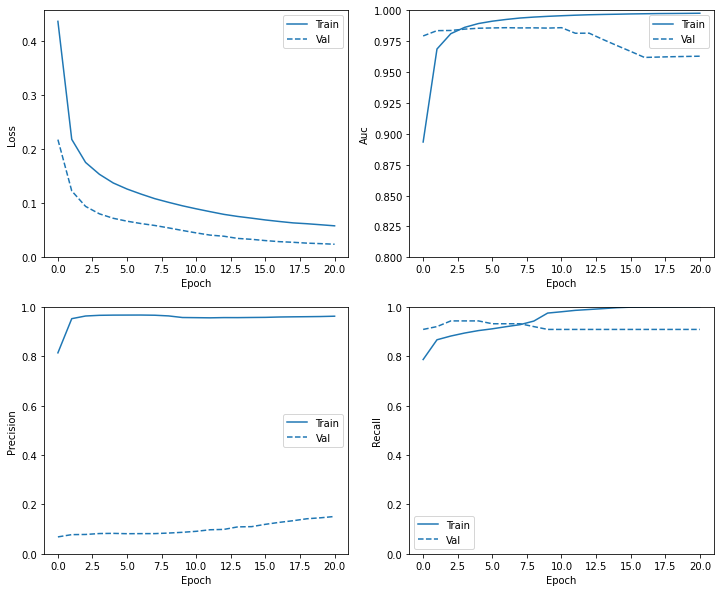

In [47]:
plot_metrics(resampled_history )

### Re-train


Because training is easier on the balanced data, the above training procedure may overfit quickly. 

So break up the epochs to give the `callbacks.EarlyStopping` finer control over when to stop training.

In [48]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch = 20,
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds))

Epoch 1/1000


 1/20 [>.............................] - ETA: 0s - loss: 1.3321 - tp: 419.0000 - fp: 755.0000 - tn: 45759.0000 - fn: 684.0000 - accuracy: 0.9698 - precision: 0.3569 - recall: 0.3799 - auc: 0.9250

 4/20 [=====>........................] - ETA: 0s - loss: 1.3140 - tp: 1511.0000 - fp: 1804.0000 - tn: 47837.0000 - fn: 2609.0000 - accuracy: 0.9179 - precision: 0.4558 - recall: 0.3667 - auc: 0.8931

 7/20 [=========>....................] - ETA: 0s - loss: 1.2566 - tp: 2798.0000 - fp: 2833.0000 - tn: 49898.0000 - fn: 4376.0000 - accuracy: 0.8797 - precision: 0.4969 - recall: 0.3900 - auc: 0.8740

10/20 [==============>...............] - ETA: 0s - loss: 1.2028 - tp: 4186.0000 - fp: 3892.0000 - tn: 51903.0000 - fn: 6068.0000 - accuracy: 0.8492 - precision: 0.5182 - recall: 0.4082 - auc: 0.8591

13/20 [==================>...........] - ETA: 0s - loss: 1.1597 - tp: 5663.0000 - fp: 4925.0000 - tn: 53941.0000 - fn: 7664.0000 - accuracy: 0.8256 - precision: 0.5349 - recall: 0.4249 - auc: 0.8463

16/20 [=======================>......] - ETA: 0s - loss: 1.1155 - tp: 7223.0000 - fp: 5949.0000 - tn: 56002.0000 - fn: 9163.0000 - accuracy: 0.8071 - precision: 0.5484 - recall: 0.4408 - auc: 0.8362

19/20 [===========================>..] - ETA: 0s - loss: 1.0772 - tp: 8916.0000 - fp: 7019.0000 - tn: 57999.0000 - fn: 10547.0000 - accuracy: 0.7921 - precision: 0.5595 - recall: 0.4581 - auc: 0.8278

20/20 [==============================] - 1s 60ms/step - loss: 1.0656 - tp: 9507.0000 - fp: 7370.0000 - tn: 58667.0000 - fn: 10985.0000 - accuracy: 0.7879 - precision: 0.5633 - recall: 0.4639 - auc: 0.8255 - val_loss: 0.5792 - val_tp: 66.0000 - val_fp: 13452.0000 - val_tn: 32030.0000 - val_fn: 21.0000 - val_accuracy: 0.7043 - val_precision: 0.0049 - val_recall: 0.7586 - val_auc: 0.7866


Epoch 2/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.8212 - tp: 600.0000 - fp: 379.0000 - tn: 645.0000 - fn: 424.0000 - accuracy: 0.6079 - precision: 0.6129 - recall: 0.5859 - auc: 0.6385

 5/20 [======>.......................] - ETA: 0s - loss: 0.7801 - tp: 3145.0000 - fp: 1828.0000 - tn: 3300.0000 - fn: 1967.0000 - accuracy: 0.6294 - precision: 0.6324 - recall: 0.6152 - auc: 0.6620

 8/20 [===========>..................] - ETA: 0s - loss: 0.7589 - tp: 5038.0000 - fp: 2930.0000 - tn: 5341.0000 - fn: 3075.0000 - accuracy: 0.6335 - precision: 0.6323 - recall: 0.6210 - auc: 0.6699

11/20 [===============>..............] - ETA: 0s - loss: 0.7443 - tp: 7082.0000 - fp: 4038.0000 - tn: 7273.0000 - fn: 4135.0000 - accuracy: 0.6372 - precision: 0.6369 - recall: 0.6314 - auc: 0.6775

14/20 [====================>.........] - ETA: 0s - loss: 0.7278 - tp: 9191.0000 - fp: 5134.0000 - tn: 9233.0000 - fn: 5114.0000 - accuracy: 0.6426 - precision: 0.6416 - recall: 0.6425 - auc: 0.6873

17/20 [========================>.....] - ETA: 0s - loss: 0.7146 - tp: 11265.0000 - fp: 6208.0000 - tn: 11258.0000 - fn: 6085.0000 - accuracy: 0.6469 - precision: 0.6447 - recall: 0.6493 - auc: 0.6948

20/20 [==============================] - ETA: 0s - loss: 0.6996 - tp: 13383.0000 - fp: 7208.0000 - tn: 13397.0000 - fn: 6972.0000 - accuracy: 0.6538 - precision: 0.6499 - recall: 0.6575 - auc: 0.7027

20/20 [==============================] - 1s 26ms/step - loss: 0.6996 - tp: 13383.0000 - fp: 7208.0000 - tn: 13397.0000 - fn: 6972.0000 - accuracy: 0.6538 - precision: 0.6499 - recall: 0.6575 - auc: 0.7027 - val_loss: 0.5702 - val_tp: 76.0000 - val_fp: 12408.0000 - val_tn: 33074.0000 - val_fn: 11.0000 - val_accuracy: 0.7275 - val_precision: 0.0061 - val_recall: 0.8736 - val_auc: 0.9076


Epoch 3/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.6131 - tp: 742.0000 - fp: 345.0000 - tn: 658.0000 - fn: 303.0000 - accuracy: 0.6836 - precision: 0.6826 - recall: 0.7100 - auc: 0.7519

 5/20 [======>.......................] - ETA: 0s - loss: 0.5930 - tp: 3688.0000 - fp: 1709.0000 - tn: 3442.0000 - fn: 1401.0000 - accuracy: 0.6963 - precision: 0.6833 - recall: 0.7247 - auc: 0.7699

 8/20 [===========>..................] - ETA: 0s - loss: 0.5811 - tp: 5930.0000 - fp: 2740.0000 - tn: 5561.0000 - fn: 2153.0000 - accuracy: 0.7014 - precision: 0.6840 - recall: 0.7336 - auc: 0.7778

11/20 [===============>..............] - ETA: 0s - loss: 0.5733 - tp: 8128.0000 - fp: 3731.0000 - tn: 7727.0000 - fn: 2942.0000 - accuracy: 0.7038 - precision: 0.6854 - recall: 0.7342 - auc: 0.7808

14/20 [====================>.........] - ETA: 0s - loss: 0.5682 - tp: 10489.0000 - fp: 4744.0000 - tn: 9729.0000 - fn: 3710.0000 - accuracy: 0.7051 - precision: 0.6886 - recall: 0.7387 - auc: 0.7841

17/20 [========================>.....] - ETA: 0s - loss: 0.5616 - tp: 12742.0000 - fp: 5717.0000 - tn: 11933.0000 - fn: 4424.0000 - accuracy: 0.7087 - precision: 0.6903 - recall: 0.7423 - auc: 0.7890

19/20 [===========================>..] - ETA: 0s - loss: 0.5556 - tp: 14361.0000 - fp: 6356.0000 - tn: 13313.0000 - fn: 4882.0000 - accuracy: 0.7112 - precision: 0.6932 - recall: 0.7463 - auc: 0.7935

20/20 [==============================] - 1s 28ms/step - loss: 0.5532 - tp: 15127.0000 - fp: 6665.0000 - tn: 14055.0000 - fn: 5113.0000 - accuracy: 0.7125 - precision: 0.6942 - recall: 0.7474 - auc: 0.7952 - val_loss: 0.5335 - val_tp: 79.0000 - val_fp: 9006.0000 - val_tn: 36476.0000 - val_fn: 8.0000 - val_accuracy: 0.8022 - val_precision: 0.0087 - val_recall: 0.9080 - val_auc: 0.9408


Epoch 4/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.5007 - tp: 804.0000 - fp: 285.0000 - tn: 712.0000 - fn: 247.0000 - accuracy: 0.7402 - precision: 0.7383 - recall: 0.7650 - auc: 0.8300

 5/20 [======>.......................] - ETA: 0s - loss: 0.4949 - tp: 3975.0000 - fp: 1491.0000 - tn: 3580.0000 - fn: 1194.0000 - accuracy: 0.7378 - precision: 0.7272 - recall: 0.7690 - auc: 0.8328

 7/20 [=========>....................] - ETA: 0s - loss: 0.4945 - tp: 5521.0000 - fp: 2103.0000 - tn: 5081.0000 - fn: 1631.0000 - accuracy: 0.7395 - precision: 0.7242 - recall: 0.7720 - auc: 0.8348

10/20 [==============>...............] - ETA: 0s - loss: 0.4889 - tp: 7915.0000 - fp: 2990.0000 - tn: 7306.0000 - fn: 2269.0000 - accuracy: 0.7432 - precision: 0.7258 - recall: 0.7772 - auc: 0.8389

13/20 [==================>...........] - ETA: 0s - loss: 0.4858 - tp: 10328.0000 - fp: 3839.0000 - tn: 9543.0000 - fn: 2914.0000 - accuracy: 0.7464 - precision: 0.7290 - recall: 0.7799 - auc: 0.8412

16/20 [=======================>......] - ETA: 0s - loss: 0.4807 - tp: 12763.0000 - fp: 4635.0000 - tn: 11825.0000 - fn: 3545.0000 - accuracy: 0.7504 - precision: 0.7336 - recall: 0.7826 - auc: 0.8448

19/20 [===========================>..] - ETA: 0s - loss: 0.4754 - tp: 15223.0000 - fp: 5430.0000 - tn: 14129.0000 - fn: 4130.0000 - accuracy: 0.7543 - precision: 0.7371 - recall: 0.7866 - auc: 0.8485

20/20 [==============================] - 1s 28ms/step - loss: 0.4738 - tp: 16061.0000 - fp: 5669.0000 - tn: 14890.0000 - fn: 4340.0000 - accuracy: 0.7556 - precision: 0.7391 - recall: 0.7873 - auc: 0.8495 - val_loss: 0.4883 - val_tp: 78.0000 - val_fp: 5756.0000 - val_tn: 39726.0000 - val_fn: 9.0000 - val_accuracy: 0.8735 - val_precision: 0.0134 - val_recall: 0.8966 - val_auc: 0.9489


Epoch 5/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.4453 - tp: 840.0000 - fp: 244.0000 - tn: 754.0000 - fn: 210.0000 - accuracy: 0.7783 - precision: 0.7749 - recall: 0.8000 - auc: 0.8652

 5/20 [======>.......................] - ETA: 0s - loss: 0.4466 - tp: 4101.0000 - fp: 1260.0000 - tn: 3876.0000 - fn: 1003.0000 - accuracy: 0.7790 - precision: 0.7650 - recall: 0.8035 - auc: 0.8672

 8/20 [===========>..................] - ETA: 0s - loss: 0.4396 - tp: 6570.0000 - fp: 2020.0000 - tn: 6193.0000 - fn: 1601.0000 - accuracy: 0.7790 - precision: 0.7648 - recall: 0.8041 - auc: 0.8703

11/20 [===============>..............] - ETA: 0s - loss: 0.4365 - tp: 9084.0000 - fp: 2758.0000 - tn: 8502.0000 - fn: 2184.0000 - accuracy: 0.7806 - precision: 0.7671 - recall: 0.8062 - auc: 0.8727

14/20 [====================>.........] - ETA: 0s - loss: 0.4341 - tp: 11599.0000 - fp: 3429.0000 - tn: 10858.0000 - fn: 2786.0000 - accuracy: 0.7832 - precision: 0.7718 - recall: 0.8063 - auc: 0.8740

17/20 [========================>.....] - ETA: 0s - loss: 0.4308 - tp: 14085.0000 - fp: 4064.0000 - tn: 13303.0000 - fn: 3364.0000 - accuracy: 0.7866 - precision: 0.7761 - recall: 0.8072 - auc: 0.8762

20/20 [==============================] - ETA: 0s - loss: 0.4266 - tp: 16612.0000 - fp: 4719.0000 - tn: 15715.0000 - fn: 3914.0000 - accuracy: 0.7892 - precision: 0.7788 - recall: 0.8093 - auc: 0.8786

20/20 [==============================] - 0s 23ms/step - loss: 0.4266 - tp: 16612.0000 - fp: 4719.0000 - tn: 15715.0000 - fn: 3914.0000 - accuracy: 0.7892 - precision: 0.7788 - recall: 0.8093 - auc: 0.8786 - val_loss: 0.4435 - val_tp: 78.0000 - val_fp: 3758.0000 - val_tn: 41724.0000 - val_fn: 9.0000 - val_accuracy: 0.9173 - val_precision: 0.0203 - val_recall: 0.8966 - val_auc: 0.9539


Epoch 6/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.4173 - tp: 796.0000 - fp: 217.0000 - tn: 832.0000 - fn: 203.0000 - accuracy: 0.7949 - precision: 0.7858 - recall: 0.7968 - auc: 0.8789

 5/20 [======>.......................] - ETA: 0s - loss: 0.4043 - tp: 4149.0000 - fp: 998.0000 - tn: 4136.0000 - fn: 957.0000 - accuracy: 0.8091 - precision: 0.8061 - recall: 0.8126 - auc: 0.8888

 8/20 [===========>..................] - ETA: 0s - loss: 0.4017 - tp: 6659.0000 - fp: 1643.0000 - tn: 6593.0000 - fn: 1489.0000 - accuracy: 0.8088 - precision: 0.8021 - recall: 0.8173 - auc: 0.8913

11/20 [===============>..............] - ETA: 0s - loss: 0.3984 - tp: 9215.0000 - fp: 2186.0000 - tn: 9094.0000 - fn: 2033.0000 - accuracy: 0.8127 - precision: 0.8083 - recall: 0.8193 - auc: 0.8940

14/20 [====================>.........] - ETA: 0s - loss: 0.3957 - tp: 11799.0000 - fp: 2777.0000 - tn: 11519.0000 - fn: 2577.0000 - accuracy: 0.8133 - precision: 0.8095 - recall: 0.8207 - auc: 0.8954

17/20 [========================>.....] - ETA: 0s - loss: 0.3933 - tp: 14332.0000 - fp: 3329.0000 - tn: 14026.0000 - fn: 3129.0000 - accuracy: 0.8145 - precision: 0.8115 - recall: 0.8208 - auc: 0.8965

20/20 [==============================] - ETA: 0s - loss: 0.3908 - tp: 16911.0000 - fp: 3861.0000 - tn: 16514.0000 - fn: 3674.0000 - accuracy: 0.8160 - precision: 0.8141 - recall: 0.8215 - auc: 0.8976

20/20 [==============================] - 0s 23ms/step - loss: 0.3908 - tp: 16911.0000 - fp: 3861.0000 - tn: 16514.0000 - fn: 3674.0000 - accuracy: 0.8160 - precision: 0.8141 - recall: 0.8215 - auc: 0.8976 - val_loss: 0.4032 - val_tp: 79.0000 - val_fp: 2770.0000 - val_tn: 42712.0000 - val_fn: 8.0000 - val_accuracy: 0.9390 - val_precision: 0.0277 - val_recall: 0.9080 - val_auc: 0.9590


Epoch 7/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.3744 - tp: 828.0000 - fp: 171.0000 - tn: 857.0000 - fn: 192.0000 - accuracy: 0.8228 - precision: 0.8288 - recall: 0.8118 - auc: 0.9038

 5/20 [======>.......................] - ETA: 0s - loss: 0.3727 - tp: 4248.0000 - fp: 859.0000 - tn: 4255.0000 - fn: 878.0000 - accuracy: 0.8304 - precision: 0.8318 - recall: 0.8287 - auc: 0.9086

 8/20 [===========>..................] - ETA: 0s - loss: 0.3706 - tp: 6789.0000 - fp: 1351.0000 - tn: 6835.0000 - fn: 1409.0000 - accuracy: 0.8315 - precision: 0.8340 - recall: 0.8281 - auc: 0.9095

11/20 [===============>..............] - ETA: 0s - loss: 0.3695 - tp: 9388.0000 - fp: 1827.0000 - tn: 9375.0000 - fn: 1938.0000 - accuracy: 0.8329 - precision: 0.8371 - recall: 0.8289 - auc: 0.9096

14/20 [====================>.........] - ETA: 0s - loss: 0.3690 - tp: 11932.0000 - fp: 2283.0000 - tn: 11964.0000 - fn: 2493.0000 - accuracy: 0.8334 - precision: 0.8394 - recall: 0.8272 - auc: 0.9096

17/20 [========================>.....] - ETA: 0s - loss: 0.3670 - tp: 14471.0000 - fp: 2749.0000 - tn: 14600.0000 - fn: 2996.0000 - accuracy: 0.8350 - precision: 0.8404 - recall: 0.8285 - auc: 0.9108

20/20 [==============================] - ETA: 0s - loss: 0.3664 - tp: 17049.0000 - fp: 3209.0000 - tn: 17179.0000 - fn: 3523.0000 - accuracy: 0.8356 - precision: 0.8416 - recall: 0.8287 - auc: 0.9108

20/20 [==============================] - 0s 25ms/step - loss: 0.3664 - tp: 17049.0000 - fp: 3209.0000 - tn: 17179.0000 - fn: 3523.0000 - accuracy: 0.8356 - precision: 0.8416 - recall: 0.8287 - auc: 0.9108 - val_loss: 0.3682 - val_tp: 79.0000 - val_fp: 2119.0000 - val_tn: 43363.0000 - val_fn: 8.0000 - val_accuracy: 0.9533 - val_precision: 0.0359 - val_recall: 0.9080 - val_auc: 0.9634


Epoch 8/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.3524 - tp: 864.0000 - fp: 133.0000 - tn: 878.0000 - fn: 173.0000 - accuracy: 0.8506 - precision: 0.8666 - recall: 0.8332 - auc: 0.9151

 5/20 [======>.......................] - ETA: 0s - loss: 0.3533 - tp: 4277.0000 - fp: 693.0000 - tn: 4396.0000 - fn: 874.0000 - accuracy: 0.8470 - precision: 0.8606 - recall: 0.8303 - auc: 0.9163

 8/20 [===========>..................] - ETA: 0s - loss: 0.3528 - tp: 6868.0000 - fp: 1145.0000 - tn: 6970.0000 - fn: 1401.0000 - accuracy: 0.8446 - precision: 0.8571 - recall: 0.8306 - auc: 0.9167

11/20 [===============>..............] - ETA: 0s - loss: 0.3507 - tp: 9457.0000 - fp: 1567.0000 - tn: 9591.0000 - fn: 1913.0000 - accuracy: 0.8455 - precision: 0.8579 - recall: 0.8318 - auc: 0.9177

14/20 [====================>.........] - ETA: 0s - loss: 0.3484 - tp: 11990.0000 - fp: 1930.0000 - tn: 12301.0000 - fn: 2451.0000 - accuracy: 0.8472 - precision: 0.8614 - recall: 0.8303 - auc: 0.9188

17/20 [========================>.....] - ETA: 0s - loss: 0.3479 - tp: 14520.0000 - fp: 2294.0000 - tn: 15019.0000 - fn: 2983.0000 - accuracy: 0.8484 - precision: 0.8636 - recall: 0.8296 - auc: 0.9186

20/20 [==============================] - ETA: 0s - loss: 0.3467 - tp: 17100.0000 - fp: 2699.0000 - tn: 17686.0000 - fn: 3475.0000 - accuracy: 0.8493 - precision: 0.8637 - recall: 0.8311 - auc: 0.9193

20/20 [==============================] - 0s 24ms/step - loss: 0.3467 - tp: 17100.0000 - fp: 2699.0000 - tn: 17686.0000 - fn: 3475.0000 - accuracy: 0.8493 - precision: 0.8637 - recall: 0.8311 - auc: 0.9193 - val_loss: 0.3373 - val_tp: 79.0000 - val_fp: 1753.0000 - val_tn: 43729.0000 - val_fn: 8.0000 - val_accuracy: 0.9614 - val_precision: 0.0431 - val_recall: 0.9080 - val_auc: 0.9675


Epoch 9/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.3478 - tp: 843.0000 - fp: 127.0000 - tn: 895.0000 - fn: 183.0000 - accuracy: 0.8486 - precision: 0.8691 - recall: 0.8216 - auc: 0.9196

 5/20 [======>.......................] - ETA: 0s - loss: 0.3350 - tp: 4266.0000 - fp: 600.0000 - tn: 4555.0000 - fn: 819.0000 - accuracy: 0.8614 - precision: 0.8767 - recall: 0.8389 - auc: 0.9250

 8/20 [===========>..................] - ETA: 0s - loss: 0.3324 - tp: 6859.0000 - fp: 942.0000 - tn: 7266.0000 - fn: 1317.0000 - accuracy: 0.8621 - precision: 0.8792 - recall: 0.8389 - auc: 0.9260

11/20 [===============>..............] - ETA: 0s - loss: 0.3325 - tp: 9383.0000 - fp: 1300.0000 - tn: 10004.0000 - fn: 1841.0000 - accuracy: 0.8606 - precision: 0.8783 - recall: 0.8360 - auc: 0.9259

13/20 [==================>...........] - ETA: 0s - loss: 0.3318 - tp: 11090.0000 - fp: 1537.0000 - tn: 11810.0000 - fn: 2187.0000 - accuracy: 0.8601 - precision: 0.8783 - recall: 0.8353 - auc: 0.9260

16/20 [=======================>......] - ETA: 0s - loss: 0.3300 - tp: 13632.0000 - fp: 1874.0000 - tn: 14562.0000 - fn: 2700.0000 - accuracy: 0.8604 - precision: 0.8791 - recall: 0.8347 - auc: 0.9264

18/20 [==========================>...] - ETA: 0s - loss: 0.3299 - tp: 15363.0000 - fp: 2111.0000 - tn: 16360.0000 - fn: 3030.0000 - accuracy: 0.8605 - precision: 0.8792 - recall: 0.8353 - auc: 0.9263

20/20 [==============================] - 1s 29ms/step - loss: 0.3285 - tp: 17043.0000 - fp: 2345.0000 - tn: 18228.0000 - fn: 3344.0000 - accuracy: 0.8611 - precision: 0.8790 - recall: 0.8360 - auc: 0.9271 - val_loss: 0.3104 - val_tp: 79.0000 - val_fp: 1495.0000 - val_tn: 43987.0000 - val_fn: 8.0000 - val_accuracy: 0.9670 - val_precision: 0.0502 - val_recall: 0.9080 - val_auc: 0.9702


Epoch 10/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.3145 - tp: 878.0000 - fp: 96.0000 - tn: 897.0000 - fn: 177.0000 - accuracy: 0.8667 - precision: 0.9014 - recall: 0.8322 - auc: 0.9328

 5/20 [======>.......................] - ETA: 0s - loss: 0.3121 - tp: 4325.0000 - fp: 506.0000 - tn: 4599.0000 - fn: 810.0000 - accuracy: 0.8715 - precision: 0.8953 - recall: 0.8423 - auc: 0.9355

 8/20 [===========>..................] - ETA: 0s - loss: 0.3139 - tp: 6929.0000 - fp: 831.0000 - tn: 7312.0000 - fn: 1312.0000 - accuracy: 0.8692 - precision: 0.8929 - recall: 0.8408 - auc: 0.9337

11/20 [===============>..............] - ETA: 0s - loss: 0.3119 - tp: 9507.0000 - fp: 1146.0000 - tn: 10091.0000 - fn: 1784.0000 - accuracy: 0.8699 - precision: 0.8924 - recall: 0.8420 - auc: 0.9351

14/20 [====================>.........] - ETA: 0s - loss: 0.3105 - tp: 12107.0000 - fp: 1436.0000 - tn: 12863.0000 - fn: 2266.0000 - accuracy: 0.8709 - precision: 0.8940 - recall: 0.8423 - auc: 0.9356

17/20 [========================>.....] - ETA: 0s - loss: 0.3101 - tp: 14702.0000 - fp: 1747.0000 - tn: 15630.0000 - fn: 2737.0000 - accuracy: 0.8712 - precision: 0.8938 - recall: 0.8431 - auc: 0.9359

20/20 [==============================] - ETA: 0s - loss: 0.3094 - tp: 17322.0000 - fp: 2012.0000 - tn: 18405.0000 - fn: 3221.0000 - accuracy: 0.8722 - precision: 0.8959 - recall: 0.8432 - auc: 0.9361

20/20 [==============================] - 1s 27ms/step - loss: 0.3094 - tp: 17322.0000 - fp: 2012.0000 - tn: 18405.0000 - fn: 3221.0000 - accuracy: 0.8722 - precision: 0.8959 - recall: 0.8432 - auc: 0.9361 - val_loss: 0.2865 - val_tp: 79.0000 - val_fp: 1332.0000 - val_tn: 44150.0000 - val_fn: 8.0000 - val_accuracy: 0.9706 - val_precision: 0.0560 - val_recall: 0.9080 - val_auc: 0.9721


Epoch 11/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.3104 - tp: 854.0000 - fp: 101.0000 - tn: 925.0000 - fn: 168.0000 - accuracy: 0.8687 - precision: 0.8942 - recall: 0.8356 - auc: 0.9350

 4/20 [=====>........................] - ETA: 0s - loss: 0.3018 - tp: 3437.0000 - fp: 378.0000 - tn: 3727.0000 - fn: 650.0000 - accuracy: 0.8745 - precision: 0.9009 - recall: 0.8410 - auc: 0.9388

 7/20 [=========>....................] - ETA: 0s - loss: 0.3014 - tp: 6008.0000 - fp: 641.0000 - tn: 6553.0000 - fn: 1134.0000 - accuracy: 0.8762 - precision: 0.9036 - recall: 0.8412 - auc: 0.9388

10/20 [==============>...............] - ETA: 0s - loss: 0.3003 - tp: 8595.0000 - fp: 896.0000 - tn: 9376.0000 - fn: 1613.0000 - accuracy: 0.8775 - precision: 0.9056 - recall: 0.8420 - auc: 0.9388

13/20 [==================>...........] - ETA: 0s - loss: 0.2997 - tp: 11157.0000 - fp: 1193.0000 - tn: 12204.0000 - fn: 2070.0000 - accuracy: 0.8774 - precision: 0.9034 - recall: 0.8435 - auc: 0.9391

16/20 [=======================>......] - ETA: 0s - loss: 0.2981 - tp: 13708.0000 - fp: 1441.0000 - tn: 15076.0000 - fn: 2543.0000 - accuracy: 0.8784 - precision: 0.9049 - recall: 0.8435 - auc: 0.9395

18/20 [==========================>...] - ETA: 0s - loss: 0.2979 - tp: 15459.0000 - fp: 1609.0000 - tn: 16945.0000 - fn: 2851.0000 - accuracy: 0.8790 - precision: 0.9057 - recall: 0.8443 - auc: 0.9398

20/20 [==============================] - ETA: 0s - loss: 0.2962 - tp: 17184.0000 - fp: 1757.0000 - tn: 18853.0000 - fn: 3166.0000 - accuracy: 0.8798 - precision: 0.9072 - recall: 0.8444 - auc: 0.9406

20/20 [==============================] - 1s 29ms/step - loss: 0.2962 - tp: 17184.0000 - fp: 1757.0000 - tn: 18853.0000 - fn: 3166.0000 - accuracy: 0.8798 - precision: 0.9072 - recall: 0.8444 - auc: 0.9406 - val_loss: 0.2654 - val_tp: 79.0000 - val_fp: 1228.0000 - val_tn: 44254.0000 - val_fn: 8.0000 - val_accuracy: 0.9729 - val_precision: 0.0604 - val_recall: 0.9080 - val_auc: 0.9739


Epoch 12/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2836 - tp: 880.0000 - fp: 67.0000 - tn: 947.0000 - fn: 154.0000 - accuracy: 0.8921 - precision: 0.9293 - recall: 0.8511 - auc: 0.9446

 4/20 [=====>........................] - ETA: 0s - loss: 0.2855 - tp: 3464.0000 - fp: 312.0000 - tn: 3782.0000 - fn: 634.0000 - accuracy: 0.8845 - precision: 0.9174 - recall: 0.8453 - auc: 0.9443

 6/20 [========>.....................] - ETA: 0s - loss: 0.2858 - tp: 5210.0000 - fp: 474.0000 - tn: 5657.0000 - fn: 947.0000 - accuracy: 0.8844 - precision: 0.9166 - recall: 0.8462 - auc: 0.9443

 8/20 [===========>..................] - ETA: 0s - loss: 0.2848 - tp: 6953.0000 - fp: 609.0000 - tn: 7555.0000 - fn: 1267.0000 - accuracy: 0.8855 - precision: 0.9195 - recall: 0.8459 - auc: 0.9450

10/20 [==============>...............] - ETA: 0s - loss: 0.2821 - tp: 8723.0000 - fp: 752.0000 - tn: 9438.0000 - fn: 1567.0000 - accuracy: 0.8868 - precision: 0.9206 - recall: 0.8477 - auc: 0.9465

13/20 [==================>...........] - ETA: 0s - loss: 0.2837 - tp: 11325.0000 - fp: 974.0000 - tn: 12263.0000 - fn: 2062.0000 - accuracy: 0.8860 - precision: 0.9208 - recall: 0.8460 - auc: 0.9458

15/20 [=====================>........] - ETA: 0s - loss: 0.2840 - tp: 13007.0000 - fp: 1134.0000 - tn: 14197.0000 - fn: 2382.0000 - accuracy: 0.8855 - precision: 0.9198 - recall: 0.8452 - auc: 0.9454

18/20 [==========================>...] - ETA: 0s - loss: 0.2834 - tp: 15616.0000 - fp: 1373.0000 - tn: 17043.0000 - fn: 2832.0000 - accuracy: 0.8859 - precision: 0.9192 - recall: 0.8465 - auc: 0.9457

20/20 [==============================] - ETA: 0s - loss: 0.2835 - tp: 17373.0000 - fp: 1543.0000 - tn: 18909.0000 - fn: 3135.0000 - accuracy: 0.8858 - precision: 0.9184 - recall: 0.8471 - auc: 0.9458

20/20 [==============================] - 1s 30ms/step - loss: 0.2835 - tp: 17373.0000 - fp: 1543.0000 - tn: 18909.0000 - fn: 3135.0000 - accuracy: 0.8858 - precision: 0.9184 - recall: 0.8471 - auc: 0.9458 - val_loss: 0.2469 - val_tp: 79.0000 - val_fp: 1155.0000 - val_tn: 44327.0000 - val_fn: 8.0000 - val_accuracy: 0.9745 - val_precision: 0.0640 - val_recall: 0.9080 - val_auc: 0.9759


Epoch 13/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2877 - tp: 880.0000 - fp: 70.0000 - tn: 946.0000 - fn: 152.0000 - accuracy: 0.8916 - precision: 0.9263 - recall: 0.8527 - auc: 0.9438

 5/20 [======>.......................] - ETA: 0s - loss: 0.2781 - tp: 4319.0000 - fp: 373.0000 - tn: 4778.0000 - fn: 770.0000 - accuracy: 0.8884 - precision: 0.9205 - recall: 0.8487 - auc: 0.9482

 8/20 [===========>..................] - ETA: 0s - loss: 0.2753 - tp: 6891.0000 - fp: 599.0000 - tn: 7681.0000 - fn: 1213.0000 - accuracy: 0.8894 - precision: 0.9200 - recall: 0.8503 - auc: 0.9494

11/20 [===============>..............] - ETA: 0s - loss: 0.2734 - tp: 9517.0000 - fp: 788.0000 - tn: 10553.0000 - fn: 1670.0000 - accuracy: 0.8909 - precision: 0.9235 - recall: 0.8507 - auc: 0.9498

14/20 [====================>.........] - ETA: 0s - loss: 0.2721 - tp: 12152.0000 - fp: 982.0000 - tn: 13407.0000 - fn: 2131.0000 - accuracy: 0.8914 - precision: 0.9252 - recall: 0.8508 - auc: 0.9500

17/20 [========================>.....] - ETA: 0s - loss: 0.2718 - tp: 14767.0000 - fp: 1191.0000 - tn: 16267.0000 - fn: 2591.0000 - accuracy: 0.8914 - precision: 0.9254 - recall: 0.8507 - auc: 0.9499

20/20 [==============================] - ETA: 0s - loss: 0.2710 - tp: 17386.0000 - fp: 1395.0000 - tn: 19124.0000 - fn: 3055.0000 - accuracy: 0.8914 - precision: 0.9257 - recall: 0.8505 - auc: 0.9502

20/20 [==============================] - 1s 28ms/step - loss: 0.2710 - tp: 17386.0000 - fp: 1395.0000 - tn: 19124.0000 - fn: 3055.0000 - accuracy: 0.8914 - precision: 0.9257 - recall: 0.8505 - auc: 0.9502 - val_loss: 0.2302 - val_tp: 79.0000 - val_fp: 1092.0000 - val_tn: 44390.0000 - val_fn: 8.0000 - val_accuracy: 0.9759 - val_precision: 0.0675 - val_recall: 0.9080 - val_auc: 0.9782


Epoch 14/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2546 - tp: 861.0000 - fp: 62.0000 - tn: 984.0000 - fn: 141.0000 - accuracy: 0.9009 - precision: 0.9328 - recall: 0.8593 - auc: 0.9590

 5/20 [======>.......................] - ETA: 0s - loss: 0.2617 - tp: 4290.0000 - fp: 356.0000 - tn: 4872.0000 - fn: 722.0000 - accuracy: 0.8947 - precision: 0.9234 - recall: 0.8559 - auc: 0.9538

 8/20 [===========>..................] - ETA: 0s - loss: 0.2618 - tp: 6919.0000 - fp: 548.0000 - tn: 7733.0000 - fn: 1184.0000 - accuracy: 0.8943 - precision: 0.9266 - recall: 0.8539 - auc: 0.9542

11/20 [===============>..............] - ETA: 0s - loss: 0.2617 - tp: 9514.0000 - fp: 732.0000 - tn: 10627.0000 - fn: 1655.0000 - accuracy: 0.8940 - precision: 0.9286 - recall: 0.8518 - auc: 0.9544

14/20 [====================>.........] - ETA: 0s - loss: 0.2632 - tp: 12081.0000 - fp: 946.0000 - tn: 13550.0000 - fn: 2095.0000 - accuracy: 0.8939 - precision: 0.9274 - recall: 0.8522 - auc: 0.9536

17/20 [========================>.....] - ETA: 0s - loss: 0.2618 - tp: 14732.0000 - fp: 1144.0000 - tn: 16412.0000 - fn: 2528.0000 - accuracy: 0.8945 - precision: 0.9279 - recall: 0.8535 - auc: 0.9541

20/20 [==============================] - ETA: 0s - loss: 0.2618 - tp: 17336.0000 - fp: 1343.0000 - tn: 19296.0000 - fn: 2985.0000 - accuracy: 0.8943 - precision: 0.9281 - recall: 0.8531 - auc: 0.9541

20/20 [==============================] - 0s 24ms/step - loss: 0.2618 - tp: 17336.0000 - fp: 1343.0000 - tn: 19296.0000 - fn: 2985.0000 - accuracy: 0.8943 - precision: 0.9281 - recall: 0.8531 - auc: 0.9541 - val_loss: 0.2156 - val_tp: 79.0000 - val_fp: 1053.0000 - val_tn: 44429.0000 - val_fn: 8.0000 - val_accuracy: 0.9767 - val_precision: 0.0698 - val_recall: 0.9080 - val_auc: 0.9797


Epoch 15/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2629 - tp: 826.0000 - fp: 62.0000 - tn: 1004.0000 - fn: 156.0000 - accuracy: 0.8936 - precision: 0.9302 - recall: 0.8411 - auc: 0.9531

 5/20 [======>.......................] - ETA: 0s - loss: 0.2594 - tp: 4367.0000 - fp: 308.0000 - tn: 4817.0000 - fn: 748.0000 - accuracy: 0.8969 - precision: 0.9341 - recall: 0.8538 - auc: 0.9548

 8/20 [===========>..................] - ETA: 0s - loss: 0.2540 - tp: 7059.0000 - fp: 464.0000 - tn: 7651.0000 - fn: 1210.0000 - accuracy: 0.8978 - precision: 0.9383 - recall: 0.8537 - auc: 0.9570

11/20 [===============>..............] - ETA: 0s - loss: 0.2553 - tp: 9644.0000 - fp: 635.0000 - tn: 10590.0000 - fn: 1659.0000 - accuracy: 0.8982 - precision: 0.9382 - recall: 0.8532 - auc: 0.9564

14/20 [====================>.........] - ETA: 0s - loss: 0.2539 - tp: 12229.0000 - fp: 815.0000 - tn: 13538.0000 - fn: 2090.0000 - accuracy: 0.8987 - precision: 0.9375 - recall: 0.8540 - auc: 0.9568

17/20 [========================>.....] - ETA: 0s - loss: 0.2524 - tp: 14890.0000 - fp: 976.0000 - tn: 16427.0000 - fn: 2523.0000 - accuracy: 0.8995 - precision: 0.9385 - recall: 0.8551 - auc: 0.9576

20/20 [==============================] - ETA: 0s - loss: 0.2529 - tp: 17466.0000 - fp: 1154.0000 - tn: 19366.0000 - fn: 2974.0000 - accuracy: 0.8992 - precision: 0.9380 - recall: 0.8545 - auc: 0.9574

20/20 [==============================] - 0s 24ms/step - loss: 0.2529 - tp: 17466.0000 - fp: 1154.0000 - tn: 19366.0000 - fn: 2974.0000 - accuracy: 0.8992 - precision: 0.9380 - recall: 0.8545 - auc: 0.9574 - val_loss: 0.2026 - val_tp: 79.0000 - val_fp: 1029.0000 - val_tn: 44453.0000 - val_fn: 8.0000 - val_accuracy: 0.9772 - val_precision: 0.0713 - val_recall: 0.9080 - val_auc: 0.9806


Epoch 16/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2335 - tp: 905.0000 - fp: 50.0000 - tn: 962.0000 - fn: 131.0000 - accuracy: 0.9116 - precision: 0.9476 - recall: 0.8736 - auc: 0.9644

 5/20 [======>.......................] - ETA: 0s - loss: 0.2466 - tp: 4420.0000 - fp: 276.0000 - tn: 4797.0000 - fn: 747.0000 - accuracy: 0.9001 - precision: 0.9412 - recall: 0.8554 - auc: 0.9591

 8/20 [===========>..................] - ETA: 0s - loss: 0.2461 - tp: 7093.0000 - fp: 419.0000 - tn: 7666.0000 - fn: 1206.0000 - accuracy: 0.9008 - precision: 0.9442 - recall: 0.8547 - auc: 0.9589

11/20 [===============>..............] - ETA: 0s - loss: 0.2464 - tp: 9736.0000 - fp: 565.0000 - tn: 10559.0000 - fn: 1668.0000 - accuracy: 0.9009 - precision: 0.9452 - recall: 0.8537 - auc: 0.9587

14/20 [====================>.........] - ETA: 0s - loss: 0.2467 - tp: 12339.0000 - fp: 729.0000 - tn: 13476.0000 - fn: 2128.0000 - accuracy: 0.9004 - precision: 0.9442 - recall: 0.8529 - auc: 0.9584

17/20 [========================>.....] - ETA: 0s - loss: 0.2464 - tp: 14967.0000 - fp: 908.0000 - tn: 16385.0000 - fn: 2556.0000 - accuracy: 0.9005 - precision: 0.9428 - recall: 0.8541 - auc: 0.9587

20/20 [==============================] - ETA: 0s - loss: 0.2456 - tp: 17579.0000 - fp: 1075.0000 - tn: 19322.0000 - fn: 2984.0000 - accuracy: 0.9009 - precision: 0.9424 - recall: 0.8549 - auc: 0.9590

20/20 [==============================] - 0s 24ms/step - loss: 0.2456 - tp: 17579.0000 - fp: 1075.0000 - tn: 19322.0000 - fn: 2984.0000 - accuracy: 0.9009 - precision: 0.9424 - recall: 0.8549 - auc: 0.9590 - val_loss: 0.1923 - val_tp: 79.0000 - val_fp: 1017.0000 - val_tn: 44465.0000 - val_fn: 8.0000 - val_accuracy: 0.9775 - val_precision: 0.0721 - val_recall: 0.9080 - val_auc: 0.9813


Epoch 17/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2522 - tp: 887.0000 - fp: 61.0000 - tn: 957.0000 - fn: 143.0000 - accuracy: 0.9004 - precision: 0.9357 - recall: 0.8612 - auc: 0.9568

 4/20 [=====>........................] - ETA: 0s - loss: 0.2440 - tp: 3553.0000 - fp: 223.0000 - tn: 3828.0000 - fn: 588.0000 - accuracy: 0.9010 - precision: 0.9409 - recall: 0.8580 - auc: 0.9604

 7/20 [=========>....................] - ETA: 0s - loss: 0.2427 - tp: 6200.0000 - fp: 356.0000 - tn: 6759.0000 - fn: 1021.0000 - accuracy: 0.9039 - precision: 0.9457 - recall: 0.8586 - auc: 0.9609

10/20 [==============>...............] - ETA: 0s - loss: 0.2390 - tp: 8884.0000 - fp: 484.0000 - tn: 9670.0000 - fn: 1442.0000 - accuracy: 0.9060 - precision: 0.9483 - recall: 0.8604 - auc: 0.9617

13/20 [==================>...........] - ETA: 0s - loss: 0.2399 - tp: 11490.0000 - fp: 632.0000 - tn: 12632.0000 - fn: 1870.0000 - accuracy: 0.9060 - precision: 0.9479 - recall: 0.8600 - auc: 0.9614

16/20 [=======================>......] - ETA: 0s - loss: 0.2397 - tp: 14108.0000 - fp: 788.0000 - tn: 15557.0000 - fn: 2315.0000 - accuracy: 0.9053 - precision: 0.9471 - recall: 0.8590 - auc: 0.9614

19/20 [===========================>..] - ETA: 0s - loss: 0.2385 - tp: 16714.0000 - fp: 925.0000 - tn: 18541.0000 - fn: 2732.0000 - accuracy: 0.9060 - precision: 0.9476 - recall: 0.8595 - auc: 0.9620

20/20 [==============================] - 0s 25ms/step - loss: 0.2382 - tp: 17573.0000 - fp: 982.0000 - tn: 19540.0000 - fn: 2865.0000 - accuracy: 0.9061 - precision: 0.9471 - recall: 0.8598 - auc: 0.9620 - val_loss: 0.1828 - val_tp: 79.0000 - val_fp: 1005.0000 - val_tn: 44477.0000 - val_fn: 8.0000 - val_accuracy: 0.9778 - val_precision: 0.0729 - val_recall: 0.9080 - val_auc: 0.9819


Epoch 18/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2272 - tp: 886.0000 - fp: 48.0000 - tn: 981.0000 - fn: 133.0000 - accuracy: 0.9116 - precision: 0.9486 - recall: 0.8695 - auc: 0.9649

 5/20 [======>.......................] - ETA: 0s - loss: 0.2314 - tp: 4482.0000 - fp: 239.0000 - tn: 4825.0000 - fn: 694.0000 - accuracy: 0.9089 - precision: 0.9494 - recall: 0.8659 - auc: 0.9640

 8/20 [===========>..................] - ETA: 0s - loss: 0.2338 - tp: 7158.0000 - fp: 388.0000 - tn: 7705.0000 - fn: 1133.0000 - accuracy: 0.9072 - precision: 0.9486 - recall: 0.8633 - auc: 0.9636

11/20 [===============>..............] - ETA: 0s - loss: 0.2325 - tp: 9761.0000 - fp: 538.0000 - tn: 10667.0000 - fn: 1562.0000 - accuracy: 0.9068 - precision: 0.9478 - recall: 0.8621 - auc: 0.9640

14/20 [====================>.........] - ETA: 0s - loss: 0.2325 - tp: 12425.0000 - fp: 702.0000 - tn: 13567.0000 - fn: 1978.0000 - accuracy: 0.9065 - precision: 0.9465 - recall: 0.8627 - auc: 0.9641

15/20 [=====================>........] - ETA: 0s - loss: 0.2319 - tp: 13291.0000 - fp: 747.0000 - tn: 14569.0000 - fn: 2113.0000 - accuracy: 0.9069 - precision: 0.9468 - recall: 0.8628 - auc: 0.9642

18/20 [==========================>...] - ETA: 0s - loss: 0.2319 - tp: 15917.0000 - fp: 886.0000 - tn: 17516.0000 - fn: 2545.0000 - accuracy: 0.9069 - precision: 0.9473 - recall: 0.8621 - auc: 0.9640

20/20 [==============================] - 1s 28ms/step - loss: 0.2307 - tp: 17711.0000 - fp: 966.0000 - tn: 19448.0000 - fn: 2835.0000 - accuracy: 0.9072 - precision: 0.9483 - recall: 0.8620 - auc: 0.9644 - val_loss: 0.1736 - val_tp: 80.0000 - val_fp: 990.0000 - val_tn: 44492.0000 - val_fn: 7.0000 - val_accuracy: 0.9781 - val_precision: 0.0748 - val_recall: 0.9195 - val_auc: 0.9825


Epoch 19/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2310 - tp: 869.0000 - fp: 54.0000 - tn: 990.0000 - fn: 135.0000 - accuracy: 0.9077 - precision: 0.9415 - recall: 0.8655 - auc: 0.9635

 5/20 [======>.......................] - ETA: 0s - loss: 0.2324 - tp: 4446.0000 - fp: 250.0000 - tn: 4821.0000 - fn: 723.0000 - accuracy: 0.9050 - precision: 0.9468 - recall: 0.8601 - auc: 0.9638

 8/20 [===========>..................] - ETA: 0s - loss: 0.2312 - tp: 7089.0000 - fp: 396.0000 - tn: 7745.0000 - fn: 1154.0000 - accuracy: 0.9054 - precision: 0.9471 - recall: 0.8600 - auc: 0.9641

11/20 [===============>..............] - ETA: 0s - loss: 0.2307 - tp: 9730.0000 - fp: 541.0000 - tn: 10695.0000 - fn: 1562.0000 - accuracy: 0.9066 - precision: 0.9473 - recall: 0.8617 - auc: 0.9641

13/20 [==================>...........] - ETA: 0s - loss: 0.2306 - tp: 11512.0000 - fp: 621.0000 - tn: 12621.0000 - fn: 1870.0000 - accuracy: 0.9064 - precision: 0.9488 - recall: 0.8603 - auc: 0.9640

16/20 [=======================>......] - ETA: 0s - loss: 0.2297 - tp: 14154.0000 - fp: 760.0000 - tn: 15567.0000 - fn: 2287.0000 - accuracy: 0.9070 - precision: 0.9490 - recall: 0.8609 - auc: 0.9646

19/20 [===========================>..] - ETA: 0s - loss: 0.2287 - tp: 16808.0000 - fp: 902.0000 - tn: 18491.0000 - fn: 2711.0000 - accuracy: 0.9071 - precision: 0.9491 - recall: 0.8611 - auc: 0.9651

20/20 [==============================] - 1s 28ms/step - loss: 0.2280 - tp: 17732.0000 - fp: 952.0000 - tn: 19442.0000 - fn: 2834.0000 - accuracy: 0.9076 - precision: 0.9490 - recall: 0.8622 - auc: 0.9653 - val_loss: 0.1660 - val_tp: 80.0000 - val_fp: 974.0000 - val_tn: 44508.0000 - val_fn: 7.0000 - val_accuracy: 0.9785 - val_precision: 0.0759 - val_recall: 0.9195 - val_auc: 0.9826


Epoch 20/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2142 - tp: 926.0000 - fp: 52.0000 - tn: 936.0000 - fn: 134.0000 - accuracy: 0.9092 - precision: 0.9468 - recall: 0.8736 - auc: 0.9700

 4/20 [=====>........................] - ETA: 0s - loss: 0.2218 - tp: 3576.0000 - fp: 187.0000 - tn: 3874.0000 - fn: 555.0000 - accuracy: 0.9094 - precision: 0.9503 - recall: 0.8656 - auc: 0.9671

 7/20 [=========>....................] - ETA: 0s - loss: 0.2237 - tp: 6198.0000 - fp: 334.0000 - tn: 6837.0000 - fn: 967.0000 - accuracy: 0.9092 - precision: 0.9489 - recall: 0.8650 - auc: 0.9661

10/20 [==============>...............] - ETA: 0s - loss: 0.2239 - tp: 8857.0000 - fp: 470.0000 - tn: 9770.0000 - fn: 1383.0000 - accuracy: 0.9095 - precision: 0.9496 - recall: 0.8649 - auc: 0.9658

12/20 [=================>............] - ETA: 0s - loss: 0.2241 - tp: 10626.0000 - fp: 560.0000 - tn: 11724.0000 - fn: 1666.0000 - accuracy: 0.9094 - precision: 0.9499 - recall: 0.8645 - auc: 0.9655

15/20 [=====================>........] - ETA: 0s - loss: 0.2238 - tp: 13298.0000 - fp: 703.0000 - tn: 14639.0000 - fn: 2080.0000 - accuracy: 0.9094 - precision: 0.9498 - recall: 0.8647 - auc: 0.9659

18/20 [==========================>...] - ETA: 0s - loss: 0.2233 - tp: 15951.0000 - fp: 845.0000 - tn: 17566.0000 - fn: 2502.0000 - accuracy: 0.9092 - precision: 0.9497 - recall: 0.8644 - auc: 0.9663

20/20 [==============================] - 1s 28ms/step - loss: 0.2224 - tp: 17725.0000 - fp: 939.0000 - tn: 19538.0000 - fn: 2758.0000 - accuracy: 0.9097 - precision: 0.9497 - recall: 0.8654 - auc: 0.9667 - val_loss: 0.1591 - val_tp: 80.0000 - val_fp: 962.0000 - val_tn: 44520.0000 - val_fn: 7.0000 - val_accuracy: 0.9787 - val_precision: 0.0768 - val_recall: 0.9195 - val_auc: 0.9831


Epoch 21/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2138 - tp: 897.0000 - fp: 49.0000 - tn: 973.0000 - fn: 129.0000 - accuracy: 0.9131 - precision: 0.9482 - recall: 0.8743 - auc: 0.9705

 4/20 [=====>........................] - ETA: 0s - loss: 0.2174 - tp: 3598.0000 - fp: 163.0000 - tn: 3872.0000 - fn: 559.0000 - accuracy: 0.9119 - precision: 0.9567 - recall: 0.8655 - auc: 0.9685

 7/20 [=========>....................] - ETA: 0s - loss: 0.2201 - tp: 6182.0000 - fp: 301.0000 - tn: 6900.0000 - fn: 953.0000 - accuracy: 0.9125 - precision: 0.9536 - recall: 0.8664 - auc: 0.9680

10/20 [==============>...............] - ETA: 0s - loss: 0.2181 - tp: 8834.0000 - fp: 412.0000 - tn: 9863.0000 - fn: 1371.0000 - accuracy: 0.9129 - precision: 0.9554 - recall: 0.8657 - auc: 0.9686

13/20 [==================>...........] - ETA: 0s - loss: 0.2169 - tp: 11499.0000 - fp: 534.0000 - tn: 12826.0000 - fn: 1765.0000 - accuracy: 0.9136 - precision: 0.9556 - recall: 0.8669 - auc: 0.9690

15/20 [=====================>........] - ETA: 0s - loss: 0.2171 - tp: 13236.0000 - fp: 625.0000 - tn: 14808.0000 - fn: 2051.0000 - accuracy: 0.9129 - precision: 0.9549 - recall: 0.8658 - auc: 0.9688

18/20 [==========================>...] - ETA: 0s - loss: 0.2176 - tp: 15944.0000 - fp: 751.0000 - tn: 17688.0000 - fn: 2481.0000 - accuracy: 0.9123 - precision: 0.9550 - recall: 0.8653 - auc: 0.9688

20/20 [==============================] - ETA: 0s - loss: 0.2168 - tp: 17757.0000 - fp: 826.0000 - tn: 19618.0000 - fn: 2759.0000 - accuracy: 0.9125 - precision: 0.9556 - recall: 0.8655 - auc: 0.9689

20/20 [==============================] - 1s 29ms/step - loss: 0.2168 - tp: 17757.0000 - fp: 826.0000 - tn: 19618.0000 - fn: 2759.0000 - accuracy: 0.9125 - precision: 0.9556 - recall: 0.8655 - auc: 0.9689 - val_loss: 0.1531 - val_tp: 80.0000 - val_fp: 967.0000 - val_tn: 44515.0000 - val_fn: 7.0000 - val_accuracy: 0.9786 - val_precision: 0.0764 - val_recall: 0.9195 - val_auc: 0.9831


Epoch 22/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2189 - tp: 889.0000 - fp: 43.0000 - tn: 981.0000 - fn: 135.0000 - accuracy: 0.9131 - precision: 0.9539 - recall: 0.8682 - auc: 0.9676

 4/20 [=====>........................] - ETA: 0s - loss: 0.2174 - tp: 3550.0000 - fp: 193.0000 - tn: 3914.0000 - fn: 535.0000 - accuracy: 0.9111 - precision: 0.9484 - recall: 0.8690 - auc: 0.9683

 6/20 [========>.....................] - ETA: 0s - loss: 0.2123 - tp: 5324.0000 - fp: 265.0000 - tn: 5898.0000 - fn: 801.0000 - accuracy: 0.9132 - precision: 0.9526 - recall: 0.8692 - auc: 0.9701

 9/20 [============>.................] - ETA: 0s - loss: 0.2131 - tp: 7941.0000 - fp: 401.0000 - tn: 8859.0000 - fn: 1231.0000 - accuracy: 0.9115 - precision: 0.9519 - recall: 0.8658 - auc: 0.9699

11/20 [===============>..............] - ETA: 0s - loss: 0.2122 - tp: 9831.0000 - fp: 485.0000 - tn: 10714.0000 - fn: 1498.0000 - accuracy: 0.9120 - precision: 0.9530 - recall: 0.8678 - auc: 0.9701

14/20 [====================>.........] - ETA: 0s - loss: 0.2124 - tp: 12455.0000 - fp: 633.0000 - tn: 13670.0000 - fn: 1914.0000 - accuracy: 0.9112 - precision: 0.9516 - recall: 0.8668 - auc: 0.9699

17/20 [========================>.....] - ETA: 0s - loss: 0.2120 - tp: 15137.0000 - fp: 762.0000 - tn: 16603.0000 - fn: 2314.0000 - accuracy: 0.9116 - precision: 0.9521 - recall: 0.8674 - auc: 0.9701

20/20 [==============================] - ETA: 0s - loss: 0.2112 - tp: 17833.0000 - fp: 883.0000 - tn: 19522.0000 - fn: 2722.0000 - accuracy: 0.9120 - precision: 0.9528 - recall: 0.8676 - auc: 0.9703

20/20 [==============================] - 1s 28ms/step - loss: 0.2112 - tp: 17833.0000 - fp: 883.0000 - tn: 19522.0000 - fn: 2722.0000 - accuracy: 0.9120 - precision: 0.9528 - recall: 0.8676 - auc: 0.9703 - val_loss: 0.1479 - val_tp: 80.0000 - val_fp: 975.0000 - val_tn: 44507.0000 - val_fn: 7.0000 - val_accuracy: 0.9785 - val_precision: 0.0758 - val_recall: 0.9195 - val_auc: 0.9832


Epoch 23/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2061 - tp: 881.0000 - fp: 41.0000 - tn: 985.0000 - fn: 141.0000 - accuracy: 0.9111 - precision: 0.9555 - recall: 0.8620 - auc: 0.9720

 5/20 [======>.......................] - ETA: 0s - loss: 0.2081 - tp: 4473.0000 - fp: 207.0000 - tn: 4847.0000 - fn: 713.0000 - accuracy: 0.9102 - precision: 0.9558 - recall: 0.8625 - auc: 0.9718

 8/20 [===========>..................] - ETA: 0s - loss: 0.2079 - tp: 7152.0000 - fp: 349.0000 - tn: 7768.0000 - fn: 1115.0000 - accuracy: 0.9106 - precision: 0.9535 - recall: 0.8651 - auc: 0.9720

11/20 [===============>..............] - ETA: 0s - loss: 0.2063 - tp: 9848.0000 - fp: 469.0000 - tn: 10702.0000 - fn: 1509.0000 - accuracy: 0.9122 - precision: 0.9545 - recall: 0.8671 - auc: 0.9725

14/20 [====================>.........] - ETA: 0s - loss: 0.2056 - tp: 12539.0000 - fp: 591.0000 - tn: 13654.0000 - fn: 1888.0000 - accuracy: 0.9135 - precision: 0.9550 - recall: 0.8691 - auc: 0.9727

17/20 [========================>.....] - ETA: 0s - loss: 0.2054 - tp: 15221.0000 - fp: 703.0000 - tn: 16608.0000 - fn: 2284.0000 - accuracy: 0.9142 - precision: 0.9559 - recall: 0.8695 - auc: 0.9726

20/20 [==============================] - ETA: 0s - loss: 0.2058 - tp: 17865.0000 - fp: 835.0000 - tn: 19580.0000 - fn: 2680.0000 - accuracy: 0.9142 - precision: 0.9553 - recall: 0.8696 - auc: 0.9723

20/20 [==============================] - 0s 24ms/step - loss: 0.2058 - tp: 17865.0000 - fp: 835.0000 - tn: 19580.0000 - fn: 2680.0000 - accuracy: 0.9142 - precision: 0.9553 - recall: 0.8696 - auc: 0.9723 - val_loss: 0.1427 - val_tp: 80.0000 - val_fp: 977.0000 - val_tn: 44505.0000 - val_fn: 7.0000 - val_accuracy: 0.9784 - val_precision: 0.0757 - val_recall: 0.9195 - val_auc: 0.9834


Epoch 24/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2125 - tp: 863.0000 - fp: 37.0000 - tn: 1010.0000 - fn: 138.0000 - accuracy: 0.9146 - precision: 0.9589 - recall: 0.8621 - auc: 0.9723

 5/20 [======>.......................] - ETA: 0s - loss: 0.2070 - tp: 4457.0000 - fp: 186.0000 - tn: 4914.0000 - fn: 683.0000 - accuracy: 0.9151 - precision: 0.9599 - recall: 0.8671 - auc: 0.9730

 8/20 [===========>..................] - ETA: 0s - loss: 0.2096 - tp: 7099.0000 - fp: 330.0000 - tn: 7851.0000 - fn: 1104.0000 - accuracy: 0.9125 - precision: 0.9556 - recall: 0.8654 - auc: 0.9723

11/20 [===============>..............] - ETA: 0s - loss: 0.2076 - tp: 9750.0000 - fp: 467.0000 - tn: 10808.0000 - fn: 1503.0000 - accuracy: 0.9126 - precision: 0.9543 - recall: 0.8664 - auc: 0.9726

14/20 [====================>.........] - ETA: 0s - loss: 0.2069 - tp: 12433.0000 - fp: 582.0000 - tn: 13756.0000 - fn: 1901.0000 - accuracy: 0.9134 - precision: 0.9553 - recall: 0.8674 - auc: 0.9725

17/20 [========================>.....] - ETA: 0s - loss: 0.2057 - tp: 15176.0000 - fp: 690.0000 - tn: 16658.0000 - fn: 2292.0000 - accuracy: 0.9143 - precision: 0.9565 - recall: 0.8688 - auc: 0.9727

20/20 [==============================] - ETA: 0s - loss: 0.2053 - tp: 17856.0000 - fp: 802.0000 - tn: 19599.0000 - fn: 2703.0000 - accuracy: 0.9144 - precision: 0.9570 - recall: 0.8685 - auc: 0.9727

20/20 [==============================] - 0s 25ms/step - loss: 0.2053 - tp: 17856.0000 - fp: 802.0000 - tn: 19599.0000 - fn: 2703.0000 - accuracy: 0.9144 - precision: 0.9570 - recall: 0.8685 - auc: 0.9727 - val_loss: 0.1375 - val_tp: 80.0000 - val_fp: 969.0000 - val_tn: 44513.0000 - val_fn: 7.0000 - val_accuracy: 0.9786 - val_precision: 0.0763 - val_recall: 0.9195 - val_auc: 0.9833


Epoch 25/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1991 - tp: 897.0000 - fp: 54.0000 - tn: 974.0000 - fn: 123.0000 - accuracy: 0.9136 - precision: 0.9432 - recall: 0.8794 - auc: 0.9743

 5/20 [======>.......................] - ETA: 0s - loss: 0.1970 - tp: 4447.0000 - fp: 195.0000 - tn: 4985.0000 - fn: 613.0000 - accuracy: 0.9211 - precision: 0.9580 - recall: 0.8789 - auc: 0.9745

 8/20 [===========>..................] - ETA: 0s - loss: 0.1970 - tp: 7129.0000 - fp: 294.0000 - tn: 7949.0000 - fn: 1012.0000 - accuracy: 0.9203 - precision: 0.9604 - recall: 0.8757 - auc: 0.9749

11/20 [===============>..............] - ETA: 0s - loss: 0.1989 - tp: 9728.0000 - fp: 420.0000 - tn: 10973.0000 - fn: 1407.0000 - accuracy: 0.9189 - precision: 0.9586 - recall: 0.8736 - auc: 0.9743

14/20 [====================>.........] - ETA: 0s - loss: 0.1998 - tp: 12360.0000 - fp: 546.0000 - tn: 13953.0000 - fn: 1813.0000 - accuracy: 0.9177 - precision: 0.9577 - recall: 0.8721 - auc: 0.9742

17/20 [========================>.....] - ETA: 0s - loss: 0.1999 - tp: 15074.0000 - fp: 679.0000 - tn: 16864.0000 - fn: 2199.0000 - accuracy: 0.9173 - precision: 0.9569 - recall: 0.8727 - auc: 0.9743

20/20 [==============================] - ETA: 0s - loss: 0.2004 - tp: 17854.0000 - fp: 809.0000 - tn: 19690.0000 - fn: 2607.0000 - accuracy: 0.9166 - precision: 0.9567 - recall: 0.8726 - auc: 0.9740

20/20 [==============================] - 0s 25ms/step - loss: 0.2004 - tp: 17854.0000 - fp: 809.0000 - tn: 19690.0000 - fn: 2607.0000 - accuracy: 0.9166 - precision: 0.9567 - recall: 0.8726 - auc: 0.9740 - val_loss: 0.1331 - val_tp: 80.0000 - val_fp: 976.0000 - val_tn: 44506.0000 - val_fn: 7.0000 - val_accuracy: 0.9784 - val_precision: 0.0758 - val_recall: 0.9195 - val_auc: 0.9837


Epoch 26/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1892 - tp: 892.0000 - fp: 35.0000 - tn: 1002.0000 - fn: 119.0000 - accuracy: 0.9248 - precision: 0.9622 - recall: 0.8823 - auc: 0.9772

 5/20 [======>.......................] - ETA: 0s - loss: 0.2002 - tp: 4471.0000 - fp: 192.0000 - tn: 4938.0000 - fn: 639.0000 - accuracy: 0.9188 - precision: 0.9588 - recall: 0.8750 - auc: 0.9744

 8/20 [===========>..................] - ETA: 0s - loss: 0.1980 - tp: 7150.0000 - fp: 296.0000 - tn: 7894.0000 - fn: 1044.0000 - accuracy: 0.9182 - precision: 0.9602 - recall: 0.8726 - auc: 0.9751

11/20 [===============>..............] - ETA: 0s - loss: 0.1982 - tp: 9868.0000 - fp: 416.0000 - tn: 10799.0000 - fn: 1445.0000 - accuracy: 0.9174 - precision: 0.9595 - recall: 0.8723 - auc: 0.9750

14/20 [====================>.........] - ETA: 0s - loss: 0.1977 - tp: 12529.0000 - fp: 551.0000 - tn: 13772.0000 - fn: 1820.0000 - accuracy: 0.9173 - precision: 0.9579 - recall: 0.8732 - auc: 0.9751

17/20 [========================>.....] - ETA: 0s - loss: 0.1976 - tp: 15217.0000 - fp: 676.0000 - tn: 16704.0000 - fn: 2219.0000 - accuracy: 0.9168 - precision: 0.9575 - recall: 0.8727 - auc: 0.9750

20/20 [==============================] - ETA: 0s - loss: 0.1991 - tp: 17857.0000 - fp: 793.0000 - tn: 19690.0000 - fn: 2620.0000 - accuracy: 0.9167 - precision: 0.9575 - recall: 0.8721 - auc: 0.9747

20/20 [==============================] - 0s 24ms/step - loss: 0.1991 - tp: 17857.0000 - fp: 793.0000 - tn: 19690.0000 - fn: 2620.0000 - accuracy: 0.9167 - precision: 0.9575 - recall: 0.8721 - auc: 0.9747 - val_loss: 0.1291 - val_tp: 80.0000 - val_fp: 968.0000 - val_tn: 44514.0000 - val_fn: 7.0000 - val_accuracy: 0.9786 - val_precision: 0.0763 - val_recall: 0.9195 - val_auc: 0.9836


Epoch 27/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1966 - tp: 876.0000 - fp: 41.0000 - tn: 1011.0000 - fn: 120.0000 - accuracy: 0.9214 - precision: 0.9553 - recall: 0.8795 - auc: 0.9742

 5/20 [======>.......................] - ETA: 0s - loss: 0.1932 - tp: 4415.0000 - fp: 198.0000 - tn: 4990.0000 - fn: 637.0000 - accuracy: 0.9185 - precision: 0.9571 - recall: 0.8739 - auc: 0.9762

 8/20 [===========>..................] - ETA: 0s - loss: 0.1917 - tp: 7088.0000 - fp: 307.0000 - tn: 7983.0000 - fn: 1006.0000 - accuracy: 0.9199 - precision: 0.9585 - recall: 0.8757 - auc: 0.9764

10/20 [==============>...............] - ETA: 0s - loss: 0.1910 - tp: 8888.0000 - fp: 375.0000 - tn: 9976.0000 - fn: 1241.0000 - accuracy: 0.9211 - precision: 0.9595 - recall: 0.8775 - auc: 0.9764

13/20 [==================>...........] - ETA: 0s - loss: 0.1918 - tp: 11533.0000 - fp: 484.0000 - tn: 12963.0000 - fn: 1644.0000 - accuracy: 0.9201 - precision: 0.9597 - recall: 0.8752 - auc: 0.9765

16/20 [=======================>......] - ETA: 0s - loss: 0.1937 - tp: 14200.0000 - fp: 618.0000 - tn: 15919.0000 - fn: 2031.0000 - accuracy: 0.9192 - precision: 0.9583 - recall: 0.8749 - auc: 0.9759

19/20 [===========================>..] - ETA: 0s - loss: 0.1937 - tp: 16929.0000 - fp: 726.0000 - tn: 18850.0000 - fn: 2407.0000 - accuracy: 0.9195 - precision: 0.9589 - recall: 0.8755 - auc: 0.9758

20/20 [==============================] - 1s 40ms/step - loss: 0.1929 - tp: 17836.0000 - fp: 750.0000 - tn: 19833.0000 - fn: 2541.0000 - accuracy: 0.9197 - precision: 0.9596 - recall: 0.8753 - auc: 0.9760 - val_loss: 0.1252 - val_tp: 80.0000 - val_fp: 960.0000 - val_tn: 44522.0000 - val_fn: 7.0000 - val_accuracy: 0.9788 - val_precision: 0.0769 - val_recall: 0.9195 - val_auc: 0.9839


Epoch 28/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1935 - tp: 864.0000 - fp: 36.0000 - tn: 1022.0000 - fn: 126.0000 - accuracy: 0.9209 - precision: 0.9600 - recall: 0.8727 - auc: 0.9749

 4/20 [=====>........................] - ETA: 0s - loss: 0.1962 - tp: 3477.0000 - fp: 143.0000 - tn: 4048.0000 - fn: 524.0000 - accuracy: 0.9186 - precision: 0.9605 - recall: 0.8690 - auc: 0.9751

 7/20 [=========>....................] - ETA: 0s - loss: 0.1989 - tp: 6170.0000 - fp: 286.0000 - tn: 6940.0000 - fn: 940.0000 - accuracy: 0.9145 - precision: 0.9557 - recall: 0.8678 - auc: 0.9749

 9/20 [============>.................] - ETA: 0s - loss: 0.1969 - tp: 7992.0000 - fp: 357.0000 - tn: 8890.0000 - fn: 1193.0000 - accuracy: 0.9159 - precision: 0.9572 - recall: 0.8701 - auc: 0.9753

11/20 [===============>..............] - ETA: 0s - loss: 0.1955 - tp: 9793.0000 - fp: 430.0000 - tn: 10847.0000 - fn: 1458.0000 - accuracy: 0.9162 - precision: 0.9579 - recall: 0.8704 - auc: 0.9756

13/20 [==================>...........] - ETA: 0s - loss: 0.1948 - tp: 11624.0000 - fp: 507.0000 - tn: 12776.0000 - fn: 1717.0000 - accuracy: 0.9165 - precision: 0.9582 - recall: 0.8713 - auc: 0.9759

15/20 [=====================>........] - ETA: 0s - loss: 0.1949 - tp: 13362.0000 - fp: 581.0000 - tn: 14807.0000 - fn: 1970.0000 - accuracy: 0.9170 - precision: 0.9583 - recall: 0.8715 - auc: 0.9756

18/20 [==========================>...] - ETA: 0s - loss: 0.1947 - tp: 16005.0000 - fp: 702.0000 - tn: 17812.0000 - fn: 2345.0000 - accuracy: 0.9173 - precision: 0.9580 - recall: 0.8722 - auc: 0.9759

20/20 [==============================] - 1s 29ms/step - loss: 0.1935 - tp: 17776.0000 - fp: 753.0000 - tn: 19827.0000 - fn: 2604.0000 - accuracy: 0.9180 - precision: 0.9594 - recall: 0.8722 - auc: 0.9763 - val_loss: 0.1215 - val_tp: 80.0000 - val_fp: 946.0000 - val_tn: 44536.0000 - val_fn: 7.0000 - val_accuracy: 0.9791 - val_precision: 0.0780 - val_recall: 0.9195 - val_auc: 0.9836


Epoch 29/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1916 - tp: 907.0000 - fp: 29.0000 - tn: 974.0000 - fn: 138.0000 - accuracy: 0.9185 - precision: 0.9690 - recall: 0.8679 - auc: 0.9750

 4/20 [=====>........................] - ETA: 0s - loss: 0.1879 - tp: 3572.0000 - fp: 135.0000 - tn: 3976.0000 - fn: 509.0000 - accuracy: 0.9214 - precision: 0.9636 - recall: 0.8753 - auc: 0.9776

 7/20 [=========>....................] - ETA: 0s - loss: 0.1879 - tp: 6265.0000 - fp: 255.0000 - tn: 6909.0000 - fn: 907.0000 - accuracy: 0.9189 - precision: 0.9609 - recall: 0.8735 - auc: 0.9776

10/20 [==============>...............] - ETA: 0s - loss: 0.1898 - tp: 9003.0000 - fp: 367.0000 - tn: 9805.0000 - fn: 1305.0000 - accuracy: 0.9184 - precision: 0.9608 - recall: 0.8734 - auc: 0.9772

12/20 [=================>............] - ETA: 0s - loss: 0.1897 - tp: 10756.0000 - fp: 441.0000 - tn: 11822.0000 - fn: 1557.0000 - accuracy: 0.9187 - precision: 0.9606 - recall: 0.8735 - auc: 0.9771

14/20 [====================>.........] - ETA: 0s - loss: 0.1889 - tp: 12559.0000 - fp: 508.0000 - tn: 13800.0000 - fn: 1805.0000 - accuracy: 0.9193 - precision: 0.9611 - recall: 0.8743 - auc: 0.9774

16/20 [=======================>......] - ETA: 0s - loss: 0.1886 - tp: 14325.0000 - fp: 582.0000 - tn: 15809.0000 - fn: 2052.0000 - accuracy: 0.9196 - precision: 0.9610 - recall: 0.8747 - auc: 0.9773

18/20 [==========================>...] - ETA: 0s - loss: 0.1892 - tp: 16120.0000 - fp: 653.0000 - tn: 17795.0000 - fn: 2296.0000 - accuracy: 0.9200 - precision: 0.9611 - recall: 0.8753 - auc: 0.9773

20/20 [==============================] - ETA: 0s - loss: 0.1892 - tp: 17877.0000 - fp: 746.0000 - tn: 19791.0000 - fn: 2546.0000 - accuracy: 0.9196 - precision: 0.9599 - recall: 0.8753 - auc: 0.9773

20/20 [==============================] - 1s 32ms/step - loss: 0.1892 - tp: 17877.0000 - fp: 746.0000 - tn: 19791.0000 - fn: 2546.0000 - accuracy: 0.9196 - precision: 0.9599 - recall: 0.8753 - auc: 0.9773 - val_loss: 0.1183 - val_tp: 80.0000 - val_fp: 944.0000 - val_tn: 44538.0000 - val_fn: 7.0000 - val_accuracy: 0.9791 - val_precision: 0.0781 - val_recall: 0.9195 - val_auc: 0.9840


Epoch 30/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1848 - tp: 887.0000 - fp: 37.0000 - tn: 1000.0000 - fn: 124.0000 - accuracy: 0.9214 - precision: 0.9600 - recall: 0.8773 - auc: 0.9777

 4/20 [=====>........................] - ETA: 0s - loss: 0.1832 - tp: 3593.0000 - fp: 143.0000 - tn: 3963.0000 - fn: 493.0000 - accuracy: 0.9224 - precision: 0.9617 - recall: 0.8793 - auc: 0.9786

 6/20 [========>.....................] - ETA: 0s - loss: 0.1847 - tp: 5393.0000 - fp: 216.0000 - tn: 5935.0000 - fn: 744.0000 - accuracy: 0.9219 - precision: 0.9615 - recall: 0.8788 - auc: 0.9782

 8/20 [===========>..................] - ETA: 0s - loss: 0.1866 - tp: 7204.0000 - fp: 301.0000 - tn: 7881.0000 - fn: 998.0000 - accuracy: 0.9207 - precision: 0.9599 - recall: 0.8783 - auc: 0.9780

10/20 [==============>...............] - ETA: 0s - loss: 0.1837 - tp: 9024.0000 - fp: 361.0000 - tn: 9865.0000 - fn: 1230.0000 - accuracy: 0.9223 - precision: 0.9615 - recall: 0.8800 - auc: 0.9787

12/20 [=================>............] - ETA: 0s - loss: 0.1850 - tp: 10788.0000 - fp: 441.0000 - tn: 11852.0000 - fn: 1495.0000 - accuracy: 0.9212 - precision: 0.9607 - recall: 0.8783 - auc: 0.9783

15/20 [=====================>........] - ETA: 0s - loss: 0.1866 - tp: 13510.0000 - fp: 554.0000 - tn: 14777.0000 - fn: 1879.0000 - accuracy: 0.9208 - precision: 0.9606 - recall: 0.8779 - auc: 0.9779

17/20 [========================>.....] - ETA: 0s - loss: 0.1867 - tp: 15347.0000 - fp: 624.0000 - tn: 16719.0000 - fn: 2126.0000 - accuracy: 0.9210 - precision: 0.9609 - recall: 0.8783 - auc: 0.9777

19/20 [===========================>..] - ETA: 0s - loss: 0.1856 - tp: 17154.0000 - fp: 704.0000 - tn: 18687.0000 - fn: 2367.0000 - accuracy: 0.9211 - precision: 0.9606 - recall: 0.8787 - auc: 0.9780

20/20 [==============================] - 1s 30ms/step - loss: 0.1855 - tp: 18053.0000 - fp: 746.0000 - tn: 19673.0000 - fn: 2488.0000 - accuracy: 0.9210 - precision: 0.9603 - recall: 0.8789 - auc: 0.9779 - val_loss: 0.1157 - val_tp: 80.0000 - val_fp: 949.0000 - val_tn: 44533.0000 - val_fn: 7.0000 - val_accuracy: 0.9790 - val_precision: 0.0777 - val_recall: 0.9195 - val_auc: 0.9835


Epoch 31/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1894 - tp: 927.0000 - fp: 34.0000 - tn: 964.0000 - fn: 123.0000 - accuracy: 0.9233 - precision: 0.9646 - recall: 0.8829 - auc: 0.9763

 4/20 [=====>........................] - ETA: 0s - loss: 0.1852 - tp: 3690.0000 - fp: 140.0000 - tn: 3846.0000 - fn: 516.0000 - accuracy: 0.9199 - precision: 0.9634 - recall: 0.8773 - auc: 0.9784

 7/20 [=========>....................] - ETA: 0s - loss: 0.1873 - tp: 6345.0000 - fp: 248.0000 - tn: 6833.0000 - fn: 910.0000 - accuracy: 0.9192 - precision: 0.9624 - recall: 0.8746 - auc: 0.9775

 9/20 [============>.................] - ETA: 0s - loss: 0.1870 - tp: 8155.0000 - fp: 314.0000 - tn: 8794.0000 - fn: 1169.0000 - accuracy: 0.9195 - precision: 0.9629 - recall: 0.8746 - auc: 0.9776

11/20 [===============>..............] - ETA: 0s - loss: 0.1868 - tp: 9963.0000 - fp: 387.0000 - tn: 10748.0000 - fn: 1430.0000 - accuracy: 0.9193 - precision: 0.9626 - recall: 0.8745 - auc: 0.9777

13/20 [==================>...........] - ETA: 0s - loss: 0.1873 - tp: 11752.0000 - fp: 471.0000 - tn: 12712.0000 - fn: 1689.0000 - accuracy: 0.9189 - precision: 0.9615 - recall: 0.8743 - auc: 0.9775

16/20 [=======================>......] - ETA: 0s - loss: 0.1850 - tp: 14462.0000 - fp: 582.0000 - tn: 15679.0000 - fn: 2045.0000 - accuracy: 0.9198 - precision: 0.9613 - recall: 0.8761 - auc: 0.9781

19/20 [===========================>..] - ETA: 0s - loss: 0.1847 - tp: 17152.0000 - fp: 692.0000 - tn: 18651.0000 - fn: 2417.0000 - accuracy: 0.9201 - precision: 0.9612 - recall: 0.8765 - auc: 0.9782

20/20 [==============================] - 1s 27ms/step - loss: 0.1843 - tp: 18042.0000 - fp: 723.0000 - tn: 19656.0000 - fn: 2539.0000 - accuracy: 0.9204 - precision: 0.9615 - recall: 0.8766 - auc: 0.9783 - val_loss: 0.1137 - val_tp: 80.0000 - val_fp: 958.0000 - val_tn: 44524.0000 - val_fn: 7.0000 - val_accuracy: 0.9788 - val_precision: 0.0771 - val_recall: 0.9195 - val_auc: 0.9836


Epoch 32/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1860 - tp: 900.0000 - fp: 34.0000 - tn: 973.0000 - fn: 141.0000 - accuracy: 0.9146 - precision: 0.9636 - recall: 0.8646 - auc: 0.9793

 5/20 [======>.......................] - ETA: 0s - loss: 0.1861 - tp: 4499.0000 - fp: 193.0000 - tn: 4918.0000 - fn: 630.0000 - accuracy: 0.9196 - precision: 0.9589 - recall: 0.8772 - auc: 0.9787

 8/20 [===========>..................] - ETA: 0s - loss: 0.1852 - tp: 7245.0000 - fp: 306.0000 - tn: 7818.0000 - fn: 1015.0000 - accuracy: 0.9194 - precision: 0.9595 - recall: 0.8771 - auc: 0.9786

11/20 [===============>..............] - ETA: 0s - loss: 0.1863 - tp: 9953.0000 - fp: 430.0000 - tn: 10749.0000 - fn: 1396.0000 - accuracy: 0.9189 - precision: 0.9586 - recall: 0.8770 - auc: 0.9783

14/20 [====================>.........] - ETA: 0s - loss: 0.1850 - tp: 12640.0000 - fp: 527.0000 - tn: 13734.0000 - fn: 1771.0000 - accuracy: 0.9199 - precision: 0.9600 - recall: 0.8771 - auc: 0.9784

17/20 [========================>.....] - ETA: 0s - loss: 0.1840 - tp: 15285.0000 - fp: 634.0000 - tn: 16761.0000 - fn: 2136.0000 - accuracy: 0.9204 - precision: 0.9602 - recall: 0.8774 - auc: 0.9788

19/20 [===========================>..] - ETA: 0s - loss: 0.1836 - tp: 17081.0000 - fp: 709.0000 - tn: 18748.0000 - fn: 2374.0000 - accuracy: 0.9208 - precision: 0.9601 - recall: 0.8780 - auc: 0.9788

20/20 [==============================] - 1s 26ms/step - loss: 0.1831 - tp: 17974.0000 - fp: 743.0000 - tn: 19741.0000 - fn: 2502.0000 - accuracy: 0.9208 - precision: 0.9603 - recall: 0.8778 - auc: 0.9789 - val_loss: 0.1112 - val_tp: 80.0000 - val_fp: 958.0000 - val_tn: 44524.0000 - val_fn: 7.0000 - val_accuracy: 0.9788 - val_precision: 0.0771 - val_recall: 0.9195 - val_auc: 0.9840


Epoch 33/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1718 - tp: 943.0000 - fp: 34.0000 - tn: 957.0000 - fn: 114.0000 - accuracy: 0.9277 - precision: 0.9652 - recall: 0.8921 - auc: 0.9806

 4/20 [=====>........................] - ETA: 0s - loss: 0.1790 - tp: 3680.0000 - fp: 156.0000 - tn: 3877.0000 - fn: 479.0000 - accuracy: 0.9225 - precision: 0.9593 - recall: 0.8848 - auc: 0.9796

 7/20 [=========>....................] - ETA: 0s - loss: 0.1773 - tp: 6398.0000 - fp: 263.0000 - tn: 6841.0000 - fn: 834.0000 - accuracy: 0.9235 - precision: 0.9605 - recall: 0.8847 - auc: 0.9803

10/20 [==============>...............] - ETA: 0s - loss: 0.1804 - tp: 9076.0000 - fp: 393.0000 - tn: 9821.0000 - fn: 1190.0000 - accuracy: 0.9227 - precision: 0.9585 - recall: 0.8841 - auc: 0.9795

13/20 [==================>...........] - ETA: 0s - loss: 0.1791 - tp: 11810.0000 - fp: 510.0000 - tn: 12775.0000 - fn: 1529.0000 - accuracy: 0.9234 - precision: 0.9586 - recall: 0.8854 - auc: 0.9797

16/20 [=======================>......] - ETA: 0s - loss: 0.1794 - tp: 14553.0000 - fp: 619.0000 - tn: 15684.0000 - fn: 1912.0000 - accuracy: 0.9228 - precision: 0.9592 - recall: 0.8839 - auc: 0.9797

19/20 [===========================>..] - ETA: 0s - loss: 0.1802 - tp: 17269.0000 - fp: 729.0000 - tn: 18616.0000 - fn: 2298.0000 - accuracy: 0.9222 - precision: 0.9595 - recall: 0.8826 - auc: 0.9797

20/20 [==============================] - 1s 26ms/step - loss: 0.1805 - tp: 18172.0000 - fp: 775.0000 - tn: 19591.0000 - fn: 2422.0000 - accuracy: 0.9219 - precision: 0.9591 - recall: 0.8824 - auc: 0.9796 - val_loss: 0.1088 - val_tp: 81.0000 - val_fp: 956.0000 - val_tn: 44526.0000 - val_fn: 6.0000 - val_accuracy: 0.9789 - val_precision: 0.0781 - val_recall: 0.9310 - val_auc: 0.9841


Epoch 34/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1757 - tp: 901.0000 - fp: 36.0000 - tn: 980.0000 - fn: 131.0000 - accuracy: 0.9185 - precision: 0.9616 - recall: 0.8731 - auc: 0.9806

 5/20 [======>.......................] - ETA: 0s - loss: 0.1777 - tp: 4571.0000 - fp: 198.0000 - tn: 4852.0000 - fn: 619.0000 - accuracy: 0.9202 - precision: 0.9585 - recall: 0.8807 - auc: 0.9805

 8/20 [===========>..................] - ETA: 0s - loss: 0.1757 - tp: 7258.0000 - fp: 298.0000 - tn: 7842.0000 - fn: 986.0000 - accuracy: 0.9216 - precision: 0.9606 - recall: 0.8804 - auc: 0.9811

11/20 [===============>..............] - ETA: 0s - loss: 0.1746 - tp: 9961.0000 - fp: 400.0000 - tn: 10818.0000 - fn: 1349.0000 - accuracy: 0.9224 - precision: 0.9614 - recall: 0.8807 - auc: 0.9813

14/20 [====================>.........] - ETA: 0s - loss: 0.1751 - tp: 12652.0000 - fp: 514.0000 - tn: 13777.0000 - fn: 1729.0000 - accuracy: 0.9218 - precision: 0.9610 - recall: 0.8798 - auc: 0.9811

17/20 [========================>.....] - ETA: 0s - loss: 0.1745 - tp: 15400.0000 - fp: 609.0000 - tn: 16723.0000 - fn: 2084.0000 - accuracy: 0.9227 - precision: 0.9620 - recall: 0.8808 - auc: 0.9812

20/20 [==============================] - ETA: 0s - loss: 0.1749 - tp: 18125.0000 - fp: 715.0000 - tn: 19698.0000 - fn: 2422.0000 - accuracy: 0.9234 - precision: 0.9620 - recall: 0.8821 - auc: 0.9812

20/20 [==============================] - 0s 24ms/step - loss: 0.1749 - tp: 18125.0000 - fp: 715.0000 - tn: 19698.0000 - fn: 2422.0000 - accuracy: 0.9234 - precision: 0.9620 - recall: 0.8821 - auc: 0.9812 - val_loss: 0.1068 - val_tp: 81.0000 - val_fp: 964.0000 - val_tn: 44518.0000 - val_fn: 6.0000 - val_accuracy: 0.9787 - val_precision: 0.0775 - val_recall: 0.9310 - val_auc: 0.9836


Epoch 35/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1830 - tp: 920.0000 - fp: 32.0000 - tn: 970.0000 - fn: 126.0000 - accuracy: 0.9229 - precision: 0.9664 - recall: 0.8795 - auc: 0.9798

 5/20 [======>.......................] - ETA: 0s - loss: 0.1814 - tp: 4505.0000 - fp: 184.0000 - tn: 4942.0000 - fn: 609.0000 - accuracy: 0.9226 - precision: 0.9608 - recall: 0.8809 - auc: 0.9804

 8/20 [===========>..................] - ETA: 0s - loss: 0.1804 - tp: 7233.0000 - fp: 274.0000 - tn: 7886.0000 - fn: 991.0000 - accuracy: 0.9228 - precision: 0.9635 - recall: 0.8795 - auc: 0.9803

11/20 [===============>..............] - ETA: 0s - loss: 0.1785 - tp: 9952.0000 - fp: 389.0000 - tn: 10853.0000 - fn: 1334.0000 - accuracy: 0.9235 - precision: 0.9624 - recall: 0.8818 - auc: 0.9805

14/20 [====================>.........] - ETA: 0s - loss: 0.1771 - tp: 12690.0000 - fp: 484.0000 - tn: 13807.0000 - fn: 1691.0000 - accuracy: 0.9241 - precision: 0.9633 - recall: 0.8824 - auc: 0.9806

17/20 [========================>.....] - ETA: 0s - loss: 0.1768 - tp: 15438.0000 - fp: 592.0000 - tn: 16736.0000 - fn: 2050.0000 - accuracy: 0.9241 - precision: 0.9631 - recall: 0.8828 - auc: 0.9809

20/20 [==============================] - ETA: 0s - loss: 0.1769 - tp: 18135.0000 - fp: 715.0000 - tn: 19694.0000 - fn: 2416.0000 - accuracy: 0.9236 - precision: 0.9621 - recall: 0.8824 - auc: 0.9809

20/20 [==============================] - 0s 23ms/step - loss: 0.1769 - tp: 18135.0000 - fp: 715.0000 - tn: 19694.0000 - fn: 2416.0000 - accuracy: 0.9236 - precision: 0.9621 - recall: 0.8824 - auc: 0.9809 - val_loss: 0.1048 - val_tp: 81.0000 - val_fp: 978.0000 - val_tn: 44504.0000 - val_fn: 6.0000 - val_accuracy: 0.9784 - val_precision: 0.0765 - val_recall: 0.9310 - val_auc: 0.9838


Epoch 36/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1756 - tp: 889.0000 - fp: 28.0000 - tn: 1007.0000 - fn: 124.0000 - accuracy: 0.9258 - precision: 0.9695 - recall: 0.8776 - auc: 0.9810

 5/20 [======>.......................] - ETA: 0s - loss: 0.1751 - tp: 4400.0000 - fp: 162.0000 - tn: 5081.0000 - fn: 597.0000 - accuracy: 0.9259 - precision: 0.9645 - recall: 0.8805 - auc: 0.9813

 8/20 [===========>..................] - ETA: 0s - loss: 0.1716 - tp: 7195.0000 - fp: 244.0000 - tn: 7981.0000 - fn: 964.0000 - accuracy: 0.9263 - precision: 0.9672 - recall: 0.8818 - auc: 0.9820

11/20 [===============>..............] - ETA: 0s - loss: 0.1739 - tp: 9885.0000 - fp: 362.0000 - tn: 10945.0000 - fn: 1336.0000 - accuracy: 0.9246 - precision: 0.9647 - recall: 0.8809 - auc: 0.9815

14/20 [====================>.........] - ETA: 0s - loss: 0.1735 - tp: 12548.0000 - fp: 482.0000 - tn: 13952.0000 - fn: 1690.0000 - accuracy: 0.9242 - precision: 0.9630 - recall: 0.8813 - auc: 0.9815

17/20 [========================>.....] - ETA: 0s - loss: 0.1738 - tp: 15295.0000 - fp: 583.0000 - tn: 16867.0000 - fn: 2071.0000 - accuracy: 0.9238 - precision: 0.9633 - recall: 0.8807 - auc: 0.9813

20/20 [==============================] - ETA: 0s - loss: 0.1739 - tp: 18006.0000 - fp: 704.0000 - tn: 19827.0000 - fn: 2423.0000 - accuracy: 0.9237 - precision: 0.9624 - recall: 0.8814 - auc: 0.9814

20/20 [==============================] - 1s 30ms/step - loss: 0.1739 - tp: 18006.0000 - fp: 704.0000 - tn: 19827.0000 - fn: 2423.0000 - accuracy: 0.9237 - precision: 0.9624 - recall: 0.8814 - auc: 0.9814 - val_loss: 0.1029 - val_tp: 81.0000 - val_fp: 986.0000 - val_tn: 44496.0000 - val_fn: 6.0000 - val_accuracy: 0.9782 - val_precision: 0.0759 - val_recall: 0.9310 - val_auc: 0.9839


Epoch 37/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1676 - tp: 892.0000 - fp: 29.0000 - tn: 1002.0000 - fn: 125.0000 - accuracy: 0.9248 - precision: 0.9685 - recall: 0.8771 - auc: 0.9824

 5/20 [======>.......................] - ETA: 0s - loss: 0.1708 - tp: 4527.0000 - fp: 171.0000 - tn: 4917.0000 - fn: 625.0000 - accuracy: 0.9223 - precision: 0.9636 - recall: 0.8787 - auc: 0.9817

 8/20 [===========>..................] - ETA: 0s - loss: 0.1717 - tp: 7200.0000 - fp: 280.0000 - tn: 7902.0000 - fn: 1002.0000 - accuracy: 0.9218 - precision: 0.9626 - recall: 0.8778 - auc: 0.9815

11/20 [===============>..............] - ETA: 0s - loss: 0.1707 - tp: 9858.0000 - fp: 384.0000 - tn: 10948.0000 - fn: 1338.0000 - accuracy: 0.9236 - precision: 0.9625 - recall: 0.8805 - auc: 0.9817

14/20 [====================>.........] - ETA: 0s - loss: 0.1703 - tp: 12561.0000 - fp: 481.0000 - tn: 13935.0000 - fn: 1695.0000 - accuracy: 0.9241 - precision: 0.9631 - recall: 0.8811 - auc: 0.9819

17/20 [========================>.....] - ETA: 0s - loss: 0.1690 - tp: 15280.0000 - fp: 567.0000 - tn: 16918.0000 - fn: 2051.0000 - accuracy: 0.9248 - precision: 0.9642 - recall: 0.8817 - auc: 0.9824

20/20 [==============================] - ETA: 0s - loss: 0.1687 - tp: 18002.0000 - fp: 660.0000 - tn: 19879.0000 - fn: 2419.0000 - accuracy: 0.9248 - precision: 0.9646 - recall: 0.8815 - auc: 0.9826

20/20 [==============================] - 1s 27ms/step - loss: 0.1687 - tp: 18002.0000 - fp: 660.0000 - tn: 19879.0000 - fn: 2419.0000 - accuracy: 0.9248 - precision: 0.9646 - recall: 0.8815 - auc: 0.9826 - val_loss: 0.1011 - val_tp: 81.0000 - val_fp: 984.0000 - val_tn: 44498.0000 - val_fn: 6.0000 - val_accuracy: 0.9783 - val_precision: 0.0761 - val_recall: 0.9310 - val_auc: 0.9841


Epoch 38/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1757 - tp: 886.0000 - fp: 42.0000 - tn: 997.0000 - fn: 123.0000 - accuracy: 0.9194 - precision: 0.9547 - recall: 0.8781 - auc: 0.9801

 5/20 [======>.......................] - ETA: 0s - loss: 0.1776 - tp: 4464.0000 - fp: 182.0000 - tn: 4996.0000 - fn: 598.0000 - accuracy: 0.9238 - precision: 0.9608 - recall: 0.8819 - auc: 0.9805

 8/20 [===========>..................] - ETA: 0s - loss: 0.1739 - tp: 7139.0000 - fp: 287.0000 - tn: 8035.0000 - fn: 923.0000 - accuracy: 0.9261 - precision: 0.9614 - recall: 0.8855 - auc: 0.9816

10/20 [==============>...............] - ETA: 0s - loss: 0.1729 - tp: 8931.0000 - fp: 357.0000 - tn: 10029.0000 - fn: 1163.0000 - accuracy: 0.9258 - precision: 0.9616 - recall: 0.8848 - auc: 0.9820

13/20 [==================>...........] - ETA: 0s - loss: 0.1714 - tp: 11646.0000 - fp: 455.0000 - tn: 13010.0000 - fn: 1513.0000 - accuracy: 0.9261 - precision: 0.9624 - recall: 0.8850 - auc: 0.9822

15/20 [=====================>........] - ETA: 0s - loss: 0.1710 - tp: 13431.0000 - fp: 514.0000 - tn: 15030.0000 - fn: 1745.0000 - accuracy: 0.9265 - precision: 0.9631 - recall: 0.8850 - auc: 0.9822

18/20 [==========================>...] - ETA: 0s - loss: 0.1706 - tp: 16126.0000 - fp: 618.0000 - tn: 17995.0000 - fn: 2125.0000 - accuracy: 0.9256 - precision: 0.9631 - recall: 0.8836 - auc: 0.9823

20/20 [==============================] - 1s 28ms/step - loss: 0.1699 - tp: 17932.0000 - fp: 677.0000 - tn: 19986.0000 - fn: 2365.0000 - accuracy: 0.9257 - precision: 0.9636 - recall: 0.8835 - auc: 0.9825 - val_loss: 0.0995 - val_tp: 82.0000 - val_fp: 979.0000 - val_tn: 44503.0000 - val_fn: 5.0000 - val_accuracy: 0.9784 - val_precision: 0.0773 - val_recall: 0.9425 - val_auc: 0.9842


Epoch 39/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1693 - tp: 911.0000 - fp: 32.0000 - tn: 980.0000 - fn: 125.0000 - accuracy: 0.9233 - precision: 0.9661 - recall: 0.8793 - auc: 0.9831

 5/20 [======>.......................] - ETA: 0s - loss: 0.1679 - tp: 4561.0000 - fp: 181.0000 - tn: 4903.0000 - fn: 595.0000 - accuracy: 0.9242 - precision: 0.9618 - recall: 0.8846 - auc: 0.9828

 7/20 [=========>....................] - ETA: 0s - loss: 0.1683 - tp: 6362.0000 - fp: 251.0000 - tn: 6885.0000 - fn: 838.0000 - accuracy: 0.9240 - precision: 0.9620 - recall: 0.8836 - auc: 0.9825

 9/20 [============>.................] - ETA: 0s - loss: 0.1692 - tp: 8181.0000 - fp: 326.0000 - tn: 8852.0000 - fn: 1073.0000 - accuracy: 0.9241 - precision: 0.9617 - recall: 0.8841 - auc: 0.9823

12/20 [=================>............] - ETA: 0s - loss: 0.1681 - tp: 10861.0000 - fp: 442.0000 - tn: 11852.0000 - fn: 1421.0000 - accuracy: 0.9242 - precision: 0.9609 - recall: 0.8843 - auc: 0.9825

15/20 [=====================>........] - ETA: 0s - loss: 0.1675 - tp: 13581.0000 - fp: 558.0000 - tn: 14806.0000 - fn: 1775.0000 - accuracy: 0.9241 - precision: 0.9605 - recall: 0.8844 - auc: 0.9827

18/20 [==========================>...] - ETA: 0s - loss: 0.1683 - tp: 16289.0000 - fp: 672.0000 - tn: 17779.0000 - fn: 2124.0000 - accuracy: 0.9242 - precision: 0.9604 - recall: 0.8846 - auc: 0.9824

20/20 [==============================] - 1s 30ms/step - loss: 0.1676 - tp: 18086.0000 - fp: 736.0000 - tn: 19780.0000 - fn: 2358.0000 - accuracy: 0.9245 - precision: 0.9609 - recall: 0.8847 - auc: 0.9826 - val_loss: 0.0980 - val_tp: 82.0000 - val_fp: 975.0000 - val_tn: 44507.0000 - val_fn: 5.0000 - val_accuracy: 0.9785 - val_precision: 0.0776 - val_recall: 0.9425 - val_auc: 0.9844


Epoch 40/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1628 - tp: 889.0000 - fp: 35.0000 - tn: 1013.0000 - fn: 111.0000 - accuracy: 0.9287 - precision: 0.9621 - recall: 0.8890 - auc: 0.9833

 4/20 [=====>........................] - ETA: 0s - loss: 0.1663 - tp: 3560.0000 - fp: 147.0000 - tn: 4034.0000 - fn: 451.0000 - accuracy: 0.9270 - precision: 0.9603 - recall: 0.8876 - auc: 0.9831

 6/20 [========>.....................] - ETA: 0s - loss: 0.1676 - tp: 5401.0000 - fp: 208.0000 - tn: 5996.0000 - fn: 683.0000 - accuracy: 0.9275 - precision: 0.9629 - recall: 0.8877 - auc: 0.9829

 9/20 [============>.................] - ETA: 0s - loss: 0.1670 - tp: 8114.0000 - fp: 315.0000 - tn: 8964.0000 - fn: 1039.0000 - accuracy: 0.9265 - precision: 0.9626 - recall: 0.8865 - auc: 0.9831

11/20 [===============>..............] - ETA: 0s - loss: 0.1681 - tp: 9907.0000 - fp: 372.0000 - tn: 10964.0000 - fn: 1285.0000 - accuracy: 0.9264 - precision: 0.9638 - recall: 0.8852 - auc: 0.9830

14/20 [====================>.........] - ETA: 0s - loss: 0.1680 - tp: 12646.0000 - fp: 470.0000 - tn: 13913.0000 - fn: 1643.0000 - accuracy: 0.9263 - precision: 0.9642 - recall: 0.8850 - auc: 0.9830

17/20 [========================>.....] - ETA: 0s - loss: 0.1680 - tp: 15383.0000 - fp: 578.0000 - tn: 16858.0000 - fn: 1997.0000 - accuracy: 0.9260 - precision: 0.9638 - recall: 0.8851 - auc: 0.9830

20/20 [==============================] - ETA: 0s - loss: 0.1670 - tp: 18066.0000 - fp: 685.0000 - tn: 19868.0000 - fn: 2341.0000 - accuracy: 0.9261 - precision: 0.9635 - recall: 0.8853 - auc: 0.9832

20/20 [==============================] - 1s 27ms/step - loss: 0.1670 - tp: 18066.0000 - fp: 685.0000 - tn: 19868.0000 - fn: 2341.0000 - accuracy: 0.9261 - precision: 0.9635 - recall: 0.8853 - auc: 0.9832 - val_loss: 0.0964 - val_tp: 82.0000 - val_fp: 965.0000 - val_tn: 44517.0000 - val_fn: 5.0000 - val_accuracy: 0.9787 - val_precision: 0.0783 - val_recall: 0.9425 - val_auc: 0.9845


Epoch 41/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1539 - tp: 925.0000 - fp: 22.0000 - tn: 985.0000 - fn: 116.0000 - accuracy: 0.9326 - precision: 0.9768 - recall: 0.8886 - auc: 0.9853

 5/20 [======>.......................] - ETA: 0s - loss: 0.1650 - tp: 4541.0000 - fp: 159.0000 - tn: 4942.0000 - fn: 598.0000 - accuracy: 0.9261 - precision: 0.9662 - recall: 0.8836 - auc: 0.9834

 8/20 [===========>..................] - ETA: 0s - loss: 0.1634 - tp: 7241.0000 - fp: 256.0000 - tn: 7939.0000 - fn: 948.0000 - accuracy: 0.9265 - precision: 0.9659 - recall: 0.8842 - auc: 0.9841

11/20 [===============>..............] - ETA: 0s - loss: 0.1640 - tp: 9927.0000 - fp: 350.0000 - tn: 10936.0000 - fn: 1315.0000 - accuracy: 0.9261 - precision: 0.9659 - recall: 0.8830 - auc: 0.9838

14/20 [====================>.........] - ETA: 0s - loss: 0.1641 - tp: 12594.0000 - fp: 444.0000 - tn: 13960.0000 - fn: 1674.0000 - accuracy: 0.9261 - precision: 0.9659 - recall: 0.8827 - auc: 0.9839

17/20 [========================>.....] - ETA: 0s - loss: 0.1640 - tp: 15266.0000 - fp: 549.0000 - tn: 16983.0000 - fn: 2018.0000 - accuracy: 0.9263 - precision: 0.9653 - recall: 0.8832 - auc: 0.9839

20/20 [==============================] - ETA: 0s - loss: 0.1640 - tp: 17950.0000 - fp: 645.0000 - tn: 19995.0000 - fn: 2370.0000 - accuracy: 0.9264 - precision: 0.9653 - recall: 0.8834 - auc: 0.9839

20/20 [==============================] - 0s 23ms/step - loss: 0.1640 - tp: 17950.0000 - fp: 645.0000 - tn: 19995.0000 - fn: 2370.0000 - accuracy: 0.9264 - precision: 0.9653 - recall: 0.8834 - auc: 0.9839 - val_loss: 0.0950 - val_tp: 82.0000 - val_fp: 956.0000 - val_tn: 44526.0000 - val_fn: 5.0000 - val_accuracy: 0.9789 - val_precision: 0.0790 - val_recall: 0.9425 - val_auc: 0.9835


Epoch 42/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1680 - tp: 878.0000 - fp: 43.0000 - tn: 1020.0000 - fn: 107.0000 - accuracy: 0.9268 - precision: 0.9533 - recall: 0.8914 - auc: 0.9817

 5/20 [======>.......................] - ETA: 0s - loss: 0.1658 - tp: 4512.0000 - fp: 175.0000 - tn: 4988.0000 - fn: 565.0000 - accuracy: 0.9277 - precision: 0.9627 - recall: 0.8887 - auc: 0.9834

 8/20 [===========>..................] - ETA: 0s - loss: 0.1655 - tp: 7236.0000 - fp: 269.0000 - tn: 7920.0000 - fn: 959.0000 - accuracy: 0.9250 - precision: 0.9642 - recall: 0.8830 - auc: 0.9836

11/20 [===============>..............] - ETA: 0s - loss: 0.1644 - tp: 9954.0000 - fp: 360.0000 - tn: 10910.0000 - fn: 1304.0000 - accuracy: 0.9261 - precision: 0.9651 - recall: 0.8842 - auc: 0.9837

14/20 [====================>.........] - ETA: 0s - loss: 0.1637 - tp: 12626.0000 - fp: 458.0000 - tn: 13921.0000 - fn: 1667.0000 - accuracy: 0.9259 - precision: 0.9650 - recall: 0.8834 - auc: 0.9839

17/20 [========================>.....] - ETA: 0s - loss: 0.1639 - tp: 15393.0000 - fp: 562.0000 - tn: 16849.0000 - fn: 2012.0000 - accuracy: 0.9261 - precision: 0.9648 - recall: 0.8844 - auc: 0.9838

20/20 [==============================] - ETA: 0s - loss: 0.1641 - tp: 18083.0000 - fp: 665.0000 - tn: 19842.0000 - fn: 2370.0000 - accuracy: 0.9259 - precision: 0.9645 - recall: 0.8841 - auc: 0.9839

20/20 [==============================] - 0s 25ms/step - loss: 0.1641 - tp: 18083.0000 - fp: 665.0000 - tn: 19842.0000 - fn: 2370.0000 - accuracy: 0.9259 - precision: 0.9645 - recall: 0.8841 - auc: 0.9839 - val_loss: 0.0938 - val_tp: 82.0000 - val_fp: 949.0000 - val_tn: 44533.0000 - val_fn: 5.0000 - val_accuracy: 0.9791 - val_precision: 0.0795 - val_recall: 0.9425 - val_auc: 0.9837


Epoch 43/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1621 - tp: 908.0000 - fp: 33.0000 - tn: 992.0000 - fn: 115.0000 - accuracy: 0.9277 - precision: 0.9649 - recall: 0.8876 - auc: 0.9840

 4/20 [=====>........................] - ETA: 0s - loss: 0.1575 - tp: 3580.0000 - fp: 133.0000 - tn: 4019.0000 - fn: 460.0000 - accuracy: 0.9276 - precision: 0.9642 - recall: 0.8861 - auc: 0.9852

 7/20 [=========>....................] - ETA: 0s - loss: 0.1586 - tp: 6259.0000 - fp: 237.0000 - tn: 7041.0000 - fn: 799.0000 - accuracy: 0.9277 - precision: 0.9635 - recall: 0.8868 - auc: 0.9849

10/20 [==============>...............] - ETA: 0s - loss: 0.1590 - tp: 8969.0000 - fp: 350.0000 - tn: 10034.0000 - fn: 1127.0000 - accuracy: 0.9279 - precision: 0.9624 - recall: 0.8884 - auc: 0.9847

13/20 [==================>...........] - ETA: 0s - loss: 0.1594 - tp: 11688.0000 - fp: 433.0000 - tn: 13028.0000 - fn: 1475.0000 - accuracy: 0.9283 - precision: 0.9643 - recall: 0.8879 - auc: 0.9847

16/20 [=======================>......] - ETA: 0s - loss: 0.1595 - tp: 14387.0000 - fp: 537.0000 - tn: 16015.0000 - fn: 1829.0000 - accuracy: 0.9278 - precision: 0.9640 - recall: 0.8872 - auc: 0.9846

19/20 [===========================>..] - ETA: 0s - loss: 0.1596 - tp: 17096.0000 - fp: 648.0000 - tn: 19003.0000 - fn: 2165.0000 - accuracy: 0.9277 - precision: 0.9635 - recall: 0.8876 - auc: 0.9846

20/20 [==============================] - 0s 23ms/step - loss: 0.1600 - tp: 18012.0000 - fp: 684.0000 - tn: 19970.0000 - fn: 2294.0000 - accuracy: 0.9273 - precision: 0.9634 - recall: 0.8870 - auc: 0.9845 - val_loss: 0.0925 - val_tp: 82.0000 - val_fp: 949.0000 - val_tn: 44533.0000 - val_fn: 5.0000 - val_accuracy: 0.9791 - val_precision: 0.0795 - val_recall: 0.9425 - val_auc: 0.9837


Epoch 44/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1571 - tp: 906.0000 - fp: 35.0000 - tn: 996.0000 - fn: 111.0000 - accuracy: 0.9287 - precision: 0.9628 - recall: 0.8909 - auc: 0.9853

 5/20 [======>.......................] - ETA: 0s - loss: 0.1594 - tp: 4595.0000 - fp: 157.0000 - tn: 4900.0000 - fn: 588.0000 - accuracy: 0.9272 - precision: 0.9670 - recall: 0.8866 - auc: 0.9848

 8/20 [===========>..................] - ETA: 0s - loss: 0.1614 - tp: 7318.0000 - fp: 266.0000 - tn: 7865.0000 - fn: 935.0000 - accuracy: 0.9267 - precision: 0.9649 - recall: 0.8867 - auc: 0.9843

11/20 [===============>..............] - ETA: 0s - loss: 0.1604 - tp: 10133.0000 - fp: 354.0000 - tn: 10759.0000 - fn: 1282.0000 - accuracy: 0.9274 - precision: 0.9662 - recall: 0.8877 - auc: 0.9846

13/20 [==================>...........] - ETA: 0s - loss: 0.1602 - tp: 11971.0000 - fp: 412.0000 - tn: 12741.0000 - fn: 1500.0000 - accuracy: 0.9282 - precision: 0.9667 - recall: 0.8886 - auc: 0.9846

16/20 [=======================>......] - ETA: 0s - loss: 0.1598 - tp: 14708.0000 - fp: 517.0000 - tn: 15704.0000 - fn: 1839.0000 - accuracy: 0.9281 - precision: 0.9660 - recall: 0.8889 - auc: 0.9847

19/20 [===========================>..] - ETA: 0s - loss: 0.1597 - tp: 17413.0000 - fp: 624.0000 - tn: 18692.0000 - fn: 2183.0000 - accuracy: 0.9279 - precision: 0.9654 - recall: 0.8886 - auc: 0.9847

20/20 [==============================] - 1s 27ms/step - loss: 0.1597 - tp: 18346.0000 - fp: 657.0000 - tn: 19657.0000 - fn: 2300.0000 - accuracy: 0.9278 - precision: 0.9654 - recall: 0.8886 - auc: 0.9847 - val_loss: 0.0919 - val_tp: 82.0000 - val_fp: 955.0000 - val_tn: 44527.0000 - val_fn: 5.0000 - val_accuracy: 0.9789 - val_precision: 0.0791 - val_recall: 0.9425 - val_auc: 0.9838


Epoch 45/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1643 - tp: 906.0000 - fp: 30.0000 - tn: 977.0000 - fn: 135.0000 - accuracy: 0.9194 - precision: 0.9679 - recall: 0.8703 - auc: 0.9836

 5/20 [======>.......................] - ETA: 0s - loss: 0.1610 - tp: 4593.0000 - fp: 189.0000 - tn: 4874.0000 - fn: 584.0000 - accuracy: 0.9245 - precision: 0.9605 - recall: 0.8872 - auc: 0.9843

 8/20 [===========>..................] - ETA: 0s - loss: 0.1621 - tp: 7315.0000 - fp: 303.0000 - tn: 7851.0000 - fn: 915.0000 - accuracy: 0.9257 - precision: 0.9602 - recall: 0.8888 - auc: 0.9840

11/20 [===============>..............] - ETA: 0s - loss: 0.1622 - tp: 10004.0000 - fp: 418.0000 - tn: 10848.0000 - fn: 1258.0000 - accuracy: 0.9256 - precision: 0.9599 - recall: 0.8883 - auc: 0.9844

14/20 [====================>.........] - ETA: 0s - loss: 0.1610 - tp: 12679.0000 - fp: 516.0000 - tn: 13881.0000 - fn: 1596.0000 - accuracy: 0.9263 - precision: 0.9609 - recall: 0.8882 - auc: 0.9845

17/20 [========================>.....] - ETA: 0s - loss: 0.1599 - tp: 15408.0000 - fp: 622.0000 - tn: 16864.0000 - fn: 1922.0000 - accuracy: 0.9269 - precision: 0.9612 - recall: 0.8891 - auc: 0.9847

20/20 [==============================] - ETA: 0s - loss: 0.1607 - tp: 18109.0000 - fp: 726.0000 - tn: 19836.0000 - fn: 2289.0000 - accuracy: 0.9264 - precision: 0.9615 - recall: 0.8878 - auc: 0.9846

20/20 [==============================] - 1s 28ms/step - loss: 0.1607 - tp: 18109.0000 - fp: 726.0000 - tn: 19836.0000 - fn: 2289.0000 - accuracy: 0.9264 - precision: 0.9615 - recall: 0.8878 - auc: 0.9846 - val_loss: 0.0908 - val_tp: 82.0000 - val_fp: 948.0000 - val_tn: 44534.0000 - val_fn: 5.0000 - val_accuracy: 0.9791 - val_precision: 0.0796 - val_recall: 0.9425 - val_auc: 0.9839


Epoch 46/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1587 - tp: 916.0000 - fp: 25.0000 - tn: 990.0000 - fn: 117.0000 - accuracy: 0.9307 - precision: 0.9734 - recall: 0.8867 - auc: 0.9838

 5/20 [======>.......................] - ETA: 0s - loss: 0.1582 - tp: 4511.0000 - fp: 157.0000 - tn: 4978.0000 - fn: 594.0000 - accuracy: 0.9267 - precision: 0.9664 - recall: 0.8836 - auc: 0.9847

 8/20 [===========>..................] - ETA: 0s - loss: 0.1572 - tp: 7281.0000 - fp: 256.0000 - tn: 7915.0000 - fn: 932.0000 - accuracy: 0.9275 - precision: 0.9660 - recall: 0.8865 - auc: 0.9849

11/20 [===============>..............] - ETA: 0s - loss: 0.1572 - tp: 9975.0000 - fp: 364.0000 - tn: 10932.0000 - fn: 1257.0000 - accuracy: 0.9280 - precision: 0.9648 - recall: 0.8881 - auc: 0.9849

14/20 [====================>.........] - ETA: 0s - loss: 0.1577 - tp: 12766.0000 - fp: 458.0000 - tn: 13851.0000 - fn: 1597.0000 - accuracy: 0.9283 - precision: 0.9654 - recall: 0.8888 - auc: 0.9849

17/20 [========================>.....] - ETA: 0s - loss: 0.1569 - tp: 15463.0000 - fp: 551.0000 - tn: 16858.0000 - fn: 1944.0000 - accuracy: 0.9283 - precision: 0.9656 - recall: 0.8883 - auc: 0.9851

20/20 [==============================] - ETA: 0s - loss: 0.1581 - tp: 18192.0000 - fp: 650.0000 - tn: 19833.0000 - fn: 2285.0000 - accuracy: 0.9283 - precision: 0.9655 - recall: 0.8884 - auc: 0.9849

20/20 [==============================] - 1s 27ms/step - loss: 0.1581 - tp: 18192.0000 - fp: 650.0000 - tn: 19833.0000 - fn: 2285.0000 - accuracy: 0.9283 - precision: 0.9655 - recall: 0.8884 - auc: 0.9849 - val_loss: 0.0902 - val_tp: 82.0000 - val_fp: 955.0000 - val_tn: 44527.0000 - val_fn: 5.0000 - val_accuracy: 0.9789 - val_precision: 0.0791 - val_recall: 0.9425 - val_auc: 0.9839


Epoch 47/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1559 - tp: 867.0000 - fp: 38.0000 - tn: 1027.0000 - fn: 116.0000 - accuracy: 0.9248 - precision: 0.9580 - recall: 0.8820 - auc: 0.9845

 4/20 [=====>........................] - ETA: 0s - loss: 0.1659 - tp: 3597.0000 - fp: 139.0000 - tn: 3992.0000 - fn: 464.0000 - accuracy: 0.9264 - precision: 0.9628 - recall: 0.8857 - auc: 0.9841

 7/20 [=========>....................] - ETA: 0s - loss: 0.1612 - tp: 6402.0000 - fp: 240.0000 - tn: 6914.0000 - fn: 780.0000 - accuracy: 0.9289 - precision: 0.9639 - recall: 0.8914 - auc: 0.9847

10/20 [==============>...............] - ETA: 0s - loss: 0.1576 - tp: 9142.0000 - fp: 335.0000 - tn: 9912.0000 - fn: 1091.0000 - accuracy: 0.9304 - precision: 0.9647 - recall: 0.8934 - auc: 0.9852

12/20 [=================>............] - ETA: 0s - loss: 0.1579 - tp: 10963.0000 - fp: 406.0000 - tn: 11896.0000 - fn: 1311.0000 - accuracy: 0.9301 - precision: 0.9643 - recall: 0.8932 - auc: 0.9854

15/20 [=====================>........] - ETA: 0s - loss: 0.1583 - tp: 13681.0000 - fp: 495.0000 - tn: 14884.0000 - fn: 1660.0000 - accuracy: 0.9299 - precision: 0.9651 - recall: 0.8918 - auc: 0.9852

18/20 [==========================>...] - ETA: 0s - loss: 0.1581 - tp: 16453.0000 - fp: 596.0000 - tn: 17815.0000 - fn: 2000.0000 - accuracy: 0.9296 - precision: 0.9650 - recall: 0.8916 - auc: 0.9853

20/20 [==============================] - 1s 28ms/step - loss: 0.1579 - tp: 18301.0000 - fp: 676.0000 - tn: 19760.0000 - fn: 2223.0000 - accuracy: 0.9292 - precision: 0.9644 - recall: 0.8917 - auc: 0.9853 - val_loss: 0.0892 - val_tp: 82.0000 - val_fp: 956.0000 - val_tn: 44526.0000 - val_fn: 5.0000 - val_accuracy: 0.9789 - val_precision: 0.0790 - val_recall: 0.9425 - val_auc: 0.9840


Epoch 48/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1664 - tp: 862.0000 - fp: 37.0000 - tn: 1028.0000 - fn: 121.0000 - accuracy: 0.9229 - precision: 0.9588 - recall: 0.8769 - auc: 0.9837

 4/20 [=====>........................] - ETA: 0s - loss: 0.1517 - tp: 3568.0000 - fp: 119.0000 - tn: 4039.0000 - fn: 466.0000 - accuracy: 0.9286 - precision: 0.9677 - recall: 0.8845 - auc: 0.9866

 7/20 [=========>....................] - ETA: 0s - loss: 0.1506 - tp: 6278.0000 - fp: 204.0000 - tn: 7069.0000 - fn: 785.0000 - accuracy: 0.9310 - precision: 0.9685 - recall: 0.8889 - auc: 0.9868

10/20 [==============>...............] - ETA: 0s - loss: 0.1518 - tp: 9040.0000 - fp: 305.0000 - tn: 10014.0000 - fn: 1121.0000 - accuracy: 0.9304 - precision: 0.9674 - recall: 0.8897 - auc: 0.9864

13/20 [==================>...........] - ETA: 0s - loss: 0.1503 - tp: 11761.0000 - fp: 389.0000 - tn: 13029.0000 - fn: 1445.0000 - accuracy: 0.9311 - precision: 0.9680 - recall: 0.8906 - auc: 0.9868

15/20 [=====================>........] - ETA: 0s - loss: 0.1497 - tp: 13575.0000 - fp: 450.0000 - tn: 15034.0000 - fn: 1661.0000 - accuracy: 0.9313 - precision: 0.9679 - recall: 0.8910 - auc: 0.9868

18/20 [==========================>...] - ETA: 0s - loss: 0.1504 - tp: 16369.0000 - fp: 528.0000 - tn: 17966.0000 - fn: 2001.0000 - accuracy: 0.9314 - precision: 0.9688 - recall: 0.8911 - auc: 0.9867

20/20 [==============================] - ETA: 0s - loss: 0.1503 - tp: 18172.0000 - fp: 593.0000 - tn: 19959.0000 - fn: 2236.0000 - accuracy: 0.9309 - precision: 0.9684 - recall: 0.8904 - auc: 0.9867

20/20 [==============================] - 1s 28ms/step - loss: 0.1503 - tp: 18172.0000 - fp: 593.0000 - tn: 19959.0000 - fn: 2236.0000 - accuracy: 0.9309 - precision: 0.9684 - recall: 0.8904 - auc: 0.9867 - val_loss: 0.0887 - val_tp: 82.0000 - val_fp: 970.0000 - val_tn: 44512.0000 - val_fn: 5.0000 - val_accuracy: 0.9786 - val_precision: 0.0779 - val_recall: 0.9425 - val_auc: 0.9840


Epoch 49/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1503 - tp: 960.0000 - fp: 32.0000 - tn: 942.0000 - fn: 114.0000 - accuracy: 0.9287 - precision: 0.9677 - recall: 0.8939 - auc: 0.9871

 5/20 [======>.......................] - ETA: 0s - loss: 0.1575 - tp: 4620.0000 - fp: 191.0000 - tn: 4864.0000 - fn: 565.0000 - accuracy: 0.9262 - precision: 0.9603 - recall: 0.8910 - auc: 0.9856

 8/20 [===========>..................] - ETA: 0s - loss: 0.1570 - tp: 7345.0000 - fp: 309.0000 - tn: 7824.0000 - fn: 906.0000 - accuracy: 0.9258 - precision: 0.9596 - recall: 0.8902 - auc: 0.9853

11/20 [===============>..............] - ETA: 0s - loss: 0.1569 - tp: 10072.0000 - fp: 422.0000 - tn: 10774.0000 - fn: 1260.0000 - accuracy: 0.9253 - precision: 0.9598 - recall: 0.8888 - auc: 0.9852

14/20 [====================>.........] - ETA: 0s - loss: 0.1569 - tp: 12728.0000 - fp: 514.0000 - tn: 13810.0000 - fn: 1620.0000 - accuracy: 0.9256 - precision: 0.9612 - recall: 0.8871 - auc: 0.9853

17/20 [========================>.....] - ETA: 0s - loss: 0.1567 - tp: 15497.0000 - fp: 627.0000 - tn: 16750.0000 - fn: 1942.0000 - accuracy: 0.9262 - precision: 0.9611 - recall: 0.8886 - auc: 0.9854

20/20 [==============================] - ETA: 0s - loss: 0.1572 - tp: 18217.0000 - fp: 750.0000 - tn: 19709.0000 - fn: 2284.0000 - accuracy: 0.9259 - precision: 0.9605 - recall: 0.8886 - auc: 0.9852

20/20 [==============================] - 0s 25ms/step - loss: 0.1572 - tp: 18217.0000 - fp: 750.0000 - tn: 19709.0000 - fn: 2284.0000 - accuracy: 0.9259 - precision: 0.9605 - recall: 0.8886 - auc: 0.9852 - val_loss: 0.0876 - val_tp: 82.0000 - val_fp: 964.0000 - val_tn: 44518.0000 - val_fn: 5.0000 - val_accuracy: 0.9787 - val_precision: 0.0784 - val_recall: 0.9425 - val_auc: 0.9841


Epoch 50/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1481 - tp: 878.0000 - fp: 32.0000 - tn: 1032.0000 - fn: 106.0000 - accuracy: 0.9326 - precision: 0.9648 - recall: 0.8923 - auc: 0.9868

 5/20 [======>.......................] - ETA: 0s - loss: 0.1516 - tp: 4488.0000 - fp: 182.0000 - tn: 5048.0000 - fn: 522.0000 - accuracy: 0.9312 - precision: 0.9610 - recall: 0.8958 - auc: 0.9861

 8/20 [===========>..................] - ETA: 0s - loss: 0.1516 - tp: 7283.0000 - fp: 279.0000 - tn: 7967.0000 - fn: 855.0000 - accuracy: 0.9308 - precision: 0.9631 - recall: 0.8949 - auc: 0.9861

11/20 [===============>..............] - ETA: 0s - loss: 0.1535 - tp: 10025.0000 - fp: 395.0000 - tn: 10902.0000 - fn: 1206.0000 - accuracy: 0.9289 - precision: 0.9621 - recall: 0.8926 - auc: 0.9858

14/20 [====================>.........] - ETA: 0s - loss: 0.1534 - tp: 12723.0000 - fp: 494.0000 - tn: 13923.0000 - fn: 1532.0000 - accuracy: 0.9293 - precision: 0.9626 - recall: 0.8925 - auc: 0.9860

17/20 [========================>.....] - ETA: 0s - loss: 0.1527 - tp: 15472.0000 - fp: 598.0000 - tn: 16904.0000 - fn: 1842.0000 - accuracy: 0.9299 - precision: 0.9628 - recall: 0.8936 - auc: 0.9860

20/20 [==============================] - ETA: 0s - loss: 0.1529 - tp: 18230.0000 - fp: 696.0000 - tn: 19874.0000 - fn: 2160.0000 - accuracy: 0.9303 - precision: 0.9632 - recall: 0.8941 - auc: 0.9860

Restoring model weights from the end of the best epoch.
20/20 [==============================] - 0s 23ms/step - loss: 0.1529 - tp: 18230.0000 - fp: 696.0000 - tn: 19874.0000 - fn: 2160.0000 - accuracy: 0.9303 - precision: 0.9632 - recall: 0.8941 - auc: 0.9860 - val_loss: 0.0860 - val_tp: 82.0000 - val_fp: 941.0000 - val_tn: 44541.0000 - val_fn: 5.0000 - val_accuracy: 0.9792 - val_precision: 0.0802 - val_recall: 0.9425 - val_auc: 0.9843


Epoch 00050: early stopping


### Re-check training history

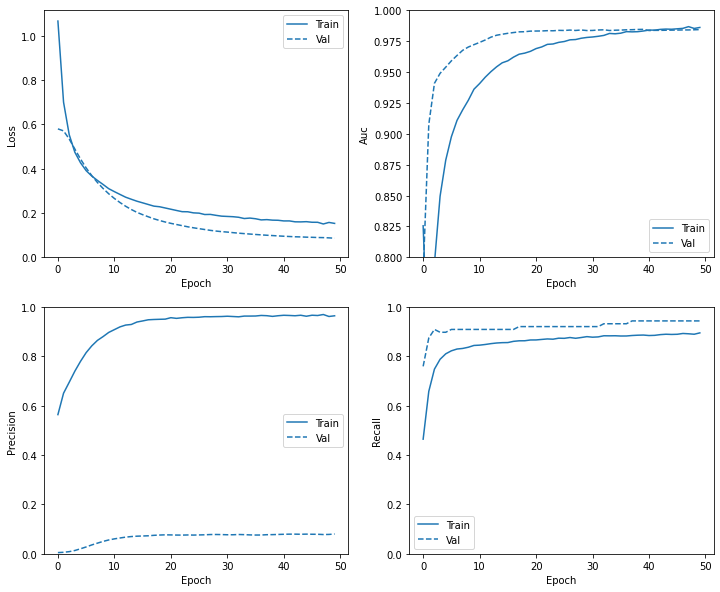

In [49]:
plot_metrics(resampled_history)

### Evaluate metrics

In [50]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.09607589244842529
tp :  84.0
fp :  1195.0
tn :  55676.0
fn :  7.0
accuracy :  0.9788982272148132
precision :  0.06567630916833878
recall :  0.9230769276618958
auc :  0.9697299599647522

Legitimate Transactions Detected (True Negatives):  55676
Legitimate Transactions Incorrectly Detected (False Positives):  1195
Fraudulent Transactions Missed (False Negatives):  7
Fraudulent Transactions Detected (True Positives):  84
Total Fraudulent Transactions:  91


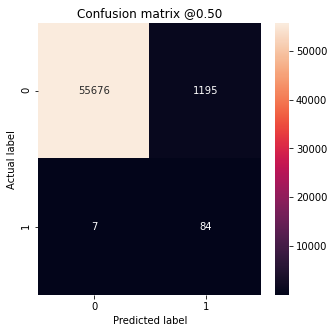

In [51]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

### Plot the ROC

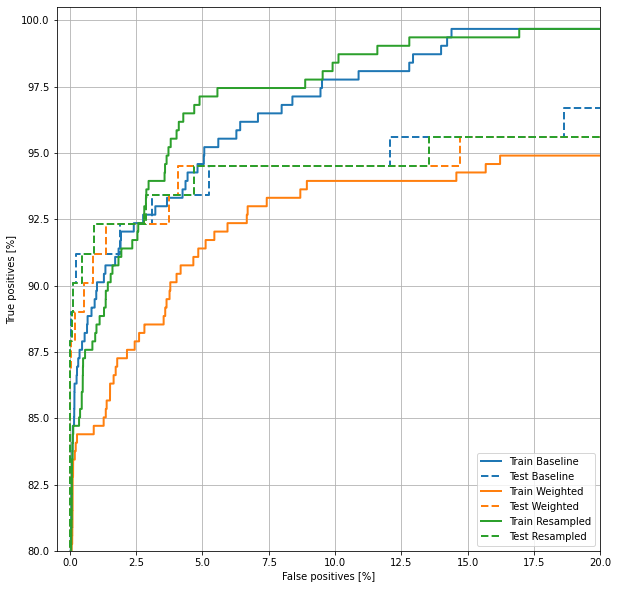

In [52]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled,  color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled,  color=colors[2], linestyle='--')
plt.legend(loc='lower right')

## Applying this tutorial to your problem

Imbalanced data classification is an inherently difficult task since there are so few samples to learn from. You should always start with the data first and do your best to collect as many samples as possible and give substantial thought to what features may be relevant so the model can get the most out of your minority class. At some point your model may struggle to improve and yield the results you want, so it is important to keep in mind the context of your problem and the trade offs between different types of errors.